In [1]:
# Bật autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from tqdm import tqdm
#from operator import itemgetter
#from collections import OrderedDict

from PIL import Image
#import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import optim,nn
import torch.nn.functional as F
from torchvision import transforms as T,models
from torch.utils.data import Dataset, DataLoader, random_split
#from torchvision.utils import make_grid

#pd.options.plotting.backend = "plotly"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Subset
import numpy as np

# Cấu hình thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transform áp dụng cho các bộ dữ liệu
img2vec_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize ảnh cho phù hợp với ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Chọn bộ dữ liệu (thay đổi tên dataset để sử dụng bộ khác)
dataset_name = "CIFAR10"  # Thay bằng "CIFAR10", "SVHN", "FashionMNIST", v.v.

if dataset_name == "CIFAR10":
    train_dataset = datasets.CIFAR10(root='.', train=True, transform=img2vec_transforms, download=True)
    test_dataset = datasets.CIFAR10(root='.', train=False, transform=img2vec_transforms, download=True)
elif dataset_name == "STL10":
    train_dataset = datasets.STL10(root='.', split='train', transform=img2vec_transforms, download=True)
    test_dataset = datasets.STL10(root='.', split='test', transform=img2vec_transforms, download=True)
elif dataset_name == "SVHN":
    train_dataset = datasets.SVHN(root='.', split='train', transform=img2vec_transforms, download=True)
    test_dataset = datasets.SVHN(root='.', split='test', transform=img2vec_transforms, download=True)
elif dataset_name == "FashionMNIST":
    grayscale_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Chuyển ảnh xám thành 3 kênh
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    train_dataset = datasets.FashionMNIST(root='.', train=True, transform=grayscale_transform, download=True)
    test_dataset = datasets.FashionMNIST(root='.', train=False, transform=grayscale_transform, download=True)
elif dataset_name == "MNIST":
    grayscale_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Chuyển ảnh xám thành 3 kênh
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    train_dataset = datasets.MNIST(root='.', train=True, transform=grayscale_transform, download=True)
    test_dataset = datasets.MNIST(root='.', train=False, transform=grayscale_transform, download=True)
else:
    raise ValueError(f"Dataset {dataset_name} không được hỗ trợ.")

# Subset để giảm kích thước tập dữ liệu
sample_size = 10000  # Số lượng mẫu để so sánh
subset_indices_test = list(range(min(sample_size, len(test_dataset))))
subset_test = Subset(test_dataset, subset_indices_test)
dataloader_test = DataLoader(subset_test, batch_size=128, shuffle=False)

subset_indices_train = list(range(min(sample_size, len(train_dataset))))
subset_train = Subset(train_dataset, subset_indices_train)
dataloader_train = DataLoader(subset_train, batch_size=128, shuffle=False)

# Mô hình ResNet-50 mặc định
resnet_default = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
resnet_default.fc = torch.nn.Identity()  # Loại bỏ lớp phân loại
resnet_default.eval()

# Hàm tính embedding
def get_embeddings(model, dataloader):
    embeddings = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            emb = model(images).cpu()
            embeddings.append(emb)
    return torch.cat(embeddings, dim=0)

# Lấy embedding từ cả hai mô hình trên tập test và train
embedding_default_test = get_embeddings(resnet_default, dataloader_test)
embedding_default_train = get_embeddings(resnet_default, dataloader_train)
print(f"Embedding test ({dataset_name}):", embedding_default_test.shape)
print(f"Embedding train ({dataset_name}):", embedding_default_train.shape)

Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Embedding test (CIFAR10): torch.Size([10000, 2048])
Embedding train (CIFAR10): torch.Size([10000, 2048])


In [46]:
# resnet_default_test -> valid/ test
# resnet_default_train -> train
embedding_default_valid = embedding_default_test[5000:]
embedding_default_test = embedding_default_test[:5000]
embedding_default_train = embedding_default_train.numpy()
print(embedding_default_valid.shape)
print(embedding_default_test.shape)
print(embedding_default_train.shape)

torch.Size([5000, 2048])
torch.Size([5000, 2048])
(10000, 2048)


In [47]:
embedding_default_valid = embedding_default_valid.numpy()
embedding_default_test = embedding_default_test.numpy()

In [48]:
def get_labels(dataloader):
    labels = []
    with torch.no_grad():
        for _, label in dataloader:
            labels.append(label)
    return torch.cat(labels, dim=0)

In [49]:
finetuned_label_train = get_labels(dataloader_train)
finetuned_label_test = get_labels(dataloader_test)
print(finetuned_label_train.shape)
print(finetuned_label_test.shape)

torch.Size([10000])
torch.Size([10000])


In [50]:
finetuned_label_train = finetuned_label_train.numpy()
finetuned_label_valid = finetuned_label_test[5000:]
finetuned_label_test = finetuned_label_test[:5000]
finetuned_label_valid = finetuned_label_valid.numpy()
finetuned_label_test = finetuned_label_test.numpy()

In [51]:
# save
import pickle

with open('x_y_embedding_cifar_lon.pkl', 'wb') as f:
    pickle.dump((embedding_default_train, finetuned_label_train, embedding_default_valid, finetuned_label_valid, embedding_default_test, finetuned_label_test), f)

In [52]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_cifar_lon.pkl', 'rb') as f:
    #x_embeddings, y_labels, xt_embeddings, yt_labels = pickle.load(f)
    embedding_default_train, finetuned_label_train, embedding_default_valid, finetuned_label_valid, embedding_default_test, finetuned_label_test = pickle.load(f)
x_embeddings = embedding_default_train
y_labels = finetuned_label_train
xt_embeddings = embedding_default_test
yt_labels = finetuned_label_test
print("Training embeddings shape:", x_embeddings.shape)
print("Training labels shape:", y_labels.shape)
print("Validation embeddings shape:", xt_embeddings.shape)
print("Validation labels shape:", yt_labels.shape)


Training embeddings shape: (10000, 2048)
Training labels shape: (10000,)
Validation embeddings shape: (5000, 2048)
Validation labels shape: (5000,)


In [4]:
# them noise
from machine_learning_model import LogisticRegression
from nosify import mix_label, add_gauss_noise
X_copy = x_embeddings.copy()
param = add_gauss_noise(X_copy, x_embeddings, noise_rate=0.2)
X_train_noisy = param['x_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", X_train_noisy.shape)
# train model logistic regression
input_dim = X_train_noisy.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(X_train_noisy, y_labels, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

Noisy training labels shape: (1000, 2048)
Epoch [10/1000], Loss: 1.6103
Epoch [20/1000], Loss: 1.5606
Epoch [30/1000], Loss: 1.5319
Epoch [40/1000], Loss: 1.5204
Epoch [50/1000], Loss: 1.5081
Epoch [60/1000], Loss: 1.5002
Epoch [70/1000], Loss: 1.4945
Epoch [80/1000], Loss: 1.4909
Epoch [90/1000], Loss: 1.4926
Epoch [100/1000], Loss: 1.4849
Epoch [110/1000], Loss: 1.4830
Epoch [120/1000], Loss: 1.4813
Epoch [130/1000], Loss: 1.4796
Epoch [140/1000], Loss: 1.4785
Epoch [150/1000], Loss: 1.4776
Epoch [160/1000], Loss: 1.4763
Epoch [170/1000], Loss: 1.4757
Epoch [180/1000], Loss: 1.4751
Epoch [190/1000], Loss: 1.4746
Epoch [200/1000], Loss: 1.4741
Epoch [210/1000], Loss: 1.4737
Epoch [220/1000], Loss: 1.4732
Epoch [230/1000], Loss: 1.4726
Epoch [240/1000], Loss: 1.4723
Epoch [250/1000], Loss: 1.4720
Epoch [260/1000], Loss: 1.4716
Epoch [270/1000], Loss: 1.4715


KeyboardInterrupt: 

In [53]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
y_copy = y_labels.copy()
yt_copy = yt_labels.copy()
param = mix_label(y_copy, yt_copy, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

5000
Noisy training labels shape: (10000,)
Epoch [10/1000], Loss: 1.7456
Epoch [20/1000], Loss: 1.7253
Epoch [30/1000], Loss: 1.7148
Epoch [40/1000], Loss: 1.7070
Epoch [50/1000], Loss: 1.7009
Epoch [60/1000], Loss: 1.6965
Epoch [70/1000], Loss: 1.6933
Epoch [80/1000], Loss: 1.6902
Epoch [90/1000], Loss: 1.6880
Epoch [100/1000], Loss: 1.6858
Epoch [110/1000], Loss: 1.6846
Epoch [120/1000], Loss: 1.6827
Epoch [130/1000], Loss: 1.6814
Epoch [140/1000], Loss: 1.6800
Epoch [150/1000], Loss: 1.6789
Epoch [160/1000], Loss: 1.6777
Epoch [170/1000], Loss: 1.6768
Epoch [180/1000], Loss: 1.6759
Epoch [190/1000], Loss: 1.6749
Epoch [200/1000], Loss: 1.6743
Epoch [210/1000], Loss: 1.6738
Epoch [220/1000], Loss: 1.6731
Epoch [230/1000], Loss: 1.6724
Epoch [240/1000], Loss: 1.6719
Epoch [250/1000], Loss: 1.6718
Epoch [260/1000], Loss: 1.6711
Epoch [270/1000], Loss: 1.6709
Epoch [280/1000], Loss: 1.6706
Epoch [290/1000], Loss: 1.6704
Epoch [300/1000], Loss: 1.6697
Epoch [310/1000], Loss: 1.6696
Epoch

Running evaluator: KNNEvaluator0


100%|██████████| 999/999 [00:00<00:00, 3855.20it/s]


KNNEvaluator0 completed in 0.73 seconds.
Running evaluator: CKNNEvaluator1


100%|██████████| 980/980 [00:00<00:00, 3653.13it/s]


CKNNEvaluator1 completed in 0.47 seconds.
Running evaluator: CKNNEvaluator2


100%|██████████| 700/700 [00:00<00:00, 3165.46it/s]


CKNNEvaluator2 completed in 0.47 seconds.
Running evaluator: CKNNEvaluator3


100%|██████████| 300/300 [00:00<00:00, 3278.40it/s]


CKNNEvaluator3 completed in 0.45 seconds.
Running evaluator: LavaEvaluator_batch4


batch LAVA:   0%|          | 0/20 [00:00<?, ?it/s]





d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


C1 la: tensor([[ 97.0654, 140.8609, 148.0934,  ..., 119.5210,  85.7297, 124.6065],
        [119.2439,  81.5426,  73.9523,  ...,  67.1572,  69.6043, 138.5220],
        [133.7660, 109.9918, 113.6658,  ..., 114.4066, 124.0162, 159.8117],
        ...,
        [136.1424, 115.7080, 104.9012,  ...,  91.0936,  67.6334, 139.7060],
        [134.0162, 137.8774, 140.9252,  ..., 114.4511,  68.3228, 115.4016],
        [127.4810, 105.8093, 122.4543,  ...,  77.2971, 106.0775, 157.0448]])
C2 la: tensor([[0.3557, 0.5950, 0.5950,  ..., 0.5826, 0.4160, 0.0000],
        [0.4634, 0.5926, 0.5926,  ..., 0.4853, 0.5657, 0.5154],
        [0.5202, 0.4769, 0.4769,  ..., 0.0000, 0.4116, 0.5826],
        ...,
        [0.3231, 0.6276, 0.6276,  ..., 0.5614, 0.4338, 0.4525],
        [0.3231, 0.6276, 0.6276,  ..., 0.5614, 0.4338, 0.4525],
        [0.4634, 0.5926, 0.5926,  ..., 0.4853, 0.5657, 0.5154]])
C1 la: tensor([[0.4470, 0.6936, 0.7343,  ..., 0.5734, 0.3832, 0.6020],
        [0.5718, 0.3596, 0.3168,  ..., 0.2786, 






d:\data_values\data_valuate.py:723: RuntimeWarning: invalid value encountered in divide
  cost_matrix = (cost_matrix - cost_matrix.min()) / (cost_matrix.max() - cost_matrix.min())
d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)




C1 la: tensor([[153.2529, 110.5614, 135.2723,  ..., 146.6293, 125.6122, 114.1348],
        [ 78.4387,  69.5975, 113.2798,  ..., 106.7316, 100.9666,  95.6478],
        [ 99.3982,  82.1702, 144.4686,  ..., 136.1577, 122.7212, 138.6611],
        ...,
        [123.6437,  75.1660, 129.1485,  ...,  89.7241, 104.5098,  80.9724],
        [142.9474, 113.2567, 122.4848,  ..., 118.6959, 116.8525,  94.6387],
        [128.1243, 113.9232, 134.4583,  ..., 130.7382,  83.4799, 114.1120]])
C2 la: tensor([[0.5826, 0.5950, 0.5154,  ..., 0.5154, 0.5154, 0.4160],
        [0.4853, 0.5926, 0.0000,  ..., 0.0000, 0.0000, 0.5657],
        [0.0000, 0.4769, 0.4853,  ..., 0.4853, 0.4853, 0.4116],
        ...,
        [0.5614, 0.6276, 0.4881,  ..., 0.4881, 0.4881, 0.4338],
        [0.5614, 0.6276, 0.4881,  ..., 0.4881, 0.4881, 0.4338],
        [0.4853, 0.5926, 0.0000,  ..., 0.0000, 0.0000, 0.5657]])
C1 la: tensor([[0.8251, 0.5784, 0.7212,  ..., 0.7869, 0.6654, 0.5991],
        [0.3928, 0.3417, 0.5941,  ..., 0.5563, 

C1 la: tensor([[ 93.0168, 100.5703,  81.1736,  ..., 106.7271,  93.7359, 103.2059],
        [105.7317, 104.5082, 109.7325,  ..., 115.3602,  92.5757, 105.9588],
        [139.1152, 138.7239, 131.5626,  ..., 159.6286, 136.2777, 139.5291],
        ...,
        [103.8244, 105.1248, 127.6657,  ..., 106.3267,  93.0140,  94.7357],
        [ 87.7175,  96.3481, 130.7795,  ..., 113.1987,  96.6775, 105.6983],
        [136.1232, 139.3385, 134.1019,  ..., 135.8292, 109.7346, 127.9731]])
C2 la: tensor([[0.3400, 0.2554, 0.0000,  ..., 0.4525, 0.2554, 0.4525],
        [0.5984, 0.5575, 0.5154,  ..., 0.4881, 0.5575, 0.4881],
        [0.5072, 0.3189, 0.5826,  ..., 0.5614, 0.3189, 0.5614],
        ...,
        [0.4573, 0.3919, 0.4525,  ..., 0.0000, 0.3919, 0.0000],
        [0.4573, 0.3919, 0.4525,  ..., 0.0000, 0.3919, 0.0000],
        [0.5984, 0.5575, 0.5154,  ..., 0.4881, 0.5575, 0.4881]])
C1 la: tensor([[0.4110, 0.4610, 0.3326,  ..., 0.5017, 0.4158, 0.4784],
        [0.4952, 0.4871, 0.5216,  ..., 0.5589, 

C1 la: tensor([[129.8832, 103.3426, 117.8511,  ..., 108.2217, 121.8800, 118.8504],
        [ 87.8529,  54.0335, 122.5600,  ...,  75.8269, 126.0274,  83.5689],
        [116.3894,  82.3619, 144.8517,  ..., 123.9510, 160.7672, 114.2941],
        ...,
        [ 96.0709,  83.5799, 116.9725,  ...,  91.1885, 112.6176,  94.3110],
        [126.1915, 100.1558, 129.4782,  ..., 100.5818,  94.2157, 114.0539],
        [100.7299, 102.3200, 143.3274,  ..., 106.8926, 138.0170, 112.4549]])
C2 la: tensor([[0.5950, 0.5826, 0.0000,  ..., 0.5950, 0.4160, 0.5950],
        [0.5926, 0.4853, 0.5154,  ..., 0.5926, 0.5657, 0.5926],
        [0.4769, 0.0000, 0.5826,  ..., 0.4769, 0.4116, 0.4769],
        ...,
        [0.6276, 0.5614, 0.4525,  ..., 0.6276, 0.4338, 0.6276],
        [0.6276, 0.5614, 0.4525,  ..., 0.6276, 0.4338, 0.6276],
        [0.5926, 0.4853, 0.5154,  ..., 0.5926, 0.5657, 0.5926]])
C1 la: tensor([[0.6357, 0.4771, 0.5638,  ..., 0.5063, 0.5879, 0.5698],
        [0.3845, 0.1823, 0.5920,  ..., 0.3126, 

  940|1.862645e-09|
  950|1.862645e-09|
  960|1.862645e-09|
  970|1.862645e-09|
  980|1.862645e-09|
  990|1.862645e-09|
(50,)


C1 la: tensor([[ 81.7076, 130.6299, 110.3115,  ..., 128.1283, 119.9974,  95.6287],
        [124.7661,  77.9538,  56.6122,  ...,  61.7943, 117.8172, 121.0558],
        [144.0829, 117.1334,  85.4135,  ...,  96.8290, 148.5021, 156.0836],
        ...,
        [122.8906,  95.8863,  50.0662,  ..., 103.0883, 123.8917, 109.3472],
        [126.8682, 118.5953,  91.3912,  ..., 117.0141, 125.0306, 122.6956],
        [144.0392, 118.0093,  92.0955,  ..., 106.8109, 152.7770, 142.5914]])
C2 la: tensor([[0.2554, 0.4932, 0.5950,  ..., 0.5826, 0.4525, 0.4525],
        [0.5575, 0.5071, 0.5926,  ..., 0.4853, 0.4881, 0.4881],
        [0.3189, 0.5590, 0.4769,  ..., 0.0000, 0.5614, 0.5614],
        ...,
        [0.3919, 0.5095, 0.6276,  ..., 0.5614, 0.0000, 0.0000],
        [0.3919, 0.5095, 0.6276,  ..., 0.5614, 0.0000, 0.0000],
        [0.5575, 0.5071, 0.5926,  ..., 0.4853, 0.4881, 0.4881]])
C1 la: tensor([[0.3748, 0.6640, 0.5439,  ..., 0.6492, 0.6011, 0.4571],
        [0.6293, 0.3526, 0.2264,  ..., 0.2571, 

C1 la: tensor([[ 89.9607, 104.9285, 117.1584,  ..., 130.0509, 134.6821,  93.5634],
        [ 94.9235, 128.1960,  42.8101,  ..., 106.1528, 108.7681, 110.3207],
        [133.1443, 149.3423, 112.3444,  ..., 117.1584, 132.5541, 148.2001],
        ...,
        [ 92.5536, 141.0100,  90.8269,  ...,  97.6535, 127.4109, 104.0246],
        [104.4424, 143.1841, 106.8958,  ..., 111.7226, 141.0137, 102.0758],
        [123.3154, 127.2488, 108.1975,  ..., 105.2013, 109.8418, 136.5166]])
C2 la: tensor([[0.2554, 0.3557, 0.5826,  ..., 0.5154, 0.5154, 0.0000],
        [0.5575, 0.4634, 0.4853,  ..., 0.0000, 0.0000, 0.5154],
        [0.3189, 0.5202, 0.0000,  ..., 0.4853, 0.4853, 0.5826],
        ...,
        [0.3919, 0.3231, 0.5614,  ..., 0.4881, 0.4881, 0.4525],
        [0.3919, 0.3231, 0.5614,  ..., 0.4881, 0.4881, 0.4525],
        [0.5575, 0.4634, 0.4853,  ..., 0.0000, 0.0000, 0.5154]])
C1 la: tensor([[0.3942, 0.4823, 0.5543,  ..., 0.6301, 0.6574, 0.4154],
        [0.4234, 0.6192, 0.1168,  ..., 0.4895, 

C1 la: tensor([[ 84.6553,  79.4560, 129.6567,  ..., 112.4794, 121.4944, 117.7976],
        [116.2760, 126.0513, 120.1089,  ..., 148.4339, 113.4879,  49.7488],
        [157.7247, 158.4721, 158.2109,  ..., 168.6048, 131.9390, 111.7038],
        ...,
        [111.9440, 129.6085, 126.2053,  ..., 156.4574, 116.2200, 103.8583],
        [115.9186, 128.0593, 101.9869,  ..., 159.6341, 128.8994, 124.2172],
        [143.8519, 148.8038, 138.4048,  ..., 162.7712, 126.2358, 106.9960]])
C2 la: tensor([[0.0000, 0.0000, 0.3557,  ..., 0.0000, 0.5950, 0.5826],
        [0.5154, 0.5154, 0.4634,  ..., 0.5154, 0.5926, 0.4853],
        [0.5826, 0.5826, 0.5202,  ..., 0.5826, 0.4769, 0.0000],
        ...,
        [0.4525, 0.4525, 0.3231,  ..., 0.4525, 0.6276, 0.5614],
        [0.4525, 0.4525, 0.3231,  ..., 0.4525, 0.6276, 0.5614],
        [0.5154, 0.5154, 0.4634,  ..., 0.5154, 0.5926, 0.4853]])
C1 la: tensor([[0.3322, 0.3018, 0.5956,  ..., 0.4951, 0.5478, 0.5262],
        [0.5173, 0.5745, 0.5397,  ..., 0.7055, 

C1 la: tensor([[108.6859, 121.0220, 149.8934,  ..., 112.0636, 146.8288, 116.9510],
        [ 53.0432,  74.2173,  83.9149,  ..., 115.8800,  83.6746,  94.3064],
        [115.9803, 113.4439, 103.1610,  ..., 129.4403, 118.7972, 130.6498],
        ...,
        [101.0324, 115.1709, 125.9371,  ..., 115.9683, 115.7392, 109.0809],
        [106.4593, 123.3672, 148.9822,  ..., 114.6005, 124.6024, 121.3346],
        [112.9361, 118.3910, 115.8284,  ..., 123.2334, 129.0224,  95.3454]])
C2 la: tensor([[0.5826, 0.4932, 0.5154,  ..., 0.3557, 0.5154, 0.3557],
        [0.4853, 0.5071, 0.0000,  ..., 0.4634, 0.0000, 0.4634],
        [0.0000, 0.5590, 0.4853,  ..., 0.5202, 0.4853, 0.5202],
        ...,
        [0.5614, 0.5095, 0.4881,  ..., 0.3231, 0.4881, 0.3231],
        [0.5614, 0.5095, 0.4881,  ..., 0.3231, 0.4881, 0.3231],
        [0.4853, 0.5071, 0.0000,  ..., 0.4634, 0.0000, 0.4634]])
C1 la: tensor([[0.4688, 0.5503, 0.7410,  ..., 0.4911, 0.7208, 0.5234],
        [0.1012, 0.2411, 0.3051,  ..., 0.5163, 

C1 la: tensor([[109.4290, 163.5389, 104.1908,  ..., 149.2584, 100.9158, 126.4036],
        [ 42.1511,  93.6177, 109.1929,  ..., 113.2305, 119.0614, 107.0645],
        [ 95.0293, 113.4631, 132.2852,  ..., 145.3865, 150.4590, 138.2289],
        ...,
        [ 86.4732, 129.3907, 118.6878,  ...,  82.2720, 103.8525,  83.9159],
        [104.4944, 167.3250,  88.8826,  ..., 104.4986,  91.5684,  87.2948],
        [ 93.8683, 147.0227, 121.8369,  ..., 113.1818, 140.2810, 107.7313]])
C2 la: tensor([[0.5826, 0.5950, 0.4160,  ..., 0.5154, 0.4525, 0.4525],
        [0.4853, 0.5926, 0.5657,  ..., 0.0000, 0.4881, 0.4881],
        [0.0000, 0.4769, 0.4116,  ..., 0.4853, 0.5614, 0.5614],
        ...,
        [0.5614, 0.6276, 0.4338,  ..., 0.4881, 0.0000, 0.0000],
        [0.5614, 0.6276, 0.4338,  ..., 0.4881, 0.0000, 0.0000],
        [0.4853, 0.5926, 0.5657,  ..., 0.0000, 0.4881, 0.4881]])
C1 la: tensor([[0.4873, 0.8168, 0.4553,  ..., 0.7298, 0.4354, 0.5906],
        [0.0775, 0.3909, 0.4858,  ..., 0.5104, 








batch LAVA:   5%|▌         | 1/20 [00:04<01:26,  4.55s/it]

C1 la: tensor([[109.4505, 112.9420,  91.6122,  ..., 138.1219, 106.0864, 113.7622],
        [119.0565,  38.0908, 112.2944,  ..., 175.9927, 101.4004,  95.4312],
        [130.1876, 103.2841, 152.2811,  ..., 186.2824, 123.1246, 120.1510],
        ...,
        [123.7602,  66.1256, 109.0542,  ..., 173.5609,  85.9049,  88.8021],
        [112.9889, 100.8056, 109.4254,  ..., 154.1805,  47.2324,  98.6227],
        [138.1803,  85.9651, 134.6483,  ..., 190.5929, 118.7473,  85.6764]])
C2 la: tensor([[0.4525, 0.5826, 0.4160,  ..., 0.4525, 0.4525, 0.5154],
        [0.4881, 0.4853, 0.5657,  ..., 0.4881, 0.4881, 0.0000],
        [0.5614, 0.0000, 0.4116,  ..., 0.5614, 0.5614, 0.4853],
        ...,
        [0.0000, 0.5614, 0.4338,  ..., 0.0000, 0.0000, 0.4881],
        [0.0000, 0.5614, 0.4338,  ..., 0.0000, 0.0000, 0.4881],
        [0.4881, 0.4853, 0.5657,  ..., 0.4881, 0.4881, 0.0000]])
C1 la: tensor([[0.4713, 0.4926, 0.3624,  ..., 0.6463, 0.4508, 0.4976],
        [0.5299, 0.0356, 0.4887,  ..., 0.8775, 

C1 la: tensor([[134.0585,  98.2030, 124.3457,  ..., 113.7638, 100.6992, 152.7701],
        [110.4722, 137.7460, 140.1583,  ..., 117.6375,  91.2997, 164.2842],
        [132.7101, 149.5317, 139.3737,  ..., 119.7874,  88.8999, 132.5620],
        ...,
        [156.1681, 124.8976, 104.9125,  ..., 126.8043, 120.8640, 142.3251],
        [144.2173, 141.3285, 138.9699,  ..., 116.2082,  67.4773, 105.8599],
        [140.6970, 101.3080,  91.6867,  ..., 101.8826,  77.6402, 135.9522]])
C2 la: tensor([[0.4577, 0.4884, 0.4884,  ..., 0.0000, 0.4940, 0.5829],
        [0.3356, 0.4115, 0.4115,  ..., 0.5470, 0.3925, 0.4441],
        [0.5598, 0.4272, 0.4272,  ..., 0.4940, 0.0000, 0.4271],
        ...,
        [0.5019, 0.0000, 0.0000,  ..., 0.4884, 0.4272, 0.3977],
        [0.3775, 0.4519, 0.4519,  ..., 0.4307, 0.4162, 0.3774],
        [0.4620, 0.4733, 0.4733,  ..., 0.3729, 0.4009, 0.4162]])
C1 la: tensor([[0.6967, 0.4640, 0.6336,  ..., 0.5650, 0.4802, 0.8181],
        [0.5436, 0.7206, 0.7363,  ..., 0.5901, 

C1 la: tensor([[121.8478,  96.1182, 125.6613,  ..., 125.5706,  92.0932, 130.4173],
        [149.1115, 116.8786, 137.8505,  ..., 161.5178, 132.5749, 121.1289],
        [139.2015, 111.8899, 148.0152,  ..., 144.7873, 140.5025, 112.0436],
        ...,
        [102.0253,  99.3464, 136.9620,  ..., 128.1960, 157.7962, 140.9328],
        [143.7095, 102.9705, 131.5712,  ..., 108.1544, 117.5856,  87.9812],
        [109.6271, 100.5000, 126.9175,  ..., 120.8169, 120.5417, 107.3840]])
C2 la: tensor([[0.0000, 0.4884, 0.6290,  ..., 0.6290, 0.6290, 0.4940],
        [0.5470, 0.4115, 0.4280,  ..., 0.4280, 0.4280, 0.3925],
        [0.4940, 0.4272, 0.5823,  ..., 0.5823, 0.5823, 0.0000],
        ...,
        [0.4884, 0.0000, 0.5111,  ..., 0.5111, 0.5111, 0.4272],
        [0.4307, 0.4519, 0.6306,  ..., 0.6306, 0.6306, 0.4162],
        [0.3729, 0.4733, 0.4811,  ..., 0.4811, 0.4811, 0.4009]])
C1 la: tensor([[0.5659, 0.3896, 0.5920,  ..., 0.5914, 0.3620, 0.6246],
        [0.7527, 0.5318, 0.6755,  ..., 0.8377, 

  880|2.634178e-09|
  890|2.634178e-09|
  900|2.634178e-09|
  910|2.634178e-09|
  920|2.634178e-09|
  930|2.634178e-09|
  940|2.634178e-09|
  950|2.634178e-09|
  960|2.634178e-09|
  970|2.634178e-09|
  980|2.634178e-09|
  990|2.634178e-09|
(50,)


C1 la: tensor([[134.8154, 134.3401, 109.8462,  ..., 150.3709, 121.7932, 132.1457],
        [117.5650, 116.6759,  98.5796,  ..., 129.6805,  93.6373, 119.6795],
        [ 75.9620, 107.3459, 128.1529,  ..., 136.4150, 108.0003, 125.3430],
        ...,
        [118.2453, 131.1797, 150.4950,  ..., 159.5165, 133.0360, 142.7448],
        [ 84.8312,  94.2586, 119.5511,  ..., 106.5907, 105.8890,  94.0679],
        [113.9642, 109.0590, 122.6015,  ..., 131.1281, 108.8345, 120.2728]])
C2 la: tensor([[0.4307, 0.5470, 0.5829,  ..., 0.5383, 0.5470, 0.5383],
        [0.3912, 0.0000, 0.4441,  ..., 0.3621, 0.0000, 0.3621],
        [0.4162, 0.3925, 0.4271,  ..., 0.4676, 0.3925, 0.4676],
        ...,
        [0.4519, 0.4115, 0.3977,  ..., 0.6030, 0.4115, 0.6030],
        [0.0000, 0.3912, 0.3774,  ..., 0.4515, 0.3912, 0.4515],
        [0.4191, 0.2559, 0.4162,  ..., 0.5235, 0.2559, 0.5235]])
C1 la: tensor([[0.6767, 0.6737, 0.5189,  ..., 0.7751, 0.5944, 0.6599],
        [0.5677, 0.5621, 0.4476,  ..., 0.6443, 

C1 la: tensor([[109.1993,  99.5291, 152.7673,  ..., 105.8741, 154.0571, 122.0470],
        [132.2179, 107.5090, 145.8732,  ...,  97.4950, 138.4662, 120.7293],
        [140.8890,  92.4036, 128.2488,  ..., 113.2385, 105.7712, 124.2672],
        ...,
        [128.3084,  72.0699, 160.4703,  ..., 130.8304, 158.3435, 117.0265],
        [131.1269, 103.5152, 116.6040,  ..., 104.2920, 111.1551, 121.6664],
        [102.8619,  85.9267, 144.6293,  ..., 104.6053, 133.5688, 104.6810]])
C2 la: tensor([[0.4884, 0.0000, 0.5829,  ..., 0.4884, 0.4940, 0.4884],
        [0.4115, 0.5470, 0.4441,  ..., 0.4115, 0.3925, 0.4115],
        [0.4272, 0.4940, 0.4271,  ..., 0.4272, 0.0000, 0.4272],
        ...,
        [0.0000, 0.4884, 0.3977,  ..., 0.0000, 0.4272, 0.0000],
        [0.4519, 0.4307, 0.3774,  ..., 0.4519, 0.4162, 0.4519],
        [0.4733, 0.3729, 0.4162,  ..., 0.4733, 0.4009, 0.4733]])
C1 la: tensor([[0.4714, 0.4161, 0.7206,  ..., 0.4524, 0.7280, 0.5449],
        [0.6031, 0.4617, 0.6811,  ..., 0.4045, 

C1 la: tensor([[152.1601, 119.0156,  93.8257,  ..., 104.1180, 116.8650, 146.7724],
        [122.0390, 129.4033, 107.4126,  ..., 124.7593, 128.7099, 126.6607],
        [125.1344, 123.5993, 108.6215,  ..., 119.9183, 146.6444, 118.6971],
        ...,
        [144.1082,  97.7364, 111.0027,  ...,  95.3172, 150.3983, 144.4446],
        [120.8003, 108.6607,  88.7265,  ..., 115.0476, 125.5404,  96.4470],
        [138.9405,  85.2342,  81.8858,  ...,  94.1983, 121.1573, 134.2592]])
C2 la: tensor([[0.5470, 0.3729, 0.4884,  ..., 0.0000, 0.5383, 0.5383],
        [0.0000, 0.2559, 0.4115,  ..., 0.5470, 0.3621, 0.3621],
        [0.3925, 0.4009, 0.4272,  ..., 0.4940, 0.4676, 0.4676],
        ...,
        [0.4115, 0.4733, 0.0000,  ..., 0.4884, 0.6030, 0.6030],
        [0.3912, 0.4191, 0.4519,  ..., 0.4307, 0.4515, 0.4515],
        [0.2559, 0.0000, 0.4733,  ..., 0.3729, 0.5235, 0.5235]])
C1 la: tensor([[0.7674, 0.5649, 0.4109,  ..., 0.4738, 0.5517, 0.7345],
        [0.5833, 0.6283, 0.4940,  ..., 0.6000, 

C1 la: tensor([[120.1618, 147.9662,  93.4521,  ...,  93.5330, 107.8117, 133.4511],
        [105.2191, 115.4500, 113.3641,  ..., 135.2709, 141.6770, 133.4333],
        [124.0164, 143.1832, 106.1660,  ..., 139.4714, 153.4451, 115.3936],
        ...,
        [142.0030, 167.0548,  94.4635,  ..., 137.7183, 163.3130, 147.5787],
        [ 97.5328, 138.1952, 101.5891,  ..., 117.1271, 141.5493,  80.7367],
        [111.8822, 147.6289,  80.6688,  ..., 120.7184, 142.3893, 113.8145]])
C2 la: tensor([[0.5470, 0.4577, 0.0000,  ..., 0.6290, 0.6290, 0.5829],
        [0.0000, 0.3356, 0.5470,  ..., 0.4280, 0.4280, 0.4441],
        [0.3925, 0.5598, 0.4940,  ..., 0.5823, 0.5823, 0.4271],
        ...,
        [0.4115, 0.5019, 0.4884,  ..., 0.5111, 0.5111, 0.3977],
        [0.3912, 0.3775, 0.4307,  ..., 0.6306, 0.6306, 0.3774],
        [0.2559, 0.4620, 0.3729,  ..., 0.4811, 0.4811, 0.4162]])
C1 la: tensor([[0.5323, 0.7012, 0.3700,  ..., 0.3705, 0.4572, 0.6130],
        [0.4415, 0.5036, 0.4910,  ..., 0.6241, 

C1 la: tensor([[148.3074, 156.4020, 146.0717,  ..., 161.8552, 109.6033, 103.7275],
        [116.9848, 134.5200, 132.4241,  ..., 138.1683, 130.2749, 108.6030],
        [108.3513, 114.5222, 113.3088,  ..., 153.8819, 153.3889, 120.4495],
        ...,
        [148.1730, 155.2395, 147.2401,  ..., 189.3495, 147.1923, 112.0456],
        [ 90.9627,  93.4659, 127.8090,  ..., 138.7973, 133.3956, 122.2684],
        [127.0609, 140.8515, 126.8177,  ..., 166.1376, 129.2358,  88.9257]])
C2 la: tensor([[0.5829, 0.5829, 0.4577,  ..., 0.5829, 0.4884, 0.0000],
        [0.4441, 0.4441, 0.3356,  ..., 0.4441, 0.4115, 0.5470],
        [0.4271, 0.4271, 0.5598,  ..., 0.4271, 0.4272, 0.4940],
        ...,
        [0.3977, 0.3977, 0.5019,  ..., 0.3977, 0.0000, 0.4884],
        [0.3774, 0.3774, 0.3775,  ..., 0.3774, 0.4519, 0.4307],
        [0.4162, 0.4162, 0.4620,  ..., 0.4162, 0.4733, 0.3729]])
C1 la: tensor([[0.7025, 0.7536, 0.6884,  ..., 0.7880, 0.4584, 0.4213],
        [0.5049, 0.6156, 0.6023,  ..., 0.6386, 

C1 la: tensor([[ 97.5901,  96.4080, 105.6387,  ..., 127.3194, 100.2551, 111.4049],
        [103.3039, 106.0869, 145.4951,  ..., 109.8545, 140.1191, 111.1244],
        [112.4709, 124.1798, 150.4943,  ..., 113.6449, 143.0304, 134.9536],
        ...,
        [101.3032, 107.8811, 119.8639,  ..., 141.4058, 114.2842, 164.0843],
        [103.0855, 126.9290, 143.6832,  ..., 128.2165, 133.3779, 129.9070],
        [ 75.7854,  69.1159, 104.1271,  ..., 120.7557, 105.9065, 118.8255]])
C2 la: tensor([[0.0000, 0.3729, 0.6290,  ..., 0.4577, 0.6290, 0.4577],
        [0.5470, 0.2559, 0.4280,  ..., 0.3356, 0.4280, 0.3356],
        [0.4940, 0.4009, 0.5823,  ..., 0.5598, 0.5823, 0.5598],
        ...,
        [0.4884, 0.4733, 0.5111,  ..., 0.5019, 0.5111, 0.5019],
        [0.4307, 0.4191, 0.6306,  ..., 0.3775, 0.6306, 0.3775],
        [0.3729, 0.0000, 0.4811,  ..., 0.4620, 0.4811, 0.4620]])
C1 la: tensor([[0.4178, 0.4105, 0.4677,  ..., 0.6020, 0.4343, 0.5034],
        [0.4532, 0.4704, 0.7146,  ..., 0.4938, 

C1 la: tensor([[ 92.2828, 123.8781, 129.8935,  ..., 126.8475, 137.8806, 116.5205],
        [104.9903, 166.6631, 117.2522,  ..., 158.6677, 134.9989, 133.9401],
        [108.7925, 173.0222,  89.5414,  ..., 144.2464, 132.8800, 137.0261],
        ...,
        [ 97.5108, 130.8678, 134.5942,  ..., 148.9608, 147.8026, 145.1915],
        [102.9994, 160.9379, 114.4329,  ..., 107.8927,  91.7711,  99.1398],
        [ 74.9742, 133.9665, 119.6982,  ..., 128.4965, 123.1648, 116.8678]])
C2 la: tensor([[0.0000, 0.4884, 0.4940,  ..., 0.6290, 0.5383, 0.5383],
        [0.5470, 0.4115, 0.3925,  ..., 0.4280, 0.3621, 0.3621],
        [0.4940, 0.4272, 0.0000,  ..., 0.5823, 0.4676, 0.4676],
        ...,
        [0.4884, 0.0000, 0.4272,  ..., 0.5111, 0.6030, 0.6030],
        [0.4307, 0.4519, 0.4162,  ..., 0.6306, 0.4515, 0.4515],
        [0.3729, 0.4733, 0.4009,  ..., 0.4811, 0.5235, 0.5235]])
C1 la: tensor([[0.3975, 0.5798, 0.6145,  ..., 0.5969, 0.6606, 0.5373],
        [0.4708, 0.8266, 0.5416,  ..., 0.7805, 









batch LAVA:  10%|█         | 2/20 [00:09<01:22,  4.59s/it]

C1 la: tensor([[140.4096, 100.3739, 146.5459,  ..., 193.3573, 120.6149,  87.4423],
        [137.4867, 102.8989, 114.8676,  ..., 152.4890, 117.1431, 113.0186],
        [ 90.1424, 114.7070,  91.8493,  ..., 172.8587,  93.5021, 128.2373],
        ...,
        [124.0916, 116.1797, 132.8436,  ..., 195.1889, 119.9549, 141.1261],
        [115.7524, 100.3099,  95.9685,  ..., 172.7122,  92.7347, 104.9659],
        [132.5300,  73.4936, 123.0576,  ..., 191.1089, 103.7248, 108.8870]])
C2 la: tensor([[0.5383, 0.0000, 0.4940,  ..., 0.5383, 0.5383, 0.6290],
        [0.3621, 0.5470, 0.3925,  ..., 0.3621, 0.3621, 0.4280],
        [0.4676, 0.4940, 0.0000,  ..., 0.4676, 0.4676, 0.5823],
        ...,
        [0.6030, 0.4884, 0.4272,  ..., 0.6030, 0.6030, 0.5111],
        [0.4515, 0.4307, 0.4162,  ..., 0.4515, 0.4515, 0.6306],
        [0.5235, 0.3729, 0.4009,  ..., 0.5235, 0.5235, 0.4811]])
C1 la: tensor([[0.5791, 0.3705, 0.6110,  ..., 0.8549, 0.4759, 0.3031],
        [0.5638, 0.3836, 0.4460,  ..., 0.6420, 

C1 la: tensor([[122.6598,  79.3499,  69.8530,  ...,  80.1503,  83.9452, 147.2462],
        [107.5435, 162.6737, 165.3463,  ..., 135.1959, 100.9800, 160.6966],
        [124.6452, 102.0523, 100.0553,  ...,  86.9648,  73.6035, 143.4508],
        ...,
        [147.0843, 103.2615,  94.1465,  ...,  86.6400,  75.7252, 139.4417],
        [122.2072, 146.4834, 151.3424,  ..., 123.9488,  95.0767, 162.0914],
        [135.2641, 133.2541, 135.4807,  ..., 108.0467,  55.8804, 105.7812]])
C2 la: tensor([[0.2744, 0.0000, 0.0000,  ..., 0.2616, 0.3375, 0.4562],
        [0.5787, 0.4166, 0.4166,  ..., 0.4212, 0.4609, 0.4319],
        [0.4679, 0.2616, 0.2616,  ..., 0.0000, 0.3470, 0.4559],
        ...,
        [0.4679, 0.2616, 0.2616,  ..., 0.0000, 0.3470, 0.4559],
        [0.5393, 0.3747, 0.3747,  ..., 0.4562, 0.4594, 0.3821],
        [0.5000, 0.4088, 0.4088,  ..., 0.3943, 0.4632, 0.2948]])
C1 la: tensor([[0.5712, 0.3280, 0.2747,  ..., 0.3325, 0.3538, 0.7093],
        [0.4863, 0.7959, 0.8109,  ..., 0.6416, 

C1 la: tensor([[ 85.2252,  64.0559, 124.0305,  ...,  81.2797, 111.3652, 102.5954],
        [173.5710, 139.7526, 152.7073,  ..., 159.1676, 141.9825, 124.8475],
        [ 87.0587,  92.0375, 140.1714,  ..., 112.8900, 107.9872,  88.8515],
        ...,
        [ 75.2022,  82.8852, 118.5601,  ...,  89.4625, 109.0970,  91.7321],
        [152.4985, 120.3917, 135.7141,  ..., 161.3859, 138.4402, 118.9526],
        [137.5560, 101.9191, 113.3217,  ..., 109.2338, 107.5757,  79.7207]])
C2 la: tensor([[0.2616, 0.0000, 0.3845,  ..., 0.3845, 0.3845, 0.3375],
        [0.4212, 0.4166, 0.3252,  ..., 0.3252, 0.3252, 0.4609],
        [0.0000, 0.2616, 0.3998,  ..., 0.3998, 0.3998, 0.3470],
        ...,
        [0.0000, 0.2616, 0.3998,  ..., 0.3998, 0.3998, 0.3470],
        [0.4562, 0.3747, 0.3131,  ..., 0.3131, 0.3131, 0.4594],
        [0.3943, 0.4088, 0.4782,  ..., 0.4782, 0.4782, 0.4632]])
C1 la: tensor([[0.3419, 0.2228, 0.5603,  ..., 0.3197, 0.4890, 0.4397],
        [0.8391, 0.6488, 0.7217,  ..., 0.7580, 

C1 la: tensor([[103.1968, 102.5621, 124.0511,  ..., 116.9354,  98.9840, 104.4697],
        [112.0983, 118.5614, 119.5561,  ..., 115.6503,  94.6594, 104.5420],
        [105.3218,  96.6195, 112.3483,  ..., 115.7175, 100.8011, 106.9309],
        ...,
        [104.0817, 107.1511, 129.8226,  ..., 122.9012, 104.4041, 116.6503],
        [114.2267,  88.8650, 110.3473,  ..., 110.6850,  93.7259, 107.6990],
        [ 61.7061,  88.4762, 114.6609,  ..., 107.4911,  94.7589, 100.7706]])
C2 la: tensor([[0.4088, 0.3747, 0.4562,  ..., 0.4166, 0.3747, 0.4166],
        [0.6553, 0.4202, 0.4319,  ..., 0.0000, 0.4202, 0.0000],
        [0.3943, 0.4562, 0.4559,  ..., 0.4212, 0.4562, 0.4212],
        ...,
        [0.3943, 0.4562, 0.4559,  ..., 0.4212, 0.4562, 0.4212],
        [0.3596, 0.0000, 0.3821,  ..., 0.4202, 0.0000, 0.4202],
        [0.0000, 0.3596, 0.2948,  ..., 0.6553, 0.3596, 0.6553]])
C1 la: tensor([[0.4570, 0.4532, 0.5804,  ..., 0.5383, 0.4320, 0.4645],
        [0.5097, 0.5479, 0.5538,  ..., 0.5307, 

C1 la: tensor([[ 79.7920,  67.5870, 118.7271,  ...,  75.1526, 127.3661,  63.7841],
        [148.6102, 120.3266, 141.7444,  ..., 117.1386, 110.0634, 130.2780],
        [105.9942,  78.1239, 141.0310,  ...,  95.5293, 120.9707, 100.9157],
        ...,
        [102.4365,  64.2392, 145.8401,  ...,  97.9906, 131.7843, 103.5639],
        [138.1709, 105.0307, 138.1960,  ..., 104.0224, 117.5695, 126.7542],
        [130.8621, 100.4014, 122.2571,  ...,  92.7516, 110.2795, 114.5423]])
C2 la: tensor([[0.0000, 0.2616, 0.4562,  ..., 0.0000, 0.3375, 0.0000],
        [0.4166, 0.4212, 0.4319,  ..., 0.4166, 0.4609, 0.4166],
        [0.2616, 0.0000, 0.4559,  ..., 0.2616, 0.3470, 0.2616],
        ...,
        [0.2616, 0.0000, 0.4559,  ..., 0.2616, 0.3470, 0.2616],
        [0.3747, 0.4562, 0.3821,  ..., 0.3747, 0.4594, 0.3747],
        [0.4088, 0.3943, 0.2948,  ..., 0.4088, 0.4632, 0.4088]])
C1 la: tensor([[0.2555, 0.1892, 0.4670,  ..., 0.2303, 0.5139, 0.1686],
        [0.6293, 0.4757, 0.5920,  ..., 0.4584, 

C1 la: tensor([[122.8140,  77.1872,  60.3847,  ...,  75.6389, 134.7410, 129.4658],
        [103.6114, 144.3590, 119.2451,  ..., 147.8451, 132.1310,  98.9256],
        [117.0884,  83.8233,  69.5293,  ...,  74.9907, 122.7903, 124.1382],
        ...,
        [139.0652,  79.7299,  69.9199,  ...,  70.9332, 132.9572, 130.9226],
        [ 98.4500, 135.8056, 113.5166,  ..., 126.3004, 141.3315, 113.4350],
        [120.4762, 117.0944,  82.9607,  ..., 112.1811, 114.3616, 103.8551]])
C2 la: tensor([[0.3747, 0.3568, 0.0000,  ..., 0.2616, 0.4166, 0.4166],
        [0.4202, 0.4939, 0.4166,  ..., 0.4212, 0.0000, 0.0000],
        [0.4562, 0.2572, 0.2616,  ..., 0.0000, 0.4212, 0.4212],
        ...,
        [0.4562, 0.2572, 0.2616,  ..., 0.0000, 0.4212, 0.4212],
        [0.0000, 0.3095, 0.3747,  ..., 0.4562, 0.4202, 0.4202],
        [0.3596, 0.4139, 0.4088,  ..., 0.3943, 0.6553, 0.6553]])
C1 la: tensor([[0.5327, 0.2935, 0.2054,  ..., 0.2854, 0.5952, 0.5675],
        [0.4320, 0.6456, 0.5140,  ..., 0.6639, 

C1 la: tensor([[102.3655, 126.2311,  91.6468,  ...,  93.2796, 118.8583, 119.7294],
        [108.8111,  90.1145, 135.7387,  ..., 141.6647, 158.7209, 124.8515],
        [ 92.2922, 127.0500,  58.4053,  ..., 114.0339, 124.6382, 120.4260],
        ...,
        [104.7540, 148.1713,  47.7840,  ..., 114.1457, 121.2873, 123.3474],
        [ 85.9617, 123.6222, 120.3971,  ..., 135.7275, 145.6932, 129.1015],
        [ 96.3819, 137.1749,  96.1282,  ..., 113.1783, 128.6517,  92.1574]])
C2 la: tensor([[0.3747, 0.2744, 0.2616,  ..., 0.3845, 0.3845, 0.4562],
        [0.4202, 0.5787, 0.4212,  ..., 0.3252, 0.3252, 0.4319],
        [0.4562, 0.4679, 0.0000,  ..., 0.3998, 0.3998, 0.4559],
        ...,
        [0.4562, 0.4679, 0.0000,  ..., 0.3998, 0.3998, 0.4559],
        [0.0000, 0.5393, 0.4562,  ..., 0.3131, 0.3131, 0.3821],
        [0.3596, 0.5000, 0.3943,  ..., 0.4782, 0.4782, 0.2948]])
C1 la: tensor([[0.4051, 0.5360, 0.3463,  ..., 0.3552, 0.4955, 0.5003],
        [0.4404, 0.3379, 0.5881,  ..., 0.6206, 

C1 la: tensor([[124.0071, 135.0716, 122.7067,  ..., 162.6826,  97.5071,  96.9370],
        [107.7961, 137.8814, 122.5096,  ..., 162.2791, 135.2215, 141.5578],
        [116.7645, 130.9209, 118.2186,  ..., 150.8967, 124.2004,  68.5835],
        ...,
        [128.6241, 138.2138, 128.3919,  ..., 165.8562, 126.1166,  69.7735],
        [101.4898, 118.4059, 120.4460,  ..., 143.5385, 137.1598, 117.9393],
        [ 99.9418, 111.8749, 119.3264,  ..., 138.7571, 125.9413, 116.9945]])
C2 la: tensor([[0.4562, 0.4562, 0.2744,  ..., 0.4562, 0.0000, 0.2616],
        [0.4319, 0.4319, 0.5787,  ..., 0.4319, 0.4166, 0.4212],
        [0.4559, 0.4559, 0.4679,  ..., 0.4559, 0.2616, 0.0000],
        ...,
        [0.4559, 0.4559, 0.4679,  ..., 0.4559, 0.2616, 0.0000],
        [0.3821, 0.3821, 0.5393,  ..., 0.3821, 0.3747, 0.4562],
        [0.2948, 0.2948, 0.5000,  ..., 0.2948, 0.4088, 0.3943]])
C1 la: tensor([[0.5055, 0.5656, 0.4985,  ..., 0.7155, 0.3616, 0.3585],
        [0.4175, 0.5809, 0.4974,  ..., 0.7133, 

C1 la: tensor([[ 88.6904, 101.2889,  88.9421,  ..., 111.9691,  94.0691, 111.9580],
        [124.8072, 143.8794, 170.3773,  ..., 105.2852, 161.1676, 126.4744],
        [ 70.6726,  67.9200,  96.6267,  ..., 107.8699,  92.3697, 101.3404],
        ...,
        [ 71.8868,  97.1018, 102.5183,  ..., 127.2786,  79.0318, 116.2428],
        [112.1696, 125.1738, 159.5428,  ..., 111.4796, 147.2598, 125.0140],
        [101.0134, 121.4705, 141.6449,  ..., 118.4992, 124.9952, 114.1892]])
C2 la: tensor([[0.2616, 0.3568, 0.3845,  ..., 0.2744, 0.3845, 0.2744],
        [0.4212, 0.4939, 0.3252,  ..., 0.5787, 0.3252, 0.5787],
        [0.0000, 0.2572, 0.3998,  ..., 0.4679, 0.3998, 0.4679],
        ...,
        [0.0000, 0.2572, 0.3998,  ..., 0.4679, 0.3998, 0.4679],
        [0.4562, 0.3095, 0.3131,  ..., 0.5393, 0.3131, 0.5393],
        [0.3943, 0.4139, 0.4782,  ..., 0.5000, 0.4782, 0.5000]])
C1 la: tensor([[0.3126, 0.3878, 0.3141,  ..., 0.4515, 0.3447, 0.4514],
        [0.5280, 0.6418, 0.7998,  ..., 0.4116, 

C1 la: tensor([[ 75.5646, 112.2928, 112.9534,  ...,  90.5218, 116.7929,  99.6732],
        [131.1992, 184.5683, 125.8161,  ..., 148.9551, 109.5761, 125.1898],
        [ 42.5676, 126.1158, 113.0958,  ..., 119.9490, 123.0254, 112.4068],
        ...,
        [ 56.3033, 118.5556, 115.2214,  ..., 107.9341, 129.6159, 109.0914],
        [112.1926, 164.3862, 117.6710,  ..., 157.4587, 139.5906, 136.6752],
        [ 97.3205, 159.9103, 103.5180,  ..., 108.1976,  90.4496,  90.7663]])
C2 la: tensor([[0.2616, 0.0000, 0.3375,  ..., 0.3845, 0.4166, 0.4166],
        [0.4212, 0.4166, 0.4609,  ..., 0.3252, 0.0000, 0.0000],
        [0.0000, 0.2616, 0.3470,  ..., 0.3998, 0.4212, 0.4212],
        ...,
        [0.0000, 0.2616, 0.3470,  ..., 0.3998, 0.4212, 0.4212],
        [0.4562, 0.3747, 0.4594,  ..., 0.3131, 0.4202, 0.4202],
        [0.3943, 0.4088, 0.4632,  ..., 0.4782, 0.6553, 0.6553]])
C1 la: tensor([[0.2169, 0.4282, 0.4320,  ..., 0.3030, 0.4541, 0.3556],
        [0.5370, 0.8441, 0.5060,  ..., 0.6392, 








batch LAVA:  15%|█▌        | 3/20 [00:12<01:12,  4.24s/it]

C1 la: tensor([[114.8806,  70.7355, 115.0385,  ..., 162.7876,  96.4653,  83.3203],
        [146.0698, 126.7782,  79.1596,  ..., 140.4184, 116.6919, 117.2430],
        [116.3148,  49.9805, 108.3023,  ..., 152.7346, 107.2924, 105.7273],
        ...,
        [111.5239,  57.4148, 115.1077,  ..., 179.2963, 103.9906, 106.7037],
        [129.8019, 117.1879, 103.9452,  ..., 143.4837, 119.7713, 117.0125],
        [112.0410,  95.5159,  99.8918,  ..., 159.3850,  72.4135,  98.5384]])
C2 la: tensor([[0.4166, 0.2616, 0.3375,  ..., 0.4166, 0.4166, 0.3845],
        [0.0000, 0.4212, 0.4609,  ..., 0.0000, 0.0000, 0.3252],
        [0.4212, 0.0000, 0.3470,  ..., 0.4212, 0.4212, 0.3998],
        ...,
        [0.4212, 0.0000, 0.3470,  ..., 0.4212, 0.4212, 0.3998],
        [0.4202, 0.4562, 0.4594,  ..., 0.4202, 0.4202, 0.3131],
        [0.6553, 0.3943, 0.4632,  ..., 0.6553, 0.6553, 0.4782]])
C1 la: tensor([[0.4632, 0.2186, 0.4641,  ..., 0.7286, 0.3612, 0.2883],
        [0.6360, 0.5291, 0.2653,  ..., 0.6047, 

C1 la: tensor([[104.4560, 151.1269, 136.5202,  ..., 133.4536, 109.0829, 166.7227],
        [103.3994, 159.5233, 154.4928,  ..., 123.8212, 110.4203, 137.0104],
        [139.3987, 145.2067, 136.9331,  ..., 123.0215,  69.5492, 148.4178],
        ...,
        [109.0488, 160.9268, 160.6054,  ..., 127.8071, 117.7501, 176.2731],
        [106.0582, 146.0570, 165.1549,  ..., 132.3640, 118.1100, 170.3104],
        [125.9604,  97.3897,  94.4021,  ...,  97.5725,  96.5203, 143.2156]])
C2 la: tensor([[0.4249, 0.5612, 0.5612,  ..., 0.5230, 0.3241, 0.0000],
        [0.4249, 0.5612, 0.5612,  ..., 0.5230, 0.3241, 0.0000],
        [0.3887, 0.4936, 0.4936,  ..., 0.3312, 0.0000, 0.3241],
        ...,
        [0.0000, 0.4741, 0.4741,  ..., 0.4591, 0.3887, 0.4249],
        [0.3774, 0.4274, 0.4274,  ..., 0.3289, 0.3180, 0.3260],
        [0.5220, 0.4164, 0.4164,  ..., 0.3920, 0.5614, 0.5995]])
C1 la: tensor([[0.4336, 0.6891, 0.6091,  ..., 0.5923, 0.4589, 0.7745],
        [0.4278, 0.7351, 0.7075,  ..., 0.5396, 

C1 la: tensor([[147.0650, 121.2549, 160.8147,  ..., 178.1472, 161.1325, 147.2497],
        [168.4775, 127.9552, 158.3978,  ..., 162.6209, 151.0925, 115.7992],
        [130.3254, 119.0258, 139.8168,  ..., 134.0014, 133.0175,  90.3475],
        ...,
        [173.6307, 132.8710, 149.0080,  ..., 170.8047, 150.9157, 128.2937],
        [168.7505, 146.4270, 150.4242,  ..., 166.3720, 140.3059, 134.6175],
        [102.2832,  85.3535, 111.2848,  ...,  90.3875,  94.4527, 110.3563]])
C2 la: tensor([[0.5230, 0.5612, 0.5995,  ..., 0.5995, 0.5995, 0.3241],
        [0.5230, 0.5612, 0.5995,  ..., 0.5995, 0.5995, 0.3241],
        [0.3312, 0.4936, 0.5614,  ..., 0.5614, 0.5614, 0.0000],
        ...,
        [0.4591, 0.4741, 0.5220,  ..., 0.5220, 0.5220, 0.3887],
        [0.3289, 0.4274, 0.3910,  ..., 0.3910, 0.3910, 0.3180],
        [0.3920, 0.4164, 0.0000,  ..., 0.0000, 0.0000, 0.5614]])
C1 la: tensor([[0.6120, 0.4783, 0.6833,  ..., 0.7732, 0.6850, 0.6130],
        [0.7230, 0.5130, 0.6708,  ..., 0.6927, 

C1 la: tensor([[125.5425, 101.4561, 124.2991,  ..., 121.2770,  84.8261, 112.5467],
        [108.4383, 102.9197, 105.8416,  ..., 104.4683, 107.8582, 105.9557],
        [ 76.2450,  94.5361, 134.2540,  ..., 124.3321, 106.5121, 112.8314],
        ...,
        [130.8956, 135.1025, 124.5368,  ..., 133.3284, 120.0247, 116.2104],
        [132.9643, 133.8642, 115.0082,  ..., 129.4713,  84.5847, 114.8599],
        [120.8566, 120.9721, 134.0924,  ..., 129.3794, 105.8456, 104.4805]])
C2 la: tensor([[0.3364, 0.3260, 0.0000,  ..., 0.4326, 0.3260, 0.4326],
        [0.3364, 0.3260, 0.0000,  ..., 0.4326, 0.3260, 0.4326],
        [0.4141, 0.3180, 0.3241,  ..., 0.4451, 0.3180, 0.4451],
        ...,
        [0.4146, 0.3774, 0.4249,  ..., 0.4384, 0.3774, 0.4384],
        [0.3753, 0.0000, 0.3260,  ..., 0.3964, 0.0000, 0.3964],
        [0.6091, 0.3910, 0.5995,  ..., 0.4176, 0.3910, 0.4176]])
C1 la: tensor([[0.5663, 0.4141, 0.5585,  ..., 0.5394, 0.3090, 0.4842],
        [0.4582, 0.4234, 0.4418,  ..., 0.4332, 

C1 la: tensor([[131.5353,  90.4012, 128.8861,  ..., 124.2112, 121.0160, 112.5301],
        [148.3873, 105.6728, 111.2701,  ..., 122.8800, 120.8173, 110.1492],
        [139.3481,  97.1638, 149.0389,  ..., 111.8257, 102.7077, 130.9421],
        ...,
        [143.1921, 122.1218, 151.8784,  ..., 120.4020, 137.5227, 119.8344],
        [134.9412, 115.9977, 146.5313,  ..., 127.2581,  93.4545, 127.5275],
        [ 88.6044,  80.5701, 121.2965,  ...,  84.0661, 115.6424,  79.0785]])
C2 la: tensor([[0.5612, 0.5230, 0.0000,  ..., 0.5612, 0.3241, 0.5612],
        [0.5612, 0.5230, 0.0000,  ..., 0.5612, 0.3241, 0.5612],
        [0.4936, 0.3312, 0.3241,  ..., 0.4936, 0.0000, 0.4936],
        ...,
        [0.4741, 0.4591, 0.4249,  ..., 0.4741, 0.3887, 0.4741],
        [0.4274, 0.3289, 0.3260,  ..., 0.4274, 0.3180, 0.4274],
        [0.4164, 0.3920, 0.5995,  ..., 0.4164, 0.5614, 0.4164]])
C1 la: tensor([[0.5122, 0.2869, 0.4977,  ..., 0.4721, 0.4546, 0.4081],
        [0.6046, 0.3705, 0.4012,  ..., 0.4648, 

C1 la: tensor([[ 82.0336, 130.0701, 112.7211,  ..., 138.2363, 139.6445, 129.2309],
        [ 92.4609, 150.0714, 120.0757,  ..., 146.3706, 147.7250, 105.9539],
        [121.5197, 109.8839, 101.3377,  ..., 123.7729, 142.7665, 139.1250],
        ...,
        [131.2986, 151.2309, 126.2078,  ..., 152.3969, 157.3851, 144.3619],
        [119.1694, 146.4489, 129.8349,  ..., 145.7109, 148.1200, 126.9762],
        [135.6874,  90.7209,  75.7267,  ...,  86.4453, 136.0702, 125.4109]])
C2 la: tensor([[0.3260, 0.4939, 0.5612,  ..., 0.5230, 0.4326, 0.4326],
        [0.3260, 0.4939, 0.5612,  ..., 0.5230, 0.4326, 0.4326],
        [0.3180, 0.1940, 0.4936,  ..., 0.3312, 0.4451, 0.4451],
        ...,
        [0.3774, 0.3978, 0.4741,  ..., 0.4591, 0.4384, 0.4384],
        [0.0000, 0.3315, 0.4274,  ..., 0.3289, 0.3964, 0.3964],
        [0.3910, 0.4055, 0.4164,  ..., 0.3920, 0.4176, 0.4176]])
C1 la: tensor([[0.2887, 0.5318, 0.4440,  ..., 0.5731, 0.5802, 0.5275],
        [0.3414, 0.6330, 0.4812,  ..., 0.6143, 

C1 la: tensor([[109.2108, 123.0837, 129.4336,  ..., 151.7279, 158.8254, 126.1339],
        [110.0513, 110.8846, 136.0221,  ..., 146.9923, 158.6869, 103.2105],
        [108.2324, 137.3720, 115.4641,  ..., 129.2605, 137.8511, 125.1049],
        ...,
        [127.8270, 118.7999, 155.3007,  ..., 148.7762, 158.6750, 140.4838],
        [124.8023, 107.3048, 141.0591,  ..., 135.9110, 161.8534, 145.0615],
        [111.3888, 133.1790, 104.3264,  ...,  71.7246, 122.4084, 121.7346]])
C2 la: tensor([[0.3260, 0.4249, 0.5230,  ..., 0.5995, 0.5995, 0.0000],
        [0.3260, 0.4249, 0.5230,  ..., 0.5995, 0.5995, 0.0000],
        [0.3180, 0.3887, 0.3312,  ..., 0.5614, 0.5614, 0.3241],
        ...,
        [0.3774, 0.0000, 0.4591,  ..., 0.5220, 0.5220, 0.4249],
        [0.0000, 0.3774, 0.3289,  ..., 0.3910, 0.3910, 0.3260],
        [0.3910, 0.5220, 0.3920,  ..., 0.0000, 0.0000, 0.5995]])
C1 la: tensor([[0.4226, 0.4993, 0.5344,  ..., 0.6575, 0.6967, 0.5161],
        [0.4273, 0.4319, 0.5708,  ..., 0.6314, 

C1 la: tensor([[113.1136, 144.0461, 102.3492,  ..., 177.7284, 152.3458, 129.3893],
        [ 81.4426,  85.5833, 128.0233,  ..., 119.6168, 139.5132, 137.9638],
        [126.7579, 139.4505, 102.2365,  ..., 175.4122, 144.4307, 125.4028],
        ...,
        [135.5238, 145.1388, 141.5060,  ..., 175.3094, 141.0713, 154.0139],
        [139.9774, 163.1063, 109.9184,  ..., 181.7508, 130.8058, 147.9705],
        [132.5867, 144.0193, 119.3327,  ..., 166.3099,  99.7019, 106.0554]])
C2 la: tensor([[0.0000, 0.0000, 0.4249,  ..., 0.0000, 0.5612, 0.5230],
        [0.0000, 0.0000, 0.4249,  ..., 0.0000, 0.5612, 0.5230],
        [0.3241, 0.3241, 0.3887,  ..., 0.3241, 0.4936, 0.3312],
        ...,
        [0.4249, 0.4249, 0.0000,  ..., 0.4249, 0.4741, 0.4591],
        [0.3260, 0.3260, 0.3774,  ..., 0.3260, 0.4274, 0.3289],
        [0.5995, 0.5995, 0.5220,  ..., 0.5995, 0.4164, 0.3920]])
C1 la: tensor([[0.4394, 0.5928, 0.3861,  ..., 0.7599, 0.6340, 0.5202],
        [0.2824, 0.3029, 0.5134,  ..., 0.4717, 

C1 la: tensor([[115.4436, 123.0947, 156.6318,  ..., 106.9140, 152.8054, 134.9876],
        [125.3876, 131.2932, 159.7335,  ..., 108.4502, 161.3198, 121.2448],
        [107.1318, 125.0511, 146.8206,  ..., 116.9943, 127.0208, 128.7323],
        ...,
        [136.0050, 145.8557, 172.4692,  ..., 130.1492, 163.1945, 128.3229],
        [130.6075, 139.5963, 161.0260,  ..., 109.5905, 156.9326, 128.2267],
        [ 95.3321, 113.0164,  93.5053,  ..., 112.9185,  98.2690, 117.8617]])
C2 la: tensor([[0.5230, 0.4939, 0.5995,  ..., 0.4249, 0.5995, 0.4249],
        [0.5230, 0.4939, 0.5995,  ..., 0.4249, 0.5995, 0.4249],
        [0.3312, 0.1940, 0.5614,  ..., 0.3887, 0.5614, 0.3887],
        ...,
        [0.4591, 0.3978, 0.5220,  ..., 0.0000, 0.5220, 0.0000],
        [0.3289, 0.3315, 0.3910,  ..., 0.3774, 0.3910, 0.3774],
        [0.3920, 0.4055, 0.0000,  ..., 0.5220, 0.0000, 0.5220]])
C1 la: tensor([[0.4637, 0.5100, 0.7126,  ..., 0.4122, 0.6895, 0.5818],
        [0.5238, 0.5595, 0.7313,  ..., 0.4215, 

C1 la: tensor([[125.3139, 160.3297,  99.0938,  ..., 172.0768, 134.1870, 156.8748],
        [128.8621, 180.2076, 114.6745,  ..., 156.4514, 119.9668, 142.2672],
        [109.5485, 177.4772,  76.3604,  ..., 135.9803, 123.4709, 115.8566],
        ...,
        [138.2617, 188.3316, 130.1112,  ..., 162.6340, 135.2944, 140.9781],
        [133.5606, 178.5543, 114.0793,  ..., 150.8252, 136.5858, 138.3530],
        [ 90.7210, 120.2103, 122.0354,  ...,  75.1328, 121.4293,  80.0151]])
C2 la: tensor([[0.5230, 0.5612, 0.3241,  ..., 0.5995, 0.4326, 0.4326],
        [0.5230, 0.5612, 0.3241,  ..., 0.5995, 0.4326, 0.4326],
        [0.3312, 0.4936, 0.0000,  ..., 0.5614, 0.4451, 0.4451],
        ...,
        [0.4591, 0.4741, 0.3887,  ..., 0.5220, 0.4384, 0.4384],
        [0.3289, 0.4274, 0.3180,  ..., 0.3910, 0.3964, 0.3964],
        [0.3920, 0.4164, 0.5614,  ..., 0.0000, 0.4176, 0.4176]])
C1 la: tensor([[0.5040, 0.6831, 0.3699,  ..., 0.7431, 0.5494, 0.6654],
        [0.5222, 0.7847, 0.4496,  ..., 0.6632, 









batch LAVA:  20%|██        | 4/20 [00:17<01:07,  4.20s/it]

C1 la: tensor([[125.9028, 117.3103, 103.5100,  ..., 163.0981, 115.6088, 137.0361],
        [138.0470, 127.6785,  91.8498,  ..., 133.5135, 124.4194, 128.9233],
        [112.0767, 104.1974,  76.2446,  ..., 149.6463,  86.9918, 115.0778],
        ...,
        [145.3031, 137.4761, 122.5543,  ..., 166.7186, 131.0624, 117.7716],
        [134.4352, 132.9598, 109.3690,  ..., 148.6239, 118.2199, 108.0464],
        [116.7633,  84.3462, 126.5894,  ..., 179.7964,  98.8105,  64.5202]])
C2 la: tensor([[0.4326, 0.5230, 0.3241,  ..., 0.4326, 0.4326, 0.5995],
        [0.4326, 0.5230, 0.3241,  ..., 0.4326, 0.4326, 0.5995],
        [0.4451, 0.3312, 0.0000,  ..., 0.4451, 0.4451, 0.5614],
        ...,
        [0.4384, 0.4591, 0.3887,  ..., 0.4384, 0.4384, 0.5220],
        [0.3964, 0.3289, 0.3180,  ..., 0.3964, 0.3964, 0.3910],
        [0.4176, 0.3920, 0.5614,  ..., 0.4176, 0.4176, 0.0000]])
C1 la: tensor([[0.5656, 0.5204, 0.4479,  ..., 0.7610, 0.5115, 0.6240],
        [0.6294, 0.5749, 0.3866,  ..., 0.6055, 

C1 la: tensor([[122.5174, 176.1617, 185.1078,  ..., 159.5620, 152.7001, 135.8375],
        [125.2972,  84.6658,  66.6853,  ...,  85.9591,  78.2899, 148.7366],
        [143.2394,  89.7928, 100.3040,  ...,  88.7950,  88.4828, 165.0657],
        ...,
        [139.7396, 151.7890, 148.5371,  ..., 127.5371, 107.2600, 125.5059],
        [119.6108, 140.7902, 145.0907,  ..., 123.9537, 109.2336, 128.2008],
        [148.0645, 125.2343, 138.7287,  ..., 124.3810, 108.4319, 124.8789]])
C2 la: tensor([[0.4726, 0.4079, 0.4079,  ..., 0.4225, 0.3885, 0.0000],
        [0.3691, 0.3534, 0.3534,  ..., 0.3803, 0.4789, 0.4463],
        [0.2892, 0.4750, 0.4750,  ..., 0.4097, 0.3482, 0.4017],
        ...,
        [0.0000, 0.4477, 0.4477,  ..., 0.4233, 0.3806, 0.4726],
        [0.4726, 0.4079, 0.4079,  ..., 0.4225, 0.3885, 0.0000],
        [0.0000, 0.4477, 0.4477,  ..., 0.4233, 0.3806, 0.4726]])
C1 la: tensor([[0.5580, 0.8667, 0.9182,  ..., 0.7712, 0.7317, 0.6347],
        [0.5740, 0.3402, 0.2368,  ..., 0.3477, 

C1 la: tensor([[193.6055, 133.6759, 174.2328,  ..., 204.1303, 152.7466, 177.8305],
        [ 89.0242,  93.2561, 124.3281,  ..., 126.1126, 119.2841, 109.1418],
        [103.6323,  99.2429, 146.0845,  ..., 136.2349, 103.3568, 110.4784],
        ...,
        [145.0785, 110.2468, 149.8333,  ..., 118.6378, 148.1868, 118.5735],
        [142.3634, 125.7591, 138.9402,  ..., 157.9104, 149.4442, 134.7177],
        [143.0311, 122.5270, 128.9465,  ..., 115.1955, 122.5564, 123.7964]])
C2 la: tensor([[0.5082, 0.4079, 0.4017,  ..., 0.4017, 0.4017, 0.3885],
        [0.3937, 0.3534, 0.3934,  ..., 0.3934, 0.3934, 0.4789],
        [0.3276, 0.4750, 0.0000,  ..., 0.0000, 0.0000, 0.3482],
        ...,
        [0.3679, 0.4477, 0.2892,  ..., 0.2892, 0.2892, 0.3806],
        [0.5082, 0.4079, 0.4017,  ..., 0.4017, 0.4017, 0.3885],
        [0.3679, 0.4477, 0.2892,  ..., 0.2892, 0.2892, 0.3806]])
C1 la: tensor([[0.9403, 0.6001, 0.8303,  ..., 1.0000, 0.7084, 0.8507],
        [0.3467, 0.3707, 0.5471,  ..., 0.5572, 

C1 la: tensor([[166.9624, 164.8116, 105.8493,  ..., 153.7086, 151.0248, 171.3922],
        [106.3886, 108.7897, 121.1153,  ..., 125.4959,  99.4494, 112.2420],
        [135.8623, 129.5381, 129.2209,  ..., 139.1103, 116.0581, 127.3110],
        ...,
        [100.5946, 108.9337, 139.6765,  ..., 139.7611, 120.2798, 104.7760],
        [113.9303, 115.0256, 122.0486,  ..., 121.8908,  95.3375, 100.4307],
        [134.0163, 136.0183, 133.6803,  ..., 135.0997, 125.5416,  98.2999]])
C2 la: tensor([[0.5000, 0.3601, 0.0000,  ..., 0.5000, 0.3601, 0.5000],
        [0.5713, 0.3253, 0.4463,  ..., 0.5365, 0.3253, 0.5365],
        [0.5916, 0.4991, 0.4017,  ..., 0.5358, 0.4991, 0.5358],
        ...,
        [0.4429, 0.3396, 0.4726,  ..., 0.3409, 0.3396, 0.3409],
        [0.5000, 0.3601, 0.0000,  ..., 0.5000, 0.3601, 0.5000],
        [0.4429, 0.3396, 0.4726,  ..., 0.3409, 0.3396, 0.3409]])
C1 la: tensor([[0.7871, 0.7749, 0.4407,  ..., 0.7119, 0.6967, 0.8122],
        [0.4437, 0.4573, 0.5272,  ..., 0.5520, 

C1 la: tensor([[178.6365, 151.6299, 123.1591,  ..., 158.0223, 191.7048, 159.1494],
        [ 94.4347,  66.9542, 143.8292,  ...,  93.5305, 127.9274,  92.2494],
        [ 93.5301,  91.9806, 163.4703,  ...,  96.7677, 149.4698, 104.4303],
        ...,
        [137.8403,  98.9889, 111.9012,  ..., 115.0549, 109.5966, 118.8193],
        [114.3141,  87.6061, 103.5570,  ..., 120.6368, 112.2719, 108.5988],
        [119.4351, 115.1253, 116.3974,  ..., 118.6185, 138.1585, 124.1807]])
C2 la: tensor([[0.4079, 0.3540, 0.0000,  ..., 0.4079, 0.3885, 0.4079],
        [0.3534, 0.2712, 0.4463,  ..., 0.3534, 0.4789, 0.3534],
        [0.4750, 0.3270, 0.4017,  ..., 0.4750, 0.3482, 0.4750],
        ...,
        [0.4477, 0.3559, 0.4726,  ..., 0.4477, 0.3806, 0.4477],
        [0.4079, 0.3540, 0.0000,  ..., 0.4079, 0.3885, 0.4079],
        [0.4477, 0.3559, 0.4726,  ..., 0.4477, 0.3806, 0.4477]])
C1 la: tensor([[0.8098, 0.6516, 0.4848,  ..., 0.6890, 0.8864, 0.6956],
        [0.3164, 0.1554, 0.6059,  ..., 0.3111, 

C1 la: tensor([[142.4850, 190.5454, 156.2576,  ..., 186.9433, 132.8510, 156.2964],
        [125.8262,  55.0361,  75.4164,  ...,  79.7807, 125.0928, 134.5867],
        [148.7622, 101.2348,  76.1101,  ...,  78.2657, 142.3048, 144.7961],
        ...,
        [123.9255, 120.4335, 114.3094,  ..., 124.1214, 156.0031, 119.1730],
        [101.1811, 130.9059, 121.5871,  ..., 122.5712, 133.4110, 112.0166],
        [144.2687, 119.9894, 106.5880,  ..., 119.1599, 128.8818, 116.6761]])
C2 la: tensor([[0.3601, 0.4463, 0.4079,  ..., 0.3575, 0.5000, 0.5000],
        [0.3253, 0.0000, 0.3534,  ..., 0.4815, 0.5365, 0.5365],
        [0.4991, 0.3934, 0.4750,  ..., 0.4570, 0.5358, 0.5358],
        ...,
        [0.3396, 0.3691, 0.4477,  ..., 0.3801, 0.3409, 0.3409],
        [0.3601, 0.4463, 0.4079,  ..., 0.3575, 0.5000, 0.5000],
        [0.3396, 0.3691, 0.4477,  ..., 0.3801, 0.3409, 0.3409]])
C1 la: tensor([[0.6123, 0.8627, 0.6841,  ..., 0.8440, 0.5621, 0.6843],
        [0.5255, 0.1567, 0.2629,  ..., 0.2856, 

C1 la: tensor([[148.7044, 150.8039, 163.3470,  ..., 178.4208, 154.2232, 100.9452],
        [103.8061, 130.9872,  67.3320,  ..., 117.1025, 131.0354, 121.9683],
        [115.4196, 140.3273,  75.3086,  ..., 114.0293, 138.1837, 135.4275],
        ...,
        [120.6355, 150.1737, 119.4804,  ..., 134.4785, 157.8180, 107.1463],
        [108.4605, 120.2000, 109.9329,  ..., 141.7095, 150.2183,  96.1062],
        [125.0220, 142.7021, 122.4300,  ..., 103.1981, 147.5450, 103.8705]])
C2 la: tensor([[0.3601, 0.4726, 0.5356,  ..., 0.4017, 0.4017, 0.0000],
        [0.3253, 0.3691, 0.3798,  ..., 0.3934, 0.3934, 0.4463],
        [0.4991, 0.2892, 0.3732,  ..., 0.0000, 0.0000, 0.4017],
        ...,
        [0.3396, 0.0000, 0.3536,  ..., 0.2892, 0.2892, 0.4726],
        [0.3601, 0.4726, 0.5356,  ..., 0.4017, 0.4017, 0.0000],
        [0.3396, 0.0000, 0.3536,  ..., 0.2892, 0.2892, 0.4726]])
C1 la: tensor([[0.7230, 0.7356, 0.8107,  ..., 0.9010, 0.7560, 0.4369],
        [0.4540, 0.6168, 0.2355,  ..., 0.5337, 

C1 la: tensor([[121.7317, 113.5858, 178.0266,  ..., 114.2893, 148.9365, 169.2599],
        [127.6251, 142.2054, 121.1264,  ..., 170.5116, 126.7520,  70.8745],
        [145.8347, 156.2263, 138.6876,  ..., 165.8355, 133.8018,  60.6437],
        ...,
        [109.9270,  94.7080, 130.6055,  ..., 144.5279, 138.1028, 139.3494],
        [110.4023, 108.6408, 105.0617,  ..., 157.7176, 138.9292, 117.0581],
        [130.1192, 133.3515, 149.0744,  ..., 159.3130, 114.7456, 132.7948]])
C2 la: tensor([[0.0000, 0.0000, 0.4726,  ..., 0.0000, 0.4079, 0.4414],
        [0.4463, 0.4463, 0.3691,  ..., 0.4463, 0.3534, 0.2596],
        [0.4017, 0.4017, 0.2892,  ..., 0.4017, 0.4750, 0.3437],
        ...,
        [0.4726, 0.4726, 0.0000,  ..., 0.4726, 0.4477, 0.3653],
        [0.0000, 0.0000, 0.4726,  ..., 0.0000, 0.4079, 0.4414],
        [0.4726, 0.4726, 0.0000,  ..., 0.4726, 0.4477, 0.3653]])
C1 la: tensor([[0.4963, 0.4506, 0.8122,  ..., 0.4546, 0.6490, 0.7630],
        [0.5294, 0.6112, 0.4930,  ..., 0.7700, 

C1 la: tensor([[155.0291, 148.8777, 188.4916,  ..., 159.3686, 188.0409, 137.6674],
        [ 56.0397,  55.1415,  97.2193,  ..., 115.0120,  95.0480, 111.5278],
        [ 87.5035,  83.6897, 102.7165,  ..., 139.6368, 102.7767,  90.8575],
        ...,
        [120.4925, 139.3520, 155.8070,  ..., 123.5538, 142.4731, 145.3828],
        [108.6856, 127.5321, 152.7082,  ..., 119.2791, 140.9210, 126.3778],
        [113.5372, 135.7082, 141.1078,  ..., 138.8328, 123.3278, 138.6459]])
C2 la: tensor([[0.3087, 0.4463, 0.4017,  ..., 0.4726, 0.4017, 0.4726],
        [0.5001, 0.0000, 0.3934,  ..., 0.3691, 0.3934, 0.3691],
        [0.4513, 0.3934, 0.0000,  ..., 0.2892, 0.0000, 0.2892],
        ...,
        [0.3435, 0.3691, 0.2892,  ..., 0.0000, 0.2892, 0.0000],
        [0.3087, 0.4463, 0.4017,  ..., 0.4726, 0.4017, 0.4726],
        [0.3435, 0.3691, 0.2892,  ..., 0.0000, 0.2892, 0.0000]])
C1 la: tensor([[0.7134, 0.6764, 0.9149,  ..., 0.7396, 0.9122, 0.6089],
        [0.1175, 0.1121, 0.3654,  ..., 0.4725, 

C1 la: tensor([[162.2117, 210.6913, 159.3839,  ..., 200.9106, 151.4943, 174.5809],
        [ 58.6775, 112.1332, 113.8882,  ..., 134.0117, 126.9635, 119.1622],
        [ 48.3491, 119.3619, 117.9696,  ..., 139.1148, 145.4742, 133.5196],
        ...,
        [120.5858, 171.8657, 119.5645,  ..., 129.5301, 139.1092, 131.5590],
        [116.6454, 167.6200,  93.6524,  ..., 153.4586, 127.2838, 141.4705],
        [120.1896, 160.0221, 145.9061,  ..., 105.4925, 110.6280, 101.0609]])
C2 la: tensor([[0.4135, 0.4079, 0.3885,  ..., 0.4017, 0.5000, 0.5000],
        [0.3142, 0.3534, 0.4789,  ..., 0.3934, 0.5365, 0.5365],
        [0.4349, 0.4750, 0.3482,  ..., 0.0000, 0.5358, 0.5358],
        ...,
        [0.4258, 0.4477, 0.3806,  ..., 0.2892, 0.3409, 0.3409],
        [0.4135, 0.4079, 0.3885,  ..., 0.4017, 0.5000, 0.5000],
        [0.4258, 0.4477, 0.3806,  ..., 0.2892, 0.3409, 0.3409]])
C1 la: tensor([[0.7169, 1.0000, 0.7004,  ..., 0.9429, 0.6543, 0.7891],
        [0.1123, 0.4245, 0.4347,  ..., 0.5522, 









batch LAVA:  25%|██▌       | 5/20 [00:19<00:53,  3.54s/it]

C1 la: tensor([[176.8146, 166.9090, 169.2400,  ..., 204.8135, 157.3515, 159.5929],
        [122.9273,  51.9417, 114.5772,  ..., 183.4073, 104.1431, 101.5836],
        [137.9234,  50.2493, 144.0797,  ..., 198.0738, 124.7472, 104.8309],
        ...,
        [ 91.1830, 127.4084, 107.7024,  ..., 179.3864, 111.5079, 121.7121],
        [118.3565, 116.7205, 108.1317,  ..., 157.7983, 106.6242, 123.2988],
        [141.7348, 113.8656, 134.4980,  ..., 189.5847, 110.1609,  88.8366]])
C2 la: tensor([[0.5000, 0.2110, 0.3885,  ..., 0.5000, 0.5000, 0.4017],
        [0.5365, 0.2726, 0.4789,  ..., 0.5365, 0.5365, 0.3934],
        [0.5358, 0.3048, 0.3482,  ..., 0.5358, 0.5358, 0.0000],
        ...,
        [0.3409, 0.3430, 0.3806,  ..., 0.3409, 0.3409, 0.2892],
        [0.5000, 0.2110, 0.3885,  ..., 0.5000, 0.5000, 0.4017],
        [0.3409, 0.3430, 0.3806,  ..., 0.3409, 0.3409, 0.2892]])
C1 la: tensor([[0.7741, 0.7191, 0.7320,  ..., 0.9295, 0.6660, 0.6785],
        [0.4749, 0.0808, 0.4285,  ..., 0.8107, 

C1 la: tensor([[129.4220,  77.7097, 114.4747,  ...,  98.8313, 121.0419, 170.0732],
        [ 96.2088, 138.9349, 137.2244,  ..., 108.3428, 105.7540, 134.1337],
        [115.1040, 100.5788,  78.6214,  ...,  78.4916,  74.2230, 133.3981],
        ...,
        [106.5665, 140.4482, 135.1947,  ..., 114.3569,  76.1703, 151.2374],
        [ 92.6956, 137.3624, 132.7345,  ..., 105.4805,  92.3179, 122.9399],
        [123.2083, 155.1499, 151.7658,  ..., 123.4526,  86.0639,  91.7188]])
C2 la: tensor([[0.5895, 0.5444, 0.5444,  ..., 0.3438, 0.5452, 0.5881],
        [0.4231, 0.4113, 0.4113,  ..., 0.2700, 0.3888, 0.2883],
        [0.3141, 0.5248, 0.5248,  ..., 0.5004, 0.3948, 0.4049],
        ...,
        [0.4650, 0.5234, 0.5234,  ..., 0.4476, 0.3872, 0.4202],
        [0.4071, 0.4705, 0.4705,  ..., 0.4208, 0.0000, 0.3246],
        [0.0000, 0.4332, 0.4332,  ..., 0.5701, 0.4071, 0.5215]])
C1 la: tensor([[0.6764, 0.3649, 0.5864,  ..., 0.4922, 0.6259, 0.9212],
        [0.4764, 0.7337, 0.7234,  ..., 0.5494, 

C1 la: tensor([[140.7042, 137.2406, 166.2581,  ..., 152.2695, 138.6416, 138.4616],
        [148.8959, 111.6015, 148.0323,  ..., 154.7514, 141.7534, 126.9548],
        [ 90.1962,  63.1107, 111.7380,  ...,  99.1561, 101.6939,  97.9582],
        ...,
        [144.3233, 108.9520, 142.4438,  ..., 137.1581, 128.9303,  98.4800],
        [142.3344,  98.4664, 135.5104,  ..., 137.0753, 130.6476, 107.7556],
        [155.1554, 117.8243, 137.5691,  ..., 130.7047, 130.6763, 105.6592]])
C2 la: tensor([[0.3438, 0.5444, 0.5598,  ..., 0.5598, 0.5598, 0.5452],
        [0.2700, 0.4113, 0.4966,  ..., 0.4966, 0.4966, 0.3888],
        [0.5004, 0.5248, 0.3799,  ..., 0.3799, 0.3799, 0.3948],
        ...,
        [0.4476, 0.5234, 0.4458,  ..., 0.4458, 0.4458, 0.3872],
        [0.4208, 0.4705, 0.4788,  ..., 0.4788, 0.4788, 0.0000],
        [0.5701, 0.4332, 0.5026,  ..., 0.5026, 0.5026, 0.4071]])
C1 la: tensor([[0.7051, 0.6820, 0.8753,  ..., 0.7821, 0.6913, 0.6901],
        [0.7597, 0.5112, 0.7539,  ..., 0.7987, 

C1 la: tensor([[152.6006, 155.1767, 148.7767,  ..., 142.2069, 118.5692, 123.3644],
        [115.5160, 109.8715, 113.3646,  ...,  98.3948,  85.4979,  91.2692],
        [ 94.2318,  99.2431, 110.6876,  ..., 116.3833,  92.6865,  95.8759],
        ...,
        [100.5943,  69.0911, 109.5014,  ..., 105.3250,  85.7644, 106.7332],
        [103.6468,  97.1412,  82.6094,  ...,  92.6478,  87.3440,  80.0838],
        [ 82.8260,  90.4461, 120.3827,  ..., 100.0678, 100.8973,  85.3203]])
C2 la: tensor([[0.3266, 0.6769, 0.5881,  ..., 0.3680, 0.6769, 0.3680],
        [0.2954, 0.3568, 0.2883,  ..., 0.0000, 0.3568, 0.0000],
        [0.0000, 0.4092, 0.4049,  ..., 0.2954, 0.4092, 0.2954],
        ...,
        [0.4092, 0.0000, 0.4202,  ..., 0.3568, 0.0000, 0.3568],
        [0.3948, 0.3872, 0.3246,  ..., 0.3888, 0.3872, 0.3888],
        [0.3141, 0.4650, 0.5215,  ..., 0.4231, 0.4650, 0.4231]])
C1 la: tensor([[0.8106, 0.8275, 0.7855,  ..., 0.7424, 0.5873, 0.6188],
        [0.5673, 0.5302, 0.5532,  ..., 0.4549, 

C1 la: tensor([[ 78.3589, 103.8630, 159.3689,  ..., 114.6506, 154.8851,  95.1541],
        [113.3732,  86.0846,  73.0274,  ..., 107.5134, 103.1982,  92.5427],
        [ 99.7173,  73.0008, 113.2623,  ...,  44.6257, 111.8422,  85.4474],
        ...,
        [129.6710,  94.5495, 118.7459,  ..., 105.2206, 114.7059, 112.4128],
        [117.9573,  89.8863,  84.5303,  ..., 107.6979, 109.9990,  97.6433],
        [137.5457,  99.4328,  99.2478,  ..., 114.2146, 100.3407, 117.8111]])
C2 la: tensor([[0.5444, 0.3438, 0.5881,  ..., 0.5444, 0.5452, 0.5444],
        [0.4113, 0.2700, 0.2883,  ..., 0.4113, 0.3888, 0.4113],
        [0.5248, 0.5004, 0.4049,  ..., 0.5248, 0.3948, 0.5248],
        ...,
        [0.5234, 0.4476, 0.4202,  ..., 0.5234, 0.3872, 0.5234],
        [0.4705, 0.4208, 0.3246,  ..., 0.4705, 0.0000, 0.4705],
        [0.4332, 0.5701, 0.5215,  ..., 0.4332, 0.4071, 0.4332]])
C1 la: tensor([[0.3057, 0.4559, 0.7829,  ..., 0.5195, 0.7565, 0.4046],
        [0.5120, 0.3512, 0.2743,  ..., 0.4774, 

C1 la: tensor([[139.9831, 102.0981, 103.5619,  ..., 120.8558, 162.0287, 152.5201],
        [ 90.8110, 132.0312, 108.4570,  ..., 135.3239, 147.3058, 109.0339],
        [117.7226,  83.7205,  52.0130,  ...,  76.8605, 121.9093, 120.1074],
        ...,
        [ 89.4420, 124.7394,  90.8714,  ..., 126.7941, 122.8660,  99.3314],
        [ 83.4207, 122.5699,  92.6156,  ..., 119.0512, 126.0215,  87.0590],
        [ 99.8417, 129.5939, 103.0401,  ..., 131.5333, 130.0634,  99.7571]])
C2 la: tensor([[0.6769, 0.0000, 0.5444,  ..., 0.3438, 0.3680, 0.3680],
        [0.3568, 0.3680, 0.4113,  ..., 0.2700, 0.0000, 0.0000],
        [0.4092, 0.3266, 0.5248,  ..., 0.5004, 0.2954, 0.2954],
        ...,
        [0.0000, 0.6769, 0.5234,  ..., 0.4476, 0.3568, 0.3568],
        [0.3872, 0.5452, 0.4705,  ..., 0.4208, 0.3888, 0.3888],
        [0.4650, 0.5895, 0.4332,  ..., 0.5701, 0.4231, 0.4231]])
C1 la: tensor([[0.7025, 0.4711, 0.4801,  ..., 0.5857, 0.8371, 0.7790],
        [0.4022, 0.6539, 0.5100,  ..., 0.6740, 

C1 la: tensor([[128.4475, 121.6622, 114.6982,  ..., 122.5850, 153.2854, 152.1552],
        [108.5408, 103.7712, 118.4856,  ..., 137.2143, 152.4688,  77.3457],
        [ 96.4100, 125.7523,  81.6245,  ...,  86.6350, 108.1802, 104.1460],
        ...,
        [ 80.9256, 118.2792, 109.2413,  ..., 127.7300, 140.5510, 111.2455],
        [103.3146,  94.1606, 114.8562,  ..., 122.2365, 141.3859,  74.6777],
        [ 95.6250, 133.7547, 118.3932,  ..., 121.9038, 150.8932,  66.4316]])
C2 la: tensor([[0.6769, 0.5895, 0.3438,  ..., 0.5598, 0.5598, 0.5881],
        [0.3568, 0.4231, 0.2700,  ..., 0.4966, 0.4966, 0.2883],
        [0.4092, 0.3141, 0.5004,  ..., 0.3799, 0.3799, 0.4049],
        ...,
        [0.0000, 0.4650, 0.4476,  ..., 0.4458, 0.4458, 0.4202],
        [0.3872, 0.4071, 0.4208,  ..., 0.4788, 0.4788, 0.3246],
        [0.4650, 0.0000, 0.5701,  ..., 0.5026, 0.5026, 0.5215]])
C1 la: tensor([[0.6391, 0.5946, 0.5488,  ..., 0.6006, 0.8023, 0.7949],
        [0.5083, 0.4770, 0.5737,  ..., 0.6967, 

C1 la: tensor([[154.7153, 170.9462, 149.3690,  ..., 186.4248, 115.9626, 112.0510],
        [ 88.3567,  74.5918,  99.8984,  ..., 124.4746, 132.5296, 121.1326],
        [110.9720, 120.0932, 110.8194,  ..., 145.6542, 109.0698,  85.9017],
        ...,
        [ 80.5991, 118.2544, 110.1456,  ..., 135.0493, 127.4549, 120.6731],
        [ 73.0413,  81.0605, 119.5781,  ..., 117.3215, 122.4094, 119.7058],
        [ 78.8300,  76.8324, 116.8018,  ..., 143.2812, 137.4731, 132.7635]])
C2 la: tensor([[0.5881, 0.5881, 0.5895,  ..., 0.5881, 0.5444, 0.3438],
        [0.2883, 0.2883, 0.4231,  ..., 0.2883, 0.4113, 0.2700],
        [0.4049, 0.4049, 0.3141,  ..., 0.4049, 0.5248, 0.5004],
        ...,
        [0.4202, 0.4202, 0.4650,  ..., 0.4202, 0.5234, 0.4476],
        [0.3246, 0.3246, 0.4071,  ..., 0.3246, 0.4705, 0.4208],
        [0.5215, 0.5215, 0.0000,  ..., 0.5215, 0.4332, 0.5701]])
C1 la: tensor([[0.7556, 0.8529, 0.7236,  ..., 0.9456, 0.5235, 0.5001],
        [0.3582, 0.2757, 0.4273,  ..., 0.5745, 

C1 la: tensor([[101.8387, 111.1787, 106.8281,  ..., 141.9695, 109.0270, 108.8436],
        [105.8184, 129.3287, 154.1297,  ..., 112.3030, 149.9644,  99.5640],
        [ 73.9210,  92.6417, 102.1518,  ..., 101.6948,  99.2846, 101.7760],
        ...,
        [109.0339, 112.8613, 144.4529,  ...,  98.3257, 138.8679, 115.5783],
        [106.1083, 118.3682, 142.6936,  ..., 107.4624, 136.6004, 105.9359],
        [112.8907, 137.1945, 160.4118,  ..., 112.1384, 144.6900, 133.2921]])
C2 la: tensor([[0.3438, 0.0000, 0.5598,  ..., 0.5895, 0.5598, 0.5895],
        [0.2700, 0.3680, 0.4966,  ..., 0.4231, 0.4966, 0.4231],
        [0.5004, 0.3266, 0.3799,  ..., 0.3141, 0.3799, 0.3141],
        ...,
        [0.4476, 0.6769, 0.4458,  ..., 0.4650, 0.4458, 0.4650],
        [0.4208, 0.5452, 0.4788,  ..., 0.4071, 0.4788, 0.4071],
        [0.5701, 0.5895, 0.5026,  ..., 0.0000, 0.5026, 0.0000]])
C1 la: tensor([[0.4669, 0.5222, 0.4964,  ..., 0.7043, 0.5094, 0.5083],
        [0.4904, 0.6295, 0.7762,  ..., 0.5288, 

C1 la: tensor([[101.1149, 127.2395, 138.8904,  ..., 151.3112, 151.2927, 146.1445],
        [119.1924, 162.2091,  94.4443,  ..., 144.4064, 122.9367, 133.6438],
        [ 75.7739, 119.7175, 104.5710,  ...,  99.7361, 109.8640,  92.5147],
        ...,
        [106.4667, 160.9675, 116.6562,  ..., 135.7089, 120.5771, 123.8200],
        [110.6868, 153.6410, 103.3282,  ..., 130.0388,  93.3367, 115.8324],
        [117.7630, 176.7948, 103.8635,  ..., 122.0589,  92.0971, 105.2537]])
C2 la: tensor([[0.3438, 0.5444, 0.5452,  ..., 0.5598, 0.3680, 0.3680],
        [0.2700, 0.4113, 0.3888,  ..., 0.4966, 0.0000, 0.0000],
        [0.5004, 0.5248, 0.3948,  ..., 0.3799, 0.2954, 0.2954],
        ...,
        [0.4476, 0.5234, 0.3872,  ..., 0.4458, 0.3568, 0.3568],
        [0.4208, 0.4705, 0.0000,  ..., 0.4788, 0.3888, 0.3888],
        [0.5701, 0.4332, 0.4071,  ..., 0.5026, 0.4231, 0.4231]])
C1 la: tensor([[0.4006, 0.5451, 0.6095,  ..., 0.6782, 0.6781, 0.6496],
        [0.5006, 0.7385, 0.3637,  ..., 0.6400, 










batch LAVA:  30%|███       | 6/20 [00:23<00:53,  3.79s/it]

C1 la: tensor([[152.8187,  84.4868, 150.1831,  ..., 194.9623, 133.1536, 102.9655],
        [133.0060, 110.2494,  94.4715,  ..., 148.5352, 115.9332, 115.1584],
        [109.2855,  73.7965, 104.1137,  ..., 162.9094,  85.3326,  79.1335],
        ...,
        [128.1284,  98.2588,  86.5957,  ..., 146.4062, 107.7910, 113.9104],
        [121.3999, 102.0377,  90.8440,  ..., 135.8549, 100.4088, 105.7687],
        [113.9701, 114.2676,  87.8941,  ..., 145.0959,  79.2345, 108.2264]])
C2 la: tensor([[0.3680, 0.3438, 0.5452,  ..., 0.3680, 0.3680, 0.5598],
        [0.0000, 0.2700, 0.3888,  ..., 0.0000, 0.0000, 0.4966],
        [0.2954, 0.5004, 0.3948,  ..., 0.2954, 0.2954, 0.3799],
        ...,
        [0.3568, 0.4476, 0.3872,  ..., 0.3568, 0.3568, 0.4458],
        [0.3888, 0.4208, 0.0000,  ..., 0.3888, 0.3888, 0.4788],
        [0.4231, 0.5701, 0.4071,  ..., 0.4231, 0.4231, 0.5026]])
C1 la: tensor([[0.6961, 0.3234, 0.6817,  ..., 0.9259, 0.5889, 0.4242],
        [0.5880, 0.4639, 0.3779,  ..., 0.6727, 

C1 la: tensor([[152.7584, 163.5530, 169.4282,  ..., 139.2453, 108.4907, 130.0973],
        [101.1915, 124.6500, 111.5667,  ..., 108.5618, 107.7187, 136.0550],
        [124.8246,  92.3218,  85.0881,  ..., 110.8457, 103.7253, 156.3469],
        ...,
        [157.7014, 174.9587, 176.5197,  ..., 144.8613, 112.7030, 134.5450],
        [151.4143, 141.4946, 138.1800,  ..., 119.5456, 116.7137, 144.8864],
        [137.6078, 144.0810, 143.6357,  ..., 115.4978,  98.2345, 138.0291]])
C2 la: tensor([[0.2010, 0.4320, 0.4320,  ..., 0.5398, 0.4417, 0.4040],
        [0.5566, 0.4375, 0.4375,  ..., 0.3647, 0.4407, 0.4892],
        [0.5566, 0.4375, 0.4375,  ..., 0.3647, 0.4407, 0.4892],
        ...,
        [0.3072, 0.3500, 0.3500,  ..., 0.3081, 0.5138, 0.0000],
        [0.4337, 0.3443, 0.3443,  ..., 0.3972, 0.4063, 0.4997],
        [0.4337, 0.3443, 0.3443,  ..., 0.3972, 0.4063, 0.4997]])
C1 la: tensor([[0.7828, 0.8485, 0.8843,  ..., 0.7006, 0.5133, 0.6449],
        [0.4689, 0.6117, 0.5321,  ..., 0.5138, 

C1 la: tensor([[169.7159, 138.6179, 153.6155,  ..., 144.2016, 132.1212, 130.7430],
        [115.6893, 103.5837, 136.5337,  ..., 156.2384, 147.6132, 131.0392],
        [119.9668, 114.3480, 143.6664,  ..., 149.6032, 134.4206, 131.1879],
        ...,
        [181.6849, 136.8797, 163.4151,  ..., 145.0963, 152.1363, 119.3307],
        [125.4662, 102.9742, 127.9262,  ...,  93.7914,  94.9779, 127.7963],
        [131.7394, 100.3374, 113.5458,  ..., 106.6878,  78.8199, 111.4784]])
C2 la: tensor([[0.5398, 0.4320, 0.3767,  ..., 0.3767, 0.3767, 0.4417],
        [0.3647, 0.4375, 0.4642,  ..., 0.4642, 0.4642, 0.4407],
        [0.3647, 0.4375, 0.4642,  ..., 0.4642, 0.4642, 0.4407],
        ...,
        [0.3081, 0.3500, 0.4997,  ..., 0.4997, 0.4997, 0.5138],
        [0.3972, 0.3443, 0.0000,  ..., 0.0000, 0.0000, 0.4063],
        [0.3972, 0.3443, 0.0000,  ..., 0.0000, 0.0000, 0.4063]])
C1 la: tensor([[0.8611, 0.6540, 0.7539,  ..., 0.6912, 0.6108, 0.6016],
        [0.5014, 0.4208, 0.6402,  ..., 0.7714, 

C1 la: tensor([[138.9861, 139.6121, 136.9835,  ..., 134.8315, 128.1686, 119.2582],
        [110.7001, 113.5642, 108.1335,  ..., 126.9118,  96.6665, 124.9753],
        [131.9314, 134.4808, 126.0528,  ..., 139.8797, 115.6197, 123.5124],
        ...,
        [132.3580, 131.2427, 138.1756,  ..., 123.7523, 130.9739, 115.6862],
        [112.5810, 139.2181, 139.9878,  ..., 148.1585, 134.6507, 127.4382],
        [109.2791, 121.5022, 129.0643,  ..., 121.1735, 119.9199, 118.7657]])
C2 la: tensor([[0.3520, 0.3929, 0.4040,  ..., 0.0000, 0.3929, 0.0000],
        [0.5294, 0.4012, 0.4892,  ..., 0.4224, 0.4012, 0.4224],
        [0.5294, 0.4012, 0.4892,  ..., 0.4224, 0.4012, 0.4224],
        ...,
        [0.4517, 0.4624, 0.0000,  ..., 0.4040, 0.4624, 0.4040],
        [0.4479, 0.5260, 0.4997,  ..., 0.3767, 0.5260, 0.3767],
        [0.4479, 0.5260, 0.4997,  ..., 0.3767, 0.5260, 0.3767]])
C1 la: tensor([[0.7155, 0.7193, 0.7034,  ..., 0.6903, 0.6500, 0.5960],
        [0.5441, 0.5615, 0.5286,  ..., 0.6424, 

C1 la: tensor([[156.6019, 135.9615, 149.1618,  ..., 134.8008, 142.9358, 150.7565],
        [111.6480,  69.3876, 116.2899,  ..., 113.1001, 128.8340,  97.5427],
        [108.5822,  85.8563, 152.4276,  ...,  99.6187, 146.6208, 105.8501],
        ...,
        [157.8945, 137.0923, 121.1787,  ..., 137.3344, 146.8710, 146.7109],
        [135.4654, 115.9630, 141.1348,  ..., 107.9692, 137.1191, 132.1359],
        [141.0919, 118.3152, 122.1435,  ...,  99.2477, 133.7117, 128.4147]])
C2 la: tensor([[0.4320, 0.5398, 0.4040,  ..., 0.4320, 0.4417, 0.4320],
        [0.4375, 0.3647, 0.4892,  ..., 0.4375, 0.4407, 0.4375],
        [0.4375, 0.3647, 0.4892,  ..., 0.4375, 0.4407, 0.4375],
        ...,
        [0.3500, 0.3081, 0.0000,  ..., 0.3500, 0.5138, 0.3500],
        [0.3443, 0.3972, 0.4997,  ..., 0.3443, 0.4063, 0.3443],
        [0.3443, 0.3972, 0.4997,  ..., 0.3443, 0.4063, 0.3443]])
C1 la: tensor([[0.7389, 0.6231, 0.6972,  ..., 0.6165, 0.6622, 0.7061],
        [0.4866, 0.2493, 0.5126,  ..., 0.4947, 

C1 la: tensor([[151.8023, 147.0763, 118.1487,  ..., 147.3510,  95.0331, 129.3455],
        [ 98.5534, 105.3215, 109.1685,  ..., 106.9565, 135.0828, 103.5895],
        [126.4319,  82.9104, 104.4906,  ...,  96.7175, 135.8957, 141.4899],
        ...,
        [139.5044, 159.0289, 122.6151,  ..., 147.5387, 172.6385, 111.9748],
        [154.3141, 115.6638,  98.3545,  ..., 116.0115, 147.2528, 137.8372],
        [144.3938, 124.7341,  88.5723,  ..., 114.0063, 145.2958, 122.3690]])
C2 la: tensor([[0.3929, 0.4224, 0.4320,  ..., 0.5398, 0.0000, 0.0000],
        [0.4012, 0.0000, 0.4375,  ..., 0.3647, 0.4224, 0.4224],
        [0.4012, 0.0000, 0.4375,  ..., 0.3647, 0.4224, 0.4224],
        ...,
        [0.4624, 0.4892, 0.3500,  ..., 0.3081, 0.4040, 0.4040],
        [0.5260, 0.4642, 0.3443,  ..., 0.3972, 0.3767, 0.3767],
        [0.5260, 0.4642, 0.3443,  ..., 0.3972, 0.3767, 0.3767]])
C1 la: tensor([[0.7616, 0.7320, 0.5513,  ..., 0.7338, 0.4068, 0.6212],
        [0.4288, 0.4711, 0.4951,  ..., 0.4813, 

C1 la: tensor([[126.5094, 160.7964, 133.1479,  ..., 138.1101, 156.5279, 110.0570],
        [111.4072, 109.5843,  91.9779,  ..., 143.5149, 148.9832, 115.5583],
        [119.8546, 133.0519,  95.7202,  ..., 128.8053, 143.3321, 134.5349],
        ...,
        [137.3828, 142.1711, 138.9908,  ..., 145.5637, 167.1907,  91.7486],
        [130.6861, 156.1281, 125.9547,  ...,  78.6191, 108.5876, 132.0679],
        [116.1319, 139.0187, 121.3722,  ...,  83.6816, 100.0572, 122.0127]])
C2 la: tensor([[0.3929, 0.2010, 0.5398,  ..., 0.3767, 0.3767, 0.4040],
        [0.4012, 0.5566, 0.3647,  ..., 0.4642, 0.4642, 0.4892],
        [0.4012, 0.5566, 0.3647,  ..., 0.4642, 0.4642, 0.4892],
        ...,
        [0.4624, 0.3072, 0.3081,  ..., 0.4997, 0.4997, 0.0000],
        [0.5260, 0.4337, 0.3972,  ..., 0.0000, 0.0000, 0.4997],
        [0.5260, 0.4337, 0.3972,  ..., 0.0000, 0.0000, 0.4997]])
C1 la: tensor([[0.6011, 0.8139, 0.6423,  ..., 0.6731, 0.7874, 0.4991],
        [0.5074, 0.4961, 0.3869,  ..., 0.7067, 

C1 la: tensor([[140.0587, 156.4161, 136.5672,  ..., 179.2902, 148.5343, 150.1594],
        [100.4951, 107.2785, 118.5160,  ..., 134.7150, 136.5892,  95.5849],
        [138.0150, 142.6330, 143.0958,  ..., 158.1352, 125.4138,  94.6728],
        ...,
        [ 94.1440,  93.9856, 170.5932,  ..., 107.7039, 159.6700, 152.9088],
        [142.8388, 149.9514, 151.2512,  ..., 178.2933, 128.0353, 137.5872],
        [126.8274, 134.6444, 144.6628,  ..., 156.4534, 116.4912, 132.3909]])
C2 la: tensor([[0.4040, 0.4040, 0.2010,  ..., 0.4040, 0.4320, 0.5398],
        [0.4892, 0.4892, 0.5566,  ..., 0.4892, 0.4375, 0.3647],
        [0.4892, 0.4892, 0.5566,  ..., 0.4892, 0.4375, 0.3647],
        ...,
        [0.0000, 0.0000, 0.3072,  ..., 0.0000, 0.3500, 0.3081],
        [0.4997, 0.4997, 0.4337,  ..., 0.4997, 0.3443, 0.3972],
        [0.4997, 0.4997, 0.4337,  ..., 0.4997, 0.3443, 0.3972]])
C1 la: tensor([[0.6272, 0.7275, 0.6057,  ..., 0.8678, 0.6792, 0.6891],
        [0.3844, 0.4261, 0.4950,  ..., 0.5944, 

C1 la: tensor([[128.7175, 142.6718, 172.5077,  ..., 145.4630, 154.5052, 147.7309],
        [ 90.7423,  92.0919, 127.3078,  ..., 107.1288, 129.4462, 111.5018],
        [ 80.2369,  70.2337, 108.2436,  ..., 123.4372, 111.2544, 119.6640],
        ...,
        [146.0265, 161.5662, 182.7003,  ..., 161.2726, 172.7493, 146.8245],
        [120.8834, 144.3546, 135.6071,  ..., 131.6823, 120.7794, 140.2853],
        [119.1288, 139.0911, 142.9508,  ..., 123.2367, 129.6197, 126.4549]])
C2 la: tensor([[0.5398, 0.4224, 0.3767,  ..., 0.2010, 0.3767, 0.2010],
        [0.3647, 0.0000, 0.4642,  ..., 0.5566, 0.4642, 0.5566],
        [0.3647, 0.0000, 0.4642,  ..., 0.5566, 0.4642, 0.5566],
        ...,
        [0.3081, 0.4892, 0.4997,  ..., 0.3072, 0.4997, 0.3072],
        [0.3972, 0.4642, 0.0000,  ..., 0.4337, 0.0000, 0.4337],
        [0.3972, 0.4642, 0.0000,  ..., 0.4337, 0.0000, 0.4337]])
C1 la: tensor([[0.5890, 0.6740, 0.8560,  ..., 0.6911, 0.7462, 0.7049],
        [0.3574, 0.3656, 0.5804,  ..., 0.4573, 

C1 la: tensor([[134.2144, 194.5770, 140.7055,  ..., 137.3254,  78.6794, 118.0509],
        [ 86.1714, 150.9552,  98.3083,  ..., 160.9905, 133.1792, 148.4945],
        [ 85.0390, 133.1176, 125.6478,  ..., 159.5865, 144.2072, 140.8793],
        ...,
        [140.5206, 194.9915, 157.7239,  ..., 142.2478, 135.8132, 132.9834],
        [119.7644, 169.9409, 140.1683,  ...,  59.9602, 113.6028,  57.5897],
        [115.1066, 164.8263, 133.7768,  ...,  70.3347, 108.2545,  44.9379]])
C2 la: tensor([[0.5398, 0.4320, 0.4417,  ..., 0.3767, 0.0000, 0.0000],
        [0.3647, 0.4375, 0.4407,  ..., 0.4642, 0.4224, 0.4224],
        [0.3647, 0.4375, 0.4407,  ..., 0.4642, 0.4224, 0.4224],
        ...,
        [0.3081, 0.3500, 0.5138,  ..., 0.4997, 0.4040, 0.4040],
        [0.3972, 0.3443, 0.4063,  ..., 0.0000, 0.3767, 0.3767],
        [0.3972, 0.3443, 0.4063,  ..., 0.0000, 0.3767, 0.3767]])
C1 la: tensor([[0.5742, 0.9092, 0.6102,  ..., 0.5915, 0.2660, 0.4845],
        [0.3076, 0.6671, 0.3749,  ..., 0.7228, 








batch LAVA:  35%|███▌      | 7/20 [00:28<00:52,  4.00s/it]

C1 la: tensor([[159.7207, 128.5380, 143.3071,  ..., 201.3378, 107.8404, 121.9993],
        [112.4160,  96.7394,  98.7364,  ..., 155.4227, 116.0057, 129.6487],
        [133.5515,  88.0756, 134.8046,  ..., 190.2200, 123.5087, 115.9858],
        ...,
        [153.1571, 134.9734, 130.8720,  ..., 197.0084, 135.8908, 131.8243],
        [128.0847, 120.2995, 131.0058,  ..., 171.4878, 103.0395,  78.7739],
        [128.3732, 112.6857, 127.4400,  ..., 156.2217,  97.6551,  67.7932]])
C2 la: tensor([[0.0000, 0.5398, 0.4417,  ..., 0.0000, 0.0000, 0.3767],
        [0.4224, 0.3647, 0.4407,  ..., 0.4224, 0.4224, 0.4642],
        [0.4224, 0.3647, 0.4407,  ..., 0.4224, 0.4224, 0.4642],
        ...,
        [0.4040, 0.3081, 0.5138,  ..., 0.4040, 0.4040, 0.4997],
        [0.3767, 0.3972, 0.4063,  ..., 0.3767, 0.3767, 0.0000],
        [0.3767, 0.3972, 0.4063,  ..., 0.3767, 0.3767, 0.0000]])
C1 la: tensor([[0.6932, 0.5298, 0.6072,  ..., 0.9113, 0.4213, 0.4955],
        [0.4453, 0.3632, 0.3736,  ..., 0.6707, 

C1 la: tensor([[149.3640, 173.8490, 175.3721,  ..., 150.0365, 124.7951, 144.3558],
        [119.5605, 167.4400, 165.1071,  ..., 135.7051, 114.5301, 129.6143],
        [138.9881,  83.9292,  71.0736,  ...,  92.6257, 130.6808, 173.3952],
        ...,
        [143.7783,  93.9053, 111.5485,  ...,  98.2178,  86.1382, 165.2224],
        [128.2153, 124.7375, 120.1164,  ..., 110.6756,  74.7184,  99.4014],
        [133.8438, 161.6520, 166.9779,  ..., 129.0219,  90.1363, 125.1373]])
C2 la: tensor([[0.2858, 0.4610, 0.4610,  ..., 0.4367, 0.4823, 0.0000],
        [0.4587, 0.4420, 0.4420,  ..., 0.4111, 0.5725, 0.3254],
        [0.3144, 0.3599, 0.3599,  ..., 0.3769, 0.5209, 0.4977],
        ...,
        [0.4450, 0.0000, 0.0000,  ..., 0.4382, 0.6544, 0.4610],
        [0.3138, 0.3482, 0.3482,  ..., 0.4530, 0.4581, 0.4322],
        [0.3138, 0.3482, 0.3482,  ..., 0.4530, 0.4581, 0.4322]])
C1 la: tensor([[0.7404, 0.8910, 0.9004,  ..., 0.7445, 0.5892, 0.7096],
        [0.5570, 0.8516, 0.8372,  ..., 0.6563, 

C1 la: tensor([[173.3658, 143.7051, 148.7760,  ..., 161.5252, 157.5148, 144.8989],
        [177.9608, 133.3137, 160.3208,  ..., 160.7488, 148.6908, 120.9449],
        [ 83.8395,  92.5397, 136.9200,  ..., 118.8043, 137.1633, 146.9375],
        ...,
        [114.8698,  85.6177, 126.6747,  ..., 106.5203, 102.2518, 103.5131],
        [124.7946,  84.0860, 126.5002,  ..., 113.6319, 123.3164, 102.7916],
        [167.6070, 122.4072, 147.6416,  ..., 143.7014, 146.1581, 113.2790]])
C2 la: tensor([[0.4367, 0.4610, 0.4977,  ..., 0.4977, 0.4977, 0.4823],
        [0.4111, 0.4420, 0.3995,  ..., 0.3995, 0.3995, 0.5725],
        [0.3769, 0.3599, 0.0000,  ..., 0.0000, 0.0000, 0.5209],
        ...,
        [0.4382, 0.0000, 0.3599,  ..., 0.3599, 0.3599, 0.6544],
        [0.4530, 0.3482, 0.3655,  ..., 0.3655, 0.3655, 0.4581],
        [0.4530, 0.3482, 0.3655,  ..., 0.3655, 0.3655, 0.4581]])
C1 la: tensor([[0.9004, 0.7102, 0.7427,  ..., 0.8244, 0.7987, 0.7178],
        [0.9298, 0.6435, 0.8167,  ..., 0.8195, 

C1 la: tensor([[135.2740, 127.9479, 142.2863,  ..., 136.0069, 140.4273, 117.5594],
        [119.7801, 118.4385, 112.2806,  ..., 120.1972, 125.0137, 125.4134],
        [131.4281, 148.0208, 157.4732,  ..., 160.3819, 131.4956, 139.4170],
        ...,
        [127.7073, 127.9153, 135.6973,  ..., 127.4052, 112.2077, 116.8165],
        [ 69.5704,  96.3463, 107.0258,  ..., 123.0015, 106.8974, 112.6585],
        [109.7786,  93.5334, 121.8225,  ..., 125.8003, 106.9438,  93.0205]])
C2 la: tensor([[0.4322, 0.2658, 0.0000,  ..., 0.3254, 0.2658, 0.3254],
        [0.3678, 0.1729, 0.3254,  ..., 0.0000, 0.1729, 0.0000],
        [0.3655, 0.4200, 0.4977,  ..., 0.3995, 0.4200, 0.3995],
        ...,
        [0.3482, 0.4803, 0.4610,  ..., 0.4420, 0.4803, 0.4420],
        [0.0000, 0.3775, 0.4322,  ..., 0.3678, 0.3775, 0.3678],
        [0.0000, 0.3775, 0.4322,  ..., 0.3678, 0.3775, 0.3678]])
C1 la: tensor([[0.6659, 0.6188, 0.7110,  ..., 0.6706, 0.6990, 0.5519],
        [0.5662, 0.5576, 0.5180,  ..., 0.5689, 

C1 la: tensor([[160.3560, 131.5404, 134.5021,  ..., 119.1511, 158.4458, 147.9233],
        [151.5281, 125.2596, 106.5706,  ..., 128.9599, 135.1167, 137.1233],
        [ 83.6539,  63.8077, 152.7852,  ..., 104.7615, 167.6562,  91.7104],
        ...,
        [111.0268,  99.6478, 150.1642,  ...,  79.5984, 136.4873, 110.9336],
        [124.2963,  88.5487, 109.7006,  ...,  97.4322, 119.4695, 111.8885],
        [144.6484, 112.5275, 114.9712,  ..., 117.6217, 106.4188, 118.0604]])
C2 la: tensor([[0.4610, 0.4367, 0.0000,  ..., 0.4610, 0.4823, 0.4610],
        [0.4420, 0.4111, 0.3254,  ..., 0.4420, 0.5725, 0.4420],
        [0.3599, 0.3769, 0.4977,  ..., 0.3599, 0.5209, 0.3599],
        ...,
        [0.0000, 0.4382, 0.4610,  ..., 0.0000, 0.6544, 0.0000],
        [0.3482, 0.4530, 0.4322,  ..., 0.3482, 0.4581, 0.3482],
        [0.3482, 0.4530, 0.4322,  ..., 0.3482, 0.4581, 0.3482]])
C1 la: tensor([[0.7820, 0.6143, 0.6315,  ..., 0.5422, 0.7708, 0.7096],
        [0.7306, 0.5778, 0.4690,  ..., 0.5993, 

C1 la: tensor([[134.7879, 155.4865, 132.1665,  ..., 145.9968, 171.3040, 151.3599],
        [113.0344, 156.0887, 125.9222,  ..., 152.4092, 165.6165, 104.1981],
        [147.7647,  77.8813,  96.2354,  ..., 104.2213, 170.9718, 162.0932],
        ...,
        [151.3234, 115.1263,  65.7919,  ...,  94.6183, 139.4602, 136.8125],
        [116.7397, 100.8506,  81.0838,  ..., 101.2439, 128.0417, 116.6117],
        [110.8210, 146.9865, 116.6828,  ..., 141.0891, 143.0087, 110.2777]])
C2 la: tensor([[0.2658, 0.4179, 0.4610,  ..., 0.4367, 0.3254, 0.3254],
        [0.1729, 0.3687, 0.4420,  ..., 0.4111, 0.0000, 0.0000],
        [0.4200, 0.5165, 0.3599,  ..., 0.3769, 0.3995, 0.3995],
        ...,
        [0.4803, 0.5098, 0.0000,  ..., 0.4382, 0.4420, 0.4420],
        [0.3775, 0.3218, 0.3482,  ..., 0.4530, 0.3678, 0.3678],
        [0.3775, 0.3218, 0.3482,  ..., 0.4530, 0.3678, 0.3678]])
C1 la: tensor([[0.6458, 0.7704, 0.6300,  ..., 0.7133, 0.8656, 0.7455],
        [0.5148, 0.7740, 0.5924,  ..., 0.7519, 

C1 la: tensor([[141.3296, 142.8738, 144.1339,  ..., 145.2729, 168.7635, 121.8247],
        [121.3919, 120.3402, 137.3073,  ..., 148.0857, 159.8061,  92.9202],
        [138.4374, 153.5418,  99.5883,  ..., 113.9652, 136.0378, 160.6417],
        ...,
        [109.7688, 140.4928,  94.0891,  ...,  95.3978, 108.2766, 132.0412],
        [105.0530, 136.8805, 100.1556,  ..., 118.0550, 130.1565,  79.7359],
        [110.6342, 147.1904, 126.1836,  ..., 137.8130, 162.0509, 101.7997]])
C2 la: tensor([[0.2658, 0.2858, 0.4367,  ..., 0.4977, 0.4977, 0.0000],
        [0.1729, 0.4587, 0.4111,  ..., 0.3995, 0.3995, 0.3254],
        [0.4200, 0.3144, 0.3769,  ..., 0.0000, 0.0000, 0.4977],
        ...,
        [0.4803, 0.4450, 0.4382,  ..., 0.3599, 0.3599, 0.4610],
        [0.3775, 0.3138, 0.4530,  ..., 0.3655, 0.3655, 0.4322],
        [0.3775, 0.3138, 0.4530,  ..., 0.3655, 0.3655, 0.4322]])
C1 la: tensor([[0.6869, 0.6967, 0.7046,  ..., 0.7118, 0.8600, 0.5638],
        [0.5611, 0.5545, 0.6615,  ..., 0.7295, 

C1 la: tensor([[123.0403, 113.9743, 152.5711,  ..., 159.7001, 155.4303, 150.8049],
        [ 82.6419,  73.3606, 156.5435,  ...,  85.4803, 143.6477, 145.7709],
        [167.2554, 167.8933, 153.2179,  ..., 195.4957, 121.8952,  99.9247],
        ...,
        [138.0930, 151.8724, 142.5008,  ..., 164.1337, 110.2056,  86.9770],
        [ 91.5890,  84.5655, 128.6672,  ..., 125.1715, 125.7288, 104.5671],
        [101.5240,  96.6798, 119.3533,  ..., 132.5179, 143.7607, 142.1510]])
C2 la: tensor([[0.0000, 0.0000, 0.2858,  ..., 0.0000, 0.4610, 0.4367],
        [0.3254, 0.3254, 0.4587,  ..., 0.3254, 0.4420, 0.4111],
        [0.4977, 0.4977, 0.3144,  ..., 0.4977, 0.3599, 0.3769],
        ...,
        [0.4610, 0.4610, 0.4450,  ..., 0.4610, 0.0000, 0.4382],
        [0.4322, 0.4322, 0.3138,  ..., 0.4322, 0.3482, 0.4530],
        [0.4322, 0.4322, 0.3138,  ..., 0.4322, 0.3482, 0.4530]])
C1 la: tensor([[0.5181, 0.4633, 0.6964,  ..., 0.7395, 0.7137, 0.6858],
        [0.2741, 0.2180, 0.7204,  ..., 0.2912, 

C1 la: tensor([[140.7153, 162.3969, 183.0950,  ..., 151.3842, 151.3710, 136.0215],
        [137.3245, 149.1612, 177.2715,  ..., 136.8472, 172.4193, 133.3999],
        [ 93.4741, 115.3135,  88.1461,  ..., 148.1091,  85.7112, 133.2205],
        ...,
        [102.1011, 112.2915, 122.4602,  ..., 142.3675,  98.6613,  99.5735],
        [ 95.7542, 112.4244, 131.1876,  ..., 124.2350, 121.8222, 121.4737],
        [122.8854, 138.8355, 168.6267,  ..., 121.2880, 155.4849, 133.2391]])
C2 la: tensor([[0.4367, 0.4179, 0.4977,  ..., 0.2858, 0.4977, 0.2858],
        [0.4111, 0.3687, 0.3995,  ..., 0.4587, 0.3995, 0.4587],
        [0.3769, 0.5165, 0.0000,  ..., 0.3144, 0.0000, 0.3144],
        ...,
        [0.4382, 0.5098, 0.3599,  ..., 0.4450, 0.3599, 0.4450],
        [0.4530, 0.3218, 0.3655,  ..., 0.3138, 0.3655, 0.3138],
        [0.4530, 0.3218, 0.3655,  ..., 0.3138, 0.3655, 0.3138]])
C1 la: tensor([[0.6741, 0.8119, 0.9436,  ..., 0.7419, 0.7418, 0.6442],
        [0.6525, 0.7278, 0.9065,  ..., 0.6495, 

C1 la: tensor([[145.2191, 201.5058, 129.4734,  ..., 159.9678, 145.8139, 148.2585],
        [137.1093, 189.3234, 141.1719,  ..., 154.1696, 138.4861, 132.9312],
        [ 92.9393, 102.9681, 136.6408,  ..., 132.3184, 156.7659, 135.6154],
        ...,
        [ 84.4504, 113.8956, 119.5810,  ..., 110.2096, 136.6640, 100.0236],
        [ 94.5285, 142.2879, 100.1089,  ..., 123.9955, 105.4149, 111.0346],
        [123.4353, 180.0336, 110.3442,  ..., 140.7298, 125.2043, 129.6441]])
C2 la: tensor([[0.4367, 0.4610, 0.4823,  ..., 0.4977, 0.3254, 0.3254],
        [0.4111, 0.4420, 0.5725,  ..., 0.3995, 0.0000, 0.0000],
        [0.3769, 0.3599, 0.5209,  ..., 0.0000, 0.3995, 0.3995],
        ...,
        [0.4382, 0.0000, 0.6544,  ..., 0.3599, 0.4420, 0.4420],
        [0.4530, 0.3482, 0.4581,  ..., 0.3655, 0.3678, 0.3678],
        [0.4530, 0.3482, 0.4581,  ..., 0.3655, 0.3678, 0.3678]])
C1 la: tensor([[0.6707, 1.0000, 0.5786,  ..., 0.7570, 0.6742, 0.6885],
        [0.6232, 0.9287, 0.6470,  ..., 0.7231, 








batch LAVA:  40%|████      | 8/20 [00:32<00:49,  4.15s/it]

C1 la: tensor([[145.5688, 146.5853, 127.9933,  ..., 172.6903, 134.1770, 126.2675],
        [144.8196, 135.1329, 112.1854,  ..., 173.0433, 133.6881, 132.3157],
        [141.1885,  86.1350, 145.6387,  ..., 188.0951, 135.4311, 119.3403],
        ...,
        [142.9777,  84.7483, 138.4449,  ..., 165.0683, 121.4909,  91.7717],
        [ 96.1677,  99.1120,  92.8456,  ..., 169.7607,  89.0464, 107.0489],
        [119.9575, 128.8029, 111.6363,  ..., 159.0213, 105.7499, 124.7847]])
C2 la: tensor([[0.3254, 0.4367, 0.4823,  ..., 0.3254, 0.3254, 0.4977],
        [0.0000, 0.4111, 0.5725,  ..., 0.0000, 0.0000, 0.3995],
        [0.3995, 0.3769, 0.5209,  ..., 0.3995, 0.3995, 0.0000],
        ...,
        [0.4420, 0.4382, 0.6544,  ..., 0.4420, 0.4420, 0.3599],
        [0.3678, 0.4530, 0.4581,  ..., 0.3678, 0.3678, 0.3655],
        [0.3678, 0.4530, 0.4581,  ..., 0.3678, 0.3678, 0.3655]])
C1 la: tensor([[0.6288, 0.6343, 0.5334,  ..., 0.7761, 0.5669, 0.5240],
        [0.6247, 0.5721, 0.4475,  ..., 0.7780, 

C1 la: tensor([[148.9706, 139.4478, 146.5420,  ..., 133.6030, 106.0744, 153.1087],
        [109.7313, 106.0025, 109.6822,  ..., 100.1938, 114.2217, 127.3909],
        [147.8820, 181.4049, 180.9939,  ..., 148.0297, 119.0857, 126.1301],
        ...,
        [134.9566, 143.2926, 139.2706,  ..., 132.0976, 108.9252, 117.1793],
        [144.3719,  83.4411,  90.1677,  ..., 107.9218, 122.7115, 182.1218],
        [138.6953, 160.4718, 157.3663,  ..., 126.6829,  80.1060, 157.9207]])
C2 la: tensor([[0.4411, 0.5293, 0.5293,  ..., 0.4893, 0.5291, 0.3699],
        [0.3281, 0.3966, 0.3966,  ..., 0.3051, 0.5716, 0.4786],
        [0.4411, 0.5293, 0.5293,  ..., 0.4893, 0.5291, 0.3699],
        ...,
        [0.3545, 0.4174, 0.4174,  ..., 0.2960, 0.4068, 0.3564],
        [0.3281, 0.3966, 0.3966,  ..., 0.3051, 0.5716, 0.4786],
        [0.3545, 0.4174, 0.4174,  ..., 0.2960, 0.4068, 0.3564]])
C1 la: tensor([[0.6512, 0.5985, 0.6378,  ..., 0.5661, 0.4136, 0.6742],
        [0.4338, 0.4132, 0.4335,  ..., 0.3810, 

C1 la: tensor([[152.0592, 135.5525, 135.6582,  ..., 152.5720, 141.5754, 134.5005],
        [132.9921, 111.7175, 134.9136,  ..., 132.7545, 122.8485, 123.3376],
        [182.1842, 138.8174, 159.4356,  ..., 148.4196, 148.9931, 120.1708],
        ...,
        [143.4644, 123.2411, 138.0501,  ..., 139.6591, 139.4390, 131.6606],
        [111.1473,  81.7892, 139.3688,  ..., 117.9322, 123.4427, 151.2083],
        [163.2754, 130.5311, 143.6645,  ..., 143.7305, 131.9562,  92.0334]])
C2 la: tensor([[0.4893, 0.5293, 0.3930,  ..., 0.3930, 0.3930, 0.5291],
        [0.3051, 0.3966, 0.0000,  ..., 0.0000, 0.0000, 0.5716],
        [0.4893, 0.5293, 0.3930,  ..., 0.3930, 0.3930, 0.5291],
        ...,
        [0.2960, 0.4174, 0.4204,  ..., 0.4204, 0.4204, 0.4068],
        [0.3051, 0.3966, 0.0000,  ..., 0.0000, 0.0000, 0.5716],
        [0.2960, 0.4174, 0.4204,  ..., 0.4204, 0.4204, 0.4068]])
C1 la: tensor([[0.6187, 0.5303, 0.5308,  ..., 0.6214, 0.5625, 0.5246],
        [0.5166, 0.4026, 0.5269,  ..., 0.5153, 

C1 la: tensor([[133.4203, 118.2034, 139.4718,  ..., 119.7921, 119.1609, 101.5062],
        [118.6412, 127.9662, 120.8773,  ..., 125.8350, 102.6060, 101.1182],
        [106.3047, 132.7605, 128.9668,  ..., 128.6369, 136.1576, 116.5156],
        ...,
        [105.9939, 107.8490, 129.3078,  ..., 140.2946, 118.5294, 116.3445],
        [149.0410, 152.1462, 142.7267,  ..., 171.6207, 143.7089, 149.4450],
        [105.8170, 105.6360, 137.2900,  ..., 121.8323,  97.8216, 117.9568]])
C2 la: tensor([[0.2972, 0.4648, 0.3699,  ..., 0.0000, 0.4648, 0.0000],
        [0.4204, 0.4950, 0.4786,  ..., 0.3930, 0.4950, 0.3930],
        [0.2972, 0.4648, 0.3699,  ..., 0.0000, 0.4648, 0.0000],
        ...,
        [0.0000, 0.3896, 0.3564,  ..., 0.2972, 0.3896, 0.2972],
        [0.4204, 0.4950, 0.4786,  ..., 0.3930, 0.4950, 0.3930],
        [0.0000, 0.3896, 0.3564,  ..., 0.2972, 0.3896, 0.2972]])
C1 la: tensor([[0.5395, 0.4525, 0.5742,  ..., 0.4616, 0.4580, 0.3570],
        [0.4550, 0.5083, 0.4678,  ..., 0.4962, 

C1 la: tensor([[131.2097, 105.4840, 156.9440,  ..., 123.1492, 137.9565, 126.2055],
        [ 85.1794,  86.1809, 117.1107,  ...,  92.1790, 108.6723,  87.2600],
        [165.5563, 140.9195, 129.3654,  ..., 130.3961, 118.5652, 151.1030],
        ...,
        [115.1838, 100.7846, 130.1094,  ..., 127.3517, 104.6065, 122.0897],
        [ 96.8528,  92.7583, 166.8595,  ...,  89.6655, 177.4820, 103.3544],
        [148.1766, 113.9822, 149.0559,  ..., 115.2603, 101.4212, 130.1831]])
C2 la: tensor([[0.5293, 0.4893, 0.3699,  ..., 0.5293, 0.5291, 0.5293],
        [0.3966, 0.3051, 0.4786,  ..., 0.3966, 0.5716, 0.3966],
        [0.5293, 0.4893, 0.3699,  ..., 0.5293, 0.5291, 0.5293],
        ...,
        [0.4174, 0.2960, 0.3564,  ..., 0.4174, 0.4068, 0.4174],
        [0.3966, 0.3051, 0.4786,  ..., 0.3966, 0.5716, 0.3966],
        [0.4174, 0.2960, 0.3564,  ..., 0.4174, 0.4068, 0.4174]])
C1 la: tensor([[0.5877, 0.4492, 0.7261,  ..., 0.5443, 0.6240, 0.5607],
        [0.3400, 0.3454, 0.5118,  ..., 0.3776, 

C1 la: tensor([[137.7858, 135.8679, 123.5329,  ..., 134.2508, 136.3021, 129.1344],
        [108.1328, 118.2614, 101.6572,  ..., 115.8056, 146.0909, 117.2427],
        [133.2735, 154.7360, 125.4730,  ..., 152.4044, 143.8317, 118.3704],
        ...,
        [121.9080, 119.8763, 117.2808,  ..., 131.4770, 135.4136, 128.8112],
        [165.4356,  91.4459,  88.0372,  ...,  93.6886, 154.4978, 171.9590],
        [136.7895, 138.7552, 101.7723,  ..., 139.2349, 150.8144, 122.8691]])
C2 la: tensor([[0.4648, 0.5446, 0.5293,  ..., 0.4893, 0.0000, 0.0000],
        [0.4950, 0.4740, 0.3966,  ..., 0.3051, 0.3930, 0.3930],
        [0.4648, 0.5446, 0.5293,  ..., 0.4893, 0.0000, 0.0000],
        ...,
        [0.3896, 0.3154, 0.4174,  ..., 0.2960, 0.2972, 0.2972],
        [0.4950, 0.4740, 0.3966,  ..., 0.3051, 0.3930, 0.3930],
        [0.3896, 0.3154, 0.4174,  ..., 0.2960, 0.2972, 0.2972]])
C1 la: tensor([[0.5669, 0.5570, 0.4937,  ..., 0.5487, 0.5593, 0.5225],
        [0.4147, 0.4667, 0.3815,  ..., 0.4541, 

C1 la: tensor([[112.9367, 158.1411, 127.3733,  ..., 130.0274, 159.3373, 134.6939],
        [111.2541, 114.9397, 113.7268,  ...,  83.1459, 139.6593, 120.6361],
        [136.4469, 138.1503, 151.6888,  ..., 135.3467, 163.9870, 116.3899],
        ...,
        [124.4544, 152.7226, 118.8021,  ..., 118.7721, 145.9363, 124.2807],
        [142.9530, 161.0963, 106.4595,  ...,  98.2553, 130.3078, 164.0822],
        [110.8525, 150.8540, 125.5008,  ..., 138.6859, 157.9225, 125.2783]])
C2 la: tensor([[0.4648, 0.4411, 0.4893,  ..., 0.3930, 0.3930, 0.3699],
        [0.4950, 0.3281, 0.3051,  ..., 0.0000, 0.0000, 0.4786],
        [0.4648, 0.4411, 0.4893,  ..., 0.3930, 0.3930, 0.3699],
        ...,
        [0.3896, 0.3545, 0.2960,  ..., 0.4204, 0.4204, 0.3564],
        [0.4950, 0.3281, 0.3051,  ..., 0.0000, 0.0000, 0.4786],
        [0.3896, 0.3545, 0.2960,  ..., 0.4204, 0.4204, 0.3564]])
C1 la: tensor([[0.4541, 0.7027, 0.5335,  ..., 0.5481, 0.7093, 0.5738],
        [0.4449, 0.4651, 0.4585,  ..., 0.2903, 

C1 la: tensor([[147.9103, 152.4917, 136.6051,  ..., 185.1109, 140.3557, 133.6146],
        [124.5507, 123.9012, 118.5921,  ..., 145.1614, 106.0053, 118.7828],
        [115.1400, 117.3721, 150.7231,  ..., 157.9296, 154.2304, 162.5893],
        ...,
        [131.1830, 141.1627, 105.5546,  ..., 181.4591, 141.4044, 136.4945],
        [170.4743, 180.8452, 167.8313,  ..., 182.8705, 116.5725,  99.7098],
        [121.2158, 139.2935, 124.2450,  ..., 173.3670, 149.7646, 133.4391]])
C2 la: tensor([[0.3699, 0.3699, 0.4411,  ..., 0.3699, 0.5293, 0.4893],
        [0.4786, 0.4786, 0.3281,  ..., 0.4786, 0.3966, 0.3051],
        [0.3699, 0.3699, 0.4411,  ..., 0.3699, 0.5293, 0.4893],
        ...,
        [0.3564, 0.3564, 0.3545,  ..., 0.3564, 0.4174, 0.2960],
        [0.4786, 0.4786, 0.3281,  ..., 0.4786, 0.3966, 0.3051],
        [0.3564, 0.3564, 0.3545,  ..., 0.3564, 0.4174, 0.2960]])
C1 la: tensor([[0.5955, 0.6199, 0.5354,  ..., 0.7932, 0.5554, 0.5195],
        [0.4714, 0.4679, 0.4397,  ..., 0.5809, 

C1 la: tensor([[113.0606, 132.6672, 153.0733,  ..., 139.4717, 136.3492, 145.3013],
        [111.0769, 120.4610, 124.6765,  ..., 110.1035, 126.1609, 104.9559],
        [142.4194, 168.7172, 181.3227,  ..., 143.3716, 171.7942, 149.1494],
        ...,
        [117.5793, 130.8070, 149.7453,  ..., 125.6876, 134.7282, 137.1112],
        [106.5441, 108.9963,  95.8171,  ..., 150.3033,  88.6771, 128.9172],
        [121.3699, 138.3707, 167.1500,  ..., 125.0489, 148.5029, 134.3333]])
C2 la: tensor([[0.4893, 0.5446, 0.3930,  ..., 0.4411, 0.3930, 0.4411],
        [0.3051, 0.4740, 0.0000,  ..., 0.3281, 0.0000, 0.3281],
        [0.4893, 0.5446, 0.3930,  ..., 0.4411, 0.3930, 0.4411],
        ...,
        [0.2960, 0.3154, 0.4204,  ..., 0.3545, 0.4204, 0.3545],
        [0.3051, 0.4740, 0.0000,  ..., 0.3281, 0.0000, 0.3281],
        [0.2960, 0.3154, 0.4204,  ..., 0.3545, 0.4204, 0.3545]])
C1 la: tensor([[0.4047, 0.5122, 0.6241,  ..., 0.5495, 0.5324, 0.5814],
        [0.3938, 0.4453, 0.4684,  ..., 0.3885, 

C1 la: tensor([[122.8452, 169.9479, 120.5083,  ..., 149.5246, 135.9313, 128.8027],
        [ 96.7229, 134.8351, 106.4530,  ..., 122.2440, 129.4933, 110.7395],
        [147.3416, 206.4928, 134.7846,  ..., 129.7715,  77.5999,  99.8615],
        ...,
        [118.9528, 177.4959,  92.0682,  ..., 132.5999, 118.6856, 124.6505],
        [ 92.3557,  87.7685, 146.5097,  ..., 134.5033, 164.7371, 140.5940],
        [119.9890, 185.3507, 111.7372,  ..., 135.6933, 121.2266, 114.8108]])
C2 la: tensor([[0.4893, 0.5293, 0.5291,  ..., 0.3930, 0.0000, 0.0000],
        [0.3051, 0.3966, 0.5716,  ..., 0.0000, 0.3930, 0.3930],
        [0.4893, 0.5293, 0.5291,  ..., 0.3930, 0.0000, 0.0000],
        ...,
        [0.2960, 0.4174, 0.4068,  ..., 0.4204, 0.2972, 0.2972],
        [0.3051, 0.3966, 0.5716,  ..., 0.0000, 0.3930, 0.3930],
        [0.2960, 0.4174, 0.4068,  ..., 0.4204, 0.2972, 0.2972]])
C1 la: tensor([[0.4591, 0.6819, 0.4481,  ..., 0.5853, 0.5210, 0.4873],
        [0.3355, 0.5158, 0.3816,  ..., 0.4563, 








batch LAVA:  45%|████▌     | 9/20 [00:36<00:45,  4.16s/it]

C1 la: tensor([[144.5511, 120.5516, 142.1278,  ..., 180.5759, 107.9473, 120.4252],
        [118.3673,  98.2651, 118.6849,  ..., 156.9806, 103.4514,  85.5878],
        [134.8457, 144.3360, 112.0021,  ..., 145.5270, 104.4388, 118.5669],
        ...,
        [103.5341, 119.5473, 115.3294,  ..., 178.2636,  77.7276, 123.3899],
        [146.6695,  95.3173, 166.6351,  ..., 208.4423, 136.9443,  96.4759],
        [136.5672, 110.1160,  92.0848,  ..., 160.8444, 103.3590, 119.4932]])
C2 la: tensor([[0.0000, 0.4893, 0.5291,  ..., 0.0000, 0.0000, 0.3930],
        [0.3930, 0.3051, 0.5716,  ..., 0.3930, 0.3930, 0.0000],
        [0.0000, 0.4893, 0.5291,  ..., 0.0000, 0.0000, 0.3930],
        ...,
        [0.2972, 0.2960, 0.4068,  ..., 0.2972, 0.2972, 0.4204],
        [0.3930, 0.3051, 0.5716,  ..., 0.3930, 0.3930, 0.0000],
        [0.2972, 0.2960, 0.4068,  ..., 0.2972, 0.2972, 0.4204]])
C1 la: tensor([[0.5877, 0.4739, 0.5762,  ..., 0.7585, 0.4142, 0.4733],
        [0.4636, 0.3683, 0.4651,  ..., 0.6466, 

C1 la: tensor([[103.2198, 155.8266, 156.4418,  ..., 133.7589,  95.9794, 156.3349],
        [ 89.2450, 144.2697, 149.6918,  ..., 120.8141,  99.7729, 133.5237],
        [106.5667, 145.7982, 141.9070,  ..., 121.5896, 100.2799,  87.8336],
        ...,
        [117.3248, 131.4897, 133.8611,  ..., 108.5336,  87.4917, 124.6511],
        [108.8942, 101.3573, 109.1425,  ...,  89.6199,  90.7614, 133.7691],
        [117.1725, 125.7665,  98.3375,  ..., 103.8314,  84.7886, 154.7130]])
C2 la: tensor([[0.4463, 0.5526, 0.5526,  ..., 0.4152, 0.2708, 0.3409],
        [0.3990, 0.4831, 0.4831,  ..., 0.5045, 0.5175, 0.0000],
        [0.4700, 0.3757, 0.3757,  ..., 0.0000, 0.4985, 0.5045],
        ...,
        [0.5403, 0.4137, 0.4137,  ..., 0.3582, 0.3199, 0.3320],
        [0.3744, 0.3632, 0.3632,  ..., 0.4021, 0.4648, 0.5516],
        [0.3398, 0.3264, 0.3264,  ..., 0.4985, 0.0000, 0.5175]])
C1 la: tensor([[0.5113, 0.8497, 0.8537,  ..., 0.7078, 0.4647, 0.8530],
        [0.4214, 0.7754, 0.8103,  ..., 0.6245, 

batch LAVA:  10%|█         | 1/10 [00:00<00:05,  1.79it/s]








C1 la: tensor([[164.0632, 127.7516, 156.9107,  ..., 166.3162, 141.2769, 115.3505],
        [158.5333, 129.2864, 145.8350,  ..., 162.0094, 140.5285, 124.4727],
        [150.1807, 107.4687, 136.5949,  ..., 149.5008, 123.0837, 124.9843],
        ...,
        [133.5375, 107.4302, 135.2336,  ..., 111.6056, 120.1459,  92.5139],
        [109.9071,  91.0950, 111.9996,  ..., 126.8013, 112.1145, 105.7147],
        [ 97.1747,  82.8880, 134.9144,  ..., 131.4524, 137.6520, 108.1016]])
C2 la: tensor([[0.4152, 0.5526, 0.4070,  ..., 0.4070, 0.4070, 0.2708],
        [0.5045, 0.4831, 0.5400,  ..., 0.5400, 0.5400, 0.5175],
        [0.0000, 0.3757, 0.5484,  ..., 0.5484, 0.5484, 0.4985],
        ...,
        [0.3582, 0.4137, 0.2458,  ..., 0.2458, 0.2458, 0.3199],
        [0.4021, 0.3632, 0.5189,  ..., 0.5189, 0.5189, 0.4648],
        [0.4985, 0.3264, 0.4902,  ..., 0.4902, 0.4902, 0.0000]])
C1 la: tensor([[0.8449, 0.5884, 0.7943,  ..., 0.8608, 0.6839, 0.5007],
        [0.8058, 0.5992, 0.7161,  ..., 0.8304, 

C1 la: tensor([[112.0709,  99.3269, 110.1344,  ..., 110.6618,  69.4665, 111.4474],
        [110.4566, 108.0473, 102.0733,  ...,  76.0472,  80.0016,  86.6220],
        [102.3589, 113.7609,  99.4866,  ..., 114.3681, 111.2496, 110.9356],
        ...,
        [ 72.6507,  95.2252, 123.0547,  ...,  97.5521,  91.4328,  67.3718],
        [110.8869, 113.3528,  99.7583,  ..., 126.0555, 104.5099, 115.6855],
        [ 78.9947,  92.8284, 125.7682,  ..., 142.0711, 107.8735, 126.2997]])
C2 la: tensor([[0.5121, 0.0000, 0.3409,  ..., 0.4672, 0.0000, 0.4672],
        [0.4028, 0.3409, 0.0000,  ..., 0.3320, 0.3409, 0.3320],
        [0.3605, 0.4152, 0.5045,  ..., 0.3582, 0.4152, 0.3582],
        ...,
        [0.4518, 0.4672, 0.3320,  ..., 0.0000, 0.4672, 0.0000],
        [0.3894, 0.4715, 0.5516,  ..., 0.4173, 0.4715, 0.4173],
        [0.4523, 0.2708, 0.5175,  ..., 0.3199, 0.2708, 0.3199]])
C1 la: tensor([[0.5513, 0.4643, 0.5381,  ..., 0.5417, 0.2606, 0.5470],
        [0.5403, 0.5238, 0.4831,  ..., 0.3055, 

C1 la: tensor([[142.1996, 105.2114, 115.5087,  ..., 118.6022,  79.9871, 118.5031],
        [121.5659,  94.5677, 107.1280,  ..., 123.9418, 115.9372, 111.5561],
        [133.0759, 101.7175,  85.3525,  ..., 109.6588, 131.2554, 114.5622],
        ...,
        [117.7068,  80.7873, 100.9527,  ...,  94.6220,  93.5137, 106.2710],
        [ 95.5501,  75.5462, 141.6611,  ...,  89.5870, 126.3463, 101.3001],
        [117.3798,  75.9705, 124.9807,  ...,  99.4927, 103.2081, 101.3922]])
C2 la: tensor([[0.5526, 0.4152, 0.3409,  ..., 0.5526, 0.2708, 0.5526],
        [0.4831, 0.5045, 0.0000,  ..., 0.4831, 0.5175, 0.4831],
        [0.3757, 0.0000, 0.5045,  ..., 0.3757, 0.4985, 0.3757],
        ...,
        [0.4137, 0.3582, 0.3320,  ..., 0.4137, 0.3199, 0.4137],
        [0.3632, 0.4021, 0.5516,  ..., 0.3632, 0.4648, 0.3632],
        [0.3264, 0.4985, 0.5175,  ..., 0.3264, 0.0000, 0.3264]])
C1 la: tensor([[0.7039, 0.4752, 0.5388,  ..., 0.5580, 0.3192, 0.5574],
        [0.5763, 0.4093, 0.4870,  ..., 0.5910, 

C1 la: tensor([[ 94.8227, 142.7305, 111.3123,  ..., 141.1555, 136.9689, 112.8354],
        [ 90.0943, 129.6843, 113.0291,  ..., 138.9451, 131.0246,  97.8063],
        [101.9513, 127.1652, 113.5039,  ..., 132.8406, 126.4227, 114.7625],
        ...,
        [ 96.2260, 109.3042,  88.7942,  ..., 120.7363, 135.6402, 103.0584],
        [112.9288,  99.5953,  85.8851,  ...,  85.9818, 126.2254, 123.2738],
        [125.9725, 100.0650,  82.3740,  ..., 101.0754, 143.1987, 142.3793]])
C2 la: tensor([[0.0000, 0.4715, 0.5526,  ..., 0.4152, 0.4672, 0.4672],
        [0.3409, 0.5516, 0.4831,  ..., 0.5045, 0.3320, 0.3320],
        [0.4152, 0.4021, 0.3757,  ..., 0.0000, 0.3582, 0.3582],
        ...,
        [0.4672, 0.4173, 0.4137,  ..., 0.3582, 0.0000, 0.0000],
        [0.4715, 0.0000, 0.3632,  ..., 0.4021, 0.4173, 0.4173],
        [0.2708, 0.4648, 0.3264,  ..., 0.4985, 0.3199, 0.3199]])
C1 la: tensor([[0.4181, 0.7119, 0.5193,  ..., 0.7022, 0.6766, 0.5286],
        [0.3891, 0.6319, 0.5298,  ..., 0.6887, 

C1 la: tensor([[104.2084, 102.8741, 125.8009,  ..., 142.3625, 157.2366, 113.0450],
        [100.2782,  83.4069, 123.9689,  ..., 136.6480, 150.7329,  95.6305],
        [107.3315, 122.2328, 121.8302,  ..., 136.3558, 139.8560,  56.9475],
        ...,
        [ 88.0539, 118.4675, 112.8872,  ..., 102.6668, 121.7182,  96.7275],
        [103.7137, 114.9608,  82.7835,  ..., 107.9113, 120.4949, 127.3834],
        [118.7425, 140.2484,  99.7623,  ..., 117.5786, 128.3826, 131.1077]])
C2 la: tensor([[0.0000, 0.4463, 0.4152,  ..., 0.4070, 0.4070, 0.3409],
        [0.3409, 0.3990, 0.5045,  ..., 0.5400, 0.5400, 0.0000],
        [0.4152, 0.4700, 0.0000,  ..., 0.5484, 0.5484, 0.5045],
        ...,
        [0.4672, 0.5403, 0.3582,  ..., 0.2458, 0.2458, 0.3320],
        [0.4715, 0.3744, 0.4021,  ..., 0.5189, 0.5189, 0.5516],
        [0.2708, 0.3398, 0.4985,  ..., 0.4902, 0.4902, 0.5175]])
C1 la: tensor([[0.4757, 0.4675, 0.6091,  ..., 0.7114, 0.8033, 0.5303],
        [0.4514, 0.3472, 0.5978,  ..., 0.6761, 

C1 la: tensor([[ 95.8018, 129.1008,  87.1110,  ..., 154.0809, 142.0492, 139.7902],
        [ 80.7537, 110.4240, 107.0915,  ..., 158.2964, 129.6833, 129.1232],
        [ 73.1841,  46.4753, 138.2909,  ..., 101.7437, 126.3957, 124.1963],
        ...,
        [ 97.8443,  97.9482, 103.8002,  ..., 147.5981, 119.1193, 119.4983],
        [119.6747, 119.8429, 132.2233,  ..., 119.9410, 114.1520,  83.6273],
        [129.5579, 141.4626,  95.7204,  ..., 171.5811, 137.1523, 109.1840]])
C2 la: tensor([[0.3409, 0.3409, 0.4463,  ..., 0.3409, 0.5526, 0.4152],
        [0.0000, 0.0000, 0.3990,  ..., 0.0000, 0.4831, 0.5045],
        [0.5045, 0.5045, 0.4700,  ..., 0.5045, 0.3757, 0.0000],
        ...,
        [0.3320, 0.3320, 0.5403,  ..., 0.3320, 0.4137, 0.3582],
        [0.5516, 0.5516, 0.3744,  ..., 0.5516, 0.3632, 0.4021],
        [0.5175, 0.5175, 0.3398,  ..., 0.5175, 0.3264, 0.4985]])
C1 la: tensor([[0.3810, 0.5931, 0.3257,  ..., 0.7522, 0.6755, 0.6612],
        [0.2852, 0.4741, 0.4529,  ..., 0.7790, 

C1 la: tensor([[115.3428, 124.2022, 157.2277,  ...,  77.2954, 160.9214, 117.3757],
        [110.1782, 130.5979, 154.9146,  ..., 108.8607, 144.2326, 117.1332],
        [108.6039, 121.9533, 153.2889,  ..., 117.7019, 148.8983, 120.0110],
        ...,
        [ 99.6612, 123.1547, 136.3937,  ..., 109.7188, 123.1454, 119.3172],
        [ 90.9086,  74.5546, 111.6327,  ..., 117.3231, 104.2636,  99.5440],
        [100.2710, 103.8531, 123.5892,  ..., 104.9809, 123.5653, 122.1683]])
C2 la: tensor([[0.4152, 0.4715, 0.4070,  ..., 0.4463, 0.4070, 0.4463],
        [0.5045, 0.5516, 0.5400,  ..., 0.3990, 0.5400, 0.3990],
        [0.0000, 0.4021, 0.5484,  ..., 0.4700, 0.5484, 0.4700],
        ...,
        [0.3582, 0.4173, 0.2458,  ..., 0.5403, 0.2458, 0.5403],
        [0.4021, 0.0000, 0.5189,  ..., 0.3744, 0.5189, 0.3744],
        [0.4985, 0.4648, 0.4902,  ..., 0.3398, 0.4902, 0.3398]])
C1 la: tensor([[0.5668, 0.6254, 0.8438,  ..., 0.3151, 0.8683, 0.5802],
        [0.5326, 0.6677, 0.8285,  ..., 0.5239, 

C1 la: tensor([[125.9053, 183.2593, 106.2586,  ..., 151.9247, 127.5288, 134.4487],
        [123.6728, 175.2314,  99.3218,  ..., 146.6082,  96.4995, 130.1465],
        [114.7411, 170.7065, 109.1767,  ..., 147.5472, 114.2188, 126.7925],
        ...,
        [108.2307, 162.6209,  91.6120,  ..., 107.5538,  98.2393,  90.3767],
        [ 71.1136, 119.7867, 103.6707,  ..., 138.3137, 129.6322, 125.0564],
        [ 95.5193, 146.2047,  84.9097,  ..., 136.6499, 130.3497, 127.2878]])
C2 la: tensor([[0.4152, 0.5526, 0.2708,  ..., 0.4070, 0.4672, 0.4672],
        [0.5045, 0.4831, 0.5175,  ..., 0.5400, 0.3320, 0.3320],
        [0.0000, 0.3757, 0.4985,  ..., 0.5484, 0.3582, 0.3582],
        ...,
        [0.3582, 0.4137, 0.3199,  ..., 0.2458, 0.0000, 0.0000],
        [0.4021, 0.3632, 0.4648,  ..., 0.5189, 0.4173, 0.4173],
        [0.4985, 0.3264, 0.0000,  ..., 0.4902, 0.3199, 0.3199]])
C1 la: tensor([[0.5765, 0.9371, 0.4530,  ..., 0.7401, 0.5867, 0.6302],
        [0.5625, 0.8866, 0.4094,  ..., 0.7067, 

C1 la: tensor([[129.3139, 118.7495,  82.0354,  ..., 157.1593, 104.5159, 124.2361],
        [135.6975, 112.7407,  85.8632,  ..., 137.0948,  95.4454, 116.9991],
        [119.5326, 120.5060, 101.2917,  ..., 168.0388, 105.0295, 114.5544],
        ...,
        [107.3011, 100.6451,  73.4960,  ..., 132.0008,  90.6238,  91.2461],
        [100.1029,  81.6793, 115.0909,  ..., 163.9103, 105.3957,  99.8077],
        [ 95.7076,  94.5174,  96.6395,  ..., 161.8681,  92.2196, 119.8059]])
C2 la: tensor([[0.4672, 0.4152, 0.2708,  ..., 0.4672, 0.4672, 0.4070],
        [0.3320, 0.5045, 0.5175,  ..., 0.3320, 0.3320, 0.5400],
        [0.3582, 0.0000, 0.4985,  ..., 0.3582, 0.3582, 0.5484],
        ...,
        [0.0000, 0.3582, 0.3199,  ..., 0.0000, 0.0000, 0.2458],
        [0.4173, 0.4021, 0.4648,  ..., 0.4173, 0.4173, 0.5189],
        [0.3199, 0.4985, 0.0000,  ..., 0.3199, 0.3199, 0.4902]])
C1 la: tensor([[0.5869, 0.5286, 0.3258,  ..., 0.7407, 0.4500, 0.5589],
        [0.6222, 0.4954, 0.3469,  ..., 0.6299, 

batch LAVA:  50%|█████     | 10/20 [00:42<00:45,  4.56s/it]

(50,)


C1 la: tensor([[122.6482, 139.3928, 145.6661,  ..., 121.9650,  82.5957, 160.9907],
        [152.7255,  90.1456,  76.6725,  ...,  99.0699, 111.2924, 177.0435],
        [161.6911, 151.2868, 166.7297,  ..., 139.9263, 107.5908, 146.8733],
        ...,
        [152.8757,  82.4625,  94.7530,  ...,  92.8407,  85.3638, 162.8273],
        [124.9266, 132.1346, 159.3435,  ..., 127.4070, 119.5165, 178.5959],
        [134.1743, 135.8543, 141.4337,  ..., 114.2061,  83.0285, 163.0075]])
C2 la: tensor([[0.5121, 0.5345, 0.5345,  ..., 0.4007, 0.4498, 0.5256],
        [0.5667, 0.3724, 0.3724,  ..., 0.5223, 0.4807, 0.0000],
        [0.4533, 0.4708, 0.4708,  ..., 0.5128, 0.4480, 0.4157],
        ...,
        [0.6141, 0.2629, 0.2629,  ..., 0.3929, 0.5337, 0.4315],
        [0.0000, 0.4038, 0.4038,  ..., 0.4233, 0.3855, 0.5667],
        [0.5318, 0.4633, 0.4633,  ..., 0.4192, 0.4275, 0.3751]])
C1 la: tensor([[0.5876, 0.6809, 0.7158,  ..., 0.5837, 0.3644, 0.8012],
        [0.7552, 0.4064, 0.3314,  ..., 0.4562, 

C1 la: tensor([[151.9908, 125.8502, 142.4766,  ..., 153.1546, 132.2951, 119.5699],
        [112.6049,  83.8740, 135.8254,  ..., 124.0635, 146.5546, 141.0739],
        [162.4660, 144.2190, 131.6986,  ..., 148.1559, 135.0072, 128.5871],
        ...,
        [117.2144, 122.3358, 150.0628,  ..., 125.7674, 114.5885,  98.9162],
        [156.8014, 143.0618, 155.8418,  ..., 159.1439, 138.0934, 138.5527],
        [135.5912, 114.6394, 152.6425,  ..., 124.5945, 131.3382, 106.7696]])
C2 la: tensor([[0.4007, 0.5345, 0.3105,  ..., 0.3105, 0.3105, 0.4498],
        [0.5223, 0.3724, 0.5051,  ..., 0.5051, 0.5051, 0.4807],
        [0.5128, 0.4708, 0.4836,  ..., 0.4836, 0.4836, 0.4480],
        ...,
        [0.3929, 0.2629, 0.3157,  ..., 0.3157, 0.3157, 0.5337],
        [0.4233, 0.4038, 0.5089,  ..., 0.5089, 0.5089, 0.3855],
        [0.4192, 0.4633, 0.4360,  ..., 0.4360, 0.4360, 0.4275]])
C1 la: tensor([[0.7275, 0.5857, 0.6759,  ..., 0.7338, 0.6207, 0.5517],
        [0.5139, 0.3582, 0.6398,  ..., 0.5761, 

C1 la: tensor([[113.1532, 101.1004, 128.8616,  ..., 112.8487,  63.9404, 103.3582],
        [138.0661, 142.0444, 143.2893,  ..., 156.4065, 127.4075, 144.9020],
        [128.2897, 129.5864, 144.3015,  ..., 128.2330, 122.7540, 112.7132],
        ...,
        [132.7884, 130.3293, 150.4255,  ..., 121.6799, 107.6452, 115.6004],
        [134.1041, 129.8698, 143.6830,  ..., 121.3804,  85.3987, 104.6363],
        [ 69.9775, 110.3344, 129.0974,  ..., 135.8065, 115.1492, 114.2866]])
C2 la: tensor([[0.5875, 0.0000, 0.5256,  ..., 0.4186, 0.0000, 0.4186],
        [0.3751, 0.5256, 0.0000,  ..., 0.4157, 0.5256, 0.4157],
        [0.5955, 0.4186, 0.4157,  ..., 0.0000, 0.4186, 0.0000],
        ...,
        [0.5035, 0.3959, 0.4315,  ..., 0.5354, 0.3959, 0.5354],
        [0.5318, 0.5121, 0.5667,  ..., 0.4533, 0.5121, 0.4533],
        [0.0000, 0.5875, 0.3751,  ..., 0.5955, 0.5875, 0.5955]])
C1 la: tensor([[0.4821, 0.4146, 0.5699,  ..., 0.4804, 0.2068, 0.4273],
        [0.6214, 0.6437, 0.6506,  ..., 0.7240, 

C1 la: tensor([[118.9755,  99.1660, 141.6231,  ..., 110.7283, 107.8774, 114.9069],
        [114.7878,  87.2712, 170.4454,  ...,  90.3260, 165.5268,  83.0139],
        [148.1720, 119.7935, 163.3846,  ..., 130.8664, 136.2567, 141.3397],
        ...,
        [ 85.9059,  93.0451, 158.6046,  ..., 100.3170, 138.3389, 103.9286],
        [122.5712, 108.2661, 143.2300,  ..., 130.3027, 112.1407, 122.3151],
        [128.1524, 111.3729, 144.2922,  ..., 103.9778, 125.3658, 129.9622]])
C2 la: tensor([[0.5345, 0.4007, 0.5256,  ..., 0.5345, 0.4498, 0.5345],
        [0.3724, 0.5223, 0.0000,  ..., 0.3724, 0.4807, 0.3724],
        [0.4708, 0.5128, 0.4157,  ..., 0.4708, 0.4480, 0.4708],
        ...,
        [0.2629, 0.3929, 0.4315,  ..., 0.2629, 0.5337, 0.2629],
        [0.4038, 0.4233, 0.5667,  ..., 0.4038, 0.3855, 0.4038],
        [0.4633, 0.4192, 0.3751,  ..., 0.4633, 0.4275, 0.4633]])
C1 la: tensor([[0.4994, 0.3975, 0.6159,  ..., 0.4570, 0.4423, 0.4785],
        [0.4779, 0.3363, 0.7642,  ..., 0.3520, 

C1 la: tensor([[ 89.3283, 124.0736,  97.6584,  ..., 133.5796, 137.3765, 124.2143],
        [150.3591, 106.7111,  97.0349,  ...,  98.9764, 154.0847, 163.4407],
        [148.7762, 144.6280, 125.3656,  ..., 139.9697, 126.8212, 128.0162],
        ...,
        [141.2198,  68.1594,  77.6613,  ...,  93.4347, 148.4567, 137.3992],
        [108.3273, 143.7650, 115.5451,  ..., 143.8553, 152.7750, 141.8544],
        [130.2499, 116.4760,  93.2887,  ..., 126.2688, 147.8147, 135.4512]])
C2 la: tensor([[0.0000, 0.3959, 0.5345,  ..., 0.4007, 0.4186, 0.4186],
        [0.5256, 0.4315, 0.3724,  ..., 0.5223, 0.4157, 0.4157],
        [0.4186, 0.5354, 0.4708,  ..., 0.5128, 0.0000, 0.0000],
        ...,
        [0.3959, 0.0000, 0.2629,  ..., 0.3929, 0.5354, 0.5354],
        [0.5121, 0.6141, 0.4038,  ..., 0.4233, 0.4533, 0.4533],
        [0.5875, 0.5035, 0.4633,  ..., 0.4192, 0.5955, 0.5955]])
C1 la: tensor([[0.3816, 0.5676, 0.4262,  ..., 0.6185, 0.6389, 0.5684],
        [0.7084, 0.4747, 0.4229,  ..., 0.4333, 

C1 la: tensor([[ 93.4794, 116.4264, 115.9697,  ..., 142.7578, 150.2047, 122.4917],
        [127.5506, 165.0421, 107.8543,  ..., 137.3875, 151.1813, 153.2845],
        [119.8305, 159.0701, 128.8421,  ..., 140.3758, 156.3646, 136.5941],
        ...,
        [105.3858, 138.8269,  67.4514,  ..., 114.2956, 140.4886, 133.4732],
        [ 97.6773,  96.9148, 138.6592,  ..., 137.8002, 135.8716, 143.7382],
        [100.5111, 139.9885, 119.4996,  ..., 117.7941, 108.7128, 131.3392]])
C2 la: tensor([[0.0000, 0.5121, 0.4007,  ..., 0.3105, 0.3105, 0.5256],
        [0.5256, 0.5667, 0.5223,  ..., 0.5051, 0.5051, 0.0000],
        [0.4186, 0.4533, 0.5128,  ..., 0.4836, 0.4836, 0.4157],
        ...,
        [0.3959, 0.6141, 0.3929,  ..., 0.3157, 0.3157, 0.4315],
        [0.5121, 0.0000, 0.4233,  ..., 0.5089, 0.5089, 0.5667],
        [0.5875, 0.5318, 0.4192,  ..., 0.4360, 0.4360, 0.3751]])
C1 la: tensor([[0.3597, 0.4938, 0.4912,  ..., 0.6477, 0.6912, 0.5293],
        [0.5589, 0.7780, 0.4438,  ..., 0.6163, 

C1 la: tensor([[117.7539, 145.5289, 100.5945,  ..., 166.3877, 137.1189, 120.0287],
        [157.9683, 162.3602, 157.9654,  ..., 183.0652, 124.0416,  99.3657],
        [153.6718, 160.2824, 142.8212,  ..., 185.1167, 148.4581, 146.8745],
        ...,
        [140.3585, 156.1147, 134.3952,  ..., 175.3911, 131.0061,  72.3647],
        [145.4125, 157.7946, 106.1443,  ..., 185.0598, 133.1165, 134.6489],
        [124.1508, 140.5193, 122.4466,  ..., 168.1194, 139.2071, 117.9534]])
C2 la: tensor([[0.5256, 0.5256, 0.5121,  ..., 0.5256, 0.5345, 0.4007],
        [0.0000, 0.0000, 0.5667,  ..., 0.0000, 0.3724, 0.5223],
        [0.4157, 0.4157, 0.4533,  ..., 0.4157, 0.4708, 0.5128],
        ...,
        [0.4315, 0.4315, 0.6141,  ..., 0.4315, 0.2629, 0.3929],
        [0.5667, 0.5667, 0.0000,  ..., 0.5667, 0.4038, 0.4233],
        [0.3751, 0.3751, 0.5318,  ..., 0.3751, 0.4633, 0.4192]])
C1 la: tensor([[0.4686, 0.6036, 0.3852,  ..., 0.7050, 0.5627, 0.4796],
        [0.6640, 0.6854, 0.6640,  ..., 0.7860, 

batch LAVA:  70%|███████   | 7/10 [00:03<00:01,  1.83it/s]









C1 la: tensor([[105.2410, 120.1678, 146.0158,  ..., 107.5233, 138.8870, 111.1358],
        [100.0532, 111.6952, 118.8423,  ..., 148.3132, 112.6580, 135.2904],
        [119.3816, 146.0772, 165.3078,  ..., 143.9900, 141.2249, 149.0156],
        ...,
        [ 72.4277,  88.5314, 101.9772,  ..., 138.5102,  90.6518, 102.5756],
        [113.6097, 129.5692, 133.8531,  ..., 104.5603, 142.2289, 114.3730],
        [117.8563, 126.3488, 150.7502,  ..., 122.9587, 124.8337, 122.2310]])
C2 la: tensor([[0.4007, 0.3959, 0.3105,  ..., 0.5121, 0.3105, 0.5121],
        [0.5223, 0.4315, 0.5051,  ..., 0.5667, 0.5051, 0.5667],
        [0.5128, 0.5354, 0.4836,  ..., 0.4533, 0.4836, 0.4533],
        ...,
        [0.3929, 0.0000, 0.3157,  ..., 0.6141, 0.3157, 0.6141],
        [0.4233, 0.6141, 0.5089,  ..., 0.0000, 0.5089, 0.0000],
        [0.4192, 0.5035, 0.4360,  ..., 0.5318, 0.4360, 0.5318]])
C1 la: tensor([[0.4229, 0.5126, 0.6680,  ..., 0.4366, 0.6251, 0.4583],
        [0.3917, 0.4617, 0.5046,  ..., 0.6818, 

  980|1.862645e-09|
  990|1.862645e-09|
(50,)


C1 la: tensor([[107.5000, 169.0975,  87.6315,  ..., 147.5203, 127.5168, 130.9098],
        [ 98.2113,  97.5460, 146.1258,  ..., 149.0907, 159.1834, 146.6227],
        [128.0533, 185.0198, 129.0629,  ..., 139.4319, 126.4786, 119.1628],
        ...,
        [ 57.7069, 110.4814, 126.5648,  ..., 126.0519, 139.2816, 123.0896],
        [132.5161, 157.2211, 107.1183,  ..., 147.7207, 149.3485, 140.1252],
        [107.6615, 171.9090, 100.2505,  ..., 124.9680, 124.8967, 113.2789]])
C2 la: tensor([[0.4007, 0.5345, 0.4498,  ..., 0.3105, 0.4186, 0.4186],
        [0.5223, 0.3724, 0.4807,  ..., 0.5051, 0.4157, 0.4157],
        [0.5128, 0.4708, 0.4480,  ..., 0.4836, 0.0000, 0.0000],
        ...,
        [0.3929, 0.2629, 0.5337,  ..., 0.3157, 0.5354, 0.5354],
        [0.4233, 0.4038, 0.3855,  ..., 0.5089, 0.4533, 0.4533],
        [0.4192, 0.4633, 0.4275,  ..., 0.4360, 0.5955, 0.5955]])
C1 la: tensor([[0.4787, 0.7869, 0.3793,  ..., 0.6790, 0.5789, 0.5959],
        [0.4323, 0.4289, 0.6720,  ..., 0.6868, 

C1 la: tensor([[131.7059, 103.6579,  96.7514,  ..., 159.9576, 105.7979, 119.7547],
        [148.6451, 102.9966, 150.8162,  ..., 205.9306, 132.5603, 123.9451],
        [142.0848, 129.7148, 140.2729,  ..., 168.7565, 104.6969, 124.5187],
        ...,
        [146.1967,  41.7805, 133.6875,  ..., 196.4447, 119.3300, 103.9722],
        [150.4201, 123.6210,  98.4692,  ..., 150.1795, 130.7224, 118.3570],
        [119.5048, 102.7970,  94.1679,  ..., 134.8049, 104.8435, 114.5357]])
C2 la: tensor([[0.4186, 0.4007, 0.4498,  ..., 0.4186, 0.4186, 0.3105],
        [0.4157, 0.5223, 0.4807,  ..., 0.4157, 0.4157, 0.5051],
        [0.0000, 0.5128, 0.4480,  ..., 0.0000, 0.0000, 0.4836],
        ...,
        [0.5354, 0.3929, 0.5337,  ..., 0.5354, 0.5354, 0.3157],
        [0.4533, 0.4233, 0.3855,  ..., 0.4533, 0.4533, 0.5089],
        [0.5955, 0.4192, 0.4275,  ..., 0.5955, 0.5955, 0.4360]])
C1 la: tensor([[0.5800, 0.4241, 0.3858,  ..., 0.7370, 0.4360, 0.5136],
        [0.6741, 0.4205, 0.6862,  ..., 0.9924, 

batch LAVA:  55%|█████▌    | 11/20 [00:48<00:44,  4.92s/it]








C1 la: tensor([[128.7600, 152.3042, 162.3151,  ..., 140.4332, 101.2465, 178.3466],
        [135.9460, 130.9566, 125.4080,  ..., 104.5950,  32.8846, 146.9167],
        [ 95.6742, 146.2176, 139.9888,  ..., 120.1659,  97.3638, 114.5944],
        ...,
        [114.2779, 118.6837, 127.9129,  ..., 111.4024, 122.8731, 141.0151],
        [109.4943,  83.2092,  80.7676,  ...,  66.7321,  80.2556, 126.7734],
        [162.6336, 127.1260, 121.8511,  ..., 120.3400, 111.4268, 165.6623]])
C2 la: tensor([[0.0000, 0.5164, 0.5164,  ..., 0.4350, 0.2905, 0.4761],
        [0.2905, 0.3454, 0.3454,  ..., 0.4072, 0.0000, 0.5059],
        [0.4761, 0.4528, 0.4528,  ..., 0.3812, 0.5059, 0.0000],
        ...,
        [0.0000, 0.5164, 0.5164,  ..., 0.4350, 0.2905, 0.4761],
        [0.3707, 0.4128, 0.4128,  ..., 0.4044, 0.4544, 0.5917],
        [0.4097, 0.3860, 0.3860,  ..., 0.3661, 0.4672, 0.4543]])
C1 la: tensor([[0.6302, 0.7726, 0.8332,  ..., 0.7008, 0.4637, 0.9302],
        [0.6736, 0.6435, 0.6099,  ..., 0.4839, 

C1 la: tensor([[171.7798, 142.7815, 152.1934,  ..., 166.0177, 140.9470, 127.1576],
        [121.7906, 108.4987, 131.6905,  ..., 116.8309, 114.3820,  51.2547],
        [151.4266, 110.9788, 136.4397,  ..., 147.8118, 130.0142, 119.4556],
        ...,
        [155.9790, 118.2770, 131.1881,  ..., 150.7241, 127.9406, 141.8853],
        [ 83.0205,  66.2095, 100.3503,  ...,  79.5120,  88.4000,  92.8443],
        [ 94.1510, 104.8691, 141.0836,  ..., 126.0487, 144.0182, 138.9305]])
C2 la: tensor([[0.4350, 0.5164, 0.3707,  ..., 0.3707, 0.3707, 0.2905],
        [0.4072, 0.3454, 0.4544,  ..., 0.4544, 0.4544, 0.0000],
        [0.3812, 0.4528, 0.5917,  ..., 0.5917, 0.5917, 0.5059],
        ...,
        [0.4350, 0.5164, 0.3707,  ..., 0.3707, 0.3707, 0.2905],
        [0.4044, 0.4128, 0.0000,  ..., 0.0000, 0.0000, 0.4544],
        [0.3661, 0.3860, 0.5285,  ..., 0.5285, 0.5285, 0.4672]])
C1 la: tensor([[0.9042, 0.7255, 0.7835,  ..., 0.8687, 0.7142, 0.6292],
        [0.5962, 0.5142, 0.6572,  ..., 0.5656, 

C1 la: tensor([[124.2826, 119.7953, 134.4645,  ..., 125.2813,  81.7724, 113.0293],
        [ 78.8548,  93.4463, 124.4896,  ..., 118.2013,  95.7718, 110.7806],
        [108.6008, 100.0239,  93.0461,  ..., 117.3935, 105.3366, 114.3560],
        ...,
        [136.4018, 142.5134, 122.1373,  ..., 125.9244, 115.0120, 126.3891],
        [ 94.2638, 105.2486, 108.3764,  ..., 117.4589,  93.9582, 100.4547],
        [128.9197, 136.0491, 150.3574,  ..., 159.2961, 133.0275, 145.0123]])
C2 la: tensor([[0.3619, 0.2880, 0.4761,  ..., 0.3751, 0.2880, 0.3751],
        [0.3505, 0.5041, 0.5059,  ..., 0.4072, 0.5041, 0.4072],
        [0.4566, 0.3847, 0.0000,  ..., 0.4664, 0.3847, 0.4664],
        ...,
        [0.3619, 0.2880, 0.4761,  ..., 0.3751, 0.2880, 0.3751],
        [0.3406, 0.2960, 0.5917,  ..., 0.5128, 0.2960, 0.5128],
        [0.4603, 0.5465, 0.4543,  ..., 0.4647, 0.5465, 0.4647]])
C1 la: tensor([[0.5815, 0.5537, 0.6445,  ..., 0.5877, 0.3184, 0.5119],
        [0.3004, 0.3907, 0.5828,  ..., 0.5439, 

C1 la: tensor([[141.3324, 116.9673, 161.5299,  ..., 113.3167, 113.1971, 131.2365],
        [123.2218,  96.9635, 145.6293,  ..., 100.1093, 114.9504, 116.2532],
        [129.7834, 106.0863,  97.3413,  ..., 104.3409, 118.9343, 110.6166],
        ...,
        [122.7761, 114.1962, 131.3851,  ...,  98.4980, 152.8827, 100.7045],
        [ 79.5749,  69.5384, 111.9526,  ...,  70.3037, 106.6244,  82.8811],
        [131.3092,  75.0244, 173.2511,  ..., 132.5992, 161.4602, 130.3378]])
C2 la: tensor([[0.5164, 0.4350, 0.4761,  ..., 0.5164, 0.2905, 0.5164],
        [0.3454, 0.4072, 0.5059,  ..., 0.3454, 0.0000, 0.3454],
        [0.4528, 0.3812, 0.0000,  ..., 0.4528, 0.5059, 0.4528],
        ...,
        [0.5164, 0.4350, 0.4761,  ..., 0.5164, 0.2905, 0.5164],
        [0.4128, 0.4044, 0.5917,  ..., 0.4128, 0.4544, 0.4128],
        [0.3860, 0.3661, 0.4543,  ..., 0.3860, 0.4672, 0.3860]])
C1 la: tensor([[0.6705, 0.5301, 0.7869,  ..., 0.5091, 0.5084, 0.6124],
        [0.5662, 0.4149, 0.6953,  ..., 0.4330, 

C1 la: tensor([[ 99.8662, 141.9059, 119.8345,  ..., 143.5397, 146.4466, 113.0376],
        [122.9172, 104.8876,  84.0709,  ..., 110.7865, 126.7061, 124.1992],
        [101.2072, 132.7110, 104.2490,  ..., 132.2282, 130.7299, 107.0507],
        ...,
        [129.0136, 139.6750, 115.7353,  ..., 135.9164, 152.4776, 138.9373],
        [120.7701,  73.0986,  60.2232,  ...,  72.5155, 122.0950, 114.3883],
        [156.6446, 103.7949, 114.1013,  ...,  99.3943, 152.2839, 157.8747]])
C2 la: tensor([[0.2880, 0.4097, 0.5164,  ..., 0.4350, 0.3751, 0.3751],
        [0.5041, 0.4672, 0.3454,  ..., 0.4072, 0.4072, 0.4072],
        [0.3847, 0.4543, 0.4528,  ..., 0.3812, 0.4664, 0.4664],
        ...,
        [0.2880, 0.4097, 0.5164,  ..., 0.4350, 0.3751, 0.3751],
        [0.2960, 0.5285, 0.4128,  ..., 0.4044, 0.5128, 0.5128],
        [0.5465, 0.0000, 0.3860,  ..., 0.3661, 0.4647, 0.4647]])
C1 la: tensor([[0.4406, 0.6772, 0.5530,  ..., 0.6864, 0.7028, 0.5147],
        [0.5704, 0.4689, 0.3517,  ..., 0.5021, 

C1 la: tensor([[104.4500,  96.8856, 135.4512,  ..., 144.5433, 153.3301, 143.8389],
        [100.4930, 137.1549,  96.7101,  ..., 119.3177, 134.1750, 119.9931],
        [113.8953, 108.1362, 125.0115,  ..., 125.1779, 141.1819,  82.0087],
        ...,
        [121.0152, 120.2458, 132.5452,  ..., 126.0360, 127.9904, 126.6813],
        [102.7253, 118.6462,  83.4253,  ...,  59.9278, 106.0213, 106.1988],
        [134.7917, 175.6128,  91.2066,  ..., 150.4581, 160.4344, 146.7860]])
C2 la: tensor([[0.2880, 0.0000, 0.4350,  ..., 0.3707, 0.3707, 0.4761],
        [0.5041, 0.2905, 0.4072,  ..., 0.4544, 0.4544, 0.5059],
        [0.3847, 0.4761, 0.3812,  ..., 0.5917, 0.5917, 0.0000],
        ...,
        [0.2880, 0.0000, 0.4350,  ..., 0.3707, 0.3707, 0.4761],
        [0.2960, 0.3707, 0.4044,  ..., 0.0000, 0.0000, 0.5917],
        [0.5465, 0.4097, 0.3661,  ..., 0.5285, 0.5285, 0.4543]])
C1 la: tensor([[0.4716, 0.4261, 0.6577,  ..., 0.7123, 0.7651, 0.7081],
        [0.4478, 0.6680, 0.4251,  ..., 0.5608, 

C1 la: tensor([[125.2941, 153.2373, 122.4255,  ..., 162.8756, 142.6819, 135.8914],
        [119.5635, 138.9456, 119.2802,  ..., 159.7563, 127.0552, 106.0884],
        [ 61.2764,  76.0400, 129.8079,  ...,  94.7527, 123.0725, 129.6214],
        ...,
        [134.1602, 125.9966, 154.6526,  ..., 150.8679, 117.2652, 134.4935],
        [116.9155, 121.1736, 111.4531,  ..., 142.5698,  95.9425,  87.1448],
        [161.1832, 160.8212, 152.8985,  ..., 194.6956, 155.2242, 104.5136]])
C2 la: tensor([[0.4761, 0.4761, 0.0000,  ..., 0.4761, 0.5164, 0.4350],
        [0.5059, 0.5059, 0.2905,  ..., 0.5059, 0.3454, 0.4072],
        [0.0000, 0.0000, 0.4761,  ..., 0.0000, 0.4528, 0.3812],
        ...,
        [0.4761, 0.4761, 0.0000,  ..., 0.4761, 0.5164, 0.4350],
        [0.5917, 0.5917, 0.3707,  ..., 0.5917, 0.4128, 0.4044],
        [0.4543, 0.4543, 0.4097,  ..., 0.4543, 0.3860, 0.3661]])
C1 la: tensor([[0.5364, 0.7070, 0.5189,  ..., 0.7658, 0.6425, 0.6011],
        [0.5014, 0.6197, 0.4997,  ..., 0.7468, 

C1 la: tensor([[123.1068, 134.7761, 161.4087,  ..., 106.5345, 153.8362, 121.8853],
        [100.7369, 111.3041, 131.8751,  ..., 115.6561, 116.2392, 114.3056],
        [113.2916, 123.3446, 150.8416,  ..., 104.2505, 149.2198, 116.4202],
        ...,
        [125.8627, 134.8029, 150.1535,  ..., 130.8644, 143.0511, 103.5250],
        [ 81.9131,  95.9979,  93.6293,  ..., 102.1815,  92.7002,  95.3498],
        [102.1995, 119.3677, 130.8702,  ..., 152.1673, 111.7171, 154.5693]])
C2 la: tensor([[0.4350, 0.4097, 0.3707,  ..., 0.0000, 0.3707, 0.0000],
        [0.4072, 0.4672, 0.4544,  ..., 0.2905, 0.4544, 0.2905],
        [0.3812, 0.4543, 0.5917,  ..., 0.4761, 0.5917, 0.4761],
        ...,
        [0.4350, 0.4097, 0.3707,  ..., 0.0000, 0.3707, 0.0000],
        [0.4044, 0.5285, 0.0000,  ..., 0.3707, 0.0000, 0.3707],
        [0.3661, 0.0000, 0.5285,  ..., 0.4097, 0.5285, 0.4097]])
C1 la: tensor([[0.5555, 0.6239, 0.7801,  ..., 0.4583, 0.7357, 0.5484],
        [0.4243, 0.4863, 0.6069,  ..., 0.5118, 

C1 la: tensor([[126.2946, 179.9369, 124.1451,  ..., 161.5456, 140.0683, 138.9441],
        [ 89.0425, 157.1449, 101.4457,  ..., 121.8656, 114.4630, 106.4992],
        [120.0715, 169.4402, 116.3318,  ..., 139.3688, 116.4489, 119.8210],
        ...,
        [122.3499, 161.5558, 128.9661,  ..., 148.5938, 141.7221, 132.0862],
        [ 68.3743, 117.1590, 100.8869,  ...,  64.8624,  97.7126,  65.0606],
        [ 95.8038, 142.0312, 130.4469,  ..., 156.7243, 164.3082, 154.8278]])
C2 la: tensor([[0.4350, 0.5164, 0.2905,  ..., 0.3707, 0.3751, 0.3751],
        [0.4072, 0.3454, 0.0000,  ..., 0.4544, 0.4072, 0.4072],
        [0.3812, 0.4528, 0.5059,  ..., 0.5917, 0.4664, 0.4664],
        ...,
        [0.4350, 0.5164, 0.2905,  ..., 0.3707, 0.3751, 0.3751],
        [0.4044, 0.4128, 0.4544,  ..., 0.0000, 0.5128, 0.5128],
        [0.3661, 0.3860, 0.4672,  ..., 0.5285, 0.4647, 0.4647]])
C1 la: tensor([[0.5754, 0.9088, 0.5621,  ..., 0.7945, 0.6610, 0.6540],
        [0.3439, 0.7672, 0.4210,  ..., 0.5479, 








batch LAVA:  60%|██████    | 12/20 [00:52<00:38,  4.87s/it]

C1 la: tensor([[138.0885, 125.0912,  88.9632,  ..., 143.9130, 127.4237, 118.0651],
        [117.0802,  83.3799,  98.8450,  ..., 169.1677,  87.6734, 105.6235],
        [128.7095, 113.2640, 103.8354,  ..., 160.2480, 109.0793, 103.9174],
        ...,
        [144.3425, 124.1585, 141.2751,  ..., 179.7654, 126.7967,  94.7947],
        [ 96.1460,  65.3351, 105.9400,  ..., 157.8021,  74.9166,  51.7292],
        [131.7882, 104.0017, 143.0105,  ..., 214.0343, 132.1504, 145.1180]])
C2 la: tensor([[0.3751, 0.4350, 0.2905,  ..., 0.3751, 0.3751, 0.3707],
        [0.4072, 0.4072, 0.0000,  ..., 0.4072, 0.4072, 0.4544],
        [0.4664, 0.3812, 0.5059,  ..., 0.4664, 0.4664, 0.5917],
        ...,
        [0.3751, 0.4350, 0.2905,  ..., 0.3751, 0.3751, 0.3707],
        [0.5128, 0.4044, 0.4544,  ..., 0.5128, 0.5128, 0.0000],
        [0.4647, 0.3661, 0.4672,  ..., 0.4647, 0.4647, 0.5285]])
C1 la: tensor([[0.5769, 0.5083, 0.3174,  ..., 0.6077, 0.5206, 0.4712],
        [0.4660, 0.2880, 0.3696,  ..., 0.7411, 

C1 la: tensor([[153.6199, 123.1209, 118.1888,  ..., 115.0132, 107.8966, 144.0403],
        [190.4447, 112.8184, 135.7846,  ..., 134.9730, 140.2087, 206.3661],
        [128.6562, 105.9495, 106.1543,  ...,  95.0140, 111.5334, 152.3179],
        ...,
        [112.1728, 126.0218, 116.0177,  ..., 116.6709,  98.3796, 136.8921],
        [174.9034, 166.0635, 165.3492,  ..., 130.8143, 104.2667, 152.7503],
        [129.6897, 144.5797, 146.7923,  ..., 115.4846,  78.8448, 115.0057]])
C2 la: tensor([[0.4279, 0.3000, 0.3000,  ..., 0.4405, 0.4432, 0.4304],
        [0.4489, 0.3013, 0.3013,  ..., 0.0000, 0.3360, 0.3607],
        [0.3545, 0.0000, 0.0000,  ..., 0.3013, 0.3007, 0.3662],
        ...,
        [0.4123, 0.3007, 0.3007,  ..., 0.3360, 0.0000, 0.4341],
        [0.3545, 0.0000, 0.0000,  ..., 0.3013, 0.3007, 0.3662],
        [0.4979, 0.2740, 0.2740,  ..., 0.4273, 0.2135, 0.4943]])
C1 la: tensor([[0.6901, 0.5287, 0.5026,  ..., 0.4858, 0.4482, 0.6394],
        [0.8850, 0.4742, 0.5957,  ..., 0.5915, 

C1 la: tensor([[ 95.2908, 107.3728, 131.8204,  ...,  94.8929, 136.9849, 124.3606],
        [151.8156, 149.8397, 183.1248,  ..., 158.2458, 154.9062, 154.5385],
        [118.2086,  80.9538, 135.1029,  ..., 122.1978, 139.5953, 122.7775],
        ...,
        [124.2589,  94.1812, 127.4695,  ..., 135.0297, 128.0536, 121.8552],
        [149.1522, 131.1945, 158.7398,  ..., 125.0982, 135.1583, 116.7036],
        [148.4229, 116.6982, 129.0100,  ..., 115.9231, 113.1034,  90.6081]])
C2 la: tensor([[0.4405, 0.3000, 0.0000,  ..., 0.0000, 0.0000, 0.4432],
        [0.0000, 0.3013, 0.4405,  ..., 0.4405, 0.4405, 0.3360],
        [0.3013, 0.0000, 0.3000,  ..., 0.3000, 0.3000, 0.3007],
        ...,
        [0.3360, 0.3007, 0.4432,  ..., 0.4432, 0.4432, 0.0000],
        [0.3013, 0.0000, 0.3000,  ..., 0.3000, 0.3000, 0.3007],
        [0.4273, 0.2740, 0.4188,  ..., 0.4188, 0.4188, 0.2135]])
C1 la: tensor([[0.4098, 0.4766, 0.6116,  ..., 0.4076, 0.6402, 0.5704],
        [0.7221, 0.7112, 0.8951,  ..., 0.7577, 

C1 la: tensor([[110.1528, 128.0159, 151.2814,  ..., 160.2656, 133.5443, 140.4149],
        [183.3383, 176.6682, 181.3283,  ..., 167.7502, 146.3189, 161.4781],
        [126.5061, 136.7711, 121.6798,  ..., 142.4093, 129.2701, 133.7626],
        ...,
        [100.2973, 104.0410, 119.3010,  ..., 135.8126,  97.3542, 110.6059],
        [125.5215, 138.1908, 154.0581,  ..., 123.5834, 131.3442, 102.9704],
        [107.6469, 103.2593, 123.3486,  ...,  68.2816,  89.2141,  75.0718]])
C2 la: tensor([[0.2634, 0.3540, 0.4304,  ..., 0.4188, 0.3540, 0.4188],
        [0.3378, 0.3500, 0.3607,  ..., 0.4273, 0.3500, 0.4273],
        [0.3357, 0.3235, 0.3662,  ..., 0.2740, 0.3235, 0.2740],
        ...,
        [0.3913, 0.3406, 0.4341,  ..., 0.2135, 0.3406, 0.2135],
        [0.3357, 0.3235, 0.3662,  ..., 0.2740, 0.3235, 0.2740],
        [0.4556, 0.4727, 0.4943,  ..., 0.0000, 0.4727, 0.0000]])
C1 la: tensor([[0.4259, 0.5228, 0.6490,  ..., 0.6977, 0.5527, 0.5900],
        [0.8228, 0.7867, 0.8119,  ..., 0.7383, 

C1 la: tensor([[122.8804,  91.0658, 157.5439,  ..., 120.5061, 150.7907, 120.8205],
        [115.3390, 125.2366, 197.2642,  ..., 144.3806, 182.5040, 136.5108],
        [109.0364,  90.6869, 140.8914,  ...,  96.6611, 155.5363,  96.7799],
        ...,
        [100.7059,  75.1767, 122.3478,  ..., 109.1520,  93.0009,  96.4617],
        [154.2962, 134.1460, 148.0932,  ..., 127.1382, 130.8729, 149.5771],
        [130.4784,  99.6490, 112.2031,  ..., 109.1955, 102.3130, 119.7156]])
C2 la: tensor([[0.3000, 0.4405, 0.4304,  ..., 0.3000, 0.4432, 0.3000],
        [0.3013, 0.0000, 0.3607,  ..., 0.3013, 0.3360, 0.3013],
        [0.0000, 0.3013, 0.3662,  ..., 0.0000, 0.3007, 0.0000],
        ...,
        [0.3007, 0.3360, 0.4341,  ..., 0.3007, 0.0000, 0.3007],
        [0.0000, 0.3013, 0.3662,  ..., 0.0000, 0.3007, 0.0000],
        [0.2740, 0.4273, 0.4943,  ..., 0.2740, 0.2135, 0.2740]])
C1 la: tensor([[0.5031, 0.3261, 0.6959,  ..., 0.4899, 0.6584, 0.4916],
        [0.4611, 0.5162, 0.9169,  ..., 0.6227, 

C1 la: tensor([[156.8265,  78.6850, 105.5865,  ..., 105.2638, 145.5002, 158.2733],
        [188.0408, 144.6795, 126.7190,  ..., 131.6083, 187.6552, 179.8172],
        [132.4850, 113.9984,  97.6699,  ..., 101.7252, 155.4339, 128.1006],
        ...,
        [110.6839, 112.1463,  93.4453,  ..., 109.3191, 136.8562, 128.1935],
        [153.4511, 142.3219, 104.6939,  ..., 137.4937, 126.9139, 117.1391],
        [115.6426, 126.1829,  87.1077,  ..., 122.9062, 126.5923,  91.5222]])
C2 la: tensor([[0.3540, 0.4162, 0.3000,  ..., 0.4405, 0.4188, 0.4188],
        [0.3500, 0.3017, 0.3013,  ..., 0.0000, 0.4273, 0.4273],
        [0.3235, 0.3661, 0.0000,  ..., 0.3013, 0.2740, 0.2740],
        ...,
        [0.3406, 0.5752, 0.3007,  ..., 0.3360, 0.2135, 0.2135],
        [0.3235, 0.3661, 0.0000,  ..., 0.3013, 0.2740, 0.2740],
        [0.4727, 0.3257, 0.2740,  ..., 0.4273, 0.0000, 0.0000]])
C1 la: tensor([[0.7349, 0.2982, 0.4485,  ..., 0.4467, 0.6716, 0.7430],
        [0.9093, 0.6670, 0.5666,  ..., 0.5939, 









batch LAVA:  60%|██████    | 6/10 [00:02<00:01,  2.02it/s]

C1 la: tensor([[134.7586, 165.2826, 109.5932,  ..., 120.2083, 133.5031, 144.1171],
        [155.8761, 182.5972, 119.1864,  ..., 158.5518, 158.5607, 182.2811],
        [132.1206, 135.1507, 103.6666,  ..., 129.6208, 140.6298, 131.8459],
        ...,
        [113.0365, 131.0585, 106.4393,  ..., 107.4652, 140.5026, 122.7189],
        [114.6565, 165.8215, 124.9526,  ..., 128.0899, 152.8526, 125.5104],
        [ 89.1495, 123.8141, 109.2654,  ..., 110.6090, 141.3766,  81.3925]])
C2 la: tensor([[0.3540, 0.4279, 0.4405,  ..., 0.0000, 0.0000, 0.4304],
        [0.3500, 0.4489, 0.0000,  ..., 0.4405, 0.4405, 0.3607],
        [0.3235, 0.3545, 0.3013,  ..., 0.3000, 0.3000, 0.3662],
        ...,
        [0.3406, 0.4123, 0.3360,  ..., 0.4432, 0.4432, 0.4341],
        [0.3235, 0.3545, 0.3013,  ..., 0.3000, 0.3000, 0.3662],
        [0.4727, 0.4979, 0.4273,  ..., 0.4188, 0.4188, 0.4943]])
C1 la: tensor([[0.5857, 0.7442, 0.4551,  ..., 0.5102, 0.5792, 0.6343],
        [0.6954, 0.8341, 0.5049,  ..., 0.7093, 

C1 la: tensor([[155.5394, 160.3725, 146.6017,  ..., 192.9537, 136.1309, 126.0209],
        [186.7133, 199.2097, 182.6918,  ..., 213.9310, 160.1626, 108.5421],
        [125.4816, 118.5979, 161.9471,  ..., 119.7843, 116.5323, 107.8774],
        ...,
        [120.8827, 130.8873, 108.5369,  ..., 159.9787, 126.0287, 115.6721],
        [146.9642, 153.9040, 140.4029,  ..., 192.4894, 154.7851, 145.1943],
        [ 97.3103, 110.7319, 119.0380,  ..., 155.9707, 129.0142, 126.8773]])
C2 la: tensor([[0.4304, 0.4304, 0.4279,  ..., 0.4304, 0.3000, 0.4405],
        [0.3607, 0.3607, 0.4489,  ..., 0.3607, 0.3013, 0.0000],
        [0.3662, 0.3662, 0.3545,  ..., 0.3662, 0.0000, 0.3013],
        ...,
        [0.4341, 0.4341, 0.4123,  ..., 0.4341, 0.3007, 0.3360],
        [0.3662, 0.3662, 0.3545,  ..., 0.3662, 0.0000, 0.3013],
        [0.4943, 0.4943, 0.4979,  ..., 0.4943, 0.2740, 0.4273]])
C1 la: tensor([[0.6181, 0.6442, 0.5700,  ..., 0.8198, 0.5135, 0.4591],
        [0.7861, 0.8535, 0.7645,  ..., 0.9328, 

C1 la: tensor([[110.4958, 125.4170, 124.1477,  ..., 133.2952,  93.8524, 151.7836],
        [115.1735, 142.4014, 122.0494,  ..., 184.2053, 149.0200, 143.6679],
        [113.0903, 112.0767, 128.1231,  ..., 146.0478, 118.4884, 124.2536],
        ...,
        [101.2181, 107.5670, 128.9971,  ...,  98.8950, 122.5421, 123.6525],
        [130.0103, 157.7815, 168.8380,  ..., 153.1530, 149.1613, 152.8434],
        [110.1065, 134.8879, 151.8113,  ..., 121.7875, 135.1643, 122.0354]])
C2 la: tensor([[0.4405, 0.4162, 0.0000,  ..., 0.4279, 0.0000, 0.4279],
        [0.0000, 0.3017, 0.4405,  ..., 0.4489, 0.4405, 0.4489],
        [0.3013, 0.3661, 0.3000,  ..., 0.3545, 0.3000, 0.3545],
        ...,
        [0.3360, 0.5752, 0.4432,  ..., 0.4123, 0.4432, 0.4123],
        [0.3013, 0.3661, 0.3000,  ..., 0.3545, 0.3000, 0.3545],
        [0.4273, 0.3257, 0.4188,  ..., 0.4979, 0.4188, 0.4979]])
C1 la: tensor([[0.4180, 0.4963, 0.4897,  ..., 0.5376, 0.3307, 0.6346],
        [0.4426, 0.5854, 0.4786,  ..., 0.8048, 

batch LAVA:  80%|████████  | 8/10 [00:04<00:01,  1.91it/s]








C1 la: tensor([[104.4917, 160.0884, 128.0293,  ..., 119.4598, 139.1398, 119.6054],
        [111.5918, 115.1679, 166.5890,  ..., 165.0651, 191.6811, 171.1956],
        [ 94.7817, 120.8970, 139.8309,  ..., 145.0022, 153.6373, 142.2751],
        ...,
        [103.2963, 139.8722,  91.7538,  ..., 132.4044, 129.9267, 119.1114],
        [129.6969, 188.4789, 149.2964,  ..., 106.4343,  85.3011, 100.4676],
        [109.3820, 164.0906, 113.1694,  ...,  99.1293,  77.0476,  85.1956]])
C2 la: tensor([[0.4405, 0.3000, 0.4432,  ..., 0.0000, 0.4188, 0.4188],
        [0.0000, 0.3013, 0.3360,  ..., 0.4405, 0.4273, 0.4273],
        [0.3013, 0.0000, 0.3007,  ..., 0.3000, 0.2740, 0.2740],
        ...,
        [0.3360, 0.3007, 0.0000,  ..., 0.4432, 0.2135, 0.2135],
        [0.3013, 0.0000, 0.3007,  ..., 0.3000, 0.2740, 0.2740],
        [0.4273, 0.2740, 0.2135,  ..., 0.4188, 0.0000, 0.0000]])
C1 la: tensor([[0.4448, 0.7493, 0.5737,  ..., 0.5268, 0.6345, 0.5276],
        [0.4837, 0.5033, 0.7849,  ..., 0.7765, 








batch LAVA:  65%|██████▌   | 13/20 [00:57<00:34,  4.90s/it]

C1 la: tensor([[109.5294, 108.0863, 132.2393,  ..., 193.3818, 100.2399, 112.4076],
        [187.2890, 105.1075, 184.1105,  ..., 236.8841, 170.9105, 149.6675],
        [125.1548, 104.3935, 136.8478,  ..., 177.8649, 133.7030, 121.8590],
        ...,
        [ 99.2473, 107.5918, 101.7215,  ..., 159.4424,  91.6546, 112.7628],
        [152.4756, 118.3003, 133.4518,  ..., 175.7831, 101.4882, 119.9033],
        [131.3151, 101.8549,  97.9120,  ..., 146.3476,  83.9574,  98.6800]])
C2 la: tensor([[0.4188, 0.4405, 0.4432,  ..., 0.4188, 0.4188, 0.0000],
        [0.4273, 0.0000, 0.3360,  ..., 0.4273, 0.4273, 0.4405],
        [0.2740, 0.3013, 0.3007,  ..., 0.2740, 0.2740, 0.3000],
        ...,
        [0.2135, 0.3360, 0.0000,  ..., 0.2135, 0.2135, 0.4432],
        [0.2740, 0.3013, 0.3007,  ..., 0.2740, 0.2740, 0.3000],
        [0.0000, 0.4273, 0.2135,  ..., 0.0000, 0.0000, 0.4188]])
C1 la: tensor([[0.3836, 0.3766, 0.4935,  ..., 0.7894, 0.3386, 0.3975],
        [0.7599, 0.3621, 0.7446,  ..., 1.0000, 

C1 la: tensor([[152.8412, 135.8601, 154.9991,  ..., 122.3391, 124.6188, 169.8984],
        [126.6939, 169.2849, 162.6171,  ..., 141.1442, 128.7910, 118.3973],
        [122.8212, 144.5058, 147.3521,  ..., 128.0157,  91.0835, 124.8141],
        ...,
        [105.3965,  92.0421, 102.6851,  ...,  99.9208, 100.6481, 144.0669],
        [132.5551, 113.7852, 116.7991,  ...,  95.7960,  84.1587, 131.1992],
        [126.0080,  89.3889, 102.3851,  ...,  98.6528,  99.2248, 130.1464]])
C2 la: tensor([[0.5037, 0.5778, 0.5778,  ..., 0.5365, 0.6147, 0.5754],
        [0.4865, 0.5878, 0.5878,  ..., 0.5137, 0.3711, 0.0000],
        [0.3816, 0.6315, 0.6315,  ..., 0.6267, 0.0000, 0.3711],
        ...,
        [0.4266, 0.6447, 0.6447,  ..., 0.4810, 0.3256, 0.4627],
        [0.3495, 0.4461, 0.4461,  ..., 0.4143, 0.4050, 0.4593],
        [0.5898, 0.5303, 0.5303,  ..., 0.4755, 0.5239, 0.4727]])
C1 la: tensor([[0.7695, 0.6662, 0.7827,  ..., 0.5839, 0.5978, 0.8733],
        [0.6104, 0.8696, 0.8290,  ..., 0.6984, 

C1 la: tensor([[156.3691, 128.1815, 126.6699,  ..., 115.4732,  68.8624, 133.8609],
        [175.5221, 132.9994, 164.8055,  ..., 168.7458, 157.0056, 143.8750],
        [144.5773, 125.9344, 121.9964,  ..., 143.5799, 133.3090, 119.1261],
        ...,
        [124.3727,  97.8629, 123.3023,  ..., 138.4040, 120.3655, 131.6488],
        [112.4311,  91.1288, 113.6656,  ...,  86.4334,  88.0495,  97.5243],
        [129.8175, 120.8177, 145.9001,  ..., 149.0414, 117.9364, 122.9782]])
C2 la: tensor([[0.5365, 0.5778, 0.0000,  ..., 0.0000, 0.0000, 0.6147],
        [0.5137, 0.5878, 0.5754,  ..., 0.5754, 0.5754, 0.3711],
        [0.6267, 0.6315, 0.6147,  ..., 0.6147, 0.6147, 0.0000],
        ...,
        [0.4810, 0.6447, 0.4525,  ..., 0.4525, 0.4525, 0.3256],
        [0.4143, 0.4461, 0.5984,  ..., 0.5984, 0.5984, 0.4050],
        [0.4755, 0.5303, 0.4930,  ..., 0.4930, 0.4930, 0.5239]])
C1 la: tensor([[0.7922, 0.6077, 0.5978,  ..., 0.5246, 0.2195, 0.6449],
        [0.9175, 0.6393, 0.8474,  ..., 0.8732, 

batch LAVA:  20%|██        | 2/10 [00:01<00:04,  1.93it/s]








C1 la: tensor([[146.5104, 149.9732, 146.5428,  ..., 152.1606, 139.6861, 143.5484],
        [148.4789, 141.5877, 125.2743,  ..., 118.4197, 130.2502, 134.4002],
        [ 86.4739, 108.9953, 120.8856,  ..., 109.7346,  86.2304,  99.2084],
        ...,
        [114.3992, 114.8889,  97.8227,  ..., 106.0191,  84.2583,  93.2388],
        [109.5839, 111.6386, 132.2149,  ..., 105.0862, 101.4451,  81.4141],
        [140.5089, 135.5227, 103.0355,  ..., 128.9731, 111.6726, 129.5104]])
C2 la: tensor([[0.5013, 0.4525, 0.5754,  ..., 0.5984, 0.4525, 0.5984],
        [0.3903, 0.4627, 0.0000,  ..., 0.4593, 0.4627, 0.4593],
        [0.4731, 0.3256, 0.3711,  ..., 0.4050, 0.3256, 0.4050],
        ...,
        [0.4192, 0.0000, 0.4627,  ..., 0.3972, 0.0000, 0.3972],
        [0.3933, 0.3972, 0.4593,  ..., 0.0000, 0.3972, 0.0000],
        [0.5940, 0.3842, 0.4727,  ..., 0.5187, 0.3842, 0.5187]])
C1 la: tensor([[0.7480, 0.7700, 0.7482,  ..., 0.7839, 0.7048, 0.7293],
        [0.7605, 0.7168, 0.6134,  ..., 0.5699, 

C1 la: tensor([[142.7507, 135.3815, 161.7435,  ..., 114.0155, 160.1292, 147.4344],
        [162.0806, 131.0149,  86.8761,  ..., 136.6784, 158.5254, 139.8214],
        [120.1484,  88.3770, 124.1328,  ..., 121.3414,  93.8018, 117.2083],
        ...,
        [ 98.4978,  74.6864, 132.6218,  ...,  88.6858, 129.8309,  83.5884],
        [102.6207,  89.3079, 121.6733,  ...,  90.1339, 112.2630, 100.8103],
        [104.2387, 100.4535, 151.6067,  ..., 112.2027, 149.6610, 109.5941]])
C2 la: tensor([[0.5778, 0.5365, 0.5754,  ..., 0.5778, 0.6147, 0.5778],
        [0.5878, 0.5137, 0.0000,  ..., 0.5878, 0.3711, 0.5878],
        [0.6315, 0.6267, 0.3711,  ..., 0.6315, 0.0000, 0.6315],
        ...,
        [0.6447, 0.4810, 0.4627,  ..., 0.6447, 0.3256, 0.6447],
        [0.4461, 0.4143, 0.4593,  ..., 0.4461, 0.4050, 0.4461],
        [0.5303, 0.4755, 0.4727,  ..., 0.5303, 0.5239, 0.5303]])
C1 la: tensor([[0.6970, 0.6542, 0.8073,  ..., 0.5301, 0.7979, 0.7242],
        [0.8093, 0.6288, 0.3725,  ..., 0.6617, 

C1 la: tensor([[167.1299, 138.4118, 112.8573,  ..., 132.9276, 162.2217, 156.3102],
        [129.0409, 162.5267, 129.8259,  ..., 157.4405, 162.2971, 120.1457],
        [114.3666, 122.6933, 112.9277,  ..., 130.3724, 125.7840, 109.0649],
        ...,
        [102.2526, 111.3381,  97.1361,  ..., 114.1888, 108.0633, 118.2717],
        [127.1602,  97.1847,  73.5628,  ...,  99.6398, 131.5115, 112.5108],
        [139.0530, 116.5970, 101.6217,  ..., 105.7861, 118.5025, 139.9221]])
C2 la: tensor([[0.4525, 0.4930, 0.5778,  ..., 0.5365, 0.5984, 0.5984],
        [0.4627, 0.4727, 0.5878,  ..., 0.5137, 0.4593, 0.4593],
        [0.3256, 0.5239, 0.6315,  ..., 0.6267, 0.4050, 0.4050],
        ...,
        [0.0000, 0.3842, 0.6447,  ..., 0.4810, 0.3972, 0.3972],
        [0.3972, 0.5187, 0.4461,  ..., 0.4143, 0.0000, 0.0000],
        [0.3842, 0.0000, 0.5303,  ..., 0.4755, 0.5187, 0.5187]])
C1 la: tensor([[0.8943, 0.7107, 0.5473,  ..., 0.6756, 0.8630, 0.8252],
        [0.6508, 0.8649, 0.6558,  ..., 0.8324, 

  980|2.634178e-09|
  990|2.634178e-09|
(50,)


C1 la: tensor([[137.4388, 151.5906, 139.5594,  ...,  83.5466,  97.0873, 151.1181],
        [138.4142, 136.2101, 138.5876,  ..., 161.0209, 162.3025,  68.9021],
        [ 99.4193, 113.8556, 109.9957,  ..., 127.0318, 146.5697, 110.8147],
        ...,
        [ 74.1223, 111.8116,  95.6166,  ..., 120.2778, 119.0813, 128.0133],
        [ 96.7474, 135.0177, 105.5029,  ...,  66.6596, 121.3341, 107.8350],
        [117.2933, 132.5913,  78.3820,  ..., 129.1366, 128.6039, 129.3641]])
C2 la: tensor([[0.4525, 0.5037, 0.5365,  ..., 0.0000, 0.0000, 0.5754],
        [0.4627, 0.4865, 0.5137,  ..., 0.5754, 0.5754, 0.0000],
        [0.3256, 0.3816, 0.6267,  ..., 0.6147, 0.6147, 0.3711],
        ...,
        [0.0000, 0.4266, 0.4810,  ..., 0.4525, 0.4525, 0.4627],
        [0.3972, 0.3495, 0.4143,  ..., 0.5984, 0.5984, 0.4593],
        [0.3842, 0.5898, 0.4755,  ..., 0.4930, 0.4930, 0.4727]])
C1 la: tensor([[0.6870, 0.7797, 0.7009,  ..., 0.3339, 0.4226, 0.7766],
        [0.6934, 0.6789, 0.6945,  ..., 0.8415, 

C1 la: tensor([[157.8561, 167.2811, 167.2304,  ..., 171.1079, 130.3002, 148.2819],
        [ 82.1333,  68.9355, 161.5467,  ..., 117.8188, 150.1389, 149.9890],
        [119.9399, 127.4916,  92.3569,  ..., 174.1595, 139.4539, 121.4063],
        ...,
        [133.3321, 126.0666, 116.7395,  ..., 157.9034,  99.4827,  96.9638],
        [124.0698, 133.5877, 126.6616,  ..., 164.5825,  98.4964, 116.3097],
        [137.4599, 146.8740, 142.1661,  ..., 160.7790, 121.8329,  98.0783]])
C2 la: tensor([[0.5754, 0.5754, 0.5037,  ..., 0.5754, 0.5778, 0.5365],
        [0.0000, 0.0000, 0.4865,  ..., 0.0000, 0.5878, 0.5137],
        [0.3711, 0.3711, 0.3816,  ..., 0.3711, 0.6315, 0.6267],
        ...,
        [0.4627, 0.4627, 0.4266,  ..., 0.4627, 0.6447, 0.4810],
        [0.4593, 0.4593, 0.3495,  ..., 0.4593, 0.4461, 0.4143],
        [0.4727, 0.4727, 0.5898,  ..., 0.4727, 0.5303, 0.4755]])
C1 la: tensor([[0.7337, 0.7883, 0.7880,  ..., 0.8105, 0.5742, 0.6783],
        [0.2953, 0.2189, 0.7551,  ..., 0.5019, 

  890|3.226196e-09|
  900|3.226196e-09|
  910|3.226196e-09|
  920|3.226196e-09|
  930|3.226196e-09|
  940|3.226196e-09|
  950|3.226196e-09|
  960|3.226196e-09|
  970|3.226196e-09|
  980|3.226196e-09|
  990|3.226196e-09|
(50,)


C1 la: tensor([[138.0276, 154.8978, 150.4899,  ..., 134.1385, 138.7366, 126.1973],
        [136.5338, 153.4699, 181.2679,  ..., 152.1060, 174.2695, 126.8579],
        [101.1295, 127.0927, 156.1792,  ..., 111.6357, 130.8685, 126.9616],
        ...,
        [ 81.8227,  91.7274, 105.5863,  ..., 113.0396, 110.4870, 104.2832],
        [ 96.5766, 120.6293, 111.0423,  ..., 117.6371, 100.2068, 118.9355],
        [ 88.0360,  76.1950, 104.4734,  ..., 126.8608, 119.0404,  96.9622]])
C2 la: tensor([[0.5365, 0.4930, 0.0000,  ..., 0.5037, 0.0000, 0.5037],
        [0.5137, 0.4727, 0.5754,  ..., 0.4865, 0.5754, 0.4865],
        [0.6267, 0.5239, 0.6147,  ..., 0.3816, 0.6147, 0.3816],
        ...,
        [0.4810, 0.3842, 0.4525,  ..., 0.4266, 0.4525, 0.4266],
        [0.4143, 0.5187, 0.5984,  ..., 0.3495, 0.5984, 0.3495],
        [0.4755, 0.0000, 0.4930,  ..., 0.5898, 0.4930, 0.5898]])
C1 la: tensor([[0.6932, 0.8010, 0.7728,  ..., 0.6683, 0.6977, 0.6176],
        [0.6836, 0.7918, 0.9695,  ..., 0.7831, 

batch LAVA:  80%|████████  | 8/10 [00:04<00:01,  1.50it/s]








C1 la: tensor([[128.5053, 172.6184, 150.8671,  ...,  83.2926, 146.1838,  79.7915],
        [143.1805, 192.5119, 145.0119,  ..., 163.5182, 145.4238, 150.5371],
        [116.6116, 171.4293,  80.1574,  ..., 130.6777,  95.4624, 112.4501],
        ...,
        [ 93.2017, 122.3678, 103.1974,  ..., 145.0630, 119.7194, 129.4037],
        [ 95.9287, 140.1764, 118.3197,  ...,  55.0623,  93.0851,  46.8879],
        [ 78.9612, 138.7204, 125.7092,  ..., 152.5725, 143.4802, 136.3940]])
C2 la: tensor([[0.5365, 0.5778, 0.6147,  ..., 0.0000, 0.5984, 0.5984],
        [0.5137, 0.5878, 0.3711,  ..., 0.5754, 0.4593, 0.4593],
        [0.6267, 0.6315, 0.0000,  ..., 0.6147, 0.4050, 0.4050],
        ...,
        [0.4810, 0.6447, 0.3256,  ..., 0.4525, 0.3972, 0.3972],
        [0.4143, 0.4461, 0.4050,  ..., 0.5984, 0.0000, 0.0000],
        [0.4755, 0.5303, 0.5239,  ..., 0.4930, 0.5187, 0.5187]])
C1 la: tensor([[0.5776, 0.8417, 0.7115,  ..., 0.3069, 0.6834, 0.2859],
        [0.6655, 0.9608, 0.6764,  ..., 0.7872, 

  890|3.226196e-09|
  900|3.226196e-09|
  910|3.226196e-09|
  920|3.226196e-09|
  930|3.226196e-09|
  940|3.226196e-09|
  950|3.226196e-09|
  960|3.226196e-09|
  970|3.226196e-09|
  980|3.226196e-09|
  990|3.226196e-09|
(50,)


C1 la: tensor([[151.2007, 129.2439, 150.2454,  ..., 192.8431, 131.4199,  65.5572],
        [160.9790, 139.3649, 134.8427,  ..., 202.0225, 145.3081, 142.0404],
        [116.7374, 113.5238,  88.0490,  ..., 151.9467,  74.9139, 116.0708],
        ...,
        [133.5250,  98.0264, 118.6926,  ..., 155.8919, 120.4436, 104.6744],
        [118.8967,  87.1081, 115.0105,  ..., 157.3899,  74.1926,  60.3306],
        [146.1883,  85.1107, 146.6504,  ..., 196.1488, 127.4681, 112.7523]])
C2 la: tensor([[0.5984, 0.5365, 0.6147,  ..., 0.5984, 0.5984, 0.0000],
        [0.4593, 0.5137, 0.3711,  ..., 0.4593, 0.4593, 0.5754],
        [0.4050, 0.6267, 0.0000,  ..., 0.4050, 0.4050, 0.6147],
        ...,
        [0.3972, 0.4810, 0.3256,  ..., 0.3972, 0.3972, 0.4525],
        [0.0000, 0.4143, 0.4050,  ..., 0.0000, 0.0000, 0.5984],
        [0.5187, 0.4755, 0.5239,  ..., 0.5187, 0.5187, 0.4930]])
C1 la: tensor([[0.7106, 0.5856, 0.7052,  ..., 0.9477, 0.5980, 0.2229],
        [0.7663, 0.6432, 0.6175,  ..., 1.0000, 

batch LAVA:  70%|███████   | 14/20 [01:03<00:31,  5.24s/it]

  840|1.862645e-09|
  850|1.862645e-09|
  860|1.862645e-09|
  870|1.862645e-09|
  880|1.862645e-09|
  890|1.862645e-09|
  900|1.862645e-09|
  910|1.862645e-09|
  920|1.862645e-09|
  930|1.862645e-09|
  940|1.862645e-09|
  950|1.862645e-09|
  960|1.862645e-09|
  970|1.862645e-09|
  980|1.862645e-09|
  990|1.862645e-09|
(50,)


C1 la: tensor([[151.9081,  77.8882,  86.6453,  ...,  96.5009, 111.5579, 169.9210],
        [126.1871, 138.4074, 140.5330,  ..., 112.8943,  93.2273,  95.7399],
        [117.7859, 156.7853, 157.6104,  ..., 130.0789,  90.7136, 118.5120],
        ...,
        [124.5440,  82.9552,  78.2287,  ...,  81.0638,  91.5832, 143.5604],
        [149.8836, 131.9630, 125.7437,  ..., 116.5187, 110.0280, 140.2698],
        [131.8832, 104.3629, 100.1010,  ..., 100.1322,  85.8426, 134.3373]])
C2 la: tensor([[0.3721, 0.2606, 0.2606,  ..., 0.4158, 0.4206, 0.4554],
        [0.3706, 0.3206, 0.3206,  ..., 0.4185, 0.4591, 0.4171],
        [0.0000, 0.5207, 0.5207,  ..., 0.3428, 0.3023, 0.2904],
        ...,
        [0.2820, 0.3534, 0.3534,  ..., 0.4541, 0.3867, 0.4047],
        [0.3721, 0.2606, 0.2606,  ..., 0.4158, 0.4206, 0.4554],
        [0.3428, 0.3999, 0.3999,  ..., 0.0000, 0.4525, 0.2937]])
C1 la: tensor([[0.6620, 0.2778, 0.3233,  ..., 0.3744, 0.4526, 0.7555],
        [0.5285, 0.5920, 0.6030,  ..., 0.4595, 

  620|3.226196e-09|
  630|3.226196e-09|
  640|3.226196e-09|
  650|3.226196e-09|
  660|3.226196e-09|
  670|3.226196e-09|
  680|3.226196e-09|
  690|3.226196e-09|
  700|3.226196e-09|
  710|3.226196e-09|
  720|3.226196e-09|
  730|3.226196e-09|
  740|3.226196e-09|
  750|3.226196e-09|
  760|3.226196e-09|
  770|3.226196e-09|
  780|3.226196e-09|
  790|3.226196e-09|
It.  |Err         
-------------------
  800|3.226196e-09|
  810|3.226196e-09|
  820|3.226196e-09|
  830|3.226196e-09|
  840|3.226196e-09|
  850|3.226196e-09|
  860|3.226196e-09|
  870|3.226196e-09|
  880|3.226196e-09|
  890|3.226196e-09|
  900|3.226196e-09|
  910|3.226196e-09|
  920|3.226196e-09|
  930|3.226196e-09|
  940|3.226196e-09|
  950|3.226196e-09|
  960|3.226196e-09|
  970|3.226196e-09|
  980|3.226196e-09|
  990|3.226196e-09|
(50,)


C1 la: tensor([[101.6612, 101.7995, 141.5544,  ..., 106.2109, 116.7667, 123.6180],
        [141.2119, 107.2592, 134.3920,  ..., 124.4819, 122.8687, 107.9138],
        [159.4361, 125.2128, 140.1541,  ..., 151.5377, 136.9074, 120.8074],
        ...,
        [ 91.2073, 100.6020, 123.3368,  ..., 128.1965, 118.5235, 113.5677],
        [103.6890,  93.1024, 131.7838,  ...,  87.3410, 106.2527, 118.8190],
        [ 93.5065, 100.0737, 127.3475,  ..., 103.1976, 124.6139, 103.6150]])
C2 la: tensor([[0.4158, 0.2606, 0.0000,  ..., 0.0000, 0.0000, 0.4206],
        [0.4185, 0.3206, 0.4223,  ..., 0.4223, 0.4223, 0.4591],
        [0.3428, 0.5207, 0.3721,  ..., 0.3721, 0.3721, 0.3023],
        ...,
        [0.4541, 0.3534, 0.4752,  ..., 0.4752, 0.4752, 0.3867],
        [0.4158, 0.2606, 0.0000,  ..., 0.0000, 0.0000, 0.4206],
        [0.0000, 0.3999, 0.4158,  ..., 0.4158, 0.4158, 0.4525]])
C1 la: tensor([[0.3952, 0.3960, 0.6153,  ..., 0.4203, 0.4786, 0.5163],
        [0.6134, 0.4261, 0.5758,  ..., 0.5211, 

C1 la: tensor([[141.6916, 143.2144, 147.6348,  ..., 146.2679, 133.6033, 130.0301],
        [110.0074, 117.4187, 106.0087,  ..., 107.1617, 104.6764, 100.6956],
        [ 97.6058,  97.0308, 109.9519,  ..., 107.6389,  93.7748,  95.2711],
        ...,
        [119.9154, 121.1020, 124.0504,  ..., 124.6315, 106.4206, 121.3874],
        [102.3361, 120.5837, 141.1253,  ..., 145.3217, 131.4323, 127.7115],
        [106.6300, 105.3911, 136.8793,  ..., 124.9860, 103.0428, 105.1424]])
C2 la: tensor([[0.5740, 0.4944, 0.4554,  ..., 0.4223, 0.4944, 0.4223],
        [0.4073, 0.4602, 0.4171,  ..., 0.0000, 0.4602, 0.0000],
        [0.2092, 0.3609, 0.2904,  ..., 0.3706, 0.3609, 0.3706],
        ...,
        [0.4677, 0.5582, 0.4047,  ..., 0.4418, 0.5582, 0.4418],
        [0.5740, 0.4944, 0.4554,  ..., 0.4223, 0.4944, 0.4223],
        [0.5853, 0.6448, 0.2937,  ..., 0.4185, 0.6448, 0.4185]])
C1 la: tensor([[0.6639, 0.6722, 0.6963,  ..., 0.6888, 0.6200, 0.6005],
        [0.4916, 0.5319, 0.4699,  ..., 0.4762, 

C1 la: tensor([[ 87.6528,  82.1125, 165.8903,  ..., 103.6847, 158.4002,  98.9895],
        [121.1619, 106.2741, 116.0348,  ..., 106.1762, 123.4749, 121.6972],
        [141.3177, 100.3113, 121.9390,  ..., 122.3106, 107.4111, 122.3790],
        ...,
        [ 88.6269,  69.2687, 144.9793,  ...,  99.6600, 139.1655,  90.2133],
        [124.1133,  99.0704, 140.0661,  ..., 112.7492, 136.5712, 125.0845],
        [101.3657,  69.6224, 140.4394,  ..., 101.2337, 115.8469, 101.0808]])
C2 la: tensor([[0.2606, 0.4158, 0.4554,  ..., 0.2606, 0.4206, 0.2606],
        [0.3206, 0.4185, 0.4171,  ..., 0.3206, 0.4591, 0.3206],
        [0.5207, 0.3428, 0.2904,  ..., 0.5207, 0.3023, 0.5207],
        ...,
        [0.3534, 0.4541, 0.4047,  ..., 0.3534, 0.3867, 0.3534],
        [0.2606, 0.4158, 0.4554,  ..., 0.2606, 0.4206, 0.2606],
        [0.3999, 0.0000, 0.2937,  ..., 0.3999, 0.4525, 0.3999]])
C1 la: tensor([[0.3148, 0.2886, 0.6856,  ..., 0.3908, 0.6501, 0.3685],
        [0.4736, 0.4031, 0.4493,  ..., 0.4026, 

batch LAVA:  40%|████      | 4/10 [00:02<00:03,  1.54it/s]








C1 la: tensor([[154.3901,  85.5053,  87.8313,  ...,  87.2096, 157.6565, 150.8210],
        [118.7932, 123.8473, 101.3603,  ..., 117.4674, 117.8117,  84.3150],
        [ 96.2951, 130.1790, 114.6992,  ..., 134.4536, 123.1229,  98.6788],
        ...,
        [133.1281,  91.0344,  87.7757,  ...,  81.0403, 132.0418, 132.1339],
        [142.9749,  97.7699,  89.4824,  ..., 114.1136, 149.0177, 135.9246],
        [133.2045,  67.4174,  84.8755,  ...,  88.9135, 136.8415, 132.3281]])
C2 la: tensor([[0.4944, 0.4752, 0.2606,  ..., 0.4158, 0.4223, 0.4223],
        [0.4602, 0.4418, 0.3206,  ..., 0.4185, 0.0000, 0.0000],
        [0.3609, 0.2820, 0.5207,  ..., 0.3428, 0.3706, 0.3706],
        ...,
        [0.5582, 0.0000, 0.3534,  ..., 0.4541, 0.4418, 0.4418],
        [0.4944, 0.4752, 0.2606,  ..., 0.4158, 0.4223, 0.4223],
        [0.6448, 0.4541, 0.3999,  ..., 0.0000, 0.4185, 0.4185]])
C1 la: tensor([[0.7192, 0.3450, 0.3577,  ..., 0.3543, 0.7370, 0.6998],
        [0.5259, 0.5533, 0.4312,  ..., 0.5187, 

C1 la: tensor([[122.3934, 153.8095,  94.2989,  ..., 108.6856, 141.4424, 154.6544],
        [109.0167, 128.6501,  97.4277,  ..., 120.1899, 135.6382,  96.1390],
        [ 95.5460, 116.0649, 114.1446,  ..., 138.8715, 148.4647,  91.5716],
        ...,
        [111.4069, 132.7642,  79.1334,  ..., 114.5295, 138.9109, 124.7013],
        [122.8561, 158.7557, 119.3951,  ...,  74.5677, 102.3665, 129.5973],
        [110.1010, 139.5467,  76.9653,  ..., 111.1667, 133.1663, 122.6642]])
C2 la: tensor([[0.4944, 0.3721, 0.4158,  ..., 0.0000, 0.0000, 0.4554],
        [0.4602, 0.3706, 0.4185,  ..., 0.4223, 0.4223, 0.4171],
        [0.3609, 0.0000, 0.3428,  ..., 0.3721, 0.3721, 0.2904],
        ...,
        [0.5582, 0.2820, 0.4541,  ..., 0.4752, 0.4752, 0.4047],
        [0.4944, 0.3721, 0.4158,  ..., 0.0000, 0.0000, 0.4554],
        [0.6448, 0.3428, 0.0000,  ..., 0.4158, 0.4158, 0.2937]])
C1 la: tensor([[0.5107, 0.6805, 0.3589,  ..., 0.4367, 0.6137, 0.6851],
        [0.4384, 0.5445, 0.3758,  ..., 0.4988, 

C1 la: tensor([[162.1397, 166.9774, 152.0738,  ..., 187.7136, 108.5016,  86.0413],
        [ 89.1575,  94.2667, 137.5578,  ..., 127.2230, 117.5532, 119.7540],
        [ 98.5602, 102.6941, 108.3388,  ..., 151.6297, 144.9170, 130.9409],
        ...,
        [134.2595, 145.8434, 129.4423,  ..., 164.4205, 114.3227,  80.1050],
        [137.1809, 142.5194, 149.0963,  ..., 174.4087, 119.2036, 127.7503],
        [129.8853, 142.1923, 105.5508,  ..., 173.6997, 125.4897,  86.4406]])
C2 la: tensor([[0.4554, 0.4554, 0.3721,  ..., 0.4554, 0.2606, 0.4158],
        [0.4171, 0.4171, 0.3706,  ..., 0.4171, 0.3206, 0.4185],
        [0.2904, 0.2904, 0.0000,  ..., 0.2904, 0.5207, 0.3428],
        ...,
        [0.4047, 0.4047, 0.2820,  ..., 0.4047, 0.3534, 0.4541],
        [0.4554, 0.4554, 0.3721,  ..., 0.4554, 0.2606, 0.4158],
        [0.2937, 0.2937, 0.3428,  ..., 0.2937, 0.3999, 0.0000]])
C1 la: tensor([[0.7325, 0.7609, 0.6735,  ..., 0.8824, 0.4180, 0.2863],
        [0.3046, 0.3346, 0.5884,  ..., 0.5278, 

  730|3.226196e-09|
  740|3.226196e-09|
  750|3.226196e-09|
  760|3.226196e-09|
  770|3.226196e-09|
  780|3.226196e-09|
  790|3.226196e-09|
It.  |Err         
-------------------
  800|3.226196e-09|
  810|3.226196e-09|
  820|3.226196e-09|
  830|3.226196e-09|
  840|3.226196e-09|
  850|3.226196e-09|
  860|3.226196e-09|
  870|3.226196e-09|
  880|3.226196e-09|
  890|3.226196e-09|
  900|3.226196e-09|
  910|3.226196e-09|
  920|3.226196e-09|
  930|3.226196e-09|
  940|3.226196e-09|
  950|3.226196e-09|
  960|3.226196e-09|
  970|3.226196e-09|
  980|3.226196e-09|
  990|3.226196e-09|
(50,)


C1 la: tensor([[ 99.7985, 107.0801,  88.1273,  ..., 144.1714,  81.5629, 124.1520],
        [112.7131, 126.1497, 148.9057,  ..., 127.8608, 138.2556, 118.2937],
        [108.4571, 132.2661, 160.0279,  ..., 108.8232, 145.6009, 124.7449],
        ...,
        [ 76.7864,  73.5051, 100.5621,  ..., 122.7794,  99.8122, 112.7952],
        [120.3213, 135.7766, 127.1690,  ..., 121.9105, 107.9404, 139.6548],
        [ 81.0129,  98.7393, 103.2879,  ..., 113.7431,  86.8201, 121.1674]])
C2 la: tensor([[0.4158, 0.4752, 0.0000,  ..., 0.3721, 0.0000, 0.3721],
        [0.4185, 0.4418, 0.4223,  ..., 0.3706, 0.4223, 0.3706],
        [0.3428, 0.2820, 0.3721,  ..., 0.0000, 0.3721, 0.0000],
        ...,
        [0.4541, 0.0000, 0.4752,  ..., 0.2820, 0.4752, 0.2820],
        [0.4158, 0.4752, 0.0000,  ..., 0.3721, 0.0000, 0.3721],
        [0.0000, 0.4541, 0.4158,  ..., 0.3428, 0.4158, 0.3428]])
C1 la: tensor([[0.3700, 0.4080, 0.3090,  ..., 0.6017, 0.2747, 0.4972],
        [0.4374, 0.5076, 0.6265,  ..., 0.5166, 

batch LAVA:  80%|████████  | 8/10 [00:05<00:01,  1.53it/s]








C1 la: tensor([[ 77.8382, 107.7997, 140.6172,  ..., 115.1088, 149.9370, 122.0538],
        [105.9769, 161.5957, 118.2986,  ..., 123.5159,  92.3233, 112.1959],
        [120.2097, 178.3032,  95.6249,  ..., 146.7046, 100.4528, 130.1149],
        ...,
        [ 66.6391, 113.4393, 123.2552,  ..., 134.0340, 129.5785, 125.1420],
        [109.1658, 155.1488, 132.9232,  ...,  64.3472, 119.6961,  67.9937],
        [ 74.8241, 127.5696,  96.3419,  ..., 116.3000, 124.3933, 112.7323]])
C2 la: tensor([[0.4158, 0.2606, 0.4206,  ..., 0.0000, 0.4223, 0.4223],
        [0.4185, 0.3206, 0.4591,  ..., 0.4223, 0.0000, 0.0000],
        [0.3428, 0.5207, 0.3023,  ..., 0.3721, 0.3706, 0.3706],
        ...,
        [0.4541, 0.3534, 0.3867,  ..., 0.4752, 0.4418, 0.4418],
        [0.4158, 0.2606, 0.4206,  ..., 0.0000, 0.4223, 0.4223],
        [0.0000, 0.3999, 0.4525,  ..., 0.4158, 0.4185, 0.4185]])
C1 la: tensor([[0.2727, 0.4400, 0.6231,  ..., 0.4807, 0.6751, 0.5195],
        [0.4298, 0.7402, 0.4986,  ..., 0.5277, 








batch LAVA:  75%|███████▌  | 15/20 [01:10<00:27,  5.54s/it]

C1 la: tensor([[141.1826,  73.3418, 152.4905,  ..., 198.5178, 130.7679, 101.1627],
        [114.5536, 108.4695, 109.9715,  ..., 164.9677, 108.7788, 106.8960],
        [121.8356, 122.1875,  89.0065,  ..., 142.2180,  96.4846, 124.3556],
        ...,
        [132.8307,  66.6453, 127.8996,  ..., 185.9725, 111.3184, 104.0864],
        [112.0170, 108.7342, 122.5003,  ..., 154.8365,  93.7425,  85.3795],
        [106.5041,  76.2387, 111.8548,  ..., 178.3151,  90.3196, 103.1289]])
C2 la: tensor([[0.4223, 0.4158, 0.4206,  ..., 0.4223, 0.4223, 0.0000],
        [0.0000, 0.4185, 0.4591,  ..., 0.0000, 0.0000, 0.4223],
        [0.3706, 0.3428, 0.3023,  ..., 0.3706, 0.3706, 0.3721],
        ...,
        [0.4418, 0.4541, 0.3867,  ..., 0.4418, 0.4418, 0.4752],
        [0.4223, 0.4158, 0.4206,  ..., 0.4223, 0.4223, 0.0000],
        [0.4185, 0.0000, 0.4525,  ..., 0.4185, 0.4185, 0.4158]])
C1 la: tensor([[0.6126, 0.2721, 0.6693,  ..., 0.9003, 0.5603, 0.4117],
        [0.4789, 0.4484, 0.4559,  ..., 0.7319, 

C1 la: tensor([[132.8811, 141.3042, 137.7095,  ..., 122.4527,  90.3952, 148.5665],
        [147.6110, 138.2935, 145.8752,  ..., 115.5929,  78.6673, 163.9458],
        [143.4612, 111.5010, 110.6236,  ..., 107.4587, 125.2347, 173.0989],
        ...,
        [137.0372, 112.6808, 140.6758,  ..., 105.2095, 112.2136, 178.8243],
        [133.8912,  96.8577, 128.0507,  ..., 116.1466, 114.3693, 162.0959],
        [143.5484, 143.8562, 156.5069,  ..., 112.6326, 113.2164, 150.8528]])
C2 la: tensor([[0.3754, 0.4593, 0.4593,  ..., 0.3838, 0.4884, 0.4728],
        [0.4037, 0.3761, 0.3761,  ..., 0.3768, 0.5755, 0.0000],
        [0.3977, 0.4574, 0.4574,  ..., 0.3953, 0.4995, 0.4475],
        ...,
        [0.4088, 0.4944, 0.4944,  ..., 0.4397, 0.0000, 0.5755],
        [0.4436, 0.4168, 0.4168,  ..., 0.0000, 0.4397, 0.3768],
        [0.3977, 0.4574, 0.4574,  ..., 0.3953, 0.4995, 0.4475]])
C1 la: tensor([[0.6639, 0.7128, 0.6919,  ..., 0.6033, 0.4172, 0.7550],
        [0.7494, 0.6953, 0.7394,  ..., 0.5635, 

  960|2.634178e-09|
  970|2.634178e-09|
  980|2.634178e-09|
  990|2.634178e-09|
(50,)


C1 la: tensor([[150.1320, 120.0032, 132.6543,  ..., 141.7238, 141.3257, 113.5954],
        [150.7095, 126.6765, 145.4642,  ..., 131.2793, 118.7000,  93.0397],
        [ 63.7603,  88.4984, 142.0243,  ..., 112.3469, 134.8569, 144.6622],
        ...,
        [146.2306, 132.6396, 130.1147,  ..., 140.0913, 121.1462, 122.3669],
        [132.1069, 124.3600, 149.1562,  ..., 153.2496, 114.5466, 142.4503],
        [157.1758, 133.9624, 100.2424,  ..., 137.4986, 103.8076, 134.8211]])
C2 la: tensor([[0.3838, 0.4593, 0.5595,  ..., 0.5595, 0.5595, 0.4884],
        [0.3768, 0.3761, 0.4475,  ..., 0.4475, 0.4475, 0.5755],
        [0.3953, 0.4574, 0.0000,  ..., 0.0000, 0.0000, 0.4995],
        ...,
        [0.4397, 0.4944, 0.4995,  ..., 0.4995, 0.4995, 0.0000],
        [0.0000, 0.4168, 0.3953,  ..., 0.3953, 0.3953, 0.4397],
        [0.3953, 0.4574, 0.0000,  ..., 0.0000, 0.0000, 0.4995]])
C1 la: tensor([[0.7508, 0.5842, 0.6542,  ..., 0.7043, 0.7021, 0.5488],
        [0.7540, 0.6211, 0.7250,  ..., 0.6466, 

C1 la: tensor([[ 97.2320, 108.7735, 132.5697,  ..., 122.3982, 100.6215, 112.9276],
        [114.3846,  97.7625, 144.4814,  ...,  90.6788,  82.7477,  86.8424],
        [129.0436, 135.2386, 146.7143,  ..., 163.0290, 133.3064, 145.9775],
        ...,
        [145.6675, 150.0168, 133.2207,  ..., 150.3207, 128.0382, 136.9301],
        [143.0331, 146.8492, 123.0854,  ..., 145.1129, 120.3616, 132.5131],
        [144.3842, 143.8177, 159.9878,  ..., 151.0365, 126.5777, 137.9652]])
C2 la: tensor([[0.5287, 0.0000, 0.4728,  ..., 0.5620, 0.0000, 0.5620],
        [0.2962, 0.4728, 0.0000,  ..., 0.3741, 0.4728, 0.3741],
        [0.4938, 0.5595, 0.4475,  ..., 0.3342, 0.5595, 0.3342],
        ...,
        [0.3804, 0.4884, 0.5755,  ..., 0.2875, 0.4884, 0.2875],
        [0.5140, 0.3838, 0.3768,  ..., 0.4599, 0.3838, 0.4599],
        [0.4938, 0.5595, 0.4475,  ..., 0.3342, 0.5595, 0.3342]])
C1 la: tensor([[0.3900, 0.4598, 0.6036,  ..., 0.5421, 0.4105, 0.4849],
        [0.4937, 0.3932, 0.6756,  ..., 0.3504, 

batch LAVA:  30%|███       | 3/10 [00:01<00:04,  1.71it/s]










C1 la: tensor([[131.9382,  97.5081, 145.3864,  ..., 112.9575, 109.1295, 117.4680],
        [130.1863, 106.5522, 150.4130,  ...,  99.8003, 111.3973, 116.6136],
        [126.4980,  81.0500, 155.9850,  ..., 122.5727, 164.6082, 122.6897],
        ...,
        [112.4976, 126.3984, 169.4774,  ...,  93.6107, 142.9918, 128.9520],
        [110.0790, 103.6713, 171.4558,  ..., 113.3459, 153.2530, 114.7264],
        [139.4888, 119.6063, 164.6891,  ..., 124.1102, 151.2974, 139.0802]])
C2 la: tensor([[0.4593, 0.3838, 0.4728,  ..., 0.4593, 0.4884, 0.4593],
        [0.3761, 0.3768, 0.0000,  ..., 0.3761, 0.5755, 0.3761],
        [0.4574, 0.3953, 0.4475,  ..., 0.4574, 0.4995, 0.4574],
        ...,
        [0.4944, 0.4397, 0.5755,  ..., 0.4944, 0.0000, 0.4944],
        [0.4168, 0.0000, 0.3768,  ..., 0.4168, 0.4397, 0.4168],
        [0.4574, 0.3953, 0.4475,  ..., 0.4574, 0.4995, 0.4574]])
C1 la: tensor([[0.6023, 0.4102, 0.6773,  ..., 0.4964, 0.4751, 0.5216],
        [0.5925, 0.4607, 0.7053,  ..., 0.4230, 

  380|1.862645e-09|
  390|1.862645e-09|
It.  |Err         
-------------------
  400|1.862645e-09|
  410|1.862645e-09|
  420|1.862645e-09|
  430|1.862645e-09|
  440|1.862645e-09|
  450|1.862645e-09|
  460|1.862645e-09|
  470|1.862645e-09|
  480|1.862645e-09|
  490|1.862645e-09|
  500|1.862645e-09|
  510|1.862645e-09|
  520|1.862645e-09|
  530|1.862645e-09|
  540|1.862645e-09|
  550|1.862645e-09|
  560|1.862645e-09|
  570|1.862645e-09|
  580|1.862645e-09|
  590|1.862645e-09|
It.  |Err         
-------------------
  600|1.862645e-09|
  610|1.862645e-09|
  620|1.862645e-09|
  630|1.862645e-09|
  640|1.862645e-09|
  650|1.862645e-09|
  660|1.862645e-09|
  670|1.862645e-09|
  680|1.862645e-09|
  690|1.862645e-09|
  700|1.862645e-09|
  710|1.862645e-09|
  720|1.862645e-09|
  730|1.862645e-09|
  740|1.862645e-09|
  750|1.862645e-09|
  760|1.862645e-09|
  770|1.862645e-09|
  780|1.862645e-09|
  790|1.862645e-09|
It.  |Err         
-------------------
  800|1.862645e-09|
  810|1.862645e-09|
  8

C1 la: tensor([[133.1774, 123.6527, 105.0996,  ..., 131.4541, 144.8479, 143.9953],
        [ 95.0927, 122.8514,  83.5742,  ..., 124.2572, 145.4853, 122.8258],
        [153.5672,  91.9607,  94.5046,  ...,  96.8858, 156.1714, 165.0361],
        ...,
        [165.4144, 135.4684, 112.8086,  ..., 124.8885, 146.7787, 149.0603],
        [137.8064, 126.5850, 115.3476,  ..., 111.7564, 112.2035, 148.7942],
        [170.3445, 136.7696, 112.9640,  ..., 139.6205, 155.8633, 150.8057]])
C2 la: tensor([[0.0000, 0.2862, 0.4593,  ..., 0.3838, 0.5620, 0.5620],
        [0.4728, 0.3717, 0.3761,  ..., 0.3768, 0.3741, 0.3741],
        [0.5595, 0.3533, 0.4574,  ..., 0.3953, 0.3342, 0.3342],
        ...,
        [0.4884, 0.4650, 0.4944,  ..., 0.4397, 0.2875, 0.2875],
        [0.3838, 0.4658, 0.4168,  ..., 0.0000, 0.4599, 0.4599],
        [0.5595, 0.3533, 0.4574,  ..., 0.3953, 0.3342, 0.3342]])
C1 la: tensor([[0.6127, 0.5605, 0.4590,  ..., 0.6032, 0.6765, 0.6719],
        [0.4043, 0.5562, 0.3412,  ..., 0.5639, 

C1 la: tensor([[112.4084, 128.4351, 124.1065,  ..., 141.9683, 149.9684, 127.0964],
        [ 63.5926, 127.0336, 112.5889,  ..., 132.1861, 146.9576, 122.9404],
        [130.1173, 161.2659, 106.5004,  ..., 115.5108, 124.8690, 154.7492],
        ...,
        [132.8936, 139.0105, 110.6546,  ..., 110.6017, 135.9218, 155.5477],
        [116.7851, 132.8207, 101.7266,  ..., 127.9893, 133.8269, 142.3661],
        [143.1686, 158.5971, 127.8027,  ..., 114.9255, 131.9477, 148.8716]])
C2 la: tensor([[0.0000, 0.3754, 0.3838,  ..., 0.5595, 0.5595, 0.4728],
        [0.4728, 0.4037, 0.3768,  ..., 0.4475, 0.4475, 0.0000],
        [0.5595, 0.3977, 0.3953,  ..., 0.0000, 0.0000, 0.4475],
        ...,
        [0.4884, 0.4088, 0.4397,  ..., 0.4995, 0.4995, 0.5755],
        [0.3838, 0.4436, 0.0000,  ..., 0.3953, 0.3953, 0.3768],
        [0.5595, 0.3977, 0.3953,  ..., 0.0000, 0.0000, 0.4475]])
C1 la: tensor([[0.5457, 0.6407, 0.6150,  ..., 0.7208, 0.7682, 0.6327],
        [0.2565, 0.6324, 0.5468,  ..., 0.6629, 

batch LAVA:  60%|██████    | 6/10 [00:03<00:02,  1.58it/s]








C1 la: tensor([[128.7572, 145.7384, 103.2665,  ..., 185.1440, 146.2066, 129.1589],
        [128.9716, 143.2538, 109.8677,  ..., 169.3545, 134.3110, 124.0670],
        [160.5827, 164.8215, 156.7797,  ..., 186.0208, 125.2700, 111.8553],
        ...,
        [157.9063, 174.3716, 149.3326,  ..., 164.8991, 115.9143, 118.3912],
        [155.8753, 161.8508, 137.1017,  ..., 175.5952, 120.7836,  96.9037],
        [158.5108, 172.6173, 145.4527,  ..., 181.8083, 139.5573, 139.7876]])
C2 la: tensor([[0.4728, 0.4728, 0.3754,  ..., 0.4728, 0.4593, 0.3838],
        [0.0000, 0.0000, 0.4037,  ..., 0.0000, 0.3761, 0.3768],
        [0.4475, 0.4475, 0.3977,  ..., 0.4475, 0.4574, 0.3953],
        ...,
        [0.5755, 0.5755, 0.4088,  ..., 0.5755, 0.4944, 0.4397],
        [0.3768, 0.3768, 0.4436,  ..., 0.3768, 0.4168, 0.0000],
        [0.4475, 0.4475, 0.3977,  ..., 0.4475, 0.4574, 0.3953]])
C1 la: tensor([[0.5299, 0.6283, 0.3822,  ..., 0.8566, 0.6310, 0.5322],
        [0.5311, 0.6139, 0.4205,  ..., 0.7651, 

C1 la: tensor([[106.2050, 131.6607, 155.3926,  ..., 122.9124, 134.7266, 131.5458],
        [108.6520, 127.5976, 137.0641,  ..., 125.3912, 134.3638, 112.4774],
        [ 95.2861, 111.2680,  94.5016,  ..., 133.5823,  81.6075, 149.6172],
        ...,
        [122.6185, 128.5579, 146.9939,  ..., 149.0144, 125.6898, 104.6870],
        [102.8333, 102.4900, 119.2135,  ..., 126.5424, 117.0781, 112.1107],
        [132.8813, 153.3308, 152.8658,  ..., 145.6939, 130.5242, 128.1450]])
C2 la: tensor([[0.3838, 0.2862, 0.5595,  ..., 0.3754, 0.5595, 0.3754],
        [0.3768, 0.3717, 0.4475,  ..., 0.4037, 0.4475, 0.4037],
        [0.3953, 0.3533, 0.0000,  ..., 0.3977, 0.0000, 0.3977],
        ...,
        [0.4397, 0.4650, 0.4995,  ..., 0.4088, 0.4995, 0.4088],
        [0.0000, 0.4658, 0.3953,  ..., 0.4436, 0.3953, 0.4436],
        [0.3953, 0.3533, 0.0000,  ..., 0.3977, 0.0000, 0.3977]])
C1 la: tensor([[0.4551, 0.6127, 0.7597,  ..., 0.5586, 0.6317, 0.6120],
        [0.4703, 0.5876, 0.6462,  ..., 0.5739, 

batch LAVA:  80%|████████  | 8/10 [00:04<00:01,  1.66it/s]









C1 la: tensor([[119.5431, 173.4193,  91.1057,  ..., 143.6366, 118.1874, 127.3737],
        [104.4632, 161.3314, 120.3291,  ..., 126.9485, 128.9444, 115.7708],
        [100.2806, 130.3263, 141.7539,  ..., 127.0377, 160.3526, 126.8618],
        ...,
        [105.1444, 157.5975, 130.4447,  ..., 136.6471, 146.5699, 123.9003],
        [ 86.6634, 138.0446, 128.5031,  ..., 157.0220, 142.9952, 145.4507],
        [123.5403, 164.0265, 135.3966,  ..., 129.2876, 145.5663, 110.5938]])
C2 la: tensor([[0.3838, 0.4593, 0.4884,  ..., 0.5595, 0.5620, 0.5620],
        [0.3768, 0.3761, 0.5755,  ..., 0.4475, 0.3741, 0.3741],
        [0.3953, 0.4574, 0.4995,  ..., 0.0000, 0.3342, 0.3342],
        ...,
        [0.4397, 0.4944, 0.0000,  ..., 0.4995, 0.2875, 0.2875],
        [0.0000, 0.4168, 0.4397,  ..., 0.3953, 0.4599, 0.4599],
        [0.3953, 0.4574, 0.4995,  ..., 0.0000, 0.3342, 0.3342]])
C1 la: tensor([[0.5176, 0.8244, 0.3556,  ..., 0.6548, 0.5099, 0.5622],
        [0.4317, 0.7556, 0.5221,  ..., 0.5598, 

C1 la: tensor([[138.4253, 116.5247,  90.3908,  ..., 159.4172, 101.6426, 123.1868],
        [142.2961,  95.3379, 103.2688,  ..., 167.6751, 111.6214, 103.8519],
        [134.8131, 104.7367, 139.0800,  ..., 163.2739, 135.3831, 121.2939],
        ...,
        [153.6480, 102.9636, 155.5495,  ..., 185.4241, 134.9673,  89.6461],
        [149.0927,  98.8550, 144.4431,  ..., 190.0479, 136.0741, 110.0708],
        [155.6039, 125.7485, 148.2303,  ..., 193.5963, 125.6368,  99.5500]])
C2 la: tensor([[0.5620, 0.3838, 0.4884,  ..., 0.5620, 0.5620, 0.5595],
        [0.3741, 0.3768, 0.5755,  ..., 0.3741, 0.3741, 0.4475],
        [0.3342, 0.3953, 0.4995,  ..., 0.3342, 0.3342, 0.0000],
        ...,
        [0.2875, 0.4397, 0.0000,  ..., 0.2875, 0.2875, 0.4995],
        [0.4599, 0.0000, 0.4397,  ..., 0.4599, 0.4599, 0.3953],
        [0.3342, 0.3953, 0.4995,  ..., 0.3342, 0.3342, 0.0000]])
C1 la: tensor([[0.6064, 0.4769, 0.3223,  ..., 0.7306, 0.3888, 0.5163],
        [0.6293, 0.3515, 0.3984,  ..., 0.7794, 

batch LAVA:  80%|████████  | 16/20 [01:16<00:22,  5.74s/it]








C1 la: tensor([[153.6834, 150.2360, 154.9129,  ..., 129.0521,  99.5013, 126.9158],
        [133.6042, 164.5316, 162.2447,  ..., 128.8726, 103.3020, 136.1839],
        [170.0079, 191.0550, 191.4552,  ..., 165.2493, 116.3828, 119.9476],
        ...,
        [155.6240, 157.1124, 151.9232,  ..., 140.0638,  76.0919, 172.9530],
        [133.0539,  79.0471,  79.6619,  ...,  96.4748,  89.9762, 162.6668],
        [151.9271, 156.7112, 156.9424,  ..., 133.7240,  95.6012, 131.7900]])
C2 la: tensor([[0.4059, 0.3456, 0.3456,  ..., 0.3508, 0.3760, 0.4178],
        [0.0000, 0.5621, 0.5621,  ..., 0.6546, 0.4093, 0.6011],
        [0.4059, 0.3456, 0.3456,  ..., 0.3508, 0.3760, 0.4178],
        ...,
        [0.4093, 0.4412, 0.4412,  ..., 0.4753, 0.0000, 0.4312],
        [0.6397, 0.5974, 0.5974,  ..., 0.5346, 0.3908, 0.6141],
        [0.4059, 0.3456, 0.3456,  ..., 0.3508, 0.3760, 0.4178]])
C1 la: tensor([[0.7627, 0.7410, 0.7704,  ..., 0.6079, 0.4223, 0.5945],
        [0.6365, 0.8308, 0.8165,  ..., 0.6068, 

C1 la: tensor([[152.6376, 123.0910, 146.9605,  ..., 124.5543, 110.7534, 120.4834],
        [164.4331, 110.3486, 154.7011,  ..., 147.2877, 142.2634, 113.9945],
        [190.5585, 152.9601, 174.3704,  ..., 155.3995, 166.8421, 131.0975],
        ...,
        [149.3406, 127.6638, 159.4819,  ..., 158.5435, 149.5591, 111.8198],
        [ 95.5358,  97.2765, 139.2366,  ..., 134.3961, 115.4809, 115.8101],
        [159.5118, 132.3325, 149.7367,  ..., 134.2762, 135.4994, 116.0641]])
C2 la: tensor([[0.3508, 0.3456, 0.4183,  ..., 0.4183, 0.4183, 0.3760],
        [0.6546, 0.5621, 0.4314,  ..., 0.4314, 0.4314, 0.4093],
        [0.3508, 0.3456, 0.4183,  ..., 0.4183, 0.4183, 0.3760],
        ...,
        [0.4753, 0.4412, 0.3790,  ..., 0.3790, 0.3790, 0.0000],
        [0.5346, 0.5974, 0.4671,  ..., 0.4671, 0.4671, 0.3908],
        [0.3508, 0.3456, 0.4183,  ..., 0.4183, 0.4183, 0.3760]])
C1 la: tensor([[0.6848, 0.5045, 0.6501,  ..., 0.5134, 0.4292, 0.4886],
        [0.7567, 0.4267, 0.6973,  ..., 0.6521, 

C1 la: tensor([[127.6383, 133.1262, 132.5122,  ..., 137.2356, 127.1019, 107.9437],
        [124.5471,  98.4362, 115.3125,  ..., 107.4690, 108.5351, 100.5620],
        [ 92.5967, 135.9565, 165.6342,  ..., 155.7223, 153.5377, 133.7590],
        ...,
        [ 94.6579, 111.9316, 146.9561,  ..., 159.5972, 130.6513, 149.0968],
        [131.2253, 125.9062, 117.5307,  ..., 140.3717, 112.3291, 127.7113],
        [100.4258, 126.0702, 149.2024,  ..., 135.2563, 123.7862, 113.6034]])
C2 la: tensor([[0.3322, 0.4027, 0.4178,  ..., 0.0000, 0.4027, 0.0000],
        [0.3871, 0.4423, 0.6011,  ..., 0.4059, 0.4423, 0.4059],
        [0.3322, 0.4027, 0.4178,  ..., 0.0000, 0.4027, 0.0000],
        ...,
        [0.3184, 0.2666, 0.4312,  ..., 0.3760, 0.2666, 0.3760],
        [0.3847, 0.3135, 0.6141,  ..., 0.3628, 0.3135, 0.3628],
        [0.3322, 0.4027, 0.4178,  ..., 0.0000, 0.4027, 0.0000]])
C1 la: tensor([[0.5881, 0.6228, 0.6189,  ..., 0.6487, 0.5847, 0.4637],
        [0.5686, 0.4037, 0.5103,  ..., 0.4607, 

C1 la: tensor([[141.6369, 131.0785, 144.5492,  ..., 118.3175, 137.2400, 138.3798],
        [145.4641, 111.6278,  88.1586,  ..., 119.3551, 118.7178, 124.9792],
        [173.7007, 148.4006, 141.1662,  ..., 151.9925, 119.4777, 161.7876],
        ...,
        [157.7933, 114.9931, 177.2032,  ..., 123.5869, 139.8322, 145.7669],
        [ 97.6291,  80.6563, 160.0394,  ..., 102.5191, 145.1834, 105.7526],
        [147.8256, 120.0612, 140.7650,  ..., 128.0791, 120.1171, 139.6413]])
C2 la: tensor([[0.3456, 0.3508, 0.4178,  ..., 0.3456, 0.3760, 0.3456],
        [0.5621, 0.6546, 0.6011,  ..., 0.5621, 0.4093, 0.5621],
        [0.3456, 0.3508, 0.4178,  ..., 0.3456, 0.3760, 0.3456],
        ...,
        [0.4412, 0.4753, 0.4312,  ..., 0.4412, 0.0000, 0.4412],
        [0.5974, 0.5346, 0.6141,  ..., 0.5974, 0.3908, 0.5974],
        [0.3456, 0.3508, 0.4178,  ..., 0.3456, 0.3760, 0.3456]])
C1 la: tensor([[0.6408, 0.5771, 0.6584,  ..., 0.5002, 0.6143, 0.6212],
        [0.6639, 0.4599, 0.3184,  ..., 0.5065, 

C1 la: tensor([[148.5011, 136.2505, 106.4487,  ..., 129.6819,  94.8534, 114.0512],
        [114.1626, 149.0346, 108.2531,  ..., 136.0118, 156.5440,  94.4781],
        [159.9984, 157.5048, 142.3984,  ..., 166.1404, 174.4384, 141.0725],
        ...,
        [145.9312, 129.7760, 118.1802,  ..., 127.4092, 144.5747, 160.1839],
        [138.3667,  80.0483,  75.2676,  ...,  75.2236, 121.9869, 147.5056],
        [144.0881, 134.9567, 110.1164,  ..., 136.8658, 144.9154, 133.4538]])
C2 la: tensor([[0.4027, 0.3628, 0.3456,  ..., 0.3508, 0.0000, 0.0000],
        [0.4423, 0.6397, 0.5621,  ..., 0.6546, 0.4059, 0.4059],
        [0.4027, 0.3628, 0.3456,  ..., 0.3508, 0.0000, 0.0000],
        ...,
        [0.2666, 0.3908, 0.4412,  ..., 0.4753, 0.3760, 0.3760],
        [0.3135, 0.0000, 0.5974,  ..., 0.5346, 0.3628, 0.3628],
        [0.4027, 0.3628, 0.3456,  ..., 0.3508, 0.0000, 0.0000]])
C1 la: tensor([[0.7231, 0.6547, 0.4885,  ..., 0.6181, 0.4238, 0.5309],
        [0.5315, 0.7261, 0.4986,  ..., 0.6534, 

C1 la: tensor([[124.6072, 157.2973, 121.5745,  ..., 102.8154, 132.8698, 114.4343],
        [112.1128, 140.7471, 124.2083,  ..., 138.4237, 162.3006,  86.9297],
        [152.6459, 175.9154, 159.2980,  ..., 137.3002, 172.5947, 120.9159],
        ...,
        [133.0131, 168.3356, 125.7705,  ..., 155.7637, 162.4754, 154.9543],
        [116.3413, 142.7544,  70.1624,  ..., 115.0093, 131.6942, 138.3719],
        [127.8012, 161.9855, 129.0311,  ..., 121.0653, 156.8710, 114.5241]])
C2 la: tensor([[0.4027, 0.4059, 0.3508,  ..., 0.4183, 0.4183, 0.4178],
        [0.4423, 0.0000, 0.6546,  ..., 0.4314, 0.4314, 0.6011],
        [0.4027, 0.4059, 0.3508,  ..., 0.4183, 0.4183, 0.4178],
        ...,
        [0.2666, 0.4093, 0.4753,  ..., 0.3790, 0.3790, 0.4312],
        [0.3135, 0.6397, 0.5346,  ..., 0.4671, 0.4671, 0.6141],
        [0.4027, 0.4059, 0.3508,  ..., 0.4183, 0.4183, 0.4178]])
C1 la: tensor([[0.5580, 0.7641, 0.5389,  ..., 0.4206, 0.6101, 0.4939],
        [0.4793, 0.6598, 0.5555,  ..., 0.6451, 

C1 la: tensor([[136.2994, 148.0915, 141.9078,  ..., 167.2018, 128.0007, 139.1287],
        [ 82.2247,  71.5312, 134.1353,  ..., 118.0652, 146.4271, 141.2027],
        [129.4536, 121.4627, 150.7585,  ..., 177.7700, 174.8648, 175.4202],
        ...,
        [145.1700, 163.2939, 147.3533,  ..., 194.0356, 164.7952, 128.6349],
        [143.0682, 157.9943, 139.2315,  ..., 169.0636, 124.4970,  65.7354],
        [133.4164, 141.3380, 129.8345,  ..., 175.9963, 148.5149, 143.6824]])
C2 la: tensor([[0.4178, 0.4178, 0.4059,  ..., 0.4178, 0.3456, 0.3508],
        [0.6011, 0.6011, 0.0000,  ..., 0.6011, 0.5621, 0.6546],
        [0.4178, 0.4178, 0.4059,  ..., 0.4178, 0.3456, 0.3508],
        ...,
        [0.4312, 0.4312, 0.4093,  ..., 0.4312, 0.4412, 0.4753],
        [0.6141, 0.6141, 0.6397,  ..., 0.6141, 0.5974, 0.5346],
        [0.4178, 0.4178, 0.4059,  ..., 0.4178, 0.3456, 0.3508]])
C1 la: tensor([[0.5336, 0.6013, 0.5658,  ..., 0.7110, 0.4860, 0.5499],
        [0.2233, 0.1619, 0.5212,  ..., 0.4290, 

C1 la: tensor([[126.3836, 134.2767, 155.2029,  ..., 135.2957, 132.9849, 134.9001],
        [125.7189, 142.4853, 168.0894,  ..., 131.2474, 163.5676, 122.2961],
        [155.1389, 181.8680, 197.5653,  ..., 152.0187, 180.3586, 169.3446],
        ...,
        [123.1074, 137.6509, 165.3197,  ..., 137.1111, 145.4373, 152.1319],
        [ 65.4977,  43.7557,  78.6836,  ..., 124.3582,  97.9164, 108.8016],
        [128.1927, 144.8213, 166.1297,  ..., 135.4971, 145.1018, 147.5131]])
C2 la: tensor([[0.3508, 0.3628, 0.4183,  ..., 0.4059, 0.4183, 0.4059],
        [0.6546, 0.6397, 0.4314,  ..., 0.0000, 0.4314, 0.0000],
        [0.3508, 0.3628, 0.4183,  ..., 0.4059, 0.4183, 0.4059],
        ...,
        [0.4753, 0.3908, 0.3790,  ..., 0.4093, 0.3790, 0.4093],
        [0.5346, 0.0000, 0.4671,  ..., 0.6397, 0.4671, 0.6397],
        [0.3508, 0.3628, 0.4183,  ..., 0.4059, 0.4183, 0.4059]])
C1 la: tensor([[0.5372, 0.5885, 0.7246,  ..., 0.5952, 0.5801, 0.5926],
        [0.5329, 0.6419, 0.8084,  ..., 0.5688, 

C1 la: tensor([[115.9291, 180.7473, 139.0740,  ..., 111.0040,  66.3652,  93.7362],
        [125.6430, 178.3659, 126.0518,  ..., 139.2462, 133.8880, 131.1102],
        [156.2087, 221.2296, 123.8736,  ..., 141.3601, 117.6196, 118.3504],
        ...,
        [123.9459, 176.5933, 103.9119,  ..., 164.5569, 153.9712, 150.2757],
        [ 57.4617, 102.4072, 129.2924,  ..., 142.3368, 145.0492, 130.1861],
        [124.2952, 183.3133, 111.0031,  ..., 114.4798, 100.3978,  96.2217]])
C2 la: tensor([[0.3508, 0.3456, 0.3760,  ..., 0.4183, 0.0000, 0.0000],
        [0.6546, 0.5621, 0.4093,  ..., 0.4314, 0.4059, 0.4059],
        [0.3508, 0.3456, 0.3760,  ..., 0.4183, 0.0000, 0.0000],
        ...,
        [0.4753, 0.4412, 0.0000,  ..., 0.3790, 0.3760, 0.3760],
        [0.5346, 0.5974, 0.3908,  ..., 0.4671, 0.3628, 0.3628],
        [0.3508, 0.3456, 0.3760,  ..., 0.4183, 0.0000, 0.0000]])
C1 la: tensor([[0.4441, 0.7863, 0.5663,  ..., 0.4181, 0.1824, 0.3269],
        [0.4953, 0.7737, 0.4975,  ..., 0.5672, 









batch LAVA:  85%|████████▌ | 17/20 [01:20<00:15,  5.26s/it]

C1 la: tensor([[148.0307, 117.8625, 140.1240,  ..., 185.6000,  95.0781,  96.8071],
        [130.9070, 121.5720, 118.2216,  ..., 171.2459, 123.0117, 124.9596],
        [122.7544, 158.5785, 119.8859,  ..., 188.6294,  95.9692, 139.8871],
        ...,
        [113.3798, 125.2218, 118.3233,  ..., 190.1283, 109.0863, 142.2208],
        [138.9358,  61.2244, 135.0287,  ..., 197.2536, 123.1399, 108.6246],
        [116.2921, 121.5876, 121.2846,  ..., 183.6708,  44.1792, 114.7918]])
C2 la: tensor([[0.0000, 0.3508, 0.3760,  ..., 0.0000, 0.0000, 0.4183],
        [0.4059, 0.6546, 0.4093,  ..., 0.4059, 0.4059, 0.4314],
        [0.0000, 0.3508, 0.3760,  ..., 0.0000, 0.0000, 0.4183],
        ...,
        [0.3760, 0.4753, 0.0000,  ..., 0.3760, 0.3760, 0.3790],
        [0.3628, 0.5346, 0.3908,  ..., 0.3628, 0.3628, 0.4671],
        [0.0000, 0.3508, 0.3760,  ..., 0.0000, 0.0000, 0.4183]])
C1 la: tensor([[0.6451, 0.4834, 0.6027,  ..., 0.8464, 0.3612, 0.3705],
        [0.5533, 0.5033, 0.4853,  ..., 0.7695, 

C1 la: tensor([[111.8257, 135.4320, 145.3096,  ..., 108.8518, 101.3827, 135.0396],
        [103.5367, 138.3615, 139.9646,  ..., 118.3943,  88.5407, 151.6889],
        [124.6530, 158.2052, 170.4941,  ..., 142.1968, 106.1451, 174.0055],
        ...,
        [113.0546,  85.5250, 105.9794,  ..., 104.6507, 116.2194, 172.8152],
        [133.5909, 133.9128, 127.3134,  ..., 115.4518,  88.7709, 144.6722],
        [159.7979, 177.7178, 186.0944,  ..., 157.9064, 130.0470,  95.0031]])
C2 la: tensor([[0.0000, 0.3399, 0.3399,  ..., 0.4797, 0.4624, 0.3354],
        [0.4218, 0.3419, 0.3419,  ..., 0.3953, 0.3600, 0.3631],
        [0.4218, 0.3419, 0.3419,  ..., 0.3953, 0.3600, 0.3631],
        ...,
        [0.3399, 0.0000, 0.0000,  ..., 0.4767, 0.3069, 0.4104],
        [0.4624, 0.3069, 0.3069,  ..., 0.4704, 0.0000, 0.4272],
        [0.3354, 0.4104, 0.4104,  ..., 0.4297, 0.4272, 0.0000]])
C1 la: tensor([[0.4833, 0.6156, 0.6710,  ..., 0.4666, 0.4247, 0.6134],
        [0.4368, 0.6320, 0.6410,  ..., 0.5201, 

C1 la: tensor([[152.1230, 119.5091, 144.3783,  ..., 146.8977, 126.2613, 111.9539],
        [149.5838, 124.4667, 140.2059,  ..., 158.5011, 130.7803, 116.4711],
        [171.7669, 140.6349, 152.4018,  ..., 157.8361, 139.8486, 120.7287],
        ...,
        [130.1238, 101.8278, 130.6929,  ..., 143.0997, 127.3861, 134.0531],
        [131.2276, 119.8210, 155.3949,  ..., 134.2675, 139.4210, 104.6027],
        [178.4850, 144.7161, 160.1123,  ..., 154.2718, 147.8325, 144.0487]])
C2 la: tensor([[0.4797, 0.3399, 0.4529,  ..., 0.4529, 0.4529, 0.4624],
        [0.3953, 0.3419, 0.4662,  ..., 0.4662, 0.4662, 0.3600],
        [0.3953, 0.3419, 0.4662,  ..., 0.4662, 0.4662, 0.3600],
        ...,
        [0.4767, 0.0000, 0.4507,  ..., 0.4507, 0.4507, 0.3069],
        [0.4704, 0.3069, 0.3783,  ..., 0.3783, 0.3783, 0.0000],
        [0.4297, 0.4104, 0.4096,  ..., 0.4096, 0.4096, 0.4272]])
C1 la: tensor([[0.6889, 0.4752, 0.6382,  ..., 0.6547, 0.5194, 0.4256],
        [0.6723, 0.5077, 0.6108,  ..., 0.7307, 

C1 la: tensor([[120.3253, 109.0834, 111.0658,  ...,  96.8892, 104.1762,  90.2805],
        [108.3202,  92.7876, 111.8715,  ...,  93.7707,  69.0129,  91.4420],
        [120.9035, 121.0079, 130.1106,  ..., 132.9495, 113.9257, 128.0412],
        ...,
        [135.3721, 141.7381, 114.5647,  ..., 141.5837, 112.1885, 128.1416],
        [ 71.3121, 112.0312, 143.8860,  ..., 138.8599, 112.5276, 131.4467],
        [146.8966, 144.1031, 145.4106,  ..., 139.1684, 149.0440, 139.5285]])
C2 la: tensor([[0.3662, 0.4218, 0.3354,  ..., 0.4033, 0.4218, 0.4033],
        [0.4298, 0.0000, 0.3631,  ..., 0.4095, 0.0000, 0.4095],
        [0.4298, 0.0000, 0.3631,  ..., 0.4095, 0.0000, 0.4095],
        ...,
        [0.4515, 0.3419, 0.4104,  ..., 0.5298, 0.3419, 0.5298],
        [0.3650, 0.3600, 0.4272,  ..., 0.3738, 0.3600, 0.3738],
        [0.4071, 0.3631, 0.0000,  ..., 0.3478, 0.3631, 0.3478]])
C1 la: tensor([[0.5173, 0.4547, 0.4657,  ..., 0.3868, 0.4274, 0.3500],
        [0.4504, 0.3640, 0.4702,  ..., 0.3694, 

C1 la: tensor([[132.7791, 103.7382, 113.2663,  ..., 111.6385, 128.8647, 118.8846],
        [129.3660,  96.9477, 135.6557,  ..., 102.7177, 103.4950, 114.4505],
        [157.0980, 131.5651, 157.2250,  ..., 108.6206, 127.6434, 141.7021],
        ...,
        [ 86.6588,  90.2896, 149.4986,  ...,  96.1678, 150.1841,  89.3788],
        [114.5248,  93.6583, 136.4290,  ..., 116.4882, 110.6448, 111.4616],
        [172.3983, 142.8137, 111.0643,  ..., 155.4522, 161.3379, 160.9140]])
C2 la: tensor([[0.3399, 0.4797, 0.3354,  ..., 0.3399, 0.4624, 0.3399],
        [0.3419, 0.3953, 0.3631,  ..., 0.3419, 0.3600, 0.3419],
        [0.3419, 0.3953, 0.3631,  ..., 0.3419, 0.3600, 0.3419],
        ...,
        [0.0000, 0.4767, 0.4104,  ..., 0.0000, 0.3069, 0.0000],
        [0.3069, 0.4704, 0.4272,  ..., 0.3069, 0.0000, 0.3069],
        [0.4104, 0.4297, 0.0000,  ..., 0.4104, 0.4272, 0.4104]])
C1 la: tensor([[0.5435, 0.3909, 0.4410,  ..., 0.4324, 0.5229, 0.4705],
        [0.5256, 0.3552, 0.5586,  ..., 0.3855, 

C1 la: tensor([[ 98.3079, 133.8786, 103.4365,  ..., 126.6382, 148.2469, 102.9841],
        [ 70.6084, 128.0165, 104.2267,  ..., 130.7963, 124.8273,  95.8390],
        [139.3771, 149.4823, 119.2917,  ..., 146.8601, 159.5480, 139.6627],
        ...,
        [118.9236, 115.0555,  91.4563,  ..., 111.4631, 147.2503, 133.5189],
        [128.1961, 115.9454, 108.3564,  ..., 116.1268, 160.1189, 139.3633],
        [158.6279, 168.2852, 133.0730,  ..., 159.8878, 143.4121, 139.0567]])
C2 la: tensor([[0.4218, 0.3455, 0.3399,  ..., 0.4797, 0.4033, 0.4033],
        [0.0000, 0.3536, 0.3419,  ..., 0.3953, 0.4095, 0.4095],
        [0.0000, 0.3536, 0.3419,  ..., 0.3953, 0.4095, 0.4095],
        ...,
        [0.3419, 0.4176, 0.0000,  ..., 0.4767, 0.5298, 0.5298],
        [0.3600, 0.3086, 0.3069,  ..., 0.4704, 0.3738, 0.3738],
        [0.3631, 0.4571, 0.4104,  ..., 0.4297, 0.3478, 0.3478]])
C1 la: tensor([[0.3568, 0.5315, 0.3819,  ..., 0.4959, 0.6020, 0.3797],
        [0.2207, 0.5027, 0.3858,  ..., 0.5163, 

C1 la: tensor([[103.0728, 105.0775, 116.4781,  ..., 125.6841, 135.2814,  98.9874],
        [ 72.4344,  91.0994, 114.1167,  ..., 133.2233, 144.0621, 117.9918],
        [114.1479, 121.5318, 147.4724,  ..., 141.8276, 147.2823, 144.2692],
        ...,
        [113.6071, 101.2469, 113.6923,  ..., 114.2747, 138.0380, 152.2047],
        [124.7230, 144.0562, 114.9109,  ..., 128.8206, 149.1955, 131.3411],
        [138.5035, 169.2878, 144.8917,  ..., 148.9044, 162.2046,  78.3891]])
C2 la: tensor([[0.4218, 0.0000, 0.4797,  ..., 0.4529, 0.4529, 0.3354],
        [0.0000, 0.4218, 0.3953,  ..., 0.4662, 0.4662, 0.3631],
        [0.0000, 0.4218, 0.3953,  ..., 0.4662, 0.4662, 0.3631],
        ...,
        [0.3419, 0.3399, 0.4767,  ..., 0.4507, 0.4507, 0.4104],
        [0.3600, 0.4624, 0.4704,  ..., 0.3783, 0.3783, 0.4272],
        [0.3631, 0.3354, 0.4297,  ..., 0.4096, 0.4096, 0.0000]])
C1 la: tensor([[0.4251, 0.4363, 0.4997,  ..., 0.5509, 0.6044, 0.4024],
        [0.2546, 0.3585, 0.4866,  ..., 0.5929, 

C1 la: tensor([[ 89.1252, 101.2896, 132.0676,  ..., 117.6145, 119.4585, 121.1598],
        [104.1802, 118.5303,  95.7422,  ..., 144.3942, 125.5195, 118.7313],
        [132.4982, 147.3710, 133.8033,  ..., 167.3209, 145.7066, 144.0430],
        ...,
        [142.9624, 150.6965, 145.3466,  ..., 142.4228,  93.4945, 104.2026],
        [127.2424, 127.4427, 107.4566,  ..., 165.9770, 148.5303, 124.9994],
        [119.9033, 117.9213, 163.2701,  ..., 138.1817, 158.1194, 163.7840]])
C2 la: tensor([[0.3354, 0.3354, 0.0000,  ..., 0.3354, 0.3399, 0.4797],
        [0.3631, 0.3631, 0.4218,  ..., 0.3631, 0.3419, 0.3953],
        [0.3631, 0.3631, 0.4218,  ..., 0.3631, 0.3419, 0.3953],
        ...,
        [0.4104, 0.4104, 0.3399,  ..., 0.4104, 0.0000, 0.4767],
        [0.4272, 0.4272, 0.4624,  ..., 0.4272, 0.3069, 0.4704],
        [0.0000, 0.0000, 0.3354,  ..., 0.0000, 0.4104, 0.4297]])
C1 la: tensor([[0.2747, 0.3435, 0.5176,  ..., 0.4359, 0.4463, 0.4559],
        [0.3599, 0.4411, 0.3121,  ..., 0.5874, 

C1 la: tensor([[119.3023, 128.6830, 149.6669,  ..., 124.7591, 137.4619, 110.9964],
        [104.9775, 114.9432, 145.0253,  ...,  99.1087, 141.4090, 108.4192],
        [132.2488, 146.0782, 168.5810,  ..., 127.2226, 154.1838, 122.3339],
        ...,
        [115.0531, 111.9095, 110.5746,  ..., 126.4552, 118.7806, 102.8475],
        [117.3932, 121.7112, 136.4307,  ..., 119.4445, 144.1033, 123.9755],
        [143.8257, 164.6357, 185.4546,  ..., 156.3115, 168.6695, 154.2946]])
C2 la: tensor([[0.4797, 0.3455, 0.4529,  ..., 0.0000, 0.4529, 0.0000],
        [0.3953, 0.3536, 0.4662,  ..., 0.4218, 0.4662, 0.4218],
        [0.3953, 0.3536, 0.4662,  ..., 0.4218, 0.4662, 0.4218],
        ...,
        [0.4767, 0.4176, 0.4507,  ..., 0.3399, 0.4507, 0.3399],
        [0.4704, 0.3086, 0.3783,  ..., 0.4624, 0.3783, 0.4624],
        [0.4297, 0.4571, 0.4096,  ..., 0.3354, 0.4096, 0.3354]])
C1 la: tensor([[0.4485, 0.4967, 0.6047,  ..., 0.4765, 0.5419, 0.4057],
        [0.3747, 0.4260, 0.5808,  ..., 0.3445, 

C1 la: tensor([[106.4006, 163.3207, 120.8366,  ..., 140.0937, 125.9828, 123.6639],
        [108.7755, 164.0360, 107.8345,  ..., 149.0583, 116.0694, 126.9548],
        [135.2695, 196.9990, 122.9284,  ..., 145.5635, 137.0842, 123.8357],
        ...,
        [ 93.9231, 122.2680, 124.2495,  ..., 148.5630, 143.9419, 141.8777],
        [100.5818, 169.9872,  76.4983,  ..., 139.4001, 136.8788, 136.1294],
        [147.6093, 205.8054, 152.9068,  ..., 148.4640, 127.2355, 137.4265]])
C2 la: tensor([[0.4797, 0.3399, 0.4624,  ..., 0.4529, 0.4033, 0.4033],
        [0.3953, 0.3419, 0.3600,  ..., 0.4662, 0.4095, 0.4095],
        [0.3953, 0.3419, 0.3600,  ..., 0.4662, 0.4095, 0.4095],
        ...,
        [0.4767, 0.0000, 0.3069,  ..., 0.4507, 0.5298, 0.5298],
        [0.4704, 0.3069, 0.0000,  ..., 0.3783, 0.3738, 0.3738],
        [0.4297, 0.4104, 0.4272,  ..., 0.4096, 0.3478, 0.3478]])
C1 la: tensor([[0.4418, 0.7614, 0.5229,  ..., 0.6310, 0.5518, 0.5387],
        [0.4551, 0.7654, 0.4498,  ..., 0.6813, 








batch LAVA:  90%|█████████ | 18/20 [01:24<00:10,  5.05s/it]

C1 la: tensor([[134.3695, 107.2379, 108.1296,  ..., 148.0917, 122.9294, 104.1761],
        [133.0255, 104.0469,  80.0773,  ..., 131.2749, 108.9788, 111.4802],
        [154.1505, 132.0145, 104.0789,  ..., 139.9893, 127.9647, 119.9142],
        ...,
        [139.8652,  95.2738, 127.3032,  ..., 159.3089, 136.1746, 104.5171],
        [ 87.9219, 100.1638,  96.3874,  ..., 175.3555,  87.7594, 125.3102],
        [161.9131, 148.3652, 153.2732,  ..., 214.6562, 132.7937, 143.7846]])
C2 la: tensor([[0.4033, 0.4797, 0.4624,  ..., 0.4033, 0.4033, 0.4529],
        [0.4095, 0.3953, 0.3600,  ..., 0.4095, 0.4095, 0.4662],
        [0.4095, 0.3953, 0.3600,  ..., 0.4095, 0.4095, 0.4662],
        ...,
        [0.5298, 0.4767, 0.3069,  ..., 0.5298, 0.5298, 0.4507],
        [0.3738, 0.4704, 0.0000,  ..., 0.3738, 0.3738, 0.3783],
        [0.3478, 0.4297, 0.4272,  ..., 0.3478, 0.3478, 0.4096]])
C1 la: tensor([[0.5201, 0.3879, 0.3923,  ..., 0.5869, 0.4644, 0.3730],
        [0.5135, 0.3724, 0.2556,  ..., 0.5050, 

C1 la: tensor([[130.7066,  88.1615,  81.6484,  ...,  83.1027,  98.5792, 163.4495],
        [150.6288,  95.6929, 117.7843,  ..., 111.6966, 100.1840, 179.2887],
        [142.3251, 105.6352, 116.3571,  ..., 101.1619, 117.2502, 160.1245],
        ...,
        [125.4727,  72.0148, 104.2431,  ..., 102.2148,  97.8270, 149.7500],
        [128.5670, 125.7581, 119.6330,  ...,  95.5798,  33.1016, 134.4111],
        [109.6396, 142.1165, 140.7555,  ..., 113.9598,  81.2384, 137.8015]])
C2 la: tensor([[0.2983, 0.2337, 0.2337,  ..., 0.0000, 0.3681, 0.5064],
        [0.3741, 0.0000, 0.0000,  ..., 0.2337, 0.4256, 0.4554],
        [0.3282, 0.4554, 0.4554,  ..., 0.5064, 0.4679, 0.0000],
        ...,
        [0.3576, 0.2770, 0.2770,  ..., 0.3997, 0.4084, 0.4059],
        [0.4958, 0.4256, 0.4256,  ..., 0.3681, 0.0000, 0.4679],
        [0.0000, 0.3741, 0.3741,  ..., 0.2983, 0.4958, 0.3282]])
C1 la: tensor([[0.6383, 0.3736, 0.3330,  ..., 0.3421, 0.4384, 0.8420],
        [0.7622, 0.4204, 0.5579,  ..., 0.5200, 

C1 la: tensor([[ 82.6815,  64.0071, 135.8831,  ..., 128.0129, 122.5832, 115.6606],
        [123.2163, 108.5657, 152.9753,  ..., 116.8601, 120.4088, 126.2598],
        [115.1676,  99.6217, 120.1006,  ..., 103.7204,  90.3847, 129.6519],
        ...,
        [115.0598, 114.7973, 136.5735,  ..., 128.4121, 111.9878, 114.2722],
        [115.0275,  98.4339, 130.5994,  ..., 109.2956, 107.5642,  43.0780],
        [149.5547, 113.4490, 140.8253,  ..., 144.7889, 126.0565, 108.6354]])
C2 la: tensor([[0.0000, 0.2337, 0.2444,  ..., 0.2444, 0.2444, 0.3681],
        [0.2337, 0.0000, 0.4254,  ..., 0.4254, 0.4254, 0.4256],
        [0.5064, 0.4554, 0.5946,  ..., 0.5946, 0.5946, 0.4679],
        ...,
        [0.3997, 0.2770, 0.4164,  ..., 0.4164, 0.4164, 0.4084],
        [0.3681, 0.4256, 0.4552,  ..., 0.4552, 0.4552, 0.0000],
        [0.2983, 0.3741, 0.6047,  ..., 0.6047, 0.6047, 0.4958]])
C1 la: tensor([[0.3095, 0.1906, 0.6482,  ..., 0.5980, 0.5635, 0.5194],
        [0.5675, 0.4742, 0.7570,  ..., 0.5270, 

  880|2.634178e-09|
  890|2.634178e-09|
  900|2.634178e-09|
  910|2.634178e-09|
  920|2.634178e-09|
  930|2.634178e-09|
  940|2.634178e-09|
  950|2.634178e-09|
  960|2.634178e-09|
  970|2.634178e-09|
  980|2.634178e-09|
  990|2.634178e-09|
(50,)


C1 la: tensor([[129.3318, 124.8394, 116.3018,  ..., 140.0916, 114.0023, 133.6903],
        [139.5990, 137.9535, 152.3148,  ..., 152.6646, 130.4857, 126.7628],
        [128.1532, 144.8839, 132.5838,  ..., 149.7513, 133.0200, 141.2923],
        ...,
        [125.6789, 129.4985, 111.4188,  ..., 140.1839, 119.2507, 125.8393],
        [ 56.7906,  80.3293, 108.2314,  ..., 102.1071,  88.1070,  97.3857],
        [101.3219, 102.0846, 105.3419,  ..., 106.0734,  96.4732, 108.7246]])
C2 la: tensor([[0.3615, 0.3813, 0.5064,  ..., 0.4089, 0.3813, 0.4089],
        [0.3270, 0.4631, 0.4554,  ..., 0.4189, 0.4631, 0.4189],
        [0.5189, 0.3185, 0.0000,  ..., 0.4645, 0.3185, 0.4645],
        ...,
        [0.5367, 0.3412, 0.4059,  ..., 0.4183, 0.3412, 0.4183],
        [0.6455, 0.3892, 0.4679,  ..., 0.5049, 0.3892, 0.5049],
        [0.5482, 0.3947, 0.3282,  ..., 0.5197, 0.3947, 0.5197]])
C1 la: tensor([[0.5978, 0.5690, 0.5142,  ..., 0.6669, 0.4994, 0.6258],
        [0.6637, 0.6532, 0.7454,  ..., 0.7476, 

C1 la: tensor([[109.1763,  67.7974, 141.2918,  ...,  94.6235, 151.6908,  96.9088],
        [100.2254, 104.2769, 162.1931,  ..., 101.7244, 159.6192, 118.2204],
        [120.2174, 102.9437, 158.5346,  ...,  97.9959, 156.8048, 117.7165],
        ...,
        [ 91.4402,  85.1162, 163.3777,  ..., 103.4611, 143.2335, 108.3104],
        [117.6408,  91.5172, 126.2435,  ...,  88.9648,  88.2234, 108.7067],
        [132.2867, 107.3769, 109.7760,  ...,  99.1872, 119.9321, 121.0861]])
C2 la: tensor([[0.2337, 0.0000, 0.5064,  ..., 0.2337, 0.3681, 0.2337],
        [0.0000, 0.2337, 0.4554,  ..., 0.0000, 0.4256, 0.0000],
        [0.4554, 0.5064, 0.0000,  ..., 0.4554, 0.4679, 0.4554],
        ...,
        [0.2770, 0.3997, 0.4059,  ..., 0.2770, 0.4084, 0.2770],
        [0.4256, 0.3681, 0.4679,  ..., 0.4256, 0.0000, 0.4256],
        [0.3741, 0.2983, 0.3282,  ..., 0.3741, 0.4958, 0.3741]])
C1 la: tensor([[0.4564, 0.2009, 0.6548,  ..., 0.3666, 0.7190, 0.3807],
        [0.4012, 0.4262, 0.7839,  ..., 0.4104, 

C1 la: tensor([[141.7263,  87.2209,  63.3769,  ...,  67.1087, 133.4109, 141.6317],
        [160.2569, 104.8900,  83.8820,  ..., 105.5450, 154.4813, 162.3048],
        [162.1453, 112.7598,  98.0150,  ..., 112.0574, 149.3008, 157.5625],
        ...,
        [136.3162,  88.0461,  92.0203,  ...,  95.5675, 128.7364, 143.9012],
        [113.6721,  94.6017,  70.2253,  ..., 100.1594, 128.3627, 108.1068],
        [103.8556, 123.4547,  98.8630,  ..., 126.7106, 137.8342, 118.6729]])
C2 la: tensor([[0.3813, 0.3997, 0.2337,  ..., 0.0000, 0.4089, 0.4089],
        [0.4631, 0.2770, 0.0000,  ..., 0.2337, 0.4189, 0.4189],
        [0.3185, 0.4059, 0.4554,  ..., 0.5064, 0.4645, 0.4645],
        ...,
        [0.3412, 0.0000, 0.2770,  ..., 0.3997, 0.4183, 0.4183],
        [0.3892, 0.4084, 0.4256,  ..., 0.3681, 0.5049, 0.5049],
        [0.3947, 0.3576, 0.3741,  ..., 0.2983, 0.5197, 0.5197]])
C1 la: tensor([[0.6612, 0.3477, 0.2105,  ..., 0.2320, 0.6134, 0.6607],
        [0.7678, 0.4493, 0.3285,  ..., 0.4531, 

C1 la: tensor([[122.1442, 141.4554,  64.6784,  ..., 121.8478, 140.9682, 135.0242],
        [121.2174, 150.0247, 111.8704,  ...,  97.9786, 112.1358, 152.0697],
        [126.7871, 157.2072, 111.1855,  ...,  94.7633,  89.3034, 149.6627],
        ...,
        [111.0161, 128.9688,  83.3511,  ..., 109.3690, 117.7710, 141.5626],
        [ 87.3805, 121.5643,  91.9512,  ..., 107.7701, 117.3869, 101.4737],
        [101.4294, 103.1098, 115.0192,  ..., 136.5435, 138.2667,  81.6401]])
C2 la: tensor([[0.3813, 0.2983, 0.0000,  ..., 0.2444, 0.2444, 0.5064],
        [0.4631, 0.3741, 0.2337,  ..., 0.4254, 0.4254, 0.4554],
        [0.3185, 0.3282, 0.5064,  ..., 0.5946, 0.5946, 0.0000],
        ...,
        [0.3412, 0.3576, 0.3997,  ..., 0.4164, 0.4164, 0.4059],
        [0.3892, 0.4958, 0.3681,  ..., 0.4552, 0.4552, 0.4679],
        [0.3947, 0.0000, 0.2983,  ..., 0.6047, 0.6047, 0.3282]])
C1 la: tensor([[0.5839, 0.7064, 0.2195,  ..., 0.5821, 0.7033, 0.6656],
        [0.5781, 0.7607, 0.5188,  ..., 0.4307, 

C1 la: tensor([[134.7258, 142.9836, 143.8381,  ..., 150.1559, 130.5116,  61.7631],
        [158.7046, 170.3572, 150.3406,  ..., 182.2714, 129.2213,  91.8688],
        [154.3963, 158.9067, 157.3875,  ..., 173.0766, 115.1343, 121.2656],
        ...,
        [141.3896, 148.8705, 142.4483,  ..., 152.1600, 104.5801,  84.2835],
        [ 95.5103, 109.5497, 105.1845,  ..., 144.5925, 123.4071,  99.8507],
        [ 81.8486,  81.4907, 123.7929,  ..., 131.2542, 131.1191, 113.8777]])
C2 la: tensor([[0.5064, 0.5064, 0.2983,  ..., 0.5064, 0.2337, 0.0000],
        [0.4554, 0.4554, 0.3741,  ..., 0.4554, 0.0000, 0.2337],
        [0.0000, 0.0000, 0.3282,  ..., 0.0000, 0.4554, 0.5064],
        ...,
        [0.4059, 0.4059, 0.3576,  ..., 0.4059, 0.2770, 0.3997],
        [0.4679, 0.4679, 0.4958,  ..., 0.4679, 0.4256, 0.3681],
        [0.3282, 0.3282, 0.0000,  ..., 0.3282, 0.3741, 0.2983]])
C1 la: tensor([[0.6108, 0.6572, 0.6620,  ..., 0.6975, 0.5871, 0.2008],
        [0.7455, 0.8110, 0.6985,  ..., 0.8780, 

batch LAVA:  70%|███████   | 7/10 [00:04<00:01,  1.73it/s]









C1 la: tensor([[ 60.5217,  62.5361,  78.2348,  ..., 127.4878, 104.6278, 109.3298],
        [116.8344, 121.7869, 126.2243,  ..., 148.9239,  93.3971, 115.7159],
        [112.0547, 121.2281, 110.4022,  ..., 144.1553,  90.2704, 118.8966],
        ...,
        [ 78.4745,  68.6696,  91.1988,  ..., 123.2983,  91.7972,  99.8735],
        [ 93.0608, 106.8742, 130.7997,  ..., 105.3808, 113.7846, 109.0449],
        [103.5689, 123.4222, 155.2374,  ..., 121.0091, 142.2156,  88.9195]])
C2 la: tensor([[0.0000, 0.3997, 0.2444,  ..., 0.2983, 0.2444, 0.2983],
        [0.2337, 0.2770, 0.4254,  ..., 0.3741, 0.4254, 0.3741],
        [0.5064, 0.4059, 0.5946,  ..., 0.3282, 0.5946, 0.3282],
        ...,
        [0.3997, 0.0000, 0.4164,  ..., 0.3576, 0.4164, 0.3576],
        [0.3681, 0.4084, 0.4552,  ..., 0.4958, 0.4552, 0.4958],
        [0.2983, 0.3576, 0.6047,  ..., 0.0000, 0.6047, 0.0000]])
C1 la: tensor([[0.1851, 0.1977, 0.2958,  ..., 0.6035, 0.4607, 0.4900],
        [0.5369, 0.5679, 0.5956,  ..., 0.7374, 

C1 la: tensor([[ 57.3773,  90.7493, 129.2944,  ..., 140.6994, 146.7131, 132.4009],
        [ 89.8290, 121.9123, 115.5148,  ..., 124.9361, 152.5748, 127.6606],
        [104.4396, 136.9811, 137.7202,  ..., 102.9912, 149.7036, 110.1291],
        ...,
        [ 69.2520, 120.4042, 121.1726,  ..., 142.4818, 144.2078, 132.2190],
        [ 82.2850, 152.1075,  87.9499,  ..., 105.4575, 104.4684,  91.2449],
        [109.6783, 166.8821, 110.2289,  ..., 141.0882, 117.1863, 120.1978]])
C2 la: tensor([[0.0000, 0.2337, 0.3681,  ..., 0.2444, 0.4089, 0.4089],
        [0.2337, 0.0000, 0.4256,  ..., 0.4254, 0.4189, 0.4189],
        [0.5064, 0.4554, 0.4679,  ..., 0.5946, 0.4645, 0.4645],
        ...,
        [0.3997, 0.2770, 0.4084,  ..., 0.4164, 0.4183, 0.4183],
        [0.3681, 0.4256, 0.0000,  ..., 0.4552, 0.5049, 0.5049],
        [0.2983, 0.3741, 0.4958,  ..., 0.6047, 0.5197, 0.5197]])
C1 la: tensor([[0.1175, 0.3189, 0.5515,  ..., 0.6203, 0.6566, 0.5702],
        [0.3133, 0.5069, 0.4683,  ..., 0.5252, 









batch LAVA:  95%|█████████▌| 19/20 [01:30<00:05,  5.23s/it]

C1 la: tensor([[130.1777,  62.8139, 138.8055,  ..., 192.1074, 125.6461, 115.3881],
        [142.6373,  88.5202, 152.2383,  ..., 180.8855, 132.8463,  96.3873],
        [128.8163, 110.5629, 146.3477,  ..., 192.2382, 129.2568,  88.6100],
        ...,
        [121.4315,  78.6500, 132.2567,  ..., 183.1903, 119.4221, 103.7818],
        [ 98.3829,  75.4753,  74.1463,  ..., 139.0733,  79.5319,  95.0416],
        [134.2166, 103.9134,  89.1223,  ..., 154.1723, 108.4531, 112.9818]])
C2 la: tensor([[0.4089, 0.0000, 0.3681,  ..., 0.4089, 0.4089, 0.2444],
        [0.4189, 0.2337, 0.4256,  ..., 0.4189, 0.4189, 0.4254],
        [0.4645, 0.5064, 0.4679,  ..., 0.4645, 0.4645, 0.5946],
        ...,
        [0.4183, 0.3997, 0.4084,  ..., 0.4183, 0.4183, 0.4164],
        [0.5049, 0.3681, 0.0000,  ..., 0.5049, 0.5049, 0.4552],
        [0.5197, 0.2983, 0.4958,  ..., 0.5197, 0.5197, 0.6047]])
C1 la: tensor([[0.5671, 0.2137, 0.6124,  ..., 0.8920, 0.5433, 0.4895],
        [0.6325, 0.3486, 0.6828,  ..., 0.8331, 

C1 la: tensor([[140.6412,  96.1201, 100.1984,  ...,  93.9725,  95.3469, 177.4203],
        [129.0956, 161.6495, 160.8739,  ..., 134.3164,  70.5752, 130.9874],
        [128.6758, 125.8840, 117.9824,  ..., 103.5225,  66.7775, 147.4906],
        ...,
        [117.7697, 116.7054, 109.9188,  ..., 119.6907, 122.4560, 135.0162],
        [104.4853, 153.7678, 154.4441,  ..., 126.8648, 109.7940, 169.7769],
        [153.4403, 144.3592, 149.7472,  ..., 114.7311,  75.7022, 161.4989]])
C2 la: tensor([[0.4506, 0.1757, 0.1757,  ..., 0.0000, 0.3634, 0.5247],
        [0.4270, 0.3046, 0.3046,  ..., 0.5689, 0.3649, 0.5035],
        [0.3501, 0.5386, 0.5386,  ..., 0.3634, 0.0000, 0.4175],
        ...,
        [0.5027, 0.3321, 0.3321,  ..., 0.3048, 0.3437, 0.4063],
        [0.0000, 0.6217, 0.6217,  ..., 0.4506, 0.3501, 0.4486],
        [0.6217, 0.0000, 0.0000,  ..., 0.1757, 0.5386, 0.4592]])
C1 la: tensor([[0.6895, 0.4228, 0.4472,  ..., 0.4099, 0.4182, 0.9098],
        [0.6203, 0.8153, 0.8107,  ..., 0.6516, 

C1 la: tensor([[ 89.9239,  88.3969, 139.8634,  ..., 129.2996, 115.7638, 122.3089],
        [164.0493, 129.7674, 145.0899,  ..., 147.2649, 134.7990, 102.7324],
        [120.0031, 106.1679, 131.8132,  ..., 131.1214, 123.3515,  95.9509],
        ...,
        [128.7514, 133.9853, 154.0728,  ..., 167.8815, 153.2643, 146.5483],
        [166.7620, 130.9992, 154.7908,  ..., 173.4841, 145.6373, 127.8323],
        [154.9096, 123.4735, 150.6435,  ..., 125.8245, 124.0142,  91.6867]])
C2 la: tensor([[0.0000, 0.1757, 0.1765,  ..., 0.1765, 0.1765, 0.3634],
        [0.5689, 0.3046, 0.3309,  ..., 0.3309, 0.3309, 0.3649],
        [0.3634, 0.5386, 0.5324,  ..., 0.5324, 0.5324, 0.0000],
        ...,
        [0.3048, 0.3321, 0.2593,  ..., 0.2593, 0.2593, 0.3437],
        [0.4506, 0.6217, 0.4958,  ..., 0.4958, 0.4958, 0.3501],
        [0.1757, 0.0000, 0.4407,  ..., 0.4407, 0.4407, 0.5386]])
C1 la: tensor([[0.3276, 0.3183, 0.6319,  ..., 0.5675, 0.4850, 0.5249],
        [0.7792, 0.5704, 0.6637,  ..., 0.6770, 

C1 la: tensor([[130.6260, 133.1860, 131.6748,  ..., 149.9860, 123.9369, 130.1254],
        [ 87.8661,  77.7237, 128.3284,  ..., 122.6029, 109.0249, 116.4092],
        [ 66.3002, 101.1654, 129.0170,  ..., 118.0553,  98.8029, 107.8254],
        ...,
        [140.5157, 131.1439, 136.2586,  ..., 146.0873, 128.8300, 128.2725],
        [129.1300, 119.4590, 109.7199,  ..., 132.5396, 112.2730, 127.7537],
        [112.9037,  78.6334, 141.3732,  ...,  97.3541,  90.8894, 101.1749]])
C2 la: tensor([[0.5689, 0.3908, 0.5247,  ..., 0.3932, 0.3908, 0.3932],
        [0.0000, 0.3589, 0.5035,  ..., 0.4946, 0.3589, 0.4946],
        [0.3649, 0.4696, 0.4175,  ..., 0.2659, 0.4696, 0.2659],
        ...,
        [0.5305, 0.4627, 0.4063,  ..., 0.6373, 0.4627, 0.6373],
        [0.4270, 0.2416, 0.4486,  ..., 0.5813, 0.2416, 0.5813],
        [0.3046, 0.3794, 0.4592,  ..., 0.5000, 0.3794, 0.5000]])
C1 la: tensor([[0.5947, 0.6095, 0.6008,  ..., 0.7063, 0.5562, 0.5919],
        [0.3484, 0.2900, 0.5815,  ..., 0.5485, 

C1 la: tensor([[106.3891,  87.2851, 167.7190,  ...,  87.1833, 156.9646, 112.6551],
        [151.6849, 114.7228, 136.4576,  ..., 123.0068, 104.8504, 136.3989],
        [120.7985,  84.1332, 140.9495,  ...,  92.9280, 113.7235, 114.7516],
        ...,
        [120.2471,  84.7252, 148.2093,  ..., 133.2500, 148.2778, 107.8956],
        [135.3835, 121.4275, 134.0728,  ..., 115.0694, 118.8942, 120.2820],
        [136.9892, 114.9589, 145.7002,  ..., 110.0236, 109.1782, 121.2343]])
C2 la: tensor([[0.1757, 0.0000, 0.5247,  ..., 0.1757, 0.3634, 0.1757],
        [0.3046, 0.5689, 0.5035,  ..., 0.3046, 0.3649, 0.3046],
        [0.5386, 0.3634, 0.4175,  ..., 0.5386, 0.0000, 0.5386],
        ...,
        [0.3321, 0.3048, 0.4063,  ..., 0.3321, 0.3437, 0.3321],
        [0.6217, 0.4506, 0.4486,  ..., 0.6217, 0.3501, 0.6217],
        [0.0000, 0.1757, 0.4592,  ..., 0.0000, 0.5386, 0.0000]])
C1 la: tensor([[0.4393, 0.3320, 0.7836,  ..., 0.3314, 0.7232, 0.4744],
        [0.6935, 0.4860, 0.6081,  ..., 0.5325, 

C1 la: tensor([[152.3626, 106.4149,  77.3756,  ...,  68.3136, 135.8542, 154.9187],
        [114.6036, 137.7688, 111.5466,  ..., 137.3295, 138.7870, 118.8835],
        [114.8359, 103.8645,  92.8407,  ..., 102.6864, 141.7318, 133.1038],
        ...,
        [142.0575, 110.0530, 120.9792,  ..., 120.1764, 151.8266, 156.2672],
        [125.6607, 148.7958, 122.0471,  ..., 144.0310, 157.5316, 132.5209],
        [ 95.9182, 132.3019,  85.5182,  ..., 129.5800, 148.8788, 118.3770]])
C2 la: tensor([[0.3908, 0.3048, 0.1757,  ..., 0.0000, 0.3932, 0.3932],
        [0.3589, 0.5305, 0.3046,  ..., 0.5689, 0.4946, 0.4946],
        [0.4696, 0.3437, 0.5386,  ..., 0.3634, 0.2659, 0.2659],
        ...,
        [0.4627, 0.0000, 0.3321,  ..., 0.3048, 0.6373, 0.6373],
        [0.2416, 0.5027, 0.6217,  ..., 0.4506, 0.5813, 0.5813],
        [0.3794, 0.3321, 0.0000,  ..., 0.1757, 0.5000, 0.5000]])
C1 la: tensor([[0.7253, 0.4572, 0.2877,  ..., 0.2348, 0.6290, 0.7402],
        [0.5050, 0.6401, 0.4871,  ..., 0.6376, 

C1 la: tensor([[121.2744, 147.8028,  70.2177,  ..., 114.4821, 119.7580, 150.4944],
        [117.7220, 145.7915, 127.3489,  ..., 127.8163, 151.5646, 113.5764],
        [106.0953, 131.0349,  99.9709,  ..., 124.0309, 134.5777, 122.9321],
        ...,
        [142.6067, 145.1120, 107.2011,  ..., 144.0122, 159.9267, 134.7396],
        [129.0952, 104.0857, 137.8670,  ..., 139.1212, 162.8388, 123.4929],
        [ 48.6408, 140.2203, 114.9883,  ..., 130.8482, 150.2262, 121.2372]])
C2 la: tensor([[0.3908, 0.4506, 0.0000,  ..., 0.1765, 0.1765, 0.5247],
        [0.3589, 0.4270, 0.5689,  ..., 0.3309, 0.3309, 0.5035],
        [0.4696, 0.3501, 0.3634,  ..., 0.5324, 0.5324, 0.4175],
        ...,
        [0.4627, 0.5027, 0.3048,  ..., 0.2593, 0.2593, 0.4063],
        [0.2416, 0.0000, 0.4506,  ..., 0.4958, 0.4958, 0.4486],
        [0.3794, 0.6217, 0.1757,  ..., 0.4407, 0.4407, 0.4592]])
C1 la: tensor([[0.5563, 0.7240, 0.2335,  ..., 0.5133, 0.5467, 0.7410],
        [0.5338, 0.7113, 0.5947,  ..., 0.5976, 

C1 la: tensor([[151.4102, 168.1732, 144.0267,  ..., 177.7255, 131.1001,  57.2447],
        [ 97.6482, 124.2584,  99.9033,  ..., 151.9353, 150.1342, 140.7524],
        [121.3504, 125.8505, 109.2534,  ..., 160.7816, 137.3587,  99.7011],
        ...,
        [139.3097, 148.5935, 122.9520,  ..., 180.8939, 139.0715, 114.9160],
        [107.7259, 123.1923, 126.9799,  ..., 144.2036, 147.5350, 132.2542],
        [123.3912, 138.4178, 109.5222,  ..., 162.2891, 136.2487, 128.6127]])
C2 la: tensor([[0.5247, 0.5247, 0.4506,  ..., 0.5247, 0.1757, 0.0000],
        [0.5035, 0.5035, 0.4270,  ..., 0.5035, 0.3046, 0.5689],
        [0.4175, 0.4175, 0.3501,  ..., 0.4175, 0.5386, 0.3634],
        ...,
        [0.4063, 0.4063, 0.5027,  ..., 0.4063, 0.3321, 0.3048],
        [0.4486, 0.4486, 0.0000,  ..., 0.4486, 0.6217, 0.4506],
        [0.4592, 0.4592, 0.6217,  ..., 0.4592, 0.0000, 0.1757]])
C1 la: tensor([[0.6292, 0.7217, 0.5885,  ..., 0.7744, 0.5172, 0.1096],
        [0.3326, 0.4794, 0.3450,  ..., 0.6321, 

C1 la: tensor([[ 86.8825,  91.1717, 105.7080,  ..., 140.3843,  90.4048, 110.4580],
        [122.7584, 128.8015, 164.7739,  ..., 108.9355, 150.7886, 135.5644],
        [ 95.6991, 113.7917, 133.5003,  ..., 118.1032, 123.2883, 113.7081],
        ...,
        [100.5134,  97.6751, 134.2204,  ..., 133.6352, 109.8685, 135.7907],
        [127.6188, 134.0089, 171.5987,  ..., 110.2565, 165.2074,  94.4577],
        [119.6939, 136.6269, 150.7431,  ..., 129.1030, 143.0442, 121.3297]])
C2 la: tensor([[0.0000, 0.3048, 0.1765,  ..., 0.4506, 0.1765, 0.4506],
        [0.5689, 0.5305, 0.3309,  ..., 0.4270, 0.3309, 0.4270],
        [0.3634, 0.3437, 0.5324,  ..., 0.3501, 0.5324, 0.3501],
        ...,
        [0.3048, 0.0000, 0.2593,  ..., 0.5027, 0.2593, 0.5027],
        [0.4506, 0.5027, 0.4958,  ..., 0.0000, 0.4958, 0.0000],
        [0.1757, 0.3321, 0.4407,  ..., 0.6217, 0.4407, 0.6217]])
C1 la: tensor([[0.3487, 0.3739, 0.4592,  ..., 0.6626, 0.3694, 0.4870],
        [0.5592, 0.5946, 0.8057,  ..., 0.4781, 

C1 la: tensor([[ 60.8928, 111.9947, 121.4888,  ..., 136.6303, 151.3369, 131.3032],
        [122.2517, 187.4584,  88.4209,  ..., 138.8045, 110.1117, 117.9449],
        [ 92.0927, 154.6662,  71.5808,  ..., 130.8506, 123.5011, 119.2723],
        ...,
        [103.1231, 156.4514, 110.1683,  ..., 174.7197, 147.5746, 158.7329],
        [116.6847, 183.1924, 111.7478,  ..., 163.6242, 137.7684, 141.3416],
        [105.8279, 162.7216, 130.3867,  ..., 120.1120, 122.6468, 115.3710]])
C2 la: tensor([[0.0000, 0.1757, 0.3634,  ..., 0.1765, 0.3932, 0.3932],
        [0.5689, 0.3046, 0.3649,  ..., 0.3309, 0.4946, 0.4946],
        [0.3634, 0.5386, 0.0000,  ..., 0.5324, 0.2659, 0.2659],
        ...,
        [0.3048, 0.3321, 0.3437,  ..., 0.2593, 0.6373, 0.6373],
        [0.4506, 0.6217, 0.3501,  ..., 0.4958, 0.5813, 0.5813],
        [0.1757, 0.0000, 0.5386,  ..., 0.4407, 0.5000, 0.5000]])
C1 la: tensor([[0.1980, 0.4606, 0.5094,  ..., 0.5872, 0.6628, 0.5599],
        [0.5133, 0.8485, 0.3395,  ..., 0.5984, 








batch LAVA: 100%|██████████| 20/20 [01:35<00:00,  4.78s/it]


C1 la: tensor([[137.1352,  65.4927, 145.4151,  ..., 179.9335, 130.1793, 108.5942],
        [108.6442, 119.2129,  97.4916,  ..., 167.6116,  79.4382, 119.5197],
        [ 97.4233,  89.1650,  77.5929,  ..., 161.1168,  86.4533, 106.1313],
        ...,
        [143.9175, 107.3921, 142.0882,  ..., 190.1292, 120.7441, 136.7580],
        [140.8516, 117.4635, 109.1785,  ..., 158.2452, 125.5026, 117.2549],
        [143.4492,  97.7611, 103.9919,  ..., 169.0080, 112.0029, 114.3165]])
C2 la: tensor([[0.3932, 0.0000, 0.3634,  ..., 0.3932, 0.3932, 0.1765],
        [0.4946, 0.5689, 0.3649,  ..., 0.4946, 0.4946, 0.3309],
        [0.2659, 0.3634, 0.0000,  ..., 0.2659, 0.2659, 0.5324],
        ...,
        [0.6373, 0.3048, 0.3437,  ..., 0.6373, 0.6373, 0.2593],
        [0.5813, 0.4506, 0.3501,  ..., 0.5813, 0.5813, 0.4958],
        [0.5000, 0.1757, 0.5386,  ..., 0.5000, 0.5000, 0.4407]])
C1 la: tensor([[0.6120, 0.2274, 0.6565,  ..., 0.8418, 0.5747, 0.4588],
        [0.4590, 0.5158, 0.3992,  ..., 0.7756, 

batch LAVA:   0%|          | 0/2 [00:00<?, ?it/s]






batch LAVA:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s]

C1 la: tensor([[ 97.0654, 140.8609, 148.0934,  ..., 138.1219, 106.0864, 113.7622],
        [119.2439,  81.5426,  73.9523,  ..., 175.9927, 101.4004,  95.4312],
        [133.7660, 109.9918, 113.6658,  ..., 186.2824, 123.1246, 120.1510],
        ...,
        [117.3248, 131.4897, 133.8611,  ..., 132.0008,  90.6238,  91.2461],
        [108.8942, 101.3573, 109.1425,  ..., 163.9103, 105.3957,  99.8077],
        [117.1725, 125.7665,  98.3375,  ..., 161.8681,  92.2196, 119.8059]])
C2 la: tensor([[0.3932, 0.4912, 0.4912,  ..., 0.4078, 0.4078, 0.5518],
        [0.4596, 0.3771, 0.3771,  ..., 0.4679, 0.4679, 0.0000],
        [0.4909, 0.4046, 0.4046,  ..., 0.4898, 0.4898, 0.4090],
        ...,
        [0.3619, 0.4831, 0.4831,  ..., 0.0000, 0.0000, 0.4679],
        [0.4458, 0.4753, 0.4753,  ..., 0.4591, 0.4591, 0.4488],
        [0.3981, 0.4955, 0.4955,  ..., 0.4689, 0.4689, 0.4484]])
C1 la: tensor([[0.3819, 0.5751, 0.6070,  ..., 0.5630, 0.4217, 0.4556],
        [0.4798, 0.3135, 0.2800,  ..., 0.7301, 









batch LAVA: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


C1 la: tensor([[122.6482, 139.3928, 145.6661,  ..., 159.9576, 105.7979, 119.7547],
        [152.7255,  90.1456,  76.6725,  ..., 205.9306, 132.5603, 123.9451],
        [161.6911, 151.2868, 166.7297,  ..., 168.7565, 104.6969, 124.5187],
        ...,
        [117.7697, 116.7054, 109.9188,  ..., 190.1292, 120.7441, 136.7580],
        [104.4853, 153.7678, 154.4441,  ..., 158.2452, 125.5026, 117.2549],
        [153.4403, 144.3592, 149.7472,  ..., 169.0080, 112.0029, 114.3165]])
C2 la: tensor([[0.4665, 0.4785, 0.4785,  ..., 0.4778, 0.4778, 0.4855],
        [0.4291, 0.4652, 0.4652,  ..., 0.4306, 0.4306, 0.4236],
        [0.4526, 0.4604, 0.4604,  ..., 0.0000, 0.0000, 0.4878],
        ...,
        [0.5457, 0.3571, 0.3571,  ..., 0.5485, 0.5485, 0.3924],
        [0.0000, 0.4566, 0.4566,  ..., 0.4526, 0.4526, 0.4772],
        [0.4566, 0.0000, 0.0000,  ..., 0.4604, 0.4604, 0.4163]])
C1 la: tensor([[0.4924, 0.5668, 0.5947,  ..., 0.6582, 0.4176, 0.4796],
        [0.6261, 0.3480, 0.2882,  ..., 0.8625, 

C1 la: tensor([[ 97.0654, 140.8609, 148.0934,  ..., 138.1219, 106.0864, 113.7622],
        [119.2439,  81.5426,  73.9523,  ..., 175.9927, 101.4004,  95.4312],
        [133.7660, 109.9918, 113.6658,  ..., 186.2824, 123.1246, 120.1510],
        ...,
        [117.7697, 116.7054, 109.9188,  ..., 190.1292, 120.7441, 136.7580],
        [104.4853, 153.7678, 154.4441,  ..., 158.2452, 125.5026, 117.2549],
        [153.4403, 144.3592, 149.7472,  ..., 169.0080, 112.0029, 114.3165]])
C2 la: tensor([[0.4226, 0.4728, 0.4728,  ..., 0.4283, 0.4283, 0.4949],
        [0.4654, 0.4216, 0.4216,  ..., 0.4708, 0.4708, 0.0000],
        [0.4369, 0.3929, 0.3929,  ..., 0.4765, 0.4765, 0.3946],
        ...,
        [0.4906, 0.3937, 0.3937,  ..., 0.5144, 0.5144, 0.4454],
        [0.0000, 0.4696, 0.4696,  ..., 0.4869, 0.4869, 0.4654],
        [0.4696, 0.0000, 0.0000,  ..., 0.4613, 0.4613, 0.4216]])
C1 la: tensor([[0.3819, 0.5751, 0.6070,  ..., 0.5630, 0.4217, 0.4556],
        [0.4798, 0.3135, 0.2800,  ..., 0.7301, 

Computing label-to-label distance:  23%|██▎       | 23/100 [00:00<00:00, 105.95it/s]

tensor(0) tensor(0) tensor(7.4630)
tensor(1) tensor(1) tensor(6.1279)
tensor(2) tensor(2) tensor(7.9814)


Computing label-to-label distance:  45%|████▌     | 45/100 [00:00<00:00, 95.44it/s] 

tensor(3) tensor(3) tensor(8.3968)
tensor(4) tensor(4) tensor(6.8485)


Computing label-to-label distance:  66%|██████▌   | 66/100 [00:00<00:00, 98.54it/s]

tensor(5) tensor(5) tensor(7.2657)
tensor(6) tensor(6) tensor(7.6965)


Computing label-to-label distance: 100%|██████████| 100/100 [00:00<00:00, 105.65it/s]

tensor(7) tensor(7) tensor(6.9259)
tensor(8) tensor(8) tensor(6.7879)
tensor(9) tensor(9) tensor(5.6485)


C1 la: tensor([[[ 97.0655, 140.8609, 148.0934,  ..., 138.1220, 106.0864, 113.7622],
         [119.2438,  81.5426,  73.9523,  ..., 175.9927, 101.4004,  95.4312],
         [133.7660, 109.9918, 113.6658,  ..., 186.2824, 123.1246, 120.1509],
         ...,
         [117.7698, 116.7054, 109.9188,  ..., 190.1293, 120.7441, 136.7580],
         [104.4853, 153.7677, 154.4440,  ..., 158.2453, 125.5026, 117.2548],
         [153.4403, 144.3592, 149.7472,  ..., 169.0081, 112.0029, 114.3165]]])
C2 la: tensor([[[ 96.2403, 118.5174, 118.5174,  ...,  96.7661,  96.7661, 118.4138],
         [115.7494,  83.0097,  83.0097,  ..., 106.1794, 106.1794,   7.4630],
         [112.1928,  81.5006,  81.5006,  ..., 112.9782, 112.9782,  92.5397],
         ...,
         [115.0880,  85.9406,  85.9406,  ..., 115.1911, 115.1911,  97.7387],
         [  8.3968, 108.9814, 108.9814,  ...,  99.6328,  99.6328, 111.2965],
         [115.0667,   6.7879,   6.7879,  ..., 112.0081, 112.0081,  86.6253]]])
cost_geoloss: tensor([[[145.18

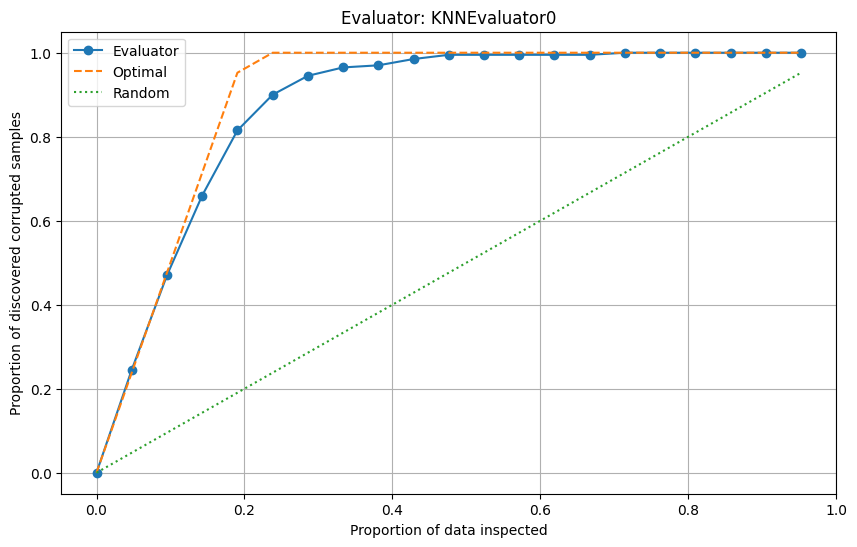

CKNNEvaluator1: {'found_rates': [0.0, 0.245, 0.47, 0.665, 0.82, 0.905, 0.945, 0.965, 0.97, 0.985, 0.995, 0.995, 0.995, 0.995, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


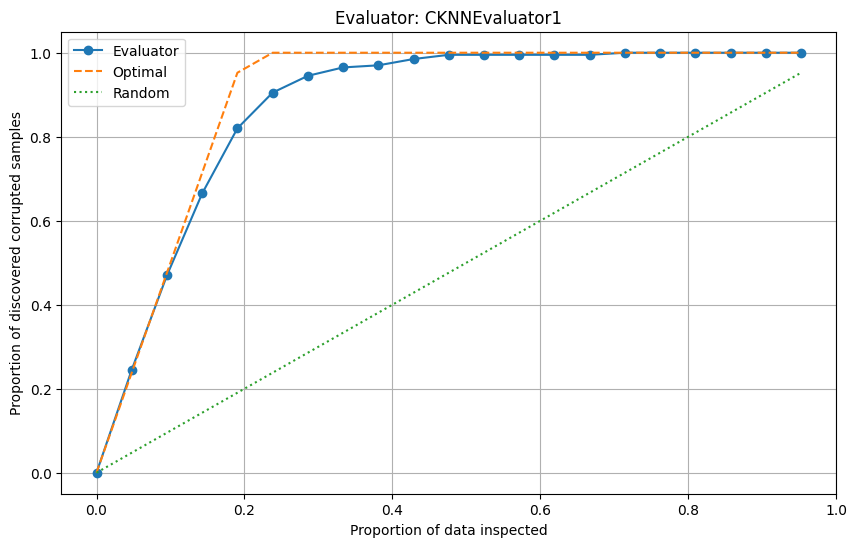

CKNNEvaluator2: {'found_rates': [0.0, 0.245, 0.47, 0.67, 0.825, 0.89, 0.945, 0.965, 0.975, 0.985, 0.995, 0.995, 0.995, 0.995, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


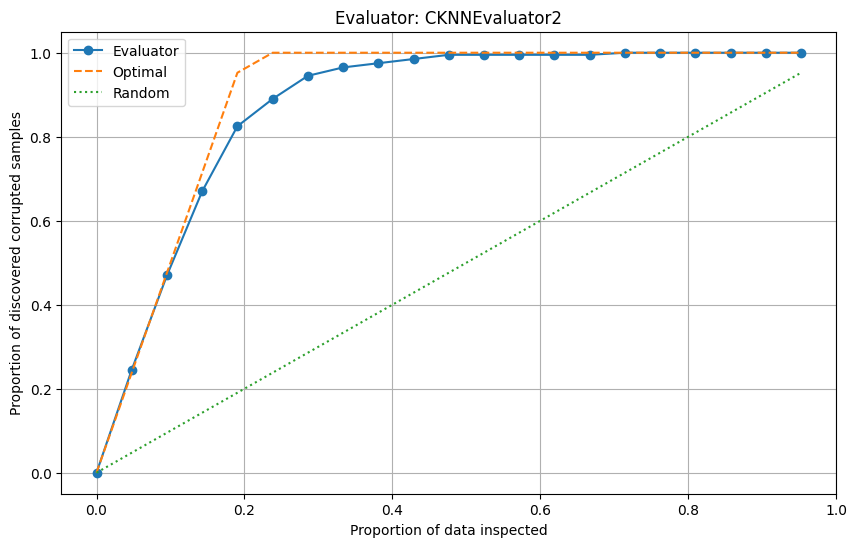

CKNNEvaluator3: {'found_rates': [0.0, 0.245, 0.47, 0.665, 0.805, 0.905, 0.94, 0.955, 0.975, 0.98, 0.995, 0.995, 0.995, 0.995, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


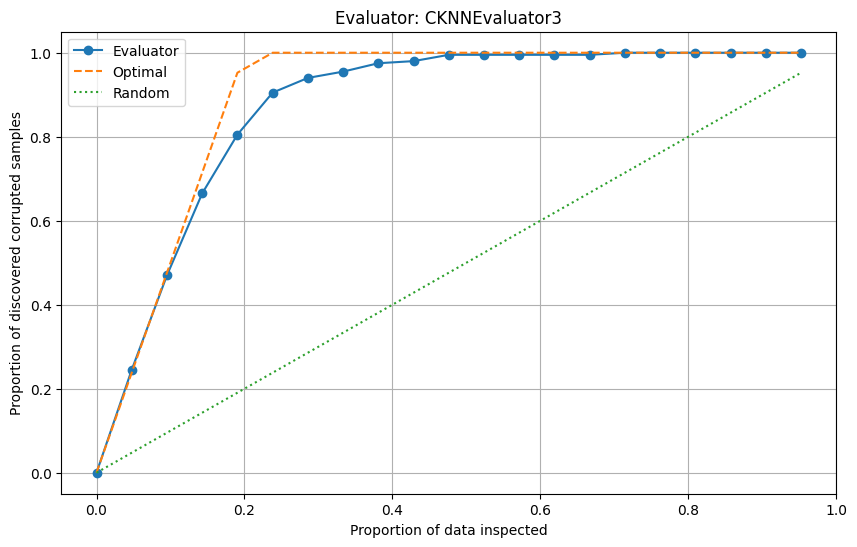

LavaEvaluator_batch4: {'found_rates': [0.0, 0.085, 0.18, 0.265, 0.35, 0.4, 0.49, 0.545, 0.59, 0.635, 0.68, 0.715, 0.775, 0.825, 0.865, 0.91, 0.945, 0.96, 0.97, 0.99, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


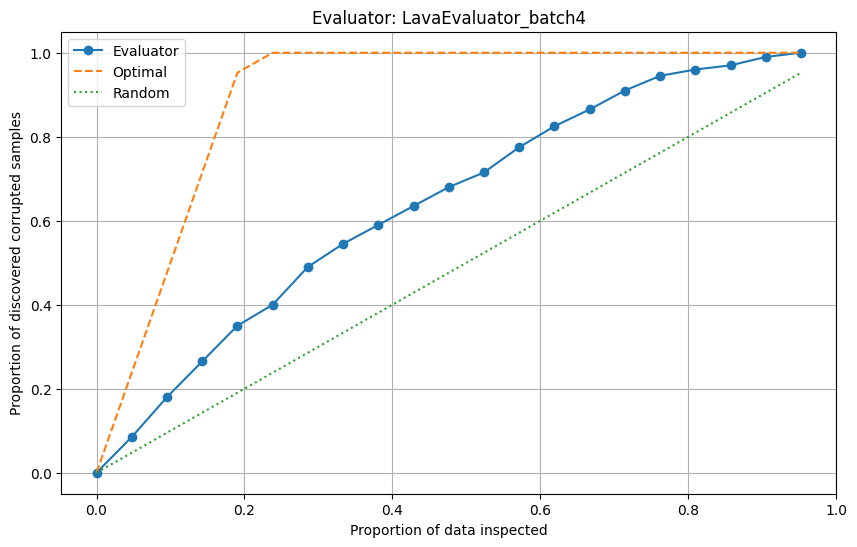

LavaEvaluator_batch5: {'found_rates': [0.0, 0.155, 0.265, 0.415, 0.485, 0.55, 0.62, 0.675, 0.725, 0.77, 0.8, 0.85, 0.895, 0.935, 0.945, 0.955, 0.965, 0.98, 0.99, 0.995, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


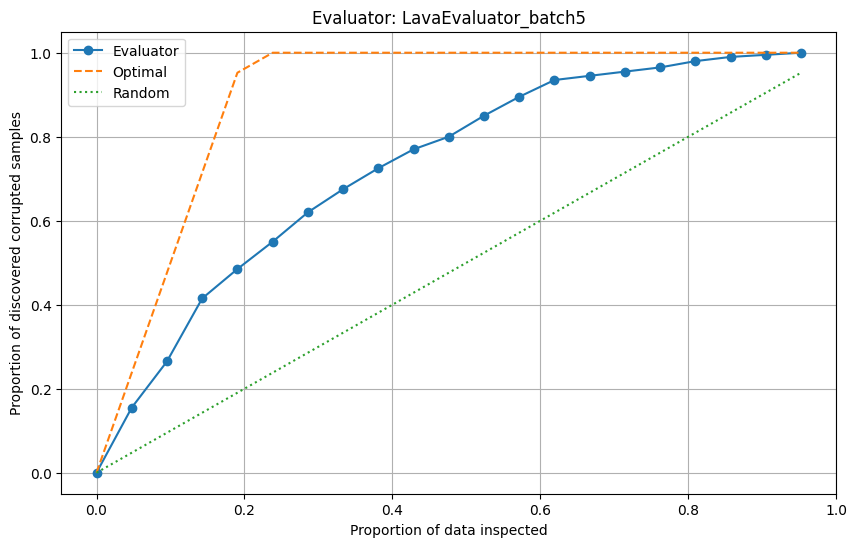

LavaEvaluator_OT6: {'found_rates': [0.0, 0.15, 0.285, 0.4, 0.5, 0.555, 0.63, 0.685, 0.73, 0.785, 0.82, 0.855, 0.89, 0.92, 0.945, 0.96, 0.965, 0.975, 0.995, 0.995, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


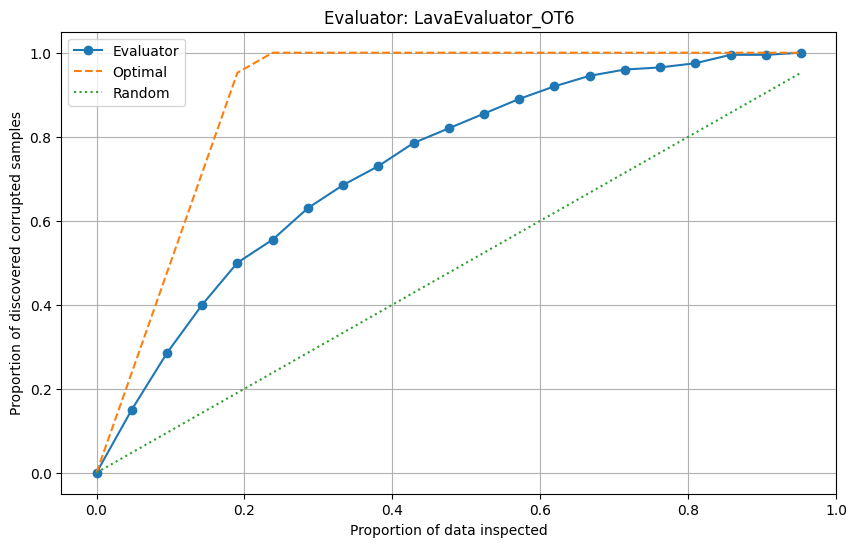

LavaEvaluator_geomloss7: {'found_rates': [0.0, 0.22, 0.395, 0.515, 0.61, 0.665, 0.745, 0.805, 0.835, 0.87, 0.9, 0.925, 0.94, 0.96, 0.975, 0.985, 0.99, 0.99, 0.99, 0.995, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


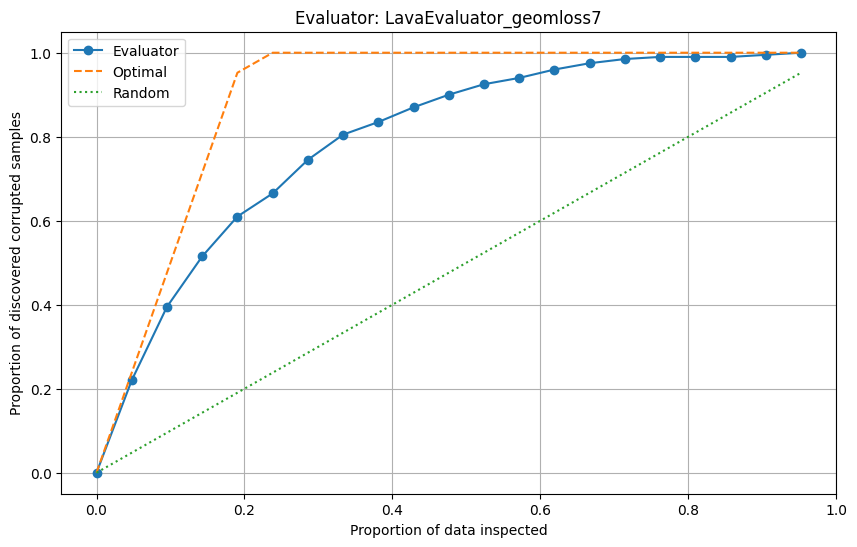

{'KNNEvaluator0': {'found_rates': [0.0,
   0.245,
   0.47,
   0.66,
   0.815,
   0.9,
   0.945,
   0.965,
   0.97,
   0.985,
   0.995,
   0.995,
   0.995,
   0.995,
   0.995,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'CKNNEvaluator1': {'found_rates': [0.0,
   0.245,
   0.47,
   0.665,
   0.82,
   0.905,
   0.945,
   0.965,
   0.97,
   0.985,
   0.995,
   0.995,
   0.995,
   0.995,
   0.995,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.0952380952380952

In [6]:
from base_evaluator import BaseEvaluator, KNNEvaluator,CKNNEvaluator ,LavaEvaluator_geomloss, LavaEvaluator_OT, ExperimentRunner, LavaEvaluator_batch
knn_evaluator = KNNEvaluator()
cknn_evaluator1 = CKNNEvaluator(T = 20, default=False)
cknn_evaluator2 = CKNNEvaluator(T = 300, default=False)
cknn_evaluator3 = CKNNEvaluator(T = 700, default=False)
lava_evaluator_batch1 = LavaEvaluator_batch(batch = 50)
lava_evaluator_batch2 = LavaEvaluator_batch(batch = 500)
lava_evaluator_OT = LavaEvaluator_OT()
lava_evaluator_geomloss = LavaEvaluator_geomloss()
experiment = ExperimentRunner(evaluators=[knn_evaluator, cknn_evaluator1, cknn_evaluator2, cknn_evaluator3, lava_evaluator_batch1, lava_evaluator_batch2, lava_evaluator_OT, lava_evaluator_geomloss])
results = experiment.run(x_embeddings, y_labels_noisy, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [26]:
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
experiment.calculate_label_noise_20(model, noisy_train_indices, 0.3)

Epoch [10/1000], Loss: 2.1591
Epoch [20/1000], Loss: 2.0156
Epoch [30/1000], Loss: 1.9008
Epoch [40/1000], Loss: 1.7971
Epoch [50/1000], Loss: 1.7264
Epoch [60/1000], Loss: 1.6796
Epoch [70/1000], Loss: 1.6482
Epoch [80/1000], Loss: 1.6261
Epoch [90/1000], Loss: 1.6101
Epoch [100/1000], Loss: 1.5968
Epoch [110/1000], Loss: 1.5865
Epoch [120/1000], Loss: 1.5776
Epoch [130/1000], Loss: 1.5700
Epoch [140/1000], Loss: 1.5635
Epoch [150/1000], Loss: 1.5579
Epoch [160/1000], Loss: 1.5524
Epoch [170/1000], Loss: 1.5480
Epoch [180/1000], Loss: 1.5436
Epoch [190/1000], Loss: 1.5398
Epoch [200/1000], Loss: 1.5364
Epoch [210/1000], Loss: 1.5332
Epoch [220/1000], Loss: 1.5302
Epoch [230/1000], Loss: 1.5274
Epoch [240/1000], Loss: 1.5249
Epoch [250/1000], Loss: 1.5228
Epoch [260/1000], Loss: 1.5204
Epoch [270/1000], Loss: 1.5184
Epoch [280/1000], Loss: 1.5165
Epoch [290/1000], Loss: 1.5146
Epoch [300/1000], Loss: 1.5130
Epoch [310/1000], Loss: 1.5114
Epoch [320/1000], Loss: 1.5101
Epoch [330/1000],

{'KNNEvaluator0': {'F1-model': np.float64(0.8379937255090235),
  'Precision': 0.63,
  'Recall': 0.945,
  'F1-Score': 0.7559999999999999},
 'CKNNEvaluator1': {'F1-model': np.float64(0.8379937255090235),
  'Precision': 0.63,
  'Recall': 0.945,
  'F1-Score': 0.7559999999999999},
 'CKNNEvaluator2': {'F1-model': np.float64(0.8342126680204471),
  'Precision': 0.6266666666666667,
  'Recall': 0.94,
  'F1-Score': 0.752},
 'CKNNEvaluator3': {'F1-model': np.float64(0.8355088396490643),
  'Precision': 0.59,
  'Recall': 0.885,
  'F1-Score': 0.708},
 'LavaEvaluator_batch4': {'F1-model': np.float64(0.8046971612804533),
  'Precision': 0.35333333333333333,
  'Recall': 0.53,
  'F1-Score': 0.424},
 'LavaEvaluator_batch5': {'F1-model': np.float64(0.7929834302106175),
  'Precision': 0.4066666666666667,
  'Recall': 0.61,
  'F1-Score': 0.488},
 'LavaEvaluator_OT6': {'F1-model': np.float64(0.8032823236893574),
  'Precision': 0.42,
  'Recall': 0.63,
  'F1-Score': 0.504},
 'LavaEvaluator_geomloss7': {'F1-model'

In [7]:
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
experiment.calculate_label_noise_20(model, noisy_train_indices, 0.4)

Epoch [10/1000], Loss: 2.1512
Epoch [20/1000], Loss: 1.9795
Epoch [30/1000], Loss: 1.8530
Epoch [40/1000], Loss: 1.7722
Epoch [50/1000], Loss: 1.7324
Epoch [60/1000], Loss: 1.7083
Epoch [70/1000], Loss: 1.6895
Epoch [80/1000], Loss: 1.6762
Epoch [90/1000], Loss: 1.6540
Epoch [100/1000], Loss: 1.6325
Epoch [110/1000], Loss: 1.6204
Epoch [120/1000], Loss: 1.6100
Epoch [130/1000], Loss: 1.6031
Epoch [140/1000], Loss: 1.5961
Epoch [150/1000], Loss: 1.5913
Epoch [160/1000], Loss: 1.5867
Epoch [170/1000], Loss: 1.5831
Epoch [180/1000], Loss: 1.5775
Epoch [190/1000], Loss: 1.5765
Epoch [200/1000], Loss: 1.5732
Epoch [210/1000], Loss: 1.5694
Epoch [220/1000], Loss: 1.5663
Epoch [230/1000], Loss: 1.5668
Epoch [240/1000], Loss: 1.5636
Epoch [250/1000], Loss: 1.5607
Epoch [260/1000], Loss: 1.5591
Epoch [270/1000], Loss: 1.5571
Epoch [280/1000], Loss: 1.5556
Epoch [290/1000], Loss: 1.5556
Epoch [300/1000], Loss: 1.5531
Epoch [310/1000], Loss: 1.5524
Epoch [320/1000], Loss: 1.5482
Epoch [330/1000],

{'KNNEvaluator0': {'F1-model': np.float64(0.8234000229496161),
  'Precision': 0.485,
  'Recall': 0.97,
  'F1-Score': 0.6466666666666666},
 'CKNNEvaluator1': {'F1-model': np.float64(0.8234000229496161),
  'Precision': 0.485,
  'Recall': 0.97,
  'F1-Score': 0.6466666666666666},
 'CKNNEvaluator2': {'F1-model': np.float64(0.8253860637076716),
  'Precision': 0.4875,
  'Recall': 0.975,
  'F1-Score': 0.65},
 'CKNNEvaluator3': {'F1-model': np.float64(0.8266749569377232),
  'Precision': 0.4875,
  'Recall': 0.975,
  'F1-Score': 0.65},
 'LavaEvaluator_batch4': {'F1-model': np.float64(0.8014450407129239),
  'Precision': 0.295,
  'Recall': 0.59,
  'F1-Score': 0.3933333333333333},
 'LavaEvaluator_batch5': {'F1-model': np.float64(0.8066539027660629),
  'Precision': 0.3625,
  'Recall': 0.725,
  'F1-Score': 0.4833333333333334},
 'LavaEvaluator_OT6': {'F1-model': np.float64(0.80773026673311),
  'Precision': 0.365,
  'Recall': 0.73,
  'F1-Score': 0.48666666666666664},
 'LavaEvaluator_geomloss7': {'F1-mod

In [8]:
experiment.calculate_label_noise_20(model, noisy_train_indices, 0.3)

Epoch [10/1000], Loss: 2.1516
Epoch [20/1000], Loss: 1.9879
Epoch [30/1000], Loss: 1.8650
Epoch [40/1000], Loss: 1.7951
Epoch [50/1000], Loss: 1.7570
Epoch [60/1000], Loss: 1.7275
Epoch [70/1000], Loss: 1.6955
Epoch [80/1000], Loss: 1.6761
Epoch [90/1000], Loss: 1.6618
Epoch [100/1000], Loss: 1.6500
Epoch [110/1000], Loss: 1.6403
Epoch [120/1000], Loss: 1.6296
Epoch [130/1000], Loss: 1.6065
Epoch [140/1000], Loss: 1.5887
Epoch [150/1000], Loss: 1.5774
Epoch [160/1000], Loss: 1.5683
Epoch [170/1000], Loss: 1.5609
Epoch [180/1000], Loss: 1.5550
Epoch [190/1000], Loss: 1.5497
Epoch [200/1000], Loss: 1.5450
Epoch [210/1000], Loss: 1.5409
Epoch [220/1000], Loss: 1.5370
Epoch [230/1000], Loss: 1.5337
Epoch [240/1000], Loss: 1.5306
Epoch [250/1000], Loss: 1.5278
Epoch [260/1000], Loss: 1.5254
Epoch [270/1000], Loss: 1.5229
Epoch [280/1000], Loss: 1.5205
Epoch [290/1000], Loss: 1.5184
Epoch [300/1000], Loss: 1.5164
Epoch [310/1000], Loss: 1.5145
Epoch [320/1000], Loss: 1.5131
Epoch [330/1000],

{'KNNEvaluator0': {'F1-model': np.float64(0.8365661617050527),
  'Precision': 0.63,
  'Recall': 0.945,
  'F1-Score': 0.7559999999999999},
 'CKNNEvaluator1': {'F1-model': np.float64(0.8365661617050527),
  'Precision': 0.63,
  'Recall': 0.945,
  'F1-Score': 0.7559999999999999},
 'CKNNEvaluator2': {'F1-model': np.float64(0.8385692356315371),
  'Precision': 0.63,
  'Recall': 0.945,
  'F1-Score': 0.7559999999999999},
 'CKNNEvaluator3': {'F1-model': np.float64(0.8317062742402801),
  'Precision': 0.6266666666666667,
  'Recall': 0.94,
  'F1-Score': 0.752},
 'LavaEvaluator_batch4': {'F1-model': np.float64(0.8043256998616102),
  'Precision': 0.32666666666666666,
  'Recall': 0.49,
  'F1-Score': 0.392},
 'LavaEvaluator_batch5': {'F1-model': np.float64(0.8111989189474217),
  'Precision': 0.41333333333333333,
  'Recall': 0.62,
  'F1-Score': 0.496},
 'LavaEvaluator_OT6': {'F1-model': np.float64(0.804821804338425),
  'Precision': 0.42,
  'Recall': 0.63,
  'F1-Score': 0.504},
 'LavaEvaluator_geomloss7'

Running remove_low experiment...
Epoch [10/1000], Loss: 1.8089
Epoch [20/1000], Loss: 1.7474
Epoch [30/1000], Loss: 1.7164
Epoch [40/1000], Loss: 1.6993
Epoch [50/1000], Loss: 1.6904
Epoch [60/1000], Loss: 1.6806
Epoch [70/1000], Loss: 1.6757
Epoch [80/1000], Loss: 1.6689
Epoch [90/1000], Loss: 1.6644
Epoch [100/1000], Loss: 1.6636
Epoch [110/1000], Loss: 1.6598
Epoch [120/1000], Loss: 1.6539
Epoch [130/1000], Loss: 1.6541
Epoch [140/1000], Loss: 1.6531
Epoch [150/1000], Loss: 1.6488
Epoch [160/1000], Loss: 1.6473
Epoch [170/1000], Loss: 1.6459
Epoch [180/1000], Loss: 1.6531
Epoch [190/1000], Loss: 1.6458
Epoch [200/1000], Loss: 1.6503
Epoch [210/1000], Loss: 1.6465
Epoch [220/1000], Loss: 1.6398
Epoch [230/1000], Loss: 1.6418
Epoch [240/1000], Loss: 1.6349
Epoch [250/1000], Loss: 1.6339
Epoch [260/1000], Loss: 1.6357
Epoch [270/1000], Loss: 1.6321
Epoch [280/1000], Loss: 1.6426
Epoch [290/1000], Loss: 1.6388
Epoch [300/1000], Loss: 1.6348
Epoch [310/1000], Loss: 1.6343
Epoch [320/1000

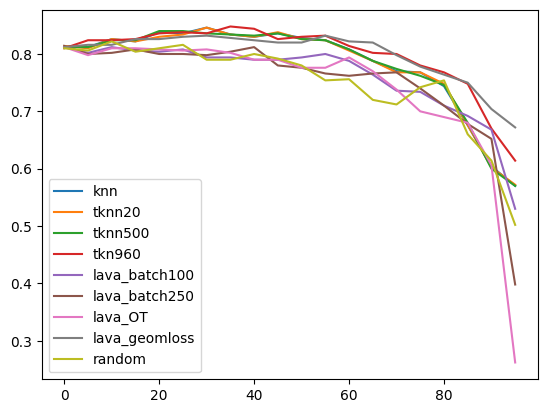

Running remove_high experiment...
Epoch [10/1000], Loss: 1.8017
Epoch [20/1000], Loss: 1.7480
Epoch [30/1000], Loss: 1.7196
Epoch [40/1000], Loss: 1.7039
Epoch [50/1000], Loss: 1.6895
Epoch [60/1000], Loss: 1.6833
Epoch [70/1000], Loss: 1.6775
Epoch [80/1000], Loss: 1.6751
Epoch [90/1000], Loss: 1.6648
Epoch [100/1000], Loss: 1.6635
Epoch [110/1000], Loss: 1.6548
Epoch [120/1000], Loss: 1.6629
Epoch [130/1000], Loss: 1.6551
Epoch [140/1000], Loss: 1.6505
Epoch [150/1000], Loss: 1.6463
Epoch [160/1000], Loss: 1.6529
Epoch [170/1000], Loss: 1.6461
Epoch [180/1000], Loss: 1.6472
Epoch [190/1000], Loss: 1.6431
Epoch [200/1000], Loss: 1.6501
Epoch [210/1000], Loss: 1.6371
Epoch [220/1000], Loss: 1.6385
Epoch [230/1000], Loss: 1.6380
Epoch [240/1000], Loss: 1.6367
Epoch [250/1000], Loss: 1.6470
Epoch [260/1000], Loss: 1.6404
Epoch [270/1000], Loss: 1.6339
Epoch [280/1000], Loss: 1.6365
Epoch [290/1000], Loss: 1.6352
Epoch [300/1000], Loss: 1.6402
Epoch [310/1000], Loss: 1.6337
Epoch [320/100

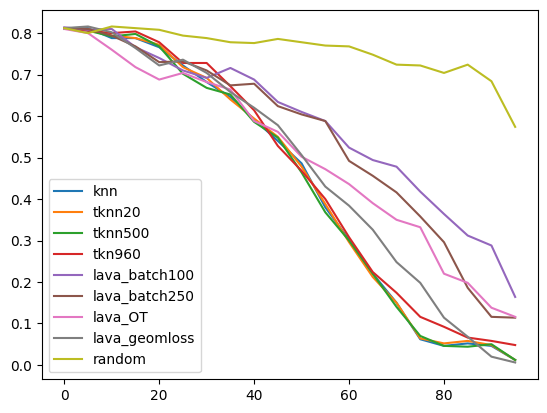

Running add_low experiment...
Epoch [10/1000], Loss: 2.2134
Epoch [20/1000], Loss: 2.1126
Epoch [30/1000], Loss: 2.0197
Epoch [40/1000], Loss: 1.9570
Epoch [50/1000], Loss: 1.9078
Epoch [60/1000], Loss: 1.8746
Epoch [70/1000], Loss: 1.8151
Epoch [80/1000], Loss: 1.7548
Epoch [90/1000], Loss: 1.7421
Epoch [100/1000], Loss: 1.6869
Epoch [110/1000], Loss: 1.6638
Epoch [120/1000], Loss: 1.6421
Epoch [130/1000], Loss: 1.6328
Epoch [140/1000], Loss: 1.6012
Epoch [150/1000], Loss: 1.6035
Epoch [160/1000], Loss: 1.6073
Epoch [170/1000], Loss: 1.5862
Epoch [180/1000], Loss: 1.5766
Epoch [190/1000], Loss: 1.5631
Epoch [200/1000], Loss: 1.5452
Epoch [210/1000], Loss: 1.5524
Epoch [220/1000], Loss: 1.5508
Epoch [230/1000], Loss: 1.5681
Epoch [240/1000], Loss: 1.5320
Epoch [250/1000], Loss: 1.5303
Epoch [260/1000], Loss: 1.5261
Epoch [270/1000], Loss: 1.5212
Epoch [280/1000], Loss: 1.5154
Epoch [290/1000], Loss: 1.5097
Epoch [300/1000], Loss: 1.5090
Epoch [310/1000], Loss: 1.5032
Epoch [320/1000], 

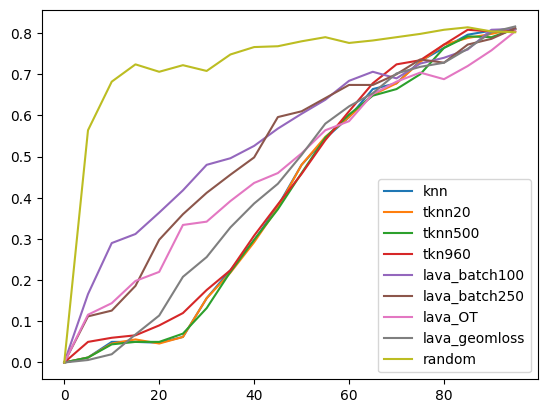

Running add_high experiment...
Epoch [10/1000], Loss: 1.7490
Epoch [20/1000], Loss: 1.5930
Epoch [30/1000], Loss: 1.5652
Epoch [40/1000], Loss: 1.5151
Epoch [50/1000], Loss: 1.4997
Epoch [60/1000], Loss: 1.5047
Epoch [70/1000], Loss: 1.4904
Epoch [80/1000], Loss: 1.4982
Epoch [90/1000], Loss: 1.4860
Epoch [100/1000], Loss: 1.4847
Epoch [110/1000], Loss: 1.4943
Epoch [120/1000], Loss: 1.4822
Epoch [130/1000], Loss: 1.4820
Epoch [140/1000], Loss: 1.4808
Epoch [150/1000], Loss: 1.4795
Epoch [160/1000], Loss: 1.4777
Epoch [170/1000], Loss: 1.4796
Epoch [180/1000], Loss: 1.4712
Epoch [190/1000], Loss: 1.4680
Epoch [200/1000], Loss: 1.4681
Epoch [210/1000], Loss: 1.4665
Epoch [220/1000], Loss: 1.4662
Epoch [230/1000], Loss: 1.4658
Epoch [240/1000], Loss: 1.4658
Epoch [250/1000], Loss: 1.4656
Epoch [260/1000], Loss: 1.4649
Epoch [270/1000], Loss: 1.4648
Epoch [280/1000], Loss: 1.4645
Epoch [290/1000], Loss: 1.4649
Epoch [300/1000], Loss: 1.4643
Epoch [310/1000], Loss: 1.4644
Epoch [320/1000],

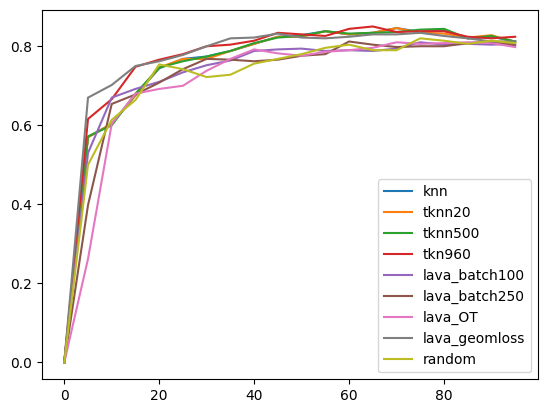

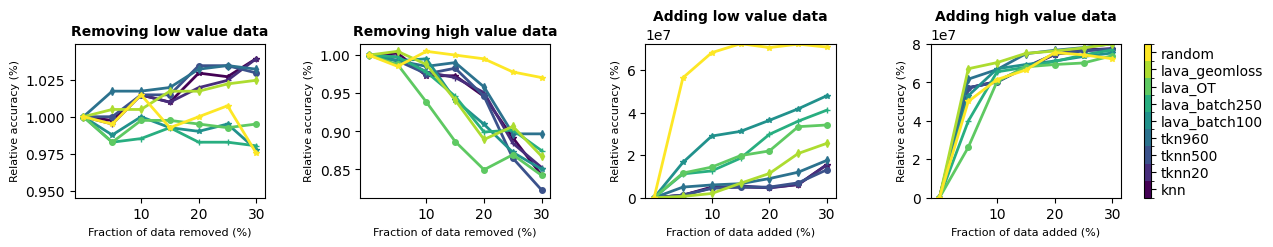

In [28]:
from experiment_run import run_experiments
seed = 2
np.random.seed(seed)
rand_lst = []
shap_list = [value for value in results.values()]
rand_lst.append(np.random.rand(len(shap_list[0])))
name = ['knn', 'tknn20' , 'tknn500', 'tkn960', 'lava_batch100', 'lava_batch250', 'lava_OT', 'lava_geomloss', 'random']
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0], shap_list[1], shap_list[2] , shap_list[3], shap_list[4], shap_list[5], shap_list[6], shap_list[7], rand_lst[0]]
run_experiments(values, name, x_embeddings, y_labels_noisy, xt_embeddings, yt_labels, model)

In [10]:
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
experiment.calculate_WAD(model, num_steps=5)

Epoch [10/100], Loss: 2.2047
Epoch [20/100], Loss: 2.0873
Epoch [30/100], Loss: 2.0047
Epoch [40/100], Loss: 1.9415
Epoch [50/100], Loss: 1.8916
Epoch [60/100], Loss: 1.8550
Epoch [70/100], Loss: 1.8338
Epoch [80/100], Loss: 1.8187
Epoch [90/100], Loss: 1.8036
Epoch [100/100], Loss: 1.7915


Evaluating WAD:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.9794
Epoch [20/100], Loss: 1.8964
Epoch [30/100], Loss: 1.8639
Epoch [40/100], Loss: 1.8437
Epoch [50/100], Loss: 1.7998
Epoch [60/100], Loss: 1.7680
Epoch [70/100], Loss: 1.7510
Epoch [80/100], Loss: 1.7402
Epoch [90/100], Loss: 1.7281


Evaluating WAD:  25%|██▌       | 1/4 [00:02<00:07,  2.56s/it]

Epoch [100/100], Loss: 1.7158
Epoch [10/100], Loss: 2.1361
Epoch [20/100], Loss: 2.0443
Epoch [30/100], Loss: 1.9710
Epoch [40/100], Loss: 1.9270
Epoch [50/100], Loss: 1.8943
Epoch [60/100], Loss: 1.8701
Epoch [70/100], Loss: 1.8443
Epoch [80/100], Loss: 1.8189
Epoch [90/100], Loss: 1.8003


Evaluating WAD:  50%|█████     | 2/4 [00:03<00:03,  1.88s/it]

Epoch [100/100], Loss: 1.7843
Epoch [10/100], Loss: 2.2338
Epoch [20/100], Loss: 2.1529
Epoch [30/100], Loss: 2.0889
Epoch [40/100], Loss: 2.0411
Epoch [50/100], Loss: 1.9964
Epoch [60/100], Loss: 1.9529
Epoch [70/100], Loss: 1.9279


Evaluating WAD:  75%|███████▌  | 3/4 [00:04<00:01,  1.54s/it]

Epoch [80/100], Loss: 1.9025
Epoch [90/100], Loss: 1.8848
Epoch [100/100], Loss: 1.8711
KNNEvaluator0: 0.0028573333333333324


Epoch [10/100], Loss: 2.2031
Epoch [20/100], Loss: 2.0886
Epoch [30/100], Loss: 2.0086
Epoch [40/100], Loss: 1.9432
Epoch [50/100], Loss: 1.8969
Epoch [60/100], Loss: 1.8561
Epoch [70/100], Loss: 1.8363
Epoch [80/100], Loss: 1.8224
Epoch [90/100], Loss: 1.8016
Epoch [100/100], Loss: 1.7947


Evaluating WAD:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.9656
Epoch [20/100], Loss: 1.8972
Epoch [30/100], Loss: 1.8648
Epoch [40/100], Loss: 1.8397
Epoch [50/100], Loss: 1.8070
Epoch [60/100], Loss: 1.7717
Epoch [70/100], Loss: 1.7481
Epoch [80/100], Loss: 1.7377


Evaluating WAD:  25%|██▌       | 1/4 [00:02<00:06,  2.05s/it]

Epoch [90/100], Loss: 1.7289
Epoch [100/100], Loss: 1.7210
Epoch [10/100], Loss: 2.1379
Epoch [20/100], Loss: 2.0395
Epoch [30/100], Loss: 1.9669
Epoch [40/100], Loss: 1.9291
Epoch [50/100], Loss: 1.8937
Epoch [60/100], Loss: 1.8682
Epoch [70/100], Loss: 1.8497
Epoch [80/100], Loss: 1.8287


Evaluating WAD:  50%|█████     | 2/4 [00:03<00:03,  1.62s/it]

Epoch [90/100], Loss: 1.8047
Epoch [100/100], Loss: 1.7861
Epoch [10/100], Loss: 2.2325
Epoch [20/100], Loss: 2.1534
Epoch [30/100], Loss: 2.0884
Epoch [40/100], Loss: 2.0353
Epoch [50/100], Loss: 1.9950
Epoch [60/100], Loss: 1.9598
Epoch [70/100], Loss: 1.9293
Epoch [80/100], Loss: 1.9061


Evaluating WAD:  75%|███████▌  | 3/4 [00:04<00:01,  1.34s/it]

Epoch [90/100], Loss: 1.8835
Epoch [100/100], Loss: 1.8708
CKNNEvaluator1: 0.0030626666666666667


Epoch [10/100], Loss: 2.2063
Epoch [20/100], Loss: 2.0920
Epoch [30/100], Loss: 1.9972
Epoch [40/100], Loss: 1.9337
Epoch [50/100], Loss: 1.8864
Epoch [60/100], Loss: 1.8523
Epoch [70/100], Loss: 1.8355
Epoch [80/100], Loss: 1.8150
Epoch [90/100], Loss: 1.8058
Epoch [100/100], Loss: 1.7957


Evaluating WAD:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.9664
Epoch [20/100], Loss: 1.8989
Epoch [30/100], Loss: 1.8637
Epoch [40/100], Loss: 1.8494
Epoch [50/100], Loss: 1.8242
Epoch [60/100], Loss: 1.7930
Epoch [70/100], Loss: 1.7596
Epoch [80/100], Loss: 1.7397


Evaluating WAD:  25%|██▌       | 1/4 [00:02<00:06,  2.07s/it]

Epoch [90/100], Loss: 1.7306
Epoch [100/100], Loss: 1.7218
Epoch [10/100], Loss: 2.1364
Epoch [20/100], Loss: 2.0413
Epoch [30/100], Loss: 1.9801
Epoch [40/100], Loss: 1.9347
Epoch [50/100], Loss: 1.8972
Epoch [60/100], Loss: 1.8712
Epoch [70/100], Loss: 1.8482
Epoch [80/100], Loss: 1.8307


Evaluating WAD:  50%|█████     | 2/4 [00:03<00:03,  1.64s/it]

Epoch [90/100], Loss: 1.8231
Epoch [100/100], Loss: 1.8054
Epoch [10/100], Loss: 2.2325
Epoch [20/100], Loss: 2.1571
Epoch [30/100], Loss: 2.0910
Epoch [40/100], Loss: 2.0426
Epoch [50/100], Loss: 2.0054
Epoch [60/100], Loss: 1.9689
Epoch [70/100], Loss: 1.9420
Epoch [80/100], Loss: 1.9126
Epoch [90/100], Loss: 1.8871


Evaluating WAD:  75%|███████▌  | 3/4 [00:04<00:01,  1.40s/it]

Epoch [100/100], Loss: 1.8736
CKNNEvaluator2: 0.003121333333333332


Epoch [10/100], Loss: 2.2047
Epoch [20/100], Loss: 2.0900
Epoch [30/100], Loss: 2.0082
Epoch [40/100], Loss: 1.9345
Epoch [50/100], Loss: 1.8853
Epoch [60/100], Loss: 1.8575
Epoch [70/100], Loss: 1.8358
Epoch [80/100], Loss: 1.8196
Epoch [90/100], Loss: 1.8043
Epoch [100/100], Loss: 1.7952


Evaluating WAD:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.9668
Epoch [20/100], Loss: 1.8932
Epoch [30/100], Loss: 1.8657
Epoch [40/100], Loss: 1.8453
Epoch [50/100], Loss: 1.8279
Epoch [60/100], Loss: 1.8058
Epoch [70/100], Loss: 1.7861
Epoch [80/100], Loss: 1.7724


Evaluating WAD:  25%|██▌       | 1/4 [00:01<00:05,  1.92s/it]

Epoch [90/100], Loss: 1.7648
Epoch [100/100], Loss: 1.7593
Epoch [10/100], Loss: 2.1381
Epoch [20/100], Loss: 2.0486
Epoch [30/100], Loss: 1.9932
Epoch [40/100], Loss: 1.9481
Epoch [50/100], Loss: 1.9131
Epoch [60/100], Loss: 1.8843
Epoch [70/100], Loss: 1.8613
Epoch [80/100], Loss: 1.8364


Evaluating WAD:  50%|█████     | 2/4 [00:03<00:03,  1.66s/it]

Epoch [90/100], Loss: 1.8089
Epoch [100/100], Loss: 1.7891
Epoch [10/100], Loss: 2.2451
Epoch [20/100], Loss: 2.1604
Epoch [30/100], Loss: 2.0809
Epoch [40/100], Loss: 2.0143
Epoch [50/100], Loss: 1.9598
Epoch [60/100], Loss: 1.9235
Epoch [70/100], Loss: 1.8932
Epoch [80/100], Loss: 1.8669


Evaluating WAD:  75%|███████▌  | 3/4 [00:04<00:01,  1.37s/it]

Epoch [90/100], Loss: 1.8525
Epoch [100/100], Loss: 1.8323
CKNNEvaluator3: 0.0034793333333333325


Epoch [10/100], Loss: 2.2073
Epoch [20/100], Loss: 2.0933
Epoch [30/100], Loss: 2.0020
Epoch [40/100], Loss: 1.9376
Epoch [50/100], Loss: 1.8904
Epoch [60/100], Loss: 1.8534
Epoch [70/100], Loss: 1.8313
Epoch [80/100], Loss: 1.8206
Epoch [90/100], Loss: 1.8066
Epoch [100/100], Loss: 1.8014


Evaluating WAD:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.9095
Epoch [20/100], Loss: 1.8256
Epoch [30/100], Loss: 1.7883
Epoch [40/100], Loss: 1.7679
Epoch [50/100], Loss: 1.7546
Epoch [60/100], Loss: 1.7476
Epoch [70/100], Loss: 1.7336
Epoch [80/100], Loss: 1.7296


Evaluating WAD:  25%|██▌       | 1/4 [00:01<00:05,  1.85s/it]

Epoch [90/100], Loss: 1.7278
Epoch [100/100], Loss: 1.7214
Epoch [10/100], Loss: 1.9913
Epoch [20/100], Loss: 1.8731
Epoch [30/100], Loss: 1.8216
Epoch [40/100], Loss: 1.7888
Epoch [50/100], Loss: 1.7692
Epoch [60/100], Loss: 1.7548
Epoch [70/100], Loss: 1.7404
Epoch [80/100], Loss: 1.7301


Evaluating WAD:  50%|█████     | 2/4 [00:03<00:03,  1.56s/it]

Epoch [90/100], Loss: 1.7250
Epoch [100/100], Loss: 1.7211
Epoch [10/100], Loss: 2.0898
Epoch [20/100], Loss: 1.9708
Epoch [30/100], Loss: 1.9046
Epoch [40/100], Loss: 1.8607
Epoch [50/100], Loss: 1.8282
Epoch [60/100], Loss: 1.8044
Epoch [70/100], Loss: 1.7726
Epoch [80/100], Loss: 1.7470
Epoch [90/100], Loss: 1.7305


Evaluating WAD:  75%|███████▌  | 3/4 [00:03<00:01,  1.28s/it]

Epoch [100/100], Loss: 1.7075
LavaEvaluator_batch4: 0.0018506666666666665


Epoch [10/100], Loss: 2.2032
Epoch [20/100], Loss: 2.0944
Epoch [30/100], Loss: 2.0080
Epoch [40/100], Loss: 1.9393
Epoch [50/100], Loss: 1.8878
Epoch [60/100], Loss: 1.8604
Epoch [70/100], Loss: 1.8359
Epoch [80/100], Loss: 1.8155
Epoch [90/100], Loss: 1.8096
Epoch [100/100], Loss: 1.8031


Evaluating WAD:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.9253
Epoch [20/100], Loss: 1.8580
Epoch [30/100], Loss: 1.8194
Epoch [40/100], Loss: 1.8084
Epoch [50/100], Loss: 1.7834
Epoch [60/100], Loss: 1.7731
Epoch [70/100], Loss: 1.7454
Epoch [80/100], Loss: 1.7339
Epoch [90/100], Loss: 1.7233


Evaluating WAD:  25%|██▌       | 1/4 [00:01<00:05,  1.89s/it]

Epoch [100/100], Loss: 1.7162
Epoch [10/100], Loss: 2.0071
Epoch [20/100], Loss: 1.9340
Epoch [30/100], Loss: 1.9011
Epoch [40/100], Loss: 1.8830
Epoch [50/100], Loss: 1.8621
Epoch [60/100], Loss: 1.8349
Epoch [70/100], Loss: 1.8230
Epoch [80/100], Loss: 1.8085
Epoch [90/100], Loss: 1.8027


Evaluating WAD:  50%|█████     | 2/4 [00:03<00:03,  1.51s/it]

Epoch [100/100], Loss: 1.7977
Epoch [10/100], Loss: 2.1360
Epoch [20/100], Loss: 2.0201
Epoch [30/100], Loss: 1.9486
Epoch [40/100], Loss: 1.8997
Epoch [50/100], Loss: 1.8676
Epoch [60/100], Loss: 1.8370
Epoch [70/100], Loss: 1.8174


Evaluating WAD:  75%|███████▌  | 3/4 [00:03<00:01,  1.25s/it]

Epoch [80/100], Loss: 1.7999
Epoch [90/100], Loss: 1.7890
Epoch [100/100], Loss: 1.7791
LavaEvaluator_batch5: 0.003180666666666666


Epoch [10/100], Loss: 2.2076
Epoch [20/100], Loss: 2.0897
Epoch [30/100], Loss: 2.0025
Epoch [40/100], Loss: 1.9392
Epoch [50/100], Loss: 1.8824
Epoch [60/100], Loss: 1.8528
Epoch [70/100], Loss: 1.8345
Epoch [80/100], Loss: 1.8177
Epoch [90/100], Loss: 1.8051
Epoch [100/100], Loss: 1.7953


Evaluating WAD:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.9268
Epoch [20/100], Loss: 1.8570
Epoch [30/100], Loss: 1.8198
Epoch [40/100], Loss: 1.8068
Epoch [50/100], Loss: 1.7739
Epoch [60/100], Loss: 1.7550
Epoch [70/100], Loss: 1.7400
Epoch [80/100], Loss: 1.7300


Evaluating WAD:  25%|██▌       | 1/4 [00:01<00:05,  1.96s/it]

Epoch [90/100], Loss: 1.7199
Epoch [100/100], Loss: 1.7170
Epoch [10/100], Loss: 2.0356
Epoch [20/100], Loss: 1.9667
Epoch [30/100], Loss: 1.9217
Epoch [40/100], Loss: 1.9011
Epoch [50/100], Loss: 1.8766
Epoch [60/100], Loss: 1.8528
Epoch [70/100], Loss: 1.8363
Epoch [80/100], Loss: 1.8203


Evaluating WAD:  50%|█████     | 2/4 [00:03<00:03,  1.60s/it]

Epoch [90/100], Loss: 1.8109
Epoch [100/100], Loss: 1.7995
Epoch [10/100], Loss: 2.1346
Epoch [20/100], Loss: 2.0102
Epoch [30/100], Loss: 1.9381
Epoch [40/100], Loss: 1.8943
Epoch [50/100], Loss: 1.8559
Epoch [60/100], Loss: 1.8298
Epoch [70/100], Loss: 1.8090
Epoch [80/100], Loss: 1.7987
Epoch [90/100], Loss: 1.7866


Evaluating WAD:  75%|███████▌  | 3/4 [00:03<00:01,  1.32s/it]

Epoch [100/100], Loss: 1.7758
LavaEvaluator_OT6: 0.0032739999999999996


Epoch [10/100], Loss: 2.2034
Epoch [20/100], Loss: 2.0894
Epoch [30/100], Loss: 2.0114
Epoch [40/100], Loss: 1.9427
Epoch [50/100], Loss: 1.8872
Epoch [60/100], Loss: 1.8531
Epoch [70/100], Loss: 1.8329
Epoch [80/100], Loss: 1.8185
Epoch [90/100], Loss: 1.8059
Epoch [100/100], Loss: 1.7903


Evaluating WAD:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.9269
Epoch [20/100], Loss: 1.8514
Epoch [30/100], Loss: 1.8124
Epoch [40/100], Loss: 1.7908
Epoch [50/100], Loss: 1.7789
Epoch [60/100], Loss: 1.7695
Epoch [70/100], Loss: 1.7610
Epoch [80/100], Loss: 1.7519
Epoch [90/100], Loss: 1.7478
Epoch [100/100], Loss: 1.7404


Evaluating WAD:  25%|██▌       | 1/4 [00:01<00:05,  1.97s/it]

Epoch [10/100], Loss: 2.0881
Epoch [20/100], Loss: 1.9897
Epoch [30/100], Loss: 1.9311
Epoch [40/100], Loss: 1.8902
Epoch [50/100], Loss: 1.8576
Epoch [60/100], Loss: 1.8274
Epoch [70/100], Loss: 1.8082
Epoch [80/100], Loss: 1.7906


Evaluating WAD:  50%|█████     | 2/4 [00:03<00:03,  1.56s/it]

Epoch [90/100], Loss: 1.7804
Epoch [100/100], Loss: 1.7625
Epoch [10/100], Loss: 2.1675
Epoch [20/100], Loss: 2.1088
Epoch [30/100], Loss: 2.0587
Epoch [40/100], Loss: 1.9981
Epoch [50/100], Loss: 1.9469
Epoch [60/100], Loss: 1.9057
Epoch [70/100], Loss: 1.8787
Epoch [80/100], Loss: 1.8581
Epoch [90/100], Loss: 1.8421


Evaluating WAD:  75%|███████▌  | 3/4 [00:03<00:01,  1.30s/it]

Epoch [100/100], Loss: 1.8247
LavaEvaluator_geomloss7: 0.003038666666666666


{'KNNEvaluator0': np.float64(0.0028573333333333324),
 'CKNNEvaluator1': np.float64(0.0030626666666666667),
 'CKNNEvaluator2': np.float64(0.003121333333333332),
 'CKNNEvaluator3': np.float64(0.0034793333333333325),
 'LavaEvaluator_batch4': np.float64(0.0018506666666666665),
 'LavaEvaluator_batch5': np.float64(0.003180666666666666),
 'LavaEvaluator_OT6': np.float64(0.0032739999999999996),
 'LavaEvaluator_geomloss7': np.float64(0.003038666666666666)}

In [ ]:
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
experiment.calculate_WAD(model, num_steps=50)

Running evaluator: HierLavaEvaluator0


batch LAVA:  55%|█████▌    | 11/20 [01:39<01:19,  8.85s/it]d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
batch LAVA: 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


HierLavaEvaluator0 completed in 182.82 seconds.
Running evaluator: KNNEvaluator1


100%|██████████| 9999/9999 [00:24<00:00, 404.14it/s]


KNNEvaluator1 completed in 47.02 seconds.
Running evaluator: CKNNEvaluator2


100%|██████████| 5000/5000 [00:11<00:00, 431.99it/s]


CKNNEvaluator2 completed in 38.28 seconds.
Running evaluator: LavaEvaluator_batch3


batch LAVA:   0%|          | 0/20 [00:00<?, ?it/s]









C1 la: tensor([[ 97.0654, 140.8609, 148.0934,  ..., 138.1219, 106.0864, 113.7622],
        [119.2439,  81.5426,  73.9523,  ..., 175.9927, 101.4004,  95.4312],
        [133.7660, 109.9918, 113.6658,  ..., 186.2824, 123.1246, 120.1510],
        ...,
        [117.3248, 131.4897, 133.8611,  ..., 132.0008,  90.6238,  91.2461],
        [108.8942, 101.3573, 109.1425,  ..., 163.9103, 105.3957,  99.8077],
        [117.1725, 125.7665,  98.3375,  ..., 161.8681,  92.2196, 119.8059]])
C2 la: tensor([[0.4121, 0.4436, 0.4436,  ..., 0.3268, 0.3268, 0.4379],
        [0.5539, 0.4289, 0.4289,  ..., 0.4390, 0.4390, 0.4171],
        [0.5539, 0.4289, 0.4289,  ..., 0.4390, 0.4390, 0.4171],
        ...,
        [0.5290, 0.4000, 0.4000,  ..., 0.3978, 0.3978, 0.0000],
        [0.4829, 0.3924, 0.3924,  ..., 0.4370, 0.4370, 0.3957],
        [0.4829, 0.3924, 0.3924,  ..., 0.4370, 0.4370, 0.3957]])
C1 la: tensor([[0.3819, 0.5751, 0.6070,  ..., 0.5630, 0.4217, 0.4556],
        [0.4798, 0.3135, 0.2800,  ..., 0.7301, 

C1 la: tensor([[104.3079,  81.4089,  98.6232,  ..., 134.7006, 108.7252, 118.2510],
        [113.0891, 104.3848,  98.7131,  ...,  73.4265,  98.9769,  86.0199],
        [143.8744, 147.5195, 143.5028,  ..., 132.4440, 150.3466, 102.5193],
        ...,
        [104.8539, 108.8232,  92.2696,  ..., 127.6276,  95.6129, 115.8604],
        [119.3457, 109.8989, 114.6740,  ..., 104.5342, 119.7629,  82.4893],
        [125.9448, 127.9562, 116.9121,  ..., 117.6925, 119.4557, 122.8861]])
C2 la: tensor([[0.4712, 0.0000, 0.3638,  ..., 0.4959, 0.4121, 0.4436],
        [0.4729, 0.4716, 0.4938,  ..., 0.2810, 0.5539, 0.4289],
        [0.4729, 0.4716, 0.4938,  ..., 0.2810, 0.5539, 0.4289],
        ...,
        [0.5040, 0.4379, 0.4587,  ..., 0.3957, 0.5290, 0.4000],
        [0.4780, 0.4959, 0.4958,  ..., 0.0000, 0.4829, 0.3924],
        [0.4780, 0.4959, 0.4958,  ..., 0.0000, 0.4829, 0.3924]])
C1 la: tensor([[0.3757, 0.2813, 0.3523,  ..., 0.5010, 0.3939, 0.4332],
        [0.4119, 0.3760, 0.3526,  ..., 0.2483, 

C1 la: tensor([[112.0445, 152.9496, 114.2270,  ..., 124.4353, 112.3768, 125.6557],
        [100.7548, 113.9947,  88.7832,  ...,  68.2474, 133.4026,  58.4798],
        [152.7875, 137.9262, 109.3195,  ..., 112.6830, 160.0278, 126.2817],
        ...,
        [ 91.5755, 138.8348, 126.9368,  ..., 104.0455, 125.2047, 114.4890],
        [116.3980, 138.8468,  83.2478,  ..., 105.5984, 122.1231,  96.7110],
        [125.1584, 125.8252, 113.5906,  ...,  86.5065, 127.8561, 103.8781]])
C2 la: tensor([[0.3638, 0.4379, 0.4436,  ..., 0.4436, 0.3638, 0.4436],
        [0.4938, 0.4171, 0.4289,  ..., 0.4289, 0.4938, 0.4289],
        [0.4938, 0.4171, 0.4289,  ..., 0.4289, 0.4938, 0.4289],
        ...,
        [0.4587, 0.0000, 0.4000,  ..., 0.4000, 0.4587, 0.4000],
        [0.4958, 0.3957, 0.3924,  ..., 0.3924, 0.4958, 0.3924],
        [0.4958, 0.3957, 0.3924,  ..., 0.3924, 0.4958, 0.3924]])
C1 la: tensor([[0.4484, 0.6226, 0.4577,  ..., 0.5012, 0.4499, 0.5064],
        [0.4004, 0.4567, 0.3494,  ..., 0.2619, 

C1 la: tensor([[114.4723,  72.9114,  89.2636,  ..., 139.2692,  96.7239, 125.4337],
        [ 66.1028,  90.1807, 103.2209,  ...,  79.1261,  71.6591, 127.4104],
        [112.8508, 131.2497, 127.9578,  ..., 127.8825, 106.7400, 178.0464],
        ...,
        [116.8325,  80.1875,  77.5641,  ..., 117.8984,  90.5819, 118.2232],
        [ 77.4023,  99.1598, 108.6612,  ..., 101.0959,  93.3486, 134.4518],
        [104.0797, 108.1172, 114.5048,  ..., 130.6847,  89.1624, 149.1619]])
C2 la: tensor([[0.4959, 0.3268, 0.3268,  ..., 0.4716, 0.4436, 0.3638],
        [0.2810, 0.4390, 0.4390,  ..., 0.0000, 0.4289, 0.4938],
        [0.2810, 0.4390, 0.4390,  ..., 0.0000, 0.4289, 0.4938],
        ...,
        [0.3957, 0.3978, 0.3978,  ..., 0.4171, 0.4000, 0.4587],
        [0.0000, 0.4370, 0.4370,  ..., 0.2810, 0.3924, 0.4958],
        [0.0000, 0.4370, 0.4370,  ..., 0.2810, 0.3924, 0.4958]])
C1 la: tensor([[0.4526, 0.2643, 0.3384,  ..., 0.5649, 0.3722, 0.5022],
        [0.2335, 0.3425, 0.4016,  ..., 0.2925, 

C1 la: tensor([[116.9494,  99.9214, 105.2975,  ..., 133.8524, 128.3589, 127.9250],
        [ 88.8363, 101.2814, 107.0065,  ...,  62.5964, 115.9589, 113.4557],
        [110.5228, 141.6793, 133.1209,  ..., 106.4519, 169.4004, 142.5431],
        ...,
        [140.7409, 115.4230,  87.6284,  ..., 114.9335, 159.1934, 129.6802],
        [ 81.2392,  98.5069, 110.3475,  ...,  95.7907, 141.7495, 123.4039],
        [120.9285, 121.4378,  86.6100,  ...,  95.2442, 162.1280, 143.8760]])
C2 la: tensor([[0.4959, 0.3638, 0.4712,  ..., 0.4716, 0.4121, 0.0000],
        [0.2810, 0.4938, 0.4729,  ..., 0.0000, 0.5539, 0.4716],
        [0.2810, 0.4938, 0.4729,  ..., 0.0000, 0.5539, 0.4716],
        ...,
        [0.3957, 0.4587, 0.5040,  ..., 0.4171, 0.5290, 0.4379],
        [0.0000, 0.4958, 0.4780,  ..., 0.2810, 0.4829, 0.4959],
        [0.0000, 0.4958, 0.4780,  ..., 0.2810, 0.4829, 0.4959]])
C1 la: tensor([[0.4670, 0.3947, 0.4176,  ..., 0.5388, 0.5155, 0.5136],
        [0.3477, 0.4005, 0.4248,  ..., 0.2363, 

C1 la: tensor([[ 84.3665, 124.6768, 124.5303,  ...,  92.9377,  96.2212, 120.6343],
        [104.1126, 145.6700,  69.6687,  ..., 114.2230, 132.5455, 140.5127],
        [145.5358, 172.7292, 108.8421,  ..., 148.1286, 169.6945, 175.4048],
        ...,
        [ 90.8244, 101.8373, 104.4387,  ..., 100.5079,  98.4888, 129.6310],
        [112.4244, 149.4893,  99.8567,  ..., 114.4171, 131.8349, 152.7116],
        [109.5182, 147.3671,  94.1596,  ..., 125.6714, 139.2933, 156.6953]])
C2 la: tensor([[0.4712, 0.4712, 0.4436,  ..., 0.3268, 0.3638, 0.0000],
        [0.4729, 0.4729, 0.4289,  ..., 0.4390, 0.4938, 0.4716],
        [0.4729, 0.4729, 0.4289,  ..., 0.4390, 0.4938, 0.4716],
        ...,
        [0.5040, 0.5040, 0.4000,  ..., 0.3978, 0.4587, 0.4379],
        [0.4780, 0.4780, 0.3924,  ..., 0.4370, 0.4958, 0.4959],
        [0.4780, 0.4780, 0.3924,  ..., 0.4370, 0.4958, 0.4959]])
C1 la: tensor([[0.3129, 0.4758, 0.4752,  ..., 0.3475, 0.3608, 0.4594],
        [0.3927, 0.5606, 0.2535,  ..., 0.4335, 

C1 la: tensor([[ 99.2151, 118.8476, 125.6566,  ..., 129.8235, 101.3887, 135.3699],
        [ 93.2094,  57.0040, 109.0629,  ..., 117.9013,  86.1778, 101.2535],
        [141.3176, 116.7383, 142.9414,  ..., 138.1580, 119.8407, 132.4977],
        ...,
        [ 83.8781, 107.7971, 124.8028,  ..., 105.8096,  87.3311, 100.2821],
        [110.0388,  85.1929,  97.8152,  ..., 109.5525, 102.0156, 129.7775],
        [111.4086,  90.7911,  79.4156,  ..., 112.5583, 111.2951, 123.9884]])
C2 la: tensor([[0.3638, 0.4959, 0.4232,  ..., 0.4379, 0.4712, 0.4379],
        [0.4938, 0.2810, 0.5212,  ..., 0.4171, 0.4729, 0.4171],
        [0.4938, 0.2810, 0.5212,  ..., 0.4171, 0.4729, 0.4171],
        ...,
        [0.4587, 0.3957, 0.5290,  ..., 0.0000, 0.5040, 0.0000],
        [0.4958, 0.0000, 0.4279,  ..., 0.3957, 0.4780, 0.3957],
        [0.4958, 0.0000, 0.4279,  ..., 0.3957, 0.4780, 0.3957]])
C1 la: tensor([[0.3730, 0.4559, 0.4846,  ..., 0.5022, 0.3822, 0.5256],
        [0.3477, 0.1949, 0.4146,  ..., 0.4519, 

C1 la: tensor([[126.6766, 131.9793, 126.9340,  ...,  94.8579, 120.0063, 121.4220],
        [ 69.4764,  86.5089,  99.6227,  ..., 114.6592, 134.1006,  37.7670],
        [123.1454, 126.8105, 133.6977,  ..., 123.2121, 155.9413,  93.1138],
        ...,
        [131.9351, 133.6786, 116.9903,  ..., 104.1009,  92.1619, 108.7606],
        [ 90.6118, 110.5162, 103.2455,  ..., 112.4163, 135.5615,  85.7602],
        [113.6242, 130.4267, 130.1857,  ..., 108.1007, 123.8257,  72.1993]])
C2 la: tensor([[0.4959, 0.4716, 0.4436,  ..., 0.3268, 0.3268, 0.4716],
        [0.2810, 0.0000, 0.4289,  ..., 0.4390, 0.4390, 0.0000],
        [0.2810, 0.0000, 0.4289,  ..., 0.4390, 0.4390, 0.0000],
        ...,
        [0.3957, 0.4171, 0.4000,  ..., 0.3978, 0.3978, 0.4171],
        [0.0000, 0.2810, 0.3924,  ..., 0.4370, 0.4370, 0.2810],
        [0.0000, 0.2810, 0.3924,  ..., 0.4370, 0.4370, 0.2810]])
C1 la: tensor([[0.4673, 0.4901, 0.4684,  ..., 0.3310, 0.4387, 0.4448],
        [0.2222, 0.2952, 0.3514,  ..., 0.4158, 

C1 la: tensor([[133.5695,  88.4186, 140.0783,  ..., 146.0193, 121.1086,  95.4398],
        [ 84.0973, 112.2444, 116.9072,  ...,  95.8108,  61.9711, 103.8598],
        [ 99.6765, 140.0331, 115.7905,  ..., 126.8272,  83.0466, 137.1077],
        ...,
        [123.7413,  95.4678, 125.9224,  ..., 120.7474,  99.9518,  95.4318],
        [110.7519, 115.5027, 120.3936,  ..., 133.2625, 100.1558, 105.4000],
        [ 88.2905, 128.4850, 101.9649,  ..., 119.9712,  81.3786, 114.7524]])
C2 la: tensor([[0.4436, 0.3268, 0.4712,  ..., 0.4436, 0.4436, 0.4121],
        [0.4289, 0.4390, 0.4729,  ..., 0.4289, 0.4289, 0.5539],
        [0.4289, 0.4390, 0.4729,  ..., 0.4289, 0.4289, 0.5539],
        ...,
        [0.4000, 0.3978, 0.5040,  ..., 0.4000, 0.4000, 0.5290],
        [0.3924, 0.4370, 0.4780,  ..., 0.3924, 0.3924, 0.4829],
        [0.3924, 0.4370, 0.4780,  ..., 0.3924, 0.3924, 0.4829]])
C1 la: tensor([[0.5053, 0.3123, 0.5331,  ..., 0.5585, 0.4520, 0.3423],
        [0.2938, 0.4141, 0.4341,  ..., 0.3439, 








batch LAVA:   5%|▌         | 1/20 [00:03<00:59,  3.14s/it]

C1 la: tensor([[113.4660, 103.0167, 108.3859,  ...,  93.7213, 105.0608, 117.4623],
        [137.2942,  90.5574,  89.7941,  ..., 122.3826, 123.7191,  78.1861],
        [177.8077, 133.5880, 137.3864,  ..., 148.5605, 168.4748, 118.0232],
        ...,
        [142.9354, 102.8860,  99.1906,  ...,  92.8047,  95.5175, 123.9162],
        [135.7507, 109.4136, 103.2269,  ..., 108.0274, 128.3318,  91.0723],
        [166.0580, 102.4877,  96.4882,  ..., 122.4583, 123.7865, 129.9033]])
C2 la: tensor([[0.4121, 0.3638, 0.4232,  ..., 0.4121, 0.3638, 0.4959],
        [0.5539, 0.4938, 0.5212,  ..., 0.5539, 0.4938, 0.2810],
        [0.5539, 0.4938, 0.5212,  ..., 0.5539, 0.4938, 0.2810],
        ...,
        [0.5290, 0.4587, 0.5290,  ..., 0.5290, 0.4587, 0.3957],
        [0.4829, 0.4958, 0.4279,  ..., 0.4829, 0.4958, 0.0000],
        [0.4829, 0.4958, 0.4279,  ..., 0.4829, 0.4958, 0.0000]])
C1 la: tensor([[0.4186, 0.3725, 0.3962,  ..., 0.3314, 0.3815, 0.4362],
        [0.5238, 0.3174, 0.3141,  ..., 0.4580, 

C1 la: tensor([[122.6482, 139.3928, 145.6661,  ..., 159.9576, 105.7979, 119.7547],
        [152.7255,  90.1456,  76.6725,  ..., 205.9306, 132.5603, 123.9451],
        [161.6911, 151.2868, 166.7297,  ..., 168.7565, 104.6969, 124.5187],
        ...,
        [117.7697, 116.7054, 109.9188,  ..., 190.1292, 120.7441, 136.7580],
        [104.4853, 153.7678, 154.4441,  ..., 158.2452, 125.5026, 117.2549],
        [153.4403, 144.3592, 149.7472,  ..., 169.0080, 112.0029, 114.3165]])
C2 la: tensor([[0.3761, 0.4991, 0.4991,  ..., 0.4052, 0.4052, 0.4867],
        [0.4820, 0.0000, 0.0000,  ..., 0.4227, 0.4227, 0.3255],
        [0.4216, 0.4227, 0.4227,  ..., 0.0000, 0.0000, 0.4430],
        ...,
        [0.5533, 0.4043, 0.4043,  ..., 0.5107, 0.5107, 0.4092],
        [0.0000, 0.4820, 0.4820,  ..., 0.4216, 0.4216, 0.4761],
        [0.3761, 0.4991, 0.4991,  ..., 0.4052, 0.4052, 0.4867]])
C1 la: tensor([[0.4924, 0.5668, 0.5947,  ..., 0.6582, 0.4176, 0.4796],
        [0.6261, 0.3480, 0.2882,  ..., 0.8625, 

C1 la: tensor([[138.7563, 134.5445,  70.5952,  ..., 127.3763, 109.0936, 123.6094],
        [138.3741, 129.0144, 140.0742,  ..., 111.0030, 133.8346, 118.9359],
        [136.1112, 155.2565, 117.7529,  ..., 137.8550, 121.9692, 140.9592],
        ...,
        [138.0390, 153.1054, 129.5067,  ..., 103.6222, 128.5005, 139.1505],
        [149.7470, 110.9163, 119.7273,  ..., 143.9359,  86.5720, 134.2455],
        [144.6188, 143.0689,  75.7237,  ..., 121.4877,  93.1489, 122.5595]])
C2 la: tensor([[0.4681, 0.4181, 0.0000,  ..., 0.4658, 0.3761, 0.4991],
        [0.3563, 0.4081, 0.4991,  ..., 0.4043, 0.4820, 0.0000],
        [0.3951, 0.4021, 0.4052,  ..., 0.5107, 0.4216, 0.4227],
        ...,
        [0.4607, 0.5291, 0.4658,  ..., 0.0000, 0.5533, 0.4043],
        [0.4993, 0.4480, 0.3761,  ..., 0.5533, 0.0000, 0.4820],
        [0.4681, 0.4181, 0.0000,  ..., 0.4658, 0.3761, 0.4991]])
C1 la: tensor([[0.5814, 0.5619, 0.2662,  ..., 0.5288, 0.4442, 0.5113],
        [0.5796, 0.5363, 0.5875,  ..., 0.4530, 

C1 la: tensor([[ 98.0780, 171.8423, 132.6205,  ..., 116.9236, 106.3896, 119.0027],
        [140.1428, 129.0658, 100.4669,  ...,  67.4068, 174.5969,  59.4612],
        [138.3884, 168.0178, 155.8029,  ..., 147.3962, 159.3070, 142.1472],
        ...,
        [143.5790, 150.9202, 121.3329,  ..., 116.4022, 158.8318, 125.1969],
        [130.4610, 172.5384, 124.2692,  ..., 128.7238, 110.2721, 135.5535],
        [ 85.6586, 170.9696, 142.2155,  ..., 125.7479, 126.7678, 119.3849]])
C2 la: tensor([[0.0000, 0.4867, 0.4991,  ..., 0.4991, 0.0000, 0.4991],
        [0.4991, 0.3255, 0.0000,  ..., 0.0000, 0.4991, 0.0000],
        [0.4052, 0.4430, 0.4227,  ..., 0.4227, 0.4052, 0.4227],
        ...,
        [0.4658, 0.4092, 0.4043,  ..., 0.4043, 0.4658, 0.4043],
        [0.3761, 0.4761, 0.4820,  ..., 0.4820, 0.3761, 0.4820],
        [0.0000, 0.4867, 0.4991,  ..., 0.4991, 0.0000, 0.4991]])
C1 la: tensor([[0.3675, 0.6909, 0.5189,  ..., 0.4501, 0.4039, 0.4592],
        [0.5519, 0.5033, 0.3780,  ..., 0.2330, 

C1 la: tensor([[124.0102,  97.8693, 115.2333,  ..., 121.1493, 104.2916, 108.3974],
        [ 96.3520, 125.8337, 140.7043,  ..., 135.3931, 102.2727, 158.9482],
        [137.1771, 121.7847, 112.1404,  ..., 146.4100, 113.1659, 167.1272],
        ...,
        [ 81.4435, 112.4155, 135.1374,  ..., 134.2603, 107.6307, 163.2627],
        [138.4820,  95.8721, 122.8111,  ..., 136.4875, 120.2989, 139.4207],
        [121.4428,  93.8952,  99.3262,  ..., 108.3992, 102.9917, 125.5298]])
C2 la: tensor([[0.4658, 0.4052, 0.4052,  ..., 0.4009, 0.4991, 0.0000],
        [0.4043, 0.4227, 0.4227,  ..., 0.3137, 0.0000, 0.4991],
        [0.5107, 0.0000, 0.0000,  ..., 0.5449, 0.4227, 0.4052],
        ...,
        [0.0000, 0.5107, 0.5107,  ..., 0.3216, 0.4043, 0.4658],
        [0.5533, 0.4216, 0.4216,  ..., 0.5009, 0.4820, 0.3761],
        [0.4658, 0.4052, 0.4052,  ..., 0.4009, 0.4991, 0.0000]])
C1 la: tensor([[0.4933, 0.3765, 0.4541,  ..., 0.4805, 0.4052, 0.4235],
        [0.3697, 0.5015, 0.5680,  ..., 0.5442, 

C1 la: tensor([[151.6516, 118.4174, 118.9399,  ..., 125.7032, 149.7047, 126.0768],
        [108.8707, 110.0923, 140.7708,  ...,  85.5576, 159.0032, 142.9276],
        [152.7192, 141.6598, 128.5211,  ..., 147.7792, 186.6307, 136.3303],
        ...,
        [106.3644, 144.8248, 139.5107,  ..., 121.9334, 186.2509, 153.7766],
        [147.6101, 109.6431, 138.5016,  ..., 143.0719, 131.7043, 138.3951],
        [153.8958, 121.2378, 120.7029,  ..., 125.4887, 148.7920, 141.8365]])
C2 la: tensor([[0.4658, 0.0000, 0.4681,  ..., 0.4009, 0.3761, 0.4181],
        [0.4043, 0.4991, 0.3563,  ..., 0.3137, 0.4820, 0.4081],
        [0.5107, 0.4052, 0.3951,  ..., 0.5449, 0.4216, 0.4021],
        ...,
        [0.0000, 0.4658, 0.4607,  ..., 0.3216, 0.5533, 0.5291],
        [0.5533, 0.3761, 0.4993,  ..., 0.5009, 0.0000, 0.4480],
        [0.4658, 0.0000, 0.4681,  ..., 0.4009, 0.3761, 0.4181]])
C1 la: tensor([[0.6088, 0.4617, 0.4640,  ..., 0.4940, 0.6002, 0.4956],
        [0.4195, 0.4249, 0.5607,  ..., 0.3163, 

C1 la: tensor([[113.6398, 148.3521, 135.0169,  ..., 111.5235, 114.4113, 144.2008],
        [145.4146, 186.8702,  96.6908,  ..., 140.7344, 172.6986, 183.6960],
        [123.4434, 143.2307, 152.0211,  ..., 127.1861, 137.9266, 140.1137],
        ...,
        [143.7668, 149.0508, 129.6175,  ..., 124.6437, 168.6580, 169.3268],
        [117.0571, 134.4862, 147.0548,  ..., 118.8073, 133.6464, 165.7288],
        [108.3977, 148.1384, 129.6815,  ..., 131.4056,  81.0721, 149.9095]])
C2 la: tensor([[0.4681, 0.4681, 0.4991,  ..., 0.4052, 0.0000, 0.4181],
        [0.3563, 0.3563, 0.0000,  ..., 0.4227, 0.4991, 0.4081],
        [0.3951, 0.3951, 0.4227,  ..., 0.0000, 0.4052, 0.4021],
        ...,
        [0.4607, 0.4607, 0.4043,  ..., 0.5107, 0.4658, 0.5291],
        [0.4993, 0.4993, 0.4820,  ..., 0.4216, 0.3761, 0.4480],
        [0.4681, 0.4681, 0.4991,  ..., 0.4052, 0.0000, 0.4181]])
C1 la: tensor([[0.4332, 0.5817, 0.5246,  ..., 0.4241, 0.4365, 0.5640],
        [0.5691, 0.7466, 0.3606,  ..., 0.5491, 

C1 la: tensor([[ 81.5484, 109.4349, 128.0263,  ..., 153.6260, 111.3444, 134.7641],
        [126.3277,  87.6656, 131.1245,  ..., 134.5497, 126.9083, 137.4538],
        [116.6882, 120.0561, 163.5809,  ..., 138.4770, 109.8180, 118.1531],
        ...,
        [122.0928,  91.2791, 144.4236,  ..., 123.0206, 110.9362, 160.8554],
        [120.6648, 131.4931, 147.3226,  ..., 155.2675, 120.9855, 152.9128],
        [ 80.8641, 119.2684, 142.1387,  ..., 154.0145, 108.0064, 109.5998]])
C2 la: tensor([[0.0000, 0.4658, 0.4433,  ..., 0.4867, 0.4681, 0.4867],
        [0.4991, 0.4043, 0.3737,  ..., 0.3255, 0.3563, 0.3255],
        [0.4052, 0.5107, 0.4424,  ..., 0.4430, 0.3951, 0.4430],
        ...,
        [0.4658, 0.0000, 0.4635,  ..., 0.4092, 0.4607, 0.4092],
        [0.3761, 0.5533, 0.5020,  ..., 0.4761, 0.4993, 0.4761],
        [0.0000, 0.4658, 0.4433,  ..., 0.4867, 0.4681, 0.4867]])
C1 la: tensor([[0.3132, 0.4359, 0.5177,  ..., 0.6303, 0.4443, 0.5473],
        [0.5102, 0.3401, 0.5313,  ..., 0.5464, 

C1 la: tensor([[128.4410, 137.3157, 135.1861,  ..., 110.4241, 141.9877, 116.8013],
        [ 98.0542, 125.5248, 127.7716,  ..., 137.7349, 175.1062,  78.4189],
        [123.5975, 152.3433, 135.8075,  ..., 123.6650, 150.4632, 140.9469],
        ...,
        [100.8959, 125.1701, 150.1418,  ..., 121.2510, 140.1069, 107.9112],
        [148.1592, 147.8383, 129.5567,  ..., 121.9940, 130.5395, 134.9700],
        [139.3720, 137.3311, 113.1656,  ..., 128.0417, 140.2486, 120.0133]])
C2 la: tensor([[0.4658, 0.4009, 0.4991,  ..., 0.4052, 0.4052, 0.4009],
        [0.4043, 0.3137, 0.0000,  ..., 0.4227, 0.4227, 0.3137],
        [0.5107, 0.5449, 0.4227,  ..., 0.0000, 0.0000, 0.5449],
        ...,
        [0.0000, 0.3216, 0.4043,  ..., 0.5107, 0.5107, 0.3216],
        [0.5533, 0.5009, 0.4820,  ..., 0.4216, 0.4216, 0.5009],
        [0.4658, 0.4009, 0.4991,  ..., 0.4052, 0.4052, 0.4009]])
C1 la: tensor([[0.5383, 0.5770, 0.5677,  ..., 0.4599, 0.5973, 0.4877],
        [0.4060, 0.5256, 0.5354,  ..., 0.5788, 

C1 la: tensor([[143.5000, 129.5146, 153.1599,  ..., 133.6128, 119.7649, 121.5449],
        [ 91.4225, 156.7453, 127.0757,  ..., 118.9568,  83.1936, 144.1443],
        [147.8356, 123.4691, 149.7433,  ..., 159.3992, 137.0814, 124.2372],
        ...,
        [135.6056, 155.9839, 129.2300,  ..., 157.6578, 137.5811, 141.2579],
        [166.6208, 132.9010, 173.9399,  ..., 149.7361, 136.7970,  93.4260],
        [146.4510, 117.6415, 163.5979,  ..., 125.1267, 106.3754, 112.2406]])
C2 la: tensor([[0.4991, 0.4052, 0.4681,  ..., 0.4991, 0.4991, 0.3761],
        [0.0000, 0.4227, 0.3563,  ..., 0.0000, 0.0000, 0.4820],
        [0.4227, 0.0000, 0.3951,  ..., 0.4227, 0.4227, 0.4216],
        ...,
        [0.4043, 0.5107, 0.4607,  ..., 0.4043, 0.4043, 0.5533],
        [0.4820, 0.4216, 0.4993,  ..., 0.4820, 0.4820, 0.0000],
        [0.4991, 0.4052, 0.4681,  ..., 0.4991, 0.4991, 0.3761]])
C1 la: tensor([[0.5548, 0.4964, 0.5952,  ..., 0.5135, 0.4557, 0.4631],
        [0.3372, 0.6102, 0.4862,  ..., 0.4523, 








batch LAVA:  10%|█         | 2/20 [00:06<00:57,  3.19s/it]

C1 la: tensor([[143.1269,  54.2881, 109.2666,  ..., 106.4463, 116.8295, 136.8835],
        [160.0429, 119.1102, 129.9455,  ..., 146.1875, 161.8104, 123.1399],
        [178.4560, 115.3402, 126.6840,  ..., 148.0044, 155.5149, 135.8278],
        ...,
        [167.6222, 108.0681, 146.4045,  ..., 143.3328, 160.0942, 115.6802],
        [119.3687, 123.8511, 127.0105,  ...,  71.8342,  99.8371, 151.6700],
        [141.6349,  89.1960,  90.8014,  ..., 117.4560, 118.7062, 133.3214]])
C2 la: tensor([[0.3761, 0.0000, 0.4433,  ..., 0.3761, 0.0000, 0.4658],
        [0.4820, 0.4991, 0.3737,  ..., 0.4820, 0.4991, 0.4043],
        [0.4216, 0.4052, 0.4424,  ..., 0.4216, 0.4052, 0.5107],
        ...,
        [0.5533, 0.4658, 0.4635,  ..., 0.5533, 0.4658, 0.0000],
        [0.0000, 0.3761, 0.5020,  ..., 0.0000, 0.3761, 0.5533],
        [0.3761, 0.0000, 0.4433,  ..., 0.3761, 0.0000, 0.4658]])
C1 la: tensor([[0.6160, 0.1954, 0.4557,  ..., 0.4424, 0.4915, 0.5865],
        [0.6961, 0.5023, 0.5536,  ..., 0.6305, 

C1 la: tensor([[113.8234,  76.7922,  77.5279,  ..., 173.4466, 105.2561,  98.9768],
        [132.3210, 131.2380, 128.5398,  ..., 160.4384,  83.5127, 101.6295],
        [103.1496, 135.4627, 152.1566,  ..., 152.7488, 129.6849, 119.7863],
        ...,
        [137.2628, 188.0113, 185.6392,  ..., 176.7770, 113.1036, 144.7594],
        [163.5379, 137.5497, 131.2746,  ..., 194.6914, 110.6909, 113.3227],
        [134.2316, 143.2610, 159.7287,  ..., 178.8625, 136.5532, 126.4045]])
C2 la: tensor([[0.4840, 0.4032, 0.4032,  ..., 0.4705, 0.4705, 0.4206],
        [0.4129, 0.5203, 0.5203,  ..., 0.4274, 0.4274, 0.4533],
        [0.4394, 0.5367, 0.5367,  ..., 0.3969, 0.3969, 0.4221],
        ...,
        [0.4371, 0.4563, 0.4563,  ..., 0.0000, 0.0000, 0.4089],
        [0.3674, 0.4885, 0.4885,  ..., 0.3520, 0.3520, 0.4242],
        [0.0000, 0.5220, 0.5220,  ..., 0.4371, 0.4371, 0.5040]])
C1 la: tensor([[0.4656, 0.2998, 0.3031,  ..., 0.7325, 0.4272, 0.3991],
        [0.5484, 0.5435, 0.5315,  ..., 0.6742, 

C1 la: tensor([[116.7368, 121.9433, 104.3526,  ...,  67.0033, 106.9023,  89.6349],
        [ 80.1772,  88.1212,  88.8680,  ..., 110.7875,  92.5690, 108.1762],
        [141.0063, 104.2805, 119.4656,  ..., 152.5159, 132.3475, 125.1583],
        ...,
        [109.9230, 108.7715, 125.6362,  ..., 171.6206, 115.1646, 162.9711],
        [141.7580, 146.3567, 108.3274,  ..., 106.0944, 105.4027, 118.6412],
        [121.5653, 109.1540, 136.1189,  ..., 157.7980, 132.6380, 136.2122]])
C2 la: tensor([[0.5480, 0.5556, 0.5054,  ..., 0.3256, 0.4840, 0.4032],
        [0.0000, 0.5029, 0.4757,  ..., 0.5246, 0.4129, 0.5203],
        [0.4757, 0.4523, 0.0000,  ..., 0.4436, 0.4394, 0.5367],
        ...,
        [0.4274, 0.4420, 0.3969,  ..., 0.4430, 0.4371, 0.4563],
        [0.4424, 0.4722, 0.4639,  ..., 0.4822, 0.3674, 0.4885],
        [0.4129, 0.4010, 0.4394,  ..., 0.3879, 0.0000, 0.5220]])
C1 la: tensor([[0.4781, 0.5025, 0.4202,  ..., 0.2455, 0.4321, 0.3514],
        [0.3071, 0.3443, 0.3478,  ..., 0.4503, 

C1 la: tensor([[109.4232, 119.8085,  91.4764,  ...,  72.7859, 127.8727,  57.6923],
        [ 96.6716, 135.2351, 121.6783,  ..., 110.9428, 127.9144, 105.0569],
        [134.9929, 140.9748, 111.5756,  ..., 130.0919, 119.9796, 139.8552],
        ...,
        [150.4347, 163.5182, 162.1179,  ..., 156.7312, 155.3198, 168.5402],
        [ 93.2575, 165.9244, 144.9003,  ..., 117.7006, 145.8064, 109.1606],
        [148.3928, 153.7756, 144.1903,  ..., 138.4507, 150.4956, 136.4285]])
C2 la: tensor([[0.5054, 0.4206, 0.4032,  ..., 0.4032, 0.5054, 0.4032],
        [0.4757, 0.4533, 0.5203,  ..., 0.5203, 0.4757, 0.5203],
        [0.0000, 0.4221, 0.5367,  ..., 0.5367, 0.0000, 0.5367],
        ...,
        [0.3969, 0.4089, 0.4563,  ..., 0.4563, 0.3969, 0.4563],
        [0.4639, 0.4242, 0.4885,  ..., 0.4885, 0.4639, 0.4885],
        [0.4394, 0.5040, 0.5220,  ..., 0.5220, 0.4394, 0.5220]])
C1 la: tensor([[0.4260, 0.4714, 0.3476,  ..., 0.2659, 0.5066, 0.2000],
        [0.3703, 0.5388, 0.4795,  ..., 0.4326, 

C1 la: tensor([[ 68.8898,  94.7480, 109.2911,  ...,  67.3010,  84.7178, 121.6077],
        [104.7581,  80.3062,  82.0929,  ..., 103.6239,  93.6707, 142.4319],
        [131.9251,  99.2393, 119.6875,  ..., 151.1453, 108.9122, 139.4068],
        ...,
        [152.4392, 100.0578,  96.1272,  ..., 171.4302, 120.2038, 174.0152],
        [109.8685, 108.2513, 111.1152,  ...,  93.4884, 109.6436, 158.9041],
        [137.7440, 119.7019, 111.0412,  ..., 150.7096, 119.9474, 165.6184]])
C2 la: tensor([[0.3256, 0.4705, 0.4705,  ..., 0.0000, 0.4032, 0.5054],
        [0.5246, 0.4274, 0.4274,  ..., 0.5480, 0.5203, 0.4757],
        [0.4436, 0.3969, 0.3969,  ..., 0.5054, 0.5367, 0.0000],
        ...,
        [0.4430, 0.0000, 0.0000,  ..., 0.4705, 0.4563, 0.3969],
        [0.4822, 0.3520, 0.3520,  ..., 0.4790, 0.4885, 0.4639],
        [0.3879, 0.4371, 0.4371,  ..., 0.4840, 0.5220, 0.4394]])
C1 la: tensor([[0.2529, 0.3693, 0.4348,  ..., 0.2457, 0.3241, 0.4903],
        [0.4144, 0.3043, 0.3123,  ..., 0.4093, 

C1 la: tensor([[ 92.3208,  98.8163, 114.1887,  ...,  52.2532, 119.2603, 108.1255],
        [119.0467, 109.3751,  81.7745,  ..., 109.8994, 136.5300, 124.8853],
        [120.3613, 117.1096, 131.5182,  ..., 136.6392, 152.6821, 138.1686],
        ...,
        [170.9096, 156.4789,  99.3570,  ..., 174.7570, 190.5517, 165.9455],
        [142.8046, 132.1768, 125.6799,  ..., 107.4780, 155.8353, 140.3231],
        [150.6354, 125.8470, 116.4015,  ..., 145.0935, 142.6141, 148.3166]])
C2 la: tensor([[0.3256, 0.5054, 0.5480,  ..., 0.0000, 0.4840, 0.5556],
        [0.5246, 0.4757, 0.0000,  ..., 0.5480, 0.4129, 0.5029],
        [0.4436, 0.0000, 0.4757,  ..., 0.5054, 0.4394, 0.4523],
        ...,
        [0.4430, 0.3969, 0.4274,  ..., 0.4705, 0.4371, 0.4420],
        [0.4822, 0.4639, 0.4424,  ..., 0.4790, 0.3674, 0.4722],
        [0.3879, 0.4394, 0.4129,  ..., 0.4840, 0.0000, 0.4010]])
C1 la: tensor([[0.3545, 0.3836, 0.4524,  ..., 0.1752, 0.4751, 0.4252],
        [0.4741, 0.4308, 0.3073,  ..., 0.4332, 

C1 la: tensor([[115.3345, 155.1259,  80.1268,  ..., 114.7654, 142.3577, 151.3345],
        [ 77.4949, 120.7562, 109.4523,  ..., 120.8149, 104.1879, 120.1379],
        [125.4622, 140.9740, 139.6876,  ..., 111.1502, 129.8710, 143.8499],
        ...,
        [ 74.8233,  95.2030, 159.0354,  ..., 135.6328, 117.0833,  83.5869],
        [118.2043, 165.1845, 122.9815,  ..., 143.8281, 136.2186, 162.3136],
        [126.4835, 155.5422, 135.1341,  ..., 123.9309, 147.5542, 156.9674]])
C2 la: tensor([[0.5480, 0.5480, 0.4032,  ..., 0.4705, 0.5054, 0.5556],
        [0.0000, 0.0000, 0.5203,  ..., 0.4274, 0.4757, 0.5029],
        [0.4757, 0.4757, 0.5367,  ..., 0.3969, 0.0000, 0.4523],
        ...,
        [0.4274, 0.4274, 0.4563,  ..., 0.0000, 0.3969, 0.4420],
        [0.4424, 0.4424, 0.4885,  ..., 0.3520, 0.4639, 0.4722],
        [0.4129, 0.4129, 0.5220,  ..., 0.4371, 0.4394, 0.4010]])
C1 la: tensor([[0.4524, 0.6297, 0.2955,  ..., 0.4499, 0.5728, 0.6128],
        [0.2838, 0.4766, 0.4262,  ..., 0.4768, 

C1 la: tensor([[ 96.1222,  57.1012, 105.7156,  ..., 115.8134,  93.5172, 117.4409],
        [100.5049, 101.0510,  86.2740,  ..., 122.1452,  80.9027, 102.1402],
        [120.3380, 134.0638, 138.2616,  ..., 138.6158, 109.0538, 145.7122],
        ...,
        [136.2826, 153.2364, 159.2261,  ..., 153.1240, 101.7311, 140.5600],
        [108.5462,  99.8543, 115.6002,  ..., 154.0479, 111.2470, 111.7726],
        [134.3095, 140.8435, 144.1046,  ..., 148.9512, 118.3087, 140.9695]])
C2 la: tensor([[0.5054, 0.3256, 0.4790,  ..., 0.4206, 0.5480, 0.4206],
        [0.4757, 0.5246, 0.4424,  ..., 0.4533, 0.0000, 0.4533],
        [0.0000, 0.4436, 0.4639,  ..., 0.4221, 0.4757, 0.4221],
        ...,
        [0.3969, 0.4430, 0.3520,  ..., 0.4089, 0.4274, 0.4089],
        [0.4639, 0.4822, 0.0000,  ..., 0.4242, 0.4424, 0.4242],
        [0.4394, 0.3879, 0.3674,  ..., 0.5040, 0.4129, 0.5040]])
C1 la: tensor([[0.3818, 0.2140, 0.4230,  ..., 0.4664, 0.3706, 0.4734],
        [0.4006, 0.4030, 0.3394,  ..., 0.4936, 

C1 la: tensor([[ 62.5346,  75.1497, 108.0050,  ..., 113.6542, 139.6935,  41.1329],
        [119.4291, 119.2144, 106.5516,  ..., 104.4787, 124.7119, 100.3479],
        [141.6320, 150.4644, 131.3521,  ..., 100.1471, 116.0820, 133.9621],
        ...,
        [169.4904, 173.5988, 170.7252,  ...,  89.2729,  99.1051, 158.2222],
        [124.3611, 122.3765, 116.9455,  ..., 144.0483, 162.2395,  95.9522],
        [154.2512, 159.2053, 135.8715,  ..., 116.6034, 134.1560, 139.9829]])
C2 la: tensor([[0.3256, 0.0000, 0.4032,  ..., 0.4705, 0.4705, 0.0000],
        [0.5246, 0.5480, 0.5203,  ..., 0.4274, 0.4274, 0.5480],
        [0.4436, 0.5054, 0.5367,  ..., 0.3969, 0.3969, 0.5054],
        ...,
        [0.4430, 0.4705, 0.4563,  ..., 0.0000, 0.0000, 0.4705],
        [0.4822, 0.4790, 0.4885,  ..., 0.3520, 0.3520, 0.4790],
        [0.3879, 0.4840, 0.5220,  ..., 0.4371, 0.4371, 0.4840]])
C1 la: tensor([[0.2236, 0.2818, 0.4337,  ..., 0.4598, 0.5801, 0.1247],
        [0.4864, 0.4855, 0.4269,  ..., 0.4174, 

C1 la: tensor([[ 82.0649, 131.6528, 121.3806,  ..., 112.1390,  80.1566, 113.4400],
        [119.9555,  82.3511, 116.7940,  ..., 117.7130,  93.0958,  95.6202],
        [150.9108, 114.1667, 154.4032,  ..., 153.0158, 135.3700, 101.9689],
        ...,
        [167.2607,  67.7042, 159.0259,  ..., 170.6391, 149.0422, 112.9774],
        [132.0835, 129.0348, 147.5023,  ..., 126.3685, 101.2668, 124.5888],
        [142.2454, 119.6762, 164.4570,  ..., 156.3921, 132.8565, 123.3036]])
C2 la: tensor([[0.4032, 0.4705, 0.5480,  ..., 0.4032, 0.4032, 0.4840],
        [0.5203, 0.4274, 0.0000,  ..., 0.5203, 0.5203, 0.4129],
        [0.5367, 0.3969, 0.4757,  ..., 0.5367, 0.5367, 0.4394],
        ...,
        [0.4563, 0.0000, 0.4274,  ..., 0.4563, 0.4563, 0.4371],
        [0.4885, 0.3520, 0.4424,  ..., 0.4885, 0.4885, 0.3674],
        [0.5220, 0.4371, 0.4129,  ..., 0.5220, 0.5220, 0.0000]])
C1 la: tensor([[0.2998, 0.5128, 0.4686,  ..., 0.4290, 0.2916, 0.4345],
        [0.4625, 0.3010, 0.4489,  ..., 0.4529, 








batch LAVA:  15%|█▌        | 3/20 [00:09<00:55,  3.26s/it]

C1 la: tensor([[135.5818,  84.4032,  99.8077,  ..., 117.1646, 122.9557,  83.2729],
        [147.3497, 105.4973,  55.9646,  ..., 105.3646,  92.3018, 114.2261],
        [128.5326, 128.7023, 136.1205,  ...,  93.1969, 119.5164, 123.0946],
        ...,
        [172.1801, 142.7354, 144.2020,  ..., 120.9702, 113.0287, 161.3586],
        [169.1772, 109.0047,  25.5576,  ..., 145.0778, 137.3982, 126.4445],
        [142.4368, 134.6361, 141.9650,  ..., 124.6920, 144.8211, 134.8296]])
C2 la: tensor([[0.4840, 0.5054, 0.4790,  ..., 0.4840, 0.5054, 0.3256],
        [0.4129, 0.4757, 0.4424,  ..., 0.4129, 0.4757, 0.5246],
        [0.4394, 0.0000, 0.4639,  ..., 0.4394, 0.0000, 0.4436],
        ...,
        [0.4371, 0.3969, 0.3520,  ..., 0.4371, 0.3969, 0.4430],
        [0.3674, 0.4639, 0.0000,  ..., 0.3674, 0.4639, 0.4822],
        [0.0000, 0.4394, 0.3674,  ..., 0.0000, 0.4394, 0.3879]])
C1 la: tensor([[0.5766, 0.3333, 0.4065,  ..., 0.4890, 0.5166, 0.3279],
        [0.6325, 0.4336, 0.1981,  ..., 0.4329, 

C1 la: tensor([[133.8599, 120.7145, 112.9069,  ..., 171.8327,  75.8748,  85.7314],
        [120.0535, 164.7780, 166.1096,  ..., 150.6875, 118.9580, 129.6336],
        [141.7956,  85.8421,  82.6903,  ..., 198.5036, 120.2692, 108.3895],
        ...,
        [139.3807, 152.1269, 149.2167,  ..., 168.2586,  78.5762, 117.3514],
        [117.6684, 124.4785, 125.1931,  ..., 146.1395,  95.9666,  93.2533],
        [157.3947, 131.2536, 130.0493,  ..., 193.9833, 122.8683, 124.6755]])
C2 la: tensor([[0.4251, 0.4831, 0.4831,  ..., 0.0000, 0.0000, 0.4193],
        [0.4251, 0.4831, 0.4831,  ..., 0.0000, 0.0000, 0.4193],
        [0.5007, 0.4300, 0.4300,  ..., 0.5224, 0.5224, 0.4190],
        ...,
        [0.4899, 0.4466, 0.4466,  ..., 0.4870, 0.4870, 0.3736],
        [0.3611, 0.4397, 0.4397,  ..., 0.4869, 0.4869, 0.4418],
        [0.4619, 0.3527, 0.3527,  ..., 0.4193, 0.4193, 0.0000]])
C1 la: tensor([[0.4732, 0.4230, 0.3932,  ..., 0.6181, 0.2519, 0.2895],
        [0.4205, 0.5912, 0.5963,  ..., 0.5374, 

C1 la: tensor([[120.9787, 122.3731,  84.0577,  ..., 103.7484,  87.7602,  92.0958],
        [132.9375, 119.9258, 108.9656,  ..., 154.6327, 110.0906, 140.2401],
        [136.0521, 140.3985, 120.1473,  ...,  70.3008, 121.2729, 109.9447],
        ...,
        [127.4659, 141.2983,  91.5249,  ..., 130.2247, 105.2626, 128.6750],
        [135.1043, 131.9180,  62.3101,  ..., 110.7986, 104.6921, 100.5361],
        [137.8282, 152.6664, 143.0175,  ..., 136.9422, 147.5756, 136.7555]])
C2 la: tensor([[0.4518, 0.3270, 0.4869,  ..., 0.5224, 0.4251, 0.4831],
        [0.4518, 0.3270, 0.4869,  ..., 0.5224, 0.4251, 0.4831],
        [0.5153, 0.4009, 0.4307,  ..., 0.0000, 0.5007, 0.4300],
        ...,
        [0.5392, 0.4992, 0.4625,  ..., 0.3219, 0.4899, 0.4466],
        [0.3926, 0.3464, 0.0000,  ..., 0.4307, 0.3611, 0.4397],
        [0.5122, 0.3842, 0.4418,  ..., 0.4190, 0.4619, 0.3527]])
C1 la: tensor([[0.4078, 0.4131, 0.2673,  ..., 0.3422, 0.2814, 0.2979],
        [0.4532, 0.4037, 0.3621,  ..., 0.5357, 

C1 la: tensor([[ 94.7526, 120.3674, 126.1840,  ...,  99.4943, 130.8429,  96.7775],
        [130.1843, 147.2610, 136.5340,  ..., 143.5656, 130.3472, 149.3060],
        [121.6633, 134.9831, 113.9821,  ...,  91.1006, 161.3679,  78.3240],
        ...,
        [ 93.9846, 164.9361, 139.7308,  ..., 126.9412, 131.1799, 129.9498],
        [ 88.9325, 154.7975, 121.9632,  ...,  95.9970, 116.8662,  99.5334],
        [160.8935, 139.5155, 146.3138,  ..., 113.3784, 183.1250, 122.4008]])
C2 la: tensor([[0.4869, 0.4193, 0.4831,  ..., 0.4831, 0.4869, 0.4831],
        [0.4869, 0.4193, 0.4831,  ..., 0.4831, 0.4869, 0.4831],
        [0.4307, 0.4190, 0.4300,  ..., 0.4300, 0.4307, 0.4300],
        ...,
        [0.4625, 0.3736, 0.4466,  ..., 0.4466, 0.4625, 0.4466],
        [0.0000, 0.4418, 0.4397,  ..., 0.4397, 0.0000, 0.4397],
        [0.4418, 0.0000, 0.3527,  ..., 0.3527, 0.4418, 0.3527]])
C1 la: tensor([[0.3177, 0.4119, 0.4332,  ..., 0.3351, 0.4504, 0.3251],
        [0.4479, 0.5107, 0.4713,  ..., 0.4971, 

C1 la: tensor([[101.1058,  82.4955,  77.0053,  ...,  97.2684,  76.5579, 144.7099],
        [142.3422,  82.9079,  88.6377,  ..., 145.8432, 106.6048, 163.4325],
        [ 52.4599, 111.5638, 124.4999,  ...,  97.8411, 100.5124, 147.7920],
        ...,
        [125.1983,  98.1196,  99.3334,  ..., 126.7600,  97.7147, 136.8987],
        [104.9152,  91.7638,  93.3320,  ..., 110.3580,  97.6151, 111.7735],
        [124.9701, 143.6613, 140.1077,  ..., 141.4980, 122.1931, 184.3008]])
C2 la: tensor([[0.5224, 0.0000, 0.0000,  ..., 0.4870, 0.4831, 0.4869],
        [0.5224, 0.0000, 0.0000,  ..., 0.4870, 0.4831, 0.4869],
        [0.0000, 0.5224, 0.5224,  ..., 0.3219, 0.4300, 0.4307],
        ...,
        [0.3219, 0.4870, 0.4870,  ..., 0.0000, 0.4466, 0.4625],
        [0.4307, 0.4869, 0.4869,  ..., 0.4625, 0.4397, 0.0000],
        [0.4190, 0.4193, 0.4193,  ..., 0.3736, 0.3527, 0.4418]])
C1 la: tensor([[0.3237, 0.2543, 0.2338,  ..., 0.3094, 0.2321, 0.4865],
        [0.4776, 0.2558, 0.2772,  ..., 0.4907, 

C1 la: tensor([[132.6623, 108.0337,  96.1957,  ..., 104.1059, 142.1968, 115.7871],
        [152.3170, 133.2691, 116.0543,  ..., 154.6155, 167.3934, 156.3969],
        [ 88.0643, 114.4718, 130.8017,  ...,  76.7007, 157.4643, 133.8412],
        ...,
        [156.6682, 134.6748,  75.4914,  ..., 132.6918, 176.1991, 143.5795],
        [133.4889,  90.9797, 113.7834,  ..., 101.4774, 140.7007, 119.3656],
        [147.8075, 154.0921, 132.7514,  ...,  97.9571, 200.8612, 156.0893]])
C2 la: tensor([[0.5224, 0.4869, 0.4518,  ..., 0.4870, 0.4251, 0.3270],
        [0.5224, 0.4869, 0.4518,  ..., 0.4870, 0.4251, 0.3270],
        [0.0000, 0.4307, 0.5153,  ..., 0.3219, 0.5007, 0.4009],
        ...,
        [0.3219, 0.4625, 0.5392,  ..., 0.0000, 0.4899, 0.4992],
        [0.4307, 0.0000, 0.3926,  ..., 0.4625, 0.3611, 0.3464],
        [0.4190, 0.4418, 0.5122,  ..., 0.3736, 0.4619, 0.3842]])
C1 la: tensor([[0.4782, 0.3836, 0.3382,  ..., 0.3686, 0.5148, 0.4134],
        [0.5536, 0.4805, 0.4144,  ..., 0.5625, 

C1 la: tensor([[ 93.7953, 118.5322,  89.5732,  ..., 118.9558, 120.0806, 129.5800],
        [114.9027, 110.6312, 146.0460,  ..., 117.8863, 106.0454, 136.0398],
        [126.1834, 169.7050, 106.2456,  ..., 132.0740, 158.2596, 160.3139],
        ...,
        [ 98.5493, 129.0520, 136.7505,  ..., 117.6005, 105.0384, 139.0254],
        [104.6367, 143.0290, 114.8837,  ...,  99.5645, 111.9875, 145.2853],
        [153.2455, 175.1948, 128.2364,  ..., 153.7636, 182.6564, 192.1711]])
C2 la: tensor([[0.4518, 0.4518, 0.4831,  ..., 0.0000, 0.4869, 0.3270],
        [0.4518, 0.4518, 0.4831,  ..., 0.0000, 0.4869, 0.3270],
        [0.5153, 0.5153, 0.4300,  ..., 0.5224, 0.4307, 0.4009],
        ...,
        [0.5392, 0.5392, 0.4466,  ..., 0.4870, 0.4625, 0.4992],
        [0.3926, 0.3926, 0.4397,  ..., 0.4869, 0.0000, 0.3464],
        [0.5122, 0.5122, 0.3527,  ..., 0.4193, 0.4418, 0.3842]])
C1 la: tensor([[0.3033, 0.3890, 0.2886,  ..., 0.3905, 0.3944, 0.4273],
        [0.3765, 0.3616, 0.4844,  ..., 0.3868, 

C1 la: tensor([[ 83.2161,  95.2965, 127.5348,  ..., 115.3297,  83.2696,  69.5938],
        [119.8460, 145.9690, 154.7909,  ..., 146.6286,  86.9103, 125.6871],
        [115.0890,  47.9048, 126.4064,  ..., 133.8466, 108.7763, 128.5038],
        ...,
        [ 92.1230, 109.6125,  93.9316,  ..., 137.0460, 104.3467, 118.8682],
        [ 79.4883,  92.4089, 110.8873,  ..., 132.5279, 107.3245, 114.2235],
        [142.4633, 106.8359, 143.8361,  ..., 133.0084, 140.8679, 124.5566]])
C2 la: tensor([[0.4869, 0.5224, 0.5059,  ..., 0.4193, 0.4518, 0.4193],
        [0.4869, 0.5224, 0.5059,  ..., 0.4193, 0.4518, 0.4193],
        [0.4307, 0.0000, 0.4542,  ..., 0.4190, 0.5153, 0.4190],
        ...,
        [0.4625, 0.3219, 0.4873,  ..., 0.3736, 0.5392, 0.3736],
        [0.0000, 0.4307, 0.4675,  ..., 0.4418, 0.3926, 0.4418],
        [0.4418, 0.4190, 0.4366,  ..., 0.0000, 0.5122, 0.0000]])
C1 la: tensor([[0.2831, 0.3288, 0.4509,  ..., 0.4047, 0.2833, 0.2315],
        [0.4218, 0.5207, 0.5541,  ..., 0.5232, 

C1 la: tensor([[118.6483, 119.6530, 101.7498,  ..., 102.9030, 122.1442,  93.4003],
        [159.4813, 166.6565, 135.4451,  ..., 105.3388,  86.6605, 143.3821],
        [ 63.6947,  96.4763, 126.9495,  ..., 128.6827, 157.8825,  66.0867],
        ...,
        [136.3003, 144.7453, 135.5198,  ..., 108.2698, 115.2197, 118.0686],
        [112.7557, 119.1733, 113.7211,  ..., 108.3579, 139.6291,  94.7539],
        [133.2112, 159.3857, 149.8286,  ..., 151.9902, 176.2455, 101.5825]])
C2 la: tensor([[0.5224, 0.4870, 0.4831,  ..., 0.0000, 0.0000, 0.4870],
        [0.5224, 0.4870, 0.4831,  ..., 0.0000, 0.0000, 0.4870],
        [0.0000, 0.3219, 0.4300,  ..., 0.5224, 0.5224, 0.3219],
        ...,
        [0.3219, 0.0000, 0.4466,  ..., 0.4870, 0.4870, 0.0000],
        [0.4307, 0.4625, 0.4397,  ..., 0.4869, 0.4869, 0.4625],
        [0.4190, 0.3736, 0.3527,  ..., 0.4193, 0.4193, 0.3736]])
C1 la: tensor([[0.4218, 0.4257, 0.3561,  ..., 0.3605, 0.4354, 0.3236],
        [0.5805, 0.6084, 0.4871,  ..., 0.3700, 

C1 la: tensor([[105.0019,  94.8119, 121.3509,  ...,  82.1920,  56.6073,  97.0150],
        [162.2895,  87.2262, 156.0795,  ..., 150.3297, 126.8513,  89.2457],
        [107.1101, 145.1721, 140.3170,  ..., 127.9723, 100.8394, 127.2179],
        ...,
        [138.9772,  98.4394, 128.5765,  ..., 137.1919, 118.7954, 122.4870],
        [117.9126, 124.2342, 135.1293,  ..., 120.2807,  91.9537, 110.6793],
        [ 82.7323, 165.3188, 128.9651,  ..., 148.7738, 113.0731, 148.0438]])
C2 la: tensor([[0.4831, 0.0000, 0.4518,  ..., 0.4831, 0.4831, 0.4251],
        [0.4831, 0.0000, 0.4518,  ..., 0.4831, 0.4831, 0.4251],
        [0.4300, 0.5224, 0.5153,  ..., 0.4300, 0.4300, 0.5007],
        ...,
        [0.4466, 0.4870, 0.5392,  ..., 0.4466, 0.4466, 0.4899],
        [0.4397, 0.4869, 0.3926,  ..., 0.4397, 0.4397, 0.3611],
        [0.3527, 0.4193, 0.5122,  ..., 0.3527, 0.3527, 0.4619]])
C1 la: tensor([[0.3503, 0.3139, 0.4086,  ..., 0.2688, 0.1775, 0.3217],
        [0.5548, 0.2868, 0.5326,  ..., 0.5121, 








batch LAVA:  20%|██        | 4/20 [00:12<00:51,  3.22s/it]

C1 la: tensor([[147.0583,  92.7229,  80.0798,  ..., 115.9449, 119.5147, 111.4043],
        [151.5511, 132.7039, 127.0707,  ..., 104.8408, 112.9660, 145.9798],
        [159.6719, 105.9330, 112.7113,  ..., 142.2610, 146.2298,  85.5083],
        ...,
        [167.4901,  83.6864,  89.5744,  ..., 121.7655, 110.5434, 140.5945],
        [134.7447,  68.1372,  90.8099,  ..., 106.6676, 108.0585, 114.8650],
        [195.0299, 123.5647, 140.0266,  ..., 165.4684, 178.5262, 138.1794]])
C2 la: tensor([[0.4251, 0.4869, 0.5059,  ..., 0.4251, 0.4869, 0.5224],
        [0.4251, 0.4869, 0.5059,  ..., 0.4251, 0.4869, 0.5224],
        [0.5007, 0.4307, 0.4542,  ..., 0.5007, 0.4307, 0.0000],
        ...,
        [0.4899, 0.4625, 0.4873,  ..., 0.4899, 0.4625, 0.3219],
        [0.3611, 0.0000, 0.4675,  ..., 0.3611, 0.0000, 0.4307],
        [0.4619, 0.4418, 0.4366,  ..., 0.4619, 0.4418, 0.4190]])
C1 la: tensor([[0.5103, 0.2989, 0.2497,  ..., 0.3893, 0.4031, 0.3716],
        [0.5278, 0.4545, 0.4325,  ..., 0.3461, 

C1 la: tensor([[133.0386, 115.5618, 112.0430,  ..., 157.1689,  75.6217,  87.9524],
        [114.4732,  81.4039,  83.3633,  ..., 163.9557,  98.4595,  88.9947],
        [134.6848,  87.4440, 104.9933,  ..., 193.8591, 131.5438, 110.8244],
        ...,
        [143.1318,  81.7309,  69.6604,  ..., 210.5802, 148.9706, 131.0885],
        [138.0243,  95.4900, 109.5888,  ..., 183.7460, 123.3263,  98.3595],
        [119.1750, 141.8282, 135.6188,  ..., 158.0934,  78.2166, 110.0754]])
C2 la: tensor([[0.4267, 0.3780, 0.3780,  ..., 0.4885, 0.4885, 0.4509],
        [0.4431, 0.3690, 0.3690,  ..., 0.5147, 0.5147, 0.3453],
        [0.4267, 0.3780, 0.3780,  ..., 0.4885, 0.4885, 0.4509],
        ...,
        [0.4431, 0.3690, 0.3690,  ..., 0.5147, 0.5147, 0.3453],
        [0.4431, 0.3690, 0.3690,  ..., 0.5147, 0.5147, 0.3453],
        [0.4431, 0.3690, 0.3690,  ..., 0.5147, 0.5147, 0.3453]])
C1 la: tensor([[0.5547, 0.4753, 0.4593,  ..., 0.6642, 0.2940, 0.3500],
        [0.4704, 0.3202, 0.3291,  ..., 0.6951, 

C1 la: tensor([[ 92.0611, 113.0464,  85.1855,  ...,  93.9332,  86.0082,  94.0262],
        [122.7293, 111.3107,  93.8906,  ...,  61.8603,  94.9077,  81.7313],
        [143.1731, 112.5434, 135.7291,  ..., 102.4485, 125.8907, 104.7890],
        ...,
        [152.4354, 137.5151, 151.8032,  ...,  90.8164, 147.9969, 109.7183],
        [143.4634, 145.6158, 119.0777,  ...,  83.8419, 116.0706,  85.4646],
        [122.8225, 138.4510,  86.5615,  ..., 118.7524, 102.6536, 124.3448]])
C2 la: tensor([[0.4245, 0.3491, 0.3019,  ..., 0.3891, 0.4267, 0.3780],
        [0.4988, 0.5331, 0.4858,  ..., 0.3413, 0.4431, 0.3690],
        [0.4245, 0.3491, 0.3019,  ..., 0.3891, 0.4267, 0.3780],
        ...,
        [0.4988, 0.5331, 0.4858,  ..., 0.3413, 0.4431, 0.3690],
        [0.4988, 0.5331, 0.4858,  ..., 0.3413, 0.4431, 0.3690],
        [0.4988, 0.5331, 0.4858,  ..., 0.3413, 0.4431, 0.3690]])
C1 la: tensor([[0.3390, 0.4308, 0.3089,  ..., 0.3472, 0.3125, 0.3476],
        [0.4732, 0.4232, 0.3470,  ..., 0.2069, 

C1 la: tensor([[ 83.4521, 137.4615, 115.9788,  ...,  96.1846, 129.5956,  90.2010],
        [ 93.1883, 121.3985,  85.5774,  ...,  81.4096, 114.1794,  60.5833],
        [134.4436, 133.9741, 122.4186,  ..., 109.0927, 157.0371,  76.0625],
        ...,
        [151.8135, 119.0073, 100.4793,  ...,  91.4528, 171.8930,  81.6522],
        [115.4386, 151.7332, 107.5997,  ..., 112.1554, 141.5320,  90.1486],
        [ 93.7084, 168.8326, 134.9175,  ..., 113.9609, 132.9993, 116.4735]])
C2 la: tensor([[0.3019, 0.4509, 0.3780,  ..., 0.3780, 0.3019, 0.3780],
        [0.4858, 0.3453, 0.3690,  ..., 0.3690, 0.4858, 0.3690],
        [0.3019, 0.4509, 0.3780,  ..., 0.3780, 0.3019, 0.3780],
        ...,
        [0.4858, 0.3453, 0.3690,  ..., 0.3690, 0.4858, 0.3690],
        [0.4858, 0.3453, 0.3690,  ..., 0.3690, 0.4858, 0.3690],
        [0.4858, 0.3453, 0.3690,  ..., 0.3690, 0.4858, 0.3690]])
C1 la: tensor([[0.3076, 0.5424, 0.4490,  ..., 0.3630, 0.5082, 0.3370],
        [0.3499, 0.4726, 0.3169,  ..., 0.2987, 

C1 la: tensor([[ 93.6392,  78.8276,  80.3252,  ...,  88.0637,  85.2921, 122.9307],
        [ 66.2435,  77.9907,  99.0503,  ...,  62.1092,  74.2888, 123.8359],
        [ 97.1008, 116.1351, 137.7105,  ...,  68.6084, 110.0948, 142.2801],
        ...,
        [ 84.0136, 131.6987, 152.0994,  ...,  95.0048, 101.7837, 163.5196],
        [ 75.5760, 102.3071, 116.9483,  ...,  58.7197, 101.6032, 145.3307],
        [117.5664,  96.9138,  94.7517,  ..., 125.6090, 102.2484, 123.6646]])
C2 la: tensor([[0.3891, 0.4885, 0.4885,  ..., 0.3921, 0.3780, 0.3019],
        [0.3413, 0.5147, 0.5147,  ..., 0.0000, 0.3690, 0.4858],
        [0.3891, 0.4885, 0.4885,  ..., 0.3921, 0.3780, 0.3019],
        ...,
        [0.3413, 0.5147, 0.5147,  ..., 0.0000, 0.3690, 0.4858],
        [0.3413, 0.5147, 0.5147,  ..., 0.0000, 0.3690, 0.4858],
        [0.3413, 0.5147, 0.5147,  ..., 0.0000, 0.3690, 0.4858]])
C1 la: tensor([[0.3552, 0.2906, 0.2972,  ..., 0.3309, 0.3188, 0.4829],
        [0.2358, 0.2870, 0.3788,  ..., 0.2177, 

C1 la: tensor([[120.0673, 100.4394,  81.8767,  ...,  91.2017, 135.1994, 114.3990],
        [ 89.5138,  85.0235, 107.7989,  ...,  67.4754, 114.2019, 110.3189],
        [122.8043, 121.1670, 138.2843,  ...,  87.3809, 118.2363, 127.3772],
        ...,
        [ 93.8569, 140.3675, 147.6262,  ...,  72.9779, 137.6447, 151.1608],
        [106.9824, 118.1285, 133.8787,  ...,  81.5557, 147.6326, 124.3202],
        [146.4942, 113.9030, 103.8909,  ..., 120.3615, 168.4213, 127.9541]])
C2 la: tensor([[0.3891, 0.3019, 0.4245,  ..., 0.3921, 0.4267, 0.3491],
        [0.3413, 0.4858, 0.4988,  ..., 0.0000, 0.4431, 0.5331],
        [0.3891, 0.3019, 0.4245,  ..., 0.3921, 0.4267, 0.3491],
        ...,
        [0.3413, 0.4858, 0.4988,  ..., 0.0000, 0.4431, 0.5331],
        [0.3413, 0.4858, 0.4988,  ..., 0.0000, 0.4431, 0.5331],
        [0.3413, 0.4858, 0.4988,  ..., 0.0000, 0.4431, 0.5331]])
C1 la: tensor([[0.4729, 0.3887, 0.3091,  ..., 0.3491, 0.5378, 0.4486],
        [0.3418, 0.3226, 0.4203,  ..., 0.2473, 

C1 la: tensor([[ 79.0566, 121.6576, 101.6471,  ..., 113.8450, 100.8750, 128.7155],
        [103.2881, 142.9609,  85.1225,  ...,  98.2560, 122.6021, 142.8651],
        [141.6092, 181.4233, 102.5865,  ..., 134.3868, 168.0479, 179.3141],
        ...,
        [155.8439, 196.7583,  83.8841,  ..., 155.1657, 183.2471, 192.3444],
        [128.1015, 171.7288, 101.9518,  ..., 128.3255, 147.9776, 170.4144],
        [101.7747, 115.5699, 129.0304,  ..., 109.5093, 120.1222, 146.4751]])
C2 la: tensor([[0.4245, 0.4245, 0.3780,  ..., 0.4885, 0.3019, 0.3491],
        [0.4988, 0.4988, 0.3690,  ..., 0.5147, 0.4858, 0.5331],
        [0.4245, 0.4245, 0.3780,  ..., 0.4885, 0.3019, 0.3491],
        ...,
        [0.4988, 0.4988, 0.3690,  ..., 0.5147, 0.4858, 0.5331],
        [0.4988, 0.4988, 0.3690,  ..., 0.5147, 0.4858, 0.5331],
        [0.4988, 0.4988, 0.3690,  ..., 0.5147, 0.4858, 0.5331]])
C1 la: tensor([[0.2917, 0.4739, 0.3883,  ..., 0.4405, 0.3850, 0.5041],
        [0.3953, 0.5651, 0.3176,  ..., 0.3738, 

C1 la: tensor([[ 83.8269,  82.0262,  83.3852,  ..., 117.5673,  82.9972,  94.3441],
        [ 84.1449,  66.0803, 102.7154,  ..., 120.3162,  77.5051, 106.4244],
        [126.9457,  96.9238, 127.3535,  ..., 132.6020, 118.6803, 140.9500],
        ...,
        [142.9026,  90.3545, 139.1919,  ..., 139.5406, 118.0796, 155.0410],
        [113.1002,  86.7692, 132.2849,  ..., 138.5778, 110.1894, 124.0513],
        [ 89.7526,  98.9471, 118.3536,  ..., 125.5494, 102.7221, 127.4978]])
C2 la: tensor([[0.3019, 0.3891, 0.0000,  ..., 0.4509, 0.4245, 0.4509],
        [0.4858, 0.3413, 0.3921,  ..., 0.3453, 0.4988, 0.3453],
        [0.3019, 0.3891, 0.0000,  ..., 0.4509, 0.4245, 0.4509],
        ...,
        [0.4858, 0.3413, 0.3921,  ..., 0.3453, 0.4988, 0.3453],
        [0.4858, 0.3413, 0.3921,  ..., 0.3453, 0.4988, 0.3453],
        [0.4858, 0.3413, 0.3921,  ..., 0.3453, 0.4988, 0.3453]])
C1 la: tensor([[0.3295, 0.3216, 0.3275,  ..., 0.4767, 0.3258, 0.3754],
        [0.3308, 0.2520, 0.4119,  ..., 0.4887, 

C1 la: tensor([[103.8857, 103.6915, 100.1006,  ..., 110.9044, 128.6977,  80.6117],
        [ 71.7035,  78.3330,  94.8838,  ..., 103.7867, 126.1526,  56.3531],
        [101.4338, 105.3810, 127.6049,  ..., 141.8966, 150.4443,  82.2071],
        ...,
        [ 90.8556,  97.1645, 133.2397,  ..., 144.8419, 170.7894,  54.2104],
        [ 88.6347,  85.2609, 111.7289,  ..., 141.8978, 157.6829,  78.5004],
        [121.9128, 133.6584, 130.6297,  ..., 102.0439, 138.2104, 107.5039]])
C2 la: tensor([[0.3891, 0.3921, 0.3780,  ..., 0.4885, 0.4885, 0.3921],
        [0.3413, 0.0000, 0.3690,  ..., 0.5147, 0.5147, 0.0000],
        [0.3891, 0.3921, 0.3780,  ..., 0.4885, 0.4885, 0.3921],
        ...,
        [0.3413, 0.0000, 0.3690,  ..., 0.5147, 0.5147, 0.0000],
        [0.3413, 0.0000, 0.3690,  ..., 0.5147, 0.5147, 0.0000],
        [0.3413, 0.0000, 0.3690,  ..., 0.5147, 0.5147, 0.0000]])
C1 la: tensor([[0.4265, 0.4257, 0.4096,  ..., 0.4580, 0.5376, 0.3223],
        [0.2824, 0.3121, 0.3862,  ..., 0.4261, 

C1 la: tensor([[107.1725,  99.3333, 110.5422,  ..., 109.2310,  80.6110,  97.8129],
        [106.0551, 105.0932, 128.3164,  ...,  95.0088,  75.7687,  94.7366],
        [128.9702, 140.5855, 155.1484,  ..., 124.6081, 112.0963, 131.1410],
        ...,
        [108.9234, 153.2692, 136.6147,  ..., 117.4232,  83.5528, 143.8369],
        [129.1774, 133.9339, 156.9753,  ..., 131.6989, 104.6441, 120.5000],
        [126.6957, 126.1491, 120.9706,  ..., 133.6381, 115.8719, 122.7878]])
C2 la: tensor([[0.3780, 0.4885, 0.4245,  ..., 0.3780, 0.3780, 0.4267],
        [0.3690, 0.5147, 0.4988,  ..., 0.3690, 0.3690, 0.4431],
        [0.3780, 0.4885, 0.4245,  ..., 0.3780, 0.3780, 0.4267],
        ...,
        [0.3690, 0.5147, 0.4988,  ..., 0.3690, 0.3690, 0.4431],
        [0.3690, 0.5147, 0.4988,  ..., 0.3690, 0.3690, 0.4431],
        [0.3690, 0.5147, 0.4988,  ..., 0.3690, 0.3690, 0.4431]])
C1 la: tensor([[0.4395, 0.4053, 0.4543,  ..., 0.4485, 0.3235, 0.3987],
        [0.4347, 0.4305, 0.5319,  ..., 0.3864, 








batch LAVA:  25%|██▌       | 5/20 [00:16<00:48,  3.25s/it]

C1 la: tensor([[140.6701,  87.8133,  43.3581,  ..., 111.3139, 101.1233, 103.4932],
        [121.4113,  85.5482,  84.8427,  ..., 104.4879, 114.3192,  85.1467],
        [145.7483, 123.1487, 122.6319,  ..., 134.9945, 149.9890, 107.4271],
        ...,
        [165.3916, 136.2338, 136.4357,  ..., 152.7834, 173.9450,  98.1467],
        [148.2093, 111.9423, 104.0894,  ..., 132.0095, 145.6531,  93.6502],
        [156.0564,  74.1317,  88.2749,  ..., 114.7825, 116.0021, 133.3985]])
C2 la: tensor([[0.4267, 0.3019, 0.0000,  ..., 0.4267, 0.3019, 0.3891],
        [0.4431, 0.4858, 0.3921,  ..., 0.4431, 0.4858, 0.3413],
        [0.4267, 0.3019, 0.0000,  ..., 0.4267, 0.3019, 0.3891],
        ...,
        [0.4431, 0.4858, 0.3921,  ..., 0.4431, 0.4858, 0.3413],
        [0.4431, 0.4858, 0.3921,  ..., 0.4431, 0.4858, 0.3413],
        [0.4431, 0.4858, 0.3921,  ..., 0.4431, 0.4858, 0.3413]])
C1 la: tensor([[0.5967, 0.3484, 0.1395,  ..., 0.4588, 0.4109, 0.4220],
        [0.5062, 0.3377, 0.3344,  ..., 0.4267, 

C1 la: tensor([[111.1917, 150.6459, 145.5981,  ..., 181.1581,  91.7881, 118.3831],
        [130.8296, 141.7558, 154.8701,  ..., 170.5541, 108.6012, 125.7476],
        [142.1078, 149.8997, 141.2499,  ..., 175.6557,  83.8337, 127.4402],
        ...,
        [108.4861, 151.8274, 145.2350,  ..., 160.9631,  92.9201, 111.9769],
        [134.2741, 172.4441, 170.9991,  ..., 182.7070, 116.7785, 110.7375],
        [154.6721, 130.2485, 134.0812,  ..., 161.0101,  81.4552,  88.4452]])
C2 la: tensor([[0.3724, 0.4126, 0.4126,  ..., 0.4676, 0.4676, 0.4667],
        [0.4101, 0.5018, 0.5018,  ..., 0.4361, 0.4361, 0.5293],
        [0.4061, 0.4557, 0.4557,  ..., 0.5191, 0.5191, 0.4788],
        ...,
        [0.4101, 0.5018, 0.5018,  ..., 0.4361, 0.4361, 0.5293],
        [0.4101, 0.5018, 0.5018,  ..., 0.4361, 0.4361, 0.5293],
        [0.4831, 0.0000, 0.0000,  ..., 0.5353, 0.5353, 0.3865]])
C1 la: tensor([[0.4744, 0.6622, 0.6382,  ..., 0.8074, 0.3821, 0.5087],
        [0.5679, 0.6199, 0.6823,  ..., 0.7570, 

C1 la: tensor([[141.5866, 144.2936,  92.0386,  ..., 124.5634,  99.8058, 124.9372],
        [134.8165, 140.3122, 121.9148,  ..., 135.7979, 125.8281, 139.4637],
        [ 94.4216, 139.0407, 102.1958,  ..., 119.6697, 115.6543, 138.4989],
        ...,
        [101.8339, 102.1165,  92.6326,  ..., 134.2455,  92.2434, 122.1892],
        [120.3469,  99.3148, 125.9585,  ..., 163.8381, 111.9029, 137.7182],
        [102.8091, 127.1371,  97.7089,  ..., 113.8912,  97.7625, 107.4906]])
C2 la: tensor([[0.4340, 0.5139, 0.4398,  ..., 0.0000, 0.3724, 0.4126],
        [0.4244, 0.0000, 0.4643,  ..., 0.5139, 0.4101, 0.5018],
        [0.3460, 0.4547, 0.3752,  ..., 0.4205, 0.4061, 0.4557],
        ...,
        [0.4244, 0.0000, 0.4643,  ..., 0.5139, 0.4101, 0.5018],
        [0.4244, 0.0000, 0.4643,  ..., 0.5139, 0.4101, 0.5018],
        [0.4567, 0.5018, 0.5035,  ..., 0.4126, 0.4831, 0.0000]])
C1 la: tensor([[0.5782, 0.5906, 0.3518,  ..., 0.5004, 0.3873, 0.5021],
        [0.5473, 0.5724, 0.4883,  ..., 0.5518, 

C1 la: tensor([[104.7113, 167.8277, 141.0336,  ..., 123.4502, 108.1339, 126.4047],
        [136.2197, 172.7807, 146.2221,  ..., 133.9620, 124.9696, 129.9615],
        [129.9406, 152.0311, 140.7392,  ..., 124.2041, 150.6779, 128.3064],
        ...,
        [113.0401, 127.0020, 133.0867,  ..., 120.1078, 109.6589, 129.8514],
        [130.9047, 158.4898, 158.1424,  ..., 138.8074, 151.8631, 151.7346],
        [110.2264, 138.6729, 139.8502,  ..., 107.8438, 147.7617, 110.0382]])
C2 la: tensor([[0.4398, 0.4667, 0.4126,  ..., 0.4126, 0.4398, 0.4126],
        [0.4643, 0.5293, 0.5018,  ..., 0.5018, 0.4643, 0.5018],
        [0.3752, 0.4788, 0.4557,  ..., 0.4557, 0.3752, 0.4557],
        ...,
        [0.4643, 0.5293, 0.5018,  ..., 0.5018, 0.4643, 0.5018],
        [0.4643, 0.5293, 0.5018,  ..., 0.5018, 0.4643, 0.5018],
        [0.5035, 0.3865, 0.0000,  ..., 0.0000, 0.5035, 0.0000]])
C1 la: tensor([[0.4294, 0.7106, 0.5912,  ..., 0.5129, 0.4446, 0.5260],
        [0.5698, 0.7327, 0.6143,  ..., 0.5597, 

C1 la: tensor([[126.5101,  83.6047, 106.6946,  ..., 128.6750, 101.6664, 136.2099],
        [133.7820, 114.3630, 127.8589,  ..., 135.0544, 114.0432, 124.5481],
        [119.0420, 107.5215, 104.9818,  ..., 142.3038, 100.3617, 149.5809],
        ...,
        [123.7028,  73.2166,  79.9215,  ..., 133.5076,  92.4808, 140.8448],
        [143.5791,  93.5844,  97.4786,  ..., 152.8302, 125.8530, 163.2256],
        [115.0412,  98.0285,  81.4656,  ..., 107.8101,  92.3841, 149.5521]])
C2 la: tensor([[0.0000, 0.4676, 0.4676,  ..., 0.3819, 0.4126, 0.4398],
        [0.5139, 0.4361, 0.4361,  ..., 0.5802, 0.5018, 0.4643],
        [0.4205, 0.5191, 0.5191,  ..., 0.3927, 0.4557, 0.3752],
        ...,
        [0.5139, 0.4361, 0.4361,  ..., 0.5802, 0.5018, 0.4643],
        [0.5139, 0.4361, 0.4361,  ..., 0.5802, 0.5018, 0.4643],
        [0.4126, 0.5353, 0.5353,  ..., 0.4153, 0.0000, 0.5035]])
C1 la: tensor([[0.5001, 0.3094, 0.4120,  ..., 0.5097, 0.3897, 0.5432],
        [0.5324, 0.4461, 0.5061,  ..., 0.5381, 

C1 la: tensor([[152.2420, 123.0453, 113.1782,  ..., 136.5301, 167.2066, 135.3712],
        [157.0070, 130.4781, 112.9588,  ..., 126.4732, 147.6535, 132.4998],
        [140.9338, 123.4580,  93.7086,  ..., 121.6825, 185.1999, 144.2117],
        ...,
        [142.0920, 118.1873,  89.0150,  ..., 136.2082, 155.5682, 133.9603],
        [165.5289, 145.9785, 118.3245,  ..., 157.1361, 173.1136, 147.4981],
        [143.6327, 126.6688,  80.8166,  ..., 100.0706, 161.3538, 124.9833]])
C2 la: tensor([[0.0000, 0.4398, 0.4340,  ..., 0.3819, 0.3724, 0.5139],
        [0.5139, 0.4643, 0.4244,  ..., 0.5802, 0.4101, 0.0000],
        [0.4205, 0.3752, 0.3460,  ..., 0.3927, 0.4061, 0.4547],
        ...,
        [0.5139, 0.4643, 0.4244,  ..., 0.5802, 0.4101, 0.0000],
        [0.5139, 0.4643, 0.4244,  ..., 0.5802, 0.4101, 0.0000],
        [0.4126, 0.5035, 0.4567,  ..., 0.4153, 0.4831, 0.5018]])
C1 la: tensor([[0.6215, 0.4924, 0.4488,  ..., 0.5520, 0.6877, 0.5469],
        [0.6426, 0.5253, 0.4478,  ..., 0.5076, 

C1 la: tensor([[ 98.9078, 133.1706, 138.1811,  ..., 120.1212, 123.0953, 136.8244],
        [104.6927, 154.0746, 140.0897,  ..., 133.4088, 147.6306, 141.0394],
        [ 84.7382, 117.8393, 134.3217,  ..., 135.2240, 123.6675, 123.7764],
        ...,
        [ 63.4483,  97.7594, 119.9455,  ..., 112.5026, 101.8956,  89.3107],
        [ 94.2061, 103.3426, 144.6681,  ..., 123.1730, 122.3836, 128.9261],
        [ 94.1438, 124.4546, 107.3451,  ..., 132.0759, 127.3180, 128.0797]])
C2 la: tensor([[0.4340, 0.4340, 0.4126,  ..., 0.4676, 0.4398, 0.5139],
        [0.4244, 0.4244, 0.5018,  ..., 0.4361, 0.4643, 0.0000],
        [0.3460, 0.3460, 0.4557,  ..., 0.5191, 0.3752, 0.4547],
        ...,
        [0.4244, 0.4244, 0.5018,  ..., 0.4361, 0.4643, 0.0000],
        [0.4244, 0.4244, 0.5018,  ..., 0.4361, 0.4643, 0.0000],
        [0.4567, 0.4567, 0.0000,  ..., 0.5353, 0.5035, 0.5018]])
C1 la: tensor([[0.3735, 0.5183, 0.5395,  ..., 0.4632, 0.4757, 0.5337],
        [0.3980, 0.6066, 0.5475,  ..., 0.5193, 

C1 la: tensor([[ 97.8007, 110.8445, 123.1731,  ..., 154.6230, 101.8707, 127.6499],
        [124.5858, 119.0451, 102.6961,  ..., 152.5081, 124.5754, 155.1383],
        [115.5608,  98.5542, 104.0349,  ..., 137.3834, 113.6591, 126.0389],
        ...,
        [100.8919, 117.7301, 128.0884,  ..., 140.0432,  82.6810, 108.2485],
        [124.4927, 143.7139, 158.0246,  ..., 156.3327, 102.2849, 124.0943],
        [101.7783, 100.7362, 128.4850,  ..., 111.3091,  89.1509,  80.4465]])
C2 la: tensor([[0.4398, 0.0000, 0.4205,  ..., 0.4667, 0.4340, 0.4667],
        [0.4643, 0.5139, 0.4547,  ..., 0.5293, 0.4244, 0.5293],
        [0.3752, 0.4205, 0.0000,  ..., 0.4788, 0.3460, 0.4788],
        ...,
        [0.4643, 0.5139, 0.4547,  ..., 0.5293, 0.4244, 0.5293],
        [0.4643, 0.5139, 0.4547,  ..., 0.5293, 0.4244, 0.5293],
        [0.5035, 0.4126, 0.4557,  ..., 0.3865, 0.4567, 0.3865]])
C1 la: tensor([[0.4062, 0.4665, 0.5235,  ..., 0.6688, 0.4250, 0.5441],
        [0.5300, 0.5044, 0.4288,  ..., 0.6590, 

C1 la: tensor([[131.8357, 141.5450, 135.6237,  ..., 103.4631, 113.8945, 120.2782],
        [130.0700, 137.4559, 153.7507,  ..., 113.5210, 131.0130, 117.8545],
        [119.6261, 145.5697, 147.5015,  ..., 104.8365, 141.4225, 102.3783],
        ...,
        [137.6842, 147.3903, 133.8120,  ...,  81.7714,  83.5133, 120.1251],
        [165.4008, 165.0982, 146.9485,  ..., 128.6396, 128.2049, 148.8294],
        [124.8656, 129.6310, 111.9043,  ..., 121.1678, 132.3836,  95.8219]])
C2 la: tensor([[0.0000, 0.3819, 0.4126,  ..., 0.4676, 0.4676, 0.3819],
        [0.5139, 0.5802, 0.5018,  ..., 0.4361, 0.4361, 0.5802],
        [0.4205, 0.3927, 0.4557,  ..., 0.5191, 0.5191, 0.3927],
        ...,
        [0.5139, 0.5802, 0.5018,  ..., 0.4361, 0.4361, 0.5802],
        [0.5139, 0.5802, 0.5018,  ..., 0.4361, 0.4361, 0.5802],
        [0.4126, 0.4153, 0.0000,  ..., 0.5353, 0.5353, 0.4153]])
C1 la: tensor([[0.5415, 0.5870, 0.5592,  ..., 0.4086, 0.4574, 0.4873],
        [0.5332, 0.5678, 0.6442,  ..., 0.4557, 

C1 la: tensor([[146.9649, 117.2573, 153.9208,  ..., 135.2870, 120.0287, 115.4396],
        [151.6862, 138.4816, 158.1680,  ..., 161.8914, 140.5064, 129.5806],
        [111.9228, 130.0711, 118.9734,  ..., 151.7038, 111.5844, 121.2068],
        ...,
        [136.7435,  76.3112, 147.8124,  ..., 128.5166, 103.7933,  89.5879],
        [161.5708,  99.7316, 161.8951,  ..., 155.1583, 134.2523, 104.6005],
        [ 97.6878,  99.1574, 131.9185,  ..., 128.2447,  91.0492, 101.4962]])
C2 la: tensor([[0.4126, 0.4676, 0.4340,  ..., 0.4126, 0.4126, 0.3724],
        [0.5018, 0.4361, 0.4244,  ..., 0.5018, 0.5018, 0.4101],
        [0.4557, 0.5191, 0.3460,  ..., 0.4557, 0.4557, 0.4061],
        ...,
        [0.5018, 0.4361, 0.4244,  ..., 0.5018, 0.5018, 0.4101],
        [0.5018, 0.4361, 0.4244,  ..., 0.5018, 0.5018, 0.4101],
        [0.0000, 0.5353, 0.4567,  ..., 0.0000, 0.0000, 0.4831]])
C1 la: tensor([[0.6336, 0.4999, 0.6649,  ..., 0.5811, 0.5124, 0.4918],
        [0.6549, 0.5954, 0.6840,  ..., 0.7008, 








batch LAVA:  30%|███       | 6/20 [00:19<00:45,  3.21s/it]

C1 la: tensor([[161.0736,  85.7358, 100.8382,  ..., 118.5964,  97.7338, 140.1911],
        [158.1044, 116.4629, 118.5591,  ..., 117.7864, 113.9427, 138.6784],
        [170.5692,  96.5816, 100.2963,  ..., 128.9651, 111.2851, 139.6022],
        ...,
        [144.6422, 107.7344, 103.3948,  ...,  97.4009,  62.9531, 135.5660],
        [163.1271, 141.4140, 132.9156,  ..., 118.5862, 117.1211, 149.5691],
        [162.7735, 105.8420,  85.6054,  ..., 134.0850, 125.2733, 117.6672]])
C2 la: tensor([[0.3724, 0.4398, 0.4205,  ..., 0.3724, 0.4398, 0.0000],
        [0.4101, 0.4643, 0.4547,  ..., 0.4101, 0.4643, 0.5139],
        [0.4061, 0.3752, 0.0000,  ..., 0.4061, 0.3752, 0.4205],
        ...,
        [0.4101, 0.4643, 0.4547,  ..., 0.4101, 0.4643, 0.5139],
        [0.4101, 0.4643, 0.4547,  ..., 0.4101, 0.4643, 0.5139],
        [0.4831, 0.5035, 0.4557,  ..., 0.4831, 0.5035, 0.4126]])
C1 la: tensor([[0.7153, 0.3422, 0.4170,  ..., 0.5050, 0.4016, 0.6119],
        [0.7006, 0.4944, 0.5048,  ..., 0.5010, 

C1 la: tensor([[149.7752, 122.3476, 140.9787,  ..., 192.2878, 130.6249, 109.1058],
        [126.6586, 161.1241, 162.9099,  ..., 148.9737, 105.1516, 126.1471],
        [127.3490, 156.6329, 156.4394,  ..., 141.7432, 115.1970, 125.1567],
        ...,
        [171.6012, 112.6001,  98.9707,  ..., 213.9937, 132.6411, 134.9675],
        [122.8897, 145.5240, 145.3330,  ..., 162.1010, 106.6389, 109.4486],
        [ 95.8411, 133.4367, 145.0560,  ..., 165.7479, 123.2996, 123.2505]])
C2 la: tensor([[0.0000, 0.4182, 0.4182,  ..., 0.4742, 0.4742, 0.4604],
        [0.4448, 0.5053, 0.5053,  ..., 0.4064, 0.4064, 0.5676],
        [0.3918, 0.5253, 0.5253,  ..., 0.4695, 0.4695, 0.5316],
        ...,
        [0.3918, 0.5253, 0.5253,  ..., 0.4695, 0.4695, 0.5316],
        [0.3918, 0.5253, 0.5253,  ..., 0.4695, 0.4695, 0.5316],
        [0.3918, 0.5253, 0.5253,  ..., 0.4695, 0.4695, 0.5316]])
C1 la: tensor([[0.6461, 0.5158, 0.6043,  ..., 0.8480, 0.5551, 0.4529],
        [0.5363, 0.7000, 0.7085,  ..., 0.6423, 

C1 la: tensor([[144.4536, 142.4358, 128.3234,  ..., 119.2304,  99.3300, 129.2742],
        [127.7720, 135.4007,  99.1387,  ..., 144.6595,  96.1257, 133.6519],
        [103.7118, 100.6357,  99.0750,  ..., 148.7176, 112.9336, 132.6331],
        ...,
        [119.4315, 145.2559, 132.8997,  ..., 114.4332, 139.9302, 131.7426],
        [147.6191, 143.1811,  53.2296,  ..., 125.3046, 105.8783, 119.6856],
        [154.5191, 139.5651, 104.2609,  ..., 135.2574, 124.9091, 118.3545]])
C2 la: tensor([[0.4448, 0.3634, 0.3918,  ..., 0.4529, 0.0000, 0.4182],
        [0.0000, 0.3853, 0.4205,  ..., 0.4792, 0.4448, 0.5053],
        [0.4205, 0.4929, 0.0000,  ..., 0.4229, 0.3918, 0.5253],
        ...,
        [0.4205, 0.4929, 0.0000,  ..., 0.4229, 0.3918, 0.5253],
        [0.4205, 0.4929, 0.0000,  ..., 0.4229, 0.3918, 0.5253],
        [0.4205, 0.4929, 0.0000,  ..., 0.4229, 0.3918, 0.5253]])
C1 la: tensor([[0.6175, 0.6083, 0.5437,  ..., 0.5020, 0.4109, 0.5480],
        [0.5412, 0.5761, 0.4101,  ..., 0.6185, 

C1 la: tensor([[128.7341, 162.6075, 142.1038,  ..., 130.3232, 143.4941, 110.3468],
        [121.6732, 177.6366, 148.2030,  ..., 136.3729, 127.0167, 140.4085],
        [127.6444, 141.5504, 126.3800,  ..., 133.2285, 122.0475, 136.9614],
        ...,
        [149.9403, 131.6342, 132.2403,  ...,  89.2740, 180.5388,  97.3522],
        [ 75.7136, 170.5074, 133.2337,  ..., 119.8491, 114.7618, 120.8262],
        [ 85.6361, 173.1514, 119.5100,  ..., 120.8101, 109.3614, 127.8200]])
C2 la: tensor([[0.3918, 0.4604, 0.4182,  ..., 0.4182, 0.3918, 0.4182],
        [0.4205, 0.5676, 0.5053,  ..., 0.5053, 0.4205, 0.5053],
        [0.0000, 0.5316, 0.5253,  ..., 0.5253, 0.0000, 0.5253],
        ...,
        [0.0000, 0.5316, 0.5253,  ..., 0.5253, 0.0000, 0.5253],
        [0.0000, 0.5316, 0.5253,  ..., 0.5253, 0.0000, 0.5253],
        [0.0000, 0.5316, 0.5253,  ..., 0.5253, 0.0000, 0.5253]])
C1 la: tensor([[0.5315, 0.6882, 0.5933,  ..., 0.5388, 0.5998, 0.4464],
        [0.4988, 0.7577, 0.6215,  ..., 0.5668, 

C1 la: tensor([[126.1344, 118.9705, 129.4725,  ..., 101.5574, 124.1850, 126.1268],
        [138.7344,  95.6661, 103.8150,  ..., 139.7915, 104.2622, 139.0380],
        [126.1970,  88.8912, 102.0294,  ..., 143.0126,  98.5894, 152.2741],
        ...,
        [111.5312, 139.5563, 141.4206,  ..., 138.9554,  92.3252, 185.8950],
        [119.0715,  92.9557, 103.3019,  ..., 120.6830, 106.7250, 107.3955],
        [125.0387,  99.3771, 124.9819,  ..., 146.8298, 106.0816,  94.2415]])
C2 la: tensor([[0.4529, 0.4742, 0.4742,  ..., 0.5610, 0.4182, 0.3918],
        [0.4792, 0.4064, 0.4064,  ..., 0.5671, 0.5053, 0.4205],
        [0.4229, 0.4695, 0.4695,  ..., 0.4088, 0.5253, 0.0000],
        ...,
        [0.4229, 0.4695, 0.4695,  ..., 0.4088, 0.5253, 0.0000],
        [0.4229, 0.4695, 0.4695,  ..., 0.4088, 0.5253, 0.0000],
        [0.4229, 0.4695, 0.4695,  ..., 0.4088, 0.5253, 0.0000]])
C1 la: tensor([[0.5414, 0.5077, 0.5571,  ..., 0.4258, 0.5323, 0.5414],
        [0.6007, 0.3981, 0.4364,  ..., 0.6057, 

C1 la: tensor([[153.7397, 123.5022, 145.7534,  ..., 110.4005,  90.6440, 128.2157],
        [159.2657, 116.4910, 111.1926,  ..., 144.0748, 168.7090, 144.6621],
        [130.8929, 102.7845,  88.4771,  ..., 139.8184, 146.8987, 145.4315],
        ...,
        [134.0842, 157.6218, 123.7563,  ..., 101.0712, 179.8399, 161.6536],
        [149.3029, 106.4522, 124.0606,  ..., 123.9931, 155.9711, 135.8882],
        [136.6784, 121.0582, 135.9159,  ..., 133.2827, 146.7582, 142.2404]])
C2 la: tensor([[0.4529, 0.3918, 0.4448,  ..., 0.5610, 0.0000, 0.3634],
        [0.4792, 0.4205, 0.0000,  ..., 0.5671, 0.4448, 0.3853],
        [0.4229, 0.0000, 0.4205,  ..., 0.4088, 0.3918, 0.4929],
        ...,
        [0.4229, 0.0000, 0.4205,  ..., 0.4088, 0.3918, 0.4929],
        [0.4229, 0.0000, 0.4205,  ..., 0.4088, 0.3918, 0.4929],
        [0.4229, 0.0000, 0.4205,  ..., 0.4088, 0.3918, 0.4929]])
C1 la: tensor([[0.6460, 0.5042, 0.6085,  ..., 0.4427, 0.3501, 0.5263],
        [0.6719, 0.4713, 0.4464,  ..., 0.6006, 

C1 la: tensor([[128.1342, 174.3871, 125.4712,  ..., 144.0746, 150.6423, 176.4213],
        [ 88.2124, 108.0355, 143.6697,  ..., 122.4203,  99.8485, 138.9924],
        [ 82.2715, 118.9661, 130.9556,  ..., 119.7826,  89.8956, 129.6673],
        ...,
        [141.6776, 175.5082,  89.3870,  ..., 166.0677, 170.6286, 167.8858],
        [115.3944, 145.5059, 135.3162,  ..., 114.7407, 102.8907, 151.6054],
        [128.5623, 147.8555, 136.1107,  ..., 105.4909, 133.6497, 161.8945]])
C2 la: tensor([[0.4448, 0.4448, 0.4182,  ..., 0.4742, 0.3918, 0.3634],
        [0.0000, 0.0000, 0.5053,  ..., 0.4064, 0.4205, 0.3853],
        [0.4205, 0.4205, 0.5253,  ..., 0.4695, 0.0000, 0.4929],
        ...,
        [0.4205, 0.4205, 0.5253,  ..., 0.4695, 0.0000, 0.4929],
        [0.4205, 0.4205, 0.5253,  ..., 0.4695, 0.0000, 0.4929],
        [0.4205, 0.4205, 0.5253,  ..., 0.4695, 0.0000, 0.4929]])
C1 la: tensor([[0.4974, 0.6968, 0.4859,  ..., 0.5661, 0.5944, 0.7056],
        [0.3252, 0.4107, 0.5643,  ..., 0.4727, 

C1 la: tensor([[120.9909, 117.0584, 140.6774,  ..., 150.8197, 125.4881, 132.3157],
        [119.9345, 128.9908, 141.7961,  ..., 152.6050,  91.5930, 134.7475],
        [127.4550, 134.8563, 125.3973,  ..., 132.4612,  94.5849, 129.7290],
        ...,
        [139.6848,  93.4528, 146.4273,  ..., 142.4322, 122.7551, 132.2968],
        [ 76.2788, 111.4508, 135.8296,  ..., 152.0186, 109.0778, 122.1177],
        [ 72.0025, 111.8701, 132.9551,  ..., 151.9663, 117.8914, 152.3185]])
C2 la: tensor([[0.3918, 0.4529, 0.4398,  ..., 0.4604, 0.4448, 0.4604],
        [0.4205, 0.4792, 0.3868,  ..., 0.5676, 0.0000, 0.5676],
        [0.0000, 0.4229, 0.4678,  ..., 0.5316, 0.4205, 0.5316],
        ...,
        [0.0000, 0.4229, 0.4678,  ..., 0.5316, 0.4205, 0.5316],
        [0.0000, 0.4229, 0.4678,  ..., 0.5316, 0.4205, 0.5316],
        [0.0000, 0.4229, 0.4678,  ..., 0.5316, 0.4205, 0.5316]])
C1 la: tensor([[0.5182, 0.4998, 0.6105,  ..., 0.6580, 0.5393, 0.5713],
        [0.5133, 0.5557, 0.6157,  ..., 0.6664, 

C1 la: tensor([[124.3622, 117.7956, 126.0591,  ..., 155.4831, 166.4929, 111.9914],
        [149.9651, 155.7326, 129.0005,  ..., 114.5975, 124.9024, 134.8658],
        [146.0624, 156.5179, 122.8012,  ..., 105.4870, 104.4481, 126.8043],
        ...,
        [106.9944, 140.7367, 139.7751,  ..., 141.7992, 176.0364,  83.2219],
        [130.5006, 136.5333, 126.1656,  ..., 118.3075, 143.2917, 119.1209],
        [128.1208, 139.9754, 147.5430,  ..., 100.8911, 135.4586, 122.0914]])
C2 la: tensor([[0.4529, 0.5610, 0.4182,  ..., 0.4742, 0.4742, 0.5610],
        [0.4792, 0.5671, 0.5053,  ..., 0.4064, 0.4064, 0.5671],
        [0.4229, 0.4088, 0.5253,  ..., 0.4695, 0.4695, 0.4088],
        ...,
        [0.4229, 0.4088, 0.5253,  ..., 0.4695, 0.4695, 0.4088],
        [0.4229, 0.4088, 0.5253,  ..., 0.4695, 0.4695, 0.4088],
        [0.4229, 0.4088, 0.5253,  ..., 0.4695, 0.4695, 0.4088]])
C1 la: tensor([[0.5458, 0.5146, 0.5539,  ..., 0.6936, 0.7459, 0.4871],
        [0.6674, 0.6948, 0.5678,  ..., 0.4995, 

C1 la: tensor([[151.9263, 141.9938, 175.4225,  ..., 142.1088, 123.1076, 120.5557],
        [149.9779, 119.7541, 147.9896,  ..., 147.0309, 123.9223, 103.3394],
        [136.8393,  89.1447, 139.1021,  ..., 148.0030, 115.6841,  81.3482],
        ...,
        [ 69.3388, 148.5116, 108.5086,  ..., 113.2214,  66.8297, 144.5533],
        [147.3356, 129.3986, 157.0504,  ..., 134.8682, 113.6904, 117.5023],
        [141.5412, 139.6501, 157.0280,  ..., 148.4566, 127.4898, 131.2594]])
C2 la: tensor([[0.4182, 0.4742, 0.4448,  ..., 0.4182, 0.4182, 0.0000],
        [0.5053, 0.4064, 0.0000,  ..., 0.5053, 0.5053, 0.4448],
        [0.5253, 0.4695, 0.4205,  ..., 0.5253, 0.5253, 0.3918],
        ...,
        [0.5253, 0.4695, 0.4205,  ..., 0.5253, 0.5253, 0.3918],
        [0.5253, 0.4695, 0.4205,  ..., 0.5253, 0.5253, 0.3918],
        [0.5253, 0.4695, 0.4205,  ..., 0.5253, 0.5253, 0.3918]])
C1 la: tensor([[0.6317, 0.5875, 0.7362,  ..., 0.5880, 0.5035, 0.4922],
        [0.6230, 0.4886, 0.6142,  ..., 0.6099, 








batch LAVA:  35%|███▌      | 7/20 [00:22<00:41,  3.23s/it]

C1 la: tensor([[120.2738, 125.9908, 116.2891,  ..., 131.0377, 143.0508, 114.0079],
        [150.7881, 102.1104, 109.2052,  ..., 106.5637, 101.9326, 148.1461],
        [145.8140, 124.3136, 108.2149,  ...,  87.9786,  86.2347, 138.2694],
        ...,
        [195.6999, 118.4821, 132.7747,  ..., 169.2207, 166.9622, 128.1991],
        [140.1183,  75.0620, 100.1400,  ..., 111.8984, 107.9774, 134.5394],
        [146.3661,  89.0380, 131.8485,  ..., 115.4820, 122.1471, 130.2036]])
C2 la: tensor([[0.0000, 0.3918, 0.4398,  ..., 0.0000, 0.3918, 0.4529],
        [0.4448, 0.4205, 0.3868,  ..., 0.4448, 0.4205, 0.4792],
        [0.3918, 0.0000, 0.4678,  ..., 0.3918, 0.0000, 0.4229],
        ...,
        [0.3918, 0.0000, 0.4678,  ..., 0.3918, 0.0000, 0.4229],
        [0.3918, 0.0000, 0.4678,  ..., 0.3918, 0.0000, 0.4229],
        [0.3918, 0.0000, 0.4678,  ..., 0.3918, 0.0000, 0.4229]])
C1 la: tensor([[0.5126, 0.5411, 0.4927,  ..., 0.5662, 0.6261, 0.4813],
        [0.6647, 0.4220, 0.4574,  ..., 0.4442, 

C1 la: tensor([[117.2597, 160.1062, 164.0717,  ..., 158.5611, 122.0177, 127.0940],
        [126.6675,  85.9538,  89.6184,  ..., 182.7489, 104.4228,  92.6847],
        [ 97.8714, 125.4360, 126.7324,  ..., 136.8835, 105.5002, 107.6669],
        ...,
        [115.8799, 146.5338, 143.4236,  ..., 142.3403, 110.2644, 101.6381],
        [140.0151,  91.9962,  87.7669,  ..., 186.1743, 116.4307, 108.9718],
        [144.4579, 143.7900, 157.0431,  ..., 149.3211, 106.4353, 122.8219]])
C2 la: tensor([[0.4425, 0.5531, 0.5531,  ..., 0.5153, 0.5153, 0.5659],
        [0.5252, 0.3591, 0.3591,  ..., 0.5587, 0.5587, 0.4823],
        [0.3866, 0.5374, 0.5374,  ..., 0.4473, 0.4473, 0.4605],
        ...,
        [0.0000, 0.4355, 0.4355,  ..., 0.4500, 0.4500, 0.4195],
        [0.3866, 0.5374, 0.5374,  ..., 0.4473, 0.4473, 0.4605],
        [0.3650, 0.4205, 0.4205,  ..., 0.4078, 0.4078, 0.4331]])
C1 la: tensor([[0.4536, 0.6346, 0.6513,  ..., 0.6281, 0.4737, 0.4952],
        [0.4934, 0.3214, 0.3369,  ..., 0.7302, 

C1 la: tensor([[125.6423, 106.0556, 113.2791,  ..., 153.7292, 110.3621, 131.6710],
        [122.1861, 131.7052, 104.8600,  ...,  70.5899, 106.3332,  93.3182],
        [131.1596, 122.0599,  71.7794,  ..., 122.7781, 112.4190, 112.4787],
        ...,
        [141.3886, 122.8042,  92.2762,  ..., 133.3537, 107.5536, 108.0809],
        [113.8641, 122.8948, 125.9321,  ..., 108.3807, 127.7201,  97.3439],
        [108.1502, 130.2276, 107.6337,  ..., 136.5991, 118.1264, 133.6777]])
C2 la: tensor([[0.4456, 0.0000, 0.4240,  ..., 0.5684, 0.4425, 0.5531],
        [0.4672, 0.6341, 0.4316,  ..., 0.3475, 0.5252, 0.3591],
        [0.3426, 0.4240, 0.0000,  ..., 0.5490, 0.3866, 0.5374],
        ...,
        [0.3650, 0.4425, 0.3866,  ..., 0.4828, 0.0000, 0.4355],
        [0.3426, 0.4240, 0.0000,  ..., 0.5490, 0.3866, 0.5374],
        [0.0000, 0.4456, 0.3426,  ..., 0.4454, 0.3650, 0.4205]])
C1 la: tensor([[0.4821, 0.3970, 0.4284,  ..., 0.6042, 0.4158, 0.5083],
        [0.4671, 0.5085, 0.3918,  ..., 0.2429, 

C1 la: tensor([[127.2104, 177.6630, 136.4069,  ..., 135.5279, 135.9664, 147.9552],
        [108.5684, 129.5802, 105.9389,  ...,  87.0100, 136.7032,  75.2961],
        [ 98.5079, 145.1139, 111.2879,  ..., 101.6782,  97.3821, 109.0460],
        ...,
        [105.3492, 169.8672, 119.8445,  ..., 123.5105, 105.1677, 121.3830],
        [131.0138, 115.3609, 100.9158,  ...,  82.4024, 160.9491,  79.0334],
        [132.1504, 163.1751, 141.3242,  ..., 131.9443, 148.0312, 123.9626]])
C2 la: tensor([[0.4240, 0.5659, 0.5531,  ..., 0.5531, 0.4240, 0.5531],
        [0.4316, 0.4823, 0.3591,  ..., 0.3591, 0.4316, 0.3591],
        [0.0000, 0.4605, 0.5374,  ..., 0.5374, 0.0000, 0.5374],
        ...,
        [0.3866, 0.4195, 0.4355,  ..., 0.4355, 0.3866, 0.4355],
        [0.0000, 0.4605, 0.5374,  ..., 0.5374, 0.0000, 0.5374],
        [0.3426, 0.4331, 0.4205,  ..., 0.4205, 0.3426, 0.4205]])
C1 la: tensor([[0.5075, 0.7354, 0.5491,  ..., 0.5451, 0.5471, 0.6012],
        [0.4233, 0.5182, 0.4114,  ..., 0.3259, 

C1 la: tensor([[144.7841,  99.9705, 101.0722,  ..., 143.3016, 120.5132, 140.8141],
        [ 54.9562, 100.6444, 108.8749,  ...,  69.9558,  81.0667, 129.8590],
        [110.9942,  90.0187, 104.3555,  ..., 127.6144,  91.4381, 104.2662],
        ...,
        [119.0742,  99.4383, 105.2040,  ..., 133.4757, 114.1162, 114.5119],
        [ 96.0303, 113.3303, 120.3849,  ..., 114.0180,  85.1485, 157.6291],
        [137.8066, 117.5541, 108.4660,  ..., 140.5061, 115.2144, 141.1328]])
C2 la: tensor([[0.5684, 0.5153, 0.5153,  ..., 0.6341, 0.5531, 0.4240],
        [0.3475, 0.5587, 0.5587,  ..., 0.0000, 0.3591, 0.4316],
        [0.5490, 0.4473, 0.4473,  ..., 0.4316, 0.5374, 0.0000],
        ...,
        [0.4828, 0.4500, 0.4500,  ..., 0.5252, 0.4355, 0.3866],
        [0.5490, 0.4473, 0.4473,  ..., 0.4316, 0.5374, 0.0000],
        [0.4454, 0.4078, 0.4078,  ..., 0.4672, 0.4205, 0.3426]])
C1 la: tensor([[0.5732, 0.3786, 0.3834,  ..., 0.5668, 0.4678, 0.5560],
        [0.1831, 0.3815, 0.4173,  ..., 0.2482, 

C1 la: tensor([[146.0236, 130.6998, 141.4388,  ..., 149.4517, 152.1602, 133.9444],
        [ 95.5725, 115.6120, 118.5717,  ...,  57.6565, 140.5183, 112.8939],
        [132.0142,  95.1694, 117.3060,  ..., 112.8685, 133.7021, 126.0055],
        ...,
        [129.8882,  76.1903, 120.2115,  ..., 128.7142, 150.8210, 127.8294],
        [111.8328, 125.8789, 116.1633,  ...,  81.3716, 168.9432, 140.2265],
        [151.8740, 113.4921, 123.3425,  ..., 129.1267, 150.7066, 117.8364]])
C2 la: tensor([[0.5684, 0.4240, 0.4456,  ..., 0.6341, 0.4425, 0.0000],
        [0.3475, 0.4316, 0.4672,  ..., 0.0000, 0.5252, 0.6341],
        [0.5490, 0.0000, 0.3426,  ..., 0.4316, 0.3866, 0.4240],
        ...,
        [0.4828, 0.3866, 0.3650,  ..., 0.5252, 0.0000, 0.4425],
        [0.5490, 0.0000, 0.3426,  ..., 0.4316, 0.3866, 0.4240],
        [0.4454, 0.3426, 0.0000,  ..., 0.4672, 0.3650, 0.4456]])
C1 la: tensor([[0.5951, 0.5274, 0.5749,  ..., 0.6103, 0.6223, 0.5417],
        [0.3721, 0.4607, 0.4738,  ..., 0.2044, 

C1 la: tensor([[ 93.1294, 114.0336, 135.8131,  ..., 126.9066, 115.6059, 113.6506],
        [114.5830, 153.9251,  87.9200,  ..., 124.0206, 141.8495, 154.4577],
        [109.8164, 139.8386, 118.4688,  ...,  95.7332, 102.9474, 146.4552],
        ...,
        [101.5276, 136.4541, 134.9009,  ...,  98.1504, 102.0894, 142.1048],
        [130.3856, 164.8046,  85.8978,  ..., 143.1880, 158.9989, 165.4037],
        [117.7711, 136.5435, 138.2177,  ..., 128.6294, 131.2965, 143.2527]])
C2 la: tensor([[0.4456, 0.4456, 0.5531,  ..., 0.5153, 0.4240, 0.0000],
        [0.4672, 0.4672, 0.3591,  ..., 0.5587, 0.4316, 0.6341],
        [0.3426, 0.3426, 0.5374,  ..., 0.4473, 0.0000, 0.4240],
        ...,
        [0.3650, 0.3650, 0.4355,  ..., 0.4500, 0.3866, 0.4425],
        [0.3426, 0.3426, 0.5374,  ..., 0.4473, 0.0000, 0.4240],
        [0.0000, 0.0000, 0.4205,  ..., 0.4078, 0.3426, 0.4456]])
C1 la: tensor([[0.3477, 0.4400, 0.5361,  ..., 0.4968, 0.4469, 0.4383],
        [0.4424, 0.6161, 0.3247,  ..., 0.4841, 

C1 la: tensor([[124.1050, 138.3127, 147.8506,  ..., 157.8736, 108.4418, 139.1728],
        [ 96.6016,  56.3065, 117.8241,  ..., 115.2455, 104.6044, 109.4778],
        [ 81.6070, 100.9588, 122.7579,  ..., 131.2207, 107.0182, 133.4523],
        ...,
        [ 98.2610, 112.0838, 124.8706,  ..., 139.9116, 122.8622, 134.2699],
        [120.4129,  85.2466, 129.2072,  ..., 114.8013, 116.6311, 122.1086],
        [121.0561, 115.7663, 137.7781,  ..., 141.9659, 107.9557, 134.4533]])
C2 la: tensor([[0.4240, 0.5684, 0.4679,  ..., 0.5659, 0.4456, 0.5659],
        [0.4316, 0.3475, 0.4849,  ..., 0.4823, 0.4672, 0.4823],
        [0.0000, 0.5490, 0.4656,  ..., 0.4605, 0.3426, 0.4605],
        ...,
        [0.3866, 0.4828, 0.3357,  ..., 0.4195, 0.3650, 0.4195],
        [0.0000, 0.5490, 0.4656,  ..., 0.4605, 0.3426, 0.4605],
        [0.3426, 0.4454, 0.3849,  ..., 0.4331, 0.0000, 0.4331]])
C1 la: tensor([[0.4799, 0.5433, 0.5859,  ..., 0.6306, 0.4101, 0.5471],
        [0.3572, 0.1775, 0.4519,  ..., 0.4404, 

C1 la: tensor([[147.6079, 135.7451, 143.8613,  ..., 125.3014, 139.7631, 145.0083],
        [ 66.5891,  76.8356, 110.6794,  ..., 124.0247, 148.3521,  46.9472],
        [117.6635, 130.1242, 120.4725,  ...,  96.8518, 129.9553, 104.7466],
        ...,
        [128.9620, 139.4656, 121.8325,  ..., 119.0035, 145.8447, 118.0376],
        [101.1050, 125.8082, 122.3176,  ..., 130.2761, 154.2722,  66.8937],
        [126.4067, 142.4506, 128.8428,  ..., 124.6741, 155.0924, 129.5138]])
C2 la: tensor([[0.5684, 0.6341, 0.5531,  ..., 0.5153, 0.5153, 0.6341],
        [0.3475, 0.0000, 0.3591,  ..., 0.5587, 0.5587, 0.0000],
        [0.5490, 0.4316, 0.5374,  ..., 0.4473, 0.4473, 0.4316],
        ...,
        [0.4828, 0.5252, 0.4355,  ..., 0.4500, 0.4500, 0.5252],
        [0.5490, 0.4316, 0.5374,  ..., 0.4473, 0.4473, 0.4316],
        [0.4454, 0.4672, 0.4205,  ..., 0.4078, 0.4078, 0.4672]])
C1 la: tensor([[0.5622, 0.5121, 0.5464,  ..., 0.4679, 0.5290, 0.5512],
        [0.2198, 0.2631, 0.4061,  ..., 0.4625, 

C1 la: tensor([[160.2531, 118.8438, 158.7909,  ..., 148.3356, 134.8069, 114.1445],
        [ 85.0818, 130.2363, 119.4628,  ..., 115.2728,  79.2462, 111.6594],
        [125.4503, 123.7106, 136.0053,  ..., 133.0559, 109.7229, 112.9370],
        ...,
        [143.8606, 132.7793, 153.2223,  ..., 142.8252, 120.2198,  97.4898],
        [ 65.0956, 138.2413,  82.5973,  ..., 121.0224,  67.2651, 129.2104],
        [128.5658, 136.4003, 148.1726,  ..., 153.1203, 133.3714, 129.3033]])
C2 la: tensor([[0.5531, 0.5153, 0.4456,  ..., 0.5531, 0.5531, 0.4425],
        [0.3591, 0.5587, 0.4672,  ..., 0.3591, 0.3591, 0.5252],
        [0.5374, 0.4473, 0.3426,  ..., 0.5374, 0.5374, 0.3866],
        ...,
        [0.4355, 0.4500, 0.3650,  ..., 0.4355, 0.4355, 0.0000],
        [0.5374, 0.4473, 0.3426,  ..., 0.5374, 0.5374, 0.3866],
        [0.4205, 0.4078, 0.0000,  ..., 0.4205, 0.4205, 0.3650]])
C1 la: tensor([[0.6760, 0.4933, 0.6696,  ..., 0.6235, 0.5638, 0.4726],
        [0.3444, 0.5436, 0.4961,  ..., 0.4776, 








batch LAVA:  40%|████      | 8/20 [00:26<00:39,  3.31s/it]

C1 la: tensor([[147.1691, 121.5844, 122.7274,  ..., 111.5285,  98.0977, 132.3579],
        [150.8081,  92.6920,  95.3364,  ..., 129.6677, 134.7310,  71.3052],
        [124.8795,  70.3812, 111.3359,  ...,  97.3657, 114.3593, 121.9924],
        ...,
        [137.6409,  91.4669, 101.5965,  ..., 101.9326, 118.5873, 131.6392],
        [165.9287, 114.6077, 115.3574,  ..., 141.6710, 149.1434, 110.0822],
        [144.1948,  93.1246, 118.4546,  ..., 122.0293, 135.3260, 130.1055]])
C2 la: tensor([[0.4425, 0.4240, 0.4679,  ..., 0.4425, 0.4240, 0.5684],
        [0.5252, 0.4316, 0.4849,  ..., 0.5252, 0.4316, 0.3475],
        [0.3866, 0.0000, 0.4656,  ..., 0.3866, 0.0000, 0.5490],
        ...,
        [0.0000, 0.3866, 0.3357,  ..., 0.0000, 0.3866, 0.4828],
        [0.3866, 0.0000, 0.4656,  ..., 0.3866, 0.0000, 0.5490],
        [0.3650, 0.3426, 0.3849,  ..., 0.3650, 0.3426, 0.4454]])
C1 la: tensor([[0.6047, 0.4885, 0.4937,  ..., 0.4429, 0.3819, 0.5375],
        [0.6212, 0.3573, 0.3693,  ..., 0.5252, 

C1 la: tensor([[151.7233, 147.3505, 153.0388,  ..., 138.4868, 121.9142, 114.8878],
        [135.1756,  68.2166,  60.8607,  ..., 186.5091, 118.9719, 103.6130],
        [ 86.6746, 122.7887, 131.2058,  ..., 118.4487, 104.6562,  93.2720],
        ...,
        [164.1900, 173.8294, 177.7839,  ..., 204.8301, 117.2431, 126.1712],
        [ 91.9477, 111.7550, 106.6036,  ..., 145.3092, 108.3119, 107.9112],
        [139.4524, 129.0400, 116.8423,  ..., 195.0413, 125.0047, 137.2164]])
C2 la: tensor([[0.4779, 0.4952, 0.4952,  ..., 0.3830, 0.3830, 0.4471],
        [0.4386, 0.4137, 0.4137,  ..., 0.4580, 0.4580, 0.3979],
        [0.4779, 0.4952, 0.4952,  ..., 0.3830, 0.3830, 0.4471],
        ...,
        [0.4478, 0.4469, 0.4469,  ..., 0.3788, 0.3788, 0.3485],
        [0.3735, 0.4296, 0.4296,  ..., 0.0000, 0.0000, 0.3539],
        [0.4386, 0.4137, 0.4137,  ..., 0.4580, 0.4580, 0.3979]])
C1 la: tensor([[0.5959, 0.5771, 0.6015,  ..., 0.5391, 0.4679, 0.4378],
        [0.5249, 0.2375, 0.2060,  ..., 0.7451, 

C1 la: tensor([[155.8220, 155.6937,  92.0461,  ..., 129.8396, 109.8008, 129.0530],
        [141.9210, 135.9470, 119.2037,  ...,  92.0258, 116.9216, 100.6849],
        [116.5646, 108.6219,  89.3533,  ..., 120.1736,  99.5380, 103.1292],
        ...,
        [119.6428, 134.9503, 121.6729,  ..., 155.1599, 113.1027, 145.5405],
        [126.4049, 114.7341, 117.0361,  ..., 120.8626, 129.3904, 121.8246],
        [148.8027, 142.1950, 134.4276,  ..., 125.2144, 155.7847, 128.8422]])
C2 la: tensor([[0.4203, 0.4382, 0.0000,  ..., 0.4941, 0.4779, 0.4952],
        [0.4333, 0.4937, 0.3980,  ..., 0.4206, 0.4386, 0.4137],
        [0.4203, 0.4382, 0.0000,  ..., 0.4941, 0.4779, 0.4952],
        ...,
        [0.0000, 0.4210, 0.4203,  ..., 0.4544, 0.4478, 0.4469],
        [0.3788, 0.3820, 0.3830,  ..., 0.4211, 0.3735, 0.4296],
        [0.4333, 0.4937, 0.3980,  ..., 0.4206, 0.4386, 0.4137]])
C1 la: tensor([[0.6506, 0.6501, 0.3553,  ..., 0.5303, 0.4376, 0.5267],
        [0.5863, 0.5586, 0.4811,  ..., 0.3553, 

C1 la: tensor([[ 85.6865, 182.2679, 149.5828,  ..., 109.9141, 125.7857, 120.4671],
        [120.9578, 119.2807, 101.8042,  ...,  48.4133, 142.0968,  63.1051],
        [ 88.3650, 145.4156, 108.4743,  ...,  98.5244,  99.5765,  96.6150],
        ...,
        [144.8387, 142.7440, 175.4061,  ..., 144.4385, 158.0065, 152.6739],
        [128.8844, 121.3734,  90.6468,  ..., 104.2235, 117.2625, 107.7814],
        [150.4283, 139.3886, 116.1417,  ..., 113.2336, 159.7183, 109.2987]])
C2 la: tensor([[0.0000, 0.4471, 0.4952,  ..., 0.4952, 0.0000, 0.4952],
        [0.3980, 0.3979, 0.4137,  ..., 0.4137, 0.3980, 0.4137],
        [0.0000, 0.4471, 0.4952,  ..., 0.4952, 0.0000, 0.4952],
        ...,
        [0.4203, 0.3485, 0.4469,  ..., 0.4469, 0.4203, 0.4469],
        [0.3830, 0.3539, 0.4296,  ..., 0.4296, 0.3830, 0.4296],
        [0.3980, 0.3979, 0.4137,  ..., 0.4137, 0.3980, 0.4137]])
C1 la: tensor([[0.3108, 0.7266, 0.5859,  ..., 0.4151, 0.4834, 0.4605],
        [0.4626, 0.4554, 0.3802,  ..., 0.1503, 

C1 la: tensor([[131.6212, 110.6049, 114.8495,  ..., 112.8978, 118.6753, 122.3107],
        [ 88.1274, 111.3005, 112.8317,  ...,  80.3809,  85.9459, 155.2100],
        [113.0147,  70.0296,  90.8155,  ..., 119.6740,  96.1151,  94.3050],
        ...,
        [148.2162, 110.1180, 105.0666,  ..., 152.8676, 112.4015, 175.0422],
        [ 91.4796,  95.0756, 117.5558,  ..., 130.8292,  83.6269, 146.8146],
        [112.9587, 127.7998, 140.5541,  ..., 144.0341, 108.0090, 164.8203]])
C2 la: tensor([[0.4941, 0.3830, 0.3830,  ..., 0.3998, 0.4952, 0.0000],
        [0.4206, 0.4580, 0.4580,  ..., 0.3240, 0.4137, 0.3980],
        [0.4941, 0.3830, 0.3830,  ..., 0.3998, 0.4952, 0.0000],
        ...,
        [0.4544, 0.3788, 0.3788,  ..., 0.3992, 0.4469, 0.4203],
        [0.4211, 0.0000, 0.0000,  ..., 0.4172, 0.4296, 0.3830],
        [0.4206, 0.4580, 0.4580,  ..., 0.3240, 0.4137, 0.3980]])
C1 la: tensor([[0.4965, 0.4080, 0.4258,  ..., 0.4176, 0.4420, 0.4573],
        [0.3133, 0.4109, 0.4173,  ..., 0.2807, 

C1 la: tensor([[166.8688, 130.9400, 128.8065,  ..., 104.8883, 161.3456, 141.0429],
        [113.8391, 132.8320, 127.9261,  ...,  81.9717, 148.2775, 138.4239],
        [126.0759,  68.3943, 122.2082,  ..., 106.2897, 121.8313, 112.2327],
        ...,
        [176.1518, 157.7436, 111.1422,  ..., 156.1262, 183.7501, 137.7420],
        [105.2930, 106.5585,  97.9182,  ..., 107.1784, 169.6702, 140.5968],
        [122.0323, 117.2353, 124.9397,  ...,  97.7050, 176.9085, 159.1369]])
C2 la: tensor([[0.4941, 0.0000, 0.4203,  ..., 0.3998, 0.4779, 0.4382],
        [0.4206, 0.3980, 0.4333,  ..., 0.3240, 0.4386, 0.4937],
        [0.4941, 0.0000, 0.4203,  ..., 0.3998, 0.4779, 0.4382],
        ...,
        [0.4544, 0.4203, 0.0000,  ..., 0.3992, 0.4478, 0.4210],
        [0.4211, 0.3830, 0.3788,  ..., 0.4172, 0.3735, 0.3820],
        [0.4206, 0.3980, 0.4333,  ..., 0.3240, 0.4386, 0.4937]])
C1 la: tensor([[0.6849, 0.5215, 0.5118,  ..., 0.4030, 0.6598, 0.5675],
        [0.4437, 0.5301, 0.5078,  ..., 0.2988, 

C1 la: tensor([[125.4210, 162.0033, 135.6528,  ..., 136.3446, 117.0685, 167.8922],
        [129.9607, 165.2251,  68.4186,  ..., 134.3071, 150.4841, 169.0410],
        [104.1635, 122.7950, 117.5567,  ...,  68.0314,  96.9082, 144.6653],
        ...,
        [ 86.3757, 142.9114, 147.6058,  ..., 140.2430, 138.6310,  72.2752],
        [124.2858, 134.2208, 113.3926,  ..., 105.0884, 134.0828, 154.0035],
        [139.9431, 175.8202, 121.3785,  ..., 140.0845, 162.4861, 181.4116]])
C2 la: tensor([[0.4203, 0.4203, 0.4952,  ..., 0.3830, 0.0000, 0.4382],
        [0.4333, 0.4333, 0.4137,  ..., 0.4580, 0.3980, 0.4937],
        [0.4203, 0.4203, 0.4952,  ..., 0.3830, 0.0000, 0.4382],
        ...,
        [0.0000, 0.0000, 0.4469,  ..., 0.3788, 0.4203, 0.4210],
        [0.3788, 0.3788, 0.4296,  ..., 0.0000, 0.3830, 0.3820],
        [0.4333, 0.4333, 0.4137,  ..., 0.4580, 0.3980, 0.4937]])
C1 la: tensor([[0.4877, 0.6398, 0.5302,  ..., 0.5331, 0.4529, 0.6643],
        [0.5066, 0.6532, 0.2506,  ..., 0.5246, 

C1 la: tensor([[ 85.8572, 119.7404, 140.1161,  ..., 159.9826, 121.9574, 115.2430],
        [113.2052,  85.4879, 127.1922,  ..., 126.0490, 100.3897, 105.7807],
        [ 65.5177, 105.9364, 129.1580,  ..., 120.2526,  95.0538, 128.3673],
        ...,
        [122.1405, 139.1489, 171.4041,  ..., 167.1835,  93.1882, 116.7640],
        [116.2509,  98.2933, 115.5260,  ..., 113.2886,  96.1786, 138.6846],
        [137.4971,  97.2220,  98.4509,  ..., 133.2485, 133.4119, 150.4056]])
C2 la: tensor([[0.0000, 0.4941, 0.3980,  ..., 0.4471, 0.4203, 0.4471],
        [0.3980, 0.4206, 0.0000,  ..., 0.3979, 0.4333, 0.3979],
        [0.0000, 0.4941, 0.3980,  ..., 0.4471, 0.4203, 0.4471],
        ...,
        [0.4203, 0.4544, 0.4333,  ..., 0.3485, 0.0000, 0.3485],
        [0.3830, 0.4211, 0.4580,  ..., 0.3539, 0.3788, 0.3539],
        [0.3980, 0.4206, 0.0000,  ..., 0.3979, 0.4333, 0.3979]])
C1 la: tensor([[0.3224, 0.4697, 0.5583,  ..., 0.6447, 0.4794, 0.4502],
        [0.4413, 0.3208, 0.5021,  ..., 0.4972, 

C1 la: tensor([[141.3610, 137.8768, 122.5180,  ..., 141.0956, 162.0583, 122.7715],
        [106.1487, 103.1716, 110.8007,  ..., 135.6493, 149.7647,  72.5610],
        [113.8325, 120.4183, 110.9557,  ..., 103.5795, 120.4933, 110.7338],
        ...,
        [155.2771, 149.3659, 150.4099,  ..., 107.8668, 124.4097, 145.8669],
        [113.9791, 130.9431, 132.9536,  ...,  89.1249, 104.7551, 102.9156],
        [111.2882, 144.0238, 150.7048,  ..., 128.8821, 155.4723,  86.4693]])
C2 la: tensor([[0.4941, 0.3998, 0.4952,  ..., 0.3830, 0.3830, 0.3998],
        [0.4206, 0.3240, 0.4137,  ..., 0.4580, 0.4580, 0.3240],
        [0.4941, 0.3998, 0.4952,  ..., 0.3830, 0.3830, 0.3998],
        ...,
        [0.4544, 0.3992, 0.4469,  ..., 0.3788, 0.3788, 0.3992],
        [0.4211, 0.4172, 0.4296,  ..., 0.0000, 0.0000, 0.4172],
        [0.4206, 0.3240, 0.4137,  ..., 0.4580, 0.4580, 0.3240]])
C1 la: tensor([[0.5945, 0.5793, 0.5123,  ..., 0.5934, 0.6848, 0.5135],
        [0.4409, 0.4280, 0.4612,  ..., 0.5696, 

C1 la: tensor([[145.9295, 137.9422, 171.0097,  ..., 133.9300, 113.8405, 113.5270],
        [ 96.3090, 130.4299, 133.5715,  ...,  55.5603,  57.1696, 121.8651],
        [131.4750, 122.9481, 137.6288,  ..., 130.8915, 111.5264, 101.1825],
        ...,
        [163.4548, 100.9680, 176.5955,  ..., 155.9116, 137.9513, 118.2876],
        [121.7517, 115.9030, 118.9156,  ..., 126.9312, 110.6586, 109.4894],
        [100.2213, 154.7421, 121.9825,  ..., 147.8871, 100.2774, 141.3116]])
C2 la: tensor([[0.4952, 0.3830, 0.4203,  ..., 0.4952, 0.4952, 0.4779],
        [0.4137, 0.4580, 0.4333,  ..., 0.4137, 0.4137, 0.4386],
        [0.4952, 0.3830, 0.4203,  ..., 0.4952, 0.4952, 0.4779],
        ...,
        [0.4469, 0.3788, 0.0000,  ..., 0.4469, 0.4469, 0.4478],
        [0.4296, 0.0000, 0.3788,  ..., 0.4296, 0.4296, 0.3735],
        [0.4137, 0.4580, 0.4333,  ..., 0.4137, 0.4137, 0.4386]])
C1 la: tensor([[0.5600, 0.5268, 0.6643,  ..., 0.5101, 0.4265, 0.4252],
        [0.3535, 0.4955, 0.5086,  ..., 0.1840, 








batch LAVA:  45%|████▌     | 9/20 [00:29<00:36,  3.35s/it]

C1 la: tensor([[156.6398,  69.8056,  97.0304,  ..., 129.0681, 124.4581, 136.1155],
        [157.7183, 113.2344, 105.5974,  ..., 139.0650, 146.5687, 107.7419],
        [102.8243,  85.5833, 108.4592,  ...,  82.4626, 105.8103, 111.9121],
        ...,
        [181.6158, 139.5557, 137.1056,  ..., 152.5295, 139.5236, 142.7963],
        [144.0554, 115.5973, 128.9243,  ...,  88.3398, 123.6359, 122.6950],
        [178.1457, 123.2965, 122.5531,  ..., 142.0498, 153.0042, 135.8212]])
C2 la: tensor([[0.4779, 0.0000, 0.3980,  ..., 0.4779, 0.0000, 0.4941],
        [0.4386, 0.3980, 0.0000,  ..., 0.4386, 0.3980, 0.4206],
        [0.4779, 0.0000, 0.3980,  ..., 0.4779, 0.0000, 0.4941],
        ...,
        [0.4478, 0.4203, 0.4333,  ..., 0.4478, 0.4203, 0.4544],
        [0.3735, 0.3830, 0.4580,  ..., 0.3735, 0.3830, 0.4211],
        [0.4386, 0.3980, 0.0000,  ..., 0.4386, 0.3980, 0.4206]])
C1 la: tensor([[0.6496, 0.2555, 0.3790,  ..., 0.5245, 0.5036, 0.5565],
        [0.6545, 0.4526, 0.4179,  ..., 0.5699, 

C1 la: tensor([[166.2944,  92.8867, 104.3747,  ..., 214.5557, 133.7834, 107.2285],
        [120.7428,  83.5180,  75.5074,  ..., 172.2753, 119.9518,  98.3850],
        [138.9025,  92.2048,  79.5022,  ..., 183.9502, 123.8924, 109.8358],
        ...,
        [118.5828, 158.2379, 152.0252,  ..., 135.5010, 114.0948, 122.4398],
        [136.1257, 155.7130, 154.4145,  ..., 156.7592,  73.1383, 114.7501],
        [133.0511, 147.6850, 148.7178,  ..., 180.1289, 102.1037, 109.0408]])
C2 la: tensor([[0.4049, 0.4369, 0.4369,  ..., 0.4671, 0.4671, 0.3941],
        [0.3659, 0.5253, 0.5253,  ..., 0.3961, 0.3961, 0.4532],
        [0.4922, 0.0000, 0.0000,  ..., 0.5245, 0.5245, 0.4101],
        ...,
        [0.3931, 0.5440, 0.5440,  ..., 0.4624, 0.4624, 0.4927],
        [0.3659, 0.5253, 0.5253,  ..., 0.3961, 0.3961, 0.4532],
        [0.3931, 0.5440, 0.5440,  ..., 0.4624, 0.4624, 0.4927]])
C1 la: tensor([[0.7291, 0.3764, 0.4316,  ..., 0.9609, 0.5729, 0.4453],
        [0.5102, 0.3314, 0.2929,  ..., 0.7578, 

C1 la: tensor([[165.2736, 167.6318, 134.6482,  ...,  76.6362, 124.7571, 115.2791],
        [132.1758, 112.0200, 131.6340,  ..., 106.7297, 123.8003, 109.4545],
        [138.0596, 133.2156, 135.0214,  ..., 122.6646, 136.6867, 117.5946],
        ...,
        [139.9221, 139.0161,  78.2874,  ..., 144.3808, 117.2550, 133.1021],
        [ 96.8692, 117.1217, 104.5196,  ..., 135.8400, 101.0628, 132.0184],
        [126.3741, 125.1597, 102.4182,  ..., 130.2770, 102.4784, 122.7048]])
C2 la: tensor([[0.5013, 0.4932, 0.4837,  ..., 0.0000, 0.4049, 0.4369],
        [0.0000, 0.3995, 0.4354,  ..., 0.5013, 0.3659, 0.5253],
        [0.5253, 0.5422, 0.5440,  ..., 0.4369, 0.4922, 0.0000],
        ...,
        [0.4354, 0.4788, 0.0000,  ..., 0.4837, 0.3931, 0.5440],
        [0.0000, 0.3995, 0.4354,  ..., 0.5013, 0.3659, 0.5253],
        [0.4354, 0.4788, 0.0000,  ..., 0.4837, 0.3931, 0.5440]])
C1 la: tensor([[0.7151, 0.7264, 0.5688,  ..., 0.2915, 0.5215, 0.4762],
        [0.5569, 0.4606, 0.5543,  ..., 0.4353, 

C1 la: tensor([[130.8382, 164.7590, 133.9187,  ..., 119.5264, 165.2671,  98.5083],
        [131.1319,  95.9721,  79.4498,  ...,  62.9505, 140.4309,  76.2327],
        [136.9973, 117.8502, 117.5452,  ...,  71.9912, 157.2794,  87.2088],
        ...,
        [107.2461, 173.8638, 138.2511,  ..., 128.0135, 120.9623, 133.5479],
        [119.7727, 156.1202, 147.7560,  ..., 131.6096, 135.6252, 135.1819],
        [118.3644, 141.7760, 137.2866,  ..., 123.0076, 142.2197, 128.2273]])
C2 la: tensor([[0.4837, 0.3941, 0.4369,  ..., 0.4369, 0.4837, 0.4369],
        [0.4354, 0.4532, 0.5253,  ..., 0.5253, 0.4354, 0.5253],
        [0.5440, 0.4101, 0.0000,  ..., 0.0000, 0.5440, 0.0000],
        ...,
        [0.0000, 0.4927, 0.5440,  ..., 0.5440, 0.0000, 0.5440],
        [0.4354, 0.4532, 0.5253,  ..., 0.5253, 0.4354, 0.5253],
        [0.0000, 0.4927, 0.5440,  ..., 0.5440, 0.0000, 0.5440]])
C1 la: tensor([[0.5458, 0.7022, 0.5600,  ..., 0.4936, 0.7045, 0.3967],
        [0.5471, 0.3850, 0.3088,  ..., 0.2327, 

C1 la: tensor([[ 80.2533, 125.6377, 132.7499,  ...,  47.9986, 118.8376, 162.4854],
        [ 96.4396, 105.6805, 118.4686,  ..., 116.7957,  85.1178, 155.4247],
        [111.4524, 126.8057, 128.3567,  ..., 130.6999,  89.5604, 159.3875],
        ...,
        [134.9959,  92.1520,  96.0930,  ..., 141.8613, 113.9743, 117.6309],
        [127.1050,  94.4050,  84.5623,  ..., 132.8978,  99.1820, 156.1925],
        [121.9588,  92.7948,  86.0973,  ..., 134.8472, 106.4357, 149.4514]])
C2 la: tensor([[0.0000, 0.4671, 0.4671,  ..., 0.3242, 0.4369, 0.4837],
        [0.5013, 0.3961, 0.3961,  ..., 0.4111, 0.5253, 0.4354],
        [0.4369, 0.5245, 0.5245,  ..., 0.4128, 0.0000, 0.5440],
        ...,
        [0.4837, 0.4624, 0.4624,  ..., 0.4918, 0.5440, 0.0000],
        [0.5013, 0.3961, 0.3961,  ..., 0.4111, 0.5253, 0.4354],
        [0.4837, 0.4624, 0.4624,  ..., 0.4918, 0.5440, 0.0000]])
C1 la: tensor([[0.3098, 0.5227, 0.5561,  ..., 0.1585, 0.4908, 0.6956],
        [0.3858, 0.4291, 0.4891,  ..., 0.4813, 

C1 la: tensor([[123.2719, 143.0092, 154.0250,  ...,  90.3136, 165.5369, 151.2854],
        [110.4906, 111.7380, 122.3428,  ...,  90.7400, 159.2137, 138.1854],
        [128.6041, 137.3160, 121.3602,  ..., 100.8331, 167.1251, 151.6354],
        ...,
        [153.0515, 104.9791, 130.2611,  ..., 134.5919, 174.1016, 148.0400],
        [157.2042, 129.9842,  65.4972,  ..., 138.9436, 170.2991, 131.8499],
        [138.8440, 124.3362, 119.9779,  ..., 132.2343, 154.3676,  99.5687]])
C2 la: tensor([[0.0000, 0.4837, 0.5013,  ..., 0.3242, 0.4049, 0.4932],
        [0.5013, 0.4354, 0.0000,  ..., 0.4111, 0.3659, 0.3995],
        [0.4369, 0.5440, 0.5253,  ..., 0.4128, 0.4922, 0.5422],
        ...,
        [0.4837, 0.0000, 0.4354,  ..., 0.4918, 0.3931, 0.4788],
        [0.5013, 0.4354, 0.0000,  ..., 0.4111, 0.3659, 0.3995],
        [0.4837, 0.0000, 0.4354,  ..., 0.4918, 0.3931, 0.4788]])
C1 la: tensor([[0.4885, 0.5786, 0.6289,  ..., 0.3379, 0.6815, 0.6164],
        [0.4301, 0.4358, 0.4842,  ..., 0.3399, 

C1 la: tensor([[141.6670, 185.2956, 119.2285,  ..., 158.1510, 164.3605, 187.0377],
        [132.9415, 155.7788,  77.8460,  ..., 114.7808, 151.2412, 173.2310],
        [130.9644, 152.5244,  71.6204,  ..., 139.3768, 153.0491, 171.5238],
        ...,
        [100.1013, 119.3611, 138.1281,  ..., 128.6265,  90.1755, 145.1584],
        [ 68.6231, 104.9562, 132.0014,  ..., 123.4201, 110.6743, 103.0766],
        [ 97.5055, 136.1418, 130.8867,  ..., 113.3213, 133.8985, 110.9612]])
C2 la: tensor([[0.5013, 0.5013, 0.4369,  ..., 0.4671, 0.4837, 0.4932],
        [0.0000, 0.0000, 0.5253,  ..., 0.3961, 0.4354, 0.3995],
        [0.5253, 0.5253, 0.0000,  ..., 0.5245, 0.5440, 0.5422],
        ...,
        [0.4354, 0.4354, 0.5440,  ..., 0.4624, 0.0000, 0.4788],
        [0.0000, 0.0000, 0.5253,  ..., 0.3961, 0.4354, 0.3995],
        [0.4354, 0.4354, 0.5440,  ..., 0.4624, 0.0000, 0.4788]])
C1 la: tensor([[0.5592, 0.7497, 0.4612,  ..., 0.6312, 0.6583, 0.7574],
        [0.5211, 0.6208, 0.2805,  ..., 0.4418, 

C1 la: tensor([[128.7254,  75.6066, 149.3856,  ..., 151.7881, 125.8482, 128.5238],
        [113.0926,  92.7607, 124.4027,  ..., 109.0946,  98.4904, 125.3733],
        [121.4432, 107.5127, 138.4496,  ..., 123.8226, 117.2278, 130.9127],
        ...,
        [106.3288, 124.8809, 140.8278,  ..., 152.9575, 118.0625, 133.7721],
        [109.6949, 121.3252, 105.8509,  ..., 130.2296,  89.8342, 110.2444],
        [ 98.0119, 117.5807, 144.4452,  ..., 144.3875,  89.3368, 108.6419]])
C2 la: tensor([[0.4837, 0.0000, 0.3383,  ..., 0.3941, 0.5013, 0.3941],
        [0.4354, 0.5013, 0.4079,  ..., 0.4532, 0.0000, 0.4532],
        [0.5440, 0.4369, 0.4604,  ..., 0.4101, 0.5253, 0.4101],
        ...,
        [0.0000, 0.4837, 0.4067,  ..., 0.4927, 0.4354, 0.4927],
        [0.4354, 0.5013, 0.4079,  ..., 0.4532, 0.0000, 0.4532],
        [0.0000, 0.4837, 0.4067,  ..., 0.4927, 0.4354, 0.4927]])
C1 la: tensor([[0.5092, 0.2802, 0.5982,  ..., 0.6085, 0.4968, 0.5083],
        [0.4418, 0.3542, 0.4905,  ..., 0.4246, 

C1 la: tensor([[ 92.9931,  92.6221, 128.9070,  ..., 165.2941, 173.8458,  88.7648],
        [109.7019, 125.5199, 115.6199,  ..., 118.8976, 131.4836,  81.0648],
        [127.6583, 136.2961, 128.0275,  ..., 127.4733, 145.7430,  90.8395],
        ...,
        [149.4131, 150.0576, 141.6133,  ..., 115.5057, 134.5742, 130.4427],
        [141.4240, 145.7686, 133.3385,  ...,  99.1532, 112.2336, 123.7644],
        [130.6085, 124.1223, 125.2508,  ..., 105.4292, 133.0343, 120.9651]])
C2 la: tensor([[0.0000, 0.3242, 0.4369,  ..., 0.4671, 0.4671, 0.3242],
        [0.5013, 0.4111, 0.5253,  ..., 0.3961, 0.3961, 0.4111],
        [0.4369, 0.4128, 0.0000,  ..., 0.5245, 0.5245, 0.4128],
        ...,
        [0.4837, 0.4918, 0.5440,  ..., 0.4624, 0.4624, 0.4918],
        [0.5013, 0.4111, 0.5253,  ..., 0.3961, 0.3961, 0.4111],
        [0.4837, 0.4918, 0.5440,  ..., 0.4624, 0.4624, 0.4918]])
C1 la: tensor([[0.3689, 0.3671, 0.5427,  ..., 0.7188, 0.7602, 0.3484],
        [0.4497, 0.5263, 0.4784,  ..., 0.4942, 

C1 la: tensor([[154.1776, 153.8857, 176.9764,  ..., 138.6302, 115.2701, 138.3925],
        [ 89.4984, 131.3228, 118.8115,  ...,  98.7206,  77.6574, 121.8193],
        [ 91.9019, 141.0864, 112.7517,  ...,  79.1639,  60.5388, 140.0772],
        ...,
        [150.6834, 129.8133, 156.1999,  ..., 144.3532, 117.8057, 117.3171],
        [134.3832,  72.8713, 125.5454,  ..., 141.6034, 116.8228, 109.5218],
        [140.8875, 101.0337, 149.8330,  ..., 140.2805, 117.0902, 107.5007]])
C2 la: tensor([[0.4369, 0.4671, 0.5013,  ..., 0.4369, 0.4369, 0.4049],
        [0.5253, 0.3961, 0.0000,  ..., 0.5253, 0.5253, 0.3659],
        [0.0000, 0.5245, 0.5253,  ..., 0.0000, 0.0000, 0.4922],
        ...,
        [0.5440, 0.4624, 0.4354,  ..., 0.5440, 0.5440, 0.3931],
        [0.5253, 0.3961, 0.0000,  ..., 0.5253, 0.5253, 0.3659],
        [0.5440, 0.4624, 0.4354,  ..., 0.5440, 0.5440, 0.3931]])
C1 la: tensor([[0.6474, 0.6461, 0.7494,  ..., 0.5779, 0.4734, 0.5768],
        [0.3581, 0.5452, 0.4892,  ..., 0.3994, 








batch LAVA:  50%|█████     | 10/20 [00:32<00:33,  3.36s/it]

C1 la: tensor([[166.7929, 133.3888, 113.1114,  ..., 157.5777, 162.2531,  98.7697],
        [128.0137, 115.4509, 124.9587,  ..., 117.3177, 132.9299, 123.4215],
        [165.0616, 127.6338, 135.8676,  ..., 138.4358, 149.9221, 136.3890],
        ...,
        [145.1393, 106.5491, 111.7819,  ...,  95.7393,  95.9238, 143.1098],
        [165.1326, 111.3827,  94.4637,  ..., 119.0865, 105.2168, 137.2587],
        [157.7110, 114.8603, 112.5114,  ..., 136.6303, 131.8972, 119.3154]])
C2 la: tensor([[0.4049, 0.4837, 0.3383,  ..., 0.4049, 0.4837, 0.0000],
        [0.3659, 0.4354, 0.4079,  ..., 0.3659, 0.4354, 0.5013],
        [0.4922, 0.5440, 0.4604,  ..., 0.4922, 0.5440, 0.4369],
        ...,
        [0.3931, 0.0000, 0.4067,  ..., 0.3931, 0.0000, 0.4837],
        [0.3659, 0.4354, 0.4079,  ..., 0.3659, 0.4354, 0.5013],
        [0.3931, 0.0000, 0.4067,  ..., 0.3931, 0.0000, 0.4837]])
C1 la: tensor([[0.7190, 0.5577, 0.4598,  ..., 0.6745, 0.6971, 0.3905],
        [0.5317, 0.4711, 0.5170,  ..., 0.4801, 

C1 la: tensor([[137.1476, 179.3196, 182.1575,  ..., 160.3790,  94.2086, 130.8873],
        [122.7842, 115.9030, 110.9339,  ..., 167.0554, 116.2992, 116.0058],
        [144.8443,  94.2247, 107.6847,  ..., 194.1319, 117.6166,  95.8755],
        ...,
        [127.7918, 170.7394, 177.6403,  ..., 175.9628, 103.5863, 123.5766],
        [152.2344, 123.4324, 124.1589,  ..., 178.5003,  96.6166, 103.5091],
        [134.1038,  81.9405,  76.0630,  ..., 185.0672, 107.1369,  98.9285]])
C2 la: tensor([[0.3352, 0.4601, 0.4601,  ..., 0.4532, 0.4532, 0.5455],
        [0.3512, 0.4969, 0.4969,  ..., 0.4173, 0.4173, 0.4684],
        [0.3352, 0.4601, 0.4601,  ..., 0.4532, 0.4532, 0.5455],
        ...,
        [0.3352, 0.4601, 0.4601,  ..., 0.4532, 0.4532, 0.5455],
        [0.4021, 0.0000, 0.0000,  ..., 0.5433, 0.5433, 0.3746],
        [0.3862, 0.3176, 0.3176,  ..., 0.4807, 0.4807, 0.4015]])
C1 la: tensor([[0.5744, 0.7636, 0.7763,  ..., 0.6786, 0.3818, 0.5464],
        [0.5100, 0.4791, 0.4569,  ..., 0.7086, 

C1 la: tensor([[120.8994, 143.0505, 107.5558,  ..., 158.3539, 119.2381, 146.1587],
        [125.6084, 117.3472, 119.1469,  ..., 125.8275, 127.6469, 111.7314],
        [148.0781, 146.4200, 114.7812,  ...,  76.2884, 108.7402, 100.9173],
        ...,
        [144.5713, 151.9720, 113.3624,  ..., 160.6237, 118.1014, 148.4107],
        [124.6783, 137.7742,  93.5654,  ...,  96.1721,  95.1136, 107.1791],
        [128.0630, 131.4189, 103.8875,  ...,  54.4538, 108.4292,  91.9789]])
C2 la: tensor([[0.4280, 0.0000, 0.4490,  ..., 0.5593, 0.3352, 0.4601],
        [0.3960, 0.4380, 0.4615,  ..., 0.4621, 0.3512, 0.4969],
        [0.4280, 0.0000, 0.4490,  ..., 0.5593, 0.3352, 0.4601],
        ...,
        [0.4280, 0.0000, 0.4490,  ..., 0.5593, 0.3352, 0.4601],
        [0.3912, 0.4601, 0.4532,  ..., 0.3708, 0.4021, 0.0000],
        [0.4266, 0.5430, 0.4715,  ..., 0.3965, 0.3862, 0.3176]])
C1 la: tensor([[0.4383, 0.5312, 0.3824,  ..., 0.5954, 0.4314, 0.5443],
        [0.4581, 0.4235, 0.4310,  ..., 0.4590, 

C1 la: tensor([[139.8539, 149.6301, 163.1322,  ..., 152.3977, 136.4401, 159.0561],
        [133.7974, 132.6674, 104.4137,  ..., 102.6207, 128.7354, 101.1896],
        [110.5263, 154.4756, 118.2362,  ..., 102.9655, 143.3808,  86.8579],
        ...,
        [140.7909, 164.0124, 155.8658,  ..., 148.4137, 128.7591, 160.4192],
        [ 86.5756, 160.3178, 134.0878,  ..., 110.5372, 133.3077, 102.2392],
        [104.8722, 122.1467,  96.2897,  ...,  74.7313, 138.5233,  66.2247]])
C2 la: tensor([[0.4490, 0.5455, 0.4601,  ..., 0.4601, 0.4490, 0.4601],
        [0.4615, 0.4684, 0.4969,  ..., 0.4969, 0.4615, 0.4969],
        [0.4490, 0.5455, 0.4601,  ..., 0.4601, 0.4490, 0.4601],
        ...,
        [0.4490, 0.5455, 0.4601,  ..., 0.4601, 0.4490, 0.4601],
        [0.4532, 0.3746, 0.0000,  ..., 0.0000, 0.4532, 0.0000],
        [0.4715, 0.4015, 0.3176,  ..., 0.3176, 0.4715, 0.3176]])
C1 la: tensor([[0.5620, 0.6059, 0.6666,  ..., 0.6184, 0.5466, 0.6483],
        [0.5348, 0.5297, 0.4027,  ..., 0.3946, 

C1 la: tensor([[155.3238, 101.5825,  82.8473,  ..., 156.0453, 114.8866, 167.0396],
        [109.1717, 110.3255, 124.8412,  ..., 127.3752,  91.4569, 144.6133],
        [ 82.6443, 107.9435, 119.1028,  ...,  59.7403,  99.2556, 133.0633],
        ...,
        [156.3277,  92.6452,  82.6159,  ..., 148.0492, 115.9314, 175.2527],
        [102.6141,  93.5484,  98.5159,  ...,  81.3757,  98.5403, 141.6158],
        [ 54.1761,  98.6764, 110.8991,  ...,  59.4683,  85.4717, 135.8253]])
C2 la: tensor([[0.5593, 0.4532, 0.4532,  ..., 0.5430, 0.4601, 0.4490],
        [0.4621, 0.4173, 0.4173,  ..., 0.4631, 0.4969, 0.4615],
        [0.5593, 0.4532, 0.4532,  ..., 0.5430, 0.4601, 0.4490],
        ...,
        [0.5593, 0.4532, 0.4532,  ..., 0.5430, 0.4601, 0.4490],
        [0.3708, 0.5433, 0.5433,  ..., 0.3176, 0.0000, 0.4532],
        [0.3965, 0.4807, 0.4807,  ..., 0.0000, 0.3176, 0.4715]])
C1 la: tensor([[0.6361, 0.3888, 0.3026,  ..., 0.6394, 0.4500, 0.6900],
        [0.4237, 0.4290, 0.4958,  ..., 0.5075, 

C1 la: tensor([[168.0787, 138.6280, 109.6989,  ..., 163.6338, 189.0053, 143.5224],
        [110.2617, 111.1041, 111.4812,  ...,  98.7189, 153.3924, 134.1168],
        [115.9958, 122.3963, 135.0958,  ...,  68.4221, 138.9892, 120.6916],
        ...,
        [172.3494, 147.8821, 119.7800,  ..., 157.0440, 190.1104, 116.7279],
        [136.2930, 123.6667, 109.9554,  ...,  97.4637, 144.5202, 127.8484],
        [ 90.4451, 110.2410, 116.2103,  ...,  56.7928, 143.9944, 128.3925]])
C2 la: tensor([[0.5593, 0.4490, 0.4280,  ..., 0.5430, 0.3352, 0.0000],
        [0.4621, 0.4615, 0.3960,  ..., 0.4631, 0.3512, 0.4380],
        [0.5593, 0.4490, 0.4280,  ..., 0.5430, 0.3352, 0.0000],
        ...,
        [0.5593, 0.4490, 0.4280,  ..., 0.5430, 0.3352, 0.0000],
        [0.3708, 0.4532, 0.3912,  ..., 0.3176, 0.4021, 0.4601],
        [0.3965, 0.4715, 0.4266,  ..., 0.0000, 0.3862, 0.5430]])
C1 la: tensor([[0.6286, 0.5079, 0.3893,  ..., 0.6104, 0.7143, 0.5280],
        [0.3917, 0.3951, 0.3967,  ..., 0.3444, 

C1 la: tensor([[ 79.8496, 112.4861, 160.8450,  ..., 119.0708, 110.6036, 103.3560],
        [118.2198, 162.8540, 104.5810,  ..., 124.1759, 147.7392, 163.3429],
        [123.2013, 171.7969, 101.7945,  ..., 140.9604, 149.5157, 165.7547],
        ...,
        [113.7517, 130.3434, 149.8093,  ..., 129.0380, 130.2645, 125.6804],
        [102.1950, 151.5778, 113.8720,  ..., 131.9332, 121.5427, 148.3570],
        [114.9241, 159.2231,  86.3309,  ..., 125.1406, 139.7974, 152.4185]])
C2 la: tensor([[0.4280, 0.4280, 0.4601,  ..., 0.4532, 0.4490, 0.0000],
        [0.3960, 0.3960, 0.4969,  ..., 0.4173, 0.4615, 0.4380],
        [0.4280, 0.4280, 0.4601,  ..., 0.4532, 0.4490, 0.0000],
        ...,
        [0.4280, 0.4280, 0.4601,  ..., 0.4532, 0.4490, 0.0000],
        [0.3912, 0.3912, 0.0000,  ..., 0.5433, 0.4532, 0.4601],
        [0.4266, 0.4266, 0.3176,  ..., 0.4807, 0.4715, 0.5430]])
C1 la: tensor([[0.2973, 0.4446, 0.6628,  ..., 0.4743, 0.4361, 0.4034],
        [0.4705, 0.6719, 0.4089,  ..., 0.4973, 

C1 la: tensor([[123.0701, 146.7387, 146.5222,  ..., 153.2336,  93.0315, 121.8528],
        [122.0650,  97.8831, 100.0954,  ..., 124.5331, 112.9186, 131.0982],
        [107.9628,  79.9651, 130.7887,  ..., 147.0631, 109.4204, 116.7860],
        ...,
        [126.1207, 150.1980, 155.3584,  ..., 156.7597, 100.2580, 125.5373],
        [ 96.4761,  92.5726, 108.4604,  ..., 143.8867,  99.8195, 104.8417],
        [ 94.6553,  47.4931, 106.2362,  ..., 127.4765,  97.4483, 109.6701]])
C2 la: tensor([[0.4490, 0.5593, 0.4380,  ..., 0.5455, 0.4280, 0.5455],
        [0.4615, 0.4621, 0.0000,  ..., 0.4684, 0.3960, 0.4684],
        [0.4490, 0.5593, 0.4380,  ..., 0.5455, 0.4280, 0.5455],
        ...,
        [0.4490, 0.5593, 0.4380,  ..., 0.5455, 0.4280, 0.5455],
        [0.4532, 0.3708, 0.4969,  ..., 0.3746, 0.3912, 0.3746],
        [0.4715, 0.3965, 0.4631,  ..., 0.4015, 0.4266, 0.4015]])
C1 la: tensor([[0.4807, 0.5815, 0.5806,  ..., 0.6092, 0.3527, 0.4755],
        [0.4764, 0.3733, 0.3828,  ..., 0.4869, 

C1 la: tensor([[161.2936, 173.8771, 150.6151,  ..., 110.2531, 105.8840, 151.9270],
        [114.3277, 138.5484, 120.7775,  ..., 109.3688, 134.7332,  83.5837],
        [ 93.6493,  72.4884, 106.5609,  ..., 147.5639, 157.6583,  64.9270],
        ...,
        [164.6842, 167.8794, 142.8170,  ..., 115.9572, 122.3005, 154.1859],
        [115.3390, 114.4463, 110.6195,  ..., 131.1097, 151.9772,  88.9090],
        [ 65.3057,  81.2574, 110.3947,  ..., 121.5401, 142.2705,  29.9382]])
C2 la: tensor([[0.5593, 0.5430, 0.4601,  ..., 0.4532, 0.4532, 0.5430],
        [0.4621, 0.4631, 0.4969,  ..., 0.4173, 0.4173, 0.4631],
        [0.5593, 0.5430, 0.4601,  ..., 0.4532, 0.4532, 0.5430],
        ...,
        [0.5593, 0.5430, 0.4601,  ..., 0.4532, 0.4532, 0.5430],
        [0.3708, 0.3176, 0.0000,  ..., 0.5433, 0.5433, 0.3176],
        [0.3965, 0.0000, 0.3176,  ..., 0.4807, 0.4807, 0.0000]])
C1 la: tensor([[0.6614, 0.7177, 0.6136,  ..., 0.4330, 0.4135, 0.6195],
        [0.4513, 0.5596, 0.4801,  ..., 0.4291, 

C1 la: tensor([[167.5662,  82.8621, 153.1277,  ..., 163.3391, 137.4428, 103.6931],
        [ 87.2338, 127.8459, 110.0452,  ..., 131.4586,  94.4319, 103.8162],
        [128.7096, 134.8179, 160.5844,  ..., 126.5142, 103.9986, 121.5999],
        ...,
        [170.3152, 107.3772, 164.3194,  ..., 161.6730, 143.1068, 120.2875],
        [119.3080, 116.9398, 133.1654,  ..., 118.2925,  92.0184, 112.6541],
        [ 93.0506, 129.0165, 129.6665,  ..., 106.0997,  73.5195, 115.6165]])
C2 la: tensor([[0.4601, 0.4532, 0.4280,  ..., 0.4601, 0.4601, 0.3352],
        [0.4969, 0.4173, 0.3960,  ..., 0.4969, 0.4969, 0.3512],
        [0.4601, 0.4532, 0.4280,  ..., 0.4601, 0.4601, 0.3352],
        ...,
        [0.4601, 0.4532, 0.4280,  ..., 0.4601, 0.4601, 0.3352],
        [0.0000, 0.5433, 0.3912,  ..., 0.0000, 0.0000, 0.4021],
        [0.3176, 0.4807, 0.4266,  ..., 0.3176, 0.3176, 0.3862]])
C1 la: tensor([[0.6761, 0.3090, 0.6135,  ..., 0.6578, 0.5455, 0.3993],
        [0.3280, 0.5040, 0.4268,  ..., 0.5196, 








batch LAVA:  55%|█████▌    | 11/20 [00:36<00:30,  3.34s/it]

C1 la: tensor([[171.4695, 130.9870, 123.3250,  ..., 132.9796, 118.3214, 157.0117],
        [153.9054, 110.4964, 100.3082,  ..., 112.2102, 140.3766, 124.7001],
        [149.8108, 110.5796,  94.7870,  ..., 142.1973, 142.3073,  93.7398],
        ...,
        [171.8190, 133.8502, 125.9651,  ..., 124.0153, 127.0240, 149.8709],
        [154.4704,  89.3943,  25.7837,  ..., 131.8521, 124.2931, 113.2922],
        [149.1262,  92.7572,  91.4393,  ..., 134.0027, 132.8172,  84.8810]])
C2 la: tensor([[0.3352, 0.4490, 0.4380,  ..., 0.3352, 0.4490, 0.5593],
        [0.3512, 0.4615, 0.0000,  ..., 0.3512, 0.4615, 0.4621],
        [0.3352, 0.4490, 0.4380,  ..., 0.3352, 0.4490, 0.5593],
        ...,
        [0.3352, 0.4490, 0.4380,  ..., 0.3352, 0.4490, 0.5593],
        [0.4021, 0.4532, 0.4969,  ..., 0.4021, 0.4532, 0.3708],
        [0.3862, 0.4715, 0.4631,  ..., 0.3862, 0.4715, 0.3965]])
C1 la: tensor([[0.7346, 0.5402, 0.5034,  ..., 0.5498, 0.4794, 0.6652],
        [0.6503, 0.4418, 0.3928,  ..., 0.4500, 

C1 la: tensor([[121.2825, 130.0898, 145.0215,  ..., 157.4018, 113.8783, 102.7216],
        [142.3544, 168.5931, 163.0183,  ..., 167.4510,  89.2555, 130.7372],
        [ 96.2027, 142.1085, 136.4566,  ..., 132.8587, 108.4588, 117.4341],
        ...,
        [118.1239,  67.9396,  84.4559,  ..., 163.2484, 107.7318,  91.6725],
        [117.8591, 135.3274, 130.1575,  ..., 157.7465,  77.8821,  99.7556],
        [159.5556,  90.3838,  90.6551,  ..., 194.8219, 117.1533,  87.6024]])
C2 la: tensor([[0.3096, 0.4550, 0.4550,  ..., 0.5001, 0.5001, 0.5016],
        [0.3986, 0.4915, 0.4915,  ..., 0.4528, 0.4528, 0.4544],
        [0.4799, 0.0000, 0.0000,  ..., 0.4993, 0.4993, 0.3931],
        ...,
        [0.4870, 0.4159, 0.4159,  ..., 0.5701, 0.5701, 0.4761],
        [0.3986, 0.4915, 0.4915,  ..., 0.4528, 0.4528, 0.4544],
        [0.4799, 0.0000, 0.0000,  ..., 0.4993, 0.4993, 0.3931]])
C1 la: tensor([[0.4925, 0.5325, 0.6003,  ..., 0.6565, 0.4589, 0.4082],
        [0.5882, 0.7074, 0.6820,  ..., 0.7022, 

C1 la: tensor([[147.1741, 136.7054,  87.5043,  ..., 126.1411, 104.3661, 114.3854],
        [100.6540, 129.5281, 113.8594,  ..., 151.2622, 121.9813, 149.6608],
        [121.7953,  97.8739, 100.5080,  ..., 136.4309,  91.9156, 123.3154],
        ...,
        [127.9703, 118.2466, 109.2348,  ...,  66.3151, 104.5570,  86.5701],
        [ 85.0139, 104.2218,  83.8612,  ..., 114.3572,  84.8692, 105.9291],
        [135.5583, 146.4466, 132.0619,  ..., 104.6052, 129.8152, 109.0512]])
C2 la: tensor([[0.4835, 0.4932, 0.0000,  ..., 0.4718, 0.3096, 0.4550],
        [0.0000, 0.4460, 0.4835,  ..., 0.4208, 0.3986, 0.4915],
        [0.4915, 0.4915, 0.4550,  ..., 0.4197, 0.4799, 0.0000],
        ...,
        [0.4635, 0.5412, 0.4118,  ..., 0.3201, 0.4870, 0.4159],
        [0.0000, 0.4460, 0.4835,  ..., 0.4208, 0.3986, 0.4915],
        [0.4915, 0.4915, 0.4550,  ..., 0.4197, 0.4799, 0.0000]])
C1 la: tensor([[0.6503, 0.6013, 0.3710,  ..., 0.5519, 0.4500, 0.4969],
        [0.4326, 0.5677, 0.4944,  ..., 0.6695, 

C1 la: tensor([[ 67.7457, 167.5826, 121.8895,  ..., 120.7096, 115.2428, 109.4963],
        [124.9993, 161.3091, 148.4103,  ..., 139.9473, 150.9413, 147.8549],
        [111.6773, 131.3933, 109.0996,  ..., 120.8417, 101.7682, 128.1510],
        ...,
        [106.5759, 130.9587,  87.0750,  ...,  79.7574, 131.7889,  62.2678],
        [ 98.9570, 140.6834, 122.6102,  ..., 107.6948, 128.0092, 110.7325],
        [135.5382, 105.3325, 123.9814,  ...,  82.0431, 166.4584,  67.8740]])
C2 la: tensor([[0.0000, 0.5016, 0.4550,  ..., 0.4550, 0.0000, 0.4550],
        [0.4835, 0.4544, 0.4915,  ..., 0.4915, 0.4835, 0.4915],
        [0.4550, 0.3931, 0.0000,  ..., 0.0000, 0.4550, 0.0000],
        ...,
        [0.4118, 0.4761, 0.4159,  ..., 0.4159, 0.4118, 0.4159],
        [0.4835, 0.4544, 0.4915,  ..., 0.4915, 0.4835, 0.4915],
        [0.4550, 0.3931, 0.0000,  ..., 0.0000, 0.4550, 0.0000]])
C1 la: tensor([[0.2543, 0.6863, 0.4886,  ..., 0.4835, 0.4598, 0.4350],
        [0.5020, 0.6591, 0.6033,  ..., 0.5667, 

C1 la: tensor([[120.7539,  94.5590, 110.1599,  ..., 119.8067, 104.1192,  71.5586],
        [136.8837,  94.7859, 105.2364,  ..., 153.2244, 101.8136, 158.8798],
        [125.4485,  79.1714, 102.9565,  ..., 132.3889,  86.3513, 135.7948],
        ...,
        [ 63.8225,  91.5131, 108.3100,  ...,  56.8278,  87.3289, 112.4120],
        [102.6000,  82.0548,  78.9013,  ..., 117.0624,  89.5622, 125.1441],
        [103.0951, 123.1483, 119.5124,  ..., 101.1545,  92.6942, 163.6956]])
C2 la: tensor([[0.4718, 0.5001, 0.5001,  ..., 0.4118, 0.4550, 0.0000],
        [0.4208, 0.4528, 0.4528,  ..., 0.4635, 0.4915, 0.4835],
        [0.4197, 0.4993, 0.4993,  ..., 0.4159, 0.0000, 0.4550],
        ...,
        [0.3201, 0.5701, 0.5701,  ..., 0.0000, 0.4159, 0.4118],
        [0.4208, 0.4528, 0.4528,  ..., 0.4635, 0.4915, 0.4835],
        [0.4197, 0.4993, 0.4993,  ..., 0.4159, 0.0000, 0.4550]])
C1 la: tensor([[0.4941, 0.3750, 0.4460,  ..., 0.4898, 0.4185, 0.2704],
        [0.5675, 0.3760, 0.4236,  ..., 0.6419, 

C1 la: tensor([[140.9329, 114.4787, 128.3895,  ..., 121.6540, 134.7550, 127.8024],
        [161.4595, 139.7955,  76.8943,  ..., 143.9135, 195.8942, 154.2554],
        [135.9218, 110.4029, 103.2857,  ..., 135.9597, 143.7289, 146.1036],
        ...,
        [ 91.5030,  99.0309, 117.6591,  ...,  57.5846, 113.4632, 106.9095],
        [124.1899, 100.6443,  80.4908,  ..., 116.7268, 140.8858, 116.9872],
        [129.5621, 136.4309, 119.1246,  ...,  74.2850, 178.6035, 144.2342]])
C2 la: tensor([[0.4718, 0.0000, 0.4835,  ..., 0.4118, 0.3096, 0.4932],
        [0.4208, 0.4835, 0.0000,  ..., 0.4635, 0.3986, 0.4460],
        [0.4197, 0.4550, 0.4915,  ..., 0.4159, 0.4799, 0.4915],
        ...,
        [0.3201, 0.4118, 0.4635,  ..., 0.0000, 0.4870, 0.5412],
        [0.4208, 0.4835, 0.0000,  ..., 0.4635, 0.3986, 0.4460],
        [0.4197, 0.4550, 0.4915,  ..., 0.4159, 0.4799, 0.4915]])
C1 la: tensor([[0.5753, 0.4609, 0.5211,  ..., 0.4919, 0.5486, 0.5185],
        [0.6640, 0.5704, 0.2985,  ..., 0.5882, 

C1 la: tensor([[112.9496, 148.7509, 133.0830,  ..., 106.3877, 110.2820, 154.3627],
        [ 94.5172,  97.2536, 141.0123,  ..., 132.0760, 117.4213, 124.9322],
        [ 95.5639,  98.7424, 124.2701,  ...,  96.8691,  94.9486, 127.3176],
        ...,
        [116.2966, 159.8235,  88.1116,  ..., 114.9557, 138.8425, 157.5667],
        [ 37.0633,  87.5269, 112.2549,  ..., 107.3113,  91.6269,  73.6892],
        [135.5234, 175.6680,  82.8676,  ..., 148.4032, 165.6821, 170.4758]])
C2 la: tensor([[0.4835, 0.4835, 0.4550,  ..., 0.5001, 0.0000, 0.4932],
        [0.0000, 0.0000, 0.4915,  ..., 0.4528, 0.4835, 0.4460],
        [0.4915, 0.4915, 0.0000,  ..., 0.4993, 0.4550, 0.4915],
        ...,
        [0.4635, 0.4635, 0.4159,  ..., 0.5701, 0.4118, 0.5412],
        [0.0000, 0.0000, 0.4915,  ..., 0.4528, 0.4835, 0.4460],
        [0.4915, 0.4915, 0.0000,  ..., 0.4993, 0.4550, 0.4915]])
C1 la: tensor([[0.4580, 0.6109, 0.5440,  ..., 0.4299, 0.4466, 0.6349],
        [0.3792, 0.3909, 0.5779,  ..., 0.5397, 

C1 la: tensor([[ 52.2104, 114.3370, 132.5468,  ..., 148.9729, 106.8536, 126.1679],
        [117.2388, 126.3555, 126.9712,  ..., 127.4721, 101.4591, 131.3138],
        [ 94.7736, 123.6976, 129.2698,  ..., 126.8983,  80.6314, 125.5432],
        ...,
        [ 97.5210,  67.1252, 111.1999,  ..., 119.2514,  95.7315, 115.2261],
        [ 89.9392,  97.8321, 112.6843,  ..., 125.5270,  84.3904, 104.9108],
        [121.7114,  89.4081, 133.9686,  ..., 112.1935, 123.4634, 107.5341]])
C2 la: tensor([[0.0000, 0.4718, 0.4480,  ..., 0.5016, 0.4835, 0.5016],
        [0.4835, 0.4208, 0.4148,  ..., 0.4544, 0.0000, 0.4544],
        [0.4550, 0.4197, 0.4891,  ..., 0.3931, 0.4915, 0.3931],
        ...,
        [0.4118, 0.3201, 0.4941,  ..., 0.4761, 0.4635, 0.4761],
        [0.4835, 0.4208, 0.4148,  ..., 0.4544, 0.0000, 0.4544],
        [0.4550, 0.4197, 0.4891,  ..., 0.3931, 0.4915, 0.3931]])
C1 la: tensor([[0.1861, 0.4644, 0.5459,  ..., 0.6195, 0.4308, 0.5174],
        [0.4774, 0.5182, 0.5210,  ..., 0.5232, 

C1 la: tensor([[131.8747, 134.7049, 115.2560,  ..., 121.0223, 136.8631, 120.7473],
        [146.0909, 160.6046, 151.2873,  ..., 105.9417, 120.4567, 132.1292],
        [138.8640, 146.3341, 125.3069,  ...,  79.8119,  69.5701, 121.9009],
        ...,
        [ 73.3529,  74.8920,  98.4553,  ..., 121.0079, 139.9128,  48.0055],
        [114.7760, 119.2865, 117.2100,  ...,  90.8956, 122.9960, 100.8434],
        [112.1196, 121.7611, 128.0817,  ..., 141.3225, 149.2275,  71.8488]])
C2 la: tensor([[0.4718, 0.4118, 0.4550,  ..., 0.5001, 0.5001, 0.4118],
        [0.4208, 0.4635, 0.4915,  ..., 0.4528, 0.4528, 0.4635],
        [0.4197, 0.4159, 0.0000,  ..., 0.4993, 0.4993, 0.4159],
        ...,
        [0.3201, 0.0000, 0.4159,  ..., 0.5701, 0.5701, 0.0000],
        [0.4208, 0.4635, 0.4915,  ..., 0.4528, 0.4528, 0.4635],
        [0.4197, 0.4159, 0.0000,  ..., 0.4993, 0.4993, 0.4159]])
C1 la: tensor([[0.5812, 0.5943, 0.5046,  ..., 0.5312, 0.6042, 0.5299],
        [0.6468, 0.7137, 0.6707,  ..., 0.4617, 

C1 la: tensor([[147.0140, 119.8889, 159.7265,  ..., 138.3544, 118.5754, 109.4074],
        [134.9092, 102.9751, 110.4111,  ..., 160.1084, 131.2578, 124.9715],
        [141.1515,  82.6797, 136.2190,  ..., 121.5132, 106.0664,  75.8045],
        ...,
        [106.5100, 124.7094, 130.0560,  ..., 110.5863,  86.4039, 107.7653],
        [122.0949,  88.3483, 119.8111,  ..., 124.7608,  96.8375,  88.3002],
        [ 87.2773, 144.7358, 123.1125,  ..., 112.9274,  73.9050, 136.8186]])
C2 la: tensor([[0.4550, 0.5001, 0.4835,  ..., 0.4550, 0.4550, 0.3096],
        [0.4915, 0.4528, 0.0000,  ..., 0.4915, 0.4915, 0.3986],
        [0.0000, 0.4993, 0.4915,  ..., 0.0000, 0.0000, 0.4799],
        ...,
        [0.4159, 0.5701, 0.4635,  ..., 0.4159, 0.4159, 0.4870],
        [0.4915, 0.4528, 0.0000,  ..., 0.4915, 0.4915, 0.3986],
        [0.0000, 0.4993, 0.4915,  ..., 0.0000, 0.0000, 0.4799]])
C1 la: tensor([[0.5864, 0.4714, 0.6403,  ..., 0.5497, 0.4658, 0.4270],
        [0.5351, 0.3997, 0.4312,  ..., 0.6419, 








batch LAVA:  60%|██████    | 12/20 [00:39<00:26,  3.32s/it]

C1 la: tensor([[119.6598,  86.8704, 104.9028,  ..., 114.8888, 118.3912, 127.5786],
        [176.5194, 110.4359, 124.2298,  ..., 118.0321, 118.0649, 152.7303],
        [131.8046, 103.2745, 118.5994,  ...,  84.4725,  87.8237, 134.5380],
        ...,
        [124.5656,  95.8722,  91.4205,  ..., 110.6052, 130.4004,  75.7285],
        [138.2830,  91.3517,  84.8186,  ..., 104.0079,  97.7196, 114.0802],
        [176.6649, 124.5241, 119.3488,  ..., 153.1878, 155.5422, 116.2042]])
C2 la: tensor([[0.3096, 0.0000, 0.4480,  ..., 0.3096, 0.0000, 0.4718],
        [0.3986, 0.4835, 0.4148,  ..., 0.3986, 0.4835, 0.4208],
        [0.4799, 0.4550, 0.4891,  ..., 0.4799, 0.4550, 0.4197],
        ...,
        [0.4870, 0.4118, 0.4941,  ..., 0.4870, 0.4118, 0.3201],
        [0.3986, 0.4835, 0.4148,  ..., 0.3986, 0.4835, 0.4208],
        [0.4799, 0.4550, 0.4891,  ..., 0.4799, 0.4550, 0.4197]])
C1 la: tensor([[0.5248, 0.3624, 0.4517,  ..., 0.5012, 0.5185, 0.5640],
        [0.8063, 0.4791, 0.5474,  ..., 0.5167, 

C1 la: tensor([[119.1413, 141.2594, 134.9652,  ..., 142.1757,  98.9779, 112.3327],
        [111.6874, 154.7424, 160.5334,  ..., 163.6429, 114.8013, 126.6543],
        [151.1711, 102.0636, 101.8736,  ..., 206.6928, 116.4088, 113.9473],
        ...,
        [161.1266, 170.0730, 150.4035,  ..., 203.1158, 136.0492, 170.5898],
        [138.4933, 144.1501, 139.5885,  ..., 161.9224,  76.4761, 100.8232],
        [159.1192, 159.2969, 161.7631,  ..., 164.8501,  92.9122, 107.6118]])
C2 la: tensor([[0.3964, 0.4800, 0.4800,  ..., 0.3684, 0.3684, 0.4483],
        [0.4188, 0.4433, 0.4433,  ..., 0.4879, 0.4879, 0.4743],
        [0.4018, 0.3613, 0.3613,  ..., 0.4612, 0.4612, 0.3247],
        ...,
        [0.0000, 0.4493, 0.4493,  ..., 0.4197, 0.4197, 0.3423],
        [0.3952, 0.4044, 0.4044,  ..., 0.3465, 0.3465, 0.4544],
        [0.4197, 0.5055, 0.5055,  ..., 0.0000, 0.0000, 0.3896]])
C1 la: tensor([[0.4739, 0.5720, 0.5441,  ..., 0.5761, 0.3845, 0.4438],
        [0.4409, 0.6318, 0.6575,  ..., 0.6712, 

C1 la: tensor([[102.9199,  95.3041,  94.2941,  ..., 132.0647, 102.3609, 117.4764],
        [170.3344, 143.9362,  98.0414,  ..., 152.8840, 136.0822, 132.9258],
        [124.1944, 139.6462, 120.7368,  ...,  86.1450, 121.1680, 118.7209],
        ...,
        [152.6120, 152.3139, 179.0272,  ..., 176.0651, 178.3796, 170.0650],
        [ 99.6566, 124.7508,  86.3559,  ..., 120.0146,  88.6383, 116.1080],
        [124.4790, 147.6529,  95.7446,  ..., 139.8750, 106.1805, 130.0446]])
C2 la: tensor([[0.4213, 0.0000, 0.5229,  ..., 0.4940, 0.3964, 0.4800],
        [0.3364, 0.5229, 0.0000,  ..., 0.5535, 0.4188, 0.4433],
        [0.4640, 0.4764, 0.4101,  ..., 0.2593, 0.4018, 0.3613],
        ...,
        [0.3952, 0.3964, 0.4188,  ..., 0.4003, 0.0000, 0.4493],
        [0.0000, 0.4213, 0.3364,  ..., 0.5055, 0.3952, 0.4044],
        [0.3465, 0.3684, 0.4879,  ..., 0.5636, 0.4197, 0.5055]])
C1 la: tensor([[0.3895, 0.3559, 0.3515,  ..., 0.5181, 0.3871, 0.4537],
        [0.6869, 0.5705, 0.3680,  ..., 0.6100, 

C1 la: tensor([[107.7019, 145.7081, 120.1409,  ..., 112.2894, 125.5233, 117.1458],
        [114.8229, 183.7675, 132.7905,  ..., 130.4343, 109.8601, 138.9044],
        [127.1504, 132.3769, 117.7899,  ...,  97.4132, 161.3125,  83.8040],
        ...,
        [188.9985, 164.5272, 151.4450,  ..., 141.2155, 163.1860, 152.5401],
        [100.6200, 152.4626, 139.5109,  ..., 118.2076, 137.4063, 118.2082],
        [124.9140, 156.1736, 156.8219,  ..., 133.0079, 150.1256, 136.1007]])
C2 la: tensor([[0.5229, 0.4483, 0.4800,  ..., 0.4800, 0.5229, 0.4800],
        [0.0000, 0.4743, 0.4433,  ..., 0.4433, 0.0000, 0.4433],
        [0.4101, 0.3247, 0.3613,  ..., 0.3613, 0.4101, 0.3613],
        ...,
        [0.4188, 0.3423, 0.4493,  ..., 0.4493, 0.4188, 0.4493],
        [0.3364, 0.4544, 0.4044,  ..., 0.4044, 0.3364, 0.4044],
        [0.4879, 0.3896, 0.5055,  ..., 0.5055, 0.4879, 0.5055]])
C1 la: tensor([[0.4244, 0.5914, 0.4791,  ..., 0.4446, 0.5027, 0.4659],
        [0.4557, 0.7586, 0.5346,  ..., 0.5243, 

C1 la: tensor([[120.3085,  84.5620,  91.0786,  ..., 131.3107,  92.2130, 131.0034],
        [134.7765, 104.9972, 124.5703,  ..., 152.4737, 118.4179, 128.4534],
        [ 86.1127, 120.2525, 125.9719,  ...,  94.1526,  99.0662, 152.7583],
        ...,
        [157.4266, 158.6127, 165.1976,  ..., 182.7179, 132.7867, 201.9210],
        [115.9971,  86.9213,  81.2512,  ..., 116.6516,  92.3786, 140.2330],
        [131.2834, 106.3760,  58.2284,  ..., 132.8289,  95.8391, 164.8190]])
C2 la: tensor([[0.4940, 0.3684, 0.3684,  ..., 0.4764, 0.4800, 0.5229],
        [0.5535, 0.4879, 0.4879,  ..., 0.4101, 0.4433, 0.0000],
        [0.2593, 0.4612, 0.4612,  ..., 0.0000, 0.3613, 0.4101],
        ...,
        [0.4003, 0.4197, 0.4197,  ..., 0.4018, 0.4493, 0.4188],
        [0.5055, 0.3465, 0.3465,  ..., 0.4640, 0.4044, 0.3364],
        [0.5636, 0.0000, 0.0000,  ..., 0.4612, 0.5055, 0.4879]])
C1 la: tensor([[0.4879, 0.3306, 0.3593,  ..., 0.5362, 0.3643, 0.5349],
        [0.5515, 0.4205, 0.5066,  ..., 0.6293, 

C1 la: tensor([[138.3559,  96.5722,  95.0158,  ..., 129.1250, 139.1894, 131.9046],
        [155.2313, 117.2779, 124.6535,  ..., 145.7653, 170.5815, 144.2130],
        [115.7962, 127.6892, 131.5201,  ...,  77.7556, 163.2724, 139.5961],
        ...,
        [160.2086, 156.9844, 119.1072,  ..., 139.1773, 203.8604, 194.4614],
        [145.9254, 115.1731,  69.1637,  ..., 122.8105, 159.5178, 126.9077],
        [163.5297, 134.1974,  94.1877,  ..., 141.3211, 181.4449, 142.7495]])
C2 la: tensor([[0.4940, 0.5229, 0.4213,  ..., 0.4764, 0.3964, 0.0000],
        [0.5535, 0.0000, 0.3364,  ..., 0.4101, 0.4188, 0.5229],
        [0.2593, 0.4101, 0.4640,  ..., 0.0000, 0.4018, 0.4764],
        ...,
        [0.4003, 0.4188, 0.3952,  ..., 0.4018, 0.0000, 0.3964],
        [0.5055, 0.3364, 0.0000,  ..., 0.4640, 0.3952, 0.4213],
        [0.5636, 0.4879, 0.3465,  ..., 0.4612, 0.4197, 0.3684]])
C1 la: tensor([[0.5450, 0.3596, 0.3527,  ..., 0.5040, 0.5487, 0.5164],
        [0.6199, 0.4515, 0.4842,  ..., 0.5779, 

C1 la: tensor([[ 66.7482, 107.3947, 115.7707,  ...,  96.5366,  71.6918,  98.7453],
        [132.6873, 158.3278, 151.5872,  ..., 114.7713, 128.4738, 176.7864],
        [131.7630, 168.5375, 108.8226,  ..., 140.7844, 161.7034, 170.4316],
        ...,
        [153.3840, 189.0304, 144.2632,  ..., 167.0449, 190.9993, 210.2890],
        [ 60.4612,  94.7171, 123.0622,  ..., 120.0350,  95.4033, 104.0331],
        [ 84.1397, 106.3976, 135.6371,  ..., 134.0484, 121.2355, 119.3528]])
C2 la: tensor([[0.4213, 0.4213, 0.4800,  ..., 0.3684, 0.5229, 0.0000],
        [0.3364, 0.3364, 0.4433,  ..., 0.4879, 0.0000, 0.5229],
        [0.4640, 0.4640, 0.3613,  ..., 0.4612, 0.4101, 0.4764],
        ...,
        [0.3952, 0.3952, 0.4493,  ..., 0.4197, 0.4188, 0.3964],
        [0.0000, 0.0000, 0.4044,  ..., 0.3465, 0.3364, 0.4213],
        [0.3465, 0.3465, 0.5055,  ..., 0.0000, 0.4879, 0.3684]])
C1 la: tensor([[0.2358, 0.4151, 0.4521,  ..., 0.3672, 0.2576, 0.3770],
        [0.5267, 0.6398, 0.6101,  ..., 0.4477, 

C1 la: tensor([[ 91.6715, 110.6065, 123.8870,  ..., 130.7576,  91.9267, 113.1907],
        [101.0423, 126.6781, 131.4094,  ..., 161.9232, 129.8126, 159.0629],
        [113.6524,  59.7655, 117.5518,  ..., 121.6472, 118.3608, 126.5693],
        ...,
        [176.2245, 142.1543,  98.2353,  ..., 129.3122, 154.0917, 177.8468],
        [ 95.4250, 105.7506,  99.0846,  ..., 127.9634,  81.7542,  98.2411],
        [111.1727, 127.7008, 157.1844,  ..., 143.5022, 105.7538,  94.7439]])
C2 la: tensor([[0.5229, 0.4940, 0.4037,  ..., 0.4483, 0.4213, 0.4483],
        [0.0000, 0.5535, 0.3352,  ..., 0.4743, 0.3364, 0.4743],
        [0.4101, 0.2593, 0.3485,  ..., 0.3247, 0.4640, 0.3247],
        ...,
        [0.4188, 0.4003, 0.3319,  ..., 0.3423, 0.3952, 0.3423],
        [0.3364, 0.5055, 0.4011,  ..., 0.4544, 0.0000, 0.4544],
        [0.4879, 0.5636, 0.4517,  ..., 0.3896, 0.3465, 0.3896]])
C1 la: tensor([[0.3586, 0.4401, 0.4972,  ..., 0.5268, 0.3597, 0.4512],
        [0.3989, 0.5092, 0.5296,  ..., 0.6609, 

C1 la: tensor([[128.2013, 133.1199, 127.9049,  ...,  97.9251, 112.5296, 115.9072],
        [151.2521, 155.0659, 148.7390,  ...,  96.8187, 138.8712, 136.0909],
        [ 81.3744, 113.1252, 128.6445,  ..., 135.4682, 161.1835,  61.7351],
        ...,
        [157.5932, 185.1542, 173.9267,  ..., 150.9034, 163.6848, 123.2689],
        [125.7648, 134.5457, 115.7668,  ..., 106.3207, 119.0491, 111.4682],
        [149.8421, 154.7998, 135.4642,  ..., 112.6093, 127.9750, 130.7310]])
C2 la: tensor([[0.4940, 0.4764, 0.4800,  ..., 0.3684, 0.3684, 0.4764],
        [0.5535, 0.4101, 0.4433,  ..., 0.4879, 0.4879, 0.4101],
        [0.2593, 0.0000, 0.3613,  ..., 0.4612, 0.4612, 0.0000],
        ...,
        [0.4003, 0.4018, 0.4493,  ..., 0.4197, 0.4197, 0.4018],
        [0.5055, 0.4640, 0.4044,  ..., 0.3465, 0.3465, 0.4640],
        [0.5636, 0.4612, 0.5055,  ..., 0.0000, 0.0000, 0.4612]])
C1 la: tensor([[0.5280, 0.5510, 0.5266,  ..., 0.3860, 0.4545, 0.4703],
        [0.6361, 0.6540, 0.6243,  ..., 0.3808, 

C1 la: tensor([[124.7737,  79.9959, 129.8747,  ..., 124.6457, 102.5899,  92.6348],
        [163.8258, 142.0756, 175.1390,  ..., 153.7884, 143.3001, 135.9861],
        [ 94.6448, 151.0050, 134.8755,  ..., 131.9981,  98.4551, 133.2713],
        ...,
        [130.7981, 165.6783, 132.5506,  ..., 176.5759, 129.9940, 149.1065],
        [128.9944,  80.5663, 118.2425,  ..., 126.7508, 100.4830,  99.5446],
        [139.4564, 101.7024, 150.4140,  ..., 140.9388, 112.3324, 116.7691]])
C2 la: tensor([[0.4800, 0.3684, 0.4213,  ..., 0.4800, 0.4800, 0.3964],
        [0.4433, 0.4879, 0.3364,  ..., 0.4433, 0.4433, 0.4188],
        [0.3613, 0.4612, 0.4640,  ..., 0.3613, 0.3613, 0.4018],
        ...,
        [0.4493, 0.4197, 0.3952,  ..., 0.4493, 0.4493, 0.0000],
        [0.4044, 0.3465, 0.0000,  ..., 0.4044, 0.4044, 0.3952],
        [0.5055, 0.0000, 0.3465,  ..., 0.5055, 0.5055, 0.4197]])
C1 la: tensor([[0.4681, 0.2833, 0.4891,  ..., 0.4676, 0.3765, 0.3355],
        [0.6292, 0.5395, 0.6759,  ..., 0.5878, 








batch LAVA:  65%|██████▌   | 13/20 [00:42<00:23,  3.34s/it]

C1 la: tensor([[131.6635, 104.5894, 108.5733,  ..., 107.5986,  95.5833, 125.0654],
        [145.8820,  79.7628, 130.7214,  ..., 100.0633, 106.3051, 151.3471],
        [167.5117, 100.0927, 115.0245,  ..., 152.0137, 153.6168,  99.8573],
        ...,
        [210.0641, 160.2265, 153.2235,  ..., 156.5939, 167.6778, 173.3286],
        [153.5296,  94.8454,  78.5306,  ..., 110.8773,  91.3294, 126.3855],
        [170.6296, 115.9523, 108.1043,  ..., 130.7998, 135.2523, 142.3945]])
C2 la: tensor([[0.3964, 0.5229, 0.4037,  ..., 0.3964, 0.5229, 0.4940],
        [0.4188, 0.0000, 0.3352,  ..., 0.4188, 0.0000, 0.5535],
        [0.4018, 0.4101, 0.3485,  ..., 0.4018, 0.4101, 0.2593],
        ...,
        [0.0000, 0.4188, 0.3319,  ..., 0.0000, 0.4188, 0.4003],
        [0.3952, 0.3364, 0.4011,  ..., 0.3952, 0.3364, 0.5055],
        [0.4197, 0.4879, 0.4517,  ..., 0.4197, 0.4879, 0.5636]])
C1 la: tensor([[0.5300, 0.4091, 0.4269,  ..., 0.4226, 0.3689, 0.5006],
        [0.5935, 0.2983, 0.5258,  ..., 0.3889, 

C1 la: tensor([[125.2573, 152.8129, 148.5037,  ..., 197.3468, 128.0682, 132.4433],
        [153.4748,  76.4295,  65.3594,  ..., 199.6866, 126.9891, 119.9027],
        [151.3921, 160.3724, 161.6197,  ..., 163.1105,  91.5398, 106.1954],
        ...,
        [124.3495,  76.7094,  85.5986,  ..., 188.8059, 121.6976, 105.4958],
        [104.6197, 125.7214, 124.1966,  ..., 147.7132,  87.0808, 111.1471],
        [131.0868, 143.2511, 144.1918,  ..., 169.5205, 113.9785, 132.6488]])
C2 la: tensor([[0.4401, 0.5575, 0.5575,  ..., 0.4451, 0.4451, 0.4683],
        [0.4277, 0.4227, 0.4227,  ..., 0.4967, 0.4967, 0.4586],
        [0.4873, 0.0000, 0.0000,  ..., 0.5242, 0.5242, 0.4215],
        ...,
        [0.4544, 0.4159, 0.4159,  ..., 0.5471, 0.5471, 0.4072],
        [0.4894, 0.5620, 0.5620,  ..., 0.3990, 0.3990, 0.5106],
        [0.4894, 0.5620, 0.5620,  ..., 0.3990, 0.3990, 0.5106]])
C1 la: tensor([[0.5095, 0.6375, 0.6175,  ..., 0.8445, 0.5226, 0.5429],
        [0.6406, 0.2826, 0.2312,  ..., 0.8553, 

C1 la: tensor([[109.8204,  61.8063, 134.5433,  ..., 150.9159, 115.4272, 135.6965],
        [129.5919, 142.1009, 130.0852,  ...,  99.7555, 132.5305, 112.1084],
        [124.7316, 137.6411,  94.0983,  ..., 139.0336, 105.0120, 126.6110],
        ...,
        [142.2261, 129.2439, 127.6780,  ...,  81.0600, 127.9930,  97.0204],
        [123.2971, 114.2956, 101.0636,  ..., 120.1382, 104.1779, 117.7873],
        [128.2254, 136.4376, 140.2937,  ..., 139.9287, 134.3597, 130.7605]])
C2 la: tensor([[0.3713, 0.0000, 0.5574,  ..., 0.4768, 0.4401, 0.5575],
        [0.5147, 0.4768, 0.5353,  ..., 0.0000, 0.4277, 0.4227],
        [0.5117, 0.5575, 0.5251,  ..., 0.4227, 0.4873, 0.0000],
        ...,
        [0.5464, 0.4712, 0.4561,  ..., 0.3346, 0.4544, 0.4159],
        [0.4395, 0.4598, 0.4354,  ..., 0.4311, 0.4894, 0.5620],
        [0.4395, 0.4598, 0.4354,  ..., 0.4311, 0.4894, 0.5620]])
C1 la: tensor([[0.4571, 0.2308, 0.5737,  ..., 0.6509, 0.4836, 0.5792],
        [0.5504, 0.6094, 0.5527,  ..., 0.4097, 

C1 la: tensor([[137.2562, 144.1858, 137.3506,  ..., 127.4467, 161.8559, 134.6376],
        [133.3231, 111.1501,  99.2200,  ...,  61.4380, 164.6780,  61.7532],
        [120.9808, 160.9007, 159.0112,  ..., 133.0405, 154.8578, 135.5844],
        ...,
        [128.3397, 129.4764, 105.9113,  ...,  93.7984, 151.3467,  81.8777],
        [108.1828, 143.0883, 112.0711,  ..., 110.6050, 108.3933, 106.2739],
        [144.8102, 175.4841, 122.5856,  ..., 138.3639, 137.7566, 132.7837]])
C2 la: tensor([[0.5574, 0.4683, 0.5575,  ..., 0.5575, 0.5574, 0.5575],
        [0.5353, 0.4586, 0.4227,  ..., 0.4227, 0.5353, 0.4227],
        [0.5251, 0.4215, 0.0000,  ..., 0.0000, 0.5251, 0.0000],
        ...,
        [0.4561, 0.4072, 0.4159,  ..., 0.4159, 0.4561, 0.4159],
        [0.4354, 0.5106, 0.5620,  ..., 0.5620, 0.4354, 0.5620],
        [0.4354, 0.5106, 0.5620,  ..., 0.5620, 0.4354, 0.5620]])
C1 la: tensor([[0.5692, 0.6013, 0.5697,  ..., 0.5239, 0.6829, 0.5571],
        [0.5511, 0.4486, 0.3935,  ..., 0.2189, 

C1 la: tensor([[130.2809,  87.6139, 120.4128,  ..., 153.8822, 119.4586, 165.8837],
        [ 91.0040, 122.1885, 133.7690,  ..., 115.8259,  79.4928, 162.5162],
        [131.7495, 102.7691,  63.8154,  ..., 133.5103, 102.0839, 156.8413],
        ...,
        [ 78.7120, 109.6451, 129.7913,  ..., 102.9260,  98.1470, 135.8074],
        [108.6567,  88.6461, 112.9994,  ..., 110.7550,  93.3393, 114.0765],
        [124.9420, 113.8870, 120.3454,  ..., 128.5787, 126.8495, 145.8509]])
C2 la: tensor([[0.4768, 0.4451, 0.4451,  ..., 0.4712, 0.5575, 0.5574],
        [0.0000, 0.4967, 0.4967,  ..., 0.3346, 0.4227, 0.5353],
        [0.4227, 0.5242, 0.5242,  ..., 0.4159, 0.0000, 0.5251],
        ...,
        [0.3346, 0.5471, 0.5471,  ..., 0.0000, 0.4159, 0.4561],
        [0.4311, 0.3990, 0.3990,  ..., 0.4475, 0.5620, 0.4354],
        [0.4311, 0.3990, 0.3990,  ..., 0.4475, 0.5620, 0.4354]])
C1 la: tensor([[0.5545, 0.3483, 0.5068,  ..., 0.6686, 0.5022, 0.7266],
        [0.3647, 0.5154, 0.5714,  ..., 0.4846, 

C1 la: tensor([[143.7770, 146.4202, 127.8173,  ..., 143.3141, 143.6978, 145.9626],
        [119.4674, 138.3636, 125.5690,  ...,  77.2868, 172.1642, 152.3160],
        [161.6787, 132.8676, 110.0284,  ..., 141.0525, 178.5496, 137.0773],
        ...,
        [ 91.3107, 105.8385, 134.8717,  ...,  76.4918, 119.7429, 126.5895],
        [132.2770, 109.5029,  76.2703,  ..., 107.5340, 152.3565, 125.8347],
        [136.1328, 109.7528, 126.6702,  ..., 123.4582, 169.9855, 151.2023]])
C2 la: tensor([[0.4768, 0.5574, 0.3713,  ..., 0.4712, 0.4401, 0.0000],
        [0.0000, 0.5353, 0.5147,  ..., 0.3346, 0.4277, 0.4768],
        [0.4227, 0.5251, 0.5117,  ..., 0.4159, 0.4873, 0.5575],
        ...,
        [0.3346, 0.4561, 0.5464,  ..., 0.0000, 0.4544, 0.4712],
        [0.4311, 0.4354, 0.4395,  ..., 0.4475, 0.4894, 0.4598],
        [0.4311, 0.4354, 0.4395,  ..., 0.4475, 0.4894, 0.4598]])
C1 la: tensor([[0.5724, 0.5843, 0.5011,  ..., 0.5704, 0.5721, 0.5822],
        [0.4637, 0.5482, 0.4910,  ..., 0.2751, 

C1 la: tensor([[109.2021, 147.9451, 117.4932,  ..., 138.6426, 147.6343, 121.2472],
        [141.1738, 179.5013,  63.5922,  ..., 150.8396, 165.3654, 176.6408],
        [ 89.2369,  88.7750, 138.0605,  ..., 124.4333, 127.3692, 119.8351],
        ...,
        [129.2405, 168.4964, 102.2440,  ..., 121.2956, 160.5796, 170.8366],
        [ 98.6483, 130.5792, 117.1803,  ..., 113.6700, 110.0201, 138.0845],
        [102.5785, 142.9561, 129.9724,  ..., 141.6553, 143.6728, 168.3738]])
C2 la: tensor([[0.3713, 0.3713, 0.5575,  ..., 0.4451, 0.5574, 0.0000],
        [0.5147, 0.5147, 0.4227,  ..., 0.4967, 0.5353, 0.4768],
        [0.5117, 0.5117, 0.0000,  ..., 0.5242, 0.5251, 0.5575],
        ...,
        [0.5464, 0.5464, 0.4159,  ..., 0.5471, 0.4561, 0.4712],
        [0.4395, 0.4395, 0.5620,  ..., 0.3990, 0.4354, 0.4598],
        [0.4395, 0.4395, 0.5620,  ..., 0.3990, 0.4354, 0.4598]])
C1 la: tensor([[0.4480, 0.6150, 0.4838,  ..., 0.5749, 0.6137, 0.4999],
        [0.5859, 0.7511, 0.2514,  ..., 0.6275, 

C1 la: tensor([[128.9523, 126.6996, 153.6217,  ..., 147.7528, 120.1210, 136.9838],
        [121.7277,  77.2394, 132.0861,  ..., 114.5305, 120.2949, 124.3406],
        [105.0524, 124.5742, 160.1990,  ..., 135.5594, 103.6290, 100.2662],
        ...,
        [110.4681,  73.2022, 119.8632,  ..., 125.6851, 111.7542, 132.5508],
        [ 98.6147,  97.3811,  79.3352,  ..., 122.6595, 101.9699, 131.3642],
        [140.5227, 116.4738, 113.7022,  ..., 131.9363, 126.7579, 159.3957]])
C2 la: tensor([[0.5574, 0.4768, 0.4598,  ..., 0.4683, 0.3713, 0.4683],
        [0.5353, 0.0000, 0.4311,  ..., 0.4586, 0.5147, 0.4586],
        [0.5251, 0.4227, 0.5620,  ..., 0.4215, 0.5117, 0.4215],
        ...,
        [0.4561, 0.3346, 0.4475,  ..., 0.4072, 0.5464, 0.4072],
        [0.4354, 0.4311, 0.0000,  ..., 0.5106, 0.4395, 0.5106],
        [0.4354, 0.4311, 0.0000,  ..., 0.5106, 0.4395, 0.5106]])
C1 la: tensor([[0.5552, 0.5446, 0.6715,  ..., 0.6438, 0.5136, 0.5931],
        [0.5211, 0.3114, 0.5700,  ..., 0.4872, 

C1 la: tensor([[145.1339, 156.3484, 148.0615,  ..., 119.8646, 134.5589, 127.6459],
        [ 96.6362, 124.6978, 126.9901,  ..., 133.9431, 157.8877,  55.4246],
        [146.6151, 153.6895, 136.5111,  ..., 118.0145, 130.2321, 130.4704],
        ...,
        [ 69.6470,  92.6802, 118.0845,  ..., 124.2023, 150.1571,  64.6078],
        [116.3047, 127.5529, 131.0384,  ...,  96.6222, 102.2029,  95.7251],
        [131.9735, 143.8490, 146.0527,  ..., 141.3981, 155.7859, 117.8528]])
C2 la: tensor([[0.4768, 0.4712, 0.5575,  ..., 0.4451, 0.4451, 0.4712],
        [0.0000, 0.3346, 0.4227,  ..., 0.4967, 0.4967, 0.3346],
        [0.4227, 0.4159, 0.0000,  ..., 0.5242, 0.5242, 0.4159],
        ...,
        [0.3346, 0.0000, 0.4159,  ..., 0.5471, 0.5471, 0.0000],
        [0.4311, 0.4475, 0.5620,  ..., 0.3990, 0.3990, 0.4475],
        [0.4311, 0.4475, 0.5620,  ..., 0.3990, 0.3990, 0.4475]])
C1 la: tensor([[0.6486, 0.7043, 0.6631,  ..., 0.5229, 0.5960, 0.5616],
        [0.4075, 0.5470, 0.5584,  ..., 0.5929, 

C1 la: tensor([[134.5227, 106.1491, 159.6980,  ..., 146.7807, 125.7927, 117.4222],
        [ 69.4032, 151.8109,  99.5220,  ...,  90.8711,  51.7212, 135.6502],
        [142.6924, 105.8982, 149.9050,  ..., 142.5828, 115.0026, 119.4731],
        ...,
        [110.4821, 143.9218, 140.9060,  ..., 125.8534,  98.6567, 124.7441],
        [126.5670, 102.4846, 124.3612,  ..., 133.8294, 114.5933, 106.5826],
        [146.1470, 151.7219, 155.7963,  ..., 163.0663, 135.6696, 113.8365]])
C2 la: tensor([[0.5575, 0.4451, 0.3713,  ..., 0.5575, 0.5575, 0.4401],
        [0.4227, 0.4967, 0.5147,  ..., 0.4227, 0.4227, 0.4277],
        [0.0000, 0.5242, 0.5117,  ..., 0.0000, 0.0000, 0.4873],
        ...,
        [0.4159, 0.5471, 0.5464,  ..., 0.4159, 0.4159, 0.4544],
        [0.5620, 0.3990, 0.4395,  ..., 0.5620, 0.5620, 0.4894],
        [0.5620, 0.3990, 0.4395,  ..., 0.5620, 0.5620, 0.4894]])
C1 la: tensor([[0.5532, 0.4231, 0.6686,  ..., 0.6094, 0.5131, 0.4748],
        [0.2546, 0.6324, 0.3927,  ..., 0.3530, 








batch LAVA:  70%|███████   | 14/20 [00:46<00:20,  3.38s/it]

C1 la: tensor([[151.8178, 138.1340, 134.4897,  ..., 133.2538, 127.7505, 134.1219],
        [172.1768, 115.0138, 122.5276,  ..., 151.2513, 154.4889, 112.2085],
        [169.6660, 112.8604, 110.1166,  ..., 131.5570, 136.2755, 140.9414],
        ...,
        [140.0158, 111.8774, 120.5993,  ..., 138.9037, 147.0444,  87.1129],
        [141.9413,  85.4426,  99.1303,  ...,  87.0983,  80.6271, 126.6049],
        [153.1784, 137.6195, 109.7033,  ..., 119.1848, 129.4320, 138.5503]])
C2 la: tensor([[0.4401, 0.5574, 0.4598,  ..., 0.4401, 0.5574, 0.4768],
        [0.4277, 0.5353, 0.4311,  ..., 0.4277, 0.5353, 0.0000],
        [0.4873, 0.5251, 0.5620,  ..., 0.4873, 0.5251, 0.4227],
        ...,
        [0.4544, 0.4561, 0.4475,  ..., 0.4544, 0.4561, 0.3346],
        [0.4894, 0.4354, 0.0000,  ..., 0.4894, 0.4354, 0.4311],
        [0.4894, 0.4354, 0.0000,  ..., 0.4894, 0.4354, 0.4311]])
C1 la: tensor([[0.6560, 0.5883, 0.5703,  ..., 0.5642, 0.5369, 0.5685],
        [0.7568, 0.4739, 0.5111,  ..., 0.6532, 

C1 la: tensor([[125.1953, 142.0912, 146.4708,  ..., 167.4721, 109.4077, 103.2070],
        [122.5217, 156.5584, 167.6771,  ..., 156.6909, 120.5650, 137.1102],
        [124.4503, 100.1470,  87.0117,  ..., 187.4724,  99.3277,  93.9165],
        ...,
        [128.7921,  91.0988,  88.5852,  ..., 171.9100, 111.0389,  93.8989],
        [ 85.2969, 128.6593, 140.7199,  ..., 145.7930, 105.9473,  99.8346],
        [ 95.0099,  78.8689,  96.4257,  ..., 146.1687,  98.2915,  75.6552]])
C2 la: tensor([[0.2933, 0.4805, 0.4805,  ..., 0.4479, 0.4479, 0.4261],
        [0.4755, 0.3780, 0.3780,  ..., 0.4929, 0.4929, 0.4127],
        [0.4183, 0.3298, 0.3298,  ..., 0.3970, 0.3970, 0.0000],
        ...,
        [0.3980, 0.4941, 0.4941,  ..., 0.4580, 0.4580, 0.4392],
        [0.0000, 0.4591, 0.4591,  ..., 0.3951, 0.3951, 0.4183],
        [0.3926, 0.4663, 0.4663,  ..., 0.4403, 0.4403, 0.4026]])
C1 la: tensor([[0.5179, 0.5910, 0.6100,  ..., 0.7009, 0.4495, 0.4227],
        [0.5063, 0.6536, 0.7017,  ..., 0.6542, 

C1 la: tensor([[149.5566, 141.6742, 102.8841,  ..., 128.7790, 107.3558, 120.1781],
        [103.1686, 110.2475, 108.5768,  ..., 159.2243, 123.3354, 148.9007],
        [133.1097, 123.4495, 123.1258,  ..., 105.0633, 126.2705,  95.7001],
        ...,
        [127.0774, 118.9120, 123.6297,  ..., 117.1040, 119.9813,  99.1234],
        [150.5392, 125.4260, 107.5367,  ..., 135.2422,  82.1328, 113.6935],
        [124.2518, 111.7268,  90.9630,  ..., 106.2081,  96.4829,  79.6202]])
C2 la: tensor([[0.4108, 0.3937, 0.0000,  ..., 0.4672, 0.2933, 0.4805],
        [0.4986, 0.6007, 0.4672,  ..., 0.0000, 0.4755, 0.3780],
        [0.4026, 0.4392, 0.4261,  ..., 0.4127, 0.4183, 0.3298],
        ...,
        [0.3994, 0.0000, 0.3937,  ..., 0.6007, 0.3980, 0.4941],
        [0.3926, 0.3980, 0.2933,  ..., 0.4755, 0.0000, 0.4591],
        [0.0000, 0.3994, 0.4108,  ..., 0.4986, 0.3926, 0.4663]])
C1 la: tensor([[0.5867, 0.5519, 0.3804,  ..., 0.4949, 0.4002, 0.4568],
        [0.3817, 0.4129, 0.4056,  ..., 0.6294, 

C1 la: tensor([[ 84.7476, 165.3799, 140.3461,  ..., 121.2818, 121.2298, 119.2527],
        [141.7048, 156.9668, 147.2789,  ..., 136.5212, 144.8764, 139.4646],
        [124.5347, 113.0773, 106.7462,  ...,  80.6842, 148.6395,  91.9193],
        ...,
        [128.2327, 128.1352, 105.7208,  ...,  65.6077, 145.4114,  71.7704],
        [113.2110, 165.4590, 126.2901,  ..., 113.3327, 104.0430, 114.7848],
        [ 99.7257, 127.0143, 101.9479,  ...,  76.2980, 115.7885,  88.0694]])
C2 la: tensor([[0.0000, 0.4261, 0.4805,  ..., 0.4805, 0.0000, 0.4805],
        [0.4672, 0.4127, 0.3780,  ..., 0.3780, 0.4672, 0.3780],
        [0.4261, 0.0000, 0.3298,  ..., 0.3298, 0.4261, 0.3298],
        ...,
        [0.3937, 0.4392, 0.4941,  ..., 0.4941, 0.3937, 0.4941],
        [0.2933, 0.4183, 0.4591,  ..., 0.4591, 0.2933, 0.4591],
        [0.4108, 0.4026, 0.4663,  ..., 0.4663, 0.4108, 0.4663]])
C1 la: tensor([[0.3144, 0.6762, 0.5639,  ..., 0.4783, 0.4781, 0.4692],
        [0.5700, 0.6385, 0.5950,  ..., 0.5467, 

C1 la: tensor([[126.8565,  97.3838, 109.6177,  ..., 128.1158, 104.6807,  76.5823],
        [143.3156, 101.0517, 115.5350,  ..., 157.5182, 108.9591, 125.2843],
        [ 90.2639, 109.0512, 111.4349,  ...,  99.9826,  90.7707, 154.7561],
        ...,
        [106.0514, 105.8626, 117.8163,  ..., 107.5467,  93.3957, 130.8032],
        [121.1843,  86.8412, 101.5761,  ..., 132.0382, 109.0914, 122.6748],
        [ 96.3826,  75.2475,  87.2405,  ...,  89.0595,  78.1094, 129.8349]])
C2 la: tensor([[0.4672, 0.4479, 0.4479,  ..., 0.3497, 0.4805, 0.0000],
        [0.0000, 0.4929, 0.4929,  ..., 0.3789, 0.3780, 0.4672],
        [0.4127, 0.3970, 0.3970,  ..., 0.3910, 0.3298, 0.4261],
        ...,
        [0.6007, 0.4580, 0.4580,  ..., 0.4294, 0.4941, 0.3937],
        [0.4755, 0.3951, 0.3951,  ..., 0.4364, 0.4591, 0.2933],
        [0.4986, 0.4403, 0.4403,  ..., 0.4522, 0.4663, 0.4108]])
C1 la: tensor([[0.5000, 0.3716, 0.4249,  ..., 0.5055, 0.4034, 0.2810],
        [0.5717, 0.3876, 0.4507,  ..., 0.6336, 

C1 la: tensor([[152.0890, 123.0879, 120.2153,  ..., 130.3680, 157.3406, 134.2557],
        [161.5681, 132.3020, 116.8811,  ..., 146.9990, 149.1264, 143.8821],
        [103.0672, 120.1825, 112.8452,  ...,  74.6421, 165.7838, 135.1852],
        ...,
        [121.1643,  99.9460, 120.8281,  ...,  88.0617, 143.9845, 113.4311],
        [141.8060,  94.2072, 116.7015,  ..., 124.3990, 135.6651, 116.5155],
        [114.7360, 109.9690, 106.9474,  ...,  94.8335, 134.1905, 106.6559]])
C2 la: tensor([[0.4672, 0.0000, 0.4108,  ..., 0.3497, 0.2933, 0.3937],
        [0.0000, 0.4672, 0.4986,  ..., 0.3789, 0.4755, 0.6007],
        [0.4127, 0.4261, 0.4026,  ..., 0.3910, 0.4183, 0.4392],
        ...,
        [0.6007, 0.3937, 0.3994,  ..., 0.4294, 0.3980, 0.0000],
        [0.4755, 0.2933, 0.3926,  ..., 0.4364, 0.0000, 0.3980],
        [0.4986, 0.4108, 0.0000,  ..., 0.4522, 0.3926, 0.3994]])
C1 la: tensor([[0.5968, 0.4680, 0.4553,  ..., 0.5004, 0.6202, 0.5176],
        [0.6389, 0.5090, 0.4405,  ..., 0.5742, 

C1 la: tensor([[115.0480, 138.7918, 135.4494,  ...,  99.0559, 118.0400, 149.8298],
        [ 92.7540, 124.7578, 130.9595,  ..., 117.2947, 120.0732, 117.1420],
        [123.3468, 154.6896,  88.9085,  ..., 128.5157, 154.9615, 164.3036],
        ...,
        [123.7806, 149.3815,  73.5772,  ..., 120.7319, 153.1273, 169.3683],
        [112.7570, 123.7596, 135.5198,  ...,  79.6043, 129.0065, 159.2672],
        [105.9780, 136.2671,  70.6959,  ...,  97.4516, 122.5631, 140.3018]])
C2 la: tensor([[0.4108, 0.4108, 0.4805,  ..., 0.4479, 0.0000, 0.3937],
        [0.4986, 0.4986, 0.3780,  ..., 0.4929, 0.4672, 0.6007],
        [0.4026, 0.4026, 0.3298,  ..., 0.3970, 0.4261, 0.4392],
        ...,
        [0.3994, 0.3994, 0.4941,  ..., 0.4580, 0.3937, 0.0000],
        [0.3926, 0.3926, 0.4591,  ..., 0.3951, 0.2933, 0.3980],
        [0.0000, 0.0000, 0.4663,  ..., 0.4403, 0.4108, 0.3994]])
C1 la: tensor([[0.4088, 0.5039, 0.4905,  ..., 0.3448, 0.4208, 0.5481],
        [0.3196, 0.4477, 0.4726,  ..., 0.4178, 

C1 la: tensor([[ 61.7231, 117.4961, 147.2563,  ..., 148.9559, 108.7111, 125.5168],
        [123.7074, 134.8296, 144.8624,  ..., 126.3536, 111.2275, 150.9271],
        [113.0931,  75.4103, 108.8136,  ..., 111.3469, 111.3099, 100.8593],
        ...,
        [116.8811,  94.3186, 124.0705,  ..., 104.5064, 105.9622, 115.0728],
        [ 94.3999, 115.8888, 137.0548,  ..., 133.4533, 100.3151, 142.2566],
        [ 88.3482,  89.9529, 126.7840,  ..., 109.1893,  79.9530,  97.8918]])
C2 la: tensor([[0.0000, 0.4672, 0.3448,  ..., 0.4261, 0.4108, 0.4261],
        [0.4672, 0.0000, 0.5543,  ..., 0.4127, 0.4986, 0.4127],
        [0.4261, 0.4127, 0.4196,  ..., 0.0000, 0.4026, 0.0000],
        ...,
        [0.3937, 0.6007, 0.5367,  ..., 0.4392, 0.3994, 0.4392],
        [0.2933, 0.4755, 0.2963,  ..., 0.4183, 0.3926, 0.4183],
        [0.4108, 0.4986, 0.3882,  ..., 0.4026, 0.0000, 0.4026]])
C1 la: tensor([[0.2207, 0.4540, 0.5785,  ..., 0.5856, 0.4173, 0.4876],
        [0.4800, 0.5265, 0.5685,  ..., 0.4911, 

C1 la: tensor([[138.9634, 138.7095, 127.5383,  ..., 112.5203, 137.2578, 124.8858],
        [141.2940, 160.2867, 156.4670,  ..., 112.1517, 111.4271, 137.4011],
        [101.0321, 118.9838, 125.3497,  ..., 123.3806, 136.5391,  60.3883],
        ...,
        [106.1649, 115.1341, 108.0124,  ..., 128.2845, 148.0066,  86.5685],
        [130.7008, 137.4119, 130.3316,  ..., 109.0080, 126.5811, 123.0085],
        [103.9317, 114.3389,  96.8105,  ..., 106.9667, 113.2113,  90.3989]])
C2 la: tensor([[0.4672, 0.3497, 0.4805,  ..., 0.4479, 0.4479, 0.3497],
        [0.0000, 0.3789, 0.3780,  ..., 0.4929, 0.4929, 0.3789],
        [0.4127, 0.3910, 0.3298,  ..., 0.3970, 0.3970, 0.3910],
        ...,
        [0.6007, 0.4294, 0.4941,  ..., 0.4580, 0.4580, 0.4294],
        [0.4755, 0.4364, 0.4591,  ..., 0.3951, 0.3951, 0.4364],
        [0.4986, 0.4522, 0.4663,  ..., 0.4403, 0.4403, 0.4522]])
C1 la: tensor([[0.5583, 0.5572, 0.5072,  ..., 0.4401, 0.5507, 0.4954],
        [0.5687, 0.6536, 0.6365,  ..., 0.4385, 

C1 la: tensor([[149.6602, 127.0175, 163.7300,  ..., 130.8864, 119.9338, 118.0549],
        [144.6962, 115.2125, 131.4032,  ..., 164.0014, 138.3248, 108.1438],
        [ 74.1000, 133.9935, 115.9109,  ..., 111.9195,  70.5051, 125.7271],
        ...,
        [ 90.8931, 133.3027, 116.7767,  ...,  88.7130,  58.7402, 112.3912],
        [148.5047, 123.6558, 157.4389,  ..., 139.5148, 126.3725, 100.2491],
        [104.9730, 108.8210, 127.7440,  ...,  83.9483,  78.4316,  97.9442]])
C2 la: tensor([[0.4805, 0.4479, 0.4108,  ..., 0.4805, 0.4805, 0.2933],
        [0.3780, 0.4929, 0.4986,  ..., 0.3780, 0.3780, 0.4755],
        [0.3298, 0.3970, 0.4026,  ..., 0.3298, 0.3298, 0.4183],
        ...,
        [0.4941, 0.4580, 0.3994,  ..., 0.4941, 0.4941, 0.3980],
        [0.4591, 0.3951, 0.3926,  ..., 0.4591, 0.4591, 0.0000],
        [0.4663, 0.4403, 0.0000,  ..., 0.4663, 0.4663, 0.3926]])
C1 la: tensor([[0.5992, 0.5020, 0.6597,  ..., 0.5186, 0.4716, 0.4635],
        [0.5779, 0.4513, 0.5208,  ..., 0.6608, 








batch LAVA:  75%|███████▌  | 15/20 [00:49<00:17,  3.41s/it]

C1 la: tensor([[141.5170, 104.6860, 116.8449,  ..., 126.9810, 123.4761, 137.8877],
        [149.5379, 125.6022, 142.6423,  ..., 109.5690, 119.7503, 138.2586],
        [169.0447, 113.1356, 105.1503,  ..., 139.4490, 141.5285, 114.2427],
        ...,
        [147.8661, 115.4604, 111.6329,  ..., 115.7606, 133.7907, 117.4167],
        [108.0811,  97.9700, 122.7049,  ...,  82.1020, 112.5044, 128.5354],
        [127.0837,  96.1537,  94.2958,  ..., 107.3636, 123.2949,  88.4171]])
C2 la: tensor([[0.2933, 0.0000, 0.3448,  ..., 0.2933, 0.0000, 0.4672],
        [0.4755, 0.4672, 0.5543,  ..., 0.4755, 0.4672, 0.0000],
        [0.4183, 0.4261, 0.4196,  ..., 0.4183, 0.4261, 0.4127],
        ...,
        [0.3980, 0.3937, 0.5367,  ..., 0.3980, 0.3937, 0.6007],
        [0.0000, 0.2933, 0.2963,  ..., 0.0000, 0.2933, 0.4755],
        [0.3926, 0.4108, 0.3882,  ..., 0.3926, 0.4108, 0.4986]])
C1 la: tensor([[0.5769, 0.4097, 0.4649,  ..., 0.5109, 0.4950, 0.5604],
        [0.6133, 0.5047, 0.5820,  ..., 0.4319, 

C1 la: tensor([[122.8474, 143.9426, 153.2363,  ..., 166.7536, 121.7672, 114.7813],
        [104.9638, 157.9774, 164.2766,  ..., 152.0408, 146.2401, 149.1890],
        [160.6809, 118.0594, 110.7545,  ..., 208.2725, 110.1559, 112.8616],
        ...,
        [126.0100, 148.2585, 146.4963,  ..., 159.8456,  87.2872, 109.4898],
        [134.3197, 142.5054, 154.1169,  ..., 176.2280, 102.9033,  85.2771],
        [129.4617, 138.7279, 132.1810,  ..., 174.9898, 127.4479, 129.5565]])
C2 la: tensor([[0.0000, 0.4381, 0.4381,  ..., 0.4445, 0.4445, 0.4872],
        [0.0000, 0.4381, 0.4381,  ..., 0.4445, 0.4445, 0.4872],
        [0.4872, 0.4632, 0.4632,  ..., 0.4365, 0.4365, 0.0000],
        ...,
        [0.0000, 0.4381, 0.4381,  ..., 0.4445, 0.4445, 0.4872],
        [0.4872, 0.4632, 0.4632,  ..., 0.4365, 0.4365, 0.0000],
        [0.0000, 0.4381, 0.4381,  ..., 0.4445, 0.4445, 0.4872]])
C1 la: tensor([[0.4953, 0.5879, 0.6286,  ..., 0.6880, 0.4906, 0.4599],
        [0.4168, 0.6494, 0.6771,  ..., 0.6234, 

C1 la: tensor([[156.6101, 139.9262, 119.4087,  ..., 144.0357,  76.2358, 127.9408],
        [139.1415, 117.3386, 118.2348,  ..., 168.4500, 126.6340, 141.3356],
        [140.7757, 146.2415, 138.9184,  ..., 109.8592, 142.5709, 123.1232],
        ...,
        [103.4235, 112.4571,  96.7444,  ..., 130.2510,  92.5315, 125.0251],
        [134.9675, 144.8200, 101.1706,  ..., 134.2948, 101.0570, 112.8898],
        [144.1127, 126.4637, 128.8090,  ..., 121.8182, 137.6062, 130.5284]])
C2 la: tensor([[0.4896, 0.4335, 0.4008,  ..., 0.5561, 0.0000, 0.4381],
        [0.4896, 0.4335, 0.4008,  ..., 0.5561, 0.0000, 0.4381],
        [0.5151, 0.4823, 0.5272,  ..., 0.4843, 0.4872, 0.4632],
        ...,
        [0.4896, 0.4335, 0.4008,  ..., 0.5561, 0.0000, 0.4381],
        [0.5151, 0.4823, 0.5272,  ..., 0.4843, 0.4872, 0.4632],
        [0.4896, 0.4335, 0.4008,  ..., 0.5561, 0.0000, 0.4381]])
C1 la: tensor([[0.6256, 0.5518, 0.4611,  ..., 0.5700, 0.2703, 0.4989],
        [0.5484, 0.4520, 0.4559,  ..., 0.6780, 

C1 la: tensor([[130.9280, 158.2458, 142.2297,  ..., 130.7296, 112.0328, 129.6317],
        [124.3034, 178.5216, 122.2890,  ..., 147.0327, 131.3849, 155.8482],
        [144.0225, 133.6462, 129.2401,  ..., 102.2044, 168.7600, 106.3998],
        ...,
        [101.7966, 149.0333, 134.3668,  ..., 123.8808, 122.0302, 125.7508],
        [116.0571, 164.3135, 150.8468,  ..., 127.6489, 147.6153, 129.1925],
        [127.7213, 135.8246, 116.3898,  ..., 122.9596, 128.5433, 122.6740]])
C2 la: tensor([[0.4008, 0.4872, 0.4381,  ..., 0.4381, 0.4008, 0.4381],
        [0.4008, 0.4872, 0.4381,  ..., 0.4381, 0.4008, 0.4381],
        [0.5272, 0.0000, 0.4632,  ..., 0.4632, 0.5272, 0.4632],
        ...,
        [0.4008, 0.4872, 0.4381,  ..., 0.4381, 0.4008, 0.4381],
        [0.5272, 0.0000, 0.4632,  ..., 0.4632, 0.5272, 0.4632],
        [0.4008, 0.4872, 0.4381,  ..., 0.4381, 0.4008, 0.4381]])
C1 la: tensor([[0.5367, 0.6584, 0.5870,  ..., 0.5358, 0.4525, 0.5309],
        [0.5072, 0.7487, 0.4982,  ..., 0.6084, 

C1 la: tensor([[133.8469, 105.7889, 107.8939,  ..., 133.1312, 106.1509, 147.4545],
        [145.7369, 103.5593, 130.5276,  ..., 162.7119, 119.2901, 139.1079],
        [100.3861, 132.7743, 132.5475,  ..., 117.5610, 110.5794, 173.6171],
        ...,
        [119.9741,  83.9033,  85.8984,  ..., 126.7804,  92.8824, 135.2826],
        [126.5443, 108.6089,  98.0817,  ..., 130.2043, 111.2613, 142.1198],
        [100.5537, 112.9449, 136.2891,  ..., 132.9712, 114.7931, 145.0361]])
C2 la: tensor([[0.5561, 0.4445, 0.4445,  ..., 0.4934, 0.4381, 0.4008],
        [0.5561, 0.4445, 0.4445,  ..., 0.4934, 0.4381, 0.4008],
        [0.4843, 0.4365, 0.4365,  ..., 0.4590, 0.4632, 0.5272],
        ...,
        [0.5561, 0.4445, 0.4445,  ..., 0.4934, 0.4381, 0.4008],
        [0.4843, 0.4365, 0.4365,  ..., 0.4590, 0.4632, 0.5272],
        [0.5561, 0.4445, 0.4445,  ..., 0.4934, 0.4381, 0.4008]])
C1 la: tensor([[0.5294, 0.4077, 0.4168,  ..., 0.5263, 0.4093, 0.5884],
        [0.5809, 0.3980, 0.5150,  ..., 0.6546, 

C1 la: tensor([[151.2099, 129.0894, 122.8214,  ..., 128.2040, 141.1636, 144.1261],
        [148.3040, 132.8318, 149.7825,  ..., 159.5888, 154.7466, 172.1481],
        [125.2991, 141.0562, 120.3401,  ...,  83.1409, 189.6646, 155.3975],
        ...,
        [146.1931, 118.9928,  85.8024,  ..., 132.1108, 164.4423, 118.9362],
        [155.8544, 130.4998, 124.7739,  ..., 132.1481, 169.1664, 109.5573],
        [116.6408, 106.6139, 128.6708,  ..., 119.6276, 159.5155, 159.0170]])
C2 la: tensor([[0.5561, 0.4008, 0.4896,  ..., 0.4934, 0.0000, 0.4335],
        [0.5561, 0.4008, 0.4896,  ..., 0.4934, 0.0000, 0.4335],
        [0.4843, 0.5272, 0.5151,  ..., 0.4590, 0.4872, 0.4823],
        ...,
        [0.5561, 0.4008, 0.4896,  ..., 0.4934, 0.0000, 0.4335],
        [0.4843, 0.5272, 0.5151,  ..., 0.4590, 0.4872, 0.4823],
        [0.5561, 0.4008, 0.4896,  ..., 0.4934, 0.0000, 0.4335]])
C1 la: tensor([[0.5709, 0.4807, 0.4551,  ..., 0.4771, 0.5299, 0.5420],
        [0.5591, 0.4960, 0.5651,  ..., 0.6051, 

C1 la: tensor([[125.7149, 156.8062, 139.3549,  ..., 123.6208, 146.5435, 169.6015],
        [134.9632, 136.5587, 155.3852,  ..., 133.5903, 112.5254, 169.3964],
        [138.2369, 176.8003, 110.8983,  ..., 151.7672, 170.7709, 181.6018],
        ...,
        [ 70.2611, 100.6213, 121.9123,  ..., 114.4051, 110.5934,  86.6698],
        [112.3505, 125.3464, 132.9113,  ..., 124.5066, 140.4328, 150.1426],
        [121.7394, 146.7709, 131.4418,  ..., 124.7797, 128.3940, 158.4636]])
C2 la: tensor([[0.4896, 0.4896, 0.4381,  ..., 0.4445, 0.4008, 0.4335],
        [0.4896, 0.4896, 0.4381,  ..., 0.4445, 0.4008, 0.4335],
        [0.5151, 0.5151, 0.4632,  ..., 0.4365, 0.5272, 0.4823],
        ...,
        [0.4896, 0.4896, 0.4381,  ..., 0.4445, 0.4008, 0.4335],
        [0.5151, 0.5151, 0.4632,  ..., 0.4365, 0.5272, 0.4823],
        [0.4896, 0.4896, 0.4381,  ..., 0.4445, 0.4008, 0.4335]])
C1 la: tensor([[0.5236, 0.6584, 0.5827,  ..., 0.5145, 0.6139, 0.7139],
        [0.5637, 0.5706, 0.6522,  ..., 0.5577, 

C1 la: tensor([[115.0769, 130.1760, 149.7854,  ..., 142.7955, 117.9192, 134.1448],
        [123.9045, 145.6289, 154.2194,  ..., 163.2375, 128.4394, 173.2649],
        [130.9873,  86.0896, 102.9867,  ..., 134.7541, 130.6911, 127.1278],
        ...,
        [ 90.0164, 111.9304, 128.4356,  ..., 140.5117,  86.4465, 110.3429],
        [102.6904, 117.7818, 153.0687,  ..., 143.1405, 107.7115,  97.6132],
        [124.5494, 107.1840, 116.3963,  ..., 142.8306, 124.7353, 149.9660]])
C2 la: tensor([[0.4008, 0.5561, 0.3629,  ..., 0.4872, 0.4896, 0.4872],
        [0.4008, 0.5561, 0.3629,  ..., 0.4872, 0.4896, 0.4872],
        [0.5272, 0.4843, 0.5489,  ..., 0.0000, 0.5151, 0.0000],
        ...,
        [0.4008, 0.5561, 0.3629,  ..., 0.4872, 0.4896, 0.4872],
        [0.5272, 0.4843, 0.5489,  ..., 0.0000, 0.5151, 0.0000],
        [0.4008, 0.5561, 0.3629,  ..., 0.4872, 0.4896, 0.4872]])
C1 la: tensor([[0.4865, 0.5552, 0.6446,  ..., 0.6127, 0.4994, 0.5733],
        [0.5267, 0.6256, 0.6648,  ..., 0.7059, 

C1 la: tensor([[145.8120, 149.5089, 128.1653,  ..., 127.9697, 131.3378, 131.7765],
        [158.2200, 171.9814, 169.1906,  ..., 111.7624, 142.8316, 152.7631],
        [111.9116, 126.5647, 141.9892,  ..., 145.6098, 167.8681,  64.1223],
        ...,
        [134.5748, 137.2981, 126.4688,  ...,  84.4688, 110.1124, 122.1143],
        [139.1063, 142.6930, 121.0511,  ..., 125.7192, 146.4770, 128.8301],
        [107.6570, 128.7801, 143.8274,  ..., 120.4360, 140.8580,  99.9142]])
C2 la: tensor([[0.5561, 0.4934, 0.4381,  ..., 0.4445, 0.4445, 0.4934],
        [0.5561, 0.4934, 0.4381,  ..., 0.4445, 0.4445, 0.4934],
        [0.4843, 0.4590, 0.4632,  ..., 0.4365, 0.4365, 0.4590],
        ...,
        [0.5561, 0.4934, 0.4381,  ..., 0.4445, 0.4445, 0.4934],
        [0.4843, 0.4590, 0.4632,  ..., 0.4365, 0.4365, 0.4590],
        [0.5561, 0.4934, 0.4381,  ..., 0.4445, 0.4445, 0.4934]])
C1 la: tensor([[0.6113, 0.6281, 0.5310,  ..., 0.5301, 0.5454, 0.5474],
        [0.6677, 0.7303, 0.7176,  ..., 0.4564, 

C1 la: tensor([[154.6059, 134.3237, 171.2035,  ..., 146.6821, 127.3840, 104.6627],
        [169.0902, 132.6981, 163.7845,  ..., 165.4392, 149.5251, 118.1808],
        [ 82.5912, 152.8825, 121.2737,  ..., 136.7587,  88.4709, 146.2903],
        ...,
        [136.7432,  86.4626, 140.5902,  ..., 133.3978, 114.7801, 105.2961],
        [141.2229, 126.5605, 156.2842,  ..., 138.3491, 120.2284, 119.2151],
        [139.9134, 133.7333, 149.6694,  ..., 151.0534, 118.0135, 113.4066]])
C2 la: tensor([[0.4381, 0.4445, 0.4896,  ..., 0.4381, 0.4381, 0.0000],
        [0.4381, 0.4445, 0.4896,  ..., 0.4381, 0.4381, 0.0000],
        [0.4632, 0.4365, 0.5151,  ..., 0.4632, 0.4632, 0.4872],
        ...,
        [0.4381, 0.4445, 0.4896,  ..., 0.4381, 0.4381, 0.0000],
        [0.4632, 0.4365, 0.5151,  ..., 0.4632, 0.4632, 0.4872],
        [0.4381, 0.4445, 0.4896,  ..., 0.4381, 0.4381, 0.0000]])
C1 la: tensor([[0.6111, 0.5260, 0.6807,  ..., 0.5779, 0.4969, 0.4016],
        [0.6719, 0.5192, 0.6496,  ..., 0.6566, 









batch LAVA:  80%|████████  | 16/20 [00:53<00:13,  3.37s/it]

C1 la: tensor([[119.9496, 119.8748, 122.2144,  ..., 108.2962, 134.6535, 134.1888],
        [141.5332, 128.2368, 149.3188,  ...,  85.4004, 122.7885, 153.6210],
        [188.8879, 123.4002, 114.0371,  ..., 161.4896, 165.0179, 127.2618],
        ...,
        [147.6397, 102.5099, 102.7341,  ..., 116.5172, 104.6761, 129.4575],
        [156.0887, 102.6226, 114.0277,  ..., 133.0426, 138.3490, 120.8773],
        [162.3495, 121.5804, 127.1644,  ..., 113.5481, 100.2580, 125.9226]])
C2 la: tensor([[0.0000, 0.4008, 0.3629,  ..., 0.0000, 0.4008, 0.5561],
        [0.0000, 0.4008, 0.3629,  ..., 0.0000, 0.4008, 0.5561],
        [0.4872, 0.5272, 0.5489,  ..., 0.4872, 0.5272, 0.4843],
        ...,
        [0.0000, 0.4008, 0.3629,  ..., 0.0000, 0.4008, 0.5561],
        [0.4872, 0.5272, 0.5489,  ..., 0.4872, 0.5272, 0.4843],
        [0.0000, 0.4008, 0.3629,  ..., 0.0000, 0.4008, 0.5561]])
C1 la: tensor([[0.4949, 0.4945, 0.5055,  ..., 0.4401, 0.5640, 0.5618],
        [0.5963, 0.5338, 0.6329,  ..., 0.3325, 

C1 la: tensor([[113.3100, 129.5336, 128.7625,  ..., 162.7758, 102.5936, 101.2944],
        [124.0782,  67.9703,  63.0174,  ..., 182.7462, 106.8875,  94.6436],
        [113.3842, 162.9709, 168.5928,  ..., 168.3807, 109.0536, 127.8672],
        ...,
        [131.7039, 142.6408, 140.5155,  ..., 158.5277, 110.8155, 115.1005],
        [133.9828, 130.9934, 121.2423,  ..., 152.9392,  94.3747, 110.6477],
        [136.5455, 146.4729, 145.1911,  ..., 178.1492,  86.8745, 117.9497]])
C2 la: tensor([[0.0000, 0.5073, 0.5073,  ..., 0.4012, 0.4012, 0.5029],
        [0.0000, 0.5073, 0.5073,  ..., 0.4012, 0.4012, 0.5029],
        [0.5029, 0.4751, 0.4751,  ..., 0.4328, 0.4328, 0.0000],
        ...,
        [0.5073, 0.0000, 0.0000,  ..., 0.4888, 0.4888, 0.4751],
        [0.4334, 0.4831, 0.4831,  ..., 0.3767, 0.3767, 0.5111],
        [0.4334, 0.4831, 0.4831,  ..., 0.3767, 0.3767, 0.5111]])
C1 la: tensor([[0.4825, 0.5584, 0.5548,  ..., 0.7139, 0.4324, 0.4263],
        [0.5329, 0.2705, 0.2473,  ..., 0.8073, 

C1 la: tensor([[128.4997, 105.7958,  91.0290,  ..., 112.2419,  35.7892, 110.3555],
        [130.1867, 135.4806, 110.1344,  ...,  50.6255, 111.4812,  91.2340],
        [135.2325, 107.5659, 115.2767,  ..., 159.3032, 108.0317, 143.6540],
        ...,
        [149.7838, 145.3433,  77.9050,  ..., 126.5170, 111.4308, 119.0129],
        [118.3306, 131.3538,  89.5480,  ..., 103.0187,  95.8331, 109.1938],
        [143.8125, 150.8075, 107.3501,  ..., 129.8707, 111.2978, 128.0333]])
C2 la: tensor([[0.3886, 0.4295, 0.4339,  ..., 0.5620, 0.0000, 0.5073],
        [0.3886, 0.4295, 0.4339,  ..., 0.5620, 0.0000, 0.5073],
        [0.4463, 0.4342, 0.5010,  ..., 0.5736, 0.5029, 0.4751],
        ...,
        [0.4326, 0.4342, 0.4739,  ..., 0.4541, 0.5073, 0.0000],
        [0.3352, 0.4485, 0.4675,  ..., 0.4966, 0.4334, 0.4831],
        [0.3352, 0.4485, 0.4675,  ..., 0.4966, 0.4334, 0.4831]])
C1 la: tensor([[0.5198, 0.4196, 0.3544,  ..., 0.4480, 0.1104, 0.4397],
        [0.5273, 0.5507, 0.4387,  ..., 0.1759, 

C1 la: tensor([[ 91.4150, 142.1303, 118.4875,  ..., 110.6701, 112.5306, 106.1368],
        [111.1297, 122.3430,  90.1634,  ...,  74.3960, 145.6535,  67.3112],
        [135.3208, 161.0897, 153.8627,  ..., 142.1909, 118.5421, 151.5398],
        ...,
        [ 86.4171, 176.8560, 134.7953,  ..., 118.0659, 125.3305, 114.5738],
        [ 92.9253, 140.5795, 119.7451,  ...,  99.6420, 111.7052, 107.9007],
        [119.2140, 164.9276, 137.6840,  ..., 128.2647, 134.1724, 130.1399]])
C2 la: tensor([[0.4339, 0.5029, 0.5073,  ..., 0.5073, 0.4339, 0.5073],
        [0.4339, 0.5029, 0.5073,  ..., 0.5073, 0.4339, 0.5073],
        [0.5010, 0.0000, 0.4751,  ..., 0.4751, 0.5010, 0.4751],
        ...,
        [0.4739, 0.4751, 0.0000,  ..., 0.0000, 0.4739, 0.0000],
        [0.4675, 0.5111, 0.4831,  ..., 0.4831, 0.4675, 0.4831],
        [0.4675, 0.5111, 0.4831,  ..., 0.4831, 0.4675, 0.4831]])
C1 la: tensor([[0.3428, 0.5629, 0.4603,  ..., 0.4264, 0.4344, 0.4067],
        [0.4284, 0.4770, 0.3374,  ..., 0.2690, 

C1 la: tensor([[111.8150,  82.6847,  95.7187,  ..., 104.7574,  91.2702, 129.4411],
        [ 45.3968, 101.2451, 112.4834,  ...,  78.8806,  83.5423, 135.5412],
        [150.0200,  87.5682, 101.8005,  ..., 147.1403, 112.3922, 158.2942],
        ...,
        [117.1055, 103.4916, 110.8920,  ..., 123.5103, 109.1814, 118.8785],
        [102.9866,  86.3597,  99.5932,  ..., 102.6553,  83.4138, 140.2607],
        [127.0470, 101.2615, 108.2246,  ..., 124.2925, 107.6340, 149.2949]])
C2 la: tensor([[0.5620, 0.4012, 0.4012,  ..., 0.4796, 0.5073, 0.4339],
        [0.5620, 0.4012, 0.4012,  ..., 0.4796, 0.5073, 0.4339],
        [0.5736, 0.4328, 0.4328,  ..., 0.4898, 0.4751, 0.5010],
        ...,
        [0.4541, 0.4888, 0.4888,  ..., 0.3698, 0.0000, 0.4739],
        [0.4966, 0.3767, 0.3767,  ..., 0.4081, 0.4831, 0.4675],
        [0.4966, 0.3767, 0.3767,  ..., 0.4081, 0.4831, 0.4675]])
C1 la: tensor([[0.4583, 0.3298, 0.3873,  ..., 0.4272, 0.3677, 0.5360],
        [0.1654, 0.4117, 0.4612,  ..., 0.3130, 

C1 la: tensor([[136.8240, 112.4250, 115.9765,  ..., 115.2782, 100.0397, 128.2119],
        [ 76.7677, 113.8042, 117.6253,  ...,  64.3340, 151.2948, 127.8741],
        [164.6124, 141.1836, 119.3316,  ..., 160.0296, 165.1464, 146.4597],
        ...,
        [149.8230, 108.0948, 121.6541,  ..., 122.4917, 153.5342, 134.7269],
        [126.5252, 117.3434,  98.3698,  ..., 100.1805, 154.8100, 135.6674],
        [151.6220, 134.1598,  97.2454,  ..., 126.8846, 174.9274, 143.2868]])
C2 la: tensor([[0.5620, 0.4339, 0.3886,  ..., 0.4796, 0.0000, 0.4295],
        [0.5620, 0.4339, 0.3886,  ..., 0.4796, 0.0000, 0.4295],
        [0.5736, 0.5010, 0.4463,  ..., 0.4898, 0.5029, 0.4342],
        ...,
        [0.4541, 0.4739, 0.4326,  ..., 0.3698, 0.5073, 0.4342],
        [0.4966, 0.4675, 0.3352,  ..., 0.4081, 0.4334, 0.4485],
        [0.4966, 0.4675, 0.3352,  ..., 0.4081, 0.4334, 0.4485]])
C1 la: tensor([[0.5645, 0.4534, 0.4696,  ..., 0.4664, 0.3970, 0.5253],
        [0.2910, 0.4597, 0.4771,  ..., 0.2344, 

C1 la: tensor([[ 96.1451, 128.1116, 114.9939,  ..., 113.5617, 106.2746, 135.0083],
        [120.1024, 156.8448,  86.8045,  ..., 122.0232, 146.6388, 158.4644],
        [106.6231, 121.5042, 150.1530,  ..., 101.8481, 109.8994, 122.8579],
        ...,
        [114.5191, 149.5516, 135.1221,  ..., 113.8573, 103.0058, 159.3437],
        [ 88.8805, 138.9838, 109.8792,  ..., 121.8975, 106.4374, 132.4148],
        [111.4076, 149.2215, 135.6915,  ..., 138.7431, 139.2143, 161.4234]])
C2 la: tensor([[0.3886, 0.3886, 0.5073,  ..., 0.4012, 0.4339, 0.4295],
        [0.3886, 0.3886, 0.5073,  ..., 0.4012, 0.4339, 0.4295],
        [0.4463, 0.4463, 0.4751,  ..., 0.4328, 0.5010, 0.4342],
        ...,
        [0.4326, 0.4326, 0.0000,  ..., 0.4888, 0.4739, 0.4342],
        [0.3352, 0.3352, 0.4831,  ..., 0.3767, 0.4675, 0.4485],
        [0.3352, 0.3352, 0.4831,  ..., 0.3767, 0.4675, 0.4485]])
C1 la: tensor([[0.3651, 0.5001, 0.4447,  ..., 0.4387, 0.4079, 0.5293],
        [0.4663, 0.6216, 0.3256,  ..., 0.4744, 

C1 la: tensor([[ 81.0901, 105.3223, 133.7507,  ..., 138.2212,  92.2823, 105.5214],
        [ 95.6961,  40.8443, 117.3829,  ..., 114.9216,  98.8945, 113.9503],
        [117.3751, 143.6860, 154.0214,  ..., 153.5648,  97.7168, 132.5951],
        ...,
        [ 89.1544, 109.1856, 130.3752,  ..., 151.3211, 118.6527, 133.2020],
        [ 94.5907,  92.7914, 106.1786,  ..., 136.9303,  94.0690, 103.4644],
        [114.5650, 116.6977, 104.4770,  ..., 150.4589, 117.4624, 128.1296]])
C2 la: tensor([[0.4339, 0.5620, 0.4334,  ..., 0.5029, 0.3886, 0.5029],
        [0.4339, 0.5620, 0.4334,  ..., 0.5029, 0.3886, 0.5029],
        [0.5010, 0.5736, 0.5111,  ..., 0.0000, 0.4463, 0.0000],
        ...,
        [0.4739, 0.4541, 0.4831,  ..., 0.4751, 0.4326, 0.4751],
        [0.4675, 0.4966, 0.0000,  ..., 0.5111, 0.3352, 0.5111],
        [0.4675, 0.4966, 0.0000,  ..., 0.5111, 0.3352, 0.5111]])
C1 la: tensor([[0.3233, 0.4284, 0.5518,  ..., 0.5712, 0.3718, 0.4293],
        [0.3867, 0.1486, 0.4808,  ..., 0.4701, 

C1 la: tensor([[122.7382, 125.9189, 110.4795,  ..., 111.2373, 119.3255, 110.4102],
        [ 53.8451,  73.6521, 113.8406,  ..., 122.4091, 144.9689,  45.3723],
        [159.5209, 166.8555, 150.2258,  ..., 105.0741,  98.1977, 150.3621],
        ...,
        [126.8153, 134.8512, 131.7521,  ..., 123.3011, 155.4719, 116.9663],
        [111.9835, 125.4595, 116.2591,  ..., 107.6747, 129.7837,  86.4467],
        [141.7049, 138.4946, 133.3366,  ..., 118.4069, 128.2961, 116.1036]])
C2 la: tensor([[0.5620, 0.4796, 0.5073,  ..., 0.4012, 0.4012, 0.4796],
        [0.5620, 0.4796, 0.5073,  ..., 0.4012, 0.4012, 0.4796],
        [0.5736, 0.4898, 0.4751,  ..., 0.4328, 0.4328, 0.4898],
        ...,
        [0.4541, 0.3698, 0.0000,  ..., 0.4888, 0.4888, 0.3698],
        [0.4966, 0.4081, 0.4831,  ..., 0.3767, 0.3767, 0.4081],
        [0.4966, 0.4081, 0.4831,  ..., 0.3767, 0.3767, 0.4081]])
C1 la: tensor([[0.5014, 0.5160, 0.4454,  ..., 0.4489, 0.4858, 0.4451],
        [0.1866, 0.2771, 0.4608,  ..., 0.4999, 

C1 la: tensor([[134.5615, 102.0359, 152.6567,  ..., 115.2526,  99.7865,  85.3000],
        [ 92.2288, 136.3014, 123.2978,  ..., 115.0408,  82.5714, 114.9309],
        [168.9828,  90.9804, 168.1615,  ..., 141.5465, 140.9646, 105.0409],
        ...,
        [141.9643, 138.2115, 155.1865,  ..., 135.8098, 116.9243, 121.9554],
        [106.1423, 108.4392, 116.0351,  ..., 111.6847,  82.3878,  93.8316],
        [142.0399, 125.8712, 147.7520,  ..., 142.9838, 116.3020, 126.6269]])
C2 la: tensor([[0.5073, 0.4012, 0.3886,  ..., 0.5073, 0.5073, 0.0000],
        [0.5073, 0.4012, 0.3886,  ..., 0.5073, 0.5073, 0.0000],
        [0.4751, 0.4328, 0.4463,  ..., 0.4751, 0.4751, 0.5029],
        ...,
        [0.0000, 0.4888, 0.4326,  ..., 0.0000, 0.0000, 0.5073],
        [0.4831, 0.3767, 0.3352,  ..., 0.4831, 0.4831, 0.4334],
        [0.4831, 0.3767, 0.3352,  ..., 0.4831, 0.4831, 0.4334]])
C1 la: tensor([[0.4976, 0.3688, 0.5693,  ..., 0.4212, 0.3599, 0.3025],
        [0.3300, 0.5045, 0.4530,  ..., 0.4203, 








batch LAVA:  85%|████████▌ | 17/20 [00:56<00:09,  3.33s/it]

C1 la: tensor([[106.6766,  95.4616,  92.1474,  ...,  86.6729,  99.2721, 120.9841],
        [147.0383,  93.6204, 102.1514,  ..., 135.0611, 137.1651,  67.4232],
        [159.8784, 127.3167, 132.9016,  ..., 116.0501, 101.8841, 154.4648],
        ...,
        [141.4018,  54.5994, 101.8536,  ..., 113.6694, 119.3985, 135.3712],
        [155.1169,  91.0461,  40.6907,  ..., 117.6574, 110.1609, 118.4022],
        [167.2649, 112.0244,  79.6089,  ..., 125.2709,  97.5991, 140.2420]])
C2 la: tensor([[0.0000, 0.4339, 0.4334,  ..., 0.0000, 0.4339, 0.5620],
        [0.0000, 0.4339, 0.4334,  ..., 0.0000, 0.4339, 0.5620],
        [0.5029, 0.5010, 0.5111,  ..., 0.5029, 0.5010, 0.5736],
        ...,
        [0.5073, 0.4739, 0.4831,  ..., 0.5073, 0.4739, 0.4541],
        [0.4334, 0.4675, 0.0000,  ..., 0.4334, 0.4675, 0.4966],
        [0.4334, 0.4675, 0.0000,  ..., 0.4334, 0.4675, 0.4966]])
C1 la: tensor([[0.4296, 0.3760, 0.3602,  ..., 0.3340, 0.3942, 0.4980],
        [0.6225, 0.3672, 0.4080,  ..., 0.5652, 

C1 la: tensor([[139.2461, 126.8751, 131.2714,  ..., 163.8295,  91.8326,  93.9584],
        [138.1769, 104.3631, 100.7118,  ..., 191.2717, 107.4000, 111.5278],
        [117.7580, 131.0606, 128.4096,  ..., 143.9549,  85.0544, 100.1678],
        ...,
        [147.1534, 141.0525, 140.4194,  ..., 167.8671,  80.0165, 106.8215],
        [152.0901,  96.6939,  98.3899,  ..., 195.5690, 120.7125,  97.1938],
        [135.3999, 100.7203, 121.1471,  ..., 182.8117, 123.8612,  85.5821]])
C2 la: tensor([[0.5126, 0.4979, 0.4979,  ..., 0.5299, 0.5299, 0.4294],
        [0.4747, 0.3716, 0.3716,  ..., 0.4529, 0.4529, 0.4234],
        [0.5126, 0.4979, 0.4979,  ..., 0.5299, 0.5299, 0.4294],
        ...,
        [0.3239, 0.4613, 0.4613,  ..., 0.4596, 0.4596, 0.4809],
        [0.4844, 0.3841, 0.3841,  ..., 0.4972, 0.4972, 0.3804],
        [0.4747, 0.3716, 0.3716,  ..., 0.4529, 0.4529, 0.4234]])
C1 la: tensor([[0.5920, 0.5340, 0.5546,  ..., 0.7074, 0.3695, 0.3795],
        [0.5870, 0.4283, 0.4112,  ..., 0.8362, 

C1 la: tensor([[131.8947, 133.4755,  69.3055,  ..., 104.1189,  78.4079, 106.5538],
        [131.6841, 141.5299, 108.6629,  ...,  63.5007, 113.8309, 104.4805],
        [122.1587, 127.7650,  50.1270,  ..., 107.8450,  92.5053, 106.7149],
        ...,
        [ 85.1339, 118.8767,  91.2926,  ..., 116.6706,  96.0437, 118.9036],
        [144.3247, 141.5395, 124.7076,  ..., 103.7379, 122.6243,  93.4916],
        [141.2491, 133.4929, 126.7012,  ..., 118.1944, 126.5355,  77.9879]])
C2 la: tensor([[0.5061, 0.4089, 0.0000,  ..., 0.4901, 0.5126, 0.4979],
        [0.5210, 0.5511, 0.4580,  ..., 0.3764, 0.4747, 0.3716],
        [0.5061, 0.4089, 0.0000,  ..., 0.4901, 0.5126, 0.4979],
        ...,
        [0.0000, 0.3929, 0.5061,  ..., 0.5040, 0.3239, 0.4613],
        [0.5040, 0.5093, 0.4901,  ..., 0.0000, 0.4844, 0.3841],
        [0.5210, 0.5511, 0.4580,  ..., 0.3764, 0.4747, 0.3716]])
C1 la: tensor([[0.5064, 0.5131, 0.2427,  ..., 0.3894, 0.2811, 0.3996],
        [0.5055, 0.5470, 0.4085,  ..., 0.2182, 

C1 la: tensor([[ 52.0812, 161.4872, 131.1501,  ..., 105.7046, 118.8773,  98.5316],
        [109.8041, 151.3771, 111.4818,  ...,  97.8702, 140.1708,  96.5327],
        [ 82.0361, 155.5286, 120.5369,  ..., 102.9417, 107.9046, 103.5627],
        ...,
        [105.5052, 142.4452, 135.9505,  ..., 116.7105, 143.6432, 118.5026],
        [129.2989, 117.9817, 118.5983,  ...,  92.1303, 158.4002,  88.8516],
        [115.3118, 146.6602, 114.8607,  ..., 109.9880, 153.5850,  86.1441]])
C2 la: tensor([[0.0000, 0.4294, 0.4979,  ..., 0.4979, 0.0000, 0.4979],
        [0.4580, 0.4234, 0.3716,  ..., 0.3716, 0.4580, 0.3716],
        [0.0000, 0.4294, 0.4979,  ..., 0.4979, 0.0000, 0.4979],
        ...,
        [0.5061, 0.4809, 0.4613,  ..., 0.4613, 0.5061, 0.4613],
        [0.4901, 0.3804, 0.3841,  ..., 0.3841, 0.4901, 0.3841],
        [0.4580, 0.4234, 0.3716,  ..., 0.3716, 0.4580, 0.3716]])
C1 la: tensor([[0.1606, 0.6527, 0.5163,  ..., 0.4018, 0.4611, 0.3695],
        [0.4202, 0.6072, 0.4278,  ..., 0.3666, 

C1 la: tensor([[106.2709,  86.8949,  91.1631,  ...,  92.6553,  90.7679,  87.8328],
        [ 68.2605, 107.1112, 117.2305,  ...,  95.7011,  90.1800, 138.2433],
        [106.0112,  80.7613,  88.8529,  ..., 109.6077,  85.2371, 107.7502],
        ...,
        [109.1463,  92.2299,  91.1579,  ..., 122.1596,  85.7542, 142.1662],
        [102.5296, 115.3884, 121.6719,  ...,  91.7539,  92.5975, 168.9025],
        [101.0482, 111.0225, 117.8710,  ...,  95.9557, 113.3135, 136.8836]])
C2 la: tensor([[0.4901, 0.5299, 0.5299,  ..., 0.4580, 0.4979, 0.0000],
        [0.3764, 0.4529, 0.4529,  ..., 0.0000, 0.3716, 0.4580],
        [0.4901, 0.5299, 0.5299,  ..., 0.4580, 0.4979, 0.0000],
        ...,
        [0.5040, 0.4596, 0.4596,  ..., 0.5210, 0.4613, 0.5061],
        [0.0000, 0.4972, 0.4972,  ..., 0.3764, 0.3841, 0.4901],
        [0.3764, 0.4529, 0.4529,  ..., 0.0000, 0.3716, 0.4580]])
C1 la: tensor([[0.4176, 0.3331, 0.3517,  ..., 0.3582, 0.3500, 0.3372],
        [0.2518, 0.4213, 0.4654,  ..., 0.3715, 

C1 la: tensor([[140.4201, 112.2075, 112.9846,  ..., 103.7225, 132.2472, 120.1610],
        [ 95.6539, 122.3031, 125.7912,  ...,  89.2181, 144.1830, 127.8626],
        [131.7900,  93.4459, 109.1629,  ..., 110.9818, 143.8411, 118.0724],
        ...,
        [144.3302, 119.9803,  66.7556,  ..., 120.1441, 163.3998, 126.9664],
        [125.3587, 130.8640, 137.0447,  ...,  85.0643, 167.1687, 143.8331],
        [118.6466,  98.4186, 139.0271,  ...,  78.1543, 157.2952, 115.6662]])
C2 la: tensor([[0.4901, 0.0000, 0.5061,  ..., 0.4580, 0.5126, 0.4089],
        [0.3764, 0.4580, 0.5210,  ..., 0.0000, 0.4747, 0.5511],
        [0.4901, 0.0000, 0.5061,  ..., 0.4580, 0.5126, 0.4089],
        ...,
        [0.5040, 0.5061, 0.0000,  ..., 0.5210, 0.3239, 0.3929],
        [0.0000, 0.4901, 0.5040,  ..., 0.3764, 0.4844, 0.5093],
        [0.3764, 0.4580, 0.5210,  ..., 0.0000, 0.4747, 0.5511]])
C1 la: tensor([[0.5488, 0.4254, 0.4288,  ..., 0.3882, 0.5131, 0.4602],
        [0.3529, 0.4695, 0.4848,  ..., 0.3248, 

C1 la: tensor([[ 98.7243, 131.7076, 117.2361,  ..., 115.6185,  92.8240, 140.5437],
        [114.6715, 159.2229, 100.6026,  ..., 129.2896, 143.0627, 146.6208],
        [ 93.0845, 122.4599, 117.0993,  ..., 107.7372,  97.6786, 132.6268],
        ...,
        [ 66.6284, 105.9974, 114.6324,  ..., 129.6101,  95.1294,  97.9176],
        [132.7761, 170.6199,  91.9023,  ..., 140.9842, 157.2092, 173.8472],
        [135.3526, 175.4478, 107.9192,  ..., 123.0036, 160.8306, 175.4279]])
C2 la: tensor([[0.5061, 0.5061, 0.4979,  ..., 0.5299, 0.0000, 0.4089],
        [0.5210, 0.5210, 0.3716,  ..., 0.4529, 0.4580, 0.5511],
        [0.5061, 0.5061, 0.4979,  ..., 0.5299, 0.0000, 0.4089],
        ...,
        [0.0000, 0.0000, 0.4613,  ..., 0.4596, 0.5061, 0.3929],
        [0.5040, 0.5040, 0.3841,  ..., 0.4972, 0.4901, 0.5093],
        [0.5210, 0.5210, 0.3716,  ..., 0.4529, 0.4580, 0.5511]])
C1 la: tensor([[0.3870, 0.5327, 0.4688,  ..., 0.4616, 0.3609, 0.5718],
        [0.4575, 0.6543, 0.3953,  ..., 0.5220, 

C1 la: tensor([[ 51.1363,  93.6963, 126.6957,  ..., 142.0147,  96.8326, 100.6892],
        [100.9349,  61.2980, 115.0789,  ..., 140.6162, 106.6203, 127.0914],
        [ 76.3038,  90.8189, 124.0597,  ..., 137.3219,  94.5445, 111.0936],
        ...,
        [ 97.0637, 100.1739, 118.3629,  ..., 128.9344,  91.7478, 103.8653],
        [122.5993, 101.0748, 143.5019,  ..., 133.1162, 118.5496, 112.7958],
        [113.0207, 102.5411, 132.9121,  ..., 130.2896, 120.8985, 126.5598]])
C2 la: tensor([[0.0000, 0.4901, 0.5111,  ..., 0.4294, 0.5061, 0.4294],
        [0.4580, 0.3764, 0.4329,  ..., 0.4234, 0.5210, 0.4234],
        [0.0000, 0.4901, 0.5111,  ..., 0.4294, 0.5061, 0.4294],
        ...,
        [0.5061, 0.5040, 0.4312,  ..., 0.4809, 0.0000, 0.4809],
        [0.4901, 0.0000, 0.5266,  ..., 0.3804, 0.5040, 0.3804],
        [0.4580, 0.3764, 0.4329,  ..., 0.4234, 0.5210, 0.4234]])
C1 la: tensor([[0.2055, 0.3946, 0.5413,  ..., 0.6094, 0.4086, 0.4257],
        [0.4268, 0.2506, 0.4897,  ..., 0.6032, 

C1 la: tensor([[117.6507, 117.6520, 105.7387,  ..., 114.6006, 138.1119, 102.1604],
        [ 71.7398,  85.3497, 125.7257,  ..., 121.1214, 158.3400,  68.6677],
        [111.3305, 119.4712, 113.4836,  ...,  95.6281, 132.5187, 101.0976],
        ...,
        [122.6039, 136.0805, 124.1989,  ..., 106.2433, 124.8564, 105.7481],
        [111.4126, 123.0398, 107.0677,  ..., 145.2062, 159.9136,  79.5255],
        [107.3570, 120.9651, 112.1910,  ..., 143.6675, 155.8111,  98.6092]])
C2 la: tensor([[0.4901, 0.4580, 0.4979,  ..., 0.5299, 0.5299, 0.4580],
        [0.3764, 0.0000, 0.3716,  ..., 0.4529, 0.4529, 0.0000],
        [0.4901, 0.4580, 0.4979,  ..., 0.5299, 0.5299, 0.4580],
        ...,
        [0.5040, 0.5210, 0.4613,  ..., 0.4596, 0.4596, 0.5210],
        [0.0000, 0.3764, 0.3841,  ..., 0.4972, 0.4972, 0.3764],
        [0.3764, 0.0000, 0.3716,  ..., 0.4529, 0.4529, 0.0000]])
C1 la: tensor([[0.4809, 0.4810, 0.4279,  ..., 0.4674, 0.5720, 0.4120],
        [0.2766, 0.3372, 0.5169,  ..., 0.4964, 

C1 la: tensor([[130.2842, 114.4301, 148.3945,  ..., 113.8555,  96.6854, 108.4661],
        [107.6998, 133.0056, 136.0648,  ..., 124.7235,  99.7302, 122.7167],
        [122.9781, 117.3848, 139.2807,  ..., 118.9550,  98.1756, 104.1513],
        ...,
        [110.8673,  92.1323, 116.6279,  ..., 130.9007, 101.8977, 110.0776],
        [ 95.3425, 138.9747, 138.5035,  ..., 107.6610,  67.9722, 132.3420],
        [118.3891, 144.5338, 147.8777,  ..., 137.0270, 108.0548, 129.8037]])
C2 la: tensor([[0.4979, 0.5299, 0.5061,  ..., 0.4979, 0.4979, 0.5126],
        [0.3716, 0.4529, 0.5210,  ..., 0.3716, 0.3716, 0.4747],
        [0.4979, 0.5299, 0.5061,  ..., 0.4979, 0.4979, 0.5126],
        ...,
        [0.4613, 0.4596, 0.0000,  ..., 0.4613, 0.4613, 0.3239],
        [0.3841, 0.4972, 0.5040,  ..., 0.3841, 0.3841, 0.4844],
        [0.3716, 0.4529, 0.5210,  ..., 0.3716, 0.3716, 0.4747]])
C1 la: tensor([[0.5222, 0.4537, 0.6004,  ..., 0.4513, 0.3771, 0.4280],
        [0.4247, 0.5340, 0.5472,  ..., 0.4982, 








batch LAVA:  90%|█████████ | 18/20 [00:59<00:06,  3.37s/it]

C1 la: tensor([[137.8686,  65.9154,  80.6166,  ..., 113.8461, 108.1725, 118.1780],
        [158.1685,  92.7223, 104.1683,  ..., 139.6114, 140.2431,  98.7304],
        [140.4638,  63.0756,  86.1655,  ..., 101.9162,  99.7456, 119.3324],
        ...,
        [157.1811,  91.8244,  89.9389,  ..., 118.9019, 101.3492, 129.0791],
        [162.3188, 128.8398, 112.9834,  ..., 146.8438, 151.5974, 116.4172],
        [150.0427, 112.9433, 114.0002,  ..., 132.1428, 152.4509, 104.3562]])
C2 la: tensor([[0.5126, 0.0000, 0.5111,  ..., 0.5126, 0.0000, 0.4901],
        [0.4747, 0.4580, 0.4329,  ..., 0.4747, 0.4580, 0.3764],
        [0.5126, 0.0000, 0.5111,  ..., 0.5126, 0.0000, 0.4901],
        ...,
        [0.3239, 0.5061, 0.4312,  ..., 0.3239, 0.5061, 0.5040],
        [0.4844, 0.4901, 0.5266,  ..., 0.4844, 0.4901, 0.0000],
        [0.4747, 0.4580, 0.4329,  ..., 0.4747, 0.4580, 0.3764]])
C1 la: tensor([[0.5487, 0.2221, 0.2888,  ..., 0.4397, 0.4139, 0.4593],
        [0.6409, 0.3438, 0.3957,  ..., 0.5566, 

C1 la: tensor([[124.8305, 134.0077, 131.7900,  ..., 147.5135,  85.1107, 100.3968],
        [120.1376, 136.2598, 135.8434,  ..., 151.9227,  63.6867,  98.7102],
        [130.7666, 175.6103, 173.0582,  ..., 136.9431, 111.4885, 126.2111],
        ...,
        [131.9185, 134.7581, 129.5039,  ..., 154.5251,  71.9561, 103.3259],
        [148.8203, 145.3805, 159.5407,  ..., 170.5964,  80.5344, 105.8667],
        [134.6045,  96.0293,  95.5110,  ..., 184.1542, 109.5964,  96.9976]])
C2 la: tensor([[0.4193, 0.4726, 0.4726,  ..., 0.4684, 0.4684, 0.4775],
        [0.4976, 0.3902, 0.3902,  ..., 0.5526, 0.5526, 0.5474],
        [0.4179, 0.5399, 0.5399,  ..., 0.0000, 0.0000, 0.5418],
        ...,
        [0.4193, 0.4726, 0.4726,  ..., 0.4684, 0.4684, 0.4775],
        [0.4179, 0.5399, 0.5399,  ..., 0.0000, 0.0000, 0.5418],
        [0.4453, 0.3755, 0.3755,  ..., 0.5418, 0.5418, 0.0000]])
C1 la: tensor([[0.5117, 0.5543, 0.5440,  ..., 0.6170, 0.3274, 0.3983],
        [0.4899, 0.5648, 0.5628,  ..., 0.6374, 

C1 la: tensor([[ 81.4517, 105.3823,  91.0918,  ..., 116.8247,  87.9000, 109.9020],
        [ 98.7887, 114.7989,  82.3476,  ..., 123.7700,  98.3974, 116.9889],
        [126.6508, 127.4845, 111.2121,  ..., 157.6958, 104.3406, 145.6315],
        ...,
        [ 80.7553, 110.9629,  89.6914,  ..., 113.8907,  90.5238, 118.3272],
        [128.8089, 141.7304, 106.4561,  ..., 141.0698, 114.6992, 117.7834],
        [114.6040, 122.3435, 125.9925,  ..., 124.3548, 130.7029, 100.4431]])
C2 la: tensor([[0.0000, 0.3891, 0.4271,  ..., 0.4622, 0.4193, 0.4726],
        [0.4582, 0.6080, 0.5980,  ..., 0.3918, 0.4976, 0.3902],
        [0.4684, 0.4733, 0.5291,  ..., 0.5025, 0.4179, 0.5399],
        ...,
        [0.0000, 0.3891, 0.4271,  ..., 0.4622, 0.4193, 0.4726],
        [0.4684, 0.4733, 0.5291,  ..., 0.5025, 0.4179, 0.5399],
        [0.4775, 0.5338, 0.5813,  ..., 0.5114, 0.4453, 0.3755]])
C1 la: tensor([[0.3159, 0.4189, 0.3574,  ..., 0.4681, 0.3436, 0.4383],
        [0.3905, 0.4594, 0.3197,  ..., 0.4980, 

C1 la: tensor([[ 93.7232, 143.5698, 129.6214,  ..., 110.9285, 127.3644, 109.8017],
        [120.0165, 122.2100, 130.2102,  ..., 110.1191, 126.6877, 115.3656],
        [137.8347, 159.8545, 152.6402,  ..., 145.1798, 129.5103, 155.3354],
        ...,
        [ 97.5580, 139.6495, 125.1907,  ..., 109.3000, 136.8612, 111.0414],
        [133.1788, 141.1621, 154.5093,  ..., 131.1228, 151.4225, 137.1193],
        [134.8674, 110.8527, 112.7546,  ...,  85.2500, 164.0840,  77.0273]])
C2 la: tensor([[0.4271, 0.4775, 0.4726,  ..., 0.4726, 0.4271, 0.4726],
        [0.5980, 0.5474, 0.3902,  ..., 0.3902, 0.5980, 0.3902],
        [0.5291, 0.5418, 0.5399,  ..., 0.5399, 0.5291, 0.5399],
        ...,
        [0.4271, 0.4775, 0.4726,  ..., 0.4726, 0.4271, 0.4726],
        [0.5291, 0.5418, 0.5399,  ..., 0.5399, 0.5291, 0.5399],
        [0.5813, 0.0000, 0.3755,  ..., 0.3755, 0.5813, 0.3755]])
C1 la: tensor([[0.3517, 0.5782, 0.5148,  ..., 0.4299, 0.5045, 0.4248],
        [0.4712, 0.4811, 0.5175,  ..., 0.4262, 

C1 la: tensor([[111.4932,  74.0410,  76.3727,  ..., 108.6591,  86.4876, 126.0464],
        [114.2320,  85.2779,  66.4966,  ..., 128.7336,  74.8197, 144.8975],
        [151.0747,  92.7105,  74.3130,  ..., 149.0630, 109.4497, 161.9221],
        ...,
        [107.4641,  83.9071,  84.1990,  ..., 116.4349,  81.3599, 134.4211],
        [131.3741, 110.4379,  64.8808,  ..., 139.3272,  94.5761, 166.3354],
        [110.2089, 119.9644, 120.3095,  ..., 127.3498,  96.2567, 147.2746]])
C2 la: tensor([[0.4622, 0.4684, 0.4684,  ..., 0.4582, 0.4726, 0.4271],
        [0.3918, 0.5526, 0.5526,  ..., 0.0000, 0.3902, 0.5980],
        [0.5025, 0.0000, 0.0000,  ..., 0.5526, 0.5399, 0.5291],
        ...,
        [0.4622, 0.4684, 0.4684,  ..., 0.4582, 0.4726, 0.4271],
        [0.5025, 0.0000, 0.0000,  ..., 0.5526, 0.5399, 0.5291],
        [0.5114, 0.5418, 0.5418,  ..., 0.5474, 0.3755, 0.5813]])
C1 la: tensor([[0.4177, 0.2537, 0.2639,  ..., 0.4053, 0.3082, 0.4814],
        [0.4297, 0.3029, 0.2206,  ..., 0.4932, 

C1 la: tensor([[132.4942, 106.3512,  79.5935,  ..., 116.2722, 140.5454, 127.3177],
        [133.0039, 113.2714,  76.9664,  ..., 122.7693, 168.4097, 120.7914],
        [163.7490, 124.8538, 121.5156,  ..., 157.6691, 176.9116, 137.1560],
        ...,
        [137.8385, 106.8600,  60.1646,  ..., 114.1799, 160.3772, 124.7538],
        [152.4099, 132.1365, 107.9786,  ..., 136.7969, 169.5105, 117.0343],
        [127.3921, 124.8291, 114.3863,  ...,  77.4295, 164.2617, 128.2402]])
C2 la: tensor([[0.4622, 0.4271, 0.0000,  ..., 0.4582, 0.4193, 0.3891],
        [0.3918, 0.5980, 0.4582,  ..., 0.0000, 0.4976, 0.6080],
        [0.5025, 0.5291, 0.4684,  ..., 0.5526, 0.4179, 0.4733],
        ...,
        [0.4622, 0.4271, 0.0000,  ..., 0.4582, 0.4193, 0.3891],
        [0.5025, 0.5291, 0.4684,  ..., 0.5526, 0.4179, 0.4733],
        [0.5114, 0.5813, 0.4775,  ..., 0.5474, 0.4453, 0.5338]])
C1 la: tensor([[0.4951, 0.3825, 0.2672,  ..., 0.4252, 0.5298, 0.4728],
        [0.4973, 0.4123, 0.2558,  ..., 0.4532, 

C1 la: tensor([[ 71.7104,  99.6980, 101.5612,  ..., 112.1191,  87.9616, 122.1663],
        [ 70.7831,  97.8514, 115.0903,  ..., 107.8718, 113.0131,  86.6916],
        [ 87.9618,  97.1051, 148.7722,  ..., 114.0657, 111.6981, 107.2303],
        ...,
        [ 65.2989,  88.2062, 109.4754,  ..., 114.0488,  92.7917, 109.7474],
        [104.0040, 124.4672, 137.5668,  ..., 130.7493, 145.2263, 115.0201],
        [132.1236, 161.2637,  84.7082,  ..., 129.1490, 161.6370, 170.6156]])
C2 la: tensor([[0.0000, 0.0000, 0.4726,  ..., 0.4684, 0.4271, 0.3891],
        [0.4582, 0.4582, 0.3902,  ..., 0.5526, 0.5980, 0.6080],
        [0.4684, 0.4684, 0.5399,  ..., 0.0000, 0.5291, 0.4733],
        ...,
        [0.0000, 0.0000, 0.4726,  ..., 0.4684, 0.4271, 0.3891],
        [0.4684, 0.4684, 0.5399,  ..., 0.0000, 0.5291, 0.4733],
        [0.4775, 0.4775, 0.3755,  ..., 0.5418, 0.5813, 0.5338]])
C1 la: tensor([[0.2750, 0.3985, 0.4067,  ..., 0.4533, 0.3467, 0.4976],
        [0.2709, 0.3903, 0.4664,  ..., 0.4346, 

C1 la: tensor([[ 88.4118, 105.1767, 111.8841,  ...,  98.2853,  79.3240, 104.1005],
        [100.4926, 102.1263, 132.6000,  ..., 113.3278,  79.7688,  82.9265],
        [116.3883, 147.1423, 169.7253,  ..., 148.9745,  93.1637, 116.7434],
        ...,
        [ 90.3787,  91.5471, 111.3063,  ..., 109.0342,  77.2873,  99.6964],
        [110.7027, 124.3159, 158.1698,  ..., 140.2353, 101.2170,  90.1340],
        [113.5291,  94.1644, 118.7136,  ...,  95.9725, 121.1212, 107.8164]])
C2 la: tensor([[0.4271, 0.4622, 0.3671,  ..., 0.4775, 0.0000, 0.4775],
        [0.5980, 0.3918, 0.5646,  ..., 0.5474, 0.4582, 0.5474],
        [0.5291, 0.5025, 0.4677,  ..., 0.5418, 0.4684, 0.5418],
        ...,
        [0.4271, 0.4622, 0.3671,  ..., 0.4775, 0.0000, 0.4775],
        [0.5291, 0.5025, 0.4677,  ..., 0.5418, 0.4684, 0.5418],
        [0.5813, 0.5114, 0.5444,  ..., 0.0000, 0.4775, 0.0000]])
C1 la: tensor([[0.3484, 0.4266, 0.4580,  ..., 0.3945, 0.3059, 0.4216],
        [0.4048, 0.4124, 0.5547,  ..., 0.4647, 

C1 la: tensor([[122.1911, 129.5500, 108.4605,  ..., 103.3202, 117.3233, 106.5397],
        [117.1855, 137.9265, 128.3457,  ...,  70.8147,  98.5643, 109.7269],
        [164.1349, 167.6228, 142.4985,  ..., 113.4001, 120.5055, 150.3744],
        ...,
        [117.4510, 131.8194, 116.5436,  ...,  99.0393, 120.9948, 100.6597],
        [148.4910, 146.5395, 131.3717,  ...,  98.1680, 129.9303, 133.1422],
        [109.4697, 134.8018, 117.5635,  ..., 127.3871, 151.8993,  79.1239]])
C2 la: tensor([[0.4622, 0.4582, 0.4726,  ..., 0.4684, 0.4684, 0.4582],
        [0.3918, 0.0000, 0.3902,  ..., 0.5526, 0.5526, 0.0000],
        [0.5025, 0.5526, 0.5399,  ..., 0.0000, 0.0000, 0.5526],
        ...,
        [0.4622, 0.4582, 0.4726,  ..., 0.4684, 0.4684, 0.4582],
        [0.5025, 0.5526, 0.5399,  ..., 0.0000, 0.0000, 0.5526],
        [0.5114, 0.5474, 0.3755,  ..., 0.5418, 0.5418, 0.5474]])
C1 la: tensor([[0.5005, 0.5332, 0.4394,  ..., 0.4165, 0.4788, 0.4308],
        [0.4782, 0.5705, 0.5279,  ..., 0.2719, 

C1 la: tensor([[116.8946,  88.8712, 107.3278,  ..., 116.6482,  90.7252,  89.8038],
        [118.5680,  85.3152, 121.3396,  ..., 125.1800,  98.2360,  93.5604],
        [163.8743,  98.5189, 162.6629,  ..., 154.3890, 130.5107,  89.4412],
        ...,
        [105.5579,  86.6514, 100.0784,  ..., 124.0349,  95.0659,  96.6572],
        [139.0245, 113.6997, 150.3438,  ..., 142.2955, 112.3771, 118.6442],
        [ 60.7000, 145.6800,  94.8069,  ..., 123.9497,  77.2927, 137.7062]])
C2 la: tensor([[0.4726, 0.4684, 0.0000,  ..., 0.4726, 0.4726, 0.4193],
        [0.3902, 0.5526, 0.4582,  ..., 0.3902, 0.3902, 0.4976],
        [0.5399, 0.0000, 0.4684,  ..., 0.5399, 0.5399, 0.4179],
        ...,
        [0.4726, 0.4684, 0.0000,  ..., 0.4726, 0.4726, 0.4193],
        [0.5399, 0.0000, 0.4684,  ..., 0.5399, 0.5399, 0.4179],
        [0.3755, 0.5418, 0.4775,  ..., 0.3755, 0.3755, 0.4453]])
C1 la: tensor([[0.4583, 0.3326, 0.4154,  ..., 0.4572, 0.3409, 0.3368],
        [0.4658, 0.3167, 0.4782,  ..., 0.4954, 








batch LAVA:  95%|█████████▌| 19/20 [01:03<00:03,  3.38s/it]

C1 la: tensor([[135.2541,  99.9578,  75.9088,  ...,  99.8471,  92.8816, 117.4640],
        [154.2081, 102.6089, 105.9929,  ..., 107.7248, 119.7441, 122.9879],
        [149.9849, 130.2225, 127.3046,  ..., 112.3430, 122.3283, 151.2613],
        ...,
        [147.8539,  88.5758,  87.4271,  ..., 104.9113,  95.7595, 126.1706],
        [166.1144, 113.3284, 119.2747,  ..., 141.3582, 154.0051, 123.8077],
        [157.5582, 107.8886, 122.9294,  ..., 137.1508, 153.5668, 116.6314]])
C2 la: tensor([[0.4193, 0.4271, 0.3671,  ..., 0.4193, 0.4271, 0.4622],
        [0.4976, 0.5980, 0.5646,  ..., 0.4976, 0.5980, 0.3918],
        [0.4179, 0.5291, 0.4677,  ..., 0.4179, 0.5291, 0.5025],
        ...,
        [0.4193, 0.4271, 0.3671,  ..., 0.4193, 0.4271, 0.4622],
        [0.4179, 0.5291, 0.4677,  ..., 0.4179, 0.5291, 0.5025],
        [0.4453, 0.5813, 0.5444,  ..., 0.4453, 0.5813, 0.5114]])
C1 la: tensor([[0.5684, 0.3935, 0.2743,  ..., 0.3929, 0.3584, 0.4802],
        [0.6623, 0.4066, 0.4234,  ..., 0.4319, 

C1 la: tensor([[127.6010, 148.7979, 144.6768,  ..., 154.4472,  95.5671, 108.9487],
        [121.0475,  86.6725,  92.8136,  ..., 142.2898, 113.9839,  82.8046],
        [144.2753, 166.3082, 166.5235,  ..., 170.7360,  73.1459, 114.7905],
        ...,
        [146.6893,  95.2138,  80.5871,  ..., 198.4937, 116.0309, 111.5699],
        [151.0533, 107.6450, 124.0541,  ..., 188.4857, 135.7679, 118.2309],
        [126.5912, 156.5444, 156.1653,  ..., 148.8802,  90.8170, 117.1698]])
C2 la: tensor([[0.4001, 0.4264, 0.4264,  ..., 0.3709, 0.3709, 0.4882],
        [0.4897, 0.4116, 0.4116,  ..., 0.4903, 0.4903, 0.3570],
        [0.4001, 0.4264, 0.4264,  ..., 0.3709, 0.3709, 0.4882],
        ...,
        [0.4614, 0.4269, 0.4269,  ..., 0.4466, 0.4466, 0.4022],
        [0.4614, 0.4269, 0.4269,  ..., 0.4466, 0.4466, 0.4022],
        [0.4897, 0.4116, 0.4116,  ..., 0.4903, 0.4903, 0.3570]])
C1 la: tensor([[0.5134, 0.6087, 0.5901,  ..., 0.6341, 0.3694, 0.4296],
        [0.4839, 0.3294, 0.3570,  ..., 0.5794, 

C1 la: tensor([[ 94.5581, 105.5394,  92.5592,  ..., 128.1608,  84.4901, 119.6176],
        [138.6575, 130.6489, 111.2976,  ...,  97.2327, 115.9809,  84.3034],
        [ 95.4949, 128.8609,  98.2527,  ..., 146.4190, 110.0959, 136.2750],
        ...,
        [132.2811, 142.6682, 114.7544,  ...,  57.4321, 111.2943, 114.3621],
        [155.6301, 157.2057, 130.6987,  ...,  98.0962, 129.3533, 129.2570],
        [146.2907, 151.9919,  87.1985,  ..., 137.4275, 115.7499, 131.4972]])
C2 la: tensor([[0.0000, 0.3741, 0.4144,  ..., 0.4949, 0.4001, 0.4264],
        [0.4606, 0.5895, 0.4505,  ..., 0.3520, 0.4897, 0.4116],
        [0.0000, 0.3741, 0.4144,  ..., 0.4949, 0.4001, 0.4264],
        ...,
        [0.4949, 0.5096, 0.4548,  ..., 0.0000, 0.4614, 0.4269],
        [0.4949, 0.5096, 0.4548,  ..., 0.0000, 0.4614, 0.4269],
        [0.4606, 0.5895, 0.4505,  ..., 0.3520, 0.4897, 0.4116]])
C1 la: tensor([[0.3723, 0.4212, 0.3634,  ..., 0.5219, 0.3274, 0.4838],
        [0.5686, 0.5330, 0.4468,  ..., 0.3842, 

C1 la: tensor([[110.3506, 149.0811, 134.6683,  ..., 119.6176, 125.3612, 122.4096],
        [112.5136, 133.9092,  92.3097,  ...,  69.3352, 136.0183,  73.0862],
        [132.6918, 154.1638, 155.8591,  ..., 134.6416, 156.9617, 143.3062],
        ...,
        [111.3538, 137.8987, 108.9296,  ...,  89.4334, 152.2605,  78.8168],
        [138.9713, 171.1568, 131.4627,  ..., 122.0385, 159.6027, 100.7964],
        [101.3777, 186.3693, 148.5610,  ..., 125.9354, 132.0769, 132.1990]])
C2 la: tensor([[0.4144, 0.4882, 0.4264,  ..., 0.4264, 0.4144, 0.4264],
        [0.4505, 0.3570, 0.4116,  ..., 0.4116, 0.4505, 0.4116],
        [0.4144, 0.4882, 0.4264,  ..., 0.4264, 0.4144, 0.4264],
        ...,
        [0.4548, 0.4022, 0.4269,  ..., 0.4269, 0.4548, 0.4269],
        [0.4548, 0.4022, 0.4269,  ..., 0.4269, 0.4548, 0.4269],
        [0.4505, 0.3570, 0.4116,  ..., 0.4116, 0.4505, 0.4116]])
C1 la: tensor([[0.4242, 0.5965, 0.5324,  ..., 0.4654, 0.4910, 0.4778],
        [0.4338, 0.5290, 0.3439,  ..., 0.2417, 

C1 la: tensor([[121.2175,  86.4996,  88.5386,  ..., 126.6756,  95.3004, 138.0847],
        [ 83.5356, 105.7411, 113.4211,  ...,  80.3803,  93.9780, 128.3990],
        [139.0244, 106.3805,  75.4037,  ..., 145.2229, 104.8883, 163.0492],
        ...,
        [ 59.1080, 106.5610, 119.8241,  ...,  76.0294,  92.5652, 146.9062],
        [109.6692, 124.2570, 134.3710,  ...,  93.8078, 119.1781, 142.6967],
        [134.8444, 100.4559,  93.3661,  ..., 132.3848, 112.9329, 128.0551]])
C2 la: tensor([[0.4949, 0.3709, 0.3709,  ..., 0.4606, 0.4264, 0.4144],
        [0.3520, 0.4903, 0.4903,  ..., 0.0000, 0.4116, 0.4505],
        [0.4949, 0.3709, 0.3709,  ..., 0.4606, 0.4264, 0.4144],
        ...,
        [0.0000, 0.4466, 0.4466,  ..., 0.3520, 0.4269, 0.4548],
        [0.0000, 0.4466, 0.4466,  ..., 0.3520, 0.4269, 0.4548],
        [0.3520, 0.4903, 0.4903,  ..., 0.0000, 0.4116, 0.4505]])
C1 la: tensor([[0.5013, 0.3403, 0.3498,  ..., 0.5266, 0.3811, 0.5795],
        [0.3266, 0.4295, 0.4651,  ..., 0.3120, 

C1 la: tensor([[137.3665, 101.7351, 101.5008,  ..., 131.1681, 144.5377, 127.6071],
        [106.3884, 110.7446, 122.7335,  ...,  48.1846, 147.5737, 117.0660],
        [159.8393, 134.4599,  90.9725,  ..., 149.4569, 181.9738, 133.4602],
        ...,
        [ 91.6421, 126.4502, 126.8083,  ...,  69.5241, 148.8752, 132.5330],
        [137.3676, 131.9906, 149.7977,  ..., 103.3357, 149.6333, 126.2584],
        [161.0877, 116.4923, 127.8197,  ..., 133.9456, 177.0975, 138.0244]])
C2 la: tensor([[0.4949, 0.4144, 0.0000,  ..., 0.4606, 0.4001, 0.3741],
        [0.3520, 0.4505, 0.4606,  ..., 0.0000, 0.4897, 0.5895],
        [0.4949, 0.4144, 0.0000,  ..., 0.4606, 0.4001, 0.3741],
        ...,
        [0.0000, 0.4548, 0.4949,  ..., 0.3520, 0.4614, 0.5096],
        [0.0000, 0.4548, 0.4949,  ..., 0.3520, 0.4614, 0.5096],
        [0.3520, 0.4505, 0.4606,  ..., 0.0000, 0.4897, 0.5895]])
C1 la: tensor([[0.5429, 0.3854, 0.3843,  ..., 0.5155, 0.5746, 0.4998],
        [0.4059, 0.4252, 0.4782,  ..., 0.1486, 

C1 la: tensor([[ 72.4595,  93.8738, 124.7725,  ..., 111.4046,  91.6052, 104.4140],
        [125.3166, 157.3198,  85.0146,  ..., 118.0950, 148.4620, 166.3887],
        [ 64.6215,  82.2433, 140.1250,  ..., 126.9663, 121.6042,  79.0792],
        ...,
        [121.4156, 168.5476,  84.9720,  ..., 140.3163, 150.4824, 154.1453],
        [141.5040, 176.6574, 127.9170,  ..., 136.5584, 158.2585, 176.4747],
        [110.9229, 121.1295, 144.0126,  ..., 105.6662, 124.5564, 157.9131]])
C2 la: tensor([[0.0000, 0.0000, 0.4264,  ..., 0.3709, 0.4144, 0.3741],
        [0.4606, 0.4606, 0.4116,  ..., 0.4903, 0.4505, 0.5895],
        [0.0000, 0.0000, 0.4264,  ..., 0.3709, 0.4144, 0.3741],
        ...,
        [0.4949, 0.4949, 0.4269,  ..., 0.4466, 0.4548, 0.5096],
        [0.4949, 0.4949, 0.4269,  ..., 0.4466, 0.4548, 0.5096],
        [0.4606, 0.4606, 0.4116,  ..., 0.4903, 0.4505, 0.5895]])
C1 la: tensor([[0.2536, 0.3517, 0.4932,  ..., 0.4320, 0.3413, 0.4000],
        [0.4957, 0.6423, 0.3111,  ..., 0.4626, 

C1 la: tensor([[ 97.3597, 113.0282, 130.4565,  ..., 131.6675,  80.5835, 110.9264],
        [ 99.2816,  82.2569, 123.7684,  ..., 120.6356, 103.5886, 105.0528],
        [116.4143, 129.8034, 148.8417,  ..., 133.0982,  89.5258, 106.0973],
        ...,
        [109.1007,  55.7883, 124.3673,  ..., 140.5827, 107.2518, 117.9622],
        [125.2116,  96.1268, 154.0400,  ..., 150.1760, 113.1705, 141.6577],
        [ 93.1361, 120.4210, 133.3372,  ..., 148.1476, 116.4909, 126.9081]])
C2 la: tensor([[0.4144, 0.4949, 0.4039,  ..., 0.4882, 0.0000, 0.4882],
        [0.4505, 0.3520, 0.4517,  ..., 0.3570, 0.4606, 0.3570],
        [0.4144, 0.4949, 0.4039,  ..., 0.4882, 0.0000, 0.4882],
        ...,
        [0.4548, 0.0000, 0.4406,  ..., 0.4022, 0.4949, 0.4022],
        [0.4548, 0.0000, 0.4406,  ..., 0.4022, 0.4949, 0.4022],
        [0.4505, 0.3520, 0.4517,  ..., 0.3570, 0.4606, 0.3570]])
C1 la: tensor([[0.3887, 0.4575, 0.5340,  ..., 0.5393, 0.3150, 0.4482],
        [0.3971, 0.3224, 0.5046,  ..., 0.4909, 

C1 la: tensor([[129.7203, 142.2588, 123.0275,  ..., 105.4656, 129.2737, 118.9570],
        [ 91.8080,  94.7083, 103.1678,  ..., 134.0065, 145.2157,  65.6620],
        [148.7104, 160.8311, 140.5784,  ..., 101.1337, 122.4758, 137.3130],
        ...,
        [ 67.2529,  77.2988, 121.0505,  ..., 136.1523, 159.5477,  50.4927],
        [106.5437,  87.8262, 128.6526,  ..., 152.4504, 167.2520, 109.2822],
        [143.5664, 147.4834, 131.5402,  ..., 121.1283, 143.9784, 130.7155]])
C2 la: tensor([[0.4949, 0.4606, 0.4264,  ..., 0.3709, 0.3709, 0.4606],
        [0.3520, 0.0000, 0.4116,  ..., 0.4903, 0.4903, 0.0000],
        [0.4949, 0.4606, 0.4264,  ..., 0.3709, 0.3709, 0.4606],
        ...,
        [0.0000, 0.3520, 0.4269,  ..., 0.4466, 0.4466, 0.3520],
        [0.0000, 0.3520, 0.4269,  ..., 0.4466, 0.4466, 0.3520],
        [0.3520, 0.0000, 0.4116,  ..., 0.4903, 0.4903, 0.0000]])
C1 la: tensor([[0.5460, 0.6051, 0.5144,  ..., 0.4315, 0.5439, 0.4952],
        [0.3671, 0.3808, 0.4207,  ..., 0.5662, 

C1 la: tensor([[132.0783, 102.8617, 132.3779,  ..., 131.5412, 112.0311,  89.3398],
        [ 99.1685, 135.8245, 133.8880,  ..., 112.8299,  80.2268, 110.3990],
        [144.1621,  88.8522, 137.8540,  ..., 148.1165, 123.1102, 116.6417],
        ...,
        [102.5552, 137.3554, 139.8893,  ..., 119.0213,  90.7012, 123.0247],
        [154.1280, 153.6125, 171.1946,  ..., 139.1167, 130.4691, 136.7882],
        [153.7913, 129.6674, 155.9598,  ..., 143.7626, 127.0390, 129.2659]])
C2 la: tensor([[0.4264, 0.3709, 0.0000,  ..., 0.4264, 0.4264, 0.4001],
        [0.4116, 0.4903, 0.4606,  ..., 0.4116, 0.4116, 0.4897],
        [0.4264, 0.3709, 0.0000,  ..., 0.4264, 0.4264, 0.4001],
        ...,
        [0.4269, 0.4466, 0.4949,  ..., 0.4269, 0.4269, 0.4614],
        [0.4269, 0.4466, 0.4949,  ..., 0.4269, 0.4269, 0.4614],
        [0.4116, 0.4903, 0.4606,  ..., 0.4116, 0.4116, 0.4897]])
C1 la: tensor([[0.5433, 0.4114, 0.5446,  ..., 0.5408, 0.4528, 0.3504],
        [0.3948, 0.5602, 0.5514,  ..., 0.4564, 








batch LAVA: 100%|██████████| 20/20 [01:06<00:00,  3.33s/it]


C1 la: tensor([[137.7921, 100.0858,  99.1907,  ...,  98.4938, 102.3929, 131.0583],
        [147.0719, 106.6136, 103.2160,  ..., 127.4207, 139.6431,  87.4519],
        [176.8380, 119.2770, 112.8272,  ..., 133.1338, 131.2736, 144.1387],
        ...,
        [161.6836,  99.7192, 101.8106,  ..., 146.8856, 143.3451,  91.9023],
        [154.3389, 116.6604, 126.7105,  ..., 147.9950, 160.2689, 111.4371],
        [163.2542,  99.5531,  98.2286,  ..., 119.6005, 113.7716, 144.0985]])
C2 la: tensor([[0.4001, 0.4144, 0.4039,  ..., 0.4001, 0.4144, 0.4949],
        [0.4897, 0.4505, 0.4517,  ..., 0.4897, 0.4505, 0.3520],
        [0.4001, 0.4144, 0.4039,  ..., 0.4001, 0.4144, 0.4949],
        ...,
        [0.4614, 0.4548, 0.4406,  ..., 0.4614, 0.4548, 0.0000],
        [0.4614, 0.4548, 0.4406,  ..., 0.4614, 0.4548, 0.0000],
        [0.4897, 0.4505, 0.4517,  ..., 0.4897, 0.4505, 0.3520]])
C1 la: tensor([[0.6036, 0.4291, 0.4250,  ..., 0.4217, 0.4398, 0.5724],
        [0.6466, 0.4593, 0.4436,  ..., 0.5556, 

C1 la: tensor([[ 97.0654, 140.8609, 148.0934,  ...,  93.7213, 105.0608, 117.4623],
        [119.2439,  81.5426,  73.9523,  ..., 122.3826, 123.7191,  78.1861],
        [133.7660, 109.9918, 113.6658,  ..., 148.5605, 168.4748, 118.0232],
        ...,
        [146.6893,  95.2138,  80.5871,  ..., 146.8856, 143.3451,  91.9023],
        [151.0533, 107.6450, 124.0541,  ..., 147.9950, 160.2689, 111.4371],
        [126.5912, 156.5444, 156.1653,  ..., 119.6005, 113.7716, 144.0985]])
C2 la: tensor([[0.3524, 0.4155, 0.4155,  ..., 0.3524, 0.4249, 0.4308],
        [0.4429, 0.3692, 0.3692,  ..., 0.4429, 0.4356, 0.3375],
        [0.4429, 0.3692, 0.3692,  ..., 0.4429, 0.4356, 0.3375],
        ...,
        [0.4693, 0.4166, 0.4166,  ..., 0.4693, 0.4532, 0.0000],
        [0.4693, 0.4166, 0.4166,  ..., 0.4693, 0.4532, 0.0000],
        [0.4429, 0.3692, 0.3692,  ..., 0.4429, 0.4356, 0.3375]])
C1 la: tensor([[0.3182, 0.4692, 0.4942,  ..., 0.3067, 0.3458, 0.3886],
        [0.3947, 0.2647, 0.2385,  ..., 0.4055, 

LavaEvaluator_geomloss5 completed in 23.30 seconds.
HierLavaEvaluator0: {'found_rates': [0.0, 0.0945, 0.2045, 0.2865, 0.3775, 0.455, 0.5305, 0.592, 0.6565, 0.721, 0.7725, 0.8215, 0.8525, 0.884, 0.911, 0.937, 0.962, 0.9785, 0.989, 0.996, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


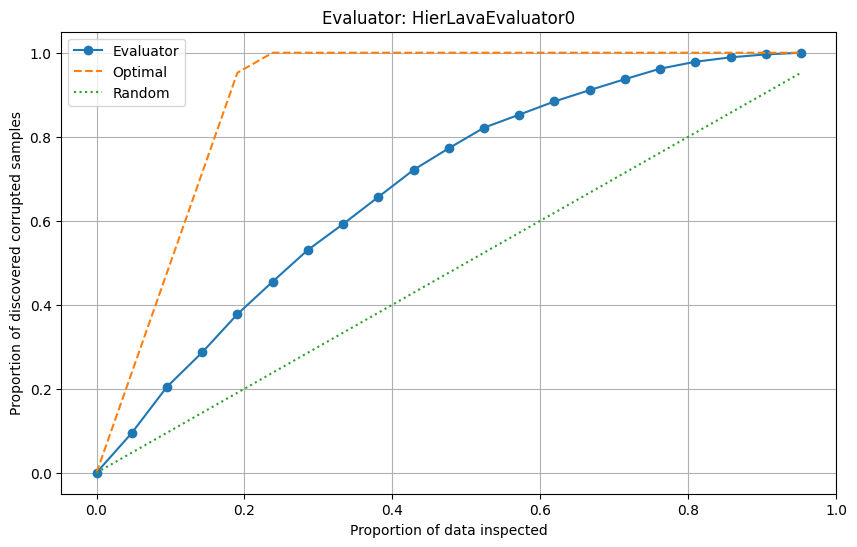

KNNEvaluator1: {'found_rates': [0.0, 0.244, 0.4685, 0.6705, 0.841, 0.958, 0.9785, 0.9875, 0.993, 0.9965, 0.9975, 0.999, 0.999, 0.9995, 0.9995, 0.9995, 0.9995, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


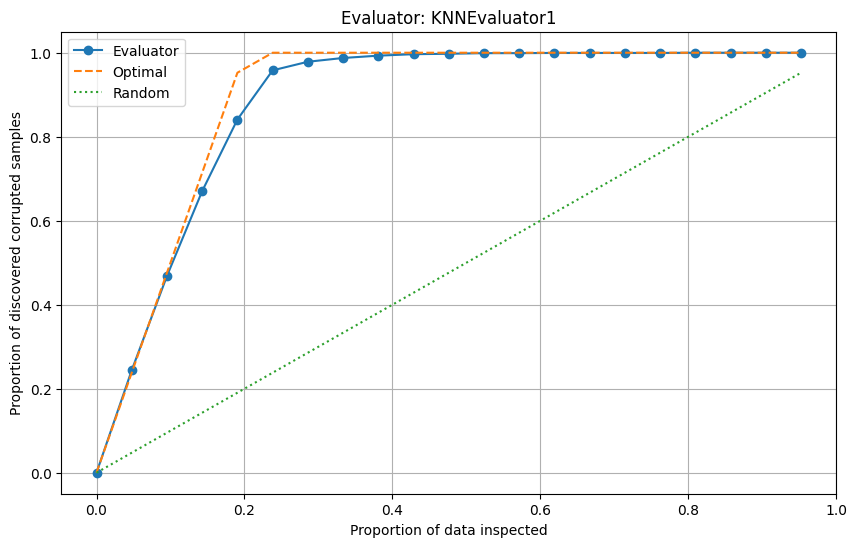

CKNNEvaluator2: {'found_rates': [0.0, 0.2445, 0.4685, 0.6755, 0.8455, 0.9555, 0.977, 0.9875, 0.9925, 0.9965, 0.9975, 0.999, 0.999, 0.9995, 0.9995, 0.9995, 0.9995, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


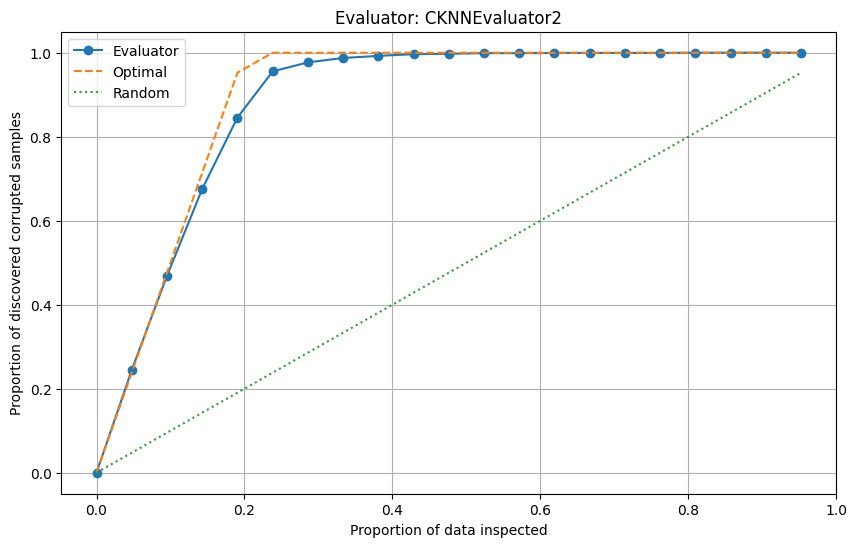

LavaEvaluator_batch3: {'found_rates': [0.0, 0.149, 0.2775, 0.382, 0.4775, 0.562, 0.6375, 0.7075, 0.7645, 0.8115, 0.8455, 0.878, 0.913, 0.935, 0.9505, 0.9685, 0.9755, 0.9855, 0.9915, 0.997, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


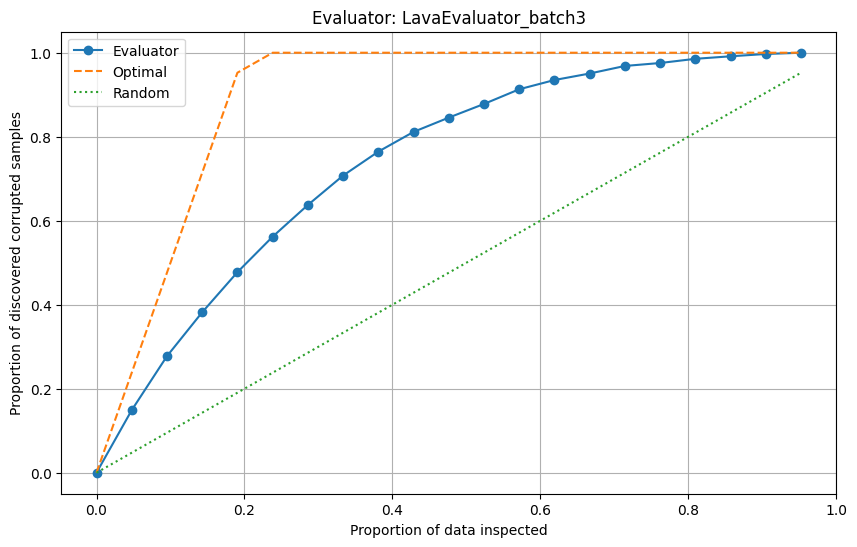

LavaEvaluator_OT4: {'found_rates': [0.0, 0.168, 0.3135, 0.4335, 0.537, 0.6225, 0.694, 0.7575, 0.8055, 0.8465, 0.888, 0.9165, 0.9345, 0.951, 0.9615, 0.9735, 0.983, 0.9895, 0.9935, 0.9965, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


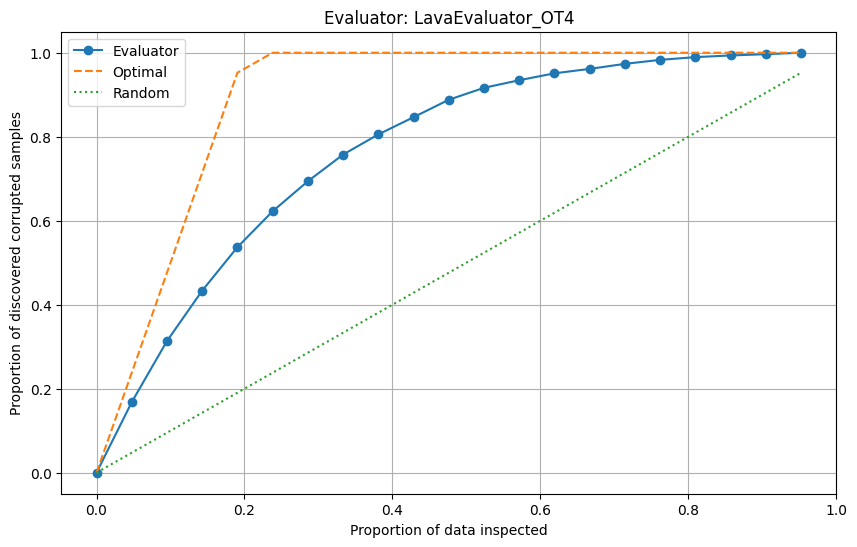

LavaEvaluator_geomloss5: {'found_rates': [0.0, 0.14, 0.2635, 0.3715, 0.4695, 0.559, 0.633, 0.7065, 0.757, 0.8015, 0.843, 0.884, 0.91, 0.9315, 0.9515, 0.9655, 0.977, 0.985, 0.9935, 0.999, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


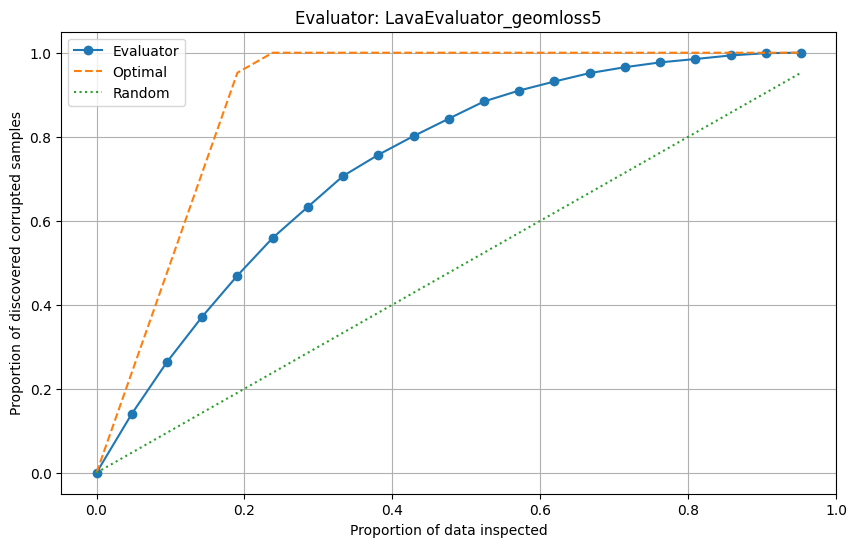

{'HierLavaEvaluator0': {'found_rates': [0.0,
   0.0945,
   0.2045,
   0.2865,
   0.3775,
   0.455,
   0.5305,
   0.592,
   0.6565,
   0.721,
   0.7725,
   0.8215,
   0.8525,
   0.884,
   0.911,
   0.937,
   0.962,
   0.9785,
   0.989,
   0.996,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'KNNEvaluator1': {'found_rates': [0.0,
   0.244,
   0.4685,
   0.6705,
   0.841,
   0.958,
   0.9785,
   0.9875,
   0.993,
   0.9965,
   0.9975,
   0.999,
   0.999,
   0.9995,
   0.9995,
   0.9995,
   0.9995,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,


In [54]:
from base_evaluator import BaseEvaluator, KNNEvaluator,CKNNEvaluator ,LavaEvaluator_geomloss, LavaEvaluator_OT, ExperimentRunner, LavaEvaluator_batch, HierLavaEvaluator
hierlava_evaluator = HierLavaEvaluator(batch = 500)
knn_evaluator = KNNEvaluator()
cknn_evaluator1 = CKNNEvaluator(T = 5000, default=False)
lava_evaluator_batch1 = LavaEvaluator_batch(batch = 500)
lava_evaluator_OT = LavaEvaluator_OT()
lava_evaluator_geomloss = LavaEvaluator_geomloss()
experiment = ExperimentRunner(evaluators=[hierlava_evaluator , knn_evaluator, cknn_evaluator1, lava_evaluator_batch1, lava_evaluator_OT, lava_evaluator_geomloss])
results = experiment.run(x_embeddings, y_labels_noisy, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [55]:
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
experiment.calculate_WAD(model, num_steps=50)

Epoch [10/100], Loss: 1.8351
Epoch [20/100], Loss: 1.7950
Epoch [30/100], Loss: 1.7793
Epoch [40/100], Loss: 1.7690
Epoch [50/100], Loss: 1.7620
Epoch [60/100], Loss: 1.7562
Epoch [70/100], Loss: 1.7520
Epoch [80/100], Loss: 1.7482
Epoch [90/100], Loss: 1.7451
Epoch [100/100], Loss: 1.7419


Evaluating WAD:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.7501
Epoch [20/100], Loss: 1.7308
Epoch [30/100], Loss: 1.7185
Epoch [40/100], Loss: 1.7121
Epoch [50/100], Loss: 1.7068
Epoch [60/100], Loss: 1.7019
Epoch [70/100], Loss: 1.6983
Epoch [80/100], Loss: 1.6955
Epoch [90/100], Loss: 1.6924


Evaluating WAD:   2%|▏         | 1/49 [00:23<18:46, 23.47s/it]

Epoch [100/100], Loss: 1.6897
Epoch [10/100], Loss: 1.7573
Epoch [20/100], Loss: 1.7360
Epoch [30/100], Loss: 1.7243
Epoch [40/100], Loss: 1.7161
Epoch [50/100], Loss: 1.7100
Epoch [60/100], Loss: 1.7056
Epoch [70/100], Loss: 1.7021
Epoch [80/100], Loss: 1.6991
Epoch [90/100], Loss: 1.6966


Evaluating WAD:   4%|▍         | 2/49 [00:46<17:57, 22.94s/it]

Epoch [100/100], Loss: 1.6945
Epoch [10/100], Loss: 1.7629
Epoch [20/100], Loss: 1.7411
Epoch [30/100], Loss: 1.7293
Epoch [40/100], Loss: 1.7208
Epoch [50/100], Loss: 1.7148
Epoch [60/100], Loss: 1.7102
Epoch [70/100], Loss: 1.7067
Epoch [80/100], Loss: 1.7039
Epoch [90/100], Loss: 1.7012


Evaluating WAD:   6%|▌         | 3/49 [01:08<17:15, 22.52s/it]

Epoch [100/100], Loss: 1.6986
Epoch [10/100], Loss: 1.7687
Epoch [20/100], Loss: 1.7465
Epoch [30/100], Loss: 1.7340
Epoch [40/100], Loss: 1.7254
Epoch [50/100], Loss: 1.7194
Epoch [60/100], Loss: 1.7146
Epoch [70/100], Loss: 1.7107
Epoch [80/100], Loss: 1.7078
Epoch [90/100], Loss: 1.7052


Evaluating WAD:   8%|▊         | 4/49 [01:29<16:35, 22.12s/it]

Epoch [100/100], Loss: 1.7029
Epoch [10/100], Loss: 1.7825
Epoch [20/100], Loss: 1.7537
Epoch [30/100], Loss: 1.7403
Epoch [40/100], Loss: 1.7311
Epoch [50/100], Loss: 1.7246
Epoch [60/100], Loss: 1.7197
Epoch [70/100], Loss: 1.7157
Epoch [80/100], Loss: 1.7125
Epoch [90/100], Loss: 1.7100


Evaluating WAD:  10%|█         | 5/49 [01:50<15:57, 21.77s/it]

Epoch [100/100], Loss: 1.7076
Epoch [10/100], Loss: 1.7969
Epoch [20/100], Loss: 1.7591
Epoch [30/100], Loss: 1.7448
Epoch [40/100], Loss: 1.7364
Epoch [50/100], Loss: 1.7290
Epoch [60/100], Loss: 1.7242
Epoch [70/100], Loss: 1.7199
Epoch [80/100], Loss: 1.7170
Epoch [90/100], Loss: 1.7142


Evaluating WAD:  12%|█▏        | 6/49 [02:11<15:26, 21.55s/it]

Epoch [100/100], Loss: 1.7115
Epoch [10/100], Loss: 1.8092
Epoch [20/100], Loss: 1.7671
Epoch [30/100], Loss: 1.7515
Epoch [40/100], Loss: 1.7417
Epoch [50/100], Loss: 1.7345
Epoch [60/100], Loss: 1.7290
Epoch [70/100], Loss: 1.7250
Epoch [80/100], Loss: 1.7216
Epoch [90/100], Loss: 1.7188


Evaluating WAD:  14%|█▍        | 7/49 [02:31<14:45, 21.09s/it]

Epoch [100/100], Loss: 1.7162
Epoch [10/100], Loss: 1.8127
Epoch [20/100], Loss: 1.7741
Epoch [30/100], Loss: 1.7577
Epoch [40/100], Loss: 1.7470
Epoch [50/100], Loss: 1.7405
Epoch [60/100], Loss: 1.7346
Epoch [70/100], Loss: 1.7301
Epoch [80/100], Loss: 1.7266
Epoch [90/100], Loss: 1.7234


Evaluating WAD:  16%|█▋        | 8/49 [02:51<14:04, 20.60s/it]

Epoch [100/100], Loss: 1.7215
Epoch [10/100], Loss: 1.8157
Epoch [20/100], Loss: 1.7956
Epoch [30/100], Loss: 1.7659
Epoch [40/100], Loss: 1.7525
Epoch [50/100], Loss: 1.7469
Epoch [60/100], Loss: 1.7402
Epoch [70/100], Loss: 1.7349
Epoch [80/100], Loss: 1.7319
Epoch [90/100], Loss: 1.7272


Evaluating WAD:  18%|█▊        | 9/49 [03:11<13:30, 20.25s/it]

Epoch [100/100], Loss: 1.7246
Epoch [10/100], Loss: 1.8203
Epoch [20/100], Loss: 1.7980
Epoch [30/100], Loss: 1.7859
Epoch [40/100], Loss: 1.7687
Epoch [50/100], Loss: 1.7537
Epoch [60/100], Loss: 1.7461
Epoch [70/100], Loss: 1.7408
Epoch [80/100], Loss: 1.7366
Epoch [90/100], Loss: 1.7332


Evaluating WAD:  20%|██        | 10/49 [03:30<12:56, 19.91s/it]

Epoch [100/100], Loss: 1.7305
Epoch [10/100], Loss: 1.8249
Epoch [20/100], Loss: 1.8015
Epoch [30/100], Loss: 1.7890
Epoch [40/100], Loss: 1.7793
Epoch [50/100], Loss: 1.7585
Epoch [60/100], Loss: 1.7503
Epoch [70/100], Loss: 1.7447
Epoch [80/100], Loss: 1.7408
Epoch [90/100], Loss: 1.7373


Evaluating WAD:  22%|██▏       | 11/49 [03:48<12:19, 19.47s/it]

Epoch [100/100], Loss: 1.7347
Epoch [10/100], Loss: 1.8278
Epoch [20/100], Loss: 1.8047
Epoch [30/100], Loss: 1.7918
Epoch [40/100], Loss: 1.7831
Epoch [50/100], Loss: 1.7636
Epoch [60/100], Loss: 1.7549
Epoch [70/100], Loss: 1.7490
Epoch [80/100], Loss: 1.7446
Epoch [90/100], Loss: 1.7410


Evaluating WAD:  24%|██▍       | 12/49 [04:06<11:43, 19.03s/it]

Epoch [100/100], Loss: 1.7379
Epoch [10/100], Loss: 1.8337
Epoch [20/100], Loss: 1.8093
Epoch [30/100], Loss: 1.7957
Epoch [40/100], Loss: 1.7860
Epoch [50/100], Loss: 1.7793
Epoch [60/100], Loss: 1.7681
Epoch [70/100], Loss: 1.7570
Epoch [80/100], Loss: 1.7511
Epoch [90/100], Loss: 1.7470


Evaluating WAD:  27%|██▋       | 13/49 [04:24<11:09, 18.60s/it]

Epoch [100/100], Loss: 1.7432
Epoch [10/100], Loss: 1.8374
Epoch [20/100], Loss: 1.8132
Epoch [30/100], Loss: 1.8005
Epoch [40/100], Loss: 1.7911
Epoch [50/100], Loss: 1.7829
Epoch [60/100], Loss: 1.7774
Epoch [70/100], Loss: 1.7726
Epoch [80/100], Loss: 1.7687
Epoch [90/100], Loss: 1.7651


Evaluating WAD:  29%|██▊       | 14/49 [04:41<10:34, 18.14s/it]

Epoch [100/100], Loss: 1.7557
Epoch [10/100], Loss: 1.8454
Epoch [20/100], Loss: 1.8181
Epoch [30/100], Loss: 1.8035
Epoch [40/100], Loss: 1.7937
Epoch [50/100], Loss: 1.7861
Epoch [60/100], Loss: 1.7802
Epoch [70/100], Loss: 1.7751
Epoch [80/100], Loss: 1.7711
Epoch [90/100], Loss: 1.7677


Evaluating WAD:  31%|███       | 15/49 [04:58<10:05, 17.80s/it]

Epoch [100/100], Loss: 1.7648
Epoch [10/100], Loss: 1.8479
Epoch [20/100], Loss: 1.8215
Epoch [30/100], Loss: 1.8069
Epoch [40/100], Loss: 1.7976
Epoch [50/100], Loss: 1.7901
Epoch [60/100], Loss: 1.7845
Epoch [70/100], Loss: 1.7789
Epoch [80/100], Loss: 1.7752
Epoch [90/100], Loss: 1.7714


Evaluating WAD:  33%|███▎      | 16/49 [05:14<09:33, 17.39s/it]

Epoch [100/100], Loss: 1.7690
Epoch [10/100], Loss: 1.8538
Epoch [20/100], Loss: 1.8252
Epoch [30/100], Loss: 1.8136
Epoch [40/100], Loss: 1.8016
Epoch [50/100], Loss: 1.7923
Epoch [60/100], Loss: 1.7876
Epoch [70/100], Loss: 1.7837
Epoch [80/100], Loss: 1.7783
Epoch [90/100], Loss: 1.7763


Evaluating WAD:  35%|███▍      | 17/49 [05:31<09:05, 17.06s/it]

Epoch [100/100], Loss: 1.7708
Epoch [10/100], Loss: 1.8626
Epoch [20/100], Loss: 1.8321
Epoch [30/100], Loss: 1.8161
Epoch [40/100], Loss: 1.8054
Epoch [50/100], Loss: 1.7973
Epoch [60/100], Loss: 1.7909
Epoch [70/100], Loss: 1.7856
Epoch [80/100], Loss: 1.7815
Epoch [90/100], Loss: 1.7779


Evaluating WAD:  37%|███▋      | 18/49 [05:47<08:41, 16.81s/it]

Epoch [100/100], Loss: 1.7748
Epoch [10/100], Loss: 1.8678
Epoch [20/100], Loss: 1.8371
Epoch [30/100], Loss: 1.8201
Epoch [40/100], Loss: 1.8095
Epoch [50/100], Loss: 1.8016
Epoch [60/100], Loss: 1.7949
Epoch [70/100], Loss: 1.7893
Epoch [80/100], Loss: 1.7844
Epoch [90/100], Loss: 1.7807


Evaluating WAD:  39%|███▉      | 19/49 [06:02<08:08, 16.30s/it]

Epoch [100/100], Loss: 1.7771
Epoch [10/100], Loss: 1.8834
Epoch [20/100], Loss: 1.8454
Epoch [30/100], Loss: 1.8273
Epoch [40/100], Loss: 1.8156
Epoch [50/100], Loss: 1.8067
Epoch [60/100], Loss: 1.7999
Epoch [70/100], Loss: 1.7942
Epoch [80/100], Loss: 1.7896
Epoch [90/100], Loss: 1.7855


Evaluating WAD:  41%|████      | 20/49 [06:17<07:38, 15.80s/it]

Epoch [100/100], Loss: 1.7821
Epoch [10/100], Loss: 1.9147
Epoch [20/100], Loss: 1.8565
Epoch [30/100], Loss: 1.8357
Epoch [40/100], Loss: 1.8224
Epoch [50/100], Loss: 1.8127
Epoch [60/100], Loss: 1.8051
Epoch [70/100], Loss: 1.7993
Epoch [80/100], Loss: 1.7943
Epoch [90/100], Loss: 1.7899


Evaluating WAD:  43%|████▎     | 21/49 [06:31<07:08, 15.29s/it]

Epoch [100/100], Loss: 1.7865
Epoch [10/100], Loss: 1.9067
Epoch [20/100], Loss: 1.8582
Epoch [30/100], Loss: 1.8404
Epoch [40/100], Loss: 1.8260
Epoch [50/100], Loss: 1.8176
Epoch [60/100], Loss: 1.8099
Epoch [70/100], Loss: 1.8035
Epoch [80/100], Loss: 1.8007
Epoch [90/100], Loss: 1.7953


Evaluating WAD:  45%|████▍     | 22/49 [06:44<06:40, 14.83s/it]

Epoch [100/100], Loss: 1.7912
Epoch [10/100], Loss: 1.9462
Epoch [20/100], Loss: 1.8731
Epoch [30/100], Loss: 1.8478
Epoch [40/100], Loss: 1.8329
Epoch [50/100], Loss: 1.8222
Epoch [60/100], Loss: 1.8143
Epoch [70/100], Loss: 1.8082
Epoch [80/100], Loss: 1.8028
Epoch [90/100], Loss: 1.7985


Evaluating WAD:  47%|████▋     | 23/49 [06:58<06:12, 14.33s/it]

Epoch [100/100], Loss: 1.7945
Epoch [10/100], Loss: 1.9593
Epoch [20/100], Loss: 1.9007
Epoch [30/100], Loss: 1.8813
Epoch [40/100], Loss: 1.8683
Epoch [50/100], Loss: 1.8369
Epoch [60/100], Loss: 1.8242
Epoch [70/100], Loss: 1.8153
Epoch [80/100], Loss: 1.8075
Epoch [90/100], Loss: 1.8027


Evaluating WAD:  49%|████▉     | 24/49 [07:11<05:49, 13.97s/it]

Epoch [100/100], Loss: 1.7982
Epoch [10/100], Loss: 1.9576
Epoch [20/100], Loss: 1.8769
Epoch [30/100], Loss: 1.8512
Epoch [40/100], Loss: 1.8391
Epoch [50/100], Loss: 1.8288
Epoch [60/100], Loss: 1.8205
Epoch [70/100], Loss: 1.8143
Epoch [80/100], Loss: 1.8119
Epoch [90/100], Loss: 1.8043


Evaluating WAD:  51%|█████     | 25/49 [07:23<05:23, 13.49s/it]

Epoch [100/100], Loss: 1.7979
Epoch [10/100], Loss: 1.9773
Epoch [20/100], Loss: 1.9407
Epoch [30/100], Loss: 1.8955
Epoch [40/100], Loss: 1.8540
Epoch [50/100], Loss: 1.8363
Epoch [60/100], Loss: 1.8242
Epoch [70/100], Loss: 1.8155
Epoch [80/100], Loss: 1.8086
Epoch [90/100], Loss: 1.8028


Evaluating WAD:  53%|█████▎    | 26/49 [07:35<04:58, 12.99s/it]

Epoch [100/100], Loss: 1.7976
Epoch [10/100], Loss: 1.9807
Epoch [20/100], Loss: 1.9347
Epoch [30/100], Loss: 1.9064
Epoch [40/100], Loss: 1.8821
Epoch [50/100], Loss: 1.8674
Epoch [60/100], Loss: 1.8415
Epoch [70/100], Loss: 1.8249
Epoch [80/100], Loss: 1.8151
Epoch [90/100], Loss: 1.8085


Evaluating WAD:  55%|█████▌    | 27/49 [07:45<04:28, 12.18s/it]

Epoch [100/100], Loss: 1.8012
Epoch [10/100], Loss: 1.9834
Epoch [20/100], Loss: 1.9505
Epoch [30/100], Loss: 1.9101
Epoch [40/100], Loss: 1.8940
Epoch [50/100], Loss: 1.8712
Epoch [60/100], Loss: 1.8488
Epoch [70/100], Loss: 1.8367
Epoch [80/100], Loss: 1.8284
Epoch [90/100], Loss: 1.8215


Evaluating WAD:  57%|█████▋    | 28/49 [07:55<04:01, 11.50s/it]

Epoch [100/100], Loss: 1.8105
Epoch [10/100], Loss: 2.0068
Epoch [20/100], Loss: 1.9608
Epoch [30/100], Loss: 1.9221
Epoch [40/100], Loss: 1.8975
Epoch [50/100], Loss: 1.8852
Epoch [60/100], Loss: 1.8758
Epoch [70/100], Loss: 1.8692
Epoch [80/100], Loss: 1.8487
Epoch [90/100], Loss: 1.8335


Evaluating WAD:  59%|█████▉    | 29/49 [08:05<03:38, 10.91s/it]

Epoch [100/100], Loss: 1.8183
Epoch [10/100], Loss: 2.0075
Epoch [20/100], Loss: 1.9662
Epoch [30/100], Loss: 1.9417
Epoch [40/100], Loss: 1.9285
Epoch [50/100], Loss: 1.9201
Epoch [60/100], Loss: 1.9021
Epoch [70/100], Loss: 1.8785
Epoch [80/100], Loss: 1.8722
Epoch [90/100], Loss: 1.8618


Evaluating WAD:  61%|██████    | 30/49 [08:13<03:15, 10.29s/it]

Epoch [100/100], Loss: 1.8571
Epoch [10/100], Loss: 2.0334
Epoch [20/100], Loss: 1.9870
Epoch [30/100], Loss: 1.9523
Epoch [40/100], Loss: 1.9228
Epoch [50/100], Loss: 1.8991
Epoch [60/100], Loss: 1.8871
Epoch [70/100], Loss: 1.8708
Epoch [80/100], Loss: 1.8477
Epoch [90/100], Loss: 1.8350


Evaluating WAD:  63%|██████▎   | 31/49 [08:22<02:54,  9.68s/it]

Epoch [100/100], Loss: 1.8219
Epoch [10/100], Loss: 2.0175
Epoch [20/100], Loss: 1.9824
Epoch [30/100], Loss: 1.9635
Epoch [40/100], Loss: 1.9353
Epoch [50/100], Loss: 1.9027
Epoch [60/100], Loss: 1.8852
Epoch [70/100], Loss: 1.8749
Epoch [80/100], Loss: 1.8657
Epoch [90/100], Loss: 1.8599


Evaluating WAD:  65%|██████▌   | 32/49 [08:29<02:34,  9.11s/it]

Epoch [100/100], Loss: 1.8548
Epoch [10/100], Loss: 2.0298
Epoch [20/100], Loss: 1.9925
Epoch [30/100], Loss: 1.9652
Epoch [40/100], Loss: 1.9528
Epoch [50/100], Loss: 1.9514
Epoch [60/100], Loss: 1.9346
Epoch [70/100], Loss: 1.9336
Epoch [80/100], Loss: 1.9239
Epoch [90/100], Loss: 1.9234


Evaluating WAD:  67%|██████▋   | 33/49 [08:37<02:17,  8.59s/it]

Epoch [100/100], Loss: 1.9100
Epoch [10/100], Loss: 2.0379
Epoch [20/100], Loss: 1.9890
Epoch [30/100], Loss: 1.9704
Epoch [40/100], Loss: 1.9584
Epoch [50/100], Loss: 1.9473
Epoch [60/100], Loss: 1.9405
Epoch [70/100], Loss: 1.9340
Epoch [80/100], Loss: 1.9288
Epoch [90/100], Loss: 1.9240


Evaluating WAD:  69%|██████▉   | 34/49 [08:44<02:01,  8.09s/it]

Epoch [100/100], Loss: 1.9196
Epoch [10/100], Loss: 2.0395
Epoch [20/100], Loss: 1.9898
Epoch [30/100], Loss: 1.9700
Epoch [40/100], Loss: 1.9561
Epoch [50/100], Loss: 1.9479
Epoch [60/100], Loss: 1.9358
Epoch [70/100], Loss: 1.9291
Epoch [80/100], Loss: 1.9224
Epoch [90/100], Loss: 1.9188


Evaluating WAD:  71%|███████▏  | 35/49 [08:50<01:46,  7.60s/it]

Epoch [100/100], Loss: 1.9144
Epoch [10/100], Loss: 2.0417
Epoch [20/100], Loss: 1.9966
Epoch [30/100], Loss: 1.9739
Epoch [40/100], Loss: 1.9586
Epoch [50/100], Loss: 1.9468
Epoch [60/100], Loss: 1.9375
Epoch [70/100], Loss: 1.9299
Epoch [80/100], Loss: 1.9239
Epoch [90/100], Loss: 1.9187


Evaluating WAD:  73%|███████▎  | 36/49 [08:56<01:32,  7.10s/it]

Epoch [100/100], Loss: 1.9142
Epoch [10/100], Loss: 2.0440
Epoch [20/100], Loss: 2.0203
Epoch [30/100], Loss: 1.9865
Epoch [40/100], Loss: 1.9648
Epoch [50/100], Loss: 1.9520
Epoch [60/100], Loss: 1.9393
Epoch [70/100], Loss: 1.9314
Epoch [80/100], Loss: 1.9241
Epoch [90/100], Loss: 1.9183


Evaluating WAD:  76%|███████▌  | 37/49 [09:02<01:19,  6.63s/it]

Epoch [100/100], Loss: 1.9149
Epoch [10/100], Loss: 2.0470
Epoch [20/100], Loss: 2.0200
Epoch [30/100], Loss: 2.0089
Epoch [40/100], Loss: 1.9789
Epoch [50/100], Loss: 1.9582
Epoch [60/100], Loss: 1.9494
Epoch [70/100], Loss: 1.9397
Epoch [80/100], Loss: 1.9273
Epoch [90/100], Loss: 1.9180


Evaluating WAD:  78%|███████▊  | 38/49 [09:07<01:07,  6.13s/it]

Epoch [100/100], Loss: 1.9169
Epoch [10/100], Loss: 2.0453
Epoch [20/100], Loss: 2.0186
Epoch [30/100], Loss: 2.0024
Epoch [40/100], Loss: 1.9889
Epoch [50/100], Loss: 1.9728
Epoch [60/100], Loss: 1.9519
Epoch [70/100], Loss: 1.9383
Epoch [80/100], Loss: 1.9272
Epoch [90/100], Loss: 1.9182


Evaluating WAD:  80%|███████▉  | 39/49 [09:11<00:56,  5.66s/it]

Epoch [100/100], Loss: 1.9110
Epoch [10/100], Loss: 2.0444
Epoch [20/100], Loss: 2.0157
Epoch [30/100], Loss: 1.9965
Epoch [40/100], Loss: 1.9834
Epoch [50/100], Loss: 1.9654
Epoch [60/100], Loss: 1.9466
Epoch [70/100], Loss: 1.9288
Epoch [80/100], Loss: 1.9207
Epoch [90/100], Loss: 1.9090


Evaluating WAD:  82%|████████▏ | 40/49 [09:15<00:46,  5.19s/it]

Epoch [100/100], Loss: 1.9043
Epoch [10/100], Loss: 2.0455
Epoch [20/100], Loss: 2.0257
Epoch [30/100], Loss: 1.9875
Epoch [40/100], Loss: 1.9910
Epoch [50/100], Loss: 1.9620
Epoch [60/100], Loss: 1.9712
Epoch [70/100], Loss: 1.9489
Epoch [80/100], Loss: 1.9589
Epoch [90/100], Loss: 1.9468


Evaluating WAD:  84%|████████▎ | 41/49 [09:19<00:38,  4.75s/it]

Epoch [100/100], Loss: 1.9305
Epoch [10/100], Loss: 2.0480
Epoch [20/100], Loss: 2.0143
Epoch [30/100], Loss: 1.9939
Epoch [40/100], Loss: 1.9785
Epoch [50/100], Loss: 1.9651
Epoch [60/100], Loss: 1.9575
Epoch [70/100], Loss: 1.9497
Epoch [80/100], Loss: 1.9421
Epoch [90/100], Loss: 1.9394


Evaluating WAD:  86%|████████▌ | 42/49 [09:22<00:29,  4.28s/it]

Epoch [100/100], Loss: 1.9346
Epoch [10/100], Loss: 2.0534
Epoch [20/100], Loss: 2.0186
Epoch [30/100], Loss: 1.9938
Epoch [40/100], Loss: 1.9822
Epoch [50/100], Loss: 1.9665
Epoch [60/100], Loss: 1.9626
Epoch [70/100], Loss: 1.9443
Epoch [80/100], Loss: 1.9424
Epoch [90/100], Loss: 1.9364


Evaluating WAD:  88%|████████▊ | 43/49 [09:25<00:23,  3.83s/it]

Epoch [100/100], Loss: 1.9383
Epoch [10/100], Loss: 2.0575
Epoch [20/100], Loss: 2.0169
Epoch [30/100], Loss: 1.9919
Epoch [40/100], Loss: 1.9749
Epoch [50/100], Loss: 1.9612
Epoch [60/100], Loss: 1.9503
Epoch [70/100], Loss: 1.9417
Epoch [80/100], Loss: 1.9358
Epoch [90/100], Loss: 1.9299


Evaluating WAD:  90%|████████▉ | 44/49 [09:27<00:16,  3.40s/it]

Epoch [100/100], Loss: 1.9261
Epoch [10/100], Loss: 2.0718
Epoch [20/100], Loss: 2.0181
Epoch [30/100], Loss: 1.9868
Epoch [40/100], Loss: 1.9696
Epoch [50/100], Loss: 1.9505
Epoch [60/100], Loss: 1.9420
Epoch [70/100], Loss: 1.9282
Epoch [80/100], Loss: 1.9255


Evaluating WAD:  92%|█████████▏| 45/49 [09:29<00:11,  2.93s/it]

Epoch [90/100], Loss: 1.9226
Epoch [100/100], Loss: 1.9160
Epoch [10/100], Loss: 2.0620
Epoch [20/100], Loss: 1.9850
Epoch [30/100], Loss: 1.9555
Epoch [40/100], Loss: 1.9385
Epoch [50/100], Loss: 1.9263
Epoch [60/100], Loss: 1.9021
Epoch [70/100], Loss: 1.9017
Epoch [80/100], Loss: 1.8859
Epoch [90/100], Loss: 1.8891
Epoch [100/100], Loss: 1.8852


Evaluating WAD:  94%|█████████▍| 46/49 [09:31<00:07,  2.48s/it]

Epoch [10/100], Loss: 2.0624
Epoch [20/100], Loss: 1.9845
Epoch [30/100], Loss: 1.9448
Epoch [40/100], Loss: 1.9197
Epoch [50/100], Loss: 1.9002
Epoch [60/100], Loss: 1.8855
Epoch [70/100], Loss: 1.8787
Epoch [80/100], Loss: 1.8754
Epoch [90/100], Loss: 1.8640


Evaluating WAD:  96%|█████████▌| 47/49 [09:32<00:04,  2.03s/it]

Epoch [100/100], Loss: 1.8594
Epoch [10/100], Loss: 2.0734
Epoch [20/100], Loss: 1.9864
Epoch [30/100], Loss: 1.9120
Epoch [40/100], Loss: 1.8813
Epoch [50/100], Loss: 1.8732
Epoch [60/100], Loss: 1.8138
Epoch [70/100], Loss: 1.8217
Epoch [80/100], Loss: 1.7960


Evaluating WAD:  98%|█████████▊| 48/49 [09:32<00:11, 11.93s/it]

Epoch [90/100], Loss: 1.7956
Epoch [100/100], Loss: 1.7616
HierLavaEvaluator0: 0.017080909753877754


Epoch [10/100], Loss: 1.8351
Epoch [20/100], Loss: 1.7950
Epoch [30/100], Loss: 1.7789
Epoch [40/100], Loss: 1.7688
Epoch [50/100], Loss: 1.7624
Epoch [60/100], Loss: 1.7564
Epoch [70/100], Loss: 1.7521
Epoch [80/100], Loss: 1.7482
Epoch [90/100], Loss: 1.7449
Epoch [100/100], Loss: 1.7417


Evaluating WAD:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.7514
Epoch [20/100], Loss: 1.7309
Epoch [30/100], Loss: 1.7188
Epoch [40/100], Loss: 1.7110
Epoch [50/100], Loss: 1.7052
Epoch [60/100], Loss: 1.7007
Epoch [70/100], Loss: 1.6987
Epoch [80/100], Loss: 1.6958
Epoch [90/100], Loss: 1.6935


Evaluating WAD:   2%|▏         | 1/49 [00:23<18:40, 23.35s/it]

Epoch [100/100], Loss: 1.6906
Epoch [10/100], Loss: 1.7574
Epoch [20/100], Loss: 1.7367
Epoch [30/100], Loss: 1.7251
Epoch [40/100], Loss: 1.7170
Epoch [50/100], Loss: 1.7108
Epoch [60/100], Loss: 1.7064
Epoch [70/100], Loss: 1.7030
Epoch [80/100], Loss: 1.7000
Epoch [90/100], Loss: 1.6976


Evaluating WAD:   4%|▍         | 2/49 [00:45<17:53, 22.84s/it]

Epoch [100/100], Loss: 1.6955
Epoch [10/100], Loss: 1.7645
Epoch [20/100], Loss: 1.7427
Epoch [30/100], Loss: 1.7309
Epoch [40/100], Loss: 1.7232
Epoch [50/100], Loss: 1.7163
Epoch [60/100], Loss: 1.7115
Epoch [70/100], Loss: 1.7083
Epoch [80/100], Loss: 1.7051
Epoch [90/100], Loss: 1.7031


Evaluating WAD:   6%|▌         | 3/49 [01:07<17:11, 22.43s/it]

Epoch [100/100], Loss: 1.7004
Epoch [10/100], Loss: 1.7707
Epoch [20/100], Loss: 1.7490
Epoch [30/100], Loss: 1.7369
Epoch [40/100], Loss: 1.7284
Epoch [50/100], Loss: 1.7221
Epoch [60/100], Loss: 1.7173
Epoch [70/100], Loss: 1.7136
Epoch [80/100], Loss: 1.7106
Epoch [90/100], Loss: 1.7080


Evaluating WAD:   8%|▊         | 4/49 [01:29<16:32, 22.06s/it]

Epoch [100/100], Loss: 1.7057
Epoch [10/100], Loss: 1.7777
Epoch [20/100], Loss: 1.7552
Epoch [30/100], Loss: 1.7430
Epoch [40/100], Loss: 1.7344
Epoch [50/100], Loss: 1.7281
Epoch [60/100], Loss: 1.7232
Epoch [70/100], Loss: 1.7192
Epoch [80/100], Loss: 1.7161
Epoch [90/100], Loss: 1.7135


Evaluating WAD:  10%|█         | 5/49 [01:50<15:52, 21.65s/it]

Epoch [100/100], Loss: 1.7112
Epoch [10/100], Loss: 1.7853
Epoch [20/100], Loss: 1.7622
Epoch [30/100], Loss: 1.7492
Epoch [40/100], Loss: 1.7404
Epoch [50/100], Loss: 1.7338
Epoch [60/100], Loss: 1.7288
Epoch [70/100], Loss: 1.7252
Epoch [80/100], Loss: 1.7226
Epoch [90/100], Loss: 1.7199


Evaluating WAD:  12%|█▏        | 6/49 [02:10<15:14, 21.27s/it]

Epoch [100/100], Loss: 1.7174
Epoch [10/100], Loss: 1.7928
Epoch [20/100], Loss: 1.7692
Epoch [30/100], Loss: 1.7561
Epoch [40/100], Loss: 1.7470
Epoch [50/100], Loss: 1.7404
Epoch [60/100], Loss: 1.7354
Epoch [70/100], Loss: 1.7313
Epoch [80/100], Loss: 1.7280
Epoch [90/100], Loss: 1.7253


Evaluating WAD:  14%|█▍        | 7/49 [02:30<14:37, 20.89s/it]

Epoch [100/100], Loss: 1.7227
Epoch [10/100], Loss: 1.8010
Epoch [20/100], Loss: 1.7774
Epoch [30/100], Loss: 1.7633
Epoch [40/100], Loss: 1.7536
Epoch [50/100], Loss: 1.7470
Epoch [60/100], Loss: 1.7422
Epoch [70/100], Loss: 1.7377
Epoch [80/100], Loss: 1.7340
Epoch [90/100], Loss: 1.7317


Evaluating WAD:  16%|█▋        | 8/49 [02:50<14:00, 20.50s/it]

Epoch [100/100], Loss: 1.7292
Epoch [10/100], Loss: 1.8101
Epoch [20/100], Loss: 1.7835
Epoch [30/100], Loss: 1.7705
Epoch [40/100], Loss: 1.7616
Epoch [50/100], Loss: 1.7533
Epoch [60/100], Loss: 1.7493
Epoch [70/100], Loss: 1.7460
Epoch [80/100], Loss: 1.7410
Epoch [90/100], Loss: 1.7374


Evaluating WAD:  18%|█▊        | 9/49 [03:09<13:24, 20.10s/it]

Epoch [100/100], Loss: 1.7346
Epoch [10/100], Loss: 1.8192
Epoch [20/100], Loss: 1.7929
Epoch [30/100], Loss: 1.7785
Epoch [40/100], Loss: 1.7686
Epoch [50/100], Loss: 1.7614
Epoch [60/100], Loss: 1.7559
Epoch [70/100], Loss: 1.7516
Epoch [80/100], Loss: 1.7480
Epoch [90/100], Loss: 1.7449


Evaluating WAD:  20%|██        | 10/49 [03:28<12:51, 19.79s/it]

Epoch [100/100], Loss: 1.7422
Epoch [10/100], Loss: 1.8290
Epoch [20/100], Loss: 1.8013
Epoch [30/100], Loss: 1.7862
Epoch [40/100], Loss: 1.7769
Epoch [50/100], Loss: 1.7691
Epoch [60/100], Loss: 1.7635
Epoch [70/100], Loss: 1.7583
Epoch [80/100], Loss: 1.7551
Epoch [90/100], Loss: 1.7525


Evaluating WAD:  22%|██▏       | 11/49 [03:47<12:15, 19.36s/it]

Epoch [100/100], Loss: 1.7497
Epoch [10/100], Loss: 1.8377
Epoch [20/100], Loss: 1.8101
Epoch [30/100], Loss: 1.7952
Epoch [40/100], Loss: 1.7847
Epoch [50/100], Loss: 1.7772
Epoch [60/100], Loss: 1.7714
Epoch [70/100], Loss: 1.7668
Epoch [80/100], Loss: 1.7629
Epoch [90/100], Loss: 1.7597


Evaluating WAD:  24%|██▍       | 12/49 [04:05<11:40, 18.94s/it]

Epoch [100/100], Loss: 1.7568
Epoch [10/100], Loss: 1.8486
Epoch [20/100], Loss: 1.8199
Epoch [30/100], Loss: 1.8040
Epoch [40/100], Loss: 1.7940
Epoch [50/100], Loss: 1.7856
Epoch [60/100], Loss: 1.7797
Epoch [70/100], Loss: 1.7752
Epoch [80/100], Loss: 1.7711
Epoch [90/100], Loss: 1.7682


Evaluating WAD:  27%|██▋       | 13/49 [04:22<11:08, 18.56s/it]

Epoch [100/100], Loss: 1.7651
Epoch [10/100], Loss: 1.8625
Epoch [20/100], Loss: 1.8317
Epoch [30/100], Loss: 1.8143
Epoch [40/100], Loss: 1.8028
Epoch [50/100], Loss: 1.7954
Epoch [60/100], Loss: 1.7880
Epoch [70/100], Loss: 1.7836
Epoch [80/100], Loss: 1.7798
Epoch [90/100], Loss: 1.7753


Evaluating WAD:  29%|██▊       | 14/49 [04:39<10:33, 18.09s/it]

Epoch [100/100], Loss: 1.7729
Epoch [10/100], Loss: 1.8797
Epoch [20/100], Loss: 1.8422
Epoch [30/100], Loss: 1.8246
Epoch [40/100], Loss: 1.8127
Epoch [50/100], Loss: 1.8043
Epoch [60/100], Loss: 1.7977
Epoch [70/100], Loss: 1.7923
Epoch [80/100], Loss: 1.7877
Epoch [90/100], Loss: 1.7841


Evaluating WAD:  31%|███       | 15/49 [04:56<10:03, 17.74s/it]

Epoch [100/100], Loss: 1.7811
Epoch [10/100], Loss: 1.8830
Epoch [20/100], Loss: 1.8519
Epoch [30/100], Loss: 1.8332
Epoch [40/100], Loss: 1.8222
Epoch [50/100], Loss: 1.8136
Epoch [60/100], Loss: 1.8064
Epoch [70/100], Loss: 1.8013
Epoch [80/100], Loss: 1.7970
Epoch [90/100], Loss: 1.7931


Evaluating WAD:  33%|███▎      | 16/49 [05:13<09:32, 17.36s/it]

Epoch [100/100], Loss: 1.7898
Epoch [10/100], Loss: 1.8986
Epoch [20/100], Loss: 1.8630
Epoch [30/100], Loss: 1.8463
Epoch [40/100], Loss: 1.8327
Epoch [50/100], Loss: 1.8254
Epoch [60/100], Loss: 1.8155
Epoch [70/100], Loss: 1.8116
Epoch [80/100], Loss: 1.8068
Epoch [90/100], Loss: 1.8016


Evaluating WAD:  35%|███▍      | 17/49 [05:29<09:02, 16.94s/it]

Epoch [100/100], Loss: 1.8010
Epoch [10/100], Loss: 1.9299
Epoch [20/100], Loss: 1.8783
Epoch [30/100], Loss: 1.8583
Epoch [40/100], Loss: 1.8452
Epoch [50/100], Loss: 1.8353
Epoch [60/100], Loss: 1.8281
Epoch [70/100], Loss: 1.8225
Epoch [80/100], Loss: 1.8175
Epoch [90/100], Loss: 1.8134


Evaluating WAD:  37%|███▋      | 18/49 [05:44<08:32, 16.54s/it]

Epoch [100/100], Loss: 1.8098
Epoch [10/100], Loss: 1.9301
Epoch [20/100], Loss: 1.8903
Epoch [30/100], Loss: 1.8698
Epoch [40/100], Loss: 1.8565
Epoch [50/100], Loss: 1.8470
Epoch [60/100], Loss: 1.8396
Epoch [70/100], Loss: 1.8340
Epoch [80/100], Loss: 1.8286
Epoch [90/100], Loss: 1.8240


Evaluating WAD:  39%|███▉      | 19/49 [05:59<08:03, 16.12s/it]

Epoch [100/100], Loss: 1.8200
Epoch [10/100], Loss: 1.9489
Epoch [20/100], Loss: 1.9041
Epoch [30/100], Loss: 1.8828
Epoch [40/100], Loss: 1.8686
Epoch [50/100], Loss: 1.8585
Epoch [60/100], Loss: 1.8507
Epoch [70/100], Loss: 1.8446
Epoch [80/100], Loss: 1.8394
Epoch [90/100], Loss: 1.8349


Evaluating WAD:  41%|████      | 20/49 [06:14<07:34, 15.66s/it]

Epoch [100/100], Loss: 1.8311
Epoch [10/100], Loss: 1.9695
Epoch [20/100], Loss: 1.9203
Epoch [30/100], Loss: 1.8967
Epoch [40/100], Loss: 1.8817
Epoch [50/100], Loss: 1.8712
Epoch [60/100], Loss: 1.8629
Epoch [70/100], Loss: 1.8563
Epoch [80/100], Loss: 1.8506
Epoch [90/100], Loss: 1.8463


Evaluating WAD:  43%|████▎     | 21/49 [06:28<07:04, 15.16s/it]

Epoch [100/100], Loss: 1.8422
Epoch [10/100], Loss: 1.9817
Epoch [20/100], Loss: 1.9345
Epoch [30/100], Loss: 1.9095
Epoch [40/100], Loss: 1.8953
Epoch [50/100], Loss: 1.8840
Epoch [60/100], Loss: 1.8746
Epoch [70/100], Loss: 1.8693
Epoch [80/100], Loss: 1.8633
Epoch [90/100], Loss: 1.8584


Evaluating WAD:  45%|████▍     | 22/49 [06:42<06:37, 14.74s/it]

Epoch [100/100], Loss: 1.8546
Epoch [10/100], Loss: 2.0236
Epoch [20/100], Loss: 1.9694
Epoch [30/100], Loss: 1.9331
Epoch [40/100], Loss: 1.9140
Epoch [50/100], Loss: 1.9008
Epoch [60/100], Loss: 1.8906
Epoch [70/100], Loss: 1.8827
Epoch [80/100], Loss: 1.8758
Epoch [90/100], Loss: 1.8706


Evaluating WAD:  47%|████▋     | 23/49 [06:55<06:09, 14.23s/it]

Epoch [100/100], Loss: 1.8656
Epoch [10/100], Loss: 2.0429
Epoch [20/100], Loss: 1.9839
Epoch [30/100], Loss: 1.9498
Epoch [40/100], Loss: 1.9296
Epoch [50/100], Loss: 1.9156
Epoch [60/100], Loss: 1.9051
Epoch [70/100], Loss: 1.8968
Epoch [80/100], Loss: 1.8881
Epoch [90/100], Loss: 1.8823


Evaluating WAD:  49%|████▉     | 24/49 [07:08<05:44, 13.80s/it]

Epoch [100/100], Loss: 1.8766
Epoch [10/100], Loss: 2.0574
Epoch [20/100], Loss: 2.0243
Epoch [30/100], Loss: 2.0047
Epoch [40/100], Loss: 1.9716
Epoch [50/100], Loss: 1.9446
Epoch [60/100], Loss: 1.9308
Epoch [70/100], Loss: 1.9132
Epoch [80/100], Loss: 1.9068
Epoch [90/100], Loss: 1.8988


Evaluating WAD:  51%|█████     | 25/49 [07:20<05:20, 13.36s/it]

Epoch [100/100], Loss: 1.8924
Epoch [10/100], Loss: 2.0716
Epoch [20/100], Loss: 2.0336
Epoch [30/100], Loss: 2.0130
Epoch [40/100], Loss: 1.9988
Epoch [50/100], Loss: 1.9876
Epoch [60/100], Loss: 1.9792
Epoch [70/100], Loss: 1.9698
Epoch [80/100], Loss: 1.9443
Epoch [90/100], Loss: 1.9292


Evaluating WAD:  53%|█████▎    | 26/49 [07:32<04:56, 12.89s/it]

Epoch [100/100], Loss: 1.9186
Epoch [10/100], Loss: 2.1054
Epoch [20/100], Loss: 2.0668
Epoch [30/100], Loss: 2.0480
Epoch [40/100], Loss: 2.0249
Epoch [50/100], Loss: 2.0085
Epoch [60/100], Loss: 1.9897
Epoch [70/100], Loss: 1.9756
Epoch [80/100], Loss: 1.9588
Epoch [90/100], Loss: 1.9440


Evaluating WAD:  55%|█████▌    | 27/49 [07:43<04:30, 12.28s/it]

Epoch [100/100], Loss: 1.9335
Epoch [10/100], Loss: 2.1326
Epoch [20/100], Loss: 2.0844
Epoch [30/100], Loss: 2.0625
Epoch [40/100], Loss: 2.0474
Epoch [50/100], Loss: 2.0277
Epoch [60/100], Loss: 2.0136
Epoch [70/100], Loss: 2.0041
Epoch [80/100], Loss: 1.9963
Epoch [90/100], Loss: 1.9896


Evaluating WAD:  57%|█████▋    | 28/49 [07:53<04:04, 11.65s/it]

Epoch [100/100], Loss: 1.9835
Epoch [10/100], Loss: 2.1461
Epoch [20/100], Loss: 2.0948
Epoch [30/100], Loss: 2.0665
Epoch [40/100], Loss: 2.0472
Epoch [50/100], Loss: 2.0324
Epoch [60/100], Loss: 2.0212
Epoch [70/100], Loss: 2.0111
Epoch [80/100], Loss: 2.0030
Epoch [90/100], Loss: 1.9959


Evaluating WAD:  59%|█████▉    | 29/49 [08:02<03:39, 10.95s/it]

Epoch [100/100], Loss: 1.9897
Epoch [10/100], Loss: 2.1642
Epoch [20/100], Loss: 2.1286
Epoch [30/100], Loss: 2.1074
Epoch [40/100], Loss: 2.0929
Epoch [50/100], Loss: 2.0797
Epoch [60/100], Loss: 2.0636
Epoch [70/100], Loss: 2.0445
Epoch [80/100], Loss: 2.0306
Epoch [90/100], Loss: 2.0163


Evaluating WAD:  61%|██████    | 30/49 [08:11<03:15, 10.29s/it]

Epoch [100/100], Loss: 2.0081
Epoch [10/100], Loss: 2.1796
Epoch [20/100], Loss: 2.1410
Epoch [30/100], Loss: 2.1175
Epoch [40/100], Loss: 2.1002
Epoch [50/100], Loss: 2.0864
Epoch [60/100], Loss: 2.0740
Epoch [70/100], Loss: 2.0636
Epoch [80/100], Loss: 2.0553
Epoch [90/100], Loss: 2.0474


Evaluating WAD:  63%|██████▎   | 31/49 [08:19<02:55,  9.74s/it]

Epoch [100/100], Loss: 2.0408
Epoch [10/100], Loss: 2.1958
Epoch [20/100], Loss: 2.1576
Epoch [30/100], Loss: 2.1303
Epoch [40/100], Loss: 2.1097
Epoch [50/100], Loss: 2.0925
Epoch [60/100], Loss: 2.0787
Epoch [70/100], Loss: 2.0667
Epoch [80/100], Loss: 2.0566
Epoch [90/100], Loss: 2.0476


Evaluating WAD:  65%|██████▌   | 32/49 [08:27<02:35,  9.16s/it]

Epoch [100/100], Loss: 2.0409
Epoch [10/100], Loss: 2.2097
Epoch [20/100], Loss: 2.1739
Epoch [30/100], Loss: 2.1500
Epoch [40/100], Loss: 2.1290
Epoch [50/100], Loss: 2.1134
Epoch [60/100], Loss: 2.1072
Epoch [70/100], Loss: 2.0925
Epoch [80/100], Loss: 2.0797
Epoch [90/100], Loss: 2.0745


Evaluating WAD:  67%|██████▋   | 33/49 [08:35<02:18,  8.64s/it]

Epoch [100/100], Loss: 2.0634
Epoch [10/100], Loss: 2.2184
Epoch [20/100], Loss: 2.1748
Epoch [30/100], Loss: 2.1452
Epoch [40/100], Loss: 2.1221
Epoch [50/100], Loss: 2.1057
Epoch [60/100], Loss: 2.0879
Epoch [70/100], Loss: 2.0736
Epoch [80/100], Loss: 2.0613
Epoch [90/100], Loss: 2.0497


Evaluating WAD:  69%|██████▉   | 34/49 [08:41<02:01,  8.10s/it]

Epoch [100/100], Loss: 2.0389
Epoch [10/100], Loss: 2.2297
Epoch [20/100], Loss: 2.1854
Epoch [30/100], Loss: 2.1531
Epoch [40/100], Loss: 2.1257
Epoch [50/100], Loss: 2.1047
Epoch [60/100], Loss: 2.0868
Epoch [70/100], Loss: 2.0721
Epoch [80/100], Loss: 2.0564
Epoch [90/100], Loss: 2.0459


Evaluating WAD:  71%|███████▏  | 35/49 [08:48<01:46,  7.61s/it]

Epoch [100/100], Loss: 2.0339
Epoch [10/100], Loss: 2.2374
Epoch [20/100], Loss: 2.1917
Epoch [30/100], Loss: 2.1581
Epoch [40/100], Loss: 2.1310
Epoch [50/100], Loss: 2.1088
Epoch [60/100], Loss: 2.0897
Epoch [70/100], Loss: 2.0722
Epoch [80/100], Loss: 2.0568
Epoch [90/100], Loss: 2.0429


Evaluating WAD:  73%|███████▎  | 36/49 [08:54<01:32,  7.08s/it]

Epoch [100/100], Loss: 2.0313
Epoch [10/100], Loss: 2.2404
Epoch [20/100], Loss: 2.2019
Epoch [30/100], Loss: 2.1707
Epoch [40/100], Loss: 2.1468
Epoch [50/100], Loss: 2.1260
Epoch [60/100], Loss: 2.1077
Epoch [70/100], Loss: 2.0924
Epoch [80/100], Loss: 2.0789
Epoch [90/100], Loss: 2.0664


Evaluating WAD:  76%|███████▌  | 37/49 [08:59<01:19,  6.62s/it]

Epoch [100/100], Loss: 2.0575
Epoch [10/100], Loss: 2.2416
Epoch [20/100], Loss: 2.2019
Epoch [30/100], Loss: 2.1625
Epoch [40/100], Loss: 2.1358
Epoch [50/100], Loss: 2.1106
Epoch [60/100], Loss: 2.0861
Epoch [70/100], Loss: 2.0696
Epoch [80/100], Loss: 2.0541
Epoch [90/100], Loss: 2.0397


Evaluating WAD:  78%|███████▊  | 38/49 [09:04<01:07,  6.13s/it]

Epoch [100/100], Loss: 2.0300
Epoch [10/100], Loss: 2.2453
Epoch [20/100], Loss: 2.2053
Epoch [30/100], Loss: 2.1729
Epoch [40/100], Loss: 2.1441
Epoch [50/100], Loss: 2.1220
Epoch [60/100], Loss: 2.1045
Epoch [70/100], Loss: 2.0883
Epoch [80/100], Loss: 2.0753
Epoch [90/100], Loss: 2.0640


Evaluating WAD:  80%|███████▉  | 39/49 [09:09<00:56,  5.67s/it]

Epoch [100/100], Loss: 2.0541
Epoch [10/100], Loss: 2.2448
Epoch [20/100], Loss: 2.2052
Epoch [30/100], Loss: 2.1708
Epoch [40/100], Loss: 2.1396
Epoch [50/100], Loss: 2.1115
Epoch [60/100], Loss: 2.0901
Epoch [70/100], Loss: 2.0707
Epoch [80/100], Loss: 2.0536
Epoch [90/100], Loss: 2.0398


Evaluating WAD:  82%|████████▏ | 40/49 [09:13<00:46,  5.21s/it]

Epoch [100/100], Loss: 2.0259
Epoch [10/100], Loss: 2.2511
Epoch [20/100], Loss: 2.2096
Epoch [30/100], Loss: 2.1613
Epoch [40/100], Loss: 2.1565
Epoch [50/100], Loss: 2.1111
Epoch [60/100], Loss: 2.1091
Epoch [70/100], Loss: 2.0718
Epoch [80/100], Loss: 2.0582
Epoch [90/100], Loss: 2.0446


Evaluating WAD:  84%|████████▎ | 41/49 [09:17<00:37,  4.74s/it]

Epoch [100/100], Loss: 2.0507
Epoch [10/100], Loss: 2.2490
Epoch [20/100], Loss: 2.2031
Epoch [30/100], Loss: 2.1660
Epoch [40/100], Loss: 2.1380
Epoch [50/100], Loss: 2.1130
Epoch [60/100], Loss: 2.0930
Epoch [70/100], Loss: 2.0734
Epoch [80/100], Loss: 2.0578
Epoch [90/100], Loss: 2.0430


Evaluating WAD:  86%|████████▌ | 42/49 [09:20<00:30,  4.29s/it]

Epoch [100/100], Loss: 2.0308
Epoch [10/100], Loss: 2.2505
Epoch [20/100], Loss: 2.2041
Epoch [30/100], Loss: 2.1672
Epoch [40/100], Loss: 2.1362
Epoch [50/100], Loss: 2.1123
Epoch [60/100], Loss: 2.0914
Epoch [70/100], Loss: 2.0741
Epoch [80/100], Loss: 2.0600
Epoch [90/100], Loss: 2.0426


Evaluating WAD:  88%|████████▊ | 43/49 [09:23<00:23,  3.85s/it]

Epoch [100/100], Loss: 2.0263
Epoch [10/100], Loss: 2.2470
Epoch [20/100], Loss: 2.2012
Epoch [30/100], Loss: 2.1654
Epoch [40/100], Loss: 2.1345
Epoch [50/100], Loss: 2.1091
Epoch [60/100], Loss: 2.0881
Epoch [70/100], Loss: 2.0707
Epoch [80/100], Loss: 2.0541
Epoch [90/100], Loss: 2.0408


Evaluating WAD:  90%|████████▉ | 44/49 [09:25<00:17,  3.40s/it]

Epoch [100/100], Loss: 2.0273
Epoch [10/100], Loss: 2.2440
Epoch [20/100], Loss: 2.1938
Epoch [30/100], Loss: 2.1613
Epoch [40/100], Loss: 2.1263
Epoch [50/100], Loss: 2.0978
Epoch [60/100], Loss: 2.0749
Epoch [70/100], Loss: 2.0509
Epoch [80/100], Loss: 2.0335


Evaluating WAD:  92%|█████████▏| 45/49 [09:27<00:11,  2.94s/it]

Epoch [90/100], Loss: 2.0162
Epoch [100/100], Loss: 2.0005
Epoch [10/100], Loss: 2.2276
Epoch [20/100], Loss: 2.1826
Epoch [30/100], Loss: 2.1375
Epoch [40/100], Loss: 2.1109
Epoch [50/100], Loss: 2.0743
Epoch [60/100], Loss: 2.0700
Epoch [70/100], Loss: 2.0568
Epoch [80/100], Loss: 2.0262


Evaluating WAD:  94%|█████████▍| 46/49 [09:28<00:07,  2.49s/it]

Epoch [90/100], Loss: 2.0152
Epoch [100/100], Loss: 1.9948
Epoch [10/100], Loss: 2.2351
Epoch [20/100], Loss: 2.1787
Epoch [30/100], Loss: 2.1431
Epoch [40/100], Loss: 2.1149
Epoch [50/100], Loss: 2.0852
Epoch [60/100], Loss: 2.0593
Epoch [70/100], Loss: 2.0411
Epoch [80/100], Loss: 2.0219
Epoch [90/100], Loss: 2.0063


Evaluating WAD:  96%|█████████▌| 47/49 [09:29<00:04,  2.03s/it]

Epoch [100/100], Loss: 1.9946
Epoch [10/100], Loss: 2.2311
Epoch [20/100], Loss: 2.1608
Epoch [30/100], Loss: 2.1321
Epoch [40/100], Loss: 2.1136
Epoch [50/100], Loss: 2.0655
Epoch [60/100], Loss: 2.0745
Epoch [70/100], Loss: 2.0542
Epoch [80/100], Loss: 2.0255


Evaluating WAD:  98%|█████████▊| 48/49 [09:30<00:11, 11.88s/it]

Epoch [90/100], Loss: 1.9996
Epoch [100/100], Loss: 2.0030
KNNEvaluator1: 0.019316186674944325


Epoch [10/100], Loss: 1.8353
Epoch [20/100], Loss: 1.7953
Epoch [30/100], Loss: 1.7788
Epoch [40/100], Loss: 1.7690
Epoch [50/100], Loss: 1.7624
Epoch [60/100], Loss: 1.7564
Epoch [70/100], Loss: 1.7525
Epoch [80/100], Loss: 1.7480
Epoch [90/100], Loss: 1.7451
Epoch [100/100], Loss: 1.7417


Evaluating WAD:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.7526
Epoch [20/100], Loss: 1.7309
Epoch [30/100], Loss: 1.7190
Epoch [40/100], Loss: 1.7117
Epoch [50/100], Loss: 1.7054
Epoch [60/100], Loss: 1.7008
Epoch [70/100], Loss: 1.6987
Epoch [80/100], Loss: 1.6951
Epoch [90/100], Loss: 1.6928


Evaluating WAD:   2%|▏         | 1/49 [00:23<18:35, 23.23s/it]

Epoch [100/100], Loss: 1.6914
Epoch [10/100], Loss: 1.7573
Epoch [20/100], Loss: 1.7368
Epoch [30/100], Loss: 1.7253
Epoch [40/100], Loss: 1.7169
Epoch [50/100], Loss: 1.7110
Epoch [60/100], Loss: 1.7066
Epoch [70/100], Loss: 1.7031
Epoch [80/100], Loss: 1.7002
Epoch [90/100], Loss: 1.6977


Evaluating WAD:   4%|▍         | 2/49 [00:45<17:49, 22.75s/it]

Epoch [100/100], Loss: 1.6956
Epoch [10/100], Loss: 1.7642
Epoch [20/100], Loss: 1.7429
Epoch [30/100], Loss: 1.7307
Epoch [40/100], Loss: 1.7225
Epoch [50/100], Loss: 1.7165
Epoch [60/100], Loss: 1.7116
Epoch [70/100], Loss: 1.7083
Epoch [80/100], Loss: 1.7052
Epoch [90/100], Loss: 1.7024


Evaluating WAD:   6%|▌         | 3/49 [01:07<17:11, 22.42s/it]

Epoch [100/100], Loss: 1.7003
Epoch [10/100], Loss: 1.7705
Epoch [20/100], Loss: 1.7490
Epoch [30/100], Loss: 1.7368
Epoch [40/100], Loss: 1.7283
Epoch [50/100], Loss: 1.7220
Epoch [60/100], Loss: 1.7175
Epoch [70/100], Loss: 1.7137
Epoch [80/100], Loss: 1.7106
Epoch [90/100], Loss: 1.7080


Evaluating WAD:   8%|▊         | 4/49 [01:29<16:34, 22.09s/it]

Epoch [100/100], Loss: 1.7058
Epoch [10/100], Loss: 1.7780
Epoch [20/100], Loss: 1.7559
Epoch [30/100], Loss: 1.7430
Epoch [40/100], Loss: 1.7344
Epoch [50/100], Loss: 1.7280
Epoch [60/100], Loss: 1.7231
Epoch [70/100], Loss: 1.7192
Epoch [80/100], Loss: 1.7163
Epoch [90/100], Loss: 1.7136


Evaluating WAD:  10%|█         | 5/49 [01:50<15:54, 21.69s/it]

Epoch [100/100], Loss: 1.7112
Epoch [10/100], Loss: 1.7846
Epoch [20/100], Loss: 1.7619
Epoch [30/100], Loss: 1.7490
Epoch [40/100], Loss: 1.7401
Epoch [50/100], Loss: 1.7339
Epoch [60/100], Loss: 1.7290
Epoch [70/100], Loss: 1.7247
Epoch [80/100], Loss: 1.7231
Epoch [90/100], Loss: 1.7190


Evaluating WAD:  12%|█▏        | 6/49 [02:10<15:16, 21.32s/it]

Epoch [100/100], Loss: 1.7162
Epoch [10/100], Loss: 1.7932
Epoch [20/100], Loss: 1.7693
Epoch [30/100], Loss: 1.7563
Epoch [40/100], Loss: 1.7470
Epoch [50/100], Loss: 1.7405
Epoch [60/100], Loss: 1.7355
Epoch [70/100], Loss: 1.7315
Epoch [80/100], Loss: 1.7282
Epoch [90/100], Loss: 1.7253


Evaluating WAD:  14%|█▍        | 7/49 [02:31<14:40, 20.98s/it]

Epoch [100/100], Loss: 1.7227
Epoch [10/100], Loss: 1.8011
Epoch [20/100], Loss: 1.7765
Epoch [30/100], Loss: 1.7632
Epoch [40/100], Loss: 1.7537
Epoch [50/100], Loss: 1.7468
Epoch [60/100], Loss: 1.7416
Epoch [70/100], Loss: 1.7378
Epoch [80/100], Loss: 1.7344
Epoch [90/100], Loss: 1.7318


Evaluating WAD:  16%|█▋        | 8/49 [02:50<14:01, 20.52s/it]

Epoch [100/100], Loss: 1.7287
Epoch [10/100], Loss: 1.8096
Epoch [20/100], Loss: 1.7853
Epoch [30/100], Loss: 1.7696
Epoch [40/100], Loss: 1.7609
Epoch [50/100], Loss: 1.7532
Epoch [60/100], Loss: 1.7479
Epoch [70/100], Loss: 1.7436
Epoch [80/100], Loss: 1.7411
Epoch [90/100], Loss: 1.7397


Evaluating WAD:  18%|█▊        | 9/49 [03:10<13:26, 20.17s/it]

Epoch [100/100], Loss: 1.7346
Epoch [10/100], Loss: 1.8185
Epoch [20/100], Loss: 1.7926
Epoch [30/100], Loss: 1.7780
Epoch [40/100], Loss: 1.7685
Epoch [50/100], Loss: 1.7613
Epoch [60/100], Loss: 1.7561
Epoch [70/100], Loss: 1.7515
Epoch [80/100], Loss: 1.7479
Epoch [90/100], Loss: 1.7450


Evaluating WAD:  20%|██        | 10/49 [03:29<12:54, 19.86s/it]

Epoch [100/100], Loss: 1.7423
Epoch [10/100], Loss: 1.8279
Epoch [20/100], Loss: 1.8018
Epoch [30/100], Loss: 1.7868
Epoch [40/100], Loss: 1.7762
Epoch [50/100], Loss: 1.7696
Epoch [60/100], Loss: 1.7636
Epoch [70/100], Loss: 1.7588
Epoch [80/100], Loss: 1.7546
Epoch [90/100], Loss: 1.7517


Evaluating WAD:  22%|██▏       | 11/49 [03:48<12:22, 19.54s/it]

Epoch [100/100], Loss: 1.7492
Epoch [10/100], Loss: 1.8386
Epoch [20/100], Loss: 1.8109
Epoch [30/100], Loss: 1.7956
Epoch [40/100], Loss: 1.7849
Epoch [50/100], Loss: 1.7771
Epoch [60/100], Loss: 1.7713
Epoch [70/100], Loss: 1.7667
Epoch [80/100], Loss: 1.7629
Epoch [90/100], Loss: 1.7595


Evaluating WAD:  24%|██▍       | 12/49 [04:05<11:45, 19.06s/it]

Epoch [100/100], Loss: 1.7567
Epoch [10/100], Loss: 1.8502
Epoch [20/100], Loss: 1.8205
Epoch [30/100], Loss: 1.8049
Epoch [40/100], Loss: 1.7939
Epoch [50/100], Loss: 1.7859
Epoch [60/100], Loss: 1.7797
Epoch [70/100], Loss: 1.7751
Epoch [80/100], Loss: 1.7709
Epoch [90/100], Loss: 1.7682


Evaluating WAD:  27%|██▋       | 13/49 [04:23<11:14, 18.73s/it]

Epoch [100/100], Loss: 1.7648
Epoch [10/100], Loss: 1.8592
Epoch [20/100], Loss: 1.8301
Epoch [30/100], Loss: 1.8136
Epoch [40/100], Loss: 1.8027
Epoch [50/100], Loss: 1.7942
Epoch [60/100], Loss: 1.7886
Epoch [70/100], Loss: 1.7832
Epoch [80/100], Loss: 1.7795
Epoch [90/100], Loss: 1.7750


Evaluating WAD:  29%|██▊       | 14/49 [04:41<10:43, 18.39s/it]

Epoch [100/100], Loss: 1.7728
Epoch [10/100], Loss: 1.8722
Epoch [20/100], Loss: 1.8409
Epoch [30/100], Loss: 1.8237
Epoch [40/100], Loss: 1.8126
Epoch [50/100], Loss: 1.8042
Epoch [60/100], Loss: 1.7976
Epoch [70/100], Loss: 1.7924
Epoch [80/100], Loss: 1.7879
Epoch [90/100], Loss: 1.7842


Evaluating WAD:  31%|███       | 15/49 [04:58<10:09, 17.91s/it]

Epoch [100/100], Loss: 1.7811
Epoch [10/100], Loss: 1.8858
Epoch [20/100], Loss: 1.8523
Epoch [30/100], Loss: 1.8346
Epoch [40/100], Loss: 1.8221
Epoch [50/100], Loss: 1.8143
Epoch [60/100], Loss: 1.8067
Epoch [70/100], Loss: 1.8015
Epoch [80/100], Loss: 1.7973
Epoch [90/100], Loss: 1.7930


Evaluating WAD:  33%|███▎      | 16/49 [05:14<09:36, 17.47s/it]

Epoch [100/100], Loss: 1.7901
Epoch [10/100], Loss: 1.9188
Epoch [20/100], Loss: 1.8643
Epoch [30/100], Loss: 1.8466
Epoch [40/100], Loss: 1.8354
Epoch [50/100], Loss: 1.8244
Epoch [60/100], Loss: 1.8160
Epoch [70/100], Loss: 1.8117
Epoch [80/100], Loss: 1.8059
Epoch [90/100], Loss: 1.8061


Evaluating WAD:  35%|███▍      | 17/49 [05:30<09:03, 16.98s/it]

Epoch [100/100], Loss: 1.7998
Epoch [10/100], Loss: 1.9234
Epoch [20/100], Loss: 1.8782
Epoch [30/100], Loss: 1.8579
Epoch [40/100], Loss: 1.8448
Epoch [50/100], Loss: 1.8353
Epoch [60/100], Loss: 1.8282
Epoch [70/100], Loss: 1.8225
Epoch [80/100], Loss: 1.8175
Epoch [90/100], Loss: 1.8135


Evaluating WAD:  37%|███▋      | 18/49 [05:46<08:33, 16.57s/it]

Epoch [100/100], Loss: 1.8099
Epoch [10/100], Loss: 1.9348
Epoch [20/100], Loss: 1.8910
Epoch [30/100], Loss: 1.8703
Epoch [40/100], Loss: 1.8565
Epoch [50/100], Loss: 1.8471
Epoch [60/100], Loss: 1.8402
Epoch [70/100], Loss: 1.8333
Epoch [80/100], Loss: 1.8289
Epoch [90/100], Loss: 1.8238


Evaluating WAD:  39%|███▉      | 19/49 [06:01<08:02, 16.09s/it]

Epoch [100/100], Loss: 1.8204
Epoch [10/100], Loss: 1.9437
Epoch [20/100], Loss: 1.9035
Epoch [30/100], Loss: 1.8825
Epoch [40/100], Loss: 1.8685
Epoch [50/100], Loss: 1.8584
Epoch [60/100], Loss: 1.8505
Epoch [70/100], Loss: 1.8445
Epoch [80/100], Loss: 1.8393
Epoch [90/100], Loss: 1.8350


Evaluating WAD:  41%|████      | 20/49 [06:15<07:32, 15.61s/it]

Epoch [100/100], Loss: 1.8312
Epoch [10/100], Loss: 1.9766
Epoch [20/100], Loss: 1.9215
Epoch [30/100], Loss: 1.8978
Epoch [40/100], Loss: 1.8831
Epoch [50/100], Loss: 1.8723
Epoch [60/100], Loss: 1.8633
Epoch [70/100], Loss: 1.8566
Epoch [80/100], Loss: 1.8507
Epoch [90/100], Loss: 1.8463


Evaluating WAD:  43%|████▎     | 21/49 [06:30<07:06, 15.22s/it]

Epoch [100/100], Loss: 1.8425
Epoch [10/100], Loss: 2.0020
Epoch [20/100], Loss: 1.9408
Epoch [30/100], Loss: 1.9148
Epoch [40/100], Loss: 1.8986
Epoch [50/100], Loss: 1.8848
Epoch [60/100], Loss: 1.8767
Epoch [70/100], Loss: 1.8708
Epoch [80/100], Loss: 1.8635
Epoch [90/100], Loss: 1.8592


Evaluating WAD:  45%|████▍     | 22/49 [06:44<06:41, 14.88s/it]

Epoch [100/100], Loss: 1.8550
Epoch [10/100], Loss: 2.0240
Epoch [20/100], Loss: 1.9566
Epoch [30/100], Loss: 1.9291
Epoch [40/100], Loss: 1.9117
Epoch [50/100], Loss: 1.8990
Epoch [60/100], Loss: 1.8898
Epoch [70/100], Loss: 1.8821
Epoch [80/100], Loss: 1.8761
Epoch [90/100], Loss: 1.8704


Evaluating WAD:  47%|████▋     | 23/49 [06:57<06:14, 14.39s/it]

Epoch [100/100], Loss: 1.8655
Epoch [10/100], Loss: 2.0376
Epoch [20/100], Loss: 1.9895
Epoch [30/100], Loss: 1.9543
Epoch [40/100], Loss: 1.9321
Epoch [50/100], Loss: 1.9168
Epoch [60/100], Loss: 1.9061
Epoch [70/100], Loss: 1.8967
Epoch [80/100], Loss: 1.8887
Epoch [90/100], Loss: 1.8830


Evaluating WAD:  49%|████▉     | 24/49 [07:10<05:49, 13.98s/it]

Epoch [100/100], Loss: 1.8772
Epoch [10/100], Loss: 2.0737
Epoch [20/100], Loss: 2.0195
Epoch [30/100], Loss: 1.9762
Epoch [40/100], Loss: 1.9476
Epoch [50/100], Loss: 1.9371
Epoch [60/100], Loss: 1.9221
Epoch [70/100], Loss: 1.9151
Epoch [80/100], Loss: 1.9043
Epoch [90/100], Loss: 1.9001


Evaluating WAD:  51%|█████     | 25/49 [07:22<05:24, 13.51s/it]

Epoch [100/100], Loss: 1.8916
Epoch [10/100], Loss: 2.0907
Epoch [20/100], Loss: 2.0541
Epoch [30/100], Loss: 2.0352
Epoch [40/100], Loss: 1.9985
Epoch [50/100], Loss: 1.9691
Epoch [60/100], Loss: 1.9502
Epoch [70/100], Loss: 1.9366
Epoch [80/100], Loss: 1.9251
Epoch [90/100], Loss: 1.9154


Evaluating WAD:  53%|█████▎    | 26/49 [07:34<04:58, 12.98s/it]

Epoch [100/100], Loss: 1.9076
Epoch [10/100], Loss: 2.1160
Epoch [20/100], Loss: 2.0790
Epoch [30/100], Loss: 2.0509
Epoch [40/100], Loss: 2.0340
Epoch [50/100], Loss: 2.0170
Epoch [60/100], Loss: 1.9944
Epoch [70/100], Loss: 1.9778
Epoch [80/100], Loss: 1.9595
Epoch [90/100], Loss: 1.9451


Evaluating WAD:  55%|█████▌    | 27/49 [07:45<04:30, 12.32s/it]

Epoch [100/100], Loss: 1.9336
Epoch [10/100], Loss: 2.1314
Epoch [20/100], Loss: 2.0989
Epoch [30/100], Loss: 2.0663
Epoch [40/100], Loss: 2.0397
Epoch [50/100], Loss: 2.0235
Epoch [60/100], Loss: 2.0117
Epoch [70/100], Loss: 2.0014
Epoch [80/100], Loss: 1.9924
Epoch [90/100], Loss: 1.9799


Evaluating WAD:  57%|█████▋    | 28/49 [07:55<04:03, 11.58s/it]

Epoch [100/100], Loss: 1.9678
Epoch [10/100], Loss: 2.1421
Epoch [20/100], Loss: 2.1098
Epoch [30/100], Loss: 2.0915
Epoch [40/100], Loss: 2.0773
Epoch [50/100], Loss: 2.0660
Epoch [60/100], Loss: 2.0566
Epoch [70/100], Loss: 2.0490
Epoch [80/100], Loss: 2.0322
Epoch [90/100], Loss: 2.0191


Evaluating WAD:  59%|█████▉    | 29/49 [08:04<03:37, 10.90s/it]

Epoch [100/100], Loss: 2.0064
Epoch [10/100], Loss: 2.1610
Epoch [20/100], Loss: 2.1269
Epoch [30/100], Loss: 2.1067
Epoch [40/100], Loss: 2.0907
Epoch [50/100], Loss: 2.0792
Epoch [60/100], Loss: 2.0700
Epoch [70/100], Loss: 2.0581
Epoch [80/100], Loss: 2.0539
Epoch [90/100], Loss: 2.0463


Evaluating WAD:  61%|██████    | 30/49 [08:13<03:15, 10.29s/it]

Epoch [100/100], Loss: 2.0397
Epoch [10/100], Loss: 2.1790
Epoch [20/100], Loss: 2.1403
Epoch [30/100], Loss: 2.1173
Epoch [40/100], Loss: 2.1000
Epoch [50/100], Loss: 2.0862
Epoch [60/100], Loss: 2.0742
Epoch [70/100], Loss: 2.0641
Epoch [80/100], Loss: 2.0553
Epoch [90/100], Loss: 2.0477


Evaluating WAD:  63%|██████▎   | 31/49 [08:21<02:54,  9.70s/it]

Epoch [100/100], Loss: 2.0406
Epoch [10/100], Loss: 2.1929
Epoch [20/100], Loss: 2.1520
Epoch [30/100], Loss: 2.1259
Epoch [40/100], Loss: 2.1065
Epoch [50/100], Loss: 2.0895
Epoch [60/100], Loss: 2.0775
Epoch [70/100], Loss: 2.0656
Epoch [80/100], Loss: 2.0554
Epoch [90/100], Loss: 2.0469


Evaluating WAD:  65%|██████▌   | 32/49 [08:29<02:35,  9.15s/it]

Epoch [100/100], Loss: 2.0396
Epoch [10/100], Loss: 2.2012
Epoch [20/100], Loss: 2.1729
Epoch [30/100], Loss: 2.1501
Epoch [40/100], Loss: 2.1256
Epoch [50/100], Loss: 2.1114
Epoch [60/100], Loss: 2.0941
Epoch [70/100], Loss: 2.0832
Epoch [80/100], Loss: 2.0641
Epoch [90/100], Loss: 2.0551


Evaluating WAD:  67%|██████▋   | 33/49 [08:36<02:17,  8.62s/it]

Epoch [100/100], Loss: 2.0466
Epoch [10/100], Loss: 2.2165
Epoch [20/100], Loss: 2.1815
Epoch [30/100], Loss: 2.1554
Epoch [40/100], Loss: 2.1345
Epoch [50/100], Loss: 2.1177
Epoch [60/100], Loss: 2.1027
Epoch [70/100], Loss: 2.0894
Epoch [80/100], Loss: 2.0783
Epoch [90/100], Loss: 2.0684


Evaluating WAD:  69%|██████▉   | 34/49 [08:43<02:01,  8.10s/it]

Epoch [100/100], Loss: 2.0588
Epoch [10/100], Loss: 2.2280
Epoch [20/100], Loss: 2.1874
Epoch [30/100], Loss: 2.1548
Epoch [40/100], Loss: 2.1260
Epoch [50/100], Loss: 2.1044
Epoch [60/100], Loss: 2.0854
Epoch [70/100], Loss: 2.0707
Epoch [80/100], Loss: 2.0572
Epoch [90/100], Loss: 2.0432


Evaluating WAD:  71%|███████▏  | 35/49 [08:50<01:46,  7.61s/it]

Epoch [100/100], Loss: 2.0322
Epoch [10/100], Loss: 2.2369
Epoch [20/100], Loss: 2.1916
Epoch [30/100], Loss: 2.1564
Epoch [40/100], Loss: 2.1291
Epoch [50/100], Loss: 2.1069
Epoch [60/100], Loss: 2.0871
Epoch [70/100], Loss: 2.0690
Epoch [80/100], Loss: 2.0535
Epoch [90/100], Loss: 2.0406


Evaluating WAD:  73%|███████▎  | 36/49 [08:56<01:32,  7.11s/it]

Epoch [100/100], Loss: 2.0287
Epoch [10/100], Loss: 2.2412
Epoch [20/100], Loss: 2.1996
Epoch [30/100], Loss: 2.1684
Epoch [40/100], Loss: 2.1430
Epoch [50/100], Loss: 2.1213
Epoch [60/100], Loss: 2.1031
Epoch [70/100], Loss: 2.0893
Epoch [80/100], Loss: 2.0741
Epoch [90/100], Loss: 2.0633


Evaluating WAD:  76%|███████▌  | 37/49 [09:01<01:19,  6.64s/it]

Epoch [100/100], Loss: 2.0531
Epoch [10/100], Loss: 2.2448
Epoch [20/100], Loss: 2.1992
Epoch [30/100], Loss: 2.1594
Epoch [40/100], Loss: 2.1313
Epoch [50/100], Loss: 2.1050
Epoch [60/100], Loss: 2.0859
Epoch [70/100], Loss: 2.0647
Epoch [80/100], Loss: 2.0498
Epoch [90/100], Loss: 2.0386


Evaluating WAD:  78%|███████▊  | 38/49 [09:06<01:07,  6.14s/it]

Epoch [100/100], Loss: 2.0224
Epoch [10/100], Loss: 2.2450
Epoch [20/100], Loss: 2.2045
Epoch [30/100], Loss: 2.1713
Epoch [40/100], Loss: 2.1427
Epoch [50/100], Loss: 2.1204
Epoch [60/100], Loss: 2.1013
Epoch [70/100], Loss: 2.0846
Epoch [80/100], Loss: 2.0718
Epoch [90/100], Loss: 2.0596


Evaluating WAD:  80%|███████▉  | 39/49 [09:11<00:56,  5.64s/it]

Epoch [100/100], Loss: 2.0492
Epoch [10/100], Loss: 2.2463
Epoch [20/100], Loss: 2.2054
Epoch [30/100], Loss: 2.1721
Epoch [40/100], Loss: 2.1410
Epoch [50/100], Loss: 2.1132
Epoch [60/100], Loss: 2.0887
Epoch [70/100], Loss: 2.0690
Epoch [80/100], Loss: 2.0529
Epoch [90/100], Loss: 2.0368


Evaluating WAD:  82%|████████▏ | 40/49 [09:15<00:46,  5.18s/it]

Epoch [100/100], Loss: 2.0239
Epoch [10/100], Loss: 2.2480
Epoch [20/100], Loss: 2.1967
Epoch [30/100], Loss: 2.1738
Epoch [40/100], Loss: 2.1330
Epoch [50/100], Loss: 2.1169
Epoch [60/100], Loss: 2.1059
Epoch [70/100], Loss: 2.0728
Epoch [80/100], Loss: 2.0712
Epoch [90/100], Loss: 2.0488


Evaluating WAD:  84%|████████▎ | 41/49 [09:19<00:37,  4.73s/it]

Epoch [100/100], Loss: 2.0479
Epoch [10/100], Loss: 2.2470
Epoch [20/100], Loss: 2.2004
Epoch [30/100], Loss: 2.1644
Epoch [40/100], Loss: 2.1357
Epoch [50/100], Loss: 2.1116
Epoch [60/100], Loss: 2.0908
Epoch [70/100], Loss: 2.0734
Epoch [80/100], Loss: 2.0591
Epoch [90/100], Loss: 2.0446


Evaluating WAD:  86%|████████▌ | 42/49 [09:22<00:30,  4.30s/it]

Epoch [100/100], Loss: 2.0308
Epoch [10/100], Loss: 2.2483
Epoch [20/100], Loss: 2.2039
Epoch [30/100], Loss: 2.1604
Epoch [40/100], Loss: 2.1311
Epoch [50/100], Loss: 2.0962
Epoch [60/100], Loss: 2.0791
Epoch [70/100], Loss: 2.0507
Epoch [80/100], Loss: 2.0328
Epoch [90/100], Loss: 2.0227


Evaluating WAD:  88%|████████▊ | 43/49 [09:25<00:23,  3.83s/it]

Epoch [100/100], Loss: 2.0043
Epoch [10/100], Loss: 2.2453
Epoch [20/100], Loss: 2.2004
Epoch [30/100], Loss: 2.1627
Epoch [40/100], Loss: 2.1323
Epoch [50/100], Loss: 2.1072
Epoch [60/100], Loss: 2.0867
Epoch [70/100], Loss: 2.0677
Epoch [80/100], Loss: 2.0521
Epoch [90/100], Loss: 2.0385


Evaluating WAD:  90%|████████▉ | 44/49 [09:27<00:17,  3.42s/it]

Epoch [100/100], Loss: 2.0257
Epoch [10/100], Loss: 2.2413
Epoch [20/100], Loss: 2.1935
Epoch [30/100], Loss: 2.1571
Epoch [40/100], Loss: 2.1251
Epoch [50/100], Loss: 2.0983
Epoch [60/100], Loss: 2.0738
Epoch [70/100], Loss: 2.0526
Epoch [80/100], Loss: 2.0363


Evaluating WAD:  92%|█████████▏| 45/49 [09:29<00:11,  2.97s/it]

Epoch [90/100], Loss: 2.0210
Epoch [100/100], Loss: 2.0025
Epoch [10/100], Loss: 2.2270
Epoch [20/100], Loss: 2.1798
Epoch [30/100], Loss: 2.1515
Epoch [40/100], Loss: 2.1219
Epoch [50/100], Loss: 2.0934
Epoch [60/100], Loss: 2.0762
Epoch [70/100], Loss: 2.0486
Epoch [80/100], Loss: 2.0393


Evaluating WAD:  94%|█████████▍| 46/49 [09:30<00:07,  2.50s/it]

Epoch [90/100], Loss: 2.0275
Epoch [100/100], Loss: 2.0004
Epoch [10/100], Loss: 2.2321
Epoch [20/100], Loss: 2.1790
Epoch [30/100], Loss: 2.1375
Epoch [40/100], Loss: 2.1060
Epoch [50/100], Loss: 2.0750
Epoch [60/100], Loss: 2.0568
Epoch [70/100], Loss: 2.0328
Epoch [80/100], Loss: 2.0178
Epoch [90/100], Loss: 2.0027


Evaluating WAD:  96%|█████████▌| 47/49 [09:31<00:04,  2.05s/it]

Epoch [100/100], Loss: 1.9900
Epoch [10/100], Loss: 2.2389
Epoch [20/100], Loss: 2.1750
Epoch [30/100], Loss: 2.1404
Epoch [40/100], Loss: 2.1050
Epoch [50/100], Loss: 2.0746
Epoch [60/100], Loss: 2.0718
Epoch [70/100], Loss: 2.0492
Epoch [80/100], Loss: 2.0167


Evaluating WAD:  98%|█████████▊| 48/49 [09:32<00:11, 11.92s/it]

Epoch [90/100], Loss: 2.0104
Epoch [100/100], Loss: 1.9607
CKNNEvaluator2: 0.019250986266427163


Epoch [10/100], Loss: 1.8352
Epoch [20/100], Loss: 1.7955
Epoch [30/100], Loss: 1.7788
Epoch [40/100], Loss: 1.7693
Epoch [50/100], Loss: 1.7619
Epoch [60/100], Loss: 1.7564
Epoch [70/100], Loss: 1.7520
Epoch [80/100], Loss: 1.7482
Epoch [90/100], Loss: 1.7449
Epoch [100/100], Loss: 1.7418


Evaluating WAD:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.7502
Epoch [20/100], Loss: 1.7307
Epoch [30/100], Loss: 1.7198
Epoch [40/100], Loss: 1.7116
Epoch [50/100], Loss: 1.7070
Epoch [60/100], Loss: 1.7007
Epoch [70/100], Loss: 1.6972
Epoch [80/100], Loss: 1.6950
Epoch [90/100], Loss: 1.6929


Evaluating WAD:   2%|▏         | 1/49 [00:22<18:21, 22.95s/it]

Epoch [100/100], Loss: 1.6899
Epoch [10/100], Loss: 1.7568
Epoch [20/100], Loss: 1.7358
Epoch [30/100], Loss: 1.7241
Epoch [40/100], Loss: 1.7162
Epoch [50/100], Loss: 1.7103
Epoch [60/100], Loss: 1.7058
Epoch [70/100], Loss: 1.7023
Epoch [80/100], Loss: 1.6992
Epoch [90/100], Loss: 1.6968


Evaluating WAD:   4%|▍         | 2/49 [00:45<17:46, 22.69s/it]

Epoch [100/100], Loss: 1.6947
Epoch [10/100], Loss: 1.7621
Epoch [20/100], Loss: 1.7409
Epoch [30/100], Loss: 1.7289
Epoch [40/100], Loss: 1.7208
Epoch [50/100], Loss: 1.7155
Epoch [60/100], Loss: 1.7098
Epoch [70/100], Loss: 1.7070
Epoch [80/100], Loss: 1.7036
Epoch [90/100], Loss: 1.7017


Evaluating WAD:   6%|▌         | 3/49 [01:07<17:11, 22.42s/it]

Epoch [100/100], Loss: 1.6990
Epoch [10/100], Loss: 1.7681
Epoch [20/100], Loss: 1.7465
Epoch [30/100], Loss: 1.7344
Epoch [40/100], Loss: 1.7259
Epoch [50/100], Loss: 1.7197
Epoch [60/100], Loss: 1.7151
Epoch [70/100], Loss: 1.7115
Epoch [80/100], Loss: 1.7085
Epoch [90/100], Loss: 1.7059


Evaluating WAD:   8%|▊         | 4/49 [01:29<16:34, 22.10s/it]

Epoch [100/100], Loss: 1.7037
Epoch [10/100], Loss: 1.7737
Epoch [20/100], Loss: 1.7518
Epoch [30/100], Loss: 1.7393
Epoch [40/100], Loss: 1.7308
Epoch [50/100], Loss: 1.7242
Epoch [60/100], Loss: 1.7197
Epoch [70/100], Loss: 1.7161
Epoch [80/100], Loss: 1.7130
Epoch [90/100], Loss: 1.7105


Evaluating WAD:  10%|█         | 5/49 [01:50<15:56, 21.74s/it]

Epoch [100/100], Loss: 1.7080
Epoch [10/100], Loss: 1.7807
Epoch [20/100], Loss: 1.7580
Epoch [30/100], Loss: 1.7442
Epoch [40/100], Loss: 1.7358
Epoch [50/100], Loss: 1.7288
Epoch [60/100], Loss: 1.7248
Epoch [70/100], Loss: 1.7217
Epoch [80/100], Loss: 1.7185
Epoch [90/100], Loss: 1.7155


Evaluating WAD:  12%|█▏        | 6/49 [02:11<15:22, 21.46s/it]

Epoch [100/100], Loss: 1.7125
Epoch [10/100], Loss: 1.7909
Epoch [20/100], Loss: 1.7648
Epoch [30/100], Loss: 1.7512
Epoch [40/100], Loss: 1.7421
Epoch [50/100], Loss: 1.7352
Epoch [60/100], Loss: 1.7302
Epoch [70/100], Loss: 1.7261
Epoch [80/100], Loss: 1.7228
Epoch [90/100], Loss: 1.7201


Evaluating WAD:  14%|█▍        | 7/49 [02:31<14:46, 21.10s/it]

Epoch [100/100], Loss: 1.7177
Epoch [10/100], Loss: 1.8075
Epoch [20/100], Loss: 1.7711
Epoch [30/100], Loss: 1.7570
Epoch [40/100], Loss: 1.7475
Epoch [50/100], Loss: 1.7405
Epoch [60/100], Loss: 1.7355
Epoch [70/100], Loss: 1.7307
Epoch [80/100], Loss: 1.7279
Epoch [90/100], Loss: 1.7250


Evaluating WAD:  16%|█▋        | 8/49 [02:51<14:06, 20.65s/it]

Epoch [100/100], Loss: 1.7228
Epoch [10/100], Loss: 1.8069
Epoch [20/100], Loss: 1.7780
Epoch [30/100], Loss: 1.7621
Epoch [40/100], Loss: 1.7547
Epoch [50/100], Loss: 1.7477
Epoch [60/100], Loss: 1.7407
Epoch [70/100], Loss: 1.7366
Epoch [80/100], Loss: 1.7332
Epoch [90/100], Loss: 1.7296


Evaluating WAD:  18%|█▊        | 9/49 [03:10<13:30, 20.26s/it]

Epoch [100/100], Loss: 1.7278
Epoch [10/100], Loss: 1.8233
Epoch [20/100], Loss: 1.7851
Epoch [30/100], Loss: 1.7698
Epoch [40/100], Loss: 1.7598
Epoch [50/100], Loss: 1.7524
Epoch [60/100], Loss: 1.7470
Epoch [70/100], Loss: 1.7424
Epoch [80/100], Loss: 1.7388
Epoch [90/100], Loss: 1.7357


Evaluating WAD:  20%|██        | 10/49 [03:29<12:58, 19.95s/it]

Epoch [100/100], Loss: 1.7333
Epoch [10/100], Loss: 1.8285
Epoch [20/100], Loss: 1.7935
Epoch [30/100], Loss: 1.7768
Epoch [40/100], Loss: 1.7663
Epoch [50/100], Loss: 1.7575
Epoch [60/100], Loss: 1.7524
Epoch [70/100], Loss: 1.7484
Epoch [80/100], Loss: 1.7446
Epoch [90/100], Loss: 1.7415


Evaluating WAD:  22%|██▏       | 11/49 [03:48<12:25, 19.62s/it]

Epoch [100/100], Loss: 1.7379
Epoch [10/100], Loss: 1.8349
Epoch [20/100], Loss: 1.8117
Epoch [30/100], Loss: 1.7878
Epoch [40/100], Loss: 1.7747
Epoch [50/100], Loss: 1.7663
Epoch [60/100], Loss: 1.7599
Epoch [70/100], Loss: 1.7549
Epoch [80/100], Loss: 1.7511
Epoch [90/100], Loss: 1.7479


Evaluating WAD:  24%|██▍       | 12/49 [04:06<11:50, 19.19s/it]

Epoch [100/100], Loss: 1.7450
Epoch [10/100], Loss: 1.8408
Epoch [20/100], Loss: 1.8168
Epoch [30/100], Loss: 1.8032
Epoch [40/100], Loss: 1.7832
Epoch [50/100], Loss: 1.7737
Epoch [60/100], Loss: 1.7666
Epoch [70/100], Loss: 1.7619
Epoch [80/100], Loss: 1.7572
Epoch [90/100], Loss: 1.7537


Evaluating WAD:  27%|██▋       | 13/49 [04:24<11:14, 18.75s/it]

Epoch [100/100], Loss: 1.7510
Epoch [10/100], Loss: 1.8459
Epoch [20/100], Loss: 1.8218
Epoch [30/100], Loss: 1.8076
Epoch [40/100], Loss: 1.7953
Epoch [50/100], Loss: 1.7812
Epoch [60/100], Loss: 1.7744
Epoch [70/100], Loss: 1.7676
Epoch [80/100], Loss: 1.7630
Epoch [90/100], Loss: 1.7596


Evaluating WAD:  29%|██▊       | 14/49 [04:41<10:39, 18.26s/it]

Epoch [100/100], Loss: 1.7570
Epoch [10/100], Loss: 1.8535
Epoch [20/100], Loss: 1.8276
Epoch [30/100], Loss: 1.8136
Epoch [40/100], Loss: 1.8043
Epoch [50/100], Loss: 1.7973
Epoch [60/100], Loss: 1.7912
Epoch [70/100], Loss: 1.7800
Epoch [80/100], Loss: 1.7731
Epoch [90/100], Loss: 1.7680


Evaluating WAD:  31%|███       | 15/49 [04:58<10:05, 17.82s/it]

Epoch [100/100], Loss: 1.7635
Epoch [10/100], Loss: 1.8595
Epoch [20/100], Loss: 1.8338
Epoch [30/100], Loss: 1.8195
Epoch [40/100], Loss: 1.8096
Epoch [50/100], Loss: 1.8021
Epoch [60/100], Loss: 1.7957
Epoch [70/100], Loss: 1.7912
Epoch [80/100], Loss: 1.7871
Epoch [90/100], Loss: 1.7840


Evaluating WAD:  33%|███▎      | 16/49 [05:15<09:34, 17.41s/it]

Epoch [100/100], Loss: 1.7819
Epoch [10/100], Loss: 1.8689
Epoch [20/100], Loss: 1.8394
Epoch [30/100], Loss: 1.8259
Epoch [40/100], Loss: 1.8127
Epoch [50/100], Loss: 1.8062
Epoch [60/100], Loss: 1.8003
Epoch [70/100], Loss: 1.7968
Epoch [80/100], Loss: 1.7902
Epoch [90/100], Loss: 1.7868


Evaluating WAD:  35%|███▍      | 17/49 [05:31<09:05, 17.05s/it]

Epoch [100/100], Loss: 1.7853
Epoch [10/100], Loss: 1.8751
Epoch [20/100], Loss: 1.8459
Epoch [30/100], Loss: 1.8299
Epoch [40/100], Loss: 1.8192
Epoch [50/100], Loss: 1.8114
Epoch [60/100], Loss: 1.8057
Epoch [70/100], Loss: 1.8008
Epoch [80/100], Loss: 1.7968
Epoch [90/100], Loss: 1.7934


Evaluating WAD:  37%|███▋      | 18/49 [05:46<08:34, 16.61s/it]

Epoch [100/100], Loss: 1.7903
Epoch [10/100], Loss: 1.9144
Epoch [20/100], Loss: 1.8564
Epoch [30/100], Loss: 1.8382
Epoch [40/100], Loss: 1.8262
Epoch [50/100], Loss: 1.8183
Epoch [60/100], Loss: 1.8118
Epoch [70/100], Loss: 1.8063
Epoch [80/100], Loss: 1.8027
Epoch [90/100], Loss: 1.7981


Evaluating WAD:  39%|███▉      | 19/49 [06:01<08:03, 16.13s/it]

Epoch [100/100], Loss: 1.7951
Epoch [10/100], Loss: 1.9219
Epoch [20/100], Loss: 1.8657
Epoch [30/100], Loss: 1.8453
Epoch [40/100], Loss: 1.8326
Epoch [50/100], Loss: 1.8237
Epoch [60/100], Loss: 1.8169
Epoch [70/100], Loss: 1.8115
Epoch [80/100], Loss: 1.8070
Epoch [90/100], Loss: 1.8029


Evaluating WAD:  41%|████      | 20/49 [06:16<07:36, 15.74s/it]

Epoch [100/100], Loss: 1.7995
Epoch [10/100], Loss: 1.9252
Epoch [20/100], Loss: 1.8676
Epoch [30/100], Loss: 1.8493
Epoch [40/100], Loss: 1.8371
Epoch [50/100], Loss: 1.8282
Epoch [60/100], Loss: 1.8218
Epoch [70/100], Loss: 1.8158
Epoch [80/100], Loss: 1.8113
Epoch [90/100], Loss: 1.8077


Evaluating WAD:  43%|████▎     | 21/49 [06:30<07:07, 15.26s/it]

Epoch [100/100], Loss: 1.8043
Epoch [10/100], Loss: 1.9322
Epoch [20/100], Loss: 1.8798
Epoch [30/100], Loss: 1.8584
Epoch [40/100], Loss: 1.8441
Epoch [50/100], Loss: 1.8341
Epoch [60/100], Loss: 1.8280
Epoch [70/100], Loss: 1.8208
Epoch [80/100], Loss: 1.8151
Epoch [90/100], Loss: 1.8112


Evaluating WAD:  45%|████▍     | 22/49 [06:44<06:40, 14.84s/it]

Epoch [100/100], Loss: 1.8075
Epoch [10/100], Loss: 1.9454
Epoch [20/100], Loss: 1.9000
Epoch [30/100], Loss: 1.8675
Epoch [40/100], Loss: 1.8527
Epoch [50/100], Loss: 1.8423
Epoch [60/100], Loss: 1.8347
Epoch [70/100], Loss: 1.8282
Epoch [80/100], Loss: 1.8231
Epoch [90/100], Loss: 1.8184


Evaluating WAD:  47%|████▋     | 23/49 [06:57<06:13, 14.35s/it]

Epoch [100/100], Loss: 1.8147
Epoch [10/100], Loss: 1.9511
Epoch [20/100], Loss: 1.8983
Epoch [30/100], Loss: 1.8724
Epoch [40/100], Loss: 1.8583
Epoch [50/100], Loss: 1.8477
Epoch [60/100], Loss: 1.8391
Epoch [70/100], Loss: 1.8334
Epoch [80/100], Loss: 1.8266
Epoch [90/100], Loss: 1.8229


Evaluating WAD:  49%|████▉     | 24/49 [07:10<05:48, 13.94s/it]

Epoch [100/100], Loss: 1.8180
Epoch [10/100], Loss: 1.9748
Epoch [20/100], Loss: 1.9084
Epoch [30/100], Loss: 1.8786
Epoch [40/100], Loss: 1.8634
Epoch [50/100], Loss: 1.8542
Epoch [60/100], Loss: 1.8456
Epoch [70/100], Loss: 1.8361
Epoch [80/100], Loss: 1.8334
Epoch [90/100], Loss: 1.8287


Evaluating WAD:  51%|█████     | 25/49 [07:23<05:23, 13.49s/it]

Epoch [100/100], Loss: 1.8254
Epoch [10/100], Loss: 1.9921
Epoch [20/100], Loss: 1.9447
Epoch [30/100], Loss: 1.8956
Epoch [40/100], Loss: 1.8754
Epoch [50/100], Loss: 1.8619
Epoch [60/100], Loss: 1.8522
Epoch [70/100], Loss: 1.8440
Epoch [80/100], Loss: 1.8382
Epoch [90/100], Loss: 1.8338


Evaluating WAD:  53%|█████▎    | 26/49 [07:35<04:58, 13.00s/it]

Epoch [100/100], Loss: 1.8293
Epoch [10/100], Loss: 2.0007
Epoch [20/100], Loss: 1.9462
Epoch [30/100], Loss: 1.9100
Epoch [40/100], Loss: 1.8935
Epoch [50/100], Loss: 1.8801
Epoch [60/100], Loss: 1.8708
Epoch [70/100], Loss: 1.8637
Epoch [80/100], Loss: 1.8578
Epoch [90/100], Loss: 1.8538


Evaluating WAD:  55%|█████▌    | 27/49 [07:46<04:32, 12.38s/it]

Epoch [100/100], Loss: 1.8487
Epoch [10/100], Loss: 2.0033
Epoch [20/100], Loss: 1.9765
Epoch [30/100], Loss: 1.9440
Epoch [40/100], Loss: 1.9281
Epoch [50/100], Loss: 1.8971
Epoch [60/100], Loss: 1.8834
Epoch [70/100], Loss: 1.8735
Epoch [80/100], Loss: 1.8657
Epoch [90/100], Loss: 1.8598


Evaluating WAD:  57%|█████▋    | 28/49 [07:56<04:05, 11.69s/it]

Epoch [100/100], Loss: 1.8545
Epoch [10/100], Loss: 2.0095
Epoch [20/100], Loss: 1.9782
Epoch [30/100], Loss: 1.9632
Epoch [40/100], Loss: 1.9398
Epoch [50/100], Loss: 1.9215
Epoch [60/100], Loss: 1.8961
Epoch [70/100], Loss: 1.8823
Epoch [80/100], Loss: 1.8730
Epoch [90/100], Loss: 1.8651


Evaluating WAD:  59%|█████▉    | 29/49 [08:05<03:41, 11.05s/it]

Epoch [100/100], Loss: 1.8603
Epoch [10/100], Loss: 2.0112
Epoch [20/100], Loss: 1.9830
Epoch [30/100], Loss: 1.9652
Epoch [40/100], Loss: 1.9537
Epoch [50/100], Loss: 1.9446
Epoch [60/100], Loss: 1.9382
Epoch [70/100], Loss: 1.9324
Epoch [80/100], Loss: 1.9274
Epoch [90/100], Loss: 1.9230


Evaluating WAD:  61%|██████    | 30/49 [08:14<03:17, 10.37s/it]

Epoch [100/100], Loss: 1.9167
Epoch [10/100], Loss: 2.0168
Epoch [20/100], Loss: 1.9864
Epoch [30/100], Loss: 1.9701
Epoch [40/100], Loss: 1.9583
Epoch [50/100], Loss: 1.9487
Epoch [60/100], Loss: 1.9414
Epoch [70/100], Loss: 1.9344
Epoch [80/100], Loss: 1.9295
Epoch [90/100], Loss: 1.9248


Evaluating WAD:  63%|██████▎   | 31/49 [08:22<02:56,  9.78s/it]

Epoch [100/100], Loss: 1.9213
Epoch [10/100], Loss: 2.0257
Epoch [20/100], Loss: 1.9934
Epoch [30/100], Loss: 1.9756
Epoch [40/100], Loss: 1.9639
Epoch [50/100], Loss: 1.9544
Epoch [60/100], Loss: 1.9470
Epoch [70/100], Loss: 1.9388
Epoch [80/100], Loss: 1.9329
Epoch [90/100], Loss: 1.9295


Evaluating WAD:  65%|██████▌   | 32/49 [08:31<02:37,  9.26s/it]

Epoch [100/100], Loss: 1.9253
Epoch [10/100], Loss: 2.0353
Epoch [20/100], Loss: 2.0010
Epoch [30/100], Loss: 1.9814
Epoch [40/100], Loss: 1.9715
Epoch [50/100], Loss: 1.9607
Epoch [60/100], Loss: 1.9484
Epoch [70/100], Loss: 1.9412
Epoch [80/100], Loss: 1.9395
Epoch [90/100], Loss: 1.9347


Evaluating WAD:  67%|██████▋   | 33/49 [08:38<02:19,  8.73s/it]

Epoch [100/100], Loss: 1.9350
Epoch [10/100], Loss: 2.0358
Epoch [20/100], Loss: 2.0029
Epoch [30/100], Loss: 1.9842
Epoch [40/100], Loss: 1.9710
Epoch [50/100], Loss: 1.9612
Epoch [60/100], Loss: 1.9531
Epoch [70/100], Loss: 1.9455
Epoch [80/100], Loss: 1.9399
Epoch [90/100], Loss: 1.9346


Evaluating WAD:  69%|██████▉   | 34/49 [08:45<02:03,  8.23s/it]

Epoch [100/100], Loss: 1.9302
Epoch [10/100], Loss: 2.0493
Epoch [20/100], Loss: 2.0110
Epoch [30/100], Loss: 1.9913
Epoch [40/100], Loss: 1.9763
Epoch [50/100], Loss: 1.9670
Epoch [60/100], Loss: 1.9584
Epoch [70/100], Loss: 1.9479
Epoch [80/100], Loss: 1.9426
Epoch [90/100], Loss: 1.9383


Evaluating WAD:  71%|███████▏  | 35/49 [08:52<01:48,  7.73s/it]

Epoch [100/100], Loss: 1.9347
Epoch [10/100], Loss: 2.0697
Epoch [20/100], Loss: 2.0189
Epoch [30/100], Loss: 1.9965
Epoch [40/100], Loss: 1.9815
Epoch [50/100], Loss: 1.9702
Epoch [60/100], Loss: 1.9608
Epoch [70/100], Loss: 1.9534
Epoch [80/100], Loss: 1.9468
Epoch [90/100], Loss: 1.9413


Evaluating WAD:  73%|███████▎  | 36/49 [08:58<01:33,  7.21s/it]

Epoch [100/100], Loss: 1.9364
Epoch [10/100], Loss: 2.0788
Epoch [20/100], Loss: 2.0271
Epoch [30/100], Loss: 2.0016
Epoch [40/100], Loss: 1.9849
Epoch [50/100], Loss: 1.9730
Epoch [60/100], Loss: 1.9628
Epoch [70/100], Loss: 1.9564
Epoch [80/100], Loss: 1.9491
Epoch [90/100], Loss: 1.9421


Evaluating WAD:  76%|███████▌  | 37/49 [09:03<01:20,  6.72s/it]

Epoch [100/100], Loss: 1.9392
Epoch [10/100], Loss: 2.0840
Epoch [20/100], Loss: 2.0310
Epoch [30/100], Loss: 2.0090
Epoch [40/100], Loss: 1.9882
Epoch [50/100], Loss: 1.9765
Epoch [60/100], Loss: 1.9627
Epoch [70/100], Loss: 1.9585
Epoch [80/100], Loss: 1.9477
Epoch [90/100], Loss: 1.9489


Evaluating WAD:  78%|███████▊  | 38/49 [09:08<01:08,  6.24s/it]

Epoch [100/100], Loss: 1.9401
Epoch [10/100], Loss: 2.1009
Epoch [20/100], Loss: 2.0480
Epoch [30/100], Loss: 2.0169
Epoch [40/100], Loss: 1.9973
Epoch [50/100], Loss: 1.9817
Epoch [60/100], Loss: 1.9691
Epoch [70/100], Loss: 1.9588
Epoch [80/100], Loss: 1.9497
Epoch [90/100], Loss: 1.9384


Evaluating WAD:  80%|███████▉  | 39/49 [09:13<00:57,  5.76s/it]

Epoch [100/100], Loss: 1.9208
Epoch [10/100], Loss: 2.1111
Epoch [20/100], Loss: 2.0592
Epoch [30/100], Loss: 2.0249
Epoch [40/100], Loss: 2.0045
Epoch [50/100], Loss: 1.9838
Epoch [60/100], Loss: 1.9621
Epoch [70/100], Loss: 1.9385
Epoch [80/100], Loss: 1.9261
Epoch [90/100], Loss: 1.9145


Evaluating WAD:  82%|████████▏ | 40/49 [09:17<00:47,  5.28s/it]

Epoch [100/100], Loss: 1.9046
Epoch [10/100], Loss: 2.1232
Epoch [20/100], Loss: 2.0634
Epoch [30/100], Loss: 2.0342
Epoch [40/100], Loss: 2.0201
Epoch [50/100], Loss: 1.9693
Epoch [60/100], Loss: 1.9702
Epoch [70/100], Loss: 1.9298
Epoch [80/100], Loss: 1.9187
Epoch [90/100], Loss: 1.9094


Evaluating WAD:  84%|████████▎ | 41/49 [09:21<00:38,  4.83s/it]

Epoch [100/100], Loss: 1.8973
Epoch [10/100], Loss: 2.1320
Epoch [20/100], Loss: 2.0954
Epoch [30/100], Loss: 2.0524
Epoch [40/100], Loss: 2.0219
Epoch [50/100], Loss: 1.9967
Epoch [60/100], Loss: 1.9798
Epoch [70/100], Loss: 1.9552
Epoch [80/100], Loss: 1.9340
Epoch [90/100], Loss: 1.9181


Evaluating WAD:  86%|████████▌ | 42/49 [09:24<00:30,  4.37s/it]

Epoch [100/100], Loss: 1.9021
Epoch [10/100], Loss: 2.1395
Epoch [20/100], Loss: 2.0972
Epoch [30/100], Loss: 2.0651
Epoch [40/100], Loss: 2.0373
Epoch [50/100], Loss: 2.0128
Epoch [60/100], Loss: 1.9775
Epoch [70/100], Loss: 1.9546
Epoch [80/100], Loss: 1.9290
Epoch [90/100], Loss: 1.9111


Evaluating WAD:  88%|████████▊ | 43/49 [09:27<00:23,  3.91s/it]

Epoch [100/100], Loss: 1.8860
Epoch [10/100], Loss: 2.1412
Epoch [20/100], Loss: 2.0979
Epoch [30/100], Loss: 2.0671
Epoch [40/100], Loss: 2.0435
Epoch [50/100], Loss: 2.0214
Epoch [60/100], Loss: 1.9969
Epoch [70/100], Loss: 1.9736
Epoch [80/100], Loss: 1.9542
Epoch [90/100], Loss: 1.9379


Evaluating WAD:  90%|████████▉ | 44/49 [09:30<00:17,  3.49s/it]

Epoch [100/100], Loss: 1.9247
Epoch [10/100], Loss: 2.1437
Epoch [20/100], Loss: 2.0950
Epoch [30/100], Loss: 2.0640
Epoch [40/100], Loss: 2.0381
Epoch [50/100], Loss: 2.0051
Epoch [60/100], Loss: 1.9773
Epoch [70/100], Loss: 1.9476
Epoch [80/100], Loss: 1.9256


Evaluating WAD:  92%|█████████▏| 45/49 [09:31<00:12,  3.01s/it]

Epoch [90/100], Loss: 1.8962
Epoch [100/100], Loss: 1.8774
Epoch [10/100], Loss: 2.1558
Epoch [20/100], Loss: 2.0630
Epoch [30/100], Loss: 2.0124
Epoch [40/100], Loss: 1.9804
Epoch [50/100], Loss: 1.9416
Epoch [60/100], Loss: 1.9170
Epoch [70/100], Loss: 1.8849
Epoch [80/100], Loss: 1.9044


Evaluating WAD:  94%|█████████▍| 46/49 [09:33<00:07,  2.56s/it]

Epoch [90/100], Loss: 1.8658
Epoch [100/100], Loss: 1.8620
Epoch [10/100], Loss: 2.1431
Epoch [20/100], Loss: 2.0493
Epoch [30/100], Loss: 1.9965
Epoch [40/100], Loss: 1.9646
Epoch [50/100], Loss: 1.9377
Epoch [60/100], Loss: 1.9171
Epoch [70/100], Loss: 1.9007
Epoch [80/100], Loss: 1.8896
Epoch [90/100], Loss: 1.8798


Evaluating WAD:  96%|█████████▌| 47/49 [09:34<00:04,  2.09s/it]

Epoch [100/100], Loss: 1.8698
Epoch [10/100], Loss: 2.1156
Epoch [20/100], Loss: 2.0116
Epoch [30/100], Loss: 1.9579
Epoch [40/100], Loss: 1.8835
Epoch [50/100], Loss: 1.8368
Epoch [60/100], Loss: 1.7976
Epoch [70/100], Loss: 1.7652
Epoch [80/100], Loss: 1.7356


Evaluating WAD:  98%|█████████▊| 48/49 [09:34<00:11, 11.98s/it]

Epoch [90/100], Loss: 1.6969
Epoch [100/100], Loss: 1.6822
LavaEvaluator_batch3: 0.017263686766018013


Epoch [10/100], Loss: 1.8351
Epoch [20/100], Loss: 1.7952
Epoch [30/100], Loss: 1.7789
Epoch [40/100], Loss: 1.7690
Epoch [50/100], Loss: 1.7621
Epoch [60/100], Loss: 1.7567
Epoch [70/100], Loss: 1.7518
Epoch [80/100], Loss: 1.7481
Epoch [90/100], Loss: 1.7447
Epoch [100/100], Loss: 1.7418


Evaluating WAD:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.7505
Epoch [20/100], Loss: 1.7316
Epoch [30/100], Loss: 1.7190
Epoch [40/100], Loss: 1.7112
Epoch [50/100], Loss: 1.7059
Epoch [60/100], Loss: 1.7007
Epoch [70/100], Loss: 1.6978
Epoch [80/100], Loss: 1.6951
Epoch [90/100], Loss: 1.6927


Evaluating WAD:   2%|▏         | 1/49 [00:23<18:28, 23.09s/it]

Epoch [100/100], Loss: 1.6899
Epoch [10/100], Loss: 1.7577
Epoch [20/100], Loss: 1.7363
Epoch [30/100], Loss: 1.7247
Epoch [40/100], Loss: 1.7166
Epoch [50/100], Loss: 1.7106
Epoch [60/100], Loss: 1.7060
Epoch [70/100], Loss: 1.7027
Epoch [80/100], Loss: 1.6996
Epoch [90/100], Loss: 1.6972


Evaluating WAD:   4%|▍         | 2/49 [00:45<17:46, 22.69s/it]

Epoch [100/100], Loss: 1.6949
Epoch [10/100], Loss: 1.7623
Epoch [20/100], Loss: 1.7412
Epoch [30/100], Loss: 1.7293
Epoch [40/100], Loss: 1.7214
Epoch [50/100], Loss: 1.7154
Epoch [60/100], Loss: 1.7106
Epoch [70/100], Loss: 1.7073
Epoch [80/100], Loss: 1.7039
Epoch [90/100], Loss: 1.7015


Evaluating WAD:   6%|▌         | 3/49 [01:07<17:10, 22.40s/it]

Epoch [100/100], Loss: 1.6992
Epoch [10/100], Loss: 1.7724
Epoch [20/100], Loss: 1.7477
Epoch [30/100], Loss: 1.7352
Epoch [40/100], Loss: 1.7266
Epoch [50/100], Loss: 1.7202
Epoch [60/100], Loss: 1.7156
Epoch [70/100], Loss: 1.7119
Epoch [80/100], Loss: 1.7088
Epoch [90/100], Loss: 1.7062


Evaluating WAD:   8%|▊         | 4/49 [01:29<16:33, 22.07s/it]

Epoch [100/100], Loss: 1.7039
Epoch [10/100], Loss: 1.7764
Epoch [20/100], Loss: 1.7529
Epoch [30/100], Loss: 1.7403
Epoch [40/100], Loss: 1.7316
Epoch [50/100], Loss: 1.7250
Epoch [60/100], Loss: 1.7203
Epoch [70/100], Loss: 1.7169
Epoch [80/100], Loss: 1.7135
Epoch [90/100], Loss: 1.7109


Evaluating WAD:  10%|█         | 5/49 [01:50<15:55, 21.72s/it]

Epoch [100/100], Loss: 1.7085
Epoch [10/100], Loss: 1.8016
Epoch [20/100], Loss: 1.7606
Epoch [30/100], Loss: 1.7464
Epoch [40/100], Loss: 1.7379
Epoch [50/100], Loss: 1.7303
Epoch [60/100], Loss: 1.7262
Epoch [70/100], Loss: 1.7215
Epoch [80/100], Loss: 1.7183
Epoch [90/100], Loss: 1.7160


Evaluating WAD:  12%|█▏        | 6/49 [02:11<15:21, 21.43s/it]

Epoch [100/100], Loss: 1.7134
Epoch [10/100], Loss: 1.7958
Epoch [20/100], Loss: 1.7662
Epoch [30/100], Loss: 1.7525
Epoch [40/100], Loss: 1.7433
Epoch [50/100], Loss: 1.7364
Epoch [60/100], Loss: 1.7313
Epoch [70/100], Loss: 1.7273
Epoch [80/100], Loss: 1.7240
Epoch [90/100], Loss: 1.7213


Evaluating WAD:  14%|█▍        | 7/49 [02:31<14:45, 21.09s/it]

Epoch [100/100], Loss: 1.7189
Epoch [10/100], Loss: 1.8117
Epoch [20/100], Loss: 1.7757
Epoch [30/100], Loss: 1.7597
Epoch [40/100], Loss: 1.7496
Epoch [50/100], Loss: 1.7421
Epoch [60/100], Loss: 1.7369
Epoch [70/100], Loss: 1.7328
Epoch [80/100], Loss: 1.7295
Epoch [90/100], Loss: 1.7265


Evaluating WAD:  16%|█▋        | 8/49 [02:51<14:12, 20.79s/it]

Epoch [100/100], Loss: 1.7237
Epoch [10/100], Loss: 1.8168
Epoch [20/100], Loss: 1.7857
Epoch [30/100], Loss: 1.7658
Epoch [40/100], Loss: 1.7570
Epoch [50/100], Loss: 1.7491
Epoch [60/100], Loss: 1.7443
Epoch [70/100], Loss: 1.7372
Epoch [80/100], Loss: 1.7346
Epoch [90/100], Loss: 1.7317


Evaluating WAD:  18%|█▊        | 9/49 [03:11<13:35, 20.39s/it]

Epoch [100/100], Loss: 1.7298
Epoch [10/100], Loss: 1.8223
Epoch [20/100], Loss: 1.7993
Epoch [30/100], Loss: 1.7746
Epoch [40/100], Loss: 1.7627
Epoch [50/100], Loss: 1.7548
Epoch [60/100], Loss: 1.7489
Epoch [70/100], Loss: 1.7443
Epoch [80/100], Loss: 1.7406
Epoch [90/100], Loss: 1.7373


Evaluating WAD:  20%|██        | 10/49 [03:30<13:00, 20.02s/it]

Epoch [100/100], Loss: 1.7345
Epoch [10/100], Loss: 1.8262
Epoch [20/100], Loss: 1.8031
Epoch [30/100], Loss: 1.7910
Epoch [40/100], Loss: 1.7737
Epoch [50/100], Loss: 1.7633
Epoch [60/100], Loss: 1.7562
Epoch [70/100], Loss: 1.7516
Epoch [80/100], Loss: 1.7468
Epoch [90/100], Loss: 1.7440


Evaluating WAD:  22%|██▏       | 11/49 [03:49<12:26, 19.64s/it]

Epoch [100/100], Loss: 1.7414
Epoch [10/100], Loss: 1.8326
Epoch [20/100], Loss: 1.8090
Epoch [30/100], Loss: 1.7959
Epoch [40/100], Loss: 1.7868
Epoch [50/100], Loss: 1.7732
Epoch [60/100], Loss: 1.7643
Epoch [70/100], Loss: 1.7581
Epoch [80/100], Loss: 1.7535
Epoch [90/100], Loss: 1.7498


Evaluating WAD:  24%|██▍       | 12/49 [04:07<11:51, 19.24s/it]

Epoch [100/100], Loss: 1.7468
Epoch [10/100], Loss: 1.8419
Epoch [20/100], Loss: 1.8155
Epoch [30/100], Loss: 1.8014
Epoch [40/100], Loss: 1.7910
Epoch [50/100], Loss: 1.7773
Epoch [60/100], Loss: 1.7692
Epoch [70/100], Loss: 1.7624
Epoch [80/100], Loss: 1.7579
Epoch [90/100], Loss: 1.7540


Evaluating WAD:  27%|██▋       | 13/49 [04:25<11:15, 18.76s/it]

Epoch [100/100], Loss: 1.7507
Epoch [10/100], Loss: 1.8479
Epoch [20/100], Loss: 1.8201
Epoch [30/100], Loss: 1.8063
Epoch [40/100], Loss: 1.7961
Epoch [50/100], Loss: 1.7885
Epoch [60/100], Loss: 1.7816
Epoch [70/100], Loss: 1.7772
Epoch [80/100], Loss: 1.7741
Epoch [90/100], Loss: 1.7692


Evaluating WAD:  29%|██▊       | 14/49 [04:42<10:40, 18.31s/it]

Epoch [100/100], Loss: 1.7670
Epoch [10/100], Loss: 1.8580
Epoch [20/100], Loss: 1.8267
Epoch [30/100], Loss: 1.8116
Epoch [40/100], Loss: 1.8010
Epoch [50/100], Loss: 1.7930
Epoch [60/100], Loss: 1.7865
Epoch [70/100], Loss: 1.7813
Epoch [80/100], Loss: 1.7769
Epoch [90/100], Loss: 1.7722


Evaluating WAD:  31%|███       | 15/49 [04:59<10:08, 17.90s/it]

Epoch [100/100], Loss: 1.7687
Epoch [10/100], Loss: 1.8703
Epoch [20/100], Loss: 1.8342
Epoch [30/100], Loss: 1.8183
Epoch [40/100], Loss: 1.8077
Epoch [50/100], Loss: 1.7995
Epoch [60/100], Loss: 1.7928
Epoch [70/100], Loss: 1.7883
Epoch [80/100], Loss: 1.7828
Epoch [90/100], Loss: 1.7797


Evaluating WAD:  33%|███▎      | 16/49 [05:15<09:36, 17.46s/it]

Epoch [100/100], Loss: 1.7763
Epoch [10/100], Loss: 1.8882
Epoch [20/100], Loss: 1.8458
Epoch [30/100], Loss: 1.8271
Epoch [40/100], Loss: 1.8138
Epoch [50/100], Loss: 1.8066
Epoch [60/100], Loss: 1.8003
Epoch [70/100], Loss: 1.7933
Epoch [80/100], Loss: 1.7901
Epoch [90/100], Loss: 1.7863


Evaluating WAD:  35%|███▍      | 17/49 [05:31<09:04, 17.01s/it]

Epoch [100/100], Loss: 1.7808
Epoch [10/100], Loss: 1.8960
Epoch [20/100], Loss: 1.8618
Epoch [30/100], Loss: 1.8361
Epoch [40/100], Loss: 1.8222
Epoch [50/100], Loss: 1.8128
Epoch [60/100], Loss: 1.8054
Epoch [70/100], Loss: 1.7991
Epoch [80/100], Loss: 1.7942
Epoch [90/100], Loss: 1.7897


Evaluating WAD:  37%|███▋      | 18/49 [05:47<08:35, 16.63s/it]

Epoch [100/100], Loss: 1.7859
Epoch [10/100], Loss: 1.9285
Epoch [20/100], Loss: 1.8724
Epoch [30/100], Loss: 1.8529
Epoch [40/100], Loss: 1.8415
Epoch [50/100], Loss: 1.8320
Epoch [60/100], Loss: 1.8246
Epoch [70/100], Loss: 1.8179
Epoch [80/100], Loss: 1.8123
Epoch [90/100], Loss: 1.8089


Evaluating WAD:  39%|███▉      | 19/49 [06:02<08:04, 16.14s/it]

Epoch [100/100], Loss: 1.8043
Epoch [10/100], Loss: 1.9319
Epoch [20/100], Loss: 1.8989
Epoch [30/100], Loss: 1.8629
Epoch [40/100], Loss: 1.8491
Epoch [50/100], Loss: 1.8388
Epoch [60/100], Loss: 1.8310
Epoch [70/100], Loss: 1.8244
Epoch [80/100], Loss: 1.8190
Epoch [90/100], Loss: 1.8142


Evaluating WAD:  41%|████      | 20/49 [06:17<07:35, 15.69s/it]

Epoch [100/100], Loss: 1.8101
Epoch [10/100], Loss: 1.9407
Epoch [20/100], Loss: 1.9066
Epoch [30/100], Loss: 1.8896
Epoch [40/100], Loss: 1.8779
Epoch [50/100], Loss: 1.8519
Epoch [60/100], Loss: 1.8400
Epoch [70/100], Loss: 1.8314
Epoch [80/100], Loss: 1.8243
Epoch [90/100], Loss: 1.8187


Evaluating WAD:  43%|████▎     | 21/49 [06:31<07:07, 15.27s/it]

Epoch [100/100], Loss: 1.8138
Epoch [10/100], Loss: 1.9485
Epoch [20/100], Loss: 1.9115
Epoch [30/100], Loss: 1.8948
Epoch [40/100], Loss: 1.8822
Epoch [50/100], Loss: 1.8738
Epoch [60/100], Loss: 1.8521
Epoch [70/100], Loss: 1.8388
Epoch [80/100], Loss: 1.8296
Epoch [90/100], Loss: 1.8253


Evaluating WAD:  45%|████▍     | 22/49 [06:45<06:39, 14.80s/it]

Epoch [100/100], Loss: 1.8194
Epoch [10/100], Loss: 1.9597
Epoch [20/100], Loss: 1.9188
Epoch [30/100], Loss: 1.9001
Epoch [40/100], Loss: 1.8739
Epoch [50/100], Loss: 1.8593
Epoch [60/100], Loss: 1.8489
Epoch [70/100], Loss: 1.8405
Epoch [80/100], Loss: 1.8336
Epoch [90/100], Loss: 1.8281


Evaluating WAD:  47%|████▋     | 23/49 [06:58<06:13, 14.35s/it]

Epoch [100/100], Loss: 1.8232
Epoch [10/100], Loss: 1.9807
Epoch [20/100], Loss: 1.9282
Epoch [30/100], Loss: 1.9068
Epoch [40/100], Loss: 1.8938
Epoch [50/100], Loss: 1.8828
Epoch [60/100], Loss: 1.8747
Epoch [70/100], Loss: 1.8680
Epoch [80/100], Loss: 1.8620
Epoch [90/100], Loss: 1.8570


Evaluating WAD:  49%|████▉     | 24/49 [07:11<05:48, 13.94s/it]

Epoch [100/100], Loss: 1.8521
Epoch [10/100], Loss: 1.9869
Epoch [20/100], Loss: 1.9385
Epoch [30/100], Loss: 1.9143
Epoch [40/100], Loss: 1.9044
Epoch [50/100], Loss: 1.8884
Epoch [60/100], Loss: 1.8795
Epoch [70/100], Loss: 1.8724
Epoch [80/100], Loss: 1.8687
Epoch [90/100], Loss: 1.8606


Evaluating WAD:  51%|█████     | 25/49 [07:23<05:23, 13.47s/it]

Epoch [100/100], Loss: 1.8626
Epoch [10/100], Loss: 1.9924
Epoch [20/100], Loss: 1.9493
Epoch [30/100], Loss: 1.9238
Epoch [40/100], Loss: 1.9082
Epoch [50/100], Loss: 1.8965
Epoch [60/100], Loss: 1.8876
Epoch [70/100], Loss: 1.8798
Epoch [80/100], Loss: 1.8739
Epoch [90/100], Loss: 1.8687


Evaluating WAD:  53%|█████▎    | 26/49 [07:35<04:58, 12.99s/it]

Epoch [100/100], Loss: 1.8639
Epoch [10/100], Loss: 1.9993
Epoch [20/100], Loss: 1.9705
Epoch [30/100], Loss: 1.9397
Epoch [40/100], Loss: 1.9179
Epoch [50/100], Loss: 1.9047
Epoch [60/100], Loss: 1.8934
Epoch [70/100], Loss: 1.8865
Epoch [80/100], Loss: 1.8801
Epoch [90/100], Loss: 1.8753


Evaluating WAD:  55%|█████▌    | 27/49 [07:46<04:32, 12.40s/it]

Epoch [100/100], Loss: 1.8688
Epoch [10/100], Loss: 2.0138
Epoch [20/100], Loss: 1.9796
Epoch [30/100], Loss: 1.9429
Epoch [40/100], Loss: 1.9254
Epoch [50/100], Loss: 1.9123
Epoch [60/100], Loss: 1.9024
Epoch [70/100], Loss: 1.8940
Epoch [80/100], Loss: 1.8871
Epoch [90/100], Loss: 1.8811


Evaluating WAD:  57%|█████▋    | 28/49 [07:56<04:05, 11.69s/it]

Epoch [100/100], Loss: 1.8757
Epoch [10/100], Loss: 2.0204
Epoch [20/100], Loss: 1.9852
Epoch [30/100], Loss: 1.9542
Epoch [40/100], Loss: 1.9328
Epoch [50/100], Loss: 1.9198
Epoch [60/100], Loss: 1.9092
Epoch [70/100], Loss: 1.8999
Epoch [80/100], Loss: 1.8931
Epoch [90/100], Loss: 1.8869


Evaluating WAD:  59%|█████▉    | 29/49 [08:06<03:41, 11.06s/it]

Epoch [100/100], Loss: 1.8824
Epoch [10/100], Loss: 2.0279
Epoch [20/100], Loss: 1.9935
Epoch [30/100], Loss: 1.9760
Epoch [40/100], Loss: 1.9567
Epoch [50/100], Loss: 1.9311
Epoch [60/100], Loss: 1.9172
Epoch [70/100], Loss: 1.9075
Epoch [80/100], Loss: 1.9013
Epoch [90/100], Loss: 1.8941


Evaluating WAD:  61%|██████    | 30/49 [08:15<03:17, 10.38s/it]

Epoch [100/100], Loss: 1.8847
Epoch [10/100], Loss: 2.0403
Epoch [20/100], Loss: 2.0014
Epoch [30/100], Loss: 1.9831
Epoch [40/100], Loss: 1.9696
Epoch [50/100], Loss: 1.9426
Epoch [60/100], Loss: 1.9285
Epoch [70/100], Loss: 1.9179
Epoch [80/100], Loss: 1.9094
Epoch [90/100], Loss: 1.9021


Evaluating WAD:  63%|██████▎   | 31/49 [08:23<02:56,  9.80s/it]

Epoch [100/100], Loss: 1.8956
Epoch [10/100], Loss: 2.0549
Epoch [20/100], Loss: 2.0149
Epoch [30/100], Loss: 1.9936
Epoch [40/100], Loss: 1.9785
Epoch [50/100], Loss: 1.9674
Epoch [60/100], Loss: 1.9594
Epoch [70/100], Loss: 1.9531
Epoch [80/100], Loss: 1.9459
Epoch [90/100], Loss: 1.9398


Evaluating WAD:  65%|██████▌   | 32/49 [08:31<02:36,  9.23s/it]

Epoch [100/100], Loss: 1.9202
Epoch [10/100], Loss: 2.0643
Epoch [20/100], Loss: 2.0226
Epoch [30/100], Loss: 2.0034
Epoch [40/100], Loss: 1.9879
Epoch [50/100], Loss: 1.9733
Epoch [60/100], Loss: 1.9596
Epoch [70/100], Loss: 1.9523
Epoch [80/100], Loss: 1.9502
Epoch [90/100], Loss: 1.9400


Evaluating WAD:  67%|██████▋   | 33/49 [08:38<02:19,  8.72s/it]

Epoch [100/100], Loss: 1.9362
Epoch [10/100], Loss: 2.0714
Epoch [20/100], Loss: 2.0286
Epoch [30/100], Loss: 2.0070
Epoch [40/100], Loss: 1.9913
Epoch [50/100], Loss: 1.9799
Epoch [60/100], Loss: 1.9707
Epoch [70/100], Loss: 1.9629
Epoch [80/100], Loss: 1.9566
Epoch [90/100], Loss: 1.9516


Evaluating WAD:  69%|██████▉   | 34/49 [08:45<02:02,  8.20s/it]

Epoch [100/100], Loss: 1.9461
Epoch [10/100], Loss: 2.0814
Epoch [20/100], Loss: 2.0402
Epoch [30/100], Loss: 2.0177
Epoch [40/100], Loss: 2.0017
Epoch [50/100], Loss: 1.9889
Epoch [60/100], Loss: 1.9786
Epoch [70/100], Loss: 1.9695
Epoch [80/100], Loss: 1.9638
Epoch [90/100], Loss: 1.9564


Evaluating WAD:  71%|███████▏  | 35/49 [08:52<01:47,  7.70s/it]

Epoch [100/100], Loss: 1.9521
Epoch [10/100], Loss: 2.0895
Epoch [20/100], Loss: 2.0497
Epoch [30/100], Loss: 2.0261
Epoch [40/100], Loss: 2.0088
Epoch [50/100], Loss: 1.9947
Epoch [60/100], Loss: 1.9849
Epoch [70/100], Loss: 1.9767
Epoch [80/100], Loss: 1.9673
Epoch [90/100], Loss: 1.9476


Evaluating WAD:  73%|███████▎  | 36/49 [08:58<01:33,  7.20s/it]

Epoch [100/100], Loss: 1.9357
Epoch [10/100], Loss: 2.1011
Epoch [20/100], Loss: 2.0695
Epoch [30/100], Loss: 2.0428
Epoch [40/100], Loss: 2.0123
Epoch [50/100], Loss: 1.9857
Epoch [60/100], Loss: 1.9672
Epoch [70/100], Loss: 1.9542
Epoch [80/100], Loss: 1.9423
Epoch [90/100], Loss: 1.9325


Evaluating WAD:  76%|███████▌  | 37/49 [09:03<01:20,  6.69s/it]

Epoch [100/100], Loss: 1.9272
Epoch [10/100], Loss: 2.1078
Epoch [20/100], Loss: 2.0722
Epoch [30/100], Loss: 2.0535
Epoch [40/100], Loss: 2.0265
Epoch [50/100], Loss: 2.0022
Epoch [60/100], Loss: 1.9852
Epoch [70/100], Loss: 1.9748
Epoch [80/100], Loss: 1.9579
Epoch [90/100], Loss: 1.9452


Evaluating WAD:  78%|███████▊  | 38/49 [09:09<01:08,  6.22s/it]

Epoch [100/100], Loss: 1.9272
Epoch [10/100], Loss: 2.1227
Epoch [20/100], Loss: 2.0811
Epoch [30/100], Loss: 2.0547
Epoch [40/100], Loss: 2.0321
Epoch [50/100], Loss: 2.0048
Epoch [60/100], Loss: 1.9856
Epoch [70/100], Loss: 1.9691
Epoch [80/100], Loss: 1.9533
Epoch [90/100], Loss: 1.9386


Evaluating WAD:  80%|███████▉  | 39/49 [09:13<00:57,  5.72s/it]

Epoch [100/100], Loss: 1.9258
Epoch [10/100], Loss: 2.1439
Epoch [20/100], Loss: 2.1080
Epoch [30/100], Loss: 2.0863
Epoch [40/100], Loss: 2.0405
Epoch [50/100], Loss: 2.0130
Epoch [60/100], Loss: 1.9887
Epoch [70/100], Loss: 1.9690
Epoch [80/100], Loss: 1.9559
Epoch [90/100], Loss: 1.9479


Evaluating WAD:  82%|████████▏ | 40/49 [09:17<00:47,  5.27s/it]

Epoch [100/100], Loss: 1.9350
Epoch [10/100], Loss: 2.1503
Epoch [20/100], Loss: 2.0994
Epoch [30/100], Loss: 2.0701
Epoch [40/100], Loss: 2.0193
Epoch [50/100], Loss: 1.9924
Epoch [60/100], Loss: 1.9705
Epoch [70/100], Loss: 1.9543
Epoch [80/100], Loss: 1.9579
Epoch [90/100], Loss: 1.9309


Evaluating WAD:  84%|████████▎ | 41/49 [09:21<00:38,  4.83s/it]

Epoch [100/100], Loss: 1.9401
Epoch [10/100], Loss: 2.1427
Epoch [20/100], Loss: 2.0945
Epoch [30/100], Loss: 2.0595
Epoch [40/100], Loss: 2.0290
Epoch [50/100], Loss: 1.9985
Epoch [60/100], Loss: 1.9770
Epoch [70/100], Loss: 1.9582
Epoch [80/100], Loss: 1.9422
Epoch [90/100], Loss: 1.9293


Evaluating WAD:  86%|████████▌ | 42/49 [09:24<00:30,  4.37s/it]

Epoch [100/100], Loss: 1.9190
Epoch [10/100], Loss: 2.1516
Epoch [20/100], Loss: 2.0924
Epoch [30/100], Loss: 2.0474
Epoch [40/100], Loss: 2.0072
Epoch [50/100], Loss: 1.9732
Epoch [60/100], Loss: 1.9409
Epoch [70/100], Loss: 1.9214
Epoch [80/100], Loss: 1.9059
Epoch [90/100], Loss: 1.8897


Evaluating WAD:  88%|████████▊ | 43/49 [09:27<00:23,  3.93s/it]

Epoch [100/100], Loss: 1.8810
Epoch [10/100], Loss: 2.1630
Epoch [20/100], Loss: 2.0896
Epoch [30/100], Loss: 2.0393
Epoch [40/100], Loss: 2.0047
Epoch [50/100], Loss: 1.9782
Epoch [60/100], Loss: 1.9536
Epoch [70/100], Loss: 1.9307
Epoch [80/100], Loss: 1.9105
Epoch [90/100], Loss: 1.8942


Evaluating WAD:  90%|████████▉ | 44/49 [09:30<00:17,  3.49s/it]

Epoch [100/100], Loss: 1.8784
Epoch [10/100], Loss: 2.1626
Epoch [20/100], Loss: 2.0847
Epoch [30/100], Loss: 2.0347
Epoch [40/100], Loss: 1.9918
Epoch [50/100], Loss: 1.9604
Epoch [60/100], Loss: 1.9318
Epoch [70/100], Loss: 1.9041
Epoch [80/100], Loss: 1.8887
Epoch [90/100], Loss: 1.8686


Evaluating WAD:  92%|█████████▏| 45/49 [09:32<00:12,  3.01s/it]

Epoch [100/100], Loss: 1.8532
Epoch [10/100], Loss: 2.1712
Epoch [20/100], Loss: 2.0895
Epoch [30/100], Loss: 2.0253
Epoch [40/100], Loss: 1.9854
Epoch [50/100], Loss: 1.9432
Epoch [60/100], Loss: 1.9159
Epoch [70/100], Loss: 1.8835
Epoch [80/100], Loss: 1.8591
Epoch [90/100], Loss: 1.8338


Evaluating WAD:  94%|█████████▍| 46/49 [09:33<00:07,  2.54s/it]

Epoch [100/100], Loss: 1.8249
Epoch [10/100], Loss: 2.1654
Epoch [20/100], Loss: 2.0624
Epoch [30/100], Loss: 1.9869
Epoch [40/100], Loss: 1.9365
Epoch [50/100], Loss: 1.8962
Epoch [60/100], Loss: 1.8638
Epoch [70/100], Loss: 1.8419
Epoch [80/100], Loss: 1.8226
Epoch [90/100], Loss: 1.8069
Epoch [100/100], Loss: 1.7978


Evaluating WAD:  96%|█████████▌| 47/49 [09:34<00:04,  2.09s/it]

Epoch [10/100], Loss: 2.1398
Epoch [20/100], Loss: 2.0358
Epoch [30/100], Loss: 1.9460
Epoch [40/100], Loss: 1.8690
Epoch [50/100], Loss: 1.8114


Evaluating WAD:  98%|█████████▊| 48/49 [09:35<00:01,  1.61s/it]

Epoch [60/100], Loss: 1.7744
Epoch [70/100], Loss: 1.7625
Epoch [80/100], Loss: 1.7152
Epoch [90/100], Loss: 1.6862
Epoch [100/100], Loss: 1.6911


Evaluating WAD:  98%|█████████▊| 48/49 [09:35<00:11, 11.98s/it]


LavaEvaluator_OT4: 0.024852860577067343
Epoch [10/100], Loss: 1.8351
Epoch [20/100], Loss: 1.7953
Epoch [30/100], Loss: 1.7789
Epoch [40/100], Loss: 1.7690
Epoch [50/100], Loss: 1.7622
Epoch [60/100], Loss: 1.7564
Epoch [70/100], Loss: 1.7519
Epoch [80/100], Loss: 1.7481
Epoch [90/100], Loss: 1.7446
Epoch [100/100], Loss: 1.7419


Evaluating WAD:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [10/100], Loss: 1.7503
Epoch [20/100], Loss: 1.7311
Epoch [30/100], Loss: 1.7196
Epoch [40/100], Loss: 1.7109
Epoch [50/100], Loss: 1.7059
Epoch [60/100], Loss: 1.7016
Epoch [70/100], Loss: 1.6987
Epoch [80/100], Loss: 1.6953
Epoch [90/100], Loss: 1.6929


Evaluating WAD:   2%|▏         | 1/49 [00:21<17:21, 21.69s/it]

Epoch [100/100], Loss: 1.6907
Epoch [10/100], Loss: 1.7572
Epoch [20/100], Loss: 1.7368
Epoch [30/100], Loss: 1.7248
Epoch [40/100], Loss: 1.7167
Epoch [50/100], Loss: 1.7109
Epoch [60/100], Loss: 1.7064
Epoch [70/100], Loss: 1.7028
Epoch [80/100], Loss: 1.6998
Epoch [90/100], Loss: 1.6975


Evaluating WAD:   4%|▍         | 2/49 [00:42<16:47, 21.43s/it]

Epoch [100/100], Loss: 1.6951
Epoch [10/100], Loss: 1.7634
Epoch [20/100], Loss: 1.7421
Epoch [30/100], Loss: 1.7302
Epoch [40/100], Loss: 1.7214
Epoch [50/100], Loss: 1.7155
Epoch [60/100], Loss: 1.7108
Epoch [70/100], Loss: 1.7076
Epoch [80/100], Loss: 1.7043
Epoch [90/100], Loss: 1.7016


Evaluating WAD:   6%|▌         | 3/49 [01:03<16:11, 21.12s/it]

Epoch [100/100], Loss: 1.6995
Epoch [10/100], Loss: 1.7687
Epoch [20/100], Loss: 1.7473
Epoch [30/100], Loss: 1.7351
Epoch [40/100], Loss: 1.7268
Epoch [50/100], Loss: 1.7205
Epoch [60/100], Loss: 1.7159
Epoch [70/100], Loss: 1.7121
Epoch [80/100], Loss: 1.7090
Epoch [90/100], Loss: 1.7065


Evaluating WAD:   8%|▊         | 4/49 [01:24<15:36, 20.81s/it]

Epoch [100/100], Loss: 1.7042
Epoch [10/100], Loss: 1.7789
Epoch [20/100], Loss: 1.7541
Epoch [30/100], Loss: 1.7410
Epoch [40/100], Loss: 1.7323
Epoch [50/100], Loss: 1.7257
Epoch [60/100], Loss: 1.7209
Epoch [70/100], Loss: 1.7169
Epoch [80/100], Loss: 1.7135
Epoch [90/100], Loss: 1.7110


Evaluating WAD:  10%|█         | 5/49 [01:43<15:00, 20.47s/it]

Epoch [100/100], Loss: 1.7085
Epoch [10/100], Loss: 1.7848
Epoch [20/100], Loss: 1.7590
Epoch [30/100], Loss: 1.7462
Epoch [40/100], Loss: 1.7375
Epoch [50/100], Loss: 1.7304
Epoch [60/100], Loss: 1.7250
Epoch [70/100], Loss: 1.7220
Epoch [80/100], Loss: 1.7191
Epoch [90/100], Loss: 1.7156


Evaluating WAD:  12%|█▏        | 6/49 [02:03<14:24, 20.11s/it]

Epoch [100/100], Loss: 1.7136
Epoch [10/100], Loss: 1.7951
Epoch [20/100], Loss: 1.7659
Epoch [30/100], Loss: 1.7520
Epoch [40/100], Loss: 1.7428
Epoch [50/100], Loss: 1.7359
Epoch [60/100], Loss: 1.7307
Epoch [70/100], Loss: 1.7267
Epoch [80/100], Loss: 1.7233
Epoch [90/100], Loss: 1.7204


Evaluating WAD:  14%|█▍        | 7/49 [02:22<13:51, 19.80s/it]

Epoch [100/100], Loss: 1.7180
Epoch [10/100], Loss: 1.8175
Epoch [20/100], Loss: 1.7736
Epoch [30/100], Loss: 1.7585
Epoch [40/100], Loss: 1.7486
Epoch [50/100], Loss: 1.7417
Epoch [60/100], Loss: 1.7359
Epoch [70/100], Loss: 1.7318
Epoch [80/100], Loss: 1.7284
Epoch [90/100], Loss: 1.7253


Evaluating WAD:  16%|█▋        | 8/49 [02:41<13:22, 19.56s/it]

Epoch [100/100], Loss: 1.7229
Epoch [10/100], Loss: 1.8238
Epoch [20/100], Loss: 1.7803
Epoch [30/100], Loss: 1.7653
Epoch [40/100], Loss: 1.7576
Epoch [50/100], Loss: 1.7468
Epoch [60/100], Loss: 1.7414
Epoch [70/100], Loss: 1.7369
Epoch [80/100], Loss: 1.7341
Epoch [90/100], Loss: 1.7319


Evaluating WAD:  18%|█▊        | 9/49 [02:59<12:47, 19.18s/it]

Epoch [100/100], Loss: 1.7302
Epoch [10/100], Loss: 1.8276
Epoch [20/100], Loss: 1.8059
Epoch [30/100], Loss: 1.7780
Epoch [40/100], Loss: 1.7634
Epoch [50/100], Loss: 1.7551
Epoch [60/100], Loss: 1.7488
Epoch [70/100], Loss: 1.7439
Epoch [80/100], Loss: 1.7400
Epoch [90/100], Loss: 1.7366


Evaluating WAD:  20%|██        | 10/49 [03:17<12:11, 18.75s/it]

Epoch [100/100], Loss: 1.7339
Epoch [10/100], Loss: 1.8329
Epoch [20/100], Loss: 1.8101
Epoch [30/100], Loss: 1.7981
Epoch [40/100], Loss: 1.7887
Epoch [50/100], Loss: 1.7655
Epoch [60/100], Loss: 1.7567
Epoch [70/100], Loss: 1.7511
Epoch [80/100], Loss: 1.7465
Epoch [90/100], Loss: 1.7424


Evaluating WAD:  22%|██▏       | 11/49 [03:35<11:36, 18.33s/it]

Epoch [100/100], Loss: 1.7394
Epoch [10/100], Loss: 1.8467
Epoch [20/100], Loss: 1.8167
Epoch [30/100], Loss: 1.8028
Epoch [40/100], Loss: 1.7785
Epoch [50/100], Loss: 1.7678
Epoch [60/100], Loss: 1.7607
Epoch [70/100], Loss: 1.7552
Epoch [80/100], Loss: 1.7506
Epoch [90/100], Loss: 1.7469


Evaluating WAD:  24%|██▍       | 12/49 [03:51<11:02, 17.90s/it]

Epoch [100/100], Loss: 1.7438
Epoch [10/100], Loss: 1.8434
Epoch [20/100], Loss: 1.8194
Epoch [30/100], Loss: 1.8059
Epoch [40/100], Loss: 1.7964
Epoch [50/100], Loss: 1.7757
Epoch [60/100], Loss: 1.7673
Epoch [70/100], Loss: 1.7612
Epoch [80/100], Loss: 1.7561
Epoch [90/100], Loss: 1.7522


Evaluating WAD:  27%|██▋       | 13/49 [04:08<10:29, 17.48s/it]

Epoch [100/100], Loss: 1.7493
Epoch [10/100], Loss: 1.8504
Epoch [20/100], Loss: 1.8260
Epoch [30/100], Loss: 1.8126
Epoch [40/100], Loss: 1.8017
Epoch [50/100], Loss: 1.7956
Epoch [60/100], Loss: 1.7819
Epoch [70/100], Loss: 1.7708
Epoch [80/100], Loss: 1.7636
Epoch [90/100], Loss: 1.7600


Evaluating WAD:  29%|██▊       | 14/49 [04:25<10:10, 17.45s/it]

Epoch [100/100], Loss: 1.7556
Epoch [10/100], Loss: 1.8572
Epoch [20/100], Loss: 1.8317
Epoch [30/100], Loss: 1.8175
Epoch [40/100], Loss: 1.8078
Epoch [50/100], Loss: 1.8004
Epoch [60/100], Loss: 1.7944
Epoch [70/100], Loss: 1.7894
Epoch [80/100], Loss: 1.7851
Epoch [90/100], Loss: 1.7721


Evaluating WAD:  31%|███       | 15/49 [04:41<09:39, 17.05s/it]

Epoch [100/100], Loss: 1.7652
Epoch [10/100], Loss: 1.8657
Epoch [20/100], Loss: 1.8380
Epoch [30/100], Loss: 1.8228
Epoch [40/100], Loss: 1.8127
Epoch [50/100], Loss: 1.8048
Epoch [60/100], Loss: 1.7987
Epoch [70/100], Loss: 1.7930
Epoch [80/100], Loss: 1.7887
Epoch [90/100], Loss: 1.7855


Evaluating WAD:  33%|███▎      | 16/49 [04:57<09:05, 16.53s/it]

Epoch [100/100], Loss: 1.7817
Epoch [10/100], Loss: 1.8747
Epoch [20/100], Loss: 1.8456
Epoch [30/100], Loss: 1.8296
Epoch [40/100], Loss: 1.8201
Epoch [50/100], Loss: 1.8106
Epoch [60/100], Loss: 1.8066
Epoch [70/100], Loss: 1.7969
Epoch [80/100], Loss: 1.7955
Epoch [90/100], Loss: 1.7907


Evaluating WAD:  35%|███▍      | 17/49 [05:12<08:32, 16.01s/it]

Epoch [100/100], Loss: 1.7860
Epoch [10/100], Loss: 1.8825
Epoch [20/100], Loss: 1.8515
Epoch [30/100], Loss: 1.8351
Epoch [40/100], Loss: 1.8243
Epoch [50/100], Loss: 1.8157
Epoch [60/100], Loss: 1.8087
Epoch [70/100], Loss: 1.8034
Epoch [80/100], Loss: 1.7990
Epoch [90/100], Loss: 1.7953


Evaluating WAD:  37%|███▋      | 18/49 [05:26<08:00, 15.50s/it]

Epoch [100/100], Loss: 1.7923
Epoch [10/100], Loss: 1.8911
Epoch [20/100], Loss: 1.8590
Epoch [30/100], Loss: 1.8416
Epoch [40/100], Loss: 1.8302
Epoch [50/100], Loss: 1.8207
Epoch [60/100], Loss: 1.8141
Epoch [70/100], Loss: 1.8098
Epoch [80/100], Loss: 1.8046
Epoch [90/100], Loss: 1.8000


Evaluating WAD:  39%|███▉      | 19/49 [05:40<07:30, 15.00s/it]

Epoch [100/100], Loss: 1.7972
Epoch [10/100], Loss: 1.8994
Epoch [20/100], Loss: 1.8656
Epoch [30/100], Loss: 1.8477
Epoch [40/100], Loss: 1.8354
Epoch [50/100], Loss: 1.8263
Epoch [60/100], Loss: 1.8194
Epoch [70/100], Loss: 1.8141
Epoch [80/100], Loss: 1.8094
Epoch [90/100], Loss: 1.8056


Evaluating WAD:  41%|████      | 20/49 [05:53<07:01, 14.52s/it]

Epoch [100/100], Loss: 1.8020
Epoch [10/100], Loss: 1.9079
Epoch [20/100], Loss: 1.8731
Epoch [30/100], Loss: 1.8545
Epoch [40/100], Loss: 1.8418
Epoch [50/100], Loss: 1.8331
Epoch [60/100], Loss: 1.8262
Epoch [70/100], Loss: 1.8202
Epoch [80/100], Loss: 1.8153
Epoch [90/100], Loss: 1.8109


Evaluating WAD:  43%|████▎     | 21/49 [06:06<06:35, 14.11s/it]

Epoch [100/100], Loss: 1.8073
Epoch [10/100], Loss: 1.9202
Epoch [20/100], Loss: 1.8796
Epoch [30/100], Loss: 1.8613
Epoch [40/100], Loss: 1.8497
Epoch [50/100], Loss: 1.8401
Epoch [60/100], Loss: 1.8327
Epoch [70/100], Loss: 1.8268
Epoch [80/100], Loss: 1.8214
Epoch [90/100], Loss: 1.8166


Evaluating WAD:  45%|████▍     | 22/49 [06:19<06:08, 13.64s/it]

Epoch [100/100], Loss: 1.8136
Epoch [10/100], Loss: 1.9480
Epoch [20/100], Loss: 1.8913
Epoch [30/100], Loss: 1.8702
Epoch [40/100], Loss: 1.8566
Epoch [50/100], Loss: 1.8466
Epoch [60/100], Loss: 1.8388
Epoch [70/100], Loss: 1.8327
Epoch [80/100], Loss: 1.8274
Epoch [90/100], Loss: 1.8234


Evaluating WAD:  47%|████▋     | 23/49 [06:31<05:43, 13.22s/it]

Epoch [100/100], Loss: 1.8196
Epoch [10/100], Loss: 1.9716
Epoch [20/100], Loss: 1.9013
Epoch [30/100], Loss: 1.8779
Epoch [40/100], Loss: 1.8621
Epoch [50/100], Loss: 1.8509
Epoch [60/100], Loss: 1.8429
Epoch [70/100], Loss: 1.8364
Epoch [80/100], Loss: 1.8306
Epoch [90/100], Loss: 1.8261


Evaluating WAD:  49%|████▉     | 24/49 [06:43<05:19, 12.76s/it]

Epoch [100/100], Loss: 1.8205
Epoch [10/100], Loss: 1.9851
Epoch [20/100], Loss: 1.9288
Epoch [30/100], Loss: 1.9107
Epoch [40/100], Loss: 1.8721
Epoch [50/100], Loss: 1.8570
Epoch [60/100], Loss: 1.8463
Epoch [70/100], Loss: 1.8435
Epoch [80/100], Loss: 1.8336
Epoch [90/100], Loss: 1.8251


Evaluating WAD:  51%|█████     | 25/49 [06:54<04:51, 12.17s/it]

Epoch [100/100], Loss: 1.8204
Epoch [10/100], Loss: 2.0044
Epoch [20/100], Loss: 1.9410
Epoch [30/100], Loss: 1.9164
Epoch [40/100], Loss: 1.9011
Epoch [50/100], Loss: 1.8903
Epoch [60/100], Loss: 1.8812
Epoch [70/100], Loss: 1.8739
Epoch [80/100], Loss: 1.8530
Epoch [90/100], Loss: 1.8382


Evaluating WAD:  53%|█████▎    | 26/49 [07:04<04:27, 11.63s/it]

Epoch [100/100], Loss: 1.8293
Epoch [10/100], Loss: 2.0124
Epoch [20/100], Loss: 1.9668
Epoch [30/100], Loss: 1.9364
Epoch [40/100], Loss: 1.9222
Epoch [50/100], Loss: 1.9098
Epoch [60/100], Loss: 1.9002
Epoch [70/100], Loss: 1.8863
Epoch [80/100], Loss: 1.8766
Epoch [90/100], Loss: 1.8699


Evaluating WAD:  55%|█████▌    | 27/49 [07:13<04:01, 10.97s/it]

Epoch [100/100], Loss: 1.8630
Epoch [10/100], Loss: 2.0513
Epoch [20/100], Loss: 1.9850
Epoch [30/100], Loss: 1.9463
Epoch [40/100], Loss: 1.9284
Epoch [50/100], Loss: 1.9155
Epoch [60/100], Loss: 1.9054
Epoch [70/100], Loss: 1.8965
Epoch [80/100], Loss: 1.8895
Epoch [90/100], Loss: 1.8834


Evaluating WAD:  57%|█████▋    | 28/49 [07:22<03:38, 10.38s/it]

Epoch [100/100], Loss: 1.8783
Epoch [10/100], Loss: 2.0557
Epoch [20/100], Loss: 2.0103
Epoch [30/100], Loss: 1.9580
Epoch [40/100], Loss: 1.9373
Epoch [50/100], Loss: 1.9227
Epoch [60/100], Loss: 1.9119
Epoch [70/100], Loss: 1.9017
Epoch [80/100], Loss: 1.8953
Epoch [90/100], Loss: 1.8897


Evaluating WAD:  59%|█████▉    | 29/49 [07:31<03:17,  9.86s/it]

Epoch [100/100], Loss: 1.8837
Epoch [10/100], Loss: 2.0603
Epoch [20/100], Loss: 2.0208
Epoch [30/100], Loss: 1.9689
Epoch [40/100], Loss: 1.9458
Epoch [50/100], Loss: 1.9284
Epoch [60/100], Loss: 1.9157
Epoch [70/100], Loss: 1.9095
Epoch [80/100], Loss: 1.9009
Epoch [90/100], Loss: 1.8929


Evaluating WAD:  61%|██████    | 30/49 [07:39<02:58,  9.37s/it]

Epoch [100/100], Loss: 1.8887
Epoch [10/100], Loss: 2.0637
Epoch [20/100], Loss: 2.0222
Epoch [30/100], Loss: 2.0031
Epoch [40/100], Loss: 1.9741
Epoch [50/100], Loss: 1.9587
Epoch [60/100], Loss: 1.9471
Epoch [70/100], Loss: 1.9330
Epoch [80/100], Loss: 1.9131
Epoch [90/100], Loss: 1.9023


Evaluating WAD:  63%|██████▎   | 31/49 [07:47<02:40,  8.92s/it]

Epoch [100/100], Loss: 1.8941
Epoch [10/100], Loss: 2.0652
Epoch [20/100], Loss: 2.0448
Epoch [30/100], Loss: 2.0147
Epoch [40/100], Loss: 1.9975
Epoch [50/100], Loss: 1.9857
Epoch [60/100], Loss: 1.9639
Epoch [70/100], Loss: 1.9391
Epoch [80/100], Loss: 1.9228
Epoch [90/100], Loss: 1.9097


Evaluating WAD:  65%|██████▌   | 32/49 [07:54<02:23,  8.45s/it]

Epoch [100/100], Loss: 1.9006
Epoch [10/100], Loss: 2.0686
Epoch [20/100], Loss: 2.0435
Epoch [30/100], Loss: 2.0361
Epoch [40/100], Loss: 2.0022
Epoch [50/100], Loss: 1.9962
Epoch [60/100], Loss: 1.9830
Epoch [70/100], Loss: 1.9715
Epoch [80/100], Loss: 1.9681
Epoch [90/100], Loss: 1.9572


Evaluating WAD:  67%|██████▋   | 33/49 [08:01<02:07,  7.99s/it]

Epoch [100/100], Loss: 1.9432
Epoch [10/100], Loss: 2.0725
Epoch [20/100], Loss: 2.0512
Epoch [30/100], Loss: 2.0366
Epoch [40/100], Loss: 2.0267
Epoch [50/100], Loss: 2.0030
Epoch [60/100], Loss: 1.9896
Epoch [70/100], Loss: 1.9802
Epoch [80/100], Loss: 1.9715
Epoch [90/100], Loss: 1.9649


Evaluating WAD:  69%|██████▉   | 34/49 [08:08<01:52,  7.53s/it]

Epoch [100/100], Loss: 1.9582
Epoch [10/100], Loss: 2.0764
Epoch [20/100], Loss: 2.0532
Epoch [30/100], Loss: 2.0374
Epoch [40/100], Loss: 2.0263
Epoch [50/100], Loss: 2.0174
Epoch [60/100], Loss: 2.0037
Epoch [70/100], Loss: 1.9866
Epoch [80/100], Loss: 1.9769
Epoch [90/100], Loss: 1.9701


Evaluating WAD:  71%|███████▏  | 35/49 [08:14<01:39,  7.08s/it]

Epoch [100/100], Loss: 1.9634
Epoch [10/100], Loss: 2.0825
Epoch [20/100], Loss: 2.0589
Epoch [30/100], Loss: 2.0441
Epoch [40/100], Loss: 2.0325
Epoch [50/100], Loss: 2.0230
Epoch [60/100], Loss: 2.0028
Epoch [70/100], Loss: 1.9888
Epoch [80/100], Loss: 1.9790
Epoch [90/100], Loss: 1.9712


Evaluating WAD:  73%|███████▎  | 36/49 [08:20<01:26,  6.65s/it]

Epoch [100/100], Loss: 1.9649
Epoch [10/100], Loss: 2.0860
Epoch [20/100], Loss: 2.0611
Epoch [30/100], Loss: 2.0464
Epoch [40/100], Loss: 2.0334
Epoch [50/100], Loss: 2.0242
Epoch [60/100], Loss: 2.0160
Epoch [70/100], Loss: 2.0105
Epoch [80/100], Loss: 1.9954
Epoch [90/100], Loss: 1.9813


Evaluating WAD:  76%|███████▌  | 37/49 [08:25<01:14,  6.21s/it]

Epoch [100/100], Loss: 1.9728
Epoch [10/100], Loss: 2.0933
Epoch [20/100], Loss: 2.0656
Epoch [30/100], Loss: 2.0488
Epoch [40/100], Loss: 2.0389
Epoch [50/100], Loss: 2.0262
Epoch [60/100], Loss: 2.0212
Epoch [70/100], Loss: 2.0117
Epoch [80/100], Loss: 2.0106
Epoch [90/100], Loss: 2.0037


Evaluating WAD:  78%|███████▊  | 38/49 [08:29<01:03,  5.78s/it]

Epoch [100/100], Loss: 1.9968
Epoch [10/100], Loss: 2.0986
Epoch [20/100], Loss: 2.0723
Epoch [30/100], Loss: 2.0544
Epoch [40/100], Loss: 2.0411
Epoch [50/100], Loss: 2.0299
Epoch [60/100], Loss: 2.0214
Epoch [70/100], Loss: 2.0141
Epoch [80/100], Loss: 2.0095
Epoch [90/100], Loss: 2.0032


Evaluating WAD:  80%|███████▉  | 39/49 [08:34<00:53,  5.34s/it]

Epoch [100/100], Loss: 2.0002
Epoch [10/100], Loss: 2.1046
Epoch [20/100], Loss: 2.0763
Epoch [30/100], Loss: 2.0563
Epoch [40/100], Loss: 2.0388
Epoch [50/100], Loss: 2.0269
Epoch [60/100], Loss: 2.0185
Epoch [70/100], Loss: 2.0111
Epoch [80/100], Loss: 2.0065
Epoch [90/100], Loss: 2.0021


Evaluating WAD:  82%|████████▏ | 40/49 [08:38<00:44,  4.91s/it]

Epoch [100/100], Loss: 1.9936
Epoch [10/100], Loss: 2.0978
Epoch [20/100], Loss: 2.0829
Epoch [30/100], Loss: 2.0437
Epoch [40/100], Loss: 2.0291
Epoch [50/100], Loss: 2.0156
Epoch [60/100], Loss: 2.0251
Epoch [70/100], Loss: 2.0016
Epoch [80/100], Loss: 1.9917
Epoch [90/100], Loss: 1.9886


Evaluating WAD:  84%|████████▎ | 41/49 [08:41<00:35,  4.48s/it]

Epoch [100/100], Loss: 1.9816
Epoch [10/100], Loss: 2.1133
Epoch [20/100], Loss: 2.0764
Epoch [30/100], Loss: 2.0516
Epoch [40/100], Loss: 2.0347
Epoch [50/100], Loss: 2.0195
Epoch [60/100], Loss: 2.0091
Epoch [70/100], Loss: 2.0003
Epoch [80/100], Loss: 1.9933
Epoch [90/100], Loss: 1.9875


Evaluating WAD:  86%|████████▌ | 42/49 [08:44<00:28,  4.06s/it]

Epoch [100/100], Loss: 1.9817
Epoch [10/100], Loss: 2.1124
Epoch [20/100], Loss: 2.0669
Epoch [30/100], Loss: 2.0462
Epoch [40/100], Loss: 2.0240
Epoch [50/100], Loss: 2.0162
Epoch [60/100], Loss: 2.0104
Epoch [70/100], Loss: 1.9940
Epoch [80/100], Loss: 1.9842
Epoch [90/100], Loss: 1.9770


Evaluating WAD:  88%|████████▊ | 43/49 [08:47<00:21,  3.62s/it]

Epoch [100/100], Loss: 1.9718
Epoch [10/100], Loss: 2.1139
Epoch [20/100], Loss: 2.0666
Epoch [30/100], Loss: 2.0396
Epoch [40/100], Loss: 2.0194
Epoch [50/100], Loss: 2.0042
Epoch [60/100], Loss: 1.9918
Epoch [70/100], Loss: 1.9811
Epoch [80/100], Loss: 1.9729
Epoch [90/100], Loss: 1.9662


Evaluating WAD:  90%|████████▉ | 44/49 [08:49<00:15,  3.19s/it]

Epoch [100/100], Loss: 1.9611
Epoch [10/100], Loss: 2.1169
Epoch [20/100], Loss: 2.0637
Epoch [30/100], Loss: 2.0329
Epoch [40/100], Loss: 2.0070
Epoch [50/100], Loss: 1.9950
Epoch [60/100], Loss: 1.9837
Epoch [70/100], Loss: 1.9727
Epoch [80/100], Loss: 1.9690
Epoch [90/100], Loss: 1.9556


Evaluating WAD:  92%|█████████▏| 45/49 [08:51<00:11,  2.76s/it]

Epoch [100/100], Loss: 1.9562
Epoch [10/100], Loss: 2.1442
Epoch [20/100], Loss: 2.0748
Epoch [30/100], Loss: 2.0334
Epoch [40/100], Loss: 1.9941
Epoch [50/100], Loss: 1.9815
Epoch [60/100], Loss: 1.9534
Epoch [70/100], Loss: 1.9429
Epoch [80/100], Loss: 1.9302
Epoch [90/100], Loss: 1.9295


Evaluating WAD:  94%|█████████▍| 46/49 [08:52<00:07,  2.35s/it]

Epoch [100/100], Loss: 1.8860
Epoch [10/100], Loss: 2.1571
Epoch [20/100], Loss: 2.0731
Epoch [30/100], Loss: 2.0155
Epoch [40/100], Loss: 1.9660
Epoch [50/100], Loss: 1.9346
Epoch [60/100], Loss: 1.9131
Epoch [70/100], Loss: 1.8949
Epoch [80/100], Loss: 1.8846


Evaluating WAD:  96%|█████████▌| 47/49 [08:53<00:03,  1.90s/it]

Epoch [90/100], Loss: 1.8689
Epoch [100/100], Loss: 1.8534
Epoch [10/100], Loss: 2.1620
Epoch [20/100], Loss: 2.0279
Epoch [30/100], Loss: 1.9190
Epoch [40/100], Loss: 1.8401
Epoch [50/100], Loss: 1.8055
Epoch [60/100], Loss: 1.7656
Epoch [70/100], Loss: 1.7486


Evaluating WAD:  98%|█████████▊| 48/49 [08:54<00:11, 11.13s/it]

Epoch [80/100], Loss: 1.7536
Epoch [90/100], Loss: 1.7400
Epoch [100/100], Loss: 1.7335
LavaEvaluator_geomloss5: 0.02074287459575048


{'HierLavaEvaluator0': np.float64(0.017080909753877754),
 'KNNEvaluator1': np.float64(0.019316186674944325),
 'CKNNEvaluator2': np.float64(0.019250986266427163),
 'LavaEvaluator_batch3': np.float64(0.017263686766018013),
 'LavaEvaluator_OT4': np.float64(0.024852860577067343),
 'LavaEvaluator_geomloss5': np.float64(0.02074287459575048)}

In [56]:
experiment.calculate_label_noise_20(model, noisy_train_indices, 0.3)

Epoch [10/1000], Loss: 1.7850
Epoch [20/1000], Loss: 1.7445
Epoch [30/1000], Loss: 1.7044
Epoch [40/1000], Loss: 1.6902
Epoch [50/1000], Loss: 1.6821
Epoch [60/1000], Loss: 1.6762
Epoch [70/1000], Loss: 1.6719
Epoch [80/1000], Loss: 1.6682
Epoch [90/1000], Loss: 1.6652
Epoch [100/1000], Loss: 1.6626
Epoch [110/1000], Loss: 1.6600
Epoch [120/1000], Loss: 1.6579
Epoch [130/1000], Loss: 1.6560
Epoch [140/1000], Loss: 1.6545
Epoch [150/1000], Loss: 1.6529
Epoch [160/1000], Loss: 1.6511
Epoch [170/1000], Loss: 1.6498
Epoch [180/1000], Loss: 1.6487
Epoch [190/1000], Loss: 1.6474
Epoch [200/1000], Loss: 1.6462
Epoch [210/1000], Loss: 1.6452
Epoch [220/1000], Loss: 1.6441
Epoch [230/1000], Loss: 1.6430
Epoch [240/1000], Loss: 1.6422
Epoch [250/1000], Loss: 1.6411
Epoch [260/1000], Loss: 1.6404
Epoch [270/1000], Loss: 1.6395
Epoch [280/1000], Loss: 1.6387
Epoch [290/1000], Loss: 1.6378
Epoch [300/1000], Loss: 1.6371
Epoch [310/1000], Loss: 1.6365
Epoch [320/1000], Loss: 1.6357
Epoch [330/1000],

{'HierLavaEvaluator0': {'F1-model': np.float64(0.8782884610405173),
  'Precision': 0.3536666666666667,
  'Recall': 0.5305,
  'F1-Score': 0.4244},
 'KNNEvaluator1': {'F1-model': np.float64(0.8873863857911759),
  'Precision': 0.6523333333333333,
  'Recall': 0.9785,
  'F1-Score': 0.7828},
 'CKNNEvaluator2': {'F1-model': np.float64(0.8888090234637559),
  'Precision': 0.6513333333333333,
  'Recall': 0.977,
  'F1-Score': 0.7816},
 'LavaEvaluator_batch3': {'F1-model': np.float64(0.8823860132819383),
  'Precision': 0.425,
  'Recall': 0.6375,
  'F1-Score': 0.51},
 'LavaEvaluator_OT4': {'F1-model': np.float64(0.8757212465596815),
  'Precision': 0.46266666666666667,
  'Recall': 0.694,
  'F1-Score': 0.5551999999999999},
 'LavaEvaluator_geomloss5': {'F1-model': np.float64(0.885915714650916),
  'Precision': 0.422,
  'Recall': 0.633,
  'F1-Score': 0.5064}}

In [37]:
from base_evaluator import HierLavaEvaluator

ImportError: cannot import name 'HierLavaEvaluator' from 'base_evaluator' (d:\data_values\base_evaluator.py)